# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [97]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


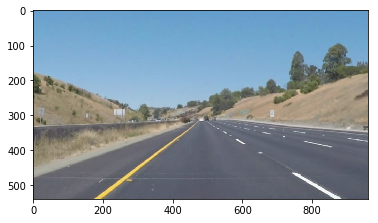

In [98]:
#reading in an image
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [258]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    sum_right_line = 0
    sum_left_line = 0
    num_right_line = 0
    num_left_line = 0
    avg_right_line = 0
    sum_right_xposition = 0
    sum_right_yposition = 0
    sum_left_xposition = 0
    sum_left_yposition = 0
    
    right_array = []
    del_right_array = []
    left_array = []
    del_left_array = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            #define acceptable slope range
            middle_num = 0.65 
            range_for_middle_num = 0.2
            
            #I try to get the slope value
            slope = ((y2-y1)/(x2-x1))
            #then seperate the left/right ones and abandon horizontal lines or over range lines
            if slope > 0 : #possible right lines
                if  middle_num-range_for_middle_num < abs(slope) < middle_num+range_for_middle_num :
                    #print('right slope is ',((y2-y1)/(x2-x1)))
                    sum_right_line += slope
                    num_right_line += 1
                    right_array.append([x1,y1])
                    right_array.append([x2,y2])
                    sum_right_xposition += (x1 + x2)
                    sum_right_yposition += (y1 + y2)
            else: #possible left lines
                if  middle_num-range_for_middle_num < abs(slope) < middle_num+range_for_middle_num :
                    #print('left slope is ',((y2-y1)/(x2-x1)))
                    sum_left_line += slope
                    num_left_line += 1
                    left_array.append([x1,y1])
                    left_array.append([x2,y2])
                    sum_left_xposition += (x1 + x2)
                    sum_left_yposition += (y1 + y2)
                    
            
            #print('slope is ',((y2-y1)/(x2-x1)))
            
    #average slope calculation
    avg_slope_right = sum_right_line/num_right_line
    avg_slope_left = sum_left_line/num_left_line
    avg_right_xposition = sum_right_xposition/(num_right_line*2)
    avg_right_yposition = sum_right_yposition/(num_right_line*2)
    avg_left_xposition = sum_left_xposition / (num_left_line*2)
    avg_left_yposition = sum_left_yposition / (num_left_line*2)
    
    #print('avg right position is x=',avg_right_xposition,' y= ',avg_right_yposition )
    right_array.sort(reverse=True)
    left_array.sort(reverse=True)
    # for further delete some irrelevant points 
    for i in range(len(right_array)):
        #print('i is ',i,' right array i0 is ',right_array[i][0],'i1 is ', right_array[i][1])
        if (abs(right_array[i][0]-avg_right_xposition) > 250) or (abs(right_array[i][1]-avg_right_yposition) > 120): 
            del_right_array.append(i)

    for i in range(len(left_array)):
        print('i is ',i,' left array i0 is ',left_array[i][0],'i1 is ', left_array[i][1])
        if (abs(left_array[i][0]-avg_left_xposition) > 250) or (abs(left_array[i][1]-avg_left_yposition) > 120): 
            del_left_array.append(i)
    
    # for deleting some point are not in the decendant order
    for i in range(0,len(right_array)-2,1):
        #print ('new i is ', i,'i0= ',right_array[i][0],' i+1 0=',right_array[i+1][0],' i+2 0=',right_array[i+2][0] )
        if (right_array[i][1]-right_array[i+1][1]<-3) and (right_array[i][1]-right_array[i+2][1]<-3):
            del_right_array.append(i+1)
            del_right_array.append(i+2)
    for i in range(0,len(left_array)-2,1):
        print ('new i is ', i,'i0= ',left_array[i][0],' i+1 0=',left_array[i+1][0],' i+2 0=',left_array[i+2][0] )
        if (left_array[i][1]-left_array[i+1][1]<-3) and (left_array[i][1]-left_array[i+2][1]<-3):
            del_left_array.append(i+1)
            del_left_array.append(i+2)        
    
        
    #print('del array is ', del_right_array)
    # re-arrange array
    new_del_right_array = sorted(set(del_right_array))
    new_del_left_array = sorted(set(del_left_array))
    #print('del array is ', new_del_right_array)
    del_right_array.sort()
    del_left_array.sort()
    for v in reversed(new_del_right_array):
        #print('v is ', v)
        del right_array[v]
    for v in reversed(new_del_left_array):
        #print('v is ', v)
        del left_array[v]
    
    #print('avg right slope is ',avg_slope_right)
    #print('avg left slope is ',avg_slope_left)
    print('right array is ', right_array)
    right_x1_position = int(round((right_array[0][0]+right_array[1][0])/2))
    last_index_left_array = len(left_array)-1
    left_x1_position = int(round((left_array[last_index_left_array][0]+left_array[last_index_left_array-1][0])/2))
    min_line_x_position = (right_x1_position + left_x1_position)/2
    print('min line is ', min_line_x_position)
    
    
    del_right_array = []
    for i in range(len(right_array)):
        #print('i is ',i,' right array i0 is ',right_array[i][0],'i1 is ', right_array[i][1])
        if (right_array[i][0] < min_line_x_position): 
            del_right_array.append(i)
    # re-arrange array
    new_del_right_array = sorted(set(del_right_array))
    new_del_left_array = sorted(set(del_left_array))
    print('del array is ', new_del_right_array)
    del_right_array.sort()
    del_left_array.sort()
    for v in reversed(new_del_right_array):
        print('v is ', v)
        del right_array[v]
    #for v in reversed(new_del_left_array):
        #print('v is ', v)
     #   del left_array[v]
    
    
    last_index_right_array = len(right_array)-1
    cv2.line(img,(right_x1_position,right_array[0][1]),(right_array[last_index_right_array-2][0],right_array[last_index_right_array-2][1]),[0,255,0],10)        

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

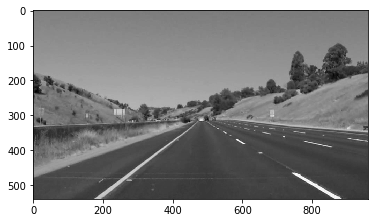

In [259]:
import os
os.listdir("test_images/")
gray = grayscale(image)
plt.imshow(gray, cmap='gray')

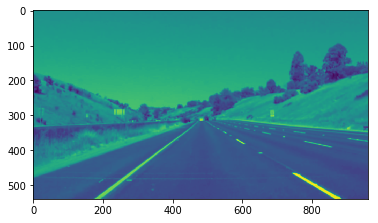

In [260]:
blur_gray = gaussian_blur(gray, 5)
plt.imshow(blur_gray)

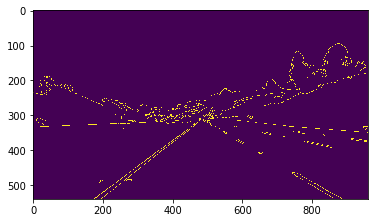

In [261]:
edges = canny(blur_gray, 10, 180)
plt.imshow(edges)

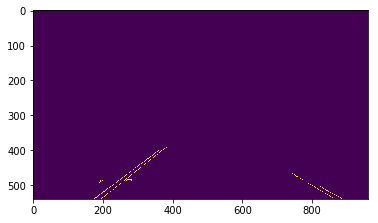

In [262]:
# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(60,imshape[0]),(470, 350), (490, 350), (imshape[1]-60,imshape[0])]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)
plt.imshow(masked_edges)

i is  0  left array i0 is  387 i1 is  388
i is  1  left array i0 is  383 i1 is  390
i is  2  left array i0 is  371 i1 is  400
i is  3  left array i0 is  369 i1 is  400
i is  4  left array i0 is  362 i1 is  400
i is  5  left array i0 is  357 i1 is  402
i is  6  left array i0 is  302 i1 is  455
i is  7  left array i0 is  300 i1 is  455
i is  8  left array i0 is  277 i1 is  484
i is  9  left array i0 is  272 i1 is  488
i is  10  left array i0 is  269 i1 is  484
i is  11  left array i0 is  266 i1 is  486
i is  12  left array i0 is  219 i1 is  507
i is  13  left array i0 is  215 i1 is  524
i is  14  left array i0 is  208 i1 is  528
i is  15  left array i0 is  203 i1 is  533
i is  16  left array i0 is  202 i1 is  518
i is  17  left array i0 is  201 i1 is  533
i is  18  left array i0 is  201 i1 is  486
i is  19  left array i0 is  200 i1 is  486
i is  20  left array i0 is  197 i1 is  485
i is  21  left array i0 is  197 i1 is  484
i is  22  left array i0 is  195 i1 is  539
i is  23  left array 

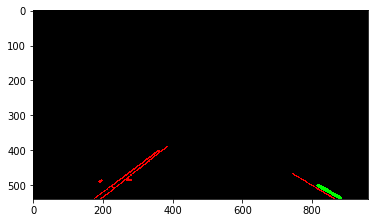

In [263]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1
theta = np.pi/180
threshold = 3
min_line_length = 3
max_line_gap = 7
lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
plt.imshow(lines)

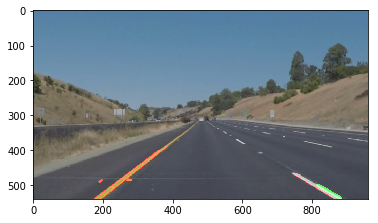

In [264]:
mix = weighted_img(lines, image, α=0.8, β=1., λ=0.)
plt.imshow(mix)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [265]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [266]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [269]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    gray = grayscale(image)
    blur_gray = gaussian_blur(gray, 5)
    edges = canny(blur_gray, 10, 180)
    imshape = image.shape
    vertices = np.array([[(60,imshape[0]),(470, 315), (490, 315), (imshape[1]-60,imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    rho = 1
    theta = np.pi/180
    threshold = 3
    min_line_length = 3
    max_line_gap = 7
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    result = weighted_img(lines, image, α=0.8, β=1., λ=0.)
    return result

Let's try the one with the solid white lane on the right first ...

In [270]:
white_output = 'SYL_segment_lines_right_finish.mp4'
clip1 = VideoFileClip("solidYellowLeft.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

i is  0  left array i0 is  461 i1 is  320
i is  1  left array i0 is  456 i1 is  326
i is  2  left array i0 is  454 i1 is  328
i is  3  left array i0 is  453 i1 is  324
i is  4  left array i0 is  452 i1 is  330
i is  5  left array i0 is  450 i1 is  330
i is  6  left array i0 is  447 i1 is  328
i is  7  left array i0 is  446 i1 is  330
i is  8  left array i0 is  445 i1 is  334
i is  9  left array i0 is  442 i1 is  333
i is  10  left array i0 is  440 i1 is  333
i is  11  left array i0 is  434 i1 is  337
i is  12  left array i0 is  433 i1 is  339
i is  13  left array i0 is  420 i1 is  346
i is  14  left array i0 is  403 i1 is  357
i is  15  left array i0 is  400 i1 is  359
i is  16  left array i0 is  396 i1 is  361
i is  17  left array i0 is  394 i1 is  367
i is  18  left array i0 is  392 i1 is  365
i is  19  left array i0 is  378 i1 is  372
i is  20  left array i0 is  373 i1 is  380
i is  21  left array i0 is  369 i1 is  384
i is  22  left array i0 is  360 i1 is  384
i is  23  left array 



  0%|          | 0/682 [00:00<?, ?it/s]

i is  0  left array i0 is  461 i1 is  320
i is  1  left array i0 is  456 i1 is  326
i is  2  left array i0 is  454 i1 is  328
i is  3  left array i0 is  453 i1 is  324
i is  4  left array i0 is  452 i1 is  330
i is  5  left array i0 is  450 i1 is  330
i is  6  left array i0 is  447 i1 is  328
i is  7  left array i0 is  446 i1 is  330
i is  8  left array i0 is  445 i1 is  334
i is  9  left array i0 is  442 i1 is  333
i is  10  left array i0 is  440 i1 is  333
i is  11  left array i0 is  434 i1 is  337
i is  12  left array i0 is  433 i1 is  339
i is  13  left array i0 is  420 i1 is  346
i is  14  left array i0 is  403 i1 is  357
i is  15  left array i0 is  400 i1 is  359
i is  16  left array i0 is  396 i1 is  361
i is  17  left array i0 is  394 i1 is  367
i is  18  left array i0 is  392 i1 is  365
i is  19  left array i0 is  378

 i1 is  372
i is  20  left array i0 is  373 i1 is  380
i is  21  left array i0 is  369 i1 is  384
i is  22  left array i0 is  360 i1 is  384
i is  23  left array i0 is  358 i1 is  384
i is  24  left array i0 is  354 i1 is  393
i is  25  left array i0 is  340 i1 is  395
i is  26  left array i0 is  338 i1 is  396
i is  27  left array i0 is  329 i1 is  403
i is  28  left array i0 is  307 i1 is  415
i is  29  left array i0 is  289 i1 is  433
i is  30  left array i0 is  287 i1 is  427
i is  31  left array i0 is  286 i1 is  429
i is  32



  0%|          | 1/682 [00:00<01:46,  6.40it/s]

  left array i0 is  282 i1 is  431
i is  33  left array i0 is  281 i1 is  432
i is  34  left array i0 is  256 i1 is  447
i is  35  left array i0 is  239 i1 is  456
i is  36  left array i0 is  238 i1 is  467
i is  37  left array i0 is  237 i1 is  458
i is  38  left array i0 is  236 i1 is  458
i is  39  left array i0 is  224 i1 is  465
i is  40  left array i0 is  223 i1 is  467
i is  41  left array i0 is  214 i1 is  471
i is  42  left array i0 is  208 i1 is  476
i is  43  left array i0 is  204 i1 is  477
i is  44  left array i0 is  200 i1 is  481
i is  45  left array i0 is  197 i1 is  482
i is  46  left array i0 is  195 i1 is  484
i is  47  left array i0 is  191 i1 is  486
i is  48  left array i0 is  191 i1 is  485
i is  49  left array i0 is  170 i1 is  509
i is  50  left array i0 is  164 i1 is  513
i is  51  left array i0 is  152 i1 is  510
i is  52  left array i0 is  134 i1 is  532
i is  53  left array i0 is  131 i1 is  523
i is  54  left array i0 is  126 i1 is  539
i is  55  left arra



  0%|          | 2/682 [00:00<02:30,  4.52it/s]

 412
new i is  28 i0=  412  i+1 0= 412  i+2 0= 409
new i is  29 i0=  412  i+1 0= 409  i+2 0= 404
new i is  30 i0=  409  i+1 0= 404  i+2 0= 403
new i is  31 i0=  404  i+1 0= 403  i+2 0= 375
new i is  32 i0=  403  i+1 0= 375  i+2 0= 373
new i is  33 i0=  375  i+1 0= 373  i+2 0= 371
new i is  34 i0=  373  i+1 0= 371  i+2 0= 283
new i is  35 i0=  371  i+1 0= 283  i+2 0= 193
new i is  36 i0=  283  i+1 0= 193  i+2 0= 192
new i is  37 i0=  193  i+1 0= 192  i+2 0= 127
new i is  38 i0=  192  i+1 0= 127  i+2 0= 125
new i is  39 i0=  127  i+1 0= 125  i+2 0= 105
right array is  [[831, 532], [813, 535], [810, 520], [808, 531], [806, 517], [772, 507], [772, 495], [754, 493], [734, 469], [726, 465], [690, 440], [688, 440], [679, 442], [678, 441], [586, 370], [583, 373], [578, 366], [577, 364], [571, 366], [571, 365], [570, 360], [567, 363], [543, 345], [537, 341]]
min line is  613.0
del array is  [14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
v is  23
v is  22
v is  21
v is  20
v is  19
v is  18
v is  17
v



  0%|          | 3/682 [00:00<03:20,  3.38it/s]

538
new i is  0 i0=  707  i+1 0= 704  i+2 0= 628
new i is  1 i0=  704  i+1 0= 628  i+2 0= 624
new i is  2 i0=  628  i+1 0= 624  i+2 0= 624
new i is  3 i0=  624  i+1 0= 624  i+2 0= 621
new i is  4 i0=  624  i+1 0= 621  i+2 0= 453
new i is  5 i0=  621  i+1 0= 453  i+2 0= 449
new i is  6 i0=  453  i+1 0= 449  i+2 0= 447
new i is  7 i0=  449  i+1 0= 447  i+2 0= 443
new i is  8 i0=  447  i+1 0= 443  i+2 0= 443
new i is  9 i0=  443  i+1 0= 443  i+2 0= 442
new i is  10 i0=  443  i+1 0= 442  i+2 0= 437
new i is  11 i0=  442  i+1 0= 437  i+2 0= 435
new i is  12 i0=  437  i+1 0= 435  i+2 0= 428
new i is  13 i0=  435  i+1 0= 428  i+2 0= 418
new i is  14 i0=  428  i+1 0= 418  i+2 0= 415
new i is  15 i0=  418  i+1 0= 415  i+2 0= 402
new i is  16 i0=  415  i+1 0= 402  i+2 0= 393
new i is  17 i0=  402  i+1 0= 393  i+2 0= 357
new i is  18 i0=  393  i+1 0= 357  i+2 0= 350
new i is  19 i0=  357  i+1 0= 350  i+2 0= 349
new i is  20 i0=  350  i+1 0= 349  i+2 0= 321
new i is  21 i0=  349  i+1 0= 321  i+2 0



  1%|          | 4/682 [00:01<03:42,  3.05it/s]

  left array i0 is  771 i1 is  504
i is  2  left array i0 is  580 i1 is  367
i is  3  left array i0 is  577 i1 is  369
i is  4  left array i0 is  448 i1 is  334
i is  5  left array i0 is  438 i1 is  340
i is  6  left array i0 is  388 i1 is  373
i is  7  left array i0 is  378 i1 is  380
i is  8  left array i0 is  372 i1 is  378
i is  9  left array i0 is  370 i1 is  379
i is  10  left array i0 is  364 i1 is  384
i is  11  left array i0 is  342 i1 is  397
i is  12  left array i0 is  337 i1 is  405
i is  13  left array i0 is  312 i1 is  421
i is  14  left array i0 is  309 i1 is  423
i is  15  left array i0 is  296 i1 is  433
i is  16  left array i0 is  285 i1 is  440
i is  17  left array i0 is  279 i1 is  443
i is  18  left array i0 is  276 i1 is  438
i is  19  left array i0 is  269 i1 is  450
i is  20  left array i0 is  269 i1 is  449
i is  21  left array i0 is  265 i1 is  453
i is  22  left array i0 is  265 i1 is  452
i is  23  left array i0 is  262 i1 is  455
i is  24  left array i0 is 



  1%|          | 5/682 [00:02<05:07,  2.20it/s]

60  left array i0 is  148 i1 is  530
i is  61  left array i0 is  146 i1 is  530
i is  62  left array i0 is  134 i1 is  538
i is  63  left array i0 is  133 i1 is  538
i is  64  left array i0 is  131 i1 is  527
i is  65  left array i0 is  118 i1 is  536
i is  66  left array i0 is  115 i1 is  538
i is  67  left array i0 is  114 i1 is  538
new i is  0 i0=  596  i+1 0= 592  i+2 0= 464
new i is  1 i0=  592  i+1 0= 464  i+2 0= 457
new i is  2 i0=  464  i+1 0= 457  i+2 0= 451
new i is  3 i0=  457  i+1 0= 451  i+2 0= 449
new i is  4 i0=  451  i+1 0= 449  i+2 0= 448
new i is  5 i0=  449  i+1 0= 448  i+2 0= 447
new i is  6 i0=  448  i+1 0= 447  i+2 0= 442
new i is  7 i0=  447  i+1 0= 442  i+2 0= 436
new i is  8 i0=  442  i+1 0= 436  i+2 0= 435
new i is  9 i0=  436  i+1 0= 435  i+2 0= 431
new i is  10 i0=  435  i+1 0= 431  i+2 0= 424
new i is  11 i0=  431  i+1 0= 424  i+2 0= 424
new i is  12 i0=  424  i+1 0= 424  i+2 0= 414
new i is  13 i0=  424  i+1 0= 414  i+2 0= 413
new i is  14 i0=  414  i+1 0



  1%|          | 6/682 [00:02<04:40,  2.41it/s]

 178  i+2 0= 169
new i is  32 i0=  178  i+1 0= 169  i+2 0= 164
new i is  33 i0=  169  i+1 0= 164  i+2 0= 156
new i is  34 i0=  164  i+1 0= 156  i+2 0= 138
new i is  35 i0=  156  i+1 0= 138  i+2 0= 138
new i is  36 i0=  138  i+1 0= 138  i+2 0= 137
new i is  37 i0=  138  i+1 0= 137  i+2 0= 131
new i is  38 i0=  137  i+1 0= 131  i+2 0= 118
new i is  39 i0=  131  i+1 0= 118  i+2 0= 118
right array is  [[618, 393], [618, 392], [615, 389], [611, 386], [605, 382], [604, 387], [601, 385], [600, 380], [596, 376], [592, 374], [589, 377], [586, 376], [571, 361], [570, 362], [568, 359], [566, 360], [553, 352], [546, 347], [530, 337], [527, 335], [493, 322], [490, 320], [271, 442], [266, 445]]
min line is  384.5
del array is  [22, 23]
v is  23
v is  22
i is  0  left array i0 is  464 i1 is  318
i is  1  left array i0 is  459 i1 is  324
i is  2  left array i0 is  459 i1 is  322
i is  3  left array i0 is  455 i1 is  328
i is  4  left array i0 is  452 i1 is  325
i is  5  left array i0 is  450 i1 is  33



  1%|          | 7/682 [00:03<05:04,  2.21it/s]

 left array i0 is  233 i1 is  477
i is  65  left array i0 is  228 i1 is  479
i is  66  left array i0 is  224 i1 is  483
i is  67  left array i0 is  223 i1 is  474
i is  68  left array i0 is  215 i1 is  478
i is  69  left array i0 is  210 i1 is  481
i is  70  left array i0 is  209 i1 is  483
i is  71  left array i0 is  204 i1 is  486
i is  72  left array i0 is  202 i1 is  486
i is  73  left array i0 is  201 i1 is  497
i is  74  left array i0 is  195 i1 is  492
i is  75  left array i0 is  191 i1 is  505
i is  76  left array i0 is  179 i1 is  513
i is  77  left array i0 is  176 i1 is  502
i is  78  left array i0 is  158 i1 is  515
i is  79  left array i0 is  157 i1 is  527
i is  80  left array i0 is  157 i1 is  515
i is  81  left array i0 is  151 i1 is  530
i is  82  left array i0 is  151 i1 is  518
i is  83  left array i0 is  150 i1 is  532
i is  84  left array i0 is  146 i1 is  521
i is  85  left array i0 is  145 i1 is  534
i is  86  left array i0 is  129 i1 is  532
i is  87  left array



  1%|          | 8/682 [00:03<04:37,  2.43it/s]

i1 is  425
i is  30  left array i0 is  307 i1 is  429
i is  31  left array i0 is  300 i1 is  432
i is  32  left array i0 is  297 i1 is  434
i is  33  left array i0 is  285 i1 is  443
i is  34  left array i0 is  283 i1 is  443
i is  35  left array i0 is  276 i1 is  449
i is  36  left array i0 is  268 i1 is  453
i is  37  left array i0 is  258 i1 is  460
i is  38  left array i0 is  256 i1 is  461
i is  39  left array i0 is  242 i1 is  470
i is  40  left array i0 is  235 i1 is  475
i is  41  left array i0 is  228 i1 is  480
i is  42  left array i0 is  226 i1 is  482
i is  43  left array i0 is  192 i1 is  504
i is  44  left array i0 is  189 i1 is  506
i is  45  left array i0 is  185 i1 is  509
i is  46  left array i0 is  183 i1 is  509
i is  47  left array i0 is  181 i1 is  512
i is  48  left array i0 is  177 i1 is  513
i is  49  left array i0 is  176 i1 is  515
i is  50  left array i0 is  170 i1 is  518
i is  51  left array i0 is  166 i1 is  522
i is  52  left array i0 is  150 i1 is  531




  1%|▏         | 9/682 [00:04<06:40,  1.68it/s]

  left array i0 is  284 i1 is  435
i is  44  left array i0 is  282 i1 is  445
i is  45  left array i0 is  282 i1 is  436
i is  46  left array i0 is  281 i1 is  445
i is  47  left array i0 is  276 i1 is  440
i is  48  left array i0 is  275 i1 is  441
i is  49  left array i0 is  270 i1 is  452
i is  50  left array i0 is  263 i1 is  458
i is  51  left array i0 is  260 i1 is  451
i is  52  left array i0 is  258 i1 is  452
i is  53  left array i0 is  257 i1 is  462
i is  54  left array i0 is  254 i1 is  455
i is  55  left array i0 is  252 i1 is  464
i is  56  left array i0 is  252 i1 is  455
i is  57  left array i0 is  248 i1 is  459
i is  58  left array i0 is  246 i1 is  468
i is  59  left array i0 is  241 i1 is  462
i is  60  left array i0 is  230 i1 is  470
i is  61  left array i0 is  227 i1 is  472
i is  62  left array i0 is  225 i1 is  472
i is  63  left array i0 is  220 i1 is  475
i is  64  left array i0 is  212 i1 is  481
i is  65  left array i0 is  209 i1 is  482
i is  66  left arra



  1%|▏         | 10/682 [00:04<05:43,  1.96it/s]

 i+1 0= 442  i+2 0= 441
new i is  7 i0=  442  i+1 0= 441  i+2 0= 441
new i is  8 i0=  441  i+1 0= 441  i+2 0= 440
new i is  9 i0=  441  i+1 0= 440  i+2 0= 437
new i is  10 i0=  440  i+1 0= 437  i+2 0= 435
new i is  11 i0=  437  i+1 0= 435  i+2 0= 425
new i is  12 i0=  435  i+1 0= 425  i+2 0= 423
new i is  13 i0=  425  i+1 0= 423  i+2 0= 421
new i is  14 i0=  423  i+1 0= 421  i+2 0= 417
new i is  15 i0=  421  i+1 0= 417  i+2 0= 403
new i is  16 i0=  417  i+1 0= 403  i+2 0= 401
new i is  17 i0=  403  i+1 0= 401  i+2 0= 397
new i is  18 i0=  401  i+1 0= 397  i+2 0= 392
new i is  19 i0=  397  i+1 0= 392  i+2 0= 373
new i is  20 i0=  392  i+1 0= 373  i+2 0= 372
new i is  21 i0=  373  i+1 0= 372  i+2 0= 370
new i is  22 i0=  372  i+1 0= 370  i+2 0= 366
new i is  23 i0=  370  i+1 0= 366  i+2 0= 365
new i is  24 i0=  366  i+1 0= 365  i+2 0= 342
new i is  25 i0=  365  i+1 0= 342  i+2 0= 337
new i is  26 i0=  342  i+1 0= 337  i+2 0= 326
new i is  27 i0=  337  i+1 0= 326  i+2 0= 322
new i is  28 



  2%|▏         | 11/682 [00:04<05:02,  2.22it/s]

 182  i+1 0= 178  i+2 0= 174
new i is  36 i0=  178  i+1 0= 174  i+2 0= 166
new i is  37 i0=  174  i+1 0= 166  i+2 0= 163
new i is  38 i0=  166  i+1 0= 163  i+2 0= 158
new i is  39 i0=  163  i+1 0= 158  i+2 0= 156
new i is  40 i0=  158  i+1 0= 156  i+2 0= 153
new i is  41 i0=  156  i+1 0= 153  i+2 0= 148
new i is  42 i0=  153  i+1 0= 148  i+2 0= 143
new i is  43 i0=  148  i+1 0= 143  i+2 0= 140
new i is  44 i0=  143  i+1 0= 140  i+2 0= 129
new i is  45 i0=  140  i+1 0= 129  i+2 0= 127
right array is  [[701, 442], [695, 437], [688, 433], [688, 432], [685, 430], [682, 429], [681, 438], [673, 422], [660, 422], [660, 415], [656, 419], [652, 416], [645, 413], [642, 411], [641, 409], [630, 402], [598, 375], [595, 373], [571, 361], [569, 361], [558, 354], [558, 353]]
min line is  424.0
del array is  []
i is  0  left array i0 is  457 i1 is  322
i is  1  left array i0 is  454 i1 is  324
i is  2  left array i0 is  447 i1 is  332
i is  3  left array i0 is  445 i1 is  329
i is  4  left array i0 is 



  2%|▏         | 12/682 [00:05<04:35,  2.43it/s]

  left array i0 is  245 i1 is  471
i is  42  left array i0 is  239 i1 is  475
i is  43  left array i0 is  238 i1 is  476
i is  44  left array i0 is  234 i1 is  477
i is  45  left array i0 is  233 i1 is  478
i is  46  left array i0 is  232 i1 is  469
i is  47  left array i0 is  224 i1 is  474
i is  48  left array i0 is  220 i1 is  477
i is  49  left array i0 is  216 i1 is  489
i is  50  left array i0 is  214 i1 is  492
i is  51  left array i0 is  209 i1 is  495
i is  52  left array i0 is  205 i1 is  498
i is  53  left array i0 is  203 i1 is  499
i is  54  left array i0 is  194 i1 is  504
i is  55  left array i0 is  188 i1 is  508
i is  56  left array i0 is  174 i1 is  519
i is  57  left array i0 is  168 i1 is  511
i is  58  left array i0 is  167 i1 is  523
i is  59  left array i0 is  164 i1 is  525
i is  60  left array i0 is  163 i1 is  525
i is  61  left array i0 is  158 i1 is  528
i is  62  left array i0 is  152 i1 is  532
i is  63  left array i0 is  144 i1 is  539
i is  64  left arra



  2%|▏         | 13/682 [00:06<06:27,  1.73it/s]

455  i+2 0= 455
new i is  2 i0=  455  i+1 0= 455  i+2 0= 448
new i is  3 i0=  455  i+1 0= 448  i+2 0= 442
new i is  4 i0=  448  i+1 0= 442  i+2 0= 440
new i is  5 i0=  442  i+1 0= 440  i+2 0= 436
new i is  6 i0=  440  i+1 0= 436  i+2 0= 435
new i is  7 i0=  436  i+1 0= 435  i+2 0= 429
new i is  8 i0=  435  i+1 0= 429  i+2 0= 427
new i is  9 i0=  429  i+1 0= 427  i+2 0= 418
new i is  10 i0=  427  i+1 0= 418  i+2 0= 414
new i is  11 i0=  418  i+1 0= 414  i+2 0= 410
new i is  12 i0=  414  i+1 0= 410  i+2 0= 409
new i is  13 i0=  410  i+1 0= 409  i+2 0= 406
new i is  14 i0=  409  i+1 0= 406  i+2 0= 402
new i is  15 i0=  406  i+1 0= 402  i+2 0= 398
new i is  16 i0=  402  i+1 0= 398  i+2 0= 396
new i is  17 i0=  398  i+1 0= 396  i+2 0= 395
new i is  18 i0=  396  i+1 0= 395  i+2 0= 386
new i is  19 i0=  395  i+1 0= 386  i+2 0= 384
new i is  20 i0=  386  i+1 0= 384  i+2 0= 380
new i is  21 i0=  384  i+1 0= 380  i+2 0= 376
new i is  22 i0=  380  i+1 0= 376  i+2 0= 373
new i is  23 i0=  376  i+1



  2%|▏         | 14/682 [00:06<05:57,  1.87it/s]

 369
i is  5  left array i0 is  585 i1 is  371
i is  6  left array i0 is  444 i1 is  329
i is  7  left array i0 is  439 i1 is  339
i is  8  left array i0 is  429 i1 is  347
i is  9  left array i0 is  424 i1 is  346
i is  10  left array i0 is  414 i1 is  353
i is  11  left array i0 is  412 i1 is  353
i is  12  left array i0 is  406 i1 is  358
i is  13  left array i0 is  397 i1 is  363
i is  14  left array i0 is  390 i1 is  368
i is  15  left array i0 is  382 i1 is  378
i is  16  left array i0 is  363 i1 is  393
i is  17  left array i0 is  344 i1 is  399
i is  18  left array i0 is  326 i1 is  424
i is  19  left array i0 is  326 i1 is  412
i is  20  left array i0 is  323 i1 is  423
i is  21  left array i0 is  322 i1 is  427
i is  22  left array i0 is  320 i1 is  424
i is  23  left array i0 is  317 i1 is  427
i is  24  left array i0 is  317 i1 is  418
i is  25  left array i0 is  316 i1 is  427
i is  26  left array i0 is  314 i1 is  425
i is  27  left array i0 is  309 i1 is  422
i is  28  l



  2%|▏         | 15/682 [00:07<06:15,  1.78it/s]

i is  50  left array i0 is  223 i1 is  489
i is  51  left array i0 is  212 i1 is  495
i is  52  left array i0 is  211 i1 is  486
i is  53  left array i0 is  208 i1 is  498
i is  54  left array i0 is  207 i1 is  488
i is  55  left array i0 is  201 i1 is  503
i is  56  left array i0 is  195 i1 is  508
i is  57  left array i0 is  191 i1 is  510
i is  58  left array i0 is  190 i1 is  511
i is  59  left array i0 is  182 i1 is  517
i is  60  left array i0 is  180 i1 is  517
i is  61  left array i0 is  177 i1 is  519
i is  62  left array i0 is  165 i1 is  516
i is  63  left array i0 is  158 i1 is  533
i is  64  left array i0 is  154 i1 is  536
i is  65  left array i0 is  152 i1 is  536
i is  66  left array i0 is  150 i1 is  539
i is  67  left array i0 is  150 i1 is  538
i is  68  left array i0 is  134 i1 is  536
i is  69  left array i0 is  129 i1 is  538
new i is  0 i0=  628  i+1 0= 623  i+2 0= 452
new i is  1 i0=  623  i+1 0= 452  i+2 0= 447
new i is  2 i0=  452  i+1 0= 447  i+2 0= 444
new i



  2%|▏         | 16/682 [00:07<05:56,  1.87it/s]

  left array i0 is  223 i1 is  479
i is  63  left array i0 is  222 i1 is  490
i is  64  left array i0 is  219 i1 is  493
i is  65  left array i0 is  213 i1 is  485
i is  66  left array i0 is  206 i1 is  502
i is  67  left array i0 is  191 i1 is  499
i is  68  left array i0 is  189 i1 is  502
i is  69  left array i0 is  181 i1 is  519
i is  70  left array i0 is  177 i1 is  520
i is  71  left array i0 is  176 i1 is  521
i is  72  left array i0 is  163 i1 is  531
i is  73  left array i0 is  161 i1 is  531
i is  74  left array i0 is  158 i1 is  533
i is  75  left array i0 is  156 i1 is  535
i is  76  left array i0 is  154 i1 is  536
i is  77  left array i0 is  154 i1 is  523
i is  78  left array i0 is  152 i1 is  539
i is  79  left array i0 is  139 i1 is  533
i is  80  left array i0 is  136 i1 is  535
i is  81  left array i0 is  135 i1 is  536
i is  82  left array i0 is  133 i1 is  538
i is  83  left array i0 is  132 i1 is  539
new i is  0 i0=  739  i+1 0= 735  i+2 0= 649
new i is  1 i0=  



  2%|▏         | 17/682 [00:08<06:09,  1.80it/s]

i1 is  527
i is  72  left array i0 is  144 i1 is  530
i is  73  left array i0 is  141 i1 is  532
i is  74  left array i0 is  138 i1 is  535
i is  75  left array i0 is  134 i1 is  537
new i is  0 i0=  784  i+1 0= 777  i+2 0= 664
new i is  1 i0=  777  i+1 0= 664  i+2 0= 658
new i is  2 i0=  664  i+1 0= 658  i+2 0= 658
new i is  3 i0=  658  i+1 0= 658  i+2 0= 650
new i is  4 i0=  658  i+1 0= 650  i+2 0= 601
new i is  5 i0=  650  i+1 0= 601  i+2 0= 597
new i is  6 i0=  601  i+1 0= 597  i+2 0= 593
new i is  7 i0=  597  i+1 0= 593  i+2 0= 589
new i is  8 i0=  593  i+1 0= 589  i+2 0= 452
new i is  9 i0=  589  i+1 0= 452  i+2 0= 446
new i is  10 i0=  452  i+1 0= 446  i+2 0= 446
new i is  11 i0=  446  i+1 0= 446  i+2 0= 444
new i is  12 i0=  446  i+1 0= 444  i+2 0= 438
new i is  13 i0=  444  i+1 0= 438  i+2 0= 437
new i is  14 i0=  438  i+1 0= 437  i+2 0= 437
new i is  15 i0=  437  i+1 0= 437  i+2 0= 431
new i is  16 i0=  437  i+1 0= 431  i+2 0= 427
new i is  17 i0=  431  i+1 0= 427  i+2 0= 426



  3%|▎         | 18/682 [00:08<06:06,  1.81it/s]

219 i1 is  504
i is  35  left array i0 is  218 i1 is  485
i is  36  left array i0 is  216 i1 is  504
i is  37  left array i0 is  214 i1 is  487
i is  38  left array i0 is  210 i1 is  510
i is  39  left array i0 is  210 i1 is  504
i is  40  left array i0 is  210 i1 is  501
i is  41  left array i0 is  208 i1 is  510
i is  42  left array i0 is  208 i1 is  490
i is  43  left array i0 is  207 i1 is  505
i is  44  left array i0 is  204 i1 is  494
i is  45  left array i0 is  203 i1 is  509
i is  46  left array i0 is  203 i1 is  508
i is  47  left array i0 is  187 i1 is  517
i is  48  left array i0 is  179 i1 is  521
i is  49  left array i0 is  177 i1 is  512
i is  50  left array i0 is  174 i1 is  526
i is  51  left array i0 is  173 i1 is  513
i is  52  left array i0 is  168 i1 is  529
i is  53  left array i0 is  162 i1 is  533
i is  54  left array i0 is  161 i1 is  521
i is  55  left array i0 is  158 i1 is  536
i is  56  left array i0 is  158 i1 is  524
i is  57  left array i0 is  156 i1 is  



  3%|▎         | 19/682 [00:09<05:30,  2.01it/s]

  3%|▎         | 20/682 [00:09<05:03,  2.18it/s]


i is  52  left array i0 is  200 i1 is  496
i is  53  left array i0 is  198 i1 is  508
i is  54  left array i0 is  196 i1 is  499
i is  55  left array i0 is  191 i1 is  501
i is  56  left array i0 is  188 i1 is  515
i is  57  left array i0 is  184 i1 is  507
i is  58  left array i0 is  181 i1 is  509
i is  59  left array i0 is  173 i1 is  527
i is  60  left array i0 is  169 i1 is  517
i is  61  left array i0 is  161 i1 is  535
i is  62  left array i0 is  161 i1 is  521
i is  63  left array i0 is  155 i1 is  538
i is  64  left array i0 is  146 i1 is  532
i is  65  left array i0 is  146 i1 is  531
i is  66  left array i0 is  136 i1 is  539
i is  67  left array i0 is  136 i1 is  537
new i is  0 i0=  451  i+1 0= 447  i+2 0= 444
new i is  1 i0=  447  i+1 0= 444  i+2 0= 439
new i is  2 i0=  444  i+1 0= 439  i+2 0= 437
new i is  3 i0=  439  i+1 0= 437  i+2 0= 435
new i is  4 i0=  437  i+1 0= 435  i+2 0= 434
new i is  5 i0=  435  i+1 0= 434  i+2 0= 433
new i is  6 i0=  434  i+1 0= 433  i+2 0= 



  3%|▎         | 21/682 [00:09<04:11,  2.62it/s]

328
i is  1  left array i0 is  435 i1 is  334
i is  2  left array i0 is  426 i1 is  341
i is  3  left array i0 is  426 i1 is  340
i is  4  left array i0 is  425 i1 is  342
i is  5  left array i0 is  421 i1 is  344
i is  6  left array i0 is  411 i1 is  353
i is  7  left array i0 is  409 i1 is  358
i is  8  left array i0 is  405 i1 is  362
i is  9  left array i0 is  399 i1 is  365
i is  10  left array i0 is  398 i1 is  367
i is  11  left array i0 is  386 i1 is  374
i is  12  left array i0 is  383 i1 is  372
i is  13  left array i0 is  380 i1 is  381
i is  14  left array i0 is  364 i1 is  391
i is  15  left array i0 is  322 i1 is  413
i is  16  left array i0 is  320 i1 is  414
i is  17  left array i0 is  319 i1 is  415
i is  18  left array i0 is  313 i1 is  425
i is  19  left array i0 is  309 i1 is  428
i is  20  left array i0 is  298 i1 is  436
i is  21  left array i0 is  294 i1 is  440
i is  22  left array i0 is  291 i1 is  434
i is  23  left array i0 is  279 i1 is  451
i is  24  left a



  3%|▎         | 22/682 [00:10<04:06,  2.68it/s]

 i1 is  368
i is  5  left array i0 is  391 i1 is  370
i is  6  left array i0 is  381 i1 is  373
i is  7  left array i0 is  371 i1 is  386
i is  8  left array i0 is  356 i1 is  395
i is  9  left array i0 is  355 i1 is  397
i is  10  left array i0 is  347 i1 is  395
i is  11  left array i0 is  342 i1 is  405
i is  12  left array i0 is  339 i1 is  408
i is  13  left array i0 is  338 i1 is  401
i is  14  left array i0 is  332 i1 is  406
i is  15  left array i0 is  327 i1 is  408
i is  16  left array i0 is  324 i1 is  411
i is  17  left array i0 is  321 i1 is  412
i is  18  left array i0 is  314 i1 is  424
i is  19  left array i0 is  313 i1 is  419
i is  20  left array i0 is  286 i1 is  435
i is  21  left array i0 is  284 i1 is  445
i is  22  left array i0 is  279 i1 is  449
i is  23  left array i0 is  273 i1 is  453
i is  24  left array i0 is  270 i1 is  446
i is  25  left array i0 is  268 i1 is  458
i is  26  left array i0 is  267 i1 is  449
i is  27  left array i0 is  265 i1 is  450
i is



  3%|▎         | 23/682 [00:10<04:01,  2.73it/s]

i1 is  497
i is  31  left array i0 is  192 i1 is  499
i is  32  left array i0 is  189 i1 is  501
i is  33  left array i0 is  189 i1 is  500
i is  34  left array i0 is  183 i1 is  505
i is  35  left array i0 is  175 i1 is  509
i is  36  left array i0 is  171 i1 is  512
i is  37  left array i0 is  157 i1 is  521
i is  38  left array i0 is  156 i1 is  523
i is  39  left array i0 is  156 i1 is  522
i is  40  left array i0 is  153 i1 is  539
i is  41  left array i0 is  152 i1 is  538
i is  42  left array i0 is  143 i1 is  532
i is  43  left array i0 is  133 i1 is  539
new i is  0 i0=  637  i+1 0= 631  i+2 0= 446
new i is  1 i0=  631  i+1 0= 446  i+2 0= 444
new i is  2 i0=  446  i+1 0= 444  i+2 0= 437
new i is  3 i0=  444  i+1 0= 437  i+2 0= 436
new i is  4 i0=  437  i+1 0= 436  i+2 0= 434
new i is  5 i0=  436  i+1 0= 434  i+2 0= 432
new i is  6 i0=  434  i+1 0= 432  i+2 0= 431
new i is  7 i0=  432  i+1 0= 431  i+2 0= 428
new i is  8 i0=  431  i+1 0= 428  i+2 0= 423
new i is  9 i0=  428  i+1



  4%|▎         | 24/682 [00:10<03:52,  2.82it/s]

70  left array i0 is  153 i1 is  525
i is  71  left array i0 is  148 i1 is  527
i is  72  left array i0 is  139 i1 is  533
i is  73  left array i0 is  136 i1 is  535
i is  74  left array i0 is  132 i1 is  539
i is  75  left array i0 is  132 i1 is  538
new i is  0 i0=  433  i+1 0= 429  i+2 0= 425
new i is  1 i0=  429  i+1 0= 425  i+2 0= 421
new i is  2 i0=  425  i+1 0= 421  i+2 0= 419
new i is  3 i0=  421  i+1 0= 419  i+2 0= 414
new i is  4 i0=  419  i+1 0= 414  i+2 0= 411
new i is  5 i0=  414  i+1 0= 411  i+2 0= 398
new i is  6 i0=  411  i+1 0= 398  i+2 0= 396
new i is  7 i0=  398  i+1 0= 396  i+2 0= 394
new i is  8 i0=  396  i+1 0= 394  i+2 0= 387
new i is  9 i0=  394  i+1 0= 387  i+2 0= 378
new i is  10 i0=  387  i+1 0= 378  i+2 0= 372
new i is  11 i0=  378  i+1 0= 372  i+2 0= 361
new i is  12 i0=  372  i+1 0= 361  i+2 0= 345
new i is  13 i0=  361  i+1 0= 345  i+2 0= 344
new i is  14 i0=  345  i+1 0= 344  i+2 0= 343
new i is  15 i0=  344  i+1 0= 343  i+2 0= 340
new i is  16 i0=  343 



  4%|▎         | 25/682 [00:11<04:01,  2.72it/s]


i is  59  left array i0 is  176 i1 is  524
i is  60  left array i0 is  164 i1 is  531
i is  61  left array i0 is  163 i1 is  533
i is  62  left array i0 is  155 i1 is  538
i is  63  left array i0 is  154 i1 is  538
i is  64  left array i0 is  147 i1 is  529
i is  65  left array i0 is  143 i1 is  533
i is  66  left array i0 is  134 i1 is  539
i is  67  left array i0 is  134 i1 is  538
new i is  0 i0=  691  i+1 0= 685  i+2 0= 448
new i is  1 i0=  685  i+1 0= 448  i+2 0= 440
new i is  2 i0=  448  i+1 0= 440  i+2 0= 422
new i is  3 i0=  440  i+1 0= 422  i+2 0= 402
new i is  4 i0=  422  i+1 0= 402  i+2 0= 399
new i is  5 i0=  402  i+1 0= 399  i+2 0= 397
new i is  6 i0=  399  i+1 0= 397  i+2 0= 395
new i is  7 i0=  397  i+1 0= 395  i+2 0= 394
new i is  8 i0=  395  i+1 0= 394  i+2 0= 392
new i is  9 i0=  394  i+1 0= 392  i+2 0= 392
new i is  10 i0=  392  i+1 0= 392  i+2 0= 391
new i is  11 i0=  392  i+1 0= 391  i+2 0= 382
new i is  12 i0=  391  i+1 0= 382  i+2 0= 376
new i is  13 i0=  382  i



  4%|▍         | 26/682 [00:11<04:13,  2.59it/s]

 404  i+2 0= 403
new i is  20 i0=  404  i+1 0= 403  i+2 0= 400
new i is  21 i0=  403  i+1 0= 400  i+2 0= 380
new i is  22 i0=  400  i+1 0= 380  i+2 0= 372
new i is  23 i0=  380  i+1 0= 372  i+2 0= 365
new i is  24 i0=  372  i+1 0= 365  i+2 0= 356
new i is  25 i0=  365  i+1 0= 356  i+2 0= 353
new i is  26 i0=  356  i+1 0= 353  i+2 0= 339
new i is  27 i0=  353  i+1 0= 339  i+2 0= 337
new i is  28 i0=  339  i+1 0= 337  i+2 0= 334
new i is  29 i0=  337  i+1 0= 334  i+2 0= 333
new i is  30 i0=  334  i+1 0= 333  i+2 0= 312
new i is  31 i0=  333  i+1 0= 312  i+2 0= 302
new i is  32 i0=  312  i+1 0= 302  i+2 0= 283
new i is  33 i0=  302  i+1 0= 283  i+2 0= 279
new i is  34 i0=  283  i+1 0= 279  i+2 0= 268
new i is  35 i0=  279  i+1 0= 268  i+2 0= 265
new i is  36 i0=  268  i+1 0= 265  i+2 0= 248
new i is  37 i0=  265  i+1 0= 248  i+2 0= 247
new i is  38 i0=  248  i+1 0= 247  i+2 0= 243
new i is  39 i0=  247  i+1 0= 243  i+2 0= 241
new i is  40 i0=  243  i+1 0= 241  i+2 0= 235
new i is  41 i0= 



  4%|▍         | 27/682 [00:12<04:10,  2.61it/s]

  4%|▍         | 28/682 [00:12<04:37,  2.36it/s]

  left array i0 is  148 i1 is  531
i is  67  left array i0 is  144 i1 is  535
i is  68  left array i0 is  139 i1 is  538
i is  69  left array i0 is  139 i1 is  537
new i is  0 i0=  424  i+1 0= 424  i+2 0= 423
new i is  1 i0=  424  i+1 0= 423  i+2 0= 420
new i is  2 i0=  423  i+1 0= 420  i+2 0= 419
new i is  3 i0=  420  i+1 0= 419  i+2 0= 410
new i is  4 i0=  419  i+1 0= 410  i+2 0= 404
new i is  5 i0=  410  i+1 0= 404  i+2 0= 402
new i is  6 i0=  404  i+1 0= 402  i+2 0= 389
new i is  7 i0=  402  i+1 0= 389  i+2 0= 382
new i is  8 i0=  389  i+1 0= 382  i+2 0= 373
new i is  9 i0=  382  i+1 0= 373  i+2 0= 338
new i is  10 i0=  373  i+1 0= 338  i+2 0= 319
new i is  11 i0=  338  i+1 0= 319  i+2 0= 308
new i is  12 i0=  319  i+1 0= 308  i+2 0= 294
new i is  13 i0=  308  i+1 0= 294  i+2 0= 286
new i is  14 i0=  294  i+1 0= 286  i+2 0= 285
new i is  15 i0=  286  i+1 0= 285  i+2 0= 270
new i is  16 i0=  285  i+1 0= 270  i+2 0= 266
new i is  17 i0=  270  i+1 0= 266  i+2 0= 265
new i is  18 i0=  



  4%|▍         | 29/682 [00:12<04:14,  2.57it/s]

 i+1 0= 304  i+2 0= 298
new i is  23 i0=  304  i+1 0= 298  i+2 0= 297
new i is  24 i0=  298  i+1 0= 297  i+2 0= 296
new i is  25 i0=  297  i+1 0= 296  i+2 0= 296
new i is  26 i0=  296  i+1 0= 296  i+2 0= 285
new i is  27 i0=  296  i+1 0= 285  i+2 0= 277
new i is  28 i0=  285  i+1 0= 277  i+2 0= 274
new i is  29 i0=  277  i+1 0= 274  i+2 0= 271
new i is  30 i0=  274  i+1 0= 271  i+2 0= 268
new i is  31 i0=  271  i+1 0= 268  i+2 0= 263
new i is  32 i0=  268  i+1 0= 263  i+2 0= 261
new i is  33 i0=  263  i+1 0= 261  i+2 0= 261
new i is  34 i0=  261  i+1 0= 261  i+2 0= 260
new i is  35 i0=  261  i+1 0= 260  i+2 0= 257
new i is  36 i0=  260  i+1 0= 257  i+2 0= 256
new i is  37 i0=  257  i+1 0= 256  i+2 0= 255
new i is  38 i0=  256  i+1 0= 255  i+2 0= 254
new i is  39 i0=  255  i+1 0= 254  i+2 0= 252
new i is  40 i0=  254  i+1 0= 252  i+2 0= 250
new i is  41 i0=  252  i+1 0= 250  i+2 0= 230
new i is  42 i0=  250  i+1 0= 230  i+2 0= 222
new i is  43 i0=  230  i+1 0= 222  i+2 0= 222
new i is  



  4%|▍         | 30/682 [00:13<03:54,  2.79it/s]

 26  left array i0 is  381 i1 is  379
i is  27  left array i0 is  381 i1 is  373
i is  28  left array i0 is  380 i1 is  381
i is  29  left array i0 is  375 i1 is  379
i is  30  left array i0 is  370 i1 is  382
i is  31  left array i0 is  370 i1 is  381
i is  32  left array i0 is  358 i1 is  390
i is  33  left array i0 is  353 i1 is  393
i is  34  left array i0 is  326 i1 is  413
i is  35  left array i0 is  324 i1 is  413
i is  36  left array i0 is  281 i1 is  453
i is  37  left array i0 is  276 i1 is  455
i is  38  left array i0 is  247 i1 is  484
i is  39  left array i0 is  240 i1 is  489
i is  40  left array i0 is  207 i1 is  494
i is  41  left array i0 is  168 i1 is  486
i is  42  left array i0 is  166 i1 is  486
i is  43  left array i0 is  162 i1 is  539
i is  44  left array i0 is  161 i1 is  538
i is  45  left array i0 is  158 i1 is  493
i is  46  left array i0 is  157 i1 is  492
i is  47  left array i0 is  143 i1 is  536
i is  48  left array i0 is  141 i1 is  539
i is  49  left a



  5%|▍         | 31/682 [00:13<04:24,  2.46it/s]

 267  i+1 0= 251  i+2 0= 242
new i is  18 i0=  251  i+1 0= 242  i+2 0= 236
new i is  19 i0=  242  i+1 0= 236  i+2 0= 230
new i is  20 i0=  236  i+1 0= 230  i+2 0= 227
new i is  21 i0=  230  i+1 0= 227  i+2 0= 225
new i is  22 i0=  227  i+1 0= 225  i+2 0= 217
new i is  23 i0=  225  i+1 0= 217  i+2 0= 216
new i is  24 i0=  217  i+1 0= 216  i+2 0= 210
new i is  25 i0=  216  i+1 0= 210  i+2 0= 210
new i is  26 i0=  210  i+1 0= 210  i+2 0= 207
new i is  27 i0=  210  i+1 0= 207  i+2 0= 205
new i is  28 i0=  207  i+1 0= 205  i+2 0= 200
new i is  29 i0=  205  i+1 0= 200  i+2 0= 196
new i is  30 i0=  200  i+1 0= 196  i+2 0= 196
new i is  31 i0=  196  i+1 0= 196  i+2 0= 189
new i is  32 i0=  196  i+1 0= 189  i+2 0= 183
new i is  33 i0=  189  i+1 0= 183  i+2 0= 183
new i is  34 i0=  183  i+1 0= 183  i+2 0= 178
new i is  35 i0=  183  i+1 0= 178  i+2 0= 170
new i is  36 i0=  178  i+1 0= 170  i+2 0= 167
new i is  37 i0=  170  i+1 0= 167  i+2 0= 163
new i is  38 i0=  167  i+1 0= 163  i+2 0= 162
new i



  5%|▍         | 32/682 [00:14<04:07,  2.63it/s]

 14 i0=  363  i+1 0= 353  i+2 0= 342
new i is  15 i0=  353  i+1 0= 342  i+2 0= 339
new i is  16 i0=  342  i+1 0= 339  i+2 0= 337
new i is  17 i0=  339  i+1 0= 337  i+2 0= 337
new i is  18 i0=  337  i+1 0= 337  i+2 0= 329
new i is  19 i0=  337  i+1 0= 329  i+2 0= 318
new i is  20 i0=  329  i+1 0= 318  i+2 0= 317
new i is  21 i0=  318  i+1 0= 317  i+2 0= 316
new i is  22 i0=  317  i+1 0= 316  i+2 0= 311
new i is  23 i0=  316  i+1 0= 311  i+2 0= 310
new i is  24 i0=  311  i+1 0= 310  i+2 0= 307
new i is  25 i0=  310  i+1 0= 307  i+2 0= 306
new i is  26 i0=  307  i+1 0= 306  i+2 0= 301
new i is  27 i0=  306  i+1 0= 301  i+2 0= 299
new i is  28 i0=  301  i+1 0= 299  i+2 0= 289
new i is  29 i0=  299  i+1 0= 289  i+2 0= 288
new i is  30 i0=  289  i+1 0= 288  i+2 0= 272
new i is  31 i0=  288  i+1 0= 272  i+2 0= 266
new i is  32 i0=  272  i+1 0= 266  i+2 0= 266
new i is  33 i0=  266  i+1 0= 266  i+2 0= 262
new i is  34 i0=  266  i+1 0= 262  i+2 0= 262
new i is  35 i0=  262  i+1 0= 262  i+2 0= 2



  5%|▍         | 33/682 [00:14<04:01,  2.69it/s]

new i is  31 i0=  171  i+1 0= 164  i+2 0= 164
new i is  32 i0=  164  i+1 0= 164  i+2 0= 151
new i is  33 i0=  164  i+1 0= 151  i+2 0= 145
new i is  34 i0=  151  i+1 0= 145  i+2 0= 143
new i is  35 i0=  145  i+1 0= 143  i+2 0= 143
right array is  [[759, 470], [757, 470], [753, 466], [752, 467], [653, 405], [646, 405], [645, 405], [644, 399], [613, 384], [608, 382], [608, 381], [607, 381]]
min line is  456.0
del array is  []
i is  0  left array i0 is  424 i1 is  340
i is  1  left array i0 is  414 i1 is  353
i is  2  left array i0 is  412 i1 is  355
i is  3  left array i0 is  409 i1 is  351
i is  4  left array i0 is  408 i1 is  357
i is  5  left array i0 is  405 i1 is  361
i is  6  left array i0 is  397 i1 is  367
i is  7  left array i0 is  385 i1 is  376
i is  8  left array i0 is  377 i1 is  381
i is  9  left array i0 is  376 i1 is  382
i is  10  left array i0 is  368 i1 is  383
i is  11  left array i0 is  367 i1 is  384
i is  12  left array i0 is  360 i1 is  388
i is  13  left array i0 



  5%|▍         | 34/682 [00:14<04:08,  2.61it/s]

 i+1 0= 377  i+2 0= 376
new i is  8 i0=  377  i+1 0= 376  i+2 0= 368
new i is  9 i0=  376  i+1 0= 368  i+2 0= 367
new i is  10 i0=  368  i+1 0= 367  i+2 0= 360
new i is  11 i0=  367  i+1 0= 360  i+2 0= 338
new i is  12 i0=  360  i+1 0= 338  i+2 0= 326
new i is  13 i0=  338  i+1 0= 326  i+2 0= 320
new i is  14 i0=  326  i+1 0= 320  i+2 0= 317
new i is  15 i0=  320  i+1 0= 317  i+2 0= 309
new i is  16 i0=  317  i+1 0= 309  i+2 0= 293
new i is  17 i0=  309  i+1 0= 293  i+2 0= 286
new i is  18 i0=  293  i+1 0= 286  i+2 0= 285
new i is  19 i0=  286  i+1 0= 285  i+2 0= 284
new i is  20 i0=  285  i+1 0= 284  i+2 0= 282
new i is  21 i0=  284  i+1 0= 282  i+2 0= 280
new i is  22 i0=  282  i+1 0= 280  i+2 0= 273
new i is  23 i0=  280  i+1 0= 273  i+2 0= 272
new i is  24 i0=  273  i+1 0= 272  i+2 0= 265
new i is  25 i0=  272  i+1 0= 265  i+2 0= 256
new i is  26 i0=  265  i+1 0= 256  i+2 0= 254
new i is  27 i0=  256  i+1 0= 254  i+2 0= 253
new i is  28 i0=  254  i+1 0= 253  i+2 0= 252
new i is  29



  5%|▌         | 35/682 [00:15<03:39,  2.94it/s]

new i is  17 i0=  322  i+1 0= 315  i+2 0= 313
new i is  18 i0=  315  i+1 0= 313  i+2 0= 308
new i is  19 i0=  313  i+1 0= 308  i+2 0= 306
new i is  20 i0=  308  i+1 0= 306  i+2 0= 303
new i is  21 i0=  306  i+1 0= 303  i+2 0= 302
new i is  22 i0=  303  i+1 0= 302  i+2 0= 301
new i is  23 i0=  302  i+1 0= 301  i+2 0= 299
new i is  24 i0=  301  i+1 0= 299  i+2 0= 294
new i is  25 i0=  299  i+1 0= 294  i+2 0= 292
new i is  26 i0=  294  i+1 0= 292  i+2 0= 291
new i is  27 i0=  292  i+1 0= 291  i+2 0= 290
new i is  28 i0=  291  i+1 0= 290  i+2 0= 281
new i is  29 i0=  290  i+1 0= 281  i+2 0= 279
new i is  30 i0=  281  i+1 0= 279  i+2 0= 269
new i is  31 i0=  279  i+1 0= 269  i+2 0= 261
new i is  32 i0=  269  i+1 0= 261  i+2 0= 258
new i is  33 i0=  261  i+1 0= 258  i+2 0= 257
new i is  34 i0=  258  i+1 0= 257  i+2 0= 251
new i is  35 i0=  257  i+1 0= 251  i+2 0= 247
new i is  36 i0=  251  i+1 0= 247  i+2 0= 246
new i is  37 i0=  247  i+1 0= 246  i+2 0= 231
new i is  38 i0=  246  i+1 0= 231 



  5%|▌         | 36/682 [00:15<03:36,  2.99it/s]

  i+2 0= 318
new i is  25 i0=  318  i+1 0= 318  i+2 0= 316
new i is  26 i0=  318  i+1 0= 316  i+2 0= 312
new i is  27 i0=  316  i+1 0= 312  i+2 0= 309
new i is  28 i0=  312  i+1 0= 309  i+2 0= 302
new i is  29 i0=  309  i+1 0= 302  i+2 0= 287
new i is  30 i0=  302  i+1 0= 287  i+2 0= 286
new i is  31 i0=  287  i+1 0= 286  i+2 0= 284
new i is  32 i0=  286  i+1 0= 284  i+2 0= 283
new i is  33 i0=  284  i+1 0= 283  i+2 0= 281
new i is  34 i0=  283  i+1 0= 281  i+2 0= 280
new i is  35 i0=  281  i+1 0= 280  i+2 0= 272
new i is  36 i0=  280  i+1 0= 272  i+2 0= 255
new i is  37 i0=  272  i+1 0= 255  i+2 0= 249
new i is  38 i0=  255  i+1 0= 249  i+2 0= 246
new i is  39 i0=  249  i+1 0= 246  i+2 0= 240
new i is  40 i0=  246  i+1 0= 240  i+2 0= 224
new i is  41 i0=  240  i+1 0= 224  i+2 0= 207
new i is  42 i0=  224  i+1 0= 207  i+2 0= 206
new i is  43 i0=  207  i+1 0= 206  i+2 0= 201
new i is  44 i0=  206  i+1 0= 201  i+2 0= 200
new i is  45 i0=  201  i+1 0= 200  i+2 0= 198
new i is  46 i0=  200



  5%|▌         | 37/682 [00:15<03:39,  2.94it/s]

  6%|▌         | 38/682 [00:15<03:18,  3.24it/s]

 280
new i is  22 i0=  281  i+1 0= 280  i+2 0= 276
new i is  23 i0=  280  i+1 0= 276  i+2 0= 275
new i is  24 i0=  276  i+1 0= 275  i+2 0= 274
new i is  25 i0=  275  i+1 0= 274  i+2 0= 271
new i is  26 i0=  274  i+1 0= 271  i+2 0= 270
new i is  27 i0=  271  i+1 0= 270  i+2 0= 264
new i is  28 i0=  270  i+1 0= 264  i+2 0= 260
new i is  29 i0=  264  i+1 0= 260  i+2 0= 258
new i is  30 i0=  260  i+1 0= 258  i+2 0= 255
new i is  31 i0=  258  i+1 0= 255  i+2 0= 255
new i is  32 i0=  255  i+1 0= 255  i+2 0= 254
new i is  33 i0=  255  i+1 0= 254  i+2 0= 252
new i is  34 i0=  254  i+1 0= 252  i+2 0= 250
new i is  35 i0=  252  i+1 0= 250  i+2 0= 250
new i is  36 i0=  250  i+1 0= 250  i+2 0= 246
new i is  37 i0=  250  i+1 0= 246  i+2 0= 245
new i is  38 i0=  246  i+1 0= 245  i+2 0= 241
new i is  39 i0=  245  i+1 0= 241  i+2 0= 240
new i is  40 i0=  241  i+1 0= 240  i+2 0= 226
new i is  41 i0=  240  i+1 0= 226  i+2 0= 212
new i is  42 i0=  226  i+1 0= 212  i+2 0= 207
new i is  43 i0=  212  i+1 0=



  6%|▌         | 39/682 [00:16<03:01,  3.54it/s]

  6%|▌         | 40/682 [00:16<03:03,  3.50it/s]

i0=  156  i+1 0= 147  i+2 0= 147
right array is  [[840, 514], [840, 513], [829, 505], [826, 504], [823, 503], [808, 495], [805, 493], [801, 491], [801, 490], [797, 489], [794, 486], [792, 486], [789, 483], [787, 483], [786, 482], [784, 480], [782, 479], [780, 479], [777, 477], [773, 473], [769, 472], [769, 471], [762, 467], [760, 467], [754, 462], [752, 462], [747, 458], [737, 452], [736, 452], [723, 445], [722, 443], [715, 439], [706, 435], [701, 431], [689, 432], [689, 431]]
min line is  503.0
del array is  []
i is  0  left array i0 is  431 i1 is  336
i is  1  left array i0 is  419 i1 is  346
i is  2  left array i0 is  417 i1 is  348
i is  3  left array i0 is  415 i1 is  348
i is  4  left array i0 is  412 i1 is  347
i is  5  left array i0 is  410 i1 is  352
i is  6  left array i0 is  403 i1 is  359
i is  7  left array i0 is  401 i1 is  355
i is  8  left array i0 is  401 i1 is  354
i is  9  left array i0 is  395 i1 is  360
i is  10  left array i0 is  392 i1 is  368
i is  11  left arra



  6%|▌         | 41/682 [00:16<02:45,  3.87it/s]

  left array i0 is  412 i1 is  352
i is  5  left array i0 is  409 i1 is  348
i is  6  left array i0 is  403 i1 is  359
i is  7  left array i0 is  396 i1 is  364
i is  8  left array i0 is  372 i1 is  382
i is  9  left array i0 is  369 i1 is  386
i is  10  left array i0 is  351 i1 is  392
i is  11  left array i0 is  347 i1 is  396
i is  12  left array i0 is  331 i1 is  407
i is  13  left array i0 is  325 i1 is  410
i is  14  left array i0 is  307 i1 is  423
i is  15  left array i0 is  302 i1 is  428
i is  16  left array i0 is  299 i1 is  430
i is  17  left array i0 is  297 i1 is  430
i is  18  left array i0 is  289 i1 is  437
i is  19  left array i0 is  277 i1 is  444
i is  20  left array i0 is  276 i1 is  445
i is  21  left array i0 is  273 i1 is  448
i is  22  left array i0 is  266 i1 is  453
i is  23  left array i0 is  261 i1 is  455
i is  24  left array i0 is  256 i1 is  471
i is  25  left array i0 is  235 i1 is  475
i is  26  left array i0 is  178 i1 is  514
i is  27  left array i0 



  6%|▌         | 42/682 [00:16<02:38,  4.03it/s]

  6%|▋         | 43/682 [00:17<02:41,  3.96it/s]

222 i1 is  484
i is  45  left array i0 is  220 i1 is  484
i is  46  left array i0 is  214 i1 is  489
i is  47  left array i0 is  212 i1 is  491
i is  48  left array i0 is  196 i1 is  501
i is  49  left array i0 is  195 i1 is  503
i is  50  left array i0 is  176 i1 is  515
i is  51  left array i0 is  174 i1 is  518
i is  52  left array i0 is  168 i1 is  522
i is  53  left array i0 is  166 i1 is  538
i is  54  left array i0 is  166 i1 is  522
i is  55  left array i0 is  165 i1 is  538
i is  56  left array i0 is  162 i1 is  526
i is  57  left array i0 is  155 i1 is  531
new i is  0 i0=  431  i+1 0= 429  i+2 0= 426
new i is  1 i0=  429  i+1 0= 426  i+2 0= 416
new i is  2 i0=  426  i+1 0= 416  i+2 0= 412
new i is  3 i0=  416  i+1 0= 412  i+2 0= 411
new i is  4 i0=  412  i+1 0= 411  i+2 0= 407
new i is  5 i0=  411  i+1 0= 407  i+2 0= 402
new i is  6 i0=  407  i+1 0= 402  i+2 0= 372
new i is  7 i0=  402  i+1 0= 372  i+2 0= 357
new i is  8 i0=  372  i+1 0= 357  i+2 0= 356
new i is  9 i0=  357 



  6%|▋         | 44/682 [00:17<02:36,  4.08it/s]

i1 is  337
i is  2  left array i0 is  424 i1 is  341
i is  3  left array i0 is  417 i1 is  348
i is  4  left array i0 is  413 i1 is  346
i is  5  left array i0 is  412 i1 is  347
i is  6  left array i0 is  407 i1 is  356
i is  7  left array i0 is  398 i1 is  358
i is  8  left array i0 is  392 i1 is  361
i is  9  left array i0 is  383 i1 is  373
i is  10  left array i0 is  381 i1 is  375
i is  11  left array i0 is  371 i1 is  378
i is  12  left array i0 is  369 i1 is  378
i is  13  left array i0 is  365 i1 is  389
i is  14  left array i0 is  350 i1 is  392
i is  15  left array i0 is  344 i1 is  398
i is  16  left array i0 is  255 i1 is  472
i is  17  left array i0 is  238 i1 is  485
i is  18  left array i0 is  204 i1 is  510
i is  19  left array i0 is  196 i1 is  514
i is  20  left array i0 is  189 i1 is  520
i is  21  left array i0 is  189 i1 is  519
i is  22  left array i0 is  181 i1 is  525
i is  23  left array i0 is  178 i1 is  528
i is  24  left array i0 is  176 i1 is  530
i is  25



  7%|▋         | 45/682 [00:17<02:24,  4.42it/s]

  7%|▋         | 46/682 [00:17<02:10,  4.88it/s]

 i0=  250  i+1 0= 239  i+2 0= 225
new i is  9 i0=  239  i+1 0= 225  i+2 0= 221
new i is  10 i0=  225  i+1 0= 221  i+2 0= 204
new i is  11 i0=  221  i+1 0= 204  i+2 0= 199
new i is  12 i0=  204  i+1 0= 199  i+2 0= 183
new i is  13 i0=  199  i+1 0= 183  i+2 0= 182
new i is  14 i0=  183  i+1 0= 182  i+2 0= 167
new i is  15 i0=  182  i+1 0= 167  i+2 0= 166
new i is  16 i0=  167  i+1 0= 166  i+2 0= 166
new i is  17 i0=  166  i+1 0= 166  i+2 0= 154
new i is  18 i0=  166  i+1 0= 154  i+2 0= 149
new i is  19 i0=  154  i+1 0= 149  i+2 0= 148
new i is  20 i0=  149  i+1 0= 148  i+2 0= 145
new i is  21 i0=  148  i+1 0= 145  i+2 0= 145
right array is  [[735, 459], [734, 459], [730, 457], [730, 456], [643, 399], [640, 402], [636, 401], [622, 387], [601, 379], [601, 378]]
min line is  439.5
del array is  []
i is  0  left array i0 is  644 i1 is  400
i is  1  left array i0 is  640 i1 is  398
i is  2  left array i0 is  638 i1 is  403
i is  3  left array i0 is  635 i1 is  401
i is  4  left array i0 is  4

  left array i0 is  796 i1 is  507
i is  2  left array i0 is  440 i1 is  331
i is  3  left array i0 is  428 i1 is  339
i is  4  left array i0 is  424 i1 is  344
i is  5  left array i0 is  420 i1 is  342
i is  6  left array i0 is  418 i1 is  343
i is  7  left array i0 is  404 i1 is  353
i is  8  left array i0 is  398 i1 is  359
i is  9  left array i0 is  393 i1 is  368
i is  10  left array i0 is  386 i1 is  372
i is  11  left array i0 is  373 i1 is  376
i is  12  left array i0 is  367 i1 is  388
i is  13  left array i0 is  355 i1 is  397
i is  14  left array i0 is  353 i1 is  399
i is  15  left array i0 is  346 i1 is  403
i is  16  left array i0 is  340 i1 is  409
i is  17  left array i0 is  332 i1 is  415
i is  18  left array i0 is  326 i1 is  418
i is  19  left array i0 is  325 i1 is  420
i is  20  left array i0 is  310 i1 is  430
i is  21  left array i0 is  305 i1 is  434
i is  22  left array i0 is  292 i1 is  436
i is  23  left array i0 is  268 i1 is  463
i is  24  left array i0 is 



  7%|▋         | 47/682 [00:17<02:11,  4.81it/s]

  7%|▋         | 48/682 [00:18<02:22,  4.44it/s]

 i+2 0= 208
new i is  36 i0=  213  i+1 0= 208  i+2 0= 198
new i is  37 i0=  208  i+1 0= 198  i+2 0= 195
new i is  38 i0=  198  i+1 0= 195  i+2 0= 184
new i is  39 i0=  195  i+1 0= 184  i+2 0= 176
new i is  40 i0=  184  i+1 0= 176  i+2 0= 175
new i is  41 i0=  176  i+1 0= 175  i+2 0= 173
new i is  42 i0=  175  i+1 0= 173  i+2 0= 165
new i is  43 i0=  173  i+1 0= 165  i+2 0= 160
new i is  44 i0=  165  i+1 0= 160  i+2 0= 145
new i is  45 i0=  160  i+1 0= 145  i+2 0= 145
right array is  [[829, 514], [821, 514], [820, 509], [811, 511], [811, 508], [801, 505], [678, 421], [672, 422], [671, 417], [671, 416], [670, 416], [669, 422], [662, 412], [659, 409], [657, 409], [653, 413], [653, 406], [647, 403], [645, 408], [643, 400], [639, 403], [639, 397], [637, 403], [632, 399], [627, 390], [620, 391], [563, 355], [551, 348]]
min line is  493.5
del array is  []
i is  0  left array i0 is  440 i1 is  331
i is  1  left array i0 is  437 i1 is  333
i is  2  left array i0 is  434 i1 is  336
i is  3  left



  7%|▋         | 49/682 [00:18<02:16,  4.65it/s]

i1 is  346
i is  4  left array i0 is  411 i1 is  353
i is  5  left array i0 is  400 i1 is  362
i is  6  left array i0 is  397 i1 is  364
i is  7  left array i0 is  395 i1 is  359
i is  8  left array i0 is  388 i1 is  370
i is  9  left array i0 is  379 i1 is  377
i is  10  left array i0 is  361 i1 is  385
i is  11  left array i0 is  355 i1 is  389
i is  12  left array i0 is  351 i1 is  393
i is  13  left array i0 is  327 i1 is  410
i is  14  left array i0 is  323 i1 is  413
i is  15  left array i0 is  306 i1 is  434
i is  16  left array i0 is  284 i1 is  449
i is  17  left array i0 is  273 i1 is  449
i is  18  left array i0 is  258 i1 is  458
i is  19  left array i0 is  229 i1 is  492
i is  20  left array i0 is  168 i1 is  537
i is  21  left array i0 is  165 i1 is  538
i is  22  left array i0 is  146 i1 is  538
i is  23  left array i0 is  145 i1 is  538
new i is  0 i0=  437  i+1 0= 431  i+2 0= 418
new i is  1 i0=  431  i+1 0= 418  i+2 0= 413
new i is  2 i0=  418  i+1 0= 413  i+2 0= 411




  7%|▋         | 50/682 [00:18<02:40,  3.95it/s]

 179  i+2 0= 169
new i is  34 i0=  179  i+1 0= 169  i+2 0= 168
new i is  35 i0=  169  i+1 0= 168  i+2 0= 167
new i is  36 i0=  168  i+1 0= 167  i+2 0= 165
new i is  37 i0=  167  i+1 0= 165  i+2 0= 164
new i is  38 i0=  165  i+1 0= 164  i+2 0= 162
new i is  39 i0=  164  i+1 0= 162  i+2 0= 157
new i is  40 i0=  162  i+1 0= 157  i+2 0= 145
new i is  41 i0=  157  i+1 0= 145  i+2 0= 145
right array is  [[761, 469], [758, 468], [751, 471], [751, 464], [749, 461], [738, 465], [737, 463], [729, 458], [727, 458], [724, 455], [719, 453], [708, 445], [699, 441], [695, 437], [690, 435], [689, 427], [684, 430], [675, 426], [673, 416], [666, 420], [664, 411], [663, 418], [662, 411], [655, 412], [609, 380], [604, 377], [575, 362], [560, 353]]
min line is  460.0
del array is  []
i is  0  left array i0 is  802 i1 is  494
i is  1  left array i0 is  797 i1 is  498
i is  2  left array i0 is  440 i1 is  331
i is  3  left array i0 is  418 i1 is  343
i is  4  left array i0 is  414 i1 is  346
i is  5  left ar



  7%|▋         | 51/682 [00:19<03:39,  2.88it/s]

 257
new i is  12 i0=  257  i+1 0= 257  i+2 0= 240
new i is  13 i0=  257  i+1 0= 240  i+2 0= 239
new i is  14 i0=  240  i+1 0= 239  i+2 0= 235
new i is  15 i0=  239  i+1 0= 235  i+2 0= 229
new i is  16 i0=  235  i+1 0= 229  i+2 0= 223
new i is  17 i0=  229  i+1 0= 223  i+2 0= 216
new i is  18 i0=  223  i+1 0= 216  i+2 0= 205
new i is  19 i0=  216  i+1 0= 205  i+2 0= 192
new i is  20 i0=  205  i+1 0= 192  i+2 0= 175
new i is  21 i0=  192  i+1 0= 175  i+2 0= 170
new i is  22 i0=  175  i+1 0= 170  i+2 0= 165
new i is  23 i0=  170  i+1 0= 165  i+2 0= 165
new i is  24 i0=  165  i+1 0= 165  i+2 0= 162
new i is  25 i0=  165  i+1 0= 162  i+2 0= 144
right array is  [[808, 496], [799, 491], [789, 486], [789, 484], [768, 474], [755, 465], [748, 462], [745, 458], [724, 448], [723, 446], [718, 444], [716, 442], [713, 441], [713, 440], [702, 435], [701, 433], [697, 432], [692, 428], [688, 426], [680, 423], [673, 423], [672, 423], [616, 386], [615, 386], [612, 383], [610, 383], [582, 366], [581, 366]



  8%|▊         | 52/682 [00:19<03:37,  2.89it/s]

  8%|▊         | 53/682 [00:19<03:24,  3.08it/s]

 346  i+1 0= 326  i+2 0= 325
new i is  15 i0=  326  i+1 0= 325  i+2 0= 325
new i is  16 i0=  325  i+1 0= 325  i+2 0= 320
new i is  17 i0=  325  i+1 0= 320  i+2 0= 310
new i is  18 i0=  320  i+1 0= 310  i+2 0= 306
new i is  19 i0=  310  i+1 0= 306  i+2 0= 305
new i is  20 i0=  306  i+1 0= 305  i+2 0= 302
new i is  21 i0=  305  i+1 0= 302  i+2 0= 302
new i is  22 i0=  302  i+1 0= 302  i+2 0= 301
new i is  23 i0=  302  i+1 0= 301  i+2 0= 293
new i is  24 i0=  301  i+1 0= 293  i+2 0= 286
new i is  25 i0=  293  i+1 0= 286  i+2 0= 284
new i is  26 i0=  286  i+1 0= 284  i+2 0= 281
new i is  27 i0=  284  i+1 0= 281  i+2 0= 277
new i is  28 i0=  281  i+1 0= 277  i+2 0= 269
new i is  29 i0=  277  i+1 0= 269  i+2 0= 268
new i is  30 i0=  269  i+1 0= 268  i+2 0= 263
new i is  31 i0=  268  i+1 0= 263  i+2 0= 258
new i is  32 i0=  263  i+1 0= 258  i+2 0= 253
new i is  33 i0=  258  i+1 0= 253  i+2 0= 245
new i is  34 i0=  253  i+1 0= 245  i+2 0= 245
new i is  35 i0=  245  i+1 0= 245  i+2 0= 243
new i

i is  0  left array i0 is  423 i1 is  345
i is  1  left array i0 is  419 i1 is  347
i is  2  left array i0 is  418 i1 is  343
i is  3  left array i0 is  403 i1 is  360
i is  4  left array i0 is  399 i1 is  362
i is  5  left array i0 is  390 i1 is  365
i is  6  left array i0 is  388 i1 is  370
i is  7  left array i0 is  375 i1 is  374
i is  8  left array i0 is  374 i1 is  376
i is  9  left array i0 is  363 i1 is  383
i is  10  left array i0 is  359 i1 is  386
i is  11  left array i0 is  358 i1 is  388
i is  12  left array i0 is  347 i1 is  396
i is  13  left array i0 is  342 i1 is  398
i is  14  left array i0 is  337 i1 is  402
i is  15  left array i0 is  327 i1 is  410
i is  16  left array i0 is  325 i1 is  410
i is  17  left array i0 is  316 i1 is  417
i is  18  left array i0 is  310 i1 is  429
i is  19  left array i0 is  306 i1 is  433
i is  20  left array i0 is  305 i1 is  426
i is  21  left array i0 is  304 i1 is  435
i is  22  left array i0 is  302 i1 is  436
i is  23  left array 



  8%|▊         | 54/682 [00:20<03:10,  3.30it/s]

  8%|▊         | 55/682 [00:20<03:11,  3.27it/s]

325  i+2 0= 316
new i is  16 i0=  325  i+1 0= 316  i+2 0= 310
new i is  17 i0=  316  i+1 0= 310  i+2 0= 306
new i is  18 i0=  310  i+1 0= 306  i+2 0= 305
new i is  19 i0=  306  i+1 0= 305  i+2 0= 304
new i is  20 i0=  305  i+1 0= 304  i+2 0= 302
new i is  21 i0=  304  i+1 0= 302  i+2 0= 296
new i is  22 i0=  302  i+1 0= 296  i+2 0= 288
new i is  23 i0=  296  i+1 0= 288  i+2 0= 284
new i is  24 i0=  288  i+1 0= 284  i+2 0= 278
new i is  25 i0=  284  i+1 0= 278  i+2 0= 273
new i is  26 i0=  278  i+1 0= 273  i+2 0= 263
new i is  27 i0=  273  i+1 0= 263  i+2 0= 250
new i is  28 i0=  263  i+1 0= 250  i+2 0= 248
new i is  29 i0=  250  i+1 0= 248  i+2 0= 240
new i is  30 i0=  248  i+1 0= 240  i+2 0= 238
new i is  31 i0=  240  i+1 0= 238  i+2 0= 238
new i is  32 i0=  238  i+1 0= 238  i+2 0= 223
new i is  33 i0=  238  i+1 0= 223  i+2 0= 217
new i is  34 i0=  223  i+1 0= 217  i+2 0= 215
new i is  35 i0=  217  i+1 0= 215  i+2 0= 213
new i is  36 i0=  215  i+1 0= 213  i+2 0= 211
new i is  37 i0=  

i is  0  left array i0 is  692 i1 is  428
i is  1  left array i0 is  685 i1 is  432
i is  2  left array i0 is  442 i1 is  330
i is  3  left array i0 is  437 i1 is  334
i is  4  left array i0 is  436 i1 is  334
i is  5  left array i0 is  431 i1 is  339
i is  6  left array i0 is  422 i1 is  341
i is  7  left array i0 is  421 i1 is  342
i is  8  left array i0 is  401 i1 is  355
i is  9  left array i0 is  399 i1 is  358
i is  10  left array i0 is  395 i1 is  361
i is  11  left array i0 is  382 i1 is  369
i is  12  left array i0 is  362 i1 is  389
i is  13  left array i0 is  360 i1 is  392
i is  14  left array i0 is  345 i1 is  395
i is  15  left array i0 is  343 i1 is  405
i is  16  left array i0 is  343 i1 is  404
i is  17  left array i0 is  336 i1 is  409
i is  18  left array i0 is  331 i1 is  414
i is  19  left array i0 is  320 i1 is  421
i is  20  left array i0 is  302 i1 is  436
i is  21  left array i0 is  299 i1 is  438
i is  22  left array i0 is  295 i1 is  432
i is  23  left array 



  8%|▊         | 56/682 [00:20<03:08,  3.33it/s]


new i is  15 i0=  343  i+1 0= 343  i+2 0= 336
new i is  16 i0=  343  i+1 0= 336  i+2 0= 331
new i is  17 i0=  336  i+1 0= 331  i+2 0= 320
new i is  18 i0=  331  i+1 0= 320  i+2 0= 302
new i is  19 i0=  320  i+1 0= 302  i+2 0= 299
new i is  20 i0=  302  i+1 0= 299  i+2 0= 295
new i is  21 i0=  299  i+1 0= 295  i+2 0= 289
new i is  22 i0=  295  i+1 0= 289  i+2 0= 283
new i is  23 i0=  289  i+1 0= 283  i+2 0= 259
new i is  24 i0=  283  i+1 0= 259  i+2 0= 250
new i is  25 i0=  259  i+1 0= 250  i+2 0= 245
new i is  26 i0=  250  i+1 0= 245  i+2 0= 210
new i is  27 i0=  245  i+1 0= 210  i+2 0= 205
new i is  28 i0=  210  i+1 0= 205  i+2 0= 199
new i is  29 i0=  205  i+1 0= 199  i+2 0= 187
new i is  30 i0=  199  i+1 0= 187  i+2 0= 185
new i is  31 i0=  187  i+1 0= 185  i+2 0= 179
new i is  32 i0=  185  i+1 0= 179  i+2 0= 172
new i is  33 i0=  179  i+1 0= 172  i+2 0= 164
new i is  34 i0=  172  i+1 0= 164  i+2 0= 162
new i is  35 i0=  164  i+1 0= 162  i+2 0= 162
new i is  36 i0=  162  i+1 0= 162



  8%|▊         | 57/682 [00:21<03:00,  3.46it/s]

  9%|▊         | 58/682 [00:21<03:06,  3.35it/s]

 i+1 0= 361  i+2 0= 360
new i is  16 i0=  361  i+1 0= 360  i+2 0= 352
new i is  17 i0=  360  i+1 0= 352  i+2 0= 350
new i is  18 i0=  352  i+1 0= 350  i+2 0= 346
new i is  19 i0=  350  i+1 0= 346  i+2 0= 344
new i is  20 i0=  346  i+1 0= 344  i+2 0= 343
new i is  21 i0=  344  i+1 0= 343  i+2 0= 342
new i is  22 i0=  343  i+1 0= 342  i+2 0= 339
new i is  23 i0=  342  i+1 0= 339  i+2 0= 337
new i is  24 i0=  339  i+1 0= 337  i+2 0= 320
new i is  25 i0=  337  i+1 0= 320  i+2 0= 319
new i is  26 i0=  320  i+1 0= 319  i+2 0= 318
new i is  27 i0=  319  i+1 0= 318  i+2 0= 315
new i is  28 i0=  318  i+1 0= 315  i+2 0= 314
new i is  29 i0=  315  i+1 0= 314  i+2 0= 312
new i is  30 i0=  314  i+1 0= 312  i+2 0= 311
new i is  31 i0=  312  i+1 0= 311  i+2 0= 309
new i is  32 i0=  311  i+1 0= 309  i+2 0= 281
new i is  33 i0=  309  i+1 0= 281  i+2 0= 279
new i is  34 i0=  281  i+1 0= 279  i+2 0= 277
new i is  35 i0=  279  i+1 0= 277  i+2 0= 271
new i is  36 i0=  277  i+1 0= 271  i+2 0= 268
new i is  



  9%|▊         | 59/682 [00:21<02:44,  3.79it/s]

 i1 is  342
i is  8  left array i0 is  367 i1 is  380
i is  9  left array i0 is  364 i1 is  389
i is  10  left array i0 is  362 i1 is  384
i is  11  left array i0 is  355 i1 is  388
i is  12  left array i0 is  353 i1 is  391
i is  13  left array i0 is  345 i1 is  395
i is  14  left array i0 is  336 i1 is  408
i is  15  left array i0 is  320 i1 is  412
i is  16  left array i0 is  307 i1 is  423
i is  17  left array i0 is  305 i1 is  423
i is  18  left array i0 is  296 i1 is  429
i is  19  left array i0 is  294 i1 is  432
i is  20  left array i0 is  281 i1 is  441
i is  21  left array i0 is  257 i1 is  457
i is  22  left array i0 is  254 i1 is  459
i is  23  left array i0 is  250 i1 is  463
i is  24  left array i0 is  249 i1 is  464
i is  25  left array i0 is  241 i1 is  469
i is  26  left array i0 is  228 i1 is  490
i is  27  left array i0 is  213 i1 is  488
i is  28  left array i0 is  207 i1 is  504
i is  29  left array i0 is  189 i1 is  506
i is  30  left array i0 is  167 i1 is  521
i



  9%|▉         | 60/682 [00:21<02:38,  3.92it/s]

  9%|▉         | 61/682 [00:22<02:45,  3.75it/s]

 57  left array i0 is  174 i1 is  514
i is  58  left array i0 is  170 i1 is  532
i is  59  left array i0 is  165 i1 is  535
i is  60  left array i0 is  161 i1 is  523
i is  61  left array i0 is  160 i1 is  539
i is  62  left array i0 is  160 i1 is  538
i is  63  left array i0 is  160 i1 is  525
i is  64  left array i0 is  147 i1 is  534
i is  65  left array i0 is  145 i1 is  534
new i is  0 i0=  850  i+1 0= 843  i+2 0= 841
new i is  1 i0=  843  i+1 0= 841  i+2 0= 835
new i is  2 i0=  841  i+1 0= 835  i+2 0= 653
new i is  3 i0=  835  i+1 0= 653  i+2 0= 650
new i is  4 i0=  653  i+1 0= 650  i+2 0= 648
new i is  5 i0=  650  i+1 0= 648  i+2 0= 644
new i is  6 i0=  648  i+1 0= 644  i+2 0= 642
new i is  7 i0=  644  i+1 0= 642  i+2 0= 637
new i is  8 i0=  642  i+1 0= 637  i+2 0= 623
new i is  9 i0=  637  i+1 0= 623  i+2 0= 619
new i is  10 i0=  623  i+1 0= 619  i+2 0= 442
new i is  11 i0=  619  i+1 0= 442  i+2 0= 440
new i is  12 i0=  442  i+1 0= 440  i+2 0= 434
new i is  13 i0=  440  i+1 0= 

  left array i0 is  701 i1 is  437
i is  1  left array i0 is  694 i1 is  441
i is  2  left array i0 is  686 i1 is  428
i is  3  left array i0 is  679 i1 is  432
i is  4  left array i0 is  668 i1 is  417
i is  5  left array i0 is  663 i1 is  421
i is  6  left array i0 is  600 i1 is  376
i is  7  left array i0 is  596 i1 is  379
i is  8  left array i0 is  440 i1 is  331
i is  9  left array i0 is  438 i1 is  333
i is  10  left array i0 is  423 i1 is  345
i is  11  left array i0 is  422 i1 is  341
i is  12  left array i0 is  420 i1 is  342
i is  13  left array i0 is  417 i1 is  348
i is  14  left array i0 is  390 i1 is  364
i is  15  left array i0 is  388 i1 is  364
i is  16  left array i0 is  346 i1 is  395
i is  17  left array i0 is  331 i1 is  404
i is  18  left array i0 is  318 i1 is  413
i is  19  left array i0 is  307 i1 is  422
i is  20  left array i0 is  297 i1 is  429
i is  21  left array i0 is  280 i1 is  439
i is  22  left array i0 is  266 i1 is  450
i is  23  left array i0 is  



  9%|▉         | 62/682 [00:22<02:36,  3.97it/s]

  9%|▉         | 63/682 [00:22<02:38,  3.91it/s]

new i is  25 i0=  258  i+1 0= 251  i+2 0= 250
new i is  26 i0=  251  i+1 0= 250  i+2 0= 243
new i is  27 i0=  250  i+1 0= 243  i+2 0= 225
new i is  28 i0=  243  i+1 0= 225  i+2 0= 225
new i is  29 i0=  225  i+1 0= 225  i+2 0= 220
new i is  30 i0=  225  i+1 0= 220  i+2 0= 215
new i is  31 i0=  220  i+1 0= 215  i+2 0= 205
new i is  32 i0=  215  i+1 0= 205  i+2 0= 187
new i is  33 i0=  205  i+1 0= 187  i+2 0= 174
new i is  34 i0=  187  i+1 0= 174  i+2 0= 174
new i is  35 i0=  174  i+1 0= 174  i+2 0= 173
new i is  36 i0=  174  i+1 0= 173  i+2 0= 169
new i is  37 i0=  173  i+1 0= 169  i+2 0= 165
new i is  38 i0=  169  i+1 0= 165  i+2 0= 159
new i is  39 i0=  165  i+1 0= 159  i+2 0= 158
new i is  40 i0=  159  i+1 0= 158  i+2 0= 158
new i is  41 i0=  158  i+1 0= 158  i+2 0= 148
new i is  42 i0=  158  i+1 0= 148  i+2 0= 138
new i is  43 i0=  148  i+1 0= 138  i+2 0= 137
right array is  [[733, 456], [732, 456], [722, 458], [722, 449], [721, 458], [719, 449], [699, 437], [697, 442], [692, 439], [



  9%|▉         | 64/682 [00:22<02:25,  4.25it/s]

5  left array i0 is  420 i1 is  347
i is  6  left array i0 is  420 i1 is  342
i is  7  left array i0 is  419 i1 is  343
i is  8  left array i0 is  279 i1 is  441
i is  9  left array i0 is  261 i1 is  452
i is  10  left array i0 is  252 i1 is  468
i is  11  left array i0 is  248 i1 is  461
i is  12  left array i0 is  239 i1 is  468
i is  13  left array i0 is  233 i1 is  471
i is  14  left array i0 is  232 i1 is  473
i is  15  left array i0 is  229 i1 is  474
i is  16  left array i0 is  226 i1 is  477
i is  17  left array i0 is  189 i1 is  502
i is  18  left array i0 is  188 i1 is  503
i is  19  left array i0 is  186 i1 is  517
i is  20  left array i0 is  186 i1 is  503
i is  21  left array i0 is  159 i1 is  523
i is  22  left array i0 is  156 i1 is  538
i is  23  left array i0 is  155 i1 is  538
i is  24  left array i0 is  145 i1 is  531
i is  25  left array i0 is  140 i1 is  535
i is  26  left array i0 is  135 i1 is  539
i is  27  left array i0 is  135 i1 is  538
new i is  0 i0=  818  



 10%|▉         | 65/682 [00:23<02:40,  3.85it/s]

 204 i1 is  503
i is  57  left array i0 is  202 i1 is  505
i is  58  left array i0 is  197 i1 is  508
i is  59  left array i0 is  193 i1 is  512
i is  60  left array i0 is  188 i1 is  502
i is  61  left array i0 is  186 i1 is  516
i is  62  left array i0 is  178 i1 is  523
i is  63  left array i0 is  175 i1 is  525
i is  64  left array i0 is  173 i1 is  525
i is  65  left array i0 is  166 i1 is  530
i is  66  left array i0 is  165 i1 is  519
i is  67  left array i0 is  162 i1 is  521
i is  68  left array i0 is  161 i1 is  521
i is  69  left array i0 is  158 i1 is  536
i is  70  left array i0 is  156 i1 is  525
i is  71  left array i0 is  153 i1 is  526
i is  72  left array i0 is  150 i1 is  528
i is  73  left array i0 is  149 i1 is  530
i is  74  left array i0 is  143 i1 is  534
i is  75  left array i0 is  141 i1 is  534
i is  76  left array i0 is  137 i1 is  537
i is  77  left array i0 is  136 i1 is  538
new i is  0 i0=  821  i+1 0= 813  i+2 0= 748
new i is  1 i0=  813  i+1 0= 748  i+



 10%|▉         | 66/682 [00:23<02:56,  3.49it/s]

 i1 is  529
i is  43  left array i0 is  162 i1 is  535
i is  44  left array i0 is  160 i1 is  523
i is  45  left array i0 is  158 i1 is  523
i is  46  left array i0 is  156 i1 is  539
i is  47  left array i0 is  156 i1 is  538
i is  48  left array i0 is  149 i1 is  529
i is  49  left array i0 is  148 i1 is  531
i is  50  left array i0 is  142 i1 is  535
i is  51  left array i0 is  136 i1 is  539
new i is  0 i0=  442  i+1 0= 440  i+2 0= 437
new i is  1 i0=  440  i+1 0= 437  i+2 0= 436
new i is  2 i0=  437  i+1 0= 436  i+2 0= 433
new i is  3 i0=  436  i+1 0= 433  i+2 0= 422
new i is  4 i0=  433  i+1 0= 422  i+2 0= 417
new i is  5 i0=  422  i+1 0= 417  i+2 0= 415
new i is  6 i0=  417  i+1 0= 415  i+2 0= 409
new i is  7 i0=  415  i+1 0= 409  i+2 0= 406
new i is  8 i0=  409  i+1 0= 406  i+2 0= 404
new i is  9 i0=  406  i+1 0= 404  i+2 0= 403
new i is  10 i0=  404  i+1 0= 403  i+2 0= 395
new i is  11 i0=  403  i+1 0= 395  i+2 0= 386
new i is  12 i0=  395  i+1 0= 386  i+2 0= 356
new i is  13 



 10%|▉         | 67/682 [00:23<02:56,  3.49it/s]

358  i+1 0= 356  i+2 0= 351
new i is  20 i0=  356  i+1 0= 351  i+2 0= 348
new i is  21 i0=  351  i+1 0= 348  i+2 0= 345
new i is  22 i0=  348  i+1 0= 345  i+2 0= 335
new i is  23 i0=  345  i+1 0= 335  i+2 0= 334
new i is  24 i0=  335  i+1 0= 334  i+2 0= 330
new i is  25 i0=  334  i+1 0= 330  i+2 0= 327
new i is  26 i0=  330  i+1 0= 327  i+2 0= 320
new i is  27 i0=  327  i+1 0= 320  i+2 0= 319
new i is  28 i0=  320  i+1 0= 319  i+2 0= 316
new i is  29 i0=  319  i+1 0= 316  i+2 0= 316
new i is  30 i0=  316  i+1 0= 316  i+2 0= 312
new i is  31 i0=  316  i+1 0= 312  i+2 0= 312
new i is  32 i0=  312  i+1 0= 312  i+2 0= 311
new i is  33 i0=  312  i+1 0= 311  i+2 0= 309
new i is  34 i0=  311  i+1 0= 309  i+2 0= 308
new i is  35 i0=  309  i+1 0= 308  i+2 0= 305
new i is  36 i0=  308  i+1 0= 305  i+2 0= 296
new i is  37 i0=  305  i+1 0= 296  i+2 0= 292
new i is  38 i0=  296  i+1 0= 292  i+2 0= 292
new i is  39 i0=  292  i+1 0= 292  i+2 0= 280
new i is  40 i0=  292  i+1 0= 280  i+2 0= 270
new i 



 10%|▉         | 68/682 [00:24<03:07,  3.28it/s]

 10%|█         | 69/682 [00:24<03:03,  3.33it/s]

 i+1 0= 336  i+2 0= 333
new i is  25 i0=  336  i+1 0= 333  i+2 0= 326
new i is  26 i0=  333  i+1 0= 326  i+2 0= 309
new i is  27 i0=  326  i+1 0= 309  i+2 0= 301
new i is  28 i0=  309  i+1 0= 301  i+2 0= 287
new i is  29 i0=  301  i+1 0= 287  i+2 0= 277
new i is  30 i0=  287  i+1 0= 277  i+2 0= 275
new i is  31 i0=  277  i+1 0= 275  i+2 0= 258
new i is  32 i0=  275  i+1 0= 258  i+2 0= 258
new i is  33 i0=  258  i+1 0= 258  i+2 0= 246
new i is  34 i0=  258  i+1 0= 246  i+2 0= 244
new i is  35 i0=  246  i+1 0= 244  i+2 0= 211
new i is  36 i0=  244  i+1 0= 211  i+2 0= 211
new i is  37 i0=  211  i+1 0= 211  i+2 0= 206
new i is  38 i0=  211  i+1 0= 206  i+2 0= 201
new i is  39 i0=  206  i+1 0= 201  i+2 0= 201
new i is  40 i0=  201  i+1 0= 201  i+2 0= 195
new i is  41 i0=  201  i+1 0= 195  i+2 0= 193
new i is  42 i0=  195  i+1 0= 193  i+2 0= 192
new i is  43 i0=  193  i+1 0= 192  i+2 0= 190
new i is  44 i0=  192  i+1 0= 190  i+2 0= 190
new i is  45 i0=  190  i+1 0= 190  i+2 0= 184
new i is  



 10%|█         | 70/682 [00:24<02:47,  3.65it/s]

i is  0  left array i0 is  634 i1 is  399
i is  1  left array i0 is  631 i1 is  401
i is  2  left array i0 is  451 i1 is  325
i is  3  left array i0 is  446 i1 is  329
i is  4  left array i0 is  429 i1 is  337
i is  5  left array i0 is  426 i1 is  343
i is  6  left array i0 is  424 i1 is  340
i is  7  left array i0 is  412 i1 is  355
i is  8  left array i0 is  374 i1 is  378
i is  9  left array i0 is  343 i1 is  398
i is  10  left array i0 is  334 i1 is  404
i is  11  left array i0 is  330 i1 is  408
i is  12  left array i0 is  322 i1 is  412
i is  13  left array i0 is  320 i1 is  415
i is  14  left array i0 is  304 i1 is  426
i is  15  left array i0 is  297 i1 is  429
i is  16  left array i0 is  285 i1 is  437
i is  17  left array i0 is  284 i1 is  448
i is  18  left array i0 is  274 i1 is  446
i is  19  left array i0 is  271 i1 is  448
i is  20  left array i0 is  269 i1 is  448
i is  21  left array i0 is  256 i1 is  468
i is  22  left array i0 is  250 i1 is  471
i is  23  left array 



 10%|█         | 71/682 [00:24<02:34,  3.96it/s]

0  left array i0 is  744 i1 is  472
i is  1  left array i0 is  740 i1 is  475
i is  2  left array i0 is  451 i1 is  325
i is  3  left array i0 is  446 i1 is  328
i is  4  left array i0 is  430 i1 is  340
i is  5  left array i0 is  429 i1 is  337
i is  6  left array i0 is  426 i1 is  339
i is  7  left array i0 is  416 i1 is  352
i is  8  left array i0 is  412 i1 is  355
i is  9  left array i0 is  411 i1 is  351
i is  10  left array i0 is  378 i1 is  375
i is  11  left array i0 is  363 i1 is  390
i is  12  left array i0 is  356 i1 is  395
i is  13  left array i0 is  346 i1 is  396
i is  14  left array i0 is  345 i1 is  398
i is  15  left array i0 is  323 i1 is  413
i is  16  left array i0 is  321 i1 is  413
i is  17  left array i0 is  320 i1 is  415
i is  18  left array i0 is  310 i1 is  429
i is  19  left array i0 is  309 i1 is  421
i is  20  left array i0 is  299 i1 is  429
i is  21  left array i0 is  297 i1 is  429
i is  22  left array i0 is  286 i1 is  438
i is  23  left array i0 is 

 337
i is  10  left array i0 is  428 i1 is  343
i is  11  left array i0 is  428 i1 is  338
i is  12  left array i0 is  425 i1 is  344
i is  13  left array i0 is  424 i1 is  346
i is  14  left array i0 is  422 i1 is  343
i is  15  left array i0 is  420 i1 is  349
i is  16  left array i0 is  420 i1 is  343
i is  17  left array i0 is  418 i1 is  349
i is  18  left array i0 is  413 i1 is  353
i is  19  left array i0 is  409 i1 is  351
i is  20  left array i0 is  404 i1 is  361
i is  21  left array i0 is  402 i1 is  361
i is  22  left array i0 is  399 i1 is  365
i is  23  left array i0 is  396 i1 is  362
i is  24  left array i0 is  395 i1 is  367
i is  25  left array i0 is  391 i1 is  371
i is  26  left array i0 is  390 i1 is  365
i is  27  left array i0 is  388 i1 is  368
i is  28  left array i0 is  385 i1 is  369
i is  29  left array i0 is  384 i1 is  370
i is  30  left array i0 is  382 i1 is  376
i is  31  left array i0 is  380 i1 is  373
i is  32  left array i0 is  373 i1 is  378
i is  



 11%|█         | 72/682 [00:25<02:42,  3.75it/s]

233  i+1 0= 229  i+2 0= 225
new i is  57 i0=  229  i+1 0= 225  i+2 0= 215
new i is  58 i0=  225  i+1 0= 215  i+2 0= 201
new i is  59 i0=  215  i+1 0= 201  i+2 0= 199
new i is  60 i0=  201  i+1 0= 199  i+2 0= 196
new i is  61 i0=  199  i+1 0= 196  i+2 0= 182
new i is  62 i0=  196  i+1 0= 182  i+2 0= 162
new i is  63 i0=  182  i+1 0= 162  i+2 0= 157
new i is  64 i0=  162  i+1 0= 157  i+2 0= 137
new i is  65 i0=  157  i+1 0= 137  i+2 0= 137
right array is  [[780, 499], [777, 502], [776, 495], [768, 489], [764, 488], [751, 482], [751, 481], [751, 479], [745, 476], [745, 474], [741, 470], [741, 469], [738, 473], [733, 471], [725, 464], [724, 464], [721, 463], [716, 459], [702, 450], [692, 445], [667, 418], [664, 417], [663, 417], [660, 420], [647, 408], [644, 411], [635, 407], [634, 400], [631, 403], [621, 398], [617, 394], [615, 388], [610, 391], [610, 390], [582, 367], [580, 368], [579, 365], [576, 366], [529, 336], [525, 334]]
min line is  494.0
del array is  []
i is  0  left array i0 is



 11%|█         | 73/682 [00:25<02:54,  3.49it/s]

 11%|█         | 74/682 [00:25<02:43,  3.71it/s]

 176
new i is  30 i0=  177  i+1 0= 176  i+2 0= 173
new i is  31 i0=  176  i+1 0= 173  i+2 0= 173
new i is  32 i0=  173  i+1 0= 173  i+2 0= 167
new i is  33 i0=  173  i+1 0= 167  i+2 0= 165
new i is  34 i0=  167  i+1 0= 165  i+2 0= 157
new i is  35 i0=  165  i+1 0= 157  i+2 0= 149
new i is  36 i0=  157  i+1 0= 149  i+2 0= 137
new i is  37 i0=  149  i+1 0= 137  i+2 0= 137
right array is  [[686, 430], [681, 428], [677, 432], [673, 431], [665, 426], [656, 419], [646, 414], [645, 412], [642, 410], [640, 410], [633, 406], [632, 399], [629, 402], [627, 395], [620, 398], [620, 397], [587, 372], [587, 371], [586, 372], [583, 369], [582, 369], [581, 369], [564, 356], [562, 358], [561, 358], [560, 358], [556, 351], [550, 351], [550, 350], [550, 349]]
min line is  421.0
del array is  []
i is  0  left array i0 is  450 i1 is  326
i is  1  left array i0 is  446 i1 is  328
i is  2  left array i0 is  434 i1 is  338
i is  3  left array i0 is  433 i1 is  335
i is  4  left array i0 is  431 i1 is  336
i is

i is  0  left array i0 is  598 i1 is  378
i is  1  left array i0 is  594 i1 is  381
i is  2  left array i0 is  453 i1 is  324
i is  3  left array i0 is  448 i1 is  327
i is  4  left array i0 is  445 i1 is  329
i is  5  left array i0 is  433 i1 is  335
i is  6  left array i0 is  429 i1 is  337
i is  7  left array i0 is  423 i1 is  341
i is  8  left array i0 is  421 i1 is  344
i is  9  left array i0 is  412 i1 is  355
i is  10  left array i0 is  412 i1 is  350
i is  11  left array i0 is  411 i1 is  350
i is  12  left array i0 is  410 i1 is  357
i is  13  left array i0 is  408 i1 is  358
i is  14  left array i0 is  408 i1 is  357
i is  15  left array i0 is  407 i1 is  359
i is  16  left array i0 is  407 i1 is  353
i is  17  left array i0 is  400 i1 is  363
i is  18  left array i0 is  399 i1 is  365
i is  19  left array i0 is  395 i1 is  367
i is  20  left array i0 is  394 i1 is  369
i is  21  left array i0 is  394 i1 is  364
i is  22  left array i0 is  387 i1 is  373
i is  23  left array 



 11%|█         | 75/682 [00:26<03:06,  3.26it/s]

i is  27  left array i0 is  361 i1 is  386
i is  28  left array i0 is  357 i1 is  390
i is  29  left array i0 is  352 i1 is  400
i is  30  left array i0 is  351 i1 is  393
i is  31  left array i0 is  349 i1 is  396
i is  32  left array i0 is  342 i1 is  405
i is  33  left array i0 is  340 i1 is  409
i is  34  left array i0 is  317 i1 is  417
i is  35  left array i0 is  315 i1 is  418
i is  36  left array i0 is  301 i1 is  435
i is  37  left array i0 is  299 i1 is  429
i is  38  left array i0 is  294 i1 is  442
i is  39  left array i0 is  224 i1 is  492
i is  40  left array i0 is  182 i1 is  520
i is  41  left array i0 is  176 i1 is  526
i is  42  left array i0 is  176 i1 is  512
i is  43  left array i0 is  160 i1 is  537
i is  44  left array i0 is  158 i1 is  539
i is  45  left array i0 is  157 i1 is  538
i is  46  left array i0 is  148 i1 is  531
i is  47  left array i0 is  147 i1 is  532
i is  48  left array i0 is  138 i1 is  539
i is  49  left array i0 is  138 i1 is  538
new i is  0



 11%|█         | 76/682 [00:26<04:28,  2.26it/s]

 11%|█▏        | 77/682 [00:27<03:55,  2.57it/s]

  i+1 0= 563  i+2 0= 559
new i is  6 i0=  563  i+1 0= 559  i+2 0= 453
new i is  7 i0=  559  i+1 0= 453  i+2 0= 451
new i is  8 i0=  453  i+1 0= 451  i+2 0= 449
new i is  9 i0=  451  i+1 0= 449  i+2 0= 439
new i is  10 i0=  449  i+1 0= 439  i+2 0= 435
new i is  11 i0=  439  i+1 0= 435  i+2 0= 431
new i is  12 i0=  435  i+1 0= 431  i+2 0= 425
new i is  13 i0=  431  i+1 0= 425  i+2 0= 424
new i is  14 i0=  425  i+1 0= 424  i+2 0= 422
new i is  15 i0=  424  i+1 0= 422  i+2 0= 413
new i is  16 i0=  422  i+1 0= 413  i+2 0= 410
new i is  17 i0=  413  i+1 0= 410  i+2 0= 406
new i is  18 i0=  410  i+1 0= 406  i+2 0= 401
new i is  19 i0=  406  i+1 0= 401  i+2 0= 397
new i is  20 i0=  401  i+1 0= 397  i+2 0= 360
new i is  21 i0=  397  i+1 0= 360  i+2 0= 352
new i is  22 i0=  360  i+1 0= 352  i+2 0= 334
new i is  23 i0=  352  i+1 0= 334  i+2 0= 323
new i is  24 i0=  334  i+1 0= 323  i+2 0= 314
new i is  25 i0=  323  i+1 0= 314  i+2 0= 312
new i is  26 i0=  314  i+1 0= 312  i+2 0= 304
new i is  27 



 11%|█▏        | 78/682 [00:27<03:25,  2.94it/s]

i0=  196  i+1 0= 193  i+2 0= 179
new i is  35 i0=  193  i+1 0= 179  i+2 0= 177
new i is  36 i0=  179  i+1 0= 177  i+2 0= 158
new i is  37 i0=  177  i+1 0= 158  i+2 0= 157
new i is  38 i0=  158  i+1 0= 157  i+2 0= 153
new i is  39 i0=  157  i+1 0= 153  i+2 0= 151
new i is  40 i0=  153  i+1 0= 151  i+2 0= 148
new i is  41 i0=  151  i+1 0= 148  i+2 0= 146
new i is  42 i0=  148  i+1 0= 146  i+2 0= 142
new i is  43 i0=  146  i+1 0= 142  i+2 0= 141
new i is  44 i0=  142  i+1 0= 141  i+2 0= 139
new i is  45 i0=  141  i+1 0= 139  i+2 0= 138
right array is  [[861, 538], [860, 538], [841, 538], [841, 527], [838, 537], [830, 519], [820, 526], [818, 513], [800, 514], [789, 507], [772, 484], [767, 481], [765, 480], [764, 480], [756, 475], [739, 474], [727, 458], [719, 453], [712, 457], [706, 454], [591, 373], [590, 373], [585, 375], [583, 374], [578, 371], [577, 369], [571, 366], [570, 360], [569, 364], [569, 360], [566, 362], [565, 360], [555, 351], [554, 351], [551, 348], [542, 343], [539, 343], 



 12%|█▏        | 79/682 [00:27<03:20,  3.00it/s]

305
new i is  23 i0=  310  i+1 0= 305  i+2 0= 294
new i is  24 i0=  305  i+1 0= 294  i+2 0= 286
new i is  25 i0=  294  i+1 0= 286  i+2 0= 285
new i is  26 i0=  286  i+1 0= 285  i+2 0= 278
new i is  27 i0=  285  i+1 0= 278  i+2 0= 276
new i is  28 i0=  278  i+1 0= 276  i+2 0= 275
new i is  29 i0=  276  i+1 0= 275  i+2 0= 274
new i is  30 i0=  275  i+1 0= 274  i+2 0= 249
new i is  31 i0=  274  i+1 0= 249  i+2 0= 238
new i is  32 i0=  249  i+1 0= 238  i+2 0= 238
new i is  33 i0=  238  i+1 0= 238  i+2 0= 236
new i is  34 i0=  238  i+1 0= 236  i+2 0= 233
new i is  35 i0=  236  i+1 0= 233  i+2 0= 227
new i is  36 i0=  233  i+1 0= 227  i+2 0= 211
new i is  37 i0=  227  i+1 0= 211  i+2 0= 200
new i is  38 i0=  211  i+1 0= 200  i+2 0= 196
new i is  39 i0=  200  i+1 0= 196  i+2 0= 194
new i is  40 i0=  196  i+1 0= 194  i+2 0= 188
new i is  41 i0=  194  i+1 0= 188  i+2 0= 185
new i is  42 i0=  188  i+1 0= 185  i+2 0= 183
new i is  43 i0=  185  i+1 0= 183  i+2 0= 178
new i is  44 i0=  183  i+1 0= 



 12%|█▏        | 80/682 [00:27<03:12,  3.13it/s]


i is  0  left array i0 is  449 i1 is  327
i is  1  left array i0 is  448 i1 is  328
i is  2  left array i0 is  445 i1 is  329
i is  3  left array i0 is  440 i1 is  334
i is  4  left array i0 is  437 i1 is  335
i is  5  left array i0 is  432 i1 is  339
i is  6  left array i0 is  417 i1 is  351
i is  7  left array i0 is  415 i1 is  348
i is  8  left array i0 is  412 i1 is  354
i is  9  left array i0 is  408 i1 is  358
i is  10  left array i0 is  396 i1 is  368
i is  11  left array i0 is  394 i1 is  363
i is  12  left array i0 is  392 i1 is  363
i is  13  left array i0 is  383 i1 is  371
i is  14  left array i0 is  381 i1 is  372
i is  15  left array i0 is  378 i1 is  373
i is  16  left array i0 is  375 i1 is  375
i is  17  left array i0 is  366 i1 is  387
i is  18  left array i0 is  363 i1 is  391
i is  19  left array i0 is  361 i1 is  386
i is  20  left array i0 is  360 i1 is  387
i is  21  left array i0 is  349 i1 is  401
i is  22  left array i0 is  349 i1 is  393
i is  23  left array



 12%|█▏        | 81/682 [00:28<03:01,  3.31it/s]

 12%|█▏        | 82/682 [00:28<02:52,  3.47it/s]

 25 i0=  328  i+1 0= 327  i+2 0= 326
new i is  26 i0=  327  i+1 0= 326  i+2 0= 321
new i is  27 i0=  326  i+1 0= 321  i+2 0= 312
new i is  28 i0=  321  i+1 0= 312  i+2 0= 279
new i is  29 i0=  312  i+1 0= 279  i+2 0= 263
new i is  30 i0=  279  i+1 0= 263  i+2 0= 243
new i is  31 i0=  263  i+1 0= 243  i+2 0= 239
new i is  32 i0=  243  i+1 0= 239  i+2 0= 239
new i is  33 i0=  239  i+1 0= 239  i+2 0= 237
new i is  34 i0=  239  i+1 0= 237  i+2 0= 228
new i is  35 i0=  237  i+1 0= 228  i+2 0= 222
new i is  36 i0=  228  i+1 0= 222  i+2 0= 211
new i is  37 i0=  222  i+1 0= 211  i+2 0= 208
new i is  38 i0=  211  i+1 0= 208  i+2 0= 208
new i is  39 i0=  208  i+1 0= 208  i+2 0= 201
new i is  40 i0=  208  i+1 0= 201  i+2 0= 200
new i is  41 i0=  201  i+1 0= 200  i+2 0= 198
new i is  42 i0=  200  i+1 0= 198  i+2 0= 197
new i is  43 i0=  198  i+1 0= 197  i+2 0= 193
new i is  44 i0=  197  i+1 0= 193  i+2 0= 192
new i is  45 i0=  193  i+1 0= 192  i+2 0= 183
new i is  46 i0=  192  i+1 0= 183  i+2 0= 1

i is  0  left array i0 is  721 i1 is  453
i is  1  left array i0 is  713 i1 is  458
i is  2  left array i0 is  570 i1 is  359
i is  3  left array i0 is  566 i1 is  362
i is  4  left array i0 is  435 i1 is  337
i is  5  left array i0 is  434 i1 is  338
i is  6  left array i0 is  430 i1 is  341
i is  7  left array i0 is  430 i1 is  340
i is  8  left array i0 is  420 i1 is  343
i is  9  left array i0 is  412 i1 is  349
i is  10  left array i0 is  411 i1 is  349
i is  11  left array i0 is  409 i1 is  355
i is  12  left array i0 is  406 i1 is  352
i is  13  left array i0 is  394 i1 is  361
i is  14  left array i0 is  393 i1 is  363
i is  15  left array i0 is  392 i1 is  367
i is  16  left array i0 is  387 i1 is  367
i is  17  left array i0 is  364 i1 is  389
i is  18  left array i0 is  357 i1 is  394
i is  19  left array i0 is  338 i1 is  401
i is  20  left array i0 is  336 i1 is  401
i is  21  left array i0 is  329 i1 is  407
i is  22  left array i0 is  327 i1 is  414
i is  23  left array 



 12%|█▏        | 83/682 [00:28<02:40,  3.74it/s]

i is  0  left array i0 is  446 i1 is  328
i is  1  left array i0 is  445 i1 is  329
i is  2  left array i0 is  426 i1 is  339
i is  3  left array i0 is  423 i1 is  345
i is  4  left array i0 is  420 i1 is  342
i is  5  left array i0 is  411 i1 is  348
i is  6  left array i0 is  398 i1 is  364
i is  7  left array i0 is  363 i1 is  382
i is  8  left array i0 is  328 i1 is  406
i is  9  left array i0 is  322 i1 is  411
i is  10  left array i0 is  318 i1 is  414
i is  11  left array i0 is  313 i1 is  425
i is  12  left array i0 is  313 i1 is  416
i is  13  left array i0 is  305 i1 is  423
i is  14  left array i0 is  297 i1 is  428
i is  15  left array i0 is  293 i1 is  431
i is  16  left array i0 is  288 i1 is  433
i is  17  left array i0 is  278 i1 is  441
i is  18  left array i0 is  204 i1 is  503
i is  19  left array i0 is  193 i1 is  510
i is  20  left array i0 is  177 i1 is  523
i is  21  left array i0 is  176 i1 is  523
i is  22  left array i0 is  173 i1 is  525
i is  23  left array 



 12%|█▏        | 84/682 [00:28<02:30,  3.97it/s]

  i+1 0= 156  i+2 0= 154
new i is  26 i0=  156  i+1 0= 154  i+2 0= 153
new i is  27 i0=  154  i+1 0= 153  i+2 0= 150
new i is  28 i0=  153  i+1 0= 150  i+2 0= 134
new i is  29 i0=  150  i+1 0= 134  i+2 0= 134
right array is  [[752, 479], [751, 479], [749, 479], [747, 476], [746, 476], [745, 480], [744, 476], [738, 476], [651, 410], [650, 410], [643, 412], [642, 412], [636, 402], [632, 398], [608, 389], [607, 388], [605, 382], [603, 382], [600, 384], [598, 384], [576, 365], [572, 362], [554, 353], [552, 353], [545, 347], [544, 347]]
min line is  452.0
del array is  []
i is  0  left array i0 is  803 i1 is  509
i is  1  left array i0 is  800 i1 is  504
i is  2  left array i0 is  798 i1 is  504
i is  3  left array i0 is  796 i1 is  513
i is  4  left array i0 is  794 i1 is  508
i is  5  left array i0 is  793 i1 is  508
i is  6  left array i0 is  792 i1 is  508
i is  7  left array i0 is  790 i1 is  510
i is  8  left array i0 is  661 i1 is  417
i is  9  left array i0 is  655 i1 is  420
i is  



 12%|█▏        | 85/682 [00:29<02:48,  3.53it/s]

i1 is  343
i is  16  left array i0 is  402 i1 is  356
i is  17  left array i0 is  401 i1 is  360
i is  18  left array i0 is  397 i1 is  358
i is  19  left array i0 is  395 i1 is  366
i is  20  left array i0 is  386 i1 is  366
i is  21  left array i0 is  365 i1 is  382
i is  22  left array i0 is  359 i1 is  392
i is  23  left array i0 is  356 i1 is  393
i is  24  left array i0 is  352 i1 is  397
i is  25  left array i0 is  343 i1 is  402
i is  26  left array i0 is  311 i1 is  425
i is  27  left array i0 is  271 i1 is  455
i is  28  left array i0 is  266 i1 is  459
i is  29  left array i0 is  264 i1 is  460
i is  30  left array i0 is  255 i1 is  466
i is  31  left array i0 is  250 i1 is  470
i is  32  left array i0 is  235 i1 is  481
i is  33  left array i0 is  232 i1 is  482
i is  34  left array i0 is  228 i1 is  485
i is  35  left array i0 is  225 i1 is  488
i is  36  left array i0 is  218 i1 is  481
i is  37  left array i0 is  217 i1 is  493
i is  38  left array i0 is  215 i1 is  495




 13%|█▎        | 86/682 [00:29<03:27,  2.87it/s]

  i+2 0= 195
new i is  34 i0=  197  i+1 0= 195  i+2 0= 193
new i is  35 i0=  195  i+1 0= 193  i+2 0= 191
new i is  36 i0=  193  i+1 0= 191  i+2 0= 177
new i is  37 i0=  191  i+1 0= 177  i+2 0= 169
new i is  38 i0=  177  i+1 0= 169  i+2 0= 154
new i is  39 i0=  169  i+1 0= 154  i+2 0= 153
right array is  [[690, 435], [689, 436], [680, 437], [677, 436], [658, 415], [656, 413], [654, 412], [636, 402], [627, 397], [626, 395], [625, 395], [622, 394], [620, 397], [619, 397], [586, 372], [582, 370], [564, 356], [563, 358], [561, 358], [553, 354], [552, 349], [550, 352]]
min line is  441.0
del array is  []
i is  0  left array i0 is  701 i1 is  441
i is  1  left array i0 is  695 i1 is  446
i is  2  left array i0 is  448 i1 is  327
i is  3  left array i0 is  436 i1 is  335
i is  4  left array i0 is  424 i1 is  340
i is  5  left array i0 is  420 i1 is  342
i is  6  left array i0 is  415 i1 is  350
i is  7  left array i0 is  413 i1 is  353
i is  8  left array i0 is  407 i1 is  357
i is  9  left ar



 13%|█▎        | 87/682 [00:29<03:12,  3.08it/s]

32 i0=  238  i+1 0= 236  i+2 0= 234
new i is  33 i0=  236  i+1 0= 234  i+2 0= 232
new i is  34 i0=  234  i+1 0= 232  i+2 0= 231
new i is  35 i0=  232  i+1 0= 231  i+2 0= 214
new i is  36 i0=  231  i+1 0= 214  i+2 0= 210
new i is  37 i0=  214  i+1 0= 210  i+2 0= 185
new i is  38 i0=  210  i+1 0= 185  i+2 0= 183
new i is  39 i0=  185  i+1 0= 183  i+2 0= 176
new i is  40 i0=  183  i+1 0= 176  i+2 0= 172
new i is  41 i0=  176  i+1 0= 172  i+2 0= 168
new i is  42 i0=  172  i+1 0= 168  i+2 0= 166
new i is  43 i0=  168  i+1 0= 166  i+2 0= 161
new i is  44 i0=  166  i+1 0= 161  i+2 0= 153
new i is  45 i0=  161  i+1 0= 153  i+2 0= 152
new i is  46 i0=  153  i+1 0= 152  i+2 0= 133
new i is  47 i0=  152  i+1 0= 133  i+2 0= 131
right array is  [[717, 451], [716, 451], [714, 449], [710, 448], [707, 446], [697, 440], [690, 444], [690, 443], [671, 430], [665, 428], [665, 420], [653, 419], [649, 417], [649, 410], [643, 412], [640, 410], [637, 402], [636, 402], [629, 402], [628, 402], [594, 375], [593,



 13%|█▎        | 88/682 [00:30<03:02,  3.26it/s]

 374  i+2 0= 342
new i is  15 i0=  374  i+1 0= 342  i+2 0= 338
new i is  16 i0=  342  i+1 0= 338  i+2 0= 338
new i is  17 i0=  338  i+1 0= 338  i+2 0= 334
new i is  18 i0=  338  i+1 0= 334  i+2 0= 333
new i is  19 i0=  334  i+1 0= 333  i+2 0= 325
new i is  20 i0=  333  i+1 0= 325  i+2 0= 323
new i is  21 i0=  325  i+1 0= 323  i+2 0= 322
new i is  22 i0=  323  i+1 0= 322  i+2 0= 314
new i is  23 i0=  322  i+1 0= 314  i+2 0= 310
new i is  24 i0=  314  i+1 0= 310  i+2 0= 270
new i is  25 i0=  310  i+1 0= 270  i+2 0= 258
new i is  26 i0=  270  i+1 0= 258  i+2 0= 258
new i is  27 i0=  258  i+1 0= 258  i+2 0= 255
new i is  28 i0=  258  i+1 0= 255  i+2 0= 237
new i is  29 i0=  255  i+1 0= 237  i+2 0= 230
new i is  30 i0=  237  i+1 0= 230  i+2 0= 205
new i is  31 i0=  230  i+1 0= 205  i+2 0= 203
new i is  32 i0=  205  i+1 0= 203  i+2 0= 174
new i is  33 i0=  203  i+1 0= 174  i+2 0= 170
new i is  34 i0=  174  i+1 0= 170  i+2 0= 166
new i is  35 i0=  170  i+1 0= 166  i+2 0= 161
new i is  36 i0= 



 13%|█▎        | 89/682 [00:30<03:15,  3.03it/s]

 425
new i is  18 i0=  446  i+1 0= 425  i+2 0= 423
new i is  19 i0=  425  i+1 0= 423  i+2 0= 422
new i is  20 i0=  423  i+1 0= 422  i+2 0= 421
new i is  21 i0=  422  i+1 0= 421  i+2 0= 417
new i is  22 i0=  421  i+1 0= 417  i+2 0= 414
new i is  23 i0=  417  i+1 0= 414  i+2 0= 412
new i is  24 i0=  414  i+1 0= 412  i+2 0= 409
new i is  25 i0=  412  i+1 0= 409  i+2 0= 408
new i is  26 i0=  409  i+1 0= 408  i+2 0= 407
new i is  27 i0=  408  i+1 0= 407  i+2 0= 401
new i is  28 i0=  407  i+1 0= 401  i+2 0= 393
new i is  29 i0=  401  i+1 0= 393  i+2 0= 386
new i is  30 i0=  393  i+1 0= 386  i+2 0= 383
new i is  31 i0=  386  i+1 0= 383  i+2 0= 373
new i is  32 i0=  383  i+1 0= 373  i+2 0= 372
new i is  33 i0=  373  i+1 0= 372  i+2 0= 368
new i is  34 i0=  372  i+1 0= 368  i+2 0= 349
new i is  35 i0=  368  i+1 0= 349  i+2 0= 349
new i is  36 i0=  349  i+1 0= 349  i+2 0= 333
new i is  37 i0=  349  i+1 0= 333  i+2 0= 332
new i is  38 i0=  333  i+1 0= 332  i+2 0= 332
new i is  39 i0=  332  i+1 0=



 13%|█▎        | 90/682 [00:30<03:22,  2.93it/s]

i0=  355  i+1 0= 338  i+2 0= 324
new i is  16 i0=  338  i+1 0= 324  i+2 0= 320
new i is  17 i0=  324  i+1 0= 320  i+2 0= 316
new i is  18 i0=  320  i+1 0= 316  i+2 0= 316
new i is  19 i0=  316  i+1 0= 316  i+2 0= 314
new i is  20 i0=  316  i+1 0= 314  i+2 0= 310
new i is  21 i0=  314  i+1 0= 310  i+2 0= 300
new i is  22 i0=  310  i+1 0= 300  i+2 0= 298
new i is  23 i0=  300  i+1 0= 298  i+2 0= 289
new i is  24 i0=  298  i+1 0= 289  i+2 0= 283
new i is  25 i0=  289  i+1 0= 283  i+2 0= 281
new i is  26 i0=  283  i+1 0= 281  i+2 0= 275
new i is  27 i0=  281  i+1 0= 275  i+2 0= 272
new i is  28 i0=  275  i+1 0= 272  i+2 0= 270
new i is  29 i0=  272  i+1 0= 270  i+2 0= 269
new i is  30 i0=  270  i+1 0= 269  i+2 0= 256
new i is  31 i0=  269  i+1 0= 256  i+2 0= 253
new i is  32 i0=  256  i+1 0= 253  i+2 0= 247
new i is  33 i0=  253  i+1 0= 247  i+2 0= 245
new i is  34 i0=  247  i+1 0= 245  i+2 0= 242
new i is  35 i0=  245  i+1 0= 242  i+2 0= 241
new i is  36 i0=  242  i+1 0= 241  i+2 0= 236
n



 13%|█▎        | 91/682 [00:31<03:20,  2.95it/s]

i is  24  left array i0 is  131 i1 is  539
i is  25  left array i0 is  130 i1 is  538
new i is  0 i0=  623  i+1 0= 619  i+2 0= 589
new i is  1 i0=  619  i+1 0= 589  i+2 0= 586
new i is  2 i0=  589  i+1 0= 586  i+2 0= 584
new i is  3 i0=  586  i+1 0= 584  i+2 0= 580
new i is  4 i0=  584  i+1 0= 580  i+2 0= 453
new i is  5 i0=  580  i+1 0= 453  i+2 0= 446
new i is  6 i0=  453  i+1 0= 446  i+2 0= 441
new i is  7 i0=  446  i+1 0= 441  i+2 0= 441
new i is  8 i0=  441  i+1 0= 441  i+2 0= 435
new i is  9 i0=  441  i+1 0= 435  i+2 0= 425
new i is  10 i0=  435  i+1 0= 425  i+2 0= 423
new i is  11 i0=  425  i+1 0= 423  i+2 0= 420
new i is  12 i0=  423  i+1 0= 420  i+2 0= 362
new i is  13 i0=  420  i+1 0= 362  i+2 0= 319
new i is  14 i0=  362  i+1 0= 319  i+2 0= 295
new i is  15 i0=  319  i+1 0= 295  i+2 0= 291
new i is  16 i0=  295  i+1 0= 291  i+2 0= 289
new i is  17 i0=  291  i+1 0= 289  i+2 0= 283
new i is  18 i0=  289  i+1 0= 283  i+2 0= 233
new i is  19 i0=  283  i+1 0= 233  i+2 0= 210
new 



 13%|█▎        | 92/682 [00:32<04:27,  2.20it/s]

  left array i0 is  188 i1 is  514
i is  59  left array i0 is  188 i1 is  513
i is  60  left array i0 is  187 i1 is  515
i is  61  left array i0 is  183 i1 is  473
i is  62  left array i0 is  182 i1 is  517
i is  63  left array i0 is  179 i1 is  475
i is  64  left array i0 is  174 i1 is  524
i is  65  left array i0 is  172 i1 is  524
i is  66  left array i0 is  164 i1 is  531
i is  67  left array i0 is  159 i1 is  533
i is  68  left array i0 is  158 i1 is  535
i is  69  left array i0 is  158 i1 is  534
i is  70  left array i0 is  158 i1 is  522
i is  71  left array i0 is  155 i1 is  524
i is  72  left array i0 is  154 i1 is  537
i is  73  left array i0 is  154 i1 is  524
i is  74  left array i0 is  149 i1 is  528
i is  75  left array i0 is  143 i1 is  531
i is  76  left array i0 is  133 i1 is  538
i is  77  left array i0 is  132 i1 is  538
new i is  0 i0=  757  i+1 0= 756  i+2 0= 753
new i is  1 i0=  756  i+1 0= 753  i+2 0= 751
new i is  2 i0=  753  i+1 0= 751  i+2 0= 456
new i is  3 i



 14%|█▎        | 93/682 [00:32<04:23,  2.23it/s]

 148 i1 is  494
i is  36  left array i0 is  147 i1 is  529
i is  37  left array i0 is  135 i1 is  539
i is  38  left array i0 is  135 i1 is  538
i is  39  left array i0 is  135 i1 is  502
new i is  0 i0=  806  i+1 0= 801  i+2 0= 560
new i is  1 i0=  801  i+1 0= 560  i+2 0= 556
new i is  2 i0=  560  i+1 0= 556  i+2 0= 543
new i is  3 i0=  556  i+1 0= 543  i+2 0= 539
new i is  4 i0=  543  i+1 0= 539  i+2 0= 464
new i is  5 i0=  539  i+1 0= 464  i+2 0= 459
new i is  6 i0=  464  i+1 0= 459  i+2 0= 456
new i is  7 i0=  459  i+1 0= 456  i+2 0= 449
new i is  8 i0=  456  i+1 0= 449  i+2 0= 446
new i is  9 i0=  449  i+1 0= 446  i+2 0= 443
new i is  10 i0=  446  i+1 0= 443  i+2 0= 438
new i is  11 i0=  443  i+1 0= 438  i+2 0= 438
new i is  12 i0=  438  i+1 0= 438  i+2 0= 437
new i is  13 i0=  438  i+1 0= 437  i+2 0= 436
new i is  14 i0=  437  i+1 0= 436  i+2 0= 432
new i is  15 i0=  436  i+1 0= 432  i+2 0= 361
new i is  16 i0=  432  i+1 0= 361  i+2 0= 356
new i is  17 i0=  361  i+1 0= 356  i+2 0



 14%|█▍        | 94/682 [00:33<04:50,  2.02it/s]


v is  37
v is  36
v is  35
v is  34
v is  33
v is  32
v is  31
v is  30
v is  29
v is  28
v is  27
v is  26
v is  25
v is  24
i is  0  left array i0 is  570 i1 is  362
i is  1  left array i0 is  566 i1 is  365
i is  2  left array i0 is  466 i1 is  317
i is  3  left array i0 is  458 i1 is  323
i is  4  left array i0 is  458 i1 is  322
i is  5  left array i0 is  455 i1 is  326
i is  6  left array i0 is  454 i1 is  327
i is  7  left array i0 is  454 i1 is  326
i is  8  left array i0 is  451 i1 is  328
i is  9  left array i0 is  451 i1 is  325
i is  10  left array i0 is  449 i1 is  331
i is  11  left array i0 is  446 i1 is  332
i is  12  left array i0 is  440 i1 is  332
i is  13  left array i0 is  439 i1 is  339
i is  14  left array i0 is  438 i1 is  335
i is  15  left array i0 is  433 i1 is  339
i is  16  left array i0 is  430 i1 is  346
i is  17  left array i0 is  429 i1 is  342
i is  18  left array i0 is  417 i1 is  349
i is  19  left array i0 is  402 i1 is  366
i is  20  left array i0



 14%|█▍        | 95/682 [00:33<04:14,  2.30it/s]

429
new i is  16 i0=  430  i+1 0= 429  i+2 0= 417
new i is  17 i0=  429  i+1 0= 417  i+2 0= 402
new i is  18 i0=  417  i+1 0= 402  i+2 0= 359
new i is  19 i0=  402  i+1 0= 359  i+2 0= 329
new i is  20 i0=  359  i+1 0= 329  i+2 0= 244
new i is  21 i0=  329  i+1 0= 244  i+2 0= 221
new i is  22 i0=  244  i+1 0= 221  i+2 0= 213
new i is  23 i0=  221  i+1 0= 213  i+2 0= 211
new i is  24 i0=  213  i+1 0= 211  i+2 0= 201
new i is  25 i0=  211  i+1 0= 201  i+2 0= 199
new i is  26 i0=  201  i+1 0= 199  i+2 0= 194
new i is  27 i0=  199  i+1 0= 194  i+2 0= 179
new i is  28 i0=  194  i+1 0= 179  i+2 0= 178
new i is  29 i0=  179  i+1 0= 178  i+2 0= 171
new i is  30 i0=  178  i+1 0= 171  i+2 0= 167
new i is  31 i0=  171  i+1 0= 167  i+2 0= 160
new i is  32 i0=  167  i+1 0= 160  i+2 0= 156
new i is  33 i0=  160  i+1 0= 156  i+2 0= 144
right array is  [[701, 446], [700, 447], [697, 443], [694, 447], [693, 443], [692, 447], [684, 442], [683, 442], [622, 398], [622, 397], [622, 396], [614, 398], [613, 3



 14%|█▍        | 96/682 [00:33<03:59,  2.44it/s]

227 i1 is  478
i is  43  left array i0 is  222 i1 is  481
i is  44  left array i0 is  220 i1 is  495
i is  45  left array i0 is  219 i1 is  485
i is  46  left array i0 is  216 i1 is  487
i is  47  left array i0 is  213 i1 is  488
i is  48  left array i0 is  207 i1 is  491
i is  49  left array i0 is  206 i1 is  493
i is  50  left array i0 is  203 i1 is  494
i is  51  left array i0 is  202 i1 is  496
i is  52  left array i0 is  192 i1 is  501
i is  53  left array i0 is  188 i1 is  504
i is  54  left array i0 is  175 i1 is  526
i is  55  left array i0 is  175 i1 is  512
i is  56  left array i0 is  173 i1 is  526
i is  57  left array i0 is  171 i1 is  528
i is  58  left array i0 is  169 i1 is  529
i is  59  left array i0 is  163 i1 is  534
i is  60  left array i0 is  161 i1 is  523
i is  61  left array i0 is  157 i1 is  538
i is  62  left array i0 is  155 i1 is  527
i is  63  left array i0 is  147 i1 is  531
i is  64  left array i0 is  137 i1 is  539
i is  65  left array i0 is  136 i1 is  



 14%|█▍        | 97/682 [00:34<03:56,  2.47it/s]

 i0=  163  i+1 0= 159  i+2 0= 156
new i is  30 i0=  159  i+1 0= 156  i+2 0= 146
new i is  31 i0=  156  i+1 0= 146  i+2 0= 143
new i is  32 i0=  146  i+1 0= 143  i+2 0= 137
new i is  33 i0=  143  i+1 0= 137  i+2 0= 137
right array is  [[767, 487], [759, 483], [753, 486], [746, 481], [648, 411], [647, 412], [643, 414], [640, 414], [638, 407], [635, 405], [634, 403], [626, 399], [624, 397], [621, 395], [620, 395], [616, 398], [611, 396], [611, 395], [610, 395], [607, 393], [607, 387], [601, 389], [578, 369], [574, 367], [558, 358], [556, 358], [550, 355], [546, 352], [531, 338], [518, 330], [517, 331], [512, 327], [446, 332], [442, 330]]
min line is  453.5
del array is  [32, 33]
v is  33
v is  32
i is  0  left array i0 is  552 i1 is  351
i is  1  left array i0 is  548 i1 is  353
i is  2  left array i0 is  462 i1 is  319
i is  3  left array i0 is  460 i1 is  320
i is  4  left array i0 is  441 i1 is  331
i is  5  left array i0 is  440 i1 is  332
i is  6  left array i0 is  425 i1 is  347
i i



 14%|█▍        | 98/682 [00:34<03:39,  2.67it/s]

 216 i1 is  496
i is  41  left array i0 is  213 i1 is  488
i is  42  left array i0 is  205 i1 is  505
i is  43  left array i0 is  201 i1 is  496
i is  44  left array i0 is  198 i1 is  497
i is  45  left array i0 is  197 i1 is  499
i is  46  left array i0 is  180 i1 is  521
i is  47  left array i0 is  176 i1 is  513
i is  48  left array i0 is  169 i1 is  529
i is  49  left array i0 is  164 i1 is  534
i is  50  left array i0 is  159 i1 is  523
i is  51  left array i0 is  157 i1 is  538
i is  52  left array i0 is  138 i1 is  538
i is  53  left array i0 is  137 i1 is  539
new i is  0 i0=  552  i+1 0= 548  i+2 0= 462
new i is  1 i0=  548  i+1 0= 462  i+2 0= 460
new i is  2 i0=  462  i+1 0= 460  i+2 0= 441
new i is  3 i0=  460  i+1 0= 441  i+2 0= 440
new i is  4 i0=  441  i+1 0= 440  i+2 0= 425
new i is  5 i0=  440  i+1 0= 425  i+2 0= 422
new i is  6 i0=  425  i+1 0= 422  i+2 0= 416
new i is  7 i0=  422  i+1 0= 416  i+2 0= 414
new i is  8 i0=  416  i+1 0= 414  i+2 0= 414
new i is  9 i0=  414



 15%|█▍        | 99/682 [00:34<04:13,  2.30it/s]

 i1 is  415
i is  26  left array i0 is  309 i1 is  429
i is  27  left array i0 is  303 i1 is  434
i is  28  left array i0 is  301 i1 is  435
i is  29  left array i0 is  286 i1 is  446
i is  30  left array i0 is  278 i1 is  453
i is  31  left array i0 is  275 i1 is  455
i is  32  left array i0 is  274 i1 is  455
i is  33  left array i0 is  268 i1 is  449
i is  34  left array i0 is  262 i1 is  463
i is  35  left array i0 is  257 i1 is  468
i is  36  left array i0 is  239 i1 is  479
i is  37  left array i0 is  237 i1 is  482
i is  38  left array i0 is  234 i1 is  484
i is  39  left array i0 is  231 i1 is  474
i is  40  left array i0 is  224 i1 is  491
i is  41  left array i0 is  221 i1 is  492
i is  42  left array i0 is  217 i1 is  495
i is  43  left array i0 is  211 i1 is  489
i is  44  left array i0 is  208 i1 is  502
i is  45  left array i0 is  204 i1 is  504
i is  46  left array i0 is  190 i1 is  514
i is  47  left array i0 is  188 i1 is  516
i is  48  left array i0 is  182 i1 is  520



 15%|█▍        | 100/682 [00:35<05:10,  1.87it/s]

 163
new i is  27 i0=  173  i+1 0= 163  i+2 0= 162
new i is  28 i0=  163  i+1 0= 162  i+2 0= 159
new i is  29 i0=  162  i+1 0= 159  i+2 0= 157
new i is  30 i0=  159  i+1 0= 157  i+2 0= 154
new i is  31 i0=  157  i+1 0= 154  i+2 0= 137
right array is  [[709, 450], [709, 448], [698, 451], [697, 451], [687, 436], [683, 432], [681, 431], [671, 426], [663, 421], [661, 419], [656, 416], [653, 415], [652, 414], [649, 418], [645, 417], [640, 406], [632, 408], [632, 407], [593, 380], [590, 378], [570, 362], [569, 364], [567, 364], [565, 358], [556, 353], [555, 356], [555, 353], [554, 356], [536, 342], [533, 342], [530, 340], [529, 337], [519, 331], [516, 329]]
min line is  427.5
del array is  []
i is  0  left array i0 is  679 i1 is  430
i is  1  left array i0 is  673 i1 is  435
i is  2  left array i0 is  601 i1 is  381
i is  3  left array i0 is  596 i1 is  384
i is  4  left array i0 is  460 i1 is  320
i is  5  left array i0 is  443 i1 is  334
i is  6  left array i0 is  442 i1 is  330
i is  7  l



 15%|█▍        | 101/682 [00:36<04:23,  2.20it/s]

  i+2 0= 339
new i is  19 i0=  342  i+1 0= 339  i+2 0= 338
new i is  20 i0=  339  i+1 0= 338  i+2 0= 336
new i is  21 i0=  338  i+1 0= 336  i+2 0= 332
new i is  22 i0=  336  i+1 0= 332  i+2 0= 320
new i is  23 i0=  332  i+1 0= 320  i+2 0= 315
new i is  24 i0=  320  i+1 0= 315  i+2 0= 298
new i is  25 i0=  315  i+1 0= 298  i+2 0= 276
new i is  26 i0=  298  i+1 0= 276  i+2 0= 274
new i is  27 i0=  276  i+1 0= 274  i+2 0= 264
new i is  28 i0=  274  i+1 0= 264  i+2 0= 257
new i is  29 i0=  264  i+1 0= 257  i+2 0= 246
new i is  30 i0=  257  i+1 0= 246  i+2 0= 212
new i is  31 i0=  246  i+1 0= 212  i+2 0= 158
new i is  32 i0=  212  i+1 0= 158  i+2 0= 156
new i is  33 i0=  158  i+1 0= 156  i+2 0= 148
new i is  34 i0=  156  i+1 0= 148  i+2 0= 142
new i is  35 i0=  148  i+1 0= 142  i+2 0= 136
new i is  36 i0=  142  i+1 0= 136  i+2 0= 136
new i is  37 i0=  136  i+1 0= 136  i+2 0= 135
right array is  [[739, 467], [738, 467], [725, 469], [724, 468], [720, 456], [714, 453], [708, 449], [694, 448], 



 15%|█▍        | 102/682 [00:36<04:02,  2.40it/s]

 443
i is  39  left array i0 is  274 i1 is  455
i is  40  left array i0 is  269 i1 is  457
i is  41  left array i0 is  268 i1 is  450
i is  42  left array i0 is  257 i1 is  467
i is  43  left array i0 is  256 i1 is  457
i is  44  left array i0 is  251 i1 is  470
i is  45  left array i0 is  250 i1 is  472
i is  46  left array i0 is  245 i1 is  465
i is  47  left array i0 is  240 i1 is  478
i is  48  left array i0 is  238 i1 is  481
i is  49  left array i0 is  236 i1 is  482
i is  50  left array i0 is  227 i1 is  487
i is  51  left array i0 is  226 i1 is  488
i is  52  left array i0 is  226 i1 is  478
i is  53  left array i0 is  218 i1 is  495
i is  54  left array i0 is  216 i1 is  484
i is  55  left array i0 is  215 i1 is  496
i is  56  left array i0 is  214 i1 is  498
i is  57  left array i0 is  214 i1 is  486
i is  58  left array i0 is  206 i1 is  503
i is  59  left array i0 is  206 i1 is  491
i is  60  left array i0 is  202 i1 is  505
i is  61  left array i0 is  195 i1 is  510
i is  



 15%|█▌        | 103/682 [00:36<04:06,  2.35it/s]

146
new i is  28 i0=  155  i+1 0= 146  i+2 0= 135
new i is  29 i0=  146  i+1 0= 135  i+2 0= 134
right array is  [[839, 529], [839, 528], [833, 523], [828, 520], [827, 520], [825, 520], [824, 520], [821, 531], [821, 519], [820, 531], [790, 510], [785, 495], [775, 488], [774, 501], [770, 485], [765, 484], [743, 469], [734, 475], [726, 460], [718, 463], [698, 441], [693, 439], [683, 441], [682, 439], [620, 396], [615, 393], [586, 371], [585, 370], [579, 371], [575, 365], [574, 363], [568, 360], [567, 360], [566, 364], [554, 351], [543, 345], [541, 343], [540, 345], [539, 345], [538, 345], [535, 343], [534, 341], [533, 341], [533, 339], [428, 344], [425, 342]]
min line is  629.5
del array is  [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
v is  45
v is  44
v is  43
v is  42
v is  41
v is  40
v is  39
v is  38
v is  37
v is  36
v is  35
v is  34
v is  33
v is  32
v is  31
v is  30
v is  29
v is  28
v is  27
v is  26
v is  25
v is  24
i is  0  left a



 15%|█▌        | 104/682 [00:37<03:38,  2.64it/s]

28 i0=  155  i+1 0= 154  i+2 0= 152
new i is  29 i0=  154  i+1 0= 152  i+2 0= 134
right array is  [[854, 539], [854, 538], [851, 537], [850, 535], [848, 534], [845, 532], [843, 532], [840, 529], [833, 538], [833, 525], [832, 539], [830, 524], [829, 523], [829, 522], [828, 522], [825, 518], [819, 517], [807, 521], [804, 508], [793, 512], [784, 506], [782, 506], [775, 490], [770, 497], [767, 495], [763, 493], [762, 493], [759, 491], [756, 489], [753, 486], [733, 463], [732, 474], [723, 457], [722, 466], [719, 456], [708, 457], [589, 377], [585, 370], [576, 369], [571, 363], [569, 366], [568, 365], [558, 354], [555, 354], [554, 351], [543, 347], [542, 347], [541, 343], [535, 343], [535, 342]]
min line is  532.0
del array is  []
i is  0  left array i0 is  457 i1 is  322
i is  1  left array i0 is  451 i1 is  327
i is  2  left array i0 is  437 i1 is  333
i is  3  left array i0 is  436 i1 is  334
i is  4  left array i0 is  432 i1 is  337
i is  5  left array i0 is  427 i1 is  339
i is  6  left



 15%|█▌        | 105/682 [00:37<03:27,  2.78it/s]

 413  i+1 0= 405  i+2 0= 402
new i is  9 i0=  405  i+1 0= 402  i+2 0= 383
new i is  10 i0=  402  i+1 0= 383  i+2 0= 382
new i is  11 i0=  383  i+1 0= 382  i+2 0= 367
new i is  12 i0=  382  i+1 0= 367  i+2 0= 340
new i is  13 i0=  367  i+1 0= 340  i+2 0= 321
new i is  14 i0=  340  i+1 0= 321  i+2 0= 298
new i is  15 i0=  321  i+1 0= 298  i+2 0= 278
new i is  16 i0=  298  i+1 0= 278  i+2 0= 276
new i is  17 i0=  278  i+1 0= 276  i+2 0= 274
new i is  18 i0=  276  i+1 0= 274  i+2 0= 263
new i is  19 i0=  274  i+1 0= 263  i+2 0= 259
new i is  20 i0=  263  i+1 0= 259  i+2 0= 253
new i is  21 i0=  259  i+1 0= 253  i+2 0= 252
new i is  22 i0=  253  i+1 0= 252  i+2 0= 250
new i is  23 i0=  252  i+1 0= 250  i+2 0= 247
new i is  24 i0=  250  i+1 0= 247  i+2 0= 235
new i is  25 i0=  247  i+1 0= 235  i+2 0= 218
new i is  26 i0=  235  i+1 0= 218  i+2 0= 213
new i is  27 i0=  218  i+1 0= 213  i+2 0= 212
new i is  28 i0=  213  i+1 0= 212  i+2 0= 211
new i is  29 i0=  212  i+1 0= 211  i+2 0= 209
new i 



 16%|█▌        | 106/682 [00:37<03:39,  2.62it/s]

 i0=  453  i+1 0= 452  i+2 0= 451
new i is  2 i0=  452  i+1 0= 451  i+2 0= 450
new i is  3 i0=  451  i+1 0= 450  i+2 0= 447
new i is  4 i0=  450  i+1 0= 447  i+2 0= 444
new i is  5 i0=  447  i+1 0= 444  i+2 0= 441
new i is  6 i0=  444  i+1 0= 441  i+2 0= 440
new i is  7 i0=  441  i+1 0= 440  i+2 0= 438
new i is  8 i0=  440  i+1 0= 438  i+2 0= 433
new i is  9 i0=  438  i+1 0= 433  i+2 0= 428
new i is  10 i0=  433  i+1 0= 428  i+2 0= 423
new i is  11 i0=  428  i+1 0= 423  i+2 0= 422
new i is  12 i0=  423  i+1 0= 422  i+2 0= 417
new i is  13 i0=  422  i+1 0= 417  i+2 0= 416
new i is  14 i0=  417  i+1 0= 416  i+2 0= 407
new i is  15 i0=  416  i+1 0= 407  i+2 0= 405
new i is  16 i0=  407  i+1 0= 405  i+2 0= 376
new i is  17 i0=  405  i+1 0= 376  i+2 0= 368
new i is  18 i0=  376  i+1 0= 368  i+2 0= 361
new i is  19 i0=  368  i+1 0= 361  i+2 0= 360
new i is  20 i0=  361  i+1 0= 360  i+2 0= 348
new i is  21 i0=  360  i+1 0= 348  i+2 0= 347
new i is  22 i0=  348  i+1 0= 347  i+2 0= 346
new i is



 16%|█▌        | 107/682 [00:38<03:22,  2.83it/s]

22 i0=  339  i+1 0= 310  i+2 0= 306
new i is  23 i0=  310  i+1 0= 306  i+2 0= 297
new i is  24 i0=  306  i+1 0= 297  i+2 0= 287
new i is  25 i0=  297  i+1 0= 287  i+2 0= 279
new i is  26 i0=  287  i+1 0= 279  i+2 0= 259
new i is  27 i0=  279  i+1 0= 259  i+2 0= 257
new i is  28 i0=  259  i+1 0= 257  i+2 0= 250
new i is  29 i0=  257  i+1 0= 250  i+2 0= 246
new i is  30 i0=  250  i+1 0= 246  i+2 0= 241
new i is  31 i0=  246  i+1 0= 241  i+2 0= 233
new i is  32 i0=  241  i+1 0= 233  i+2 0= 206
new i is  33 i0=  233  i+1 0= 206  i+2 0= 202
new i is  34 i0=  206  i+1 0= 202  i+2 0= 182
new i is  35 i0=  202  i+1 0= 182  i+2 0= 180
new i is  36 i0=  182  i+1 0= 180  i+2 0= 153
new i is  37 i0=  180  i+1 0= 153  i+2 0= 132
right array is  [[616, 390], [610, 392], [607, 391], [599, 384], [589, 379], [588, 373], [586, 376], [584, 375], [552, 351], [551, 349], [547, 346], [543, 344], [527, 336], [522, 333]]
min line is  472.5
del array is  []
i is  0  left array i0 is  710 i1 is  447
i is  1  le



 16%|█▌        | 108/682 [00:38<03:15,  2.93it/s]

359  i+2 0= 352
new i is  23 i0=  359  i+1 0= 352  i+2 0= 337
new i is  24 i0=  352  i+1 0= 337  i+2 0= 326
new i is  25 i0=  337  i+1 0= 326  i+2 0= 279
new i is  26 i0=  326  i+1 0= 279  i+2 0= 215
new i is  27 i0=  279  i+1 0= 215  i+2 0= 200
new i is  28 i0=  215  i+1 0= 200  i+2 0= 172
new i is  29 i0=  200  i+1 0= 172  i+2 0= 161
new i is  30 i0=  172  i+1 0= 161  i+2 0= 154
new i is  31 i0=  161  i+1 0= 154  i+2 0= 154
new i is  32 i0=  154  i+1 0= 154  i+2 0= 142
new i is  33 i0=  154  i+1 0= 142  i+2 0= 140
new i is  34 i0=  142  i+1 0= 140  i+2 0= 132
new i is  35 i0=  140  i+1 0= 132  i+2 0= 132
right array is  [[710, 449], [704, 445], [696, 448], [694, 445], [627, 397], [624, 396], [621, 399], [617, 398], [617, 392], [615, 389], [600, 380], [597, 378], [594, 377], [592, 377], [590, 379], [589, 379], [554, 352], [554, 351], [547, 346], [545, 346], [529, 337], [526, 337], [523, 335], [523, 334]]
min line is  560.0
del array is  [16, 17, 18, 19, 20, 21, 22, 23]
v is  23
v is  



 16%|█▌        | 109/682 [00:38<03:19,  2.88it/s]

 432  i+1 0= 425  i+2 0= 419
new i is  7 i0=  425  i+1 0= 419  i+2 0= 419
new i is  8 i0=  419  i+1 0= 419  i+2 0= 417
new i is  9 i0=  419  i+1 0= 417  i+2 0= 410
new i is  10 i0=  417  i+1 0= 410  i+2 0= 396
new i is  11 i0=  410  i+1 0= 396  i+2 0= 381
new i is  12 i0=  396  i+1 0= 381  i+2 0= 381
new i is  13 i0=  381  i+1 0= 381  i+2 0= 378
new i is  14 i0=  381  i+1 0= 378  i+2 0= 376
new i is  15 i0=  378  i+1 0= 376  i+2 0= 375
new i is  16 i0=  376  i+1 0= 375  i+2 0= 373
new i is  17 i0=  375  i+1 0= 373  i+2 0= 367
new i is  18 i0=  373  i+1 0= 367  i+2 0= 366
new i is  19 i0=  367  i+1 0= 366  i+2 0= 364
new i is  20 i0=  366  i+1 0= 364  i+2 0= 353
new i is  21 i0=  364  i+1 0= 353  i+2 0= 348
new i is  22 i0=  353  i+1 0= 348  i+2 0= 345
new i is  23 i0=  348  i+1 0= 345  i+2 0= 332
new i is  24 i0=  345  i+1 0= 332  i+2 0= 328
new i is  25 i0=  332  i+1 0= 328  i+2 0= 323
new i is  26 i0=  328  i+1 0= 323  i+2 0= 315
new i is  27 i0=  323  i+1 0= 315  i+2 0= 310
new i is



 16%|█▌        | 110/682 [00:39<03:13,  2.95it/s]

 340  i+2 0= 335
new i is  22 i0=  340  i+1 0= 335  i+2 0= 328
new i is  23 i0=  335  i+1 0= 328  i+2 0= 323
new i is  24 i0=  328  i+1 0= 323  i+2 0= 322
new i is  25 i0=  323  i+1 0= 322  i+2 0= 322
new i is  26 i0=  322  i+1 0= 322  i+2 0= 305
new i is  27 i0=  322  i+1 0= 305  i+2 0= 304
new i is  28 i0=  305  i+1 0= 304  i+2 0= 271
new i is  29 i0=  304  i+1 0= 271  i+2 0= 268
new i is  30 i0=  271  i+1 0= 268  i+2 0= 257
new i is  31 i0=  268  i+1 0= 257  i+2 0= 184
new i is  32 i0=  257  i+1 0= 184  i+2 0= 176
new i is  33 i0=  184  i+1 0= 176  i+2 0= 172
new i is  34 i0=  176  i+1 0= 172  i+2 0= 169
new i is  35 i0=  172  i+1 0= 169  i+2 0= 161
new i is  36 i0=  169  i+1 0= 161  i+2 0= 157
new i is  37 i0=  161  i+1 0= 157  i+2 0= 156
new i is  38 i0=  157  i+1 0= 156  i+2 0= 146
new i is  39 i0=  156  i+1 0= 146  i+2 0= 135
new i is  40 i0=  146  i+1 0= 135  i+2 0= 135
new i is  41 i0=  135  i+1 0= 135  i+2 0= 134
right array is  [[773, 496], [771, 498], [769, 495], [762, 489]



 16%|█▋        | 111/682 [00:39<03:40,  2.59it/s]


i is  6  left array i0 is  425 i1 is  344
i is  7  left array i0 is  423 i1 is  344
i is  8  left array i0 is  420 i1 is  347
i is  9  left array i0 is  416 i1 is  349
i is  10  left array i0 is  403 i1 is  360
i is  11  left array i0 is  370 i1 is  389
i is  12  left array i0 is  360 i1 is  394
i is  13  left array i0 is  359 i1 is  395
i is  14  left array i0 is  354 i1 is  393
i is  15  left array i0 is  349 i1 is  402
i is  16  left array i0 is  347 i1 is  404
i is  17  left array i0 is  345 i1 is  400
i is  18  left array i0 is  340 i1 is  403
i is  19  left array i0 is  330 i1 is  416
i is  20  left array i0 is  326 i1 is  412
i is  21  left array i0 is  320 i1 is  424
i is  22  left array i0 is  320 i1 is  416
i is  23  left array i0 is  318 i1 is  418
i is  24  left array i0 is  303 i1 is  436
i is  25  left array i0 is  263 i1 is  463
i is  26  left array i0 is  245 i1 is  465
i is  27  left array i0 is  241 i1 is  469
i is  28  left array i0 is  228 i1 is  489
i is  29  left



 16%|█▋        | 112/682 [00:40<05:37,  1.69it/s]

 272
new i is  47 i0=  273  i+1 0= 272  i+2 0= 267
new i is  48 i0=  272  i+1 0= 267  i+2 0= 264
new i is  49 i0=  267  i+1 0= 264  i+2 0= 258
new i is  50 i0=  264  i+1 0= 258  i+2 0= 255
new i is  51 i0=  258  i+1 0= 255  i+2 0= 254
new i is  52 i0=  255  i+1 0= 254  i+2 0= 250
new i is  53 i0=  254  i+1 0= 250  i+2 0= 242
new i is  54 i0=  250  i+1 0= 242  i+2 0= 241
new i is  55 i0=  242  i+1 0= 241  i+2 0= 228
new i is  56 i0=  241  i+1 0= 228  i+2 0= 227
new i is  57 i0=  228  i+1 0= 227  i+2 0= 224
new i is  58 i0=  227  i+1 0= 224  i+2 0= 220
new i is  59 i0=  224  i+1 0= 220  i+2 0= 213
new i is  60 i0=  220  i+1 0= 213  i+2 0= 209
new i is  61 i0=  213  i+1 0= 209  i+2 0= 209
new i is  62 i0=  209  i+1 0= 209  i+2 0= 207
new i is  63 i0=  209  i+1 0= 207  i+2 0= 206
new i is  64 i0=  207  i+1 0= 206  i+2 0= 205
new i is  65 i0=  206  i+1 0= 205  i+2 0= 204
new i is  66 i0=  205  i+1 0= 204  i+2 0= 202
new i is  67 i0=  204  i+1 0= 202  i+2 0= 200
new i is  68 i0=  202  i+1 0=



 17%|█▋        | 113/682 [00:41<07:17,  1.30it/s]

 25  left array i0 is  294 i1 is  441
i is  26  left array i0 is  294 i1 is  433
i is  27  left array i0 is  288 i1 is  438
i is  28  left array i0 is  285 i1 is  449
i is  29  left array i0 is  281 i1 is  451
i is  30  left array i0 is  280 i1 is  442
i is  31  left array i0 is  272 i1 is  449
i is  32  left array i0 is  260 i1 is  457
i is  33  left array i0 is  258 i1 is  457
i is  34  left array i0 is  246 i1 is  466
i is  35  left array i0 is  245 i1 is  467
i is  36  left array i0 is  242 i1 is  469
i is  37  left array i0 is  238 i1 is  482
i is  38  left array i0 is  236 i1 is  484
i is  39  left array i0 is  234 i1 is  484
i is  40  left array i0 is  231 i1 is  475
i is  41  left array i0 is  226 i1 is  491
i is  42  left array i0 is  221 i1 is  482
i is  43  left array i0 is  213 i1 is  487
i is  44  left array i0 is  211 i1 is  500
i is  45  left array i0 is  210 i1 is  490
i is  46  left array i0 is  207 i1 is  491
i is  47  left array i0 is  206 i1 is  492
i is  48  left a



 17%|█▋        | 114/682 [00:43<08:46,  1.08it/s]

 411
i is  35  left array i0 is  322 i1 is  423
i is  36  left array i0 is  318 i1 is  418
i is  37  left array i0 is  312 i1 is  421
i is  38  left array i0 is  308 i1 is  425
i is  39  left array i0 is  307 i1 is  432
i is  40  left array i0 is  300 i1 is  429
i is  41  left array i0 is  296 i1 is  433
i is  42  left array i0 is  293 i1 is  443
i is  43  left array i0 is  285 i1 is  439
i is  44  left array i0 is  279 i1 is  443
i is  45  left array i0 is  273 i1 is  457
i is  46  left array i0 is  267 i1 is  460
i is  47  left array i0 is  267 i1 is  452
i is  48  left array i0 is  264 i1 is  454
i is  49  left array i0 is  262 i1 is  464
i is  50  left array i0 is  254 i1 is  461
i is  51  left array i0 is  252 i1 is  461
i is  52  left array i0 is  248 i1 is  464
i is  53  left array i0 is  228 i1 is  488
i is  54  left array i0 is  222 i1 is  493
i is  55  left array i0 is  220 i1 is  484
i is  56  left array i0 is  218 i1 is  495
i is  57  left array i0 is  206 i1 is  492
i is  



 17%|█▋        | 115/682 [00:44<09:24,  1.00it/s]

 left array i0 is  461 i1 is  322
i is  2  left array i0 is  451 i1 is  328
i is  3  left array i0 is  450 i1 is  330
i is  4  left array i0 is  447 i1 is  331
i is  5  left array i0 is  446 i1 is  328
i is  6  left array i0 is  445 i1 is  334
i is  7  left array i0 is  439 i1 is  337
i is  8  left array i0 is  438 i1 is  339
i is  9  left array i0 is  437 i1 is  340
i is  10  left array i0 is  433 i1 is  341
i is  11  left array i0 is  432 i1 is  342
i is  12  left array i0 is  429 i1 is  341
i is  13  left array i0 is  416 i1 is  350
i is  14  left array i0 is  410 i1 is  353
i is  15  left array i0 is  408 i1 is  356
i is  16  left array i0 is  405 i1 is  357
i is  17  left array i0 is  402 i1 is  359
i is  18  left array i0 is  401 i1 is  360
i is  19  left array i0 is  398 i1 is  362
i is  20  left array i0 is  394 i1 is  371
i is  21  left array i0 is  390 i1 is  374
i is  22  left array i0 is  389 i1 is  375
i is  23  left array i0 is  386 i1 is  372
i is  24  left array i0 is  



 17%|█▋        | 116/682 [00:44<08:27,  1.12it/s]

i1 is  495
i is  1  left array i0 is  778 i1 is  500
i is  2  left array i0 is  584 i1 is  369
i is  3  left array i0 is  580 i1 is  372
i is  4  left array i0 is  470 i1 is  315
i is  5  left array i0 is  466 i1 is  317
i is  6  left array i0 is  448 i1 is  330
i is  7  left array i0 is  446 i1 is  328
i is  8  left array i0 is  443 i1 is  335
i is  9  left array i0 is  440 i1 is  333
i is  10  left array i0 is  421 i1 is  345
i is  11  left array i0 is  419 i1 is  348
i is  12  left array i0 is  418 i1 is  352
i is  13  left array i0 is  407 i1 is  355
i is  14  left array i0 is  405 i1 is  363
i is  15  left array i0 is  395 i1 is  365
i is  16  left array i0 is  394 i1 is  365
i is  17  left array i0 is  391 i1 is  367
i is  18  left array i0 is  389 i1 is  369
i is  19  left array i0 is  386 i1 is  370
i is  20  left array i0 is  384 i1 is  373
i is  21  left array i0 is  383 i1 is  378
i is  22  left array i0 is  382 i1 is  380
i is  23  left array i0 is  380 i1 is  382
i is  24 



 17%|█▋        | 117/682 [00:46<09:12,  1.02it/s]

i1 is  399
i is  25  left array i0 is  350 i1 is  403
i is  26  left array i0 is  338 i1 is  403
i is  27  left array i0 is  336 i1 is  413
i is  28  left array i0 is  328 i1 is  417
i is  29  left array i0 is  324 i1 is  414
i is  30  left array i0 is  308 i1 is  433
i is  31  left array i0 is  288 i1 is  446
i is  32  left array i0 is  280 i1 is  451
i is  33  left array i0 is  278 i1 is  454
i is  34  left array i0 is  275 i1 is  466
i is  35  left array i0 is  274 i1 is  466
i is  36  left array i0 is  270 i1 is  470
i is  37  left array i0 is  270 i1 is  458
i is  38  left array i0 is  268 i1 is  470
i is  39  left array i0 is  267 i1 is  461
i is  40  left array i0 is  267 i1 is  460
i is  41  left array i0 is  238 i1 is  482
i is  42  left array i0 is  220 i1 is  482
i is  43  left array i0 is  215 i1 is  486
i is  44  left array i0 is  211 i1 is  488
i is  45  left array i0 is  181 i1 is  508
i is  46  left array i0 is  178 i1 is  510
i is  47  left array i0 is  177 i1 is  524




 17%|█▋        | 118/682 [00:47<09:40,  1.03s/it]

 i1 is  493
i is  42  left array i0 is  243 i1 is  495
i is  43  left array i0 is  236 i1 is  490
i is  44  left array i0 is  233 i1 is  490
i is  45  left array i0 is  228 i1 is  494
i is  46  left array i0 is  228 i1 is  493
i is  47  left array i0 is  226 i1 is  489
i is  48  left array i0 is  221 i1 is  494
i is  49  left array i0 is  210 i1 is  502
i is  50  left array i0 is  210 i1 is  501
i is  51  left array i0 is  208 i1 is  490
i is  52  left array i0 is  192 i1 is  514
i is  53  left array i0 is  181 i1 is  508
i is  54  left array i0 is  180 i1 is  521
i is  55  left array i0 is  179 i1 is  522
i is  56  left array i0 is  178 i1 is  524
i is  57  left array i0 is  171 i1 is  515
i is  58  left array i0 is  169 i1 is  529
i is  59  left array i0 is  167 i1 is  518
i is  60  left array i0 is  167 i1 is  517
i is  61  left array i0 is  161 i1 is  521
i is  62  left array i0 is  157 i1 is  538
i is  63  left array i0 is  155 i1 is  526
i is  64  left array i0 is  154 i1 is  527



 17%|█▋        | 119/682 [00:48<09:11,  1.02it/s]

21  left array i0 is  387 i1 is  375
i is  22  left array i0 is  377 i1 is  376
i is  23  left array i0 is  369 i1 is  389
i is  24  left array i0 is  351 i1 is  401
i is  25  left array i0 is  345 i1 is  407
i is  26  left array i0 is  335 i1 is  414
i is  27  left array i0 is  328 i1 is  419
i is  28  left array i0 is  328 i1 is  418
i is  29  left array i0 is  323 i1 is  421
i is  30  left array i0 is  315 i1 is  428
i is  31  left array i0 is  303 i1 is  428
i is  32  left array i0 is  295 i1 is  432
i is  33  left array i0 is  292 i1 is  443
i is  34  left array i0 is  273 i1 is  458
i is  35  left array i0 is  250 i1 is  474
i is  36  left array i0 is  242 i1 is  478
i is  37  left array i0 is  240 i1 is  480
i is  38  left array i0 is  235 i1 is  485
i is  39  left array i0 is  217 i1 is  496
i is  40  left array i0 is  214 i1 is  498
i is  41  left array i0 is  212 i1 is  501
i is  42  left array i0 is  209 i1 is  502
i is  43  left array i0 is  202 i1 is  507
i is  44  left ar



 18%|█▊        | 120/682 [00:49<09:14,  1.01it/s]


i is  21  left array i0 is  381 i1 is  373
i is  22  left array i0 is  377 i1 is  376
i is  23  left array i0 is  376 i1 is  384
i is  24  left array i0 is  370 i1 is  382
i is  25  left array i0 is  369 i1 is  383
i is  26  left array i0 is  367 i1 is  383
i is  27  left array i0 is  362 i1 is  386
i is  28  left array i0 is  359 i1 is  395
i is  29  left array i0 is  357 i1 is  398
i is  30  left array i0 is  354 i1 is  392
i is  31  left array i0 is  343 i1 is  407
i is  32  left array i0 is  341 i1 is  403
i is  33  left array i0 is  337 i1 is  413
i is  34  left array i0 is  329 i1 is  411
i is  35  left array i0 is  328 i1 is  419
i is  36  left array i0 is  312 i1 is  421
i is  37  left array i0 is  302 i1 is  436
i is  38  left array i0 is  301 i1 is  437
i is  39  left array i0 is  299 i1 is  438
i is  40  left array i0 is  268 i1 is  460
i is  41  left array i0 is  267 i1 is  461
i is  42  left array i0 is  266 i1 is  463
i is  43  left array i0 is  260 i1 is  466
i is  44  



 18%|█▊        | 121/682 [00:50<09:22,  1.00s/it]

302 i1 is  437
i is  29  left array i0 is  294 i1 is  443
i is  30  left array i0 is  267 i1 is  452
i is  31  left array i0 is  263 i1 is  454
i is  32  left array i0 is  262 i1 is  455
i is  33  left array i0 is  258 i1 is  458
i is  34  left array i0 is  257 i1 is  468
i is  35  left array i0 is  242 i1 is  468
i is  36  left array i0 is  234 i1 is  474
i is  37  left array i0 is  229 i1 is  477
i is  38  left array i0 is  225 i1 is  480
i is  39  left array i0 is  219 i1 is  484
i is  40  left array i0 is  213 i1 is  488
i is  41  left array i0 is  196 i1 is  513
i is  42  left array i0 is  189 i1 is  504
i is  43  left array i0 is  184 i1 is  508
i is  44  left array i0 is  175 i1 is  513
i is  45  left array i0 is  166 i1 is  520
i is  46  left array i0 is  166 i1 is  519
i is  47  left array i0 is  162 i1 is  536
i is  48  left array i0 is  159 i1 is  539
i is  49  left array i0 is  158 i1 is  538
i is  50  left array i0 is  147 i1 is  532
i is  51  left array i0 is  140 i1 is  



 18%|█▊        | 122/682 [00:51<09:19,  1.00it/s]


i is  31  left array i0 is  260 i1 is  468
i is  32  left array i0 is  253 i1 is  462
i is  33  left array i0 is  240 i1 is  470
i is  34  left array i0 is  227 i1 is  479
i is  35  left array i0 is  225 i1 is  481
i is  36  left array i0 is  223 i1 is  494
i is  37  left array i0 is  222 i1 is  483
i is  38  left array i0 is  216 i1 is  486
i is  39  left array i0 is  215 i1 is  499
i is  40  left array i0 is  210 i1 is  503
i is  41  left array i0 is  208 i1 is  505
i is  42  left array i0 is  204 i1 is  495
i is  43  left array i0 is  198 i1 is  512
i is  44  left array i0 is  188 i1 is  505
i is  45  left array i0 is  160 i1 is  539
i is  46  left array i0 is  160 i1 is  538
i is  47  left array i0 is  159 i1 is  538
i is  48  left array i0 is  151 i1 is  530
i is  49  left array i0 is  140 i1 is  539
i is  50  left array i0 is  140 i1 is  538
i is  51  left array i0 is  139 i1 is  538
new i is  0 i0=  745  i+1 0= 741  i+2 0= 470
new i is  1 i0=  741  i+1 0= 470  i+2 0= 468
new i 



 18%|█▊        | 123/682 [00:52<09:01,  1.03it/s]


i is  32  left array i0 is  162 i1 is  538
i is  33  left array i0 is  156 i1 is  527
i is  34  left array i0 is  153 i1 is  529
i is  35  left array i0 is  149 i1 is  533
i is  36  left array i0 is  143 i1 is  537
i is  37  left array i0 is  140 i1 is  539
new i is  0 i0=  789  i+1 0= 785  i+2 0= 668
new i is  1 i0=  785  i+1 0= 668  i+2 0= 665
new i is  2 i0=  668  i+1 0= 665  i+2 0= 471
new i is  3 i0=  665  i+1 0= 471  i+2 0= 470
new i is  4 i0=  471  i+1 0= 470  i+2 0= 464
new i is  5 i0=  470  i+1 0= 464  i+2 0= 460
new i is  6 i0=  464  i+1 0= 460  i+2 0= 457
new i is  7 i0=  460  i+1 0= 457  i+2 0= 453
new i is  8 i0=  457  i+1 0= 453  i+2 0= 446
new i is  9 i0=  453  i+1 0= 446  i+2 0= 436
new i is  10 i0=  446  i+1 0= 436  i+2 0= 427
new i is  11 i0=  436  i+1 0= 427  i+2 0= 418
new i is  12 i0=  427  i+1 0= 418  i+2 0= 369
new i is  13 i0=  418  i+1 0= 369  i+2 0= 352
new i is  14 i0=  369  i+1 0= 352  i+2 0= 310
new i is  15 i0=  352  i+1 0= 310  i+2 0= 281
new i is  16 i0



 18%|█▊        | 124/682 [00:52<08:54,  1.04it/s]

 332 i1 is  416
i is  24  left array i0 is  330 i1 is  417
i is  25  left array i0 is  325 i1 is  421
i is  26  left array i0 is  289 i1 is  438
i is  27  left array i0 is  284 i1 is  443
i is  28  left array i0 is  280 i1 is  455
i is  29  left array i0 is  280 i1 is  445
i is  30  left array i0 is  279 i1 is  456
i is  31  left array i0 is  277 i1 is  448
i is  32  left array i0 is  273 i1 is  459
i is  33  left array i0 is  272 i1 is  461
i is  34  left array i0 is  267 i1 is  463
i is  35  left array i0 is  261 i1 is  459
i is  36  left array i0 is  259 i1 is  469
i is  37  left array i0 is  257 i1 is  472
i is  38  left array i0 is  247 i1 is  468
i is  39  left array i0 is  243 i1 is  470
i is  40  left array i0 is  242 i1 is  471
i is  41  left array i0 is  241 i1 is  471
i is  42  left array i0 is  239 i1 is  483
i is  43  left array i0 is  238 i1 is  473
i is  44  left array i0 is  234 i1 is  488
i is  45  left array i0 is  231 i1 is  478
i is  46  left array i0 is  228 i1 is 



 18%|█▊        | 125/682 [00:53<07:46,  1.19it/s]

 i1 is  443
i is  48  left array i0 is  294 i1 is  434
i is  49  left array i0 is  293 i1 is  436
i is  50  left array i0 is  291 i1 is  445
i is  51  left array i0 is  290 i1 is  437
i is  52  left array i0 is  287 i1 is  440
i is  53  left array i0 is  286 i1 is  449
i is  54  left array i0 is  285 i1 is  440
i is  55  left array i0 is  282 i1 is  452
i is  56  left array i0 is  280 i1 is  445
i is  57  left array i0 is  277 i1 is  446
i is  58  left array i0 is  275 i1 is  448
i is  59  left array i0 is  271 i1 is  450
i is  60  left array i0 is  264 i1 is  465
i is  61  left array i0 is  262 i1 is  458
i is  62  left array i0 is  246 i1 is  478
i is  63  left array i0 is  240 i1 is  484
i is  64  left array i0 is  235 i1 is  475
i is  65  left array i0 is  229 i1 is  492
i is  66  left array i0 is  223 i1 is  496
i is  67  left array i0 is  203 i1 is  509
i is  68  left array i0 is  201 i1 is  499
i is  69  left array i0 is  199 i1 is  513
i is  70  left array i0 is  198 i1 is  500



 18%|█▊        | 126/682 [00:54<06:48,  1.36it/s]

 455 i1 is  327
i is  8  left array i0 is  451 i1 is  327
i is  9  left array i0 is  449 i1 is  332
i is  10  left array i0 is  449 i1 is  331
i is  11  left array i0 is  448 i1 is  333
i is  12  left array i0 is  446 i1 is  329
i is  13  left array i0 is  434 i1 is  342
i is  14  left array i0 is  427 i1 is  347
i is  15  left array i0 is  426 i1 is  349
i is  16  left array i0 is  423 i1 is  351
i is  17  left array i0 is  413 i1 is  357
i is  18  left array i0 is  404 i1 is  360
i is  19  left array i0 is  402 i1 is  360
i is  20  left array i0 is  400 i1 is  368
i is  21  left array i0 is  395 i1 is  370
i is  22  left array i0 is  394 i1 is  372
i is  23  left array i0 is  380 i1 is  375
i is  24  left array i0 is  374 i1 is  385
i is  25  left array i0 is  372 i1 is  382
i is  26  left array i0 is  364 i1 is  393
i is  27  left array i0 is  363 i1 is  393
i is  28  left array i0 is  361 i1 is  396
i is  29  left array i0 is  351 i1 is  395
i is  30  left array i0 is  350 i1 is  3



 19%|█▊        | 127/682 [00:54<05:42,  1.62it/s]

 12  left array i0 is  421 i1 is  347
i is  13  left array i0 is  419 i1 is  350
i is  14  left array i0 is  401 i1 is  362
i is  15  left array i0 is  376 i1 is  378
i is  16  left array i0 is  330 i1 is  425
i is  17  left array i0 is  328 i1 is  420
i is  18  left array i0 is  326 i1 is  428
i is  19  left array i0 is  308 i1 is  433
i is  20  left array i0 is  254 i1 is  461
i is  21  left array i0 is  230 i1 is  479
i is  22  left array i0 is  205 i1 is  495
i is  23  left array i0 is  180 i1 is  514
i is  24  left array i0 is  166 i1 is  536
i is  25  left array i0 is  164 i1 is  538
i is  26  left array i0 is  144 i1 is  538
i is  27  left array i0 is  143 i1 is  538
new i is  0 i0=  717  i+1 0= 710  i+2 0= 671
new i is  1 i0=  710  i+1 0= 671  i+2 0= 668
new i is  2 i0=  671  i+1 0= 668  i+2 0= 470
new i is  3 i0=  668  i+1 0= 470  i+2 0= 467
new i is  4 i0=  470  i+1 0= 467  i+2 0= 464
new i is  5 i0=  467  i+1 0= 464  i+2 0= 463
new i is  6 i0=  464  i+1 0= 463  i+2 0= 448
ne



 19%|█▉        | 128/682 [00:54<04:40,  1.97it/s]

 470
new i is  7 i0=  471  i+1 0= 470  i+2 0= 457
new i is  8 i0=  470  i+1 0= 457  i+2 0= 450
new i is  9 i0=  457  i+1 0= 450  i+2 0= 437
new i is  10 i0=  450  i+1 0= 437  i+2 0= 388
new i is  11 i0=  437  i+1 0= 388  i+2 0= 337
new i is  12 i0=  388  i+1 0= 337  i+2 0= 280
new i is  13 i0=  337  i+1 0= 280  i+2 0= 246
new i is  14 i0=  280  i+1 0= 246  i+2 0= 238
new i is  15 i0=  246  i+1 0= 238  i+2 0= 238
new i is  16 i0=  238  i+1 0= 238  i+2 0= 234
new i is  17 i0=  238  i+1 0= 234  i+2 0= 226
new i is  18 i0=  234  i+1 0= 226  i+2 0= 223
new i is  19 i0=  226  i+1 0= 223  i+2 0= 216
new i is  20 i0=  223  i+1 0= 216  i+2 0= 212
new i is  21 i0=  216  i+1 0= 212  i+2 0= 202
new i is  22 i0=  212  i+1 0= 202  i+2 0= 202
new i is  23 i0=  202  i+1 0= 202  i+2 0= 194
new i is  24 i0=  202  i+1 0= 194  i+2 0= 194
new i is  25 i0=  194  i+1 0= 194  i+2 0= 188
new i is  26 i0=  194  i+1 0= 188  i+2 0= 188
new i is  27 i0=  188  i+1 0= 188  i+2 0= 183
new i is  28 i0=  188  i+1 0= 18



 19%|█▉        | 129/682 [00:54<04:14,  2.18it/s]

i0=  334  i+1 0= 307  i+2 0= 291
new i is  19 i0=  307  i+1 0= 291  i+2 0= 288
new i is  20 i0=  291  i+1 0= 288  i+2 0= 287
new i is  21 i0=  288  i+1 0= 287  i+2 0= 285
new i is  22 i0=  287  i+1 0= 285  i+2 0= 285
new i is  23 i0=  285  i+1 0= 285  i+2 0= 284
new i is  24 i0=  285  i+1 0= 284  i+2 0= 282
new i is  25 i0=  284  i+1 0= 282  i+2 0= 281
new i is  26 i0=  282  i+1 0= 281  i+2 0= 280
new i is  27 i0=  281  i+1 0= 280  i+2 0= 280
new i is  28 i0=  280  i+1 0= 280  i+2 0= 277
new i is  29 i0=  280  i+1 0= 277  i+2 0= 266
new i is  30 i0=  277  i+1 0= 266  i+2 0= 251
new i is  31 i0=  266  i+1 0= 251  i+2 0= 164
new i is  32 i0=  251  i+1 0= 164  i+2 0= 163
new i is  33 i0=  164  i+1 0= 163  i+2 0= 158
new i is  34 i0=  163  i+1 0= 158  i+2 0= 152
new i is  35 i0=  158  i+1 0= 152  i+2 0= 142
right array is  [[860, 538], [859, 538], [839, 538], [834, 523], [828, 531], [827, 517], [825, 517], [811, 522], [809, 507], [802, 516], [800, 503], [796, 512], [789, 495], [782, 502], 



 19%|█▉        | 130/682 [00:55<04:01,  2.29it/s]


i is  57  left array i0 is  175 i1 is  531
i is  58  left array i0 is  169 i1 is  535
i is  59  left array i0 is  167 i1 is  535
i is  60  left array i0 is  164 i1 is  538
i is  61  left array i0 is  163 i1 is  538
i is  62  left array i0 is  143 i1 is  538
i is  63  left array i0 is  142 i1 is  538
new i is  0 i0=  763  i+1 0= 758  i+2 0= 646
new i is  1 i0=  758  i+1 0= 646  i+2 0= 641
new i is  2 i0=  646  i+1 0= 641  i+2 0= 470
new i is  3 i0=  641  i+1 0= 470  i+2 0= 466
new i is  4 i0=  470  i+1 0= 466  i+2 0= 464
new i is  5 i0=  466  i+1 0= 464  i+2 0= 459
new i is  6 i0=  464  i+1 0= 459  i+2 0= 451
new i is  7 i0=  459  i+1 0= 451  i+2 0= 446
new i is  8 i0=  451  i+1 0= 446  i+2 0= 442
new i is  9 i0=  446  i+1 0= 442  i+2 0= 424
new i is  10 i0=  442  i+1 0= 424  i+2 0= 411
new i is  11 i0=  424  i+1 0= 411  i+2 0= 401
new i is  12 i0=  411  i+1 0= 401  i+2 0= 391
new i is  13 i0=  401  i+1 0= 391  i+2 0= 384
new i is  14 i0=  391  i+1 0= 384  i+2 0= 382
new i is  15 i0=  



 19%|█▉        | 131/682 [00:55<04:22,  2.10it/s]

  left array i0 is  244 i1 is  470
i is  52  left array i0 is  242 i1 is  470
i is  53  left array i0 is  231 i1 is  479
i is  54  left array i0 is  224 i1 is  484
i is  55  left array i0 is  220 i1 is  486
i is  56  left array i0 is  219 i1 is  498
i is  57  left array i0 is  210 i1 is  492
i is  58  left array i0 is  201 i1 is  513
i is  59  left array i0 is  192 i1 is  506
i is  60  left array i0 is  181 i1 is  526
i is  61  left array i0 is  177 i1 is  528
i is  62  left array i0 is  164 i1 is  539
i is  63  left array i0 is  164 i1 is  538
i is  64  left array i0 is  151 i1 is  532
i is  65  left array i0 is  143 i1 is  538
i is  66  left array i0 is  121 i1 is  512
i is  67  left array i0 is  117 i1 is  515
new i is  0 i0=  473  i+1 0= 472  i+2 0= 464
new i is  1 i0=  472  i+1 0= 464  i+2 0= 461
new i is  2 i0=  464  i+1 0= 461  i+2 0= 453
new i is  3 i0=  461  i+1 0= 453  i+2 0= 451
new i is  4 i0=  453  i+1 0= 451  i+2 0= 451
new i is  5 i0=  451  i+1 0= 451  i+2 0= 449
new i i



 19%|█▉        | 132/682 [00:56<04:08,  2.21it/s]

 i1 is  538
new i is  0 i0=  681  i+1 0= 676  i+2 0= 470
new i is  1 i0=  676  i+1 0= 470  i+2 0= 469
new i is  2 i0=  470  i+1 0= 469  i+2 0= 466
new i is  3 i0=  469  i+1 0= 466  i+2 0= 465
new i is  4 i0=  466  i+1 0= 465  i+2 0= 461
new i is  5 i0=  465  i+1 0= 461  i+2 0= 448
new i is  6 i0=  461  i+1 0= 448  i+2 0= 448
new i is  7 i0=  448  i+1 0= 448  i+2 0= 444
new i is  8 i0=  448  i+1 0= 444  i+2 0= 438
new i is  9 i0=  444  i+1 0= 438  i+2 0= 423
new i is  10 i0=  438  i+1 0= 423  i+2 0= 418
new i is  11 i0=  423  i+1 0= 418  i+2 0= 413
new i is  12 i0=  418  i+1 0= 413  i+2 0= 412
new i is  13 i0=  413  i+1 0= 412  i+2 0= 412
new i is  14 i0=  412  i+1 0= 412  i+2 0= 411
new i is  15 i0=  412  i+1 0= 411  i+2 0= 361
new i is  16 i0=  411  i+1 0= 361  i+2 0= 328
new i is  17 i0=  361  i+1 0= 328  i+2 0= 238
new i is  18 i0=  328  i+1 0= 238  i+2 0= 166
new i is  19 i0=  238  i+1 0= 166  i+2 0= 164
new i is  20 i0=  166  i+1 0= 164  i+2 0= 151
new i is  21 i0=  164  i+1 0= 15



 20%|█▉        | 133/682 [00:56<03:51,  2.37it/s]

 20%|█▉        | 134/682 [00:57<05:14,  1.74it/s]

238 i1 is  474
i is  40  left array i0 is  229 i1 is  491
i is  41  left array i0 is  221 i1 is  496
i is  42  left array i0 is  220 i1 is  485
i is  43  left array i0 is  217 i1 is  487
i is  44  left array i0 is  216 i1 is  489
i is  45  left array i0 is  211 i1 is  504
i is  46  left array i0 is  207 i1 is  495
i is  47  left array i0 is  206 i1 is  508
i is  48  left array i0 is  205 i1 is  495
i is  49  left array i0 is  200 i1 is  512
i is  50  left array i0 is  200 i1 is  511
i is  51  left array i0 is  198 i1 is  514
i is  52  left array i0 is  196 i1 is  514
i is  53  left array i0 is  196 i1 is  501
i is  54  left array i0 is  194 i1 is  504
i is  55  left array i0 is  186 i1 is  521
i is  56  left array i0 is  185 i1 is  510
i is  57  left array i0 is  180 i1 is  513
i is  58  left array i0 is  174 i1 is  531
i is  59  left array i0 is  173 i1 is  518
i is  60  left array i0 is  170 i1 is  534
i is  61  left array i0 is  159 i1 is  526
new i is  0 i0=  608  i+1 0= 604  i+2 0

i is  0  left array i0 is  612 i1 is  389
i is  1  left array i0 is  609 i1 is  391
i is  2  left array i0 is  554 i1 is  350
i is  3  left array i0 is  550 i1 is  352
i is  4  left array i0 is  470 i1 is  318
i is  5  left array i0 is  469 i1 is  318
i is  6  left array i0 is  465 i1 is  321
i is  7  left array i0 is  465 i1 is  318
i is  8  left array i0 is  464 i1 is  318
i is  9  left array i0 is  460 i1 is  321
i is  10  left array i0 is  450 i1 is  332
i is  11  left array i0 is  445 i1 is  331
i is  12  left array i0 is  441 i1 is  335
i is  13  left array i0 is  430 i1 is  341
i is  14  left array i0 is  391 i1 is  369
i is  15  left array i0 is  385 i1 is  374
i is  16  left array i0 is  383 i1 is  375
i is  17  left array i0 is  381 i1 is  377
i is  18  left array i0 is  378 i1 is  385
i is  19  left array i0 is  369 i1 is  384
i is  20  left array i0 is  357 i1 is  392
i is  21  left array i0 is  351 i1 is  403
i is  22  left array i0 is  351 i1 is  396
i is  23  left array 



 20%|█▉        | 135/682 [00:57<04:36,  1.98it/s]

441  i+2 0= 430
new i is  12 i0=  441  i+1 0= 430  i+2 0= 391
new i is  13 i0=  430  i+1 0= 391  i+2 0= 385
new i is  14 i0=  391  i+1 0= 385  i+2 0= 383
new i is  15 i0=  385  i+1 0= 383  i+2 0= 381
new i is  16 i0=  383  i+1 0= 381  i+2 0= 378
new i is  17 i0=  381  i+1 0= 378  i+2 0= 369
new i is  18 i0=  378  i+1 0= 369  i+2 0= 357
new i is  19 i0=  369  i+1 0= 357  i+2 0= 351
new i is  20 i0=  357  i+1 0= 351  i+2 0= 351
new i is  21 i0=  351  i+1 0= 351  i+2 0= 342
new i is  22 i0=  351  i+1 0= 342  i+2 0= 331
new i is  23 i0=  342  i+1 0= 331  i+2 0= 313
new i is  24 i0=  331  i+1 0= 313  i+2 0= 304
new i is  25 i0=  313  i+1 0= 304  i+2 0= 299
new i is  26 i0=  304  i+1 0= 299  i+2 0= 294
new i is  27 i0=  299  i+1 0= 294  i+2 0= 293
new i is  28 i0=  294  i+1 0= 293  i+2 0= 280
new i is  29 i0=  293  i+1 0= 280  i+2 0= 266
new i is  30 i0=  280  i+1 0= 266  i+2 0= 254
new i is  31 i0=  266  i+1 0= 254  i+2 0= 253
new i is  32 i0=  254  i+1 0= 253  i+2 0= 251
new i is  33 i0=  



 20%|█▉        | 136/682 [00:58<05:19,  1.71it/s]

286
new i is  22 i0=  314  i+1 0= 286  i+2 0= 192
new i is  23 i0=  286  i+1 0= 192  i+2 0= 184
new i is  24 i0=  192  i+1 0= 184  i+2 0= 168
new i is  25 i0=  184  i+1 0= 168  i+2 0= 166
new i is  26 i0=  168  i+1 0= 166  i+2 0= 164
new i is  27 i0=  166  i+1 0= 164  i+2 0= 142
right array is  [[678, 428], [676, 427], [670, 430], [666, 429], [659, 417], [645, 407], [633, 400], [629, 405], [625, 402], [625, 396], [618, 398], [618, 397], [590, 375], [589, 375], [585, 372], [584, 372], [567, 359], [566, 361], [566, 359], [564, 361], [562, 361], [559, 359], [557, 352], [556, 357], [555, 352], [553, 354], [537, 341], [531, 338], [522, 334], [520, 332], [507, 325], [505, 323], [497, 319], [493, 318]]
min line is  480.5
del array is  []
i is  0  left array i0 is  639 i1 is  404
i is  1  left array i0 is  634 i1 is  408
i is  2  left array i0 is  470 i1 is  316
i is  3  left array i0 is  469 i1 is  317
i is  4  left array i0 is  469 i1 is  316
i is  5  left array i0 is  463 i1 is  319
i is  6



 20%|██        | 137/682 [00:59<04:35,  1.98it/s]

0 i0=  639  i+1 0= 634  i+2 0= 470
new i is  1 i0=  634  i+1 0= 470  i+2 0= 469
new i is  2 i0=  470  i+1 0= 469  i+2 0= 469
new i is  3 i0=  469  i+1 0= 469  i+2 0= 463
new i is  4 i0=  469  i+1 0= 463  i+2 0= 462
new i is  5 i0=  463  i+1 0= 462  i+2 0= 461
new i is  6 i0=  462  i+1 0= 461  i+2 0= 458
new i is  7 i0=  461  i+1 0= 458  i+2 0= 458
new i is  8 i0=  458  i+1 0= 458  i+2 0= 456
new i is  9 i0=  458  i+1 0= 456  i+2 0= 445
new i is  10 i0=  456  i+1 0= 445  i+2 0= 440
new i is  11 i0=  445  i+1 0= 440  i+2 0= 427
new i is  12 i0=  440  i+1 0= 427  i+2 0= 417
new i is  13 i0=  427  i+1 0= 417  i+2 0= 416
new i is  14 i0=  417  i+1 0= 416  i+2 0= 402
new i is  15 i0=  416  i+1 0= 402  i+2 0= 402
new i is  16 i0=  402  i+1 0= 402  i+2 0= 400
new i is  17 i0=  402  i+1 0= 400  i+2 0= 397
new i is  18 i0=  400  i+1 0= 397  i+2 0= 392
new i is  19 i0=  397  i+1 0= 392  i+2 0= 383
new i is  20 i0=  392  i+1 0= 383  i+2 0= 352
new i is  21 i0=  383  i+1 0= 352  i+2 0= 350
new i is

i1 is  457
i is  1  left array i0 is  720 i1 is  461
i is  2  left array i0 is  469 i1 is  316
i is  3  left array i0 is  462 i1 is  320
i is  4  left array i0 is  458 i1 is  328
i is  5  left array i0 is  448 i1 is  331
i is  6  left array i0 is  444 i1 is  332
i is  7  left array i0 is  438 i1 is  336
i is  8  left array i0 is  433 i1 is  339
i is  9  left array i0 is  419 i1 is  355
i is  10  left array i0 is  419 i1 is  354
i is  11  left array i0 is  418 i1 is  356
i is  12  left array i0 is  415 i1 is  357
i is  13  left array i0 is  413 i1 is  353
i is  14  left array i0 is  412 i1 is  360
i is  15  left array i0 is  410 i1 is  360
i is  16  left array i0 is  409 i1 is  356
i is  17  left array i0 is  408 i1 is  363
i is  18  left array i0 is  406 i1 is  363
i is  19  left array i0 is  396 i1 is  366
i is  20  left array i0 is  395 i1 is  371
i is  21  left array i0 is  388 i1 is  377
i is  22  left array i0 is  382 i1 is  381
i is  23  left array i0 is  380 i1 is  383
i is  24 



 20%|██        | 138/682 [01:00<08:25,  1.08it/s]

 265  i+1 0= 257  i+2 0= 250
new i is  62 i0=  257  i+1 0= 250  i+2 0= 243
new i is  63 i0=  250  i+1 0= 243  i+2 0= 237
new i is  64 i0=  243  i+1 0= 237  i+2 0= 232
new i is  65 i0=  237  i+1 0= 232  i+2 0= 223
new i is  66 i0=  232  i+1 0= 223  i+2 0= 214
new i is  67 i0=  223  i+1 0= 214  i+2 0= 213
new i is  68 i0=  214  i+1 0= 213  i+2 0= 210
new i is  69 i0=  213  i+1 0= 210  i+2 0= 209
new i is  70 i0=  210  i+1 0= 209  i+2 0= 207
new i is  71 i0=  209  i+1 0= 207  i+2 0= 204
new i is  72 i0=  207  i+1 0= 204  i+2 0= 203
new i is  73 i0=  204  i+1 0= 203  i+2 0= 200
new i is  74 i0=  203  i+1 0= 200  i+2 0= 193
new i is  75 i0=  200  i+1 0= 193  i+2 0= 192
new i is  76 i0=  193  i+1 0= 192  i+2 0= 187
new i is  77 i0=  192  i+1 0= 187  i+2 0= 185
new i is  78 i0=  187  i+1 0= 185  i+2 0= 178
new i is  79 i0=  185  i+1 0= 178  i+2 0= 177
new i is  80 i0=  178  i+1 0= 177  i+2 0= 169
new i is  81 i0=  177  i+1 0= 169  i+2 0= 163
new i is  82 i0=  169  i+1 0= 163  i+2 0= 163
new i



 20%|██        | 139/682 [01:01<06:32,  1.38it/s]

 35
v is  34
v is  33
v is  32
v is  31
v is  30
v is  29
v is  28
i is  0  left array i0 is  683 i1 is  433
i is  1  left array i0 is  677 i1 is  436
i is  2  left array i0 is  468 i1 is  319
i is  3  left array i0 is  468 i1 is  318
i is  4  left array i0 is  464 i1 is  318
i is  5  left array i0 is  458 i1 is  323
i is  6  left array i0 is  452 i1 is  332
i is  7  left array i0 is  445 i1 is  332
i is  8  left array i0 is  434 i1 is  342
i is  9  left array i0 is  418 i1 is  350
i is  10  left array i0 is  397 i1 is  365
i is  11  left array i0 is  392 i1 is  367
i is  12  left array i0 is  357 i1 is  393
i is  13  left array i0 is  343 i1 is  401
i is  14  left array i0 is  328 i1 is  419
i is  15  left array i0 is  318 i1 is  433
i is  16  left array i0 is  314 i1 is  436
i is  17  left array i0 is  294 i1 is  444
i is  18  left array i0 is  275 i1 is  457
i is  19  left array i0 is  272 i1 is  460
i is  20  left array i0 is  257 i1 is  471
i is  21  left array i0 is  247 i1 is  4



 21%|██        | 140/682 [01:01<05:13,  1.73it/s]

new i is  27 i0=  225  i+1 0= 223  i+2 0= 222
new i is  28 i0=  223  i+1 0= 222  i+2 0= 218
new i is  29 i0=  222  i+1 0= 218  i+2 0= 217
new i is  30 i0=  218  i+1 0= 217  i+2 0= 213
new i is  31 i0=  217  i+1 0= 213  i+2 0= 208
new i is  32 i0=  213  i+1 0= 208  i+2 0= 195
new i is  33 i0=  208  i+1 0= 195  i+2 0= 192
new i is  34 i0=  195  i+1 0= 192  i+2 0= 163
new i is  35 i0=  192  i+1 0= 163  i+2 0= 162
new i is  36 i0=  163  i+1 0= 162  i+2 0= 155
new i is  37 i0=  162  i+1 0= 155  i+2 0= 149
new i is  38 i0=  155  i+1 0= 149  i+2 0= 142
new i is  39 i0=  149  i+1 0= 142  i+2 0= 141
right array is  [[815, 511], [813, 509], [801, 514], [800, 501], [797, 513], [757, 475], [731, 460], [721, 453], [717, 451], [713, 449], [710, 447], [693, 437], [688, 434], [685, 433], [677, 435], [677, 434], [621, 393], [621, 392], [620, 393], [619, 394], [618, 390], [617, 391], [616, 394], [616, 391], [614, 391], [613, 392], [585, 371], [573, 362], [569, 364], [569, 360], [567, 360], [565, 362], [



 21%|██        | 141/682 [01:01<04:30,  2.00it/s]

318
new i is  17 i0=  325  i+1 0= 318  i+2 0= 303
new i is  18 i0=  318  i+1 0= 303  i+2 0= 301
new i is  19 i0=  303  i+1 0= 301  i+2 0= 300
new i is  20 i0=  301  i+1 0= 300  i+2 0= 300
new i is  21 i0=  300  i+1 0= 300  i+2 0= 299
new i is  22 i0=  300  i+1 0= 299  i+2 0= 297
new i is  23 i0=  299  i+1 0= 297  i+2 0= 295
new i is  24 i0=  297  i+1 0= 295  i+2 0= 294
new i is  25 i0=  295  i+1 0= 294  i+2 0= 293
new i is  26 i0=  294  i+1 0= 293  i+2 0= 292
new i is  27 i0=  293  i+1 0= 292  i+2 0= 291
new i is  28 i0=  292  i+1 0= 291  i+2 0= 286
new i is  29 i0=  291  i+1 0= 286  i+2 0= 285
new i is  30 i0=  286  i+1 0= 285  i+2 0= 281
new i is  31 i0=  285  i+1 0= 281  i+2 0= 279
new i is  32 i0=  281  i+1 0= 279  i+2 0= 276
new i is  33 i0=  279  i+1 0= 276  i+2 0= 257
new i is  34 i0=  276  i+1 0= 257  i+2 0= 252
new i is  35 i0=  257  i+1 0= 252  i+2 0= 241
new i is  36 i0=  252  i+1 0= 241  i+2 0= 233
new i is  37 i0=  241  i+1 0= 233  i+2 0= 223
new i is  38 i0=  233  i+1 0= 



 21%|██        | 142/682 [01:02<04:25,  2.03it/s]

i0=  455  i+1 0= 448  i+2 0= 445
new i is  7 i0=  448  i+1 0= 445  i+2 0= 443
new i is  8 i0=  445  i+1 0= 443  i+2 0= 433
new i is  9 i0=  443  i+1 0= 433  i+2 0= 431
new i is  10 i0=  433  i+1 0= 431  i+2 0= 417
new i is  11 i0=  431  i+1 0= 417  i+2 0= 413
new i is  12 i0=  417  i+1 0= 413  i+2 0= 412
new i is  13 i0=  413  i+1 0= 412  i+2 0= 412
new i is  14 i0=  412  i+1 0= 412  i+2 0= 401
new i is  15 i0=  412  i+1 0= 401  i+2 0= 392
new i is  16 i0=  401  i+1 0= 392  i+2 0= 391
new i is  17 i0=  392  i+1 0= 391  i+2 0= 377
new i is  18 i0=  391  i+1 0= 377  i+2 0= 366
new i is  19 i0=  377  i+1 0= 366  i+2 0= 365
new i is  20 i0=  366  i+1 0= 365  i+2 0= 359
new i is  21 i0=  365  i+1 0= 359  i+2 0= 357
new i is  22 i0=  359  i+1 0= 357  i+2 0= 357
new i is  23 i0=  357  i+1 0= 357  i+2 0= 349
new i is  24 i0=  357  i+1 0= 349  i+2 0= 341
new i is  25 i0=  349  i+1 0= 341  i+2 0= 337
new i is  26 i0=  341  i+1 0= 337  i+2 0= 336
new i is  27 i0=  337  i+1 0= 336  i+2 0= 333
new 



 21%|██        | 143/682 [01:02<03:57,  2.27it/s]

  i+1 0= 382  i+2 0= 370
new i is  16 i0=  382  i+1 0= 370  i+2 0= 368
new i is  17 i0=  370  i+1 0= 368  i+2 0= 357
new i is  18 i0=  368  i+1 0= 357  i+2 0= 342
new i is  19 i0=  357  i+1 0= 342  i+2 0= 272
new i is  20 i0=  342  i+1 0= 272  i+2 0= 258
new i is  21 i0=  272  i+1 0= 258  i+2 0= 248
new i is  22 i0=  258  i+1 0= 248  i+2 0= 248
new i is  23 i0=  248  i+1 0= 248  i+2 0= 246
new i is  24 i0=  248  i+1 0= 246  i+2 0= 245
new i is  25 i0=  246  i+1 0= 245  i+2 0= 241
new i is  26 i0=  245  i+1 0= 241  i+2 0= 239
new i is  27 i0=  241  i+1 0= 239  i+2 0= 239
new i is  28 i0=  239  i+1 0= 239  i+2 0= 236
new i is  29 i0=  239  i+1 0= 236  i+2 0= 231
new i is  30 i0=  236  i+1 0= 231  i+2 0= 228
new i is  31 i0=  231  i+1 0= 228  i+2 0= 163
new i is  32 i0=  228  i+1 0= 163  i+2 0= 163
new i is  33 i0=  163  i+1 0= 163  i+2 0= 142
right array is  [[837, 538], [836, 524], [825, 516], [813, 521], [805, 516], [799, 512], [797, 512], [795, 510], [787, 493], [786, 493], [783, 504]



 21%|██        | 144/682 [01:02<03:24,  2.62it/s]

11 i0=  435  i+1 0= 428  i+2 0= 424
new i is  12 i0=  428  i+1 0= 424  i+2 0= 417
new i is  13 i0=  424  i+1 0= 417  i+2 0= 416
new i is  14 i0=  417  i+1 0= 416  i+2 0= 400
new i is  15 i0=  416  i+1 0= 400  i+2 0= 398
new i is  16 i0=  400  i+1 0= 398  i+2 0= 394
new i is  17 i0=  398  i+1 0= 394  i+2 0= 389
new i is  18 i0=  394  i+1 0= 389  i+2 0= 389
new i is  19 i0=  389  i+1 0= 389  i+2 0= 386
new i is  20 i0=  389  i+1 0= 386  i+2 0= 376
new i is  21 i0=  386  i+1 0= 376  i+2 0= 372
new i is  22 i0=  376  i+1 0= 372  i+2 0= 362
new i is  23 i0=  372  i+1 0= 362  i+2 0= 361
new i is  24 i0=  362  i+1 0= 361  i+2 0= 358
new i is  25 i0=  361  i+1 0= 358  i+2 0= 357
new i is  26 i0=  358  i+1 0= 357  i+2 0= 356
new i is  27 i0=  357  i+1 0= 356  i+2 0= 353
new i is  28 i0=  356  i+1 0= 353  i+2 0= 347
new i is  29 i0=  353  i+1 0= 347  i+2 0= 330
new i is  30 i0=  347  i+1 0= 330  i+2 0= 325
new i is  31 i0=  330  i+1 0= 325  i+2 0= 309
new i is  32 i0=  325  i+1 0= 309  i+2 0= 29



 21%|██▏       | 145/682 [01:03<03:46,  2.37it/s]

441  i+2 0= 425
new i is  7 i0=  441  i+1 0= 425  i+2 0= 403
new i is  8 i0=  425  i+1 0= 403  i+2 0= 397
new i is  9 i0=  403  i+1 0= 397  i+2 0= 396
new i is  10 i0=  397  i+1 0= 396  i+2 0= 391
new i is  11 i0=  396  i+1 0= 391  i+2 0= 388
new i is  12 i0=  391  i+1 0= 388  i+2 0= 384
new i is  13 i0=  388  i+1 0= 384  i+2 0= 382
new i is  14 i0=  384  i+1 0= 382  i+2 0= 379
new i is  15 i0=  382  i+1 0= 379  i+2 0= 371
new i is  16 i0=  379  i+1 0= 371  i+2 0= 368
new i is  17 i0=  371  i+1 0= 368  i+2 0= 363
new i is  18 i0=  368  i+1 0= 363  i+2 0= 362
new i is  19 i0=  363  i+1 0= 362  i+2 0= 361
new i is  20 i0=  362  i+1 0= 361  i+2 0= 354
new i is  21 i0=  361  i+1 0= 354  i+2 0= 353
new i is  22 i0=  354  i+1 0= 353  i+2 0= 348
new i is  23 i0=  353  i+1 0= 348  i+2 0= 339
new i is  24 i0=  348  i+1 0= 339  i+2 0= 338
new i is  25 i0=  339  i+1 0= 338  i+2 0= 330
new i is  26 i0=  338  i+1 0= 330  i+2 0= 324
new i is  27 i0=  330  i+1 0= 324  i+2 0= 311
new i is  28 i0=  324



 21%|██▏       | 146/682 [01:03<03:16,  2.72it/s]

 27 i0=  216  i+1 0= 213  i+2 0= 213
new i is  28 i0=  213  i+1 0= 213  i+2 0= 209
new i is  29 i0=  213  i+1 0= 209  i+2 0= 206
new i is  30 i0=  209  i+1 0= 206  i+2 0= 202
new i is  31 i0=  206  i+1 0= 202  i+2 0= 201
new i is  32 i0=  202  i+1 0= 201  i+2 0= 195
new i is  33 i0=  201  i+1 0= 195  i+2 0= 194
new i is  34 i0=  195  i+1 0= 194  i+2 0= 181
new i is  35 i0=  194  i+1 0= 181  i+2 0= 176
new i is  36 i0=  181  i+1 0= 176  i+2 0= 172
new i is  37 i0=  176  i+1 0= 172  i+2 0= 168
new i is  38 i0=  172  i+1 0= 168  i+2 0= 165
new i is  39 i0=  168  i+1 0= 165  i+2 0= 164
new i is  40 i0=  165  i+1 0= 164  i+2 0= 144
new i is  41 i0=  164  i+1 0= 144  i+2 0= 143
right array is  [[637, 403], [636, 401], [631, 400], [623, 393], [622, 393], [617, 390], [602, 381], [600, 381], [597, 384], [597, 383], [576, 367], [574, 367], [571, 365], [571, 364], [557, 352], [556, 356], [553, 350], [551, 354], [547, 351], [547, 349], [533, 339], [532, 338], [531, 341], [527, 339], [514, 331], [5



 22%|██▏       | 147/682 [01:03<02:57,  3.02it/s]

 i+1 0= 287  i+2 0= 278
new i is  26 i0=  287  i+1 0= 278  i+2 0= 225
new i is  27 i0=  278  i+1 0= 225  i+2 0= 223
new i is  28 i0=  225  i+1 0= 223  i+2 0= 163
new i is  29 i0=  223  i+1 0= 163  i+2 0= 162
new i is  30 i0=  163  i+1 0= 162  i+2 0= 162
new i is  31 i0=  162  i+1 0= 162  i+2 0= 151
new i is  32 i0=  162  i+1 0= 151  i+2 0= 143
new i is  33 i0=  151  i+1 0= 143  i+2 0= 142
right array is  [[766, 479], [762, 477], [752, 482], [746, 477], [652, 411], [651, 411], [645, 413], [643, 413], [640, 405], [636, 401], [634, 400], [629, 403], [626, 396], [624, 395], [623, 393], [622, 400], [615, 394], [609, 386], [607, 389], [607, 386], [606, 389], [605, 389], [604, 388], [604, 387], [582, 368], [579, 366], [562, 356], [561, 358], [556, 357], [552, 350], [551, 353], [549, 351], [534, 341], [521, 332], [518, 333], [517, 330], [509, 327], [496, 321], [492, 319], [486, 315]]
min line is  587.0
del array is  [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
v is  39
v is



 22%|██▏       | 148/682 [01:04<03:01,  2.94it/s]

  i+1 0= 584  i+2 0= 536
new i is  3 i0=  584  i+1 0= 536  i+2 0= 532
new i is  4 i0=  536  i+1 0= 532  i+2 0= 458
new i is  5 i0=  532  i+1 0= 458  i+2 0= 458
new i is  6 i0=  458  i+1 0= 458  i+2 0= 452
new i is  7 i0=  458  i+1 0= 452  i+2 0= 446
new i is  8 i0=  452  i+1 0= 446  i+2 0= 444
new i is  9 i0=  446  i+1 0= 444  i+2 0= 443
new i is  10 i0=  444  i+1 0= 443  i+2 0= 437
new i is  11 i0=  443  i+1 0= 437  i+2 0= 411
new i is  12 i0=  437  i+1 0= 411  i+2 0= 410
new i is  13 i0=  411  i+1 0= 410  i+2 0= 408
new i is  14 i0=  410  i+1 0= 408  i+2 0= 407
new i is  15 i0=  408  i+1 0= 407  i+2 0= 404
new i is  16 i0=  407  i+1 0= 404  i+2 0= 403
new i is  17 i0=  404  i+1 0= 403  i+2 0= 403
new i is  18 i0=  403  i+1 0= 403  i+2 0= 399
new i is  19 i0=  403  i+1 0= 399  i+2 0= 390
new i is  20 i0=  399  i+1 0= 390  i+2 0= 387
new i is  21 i0=  390  i+1 0= 387  i+2 0= 386
new i is  22 i0=  387  i+1 0= 386  i+2 0= 386
new i is  23 i0=  386  i+1 0= 386  i+2 0= 380
new i is  24 i0=



 22%|██▏       | 149/682 [01:04<03:03,  2.90it/s]

 22%|██▏       | 150/682 [01:04<03:01,  2.93it/s]

  i+1 0= 458  i+2 0= 451
new i is  7 i0=  458  i+1 0= 451  i+2 0= 440
new i is  8 i0=  451  i+1 0= 440  i+2 0= 435
new i is  9 i0=  440  i+1 0= 435  i+2 0= 434
new i is  10 i0=  435  i+1 0= 434  i+2 0= 432
new i is  11 i0=  434  i+1 0= 432  i+2 0= 422
new i is  12 i0=  432  i+1 0= 422  i+2 0= 421
new i is  13 i0=  422  i+1 0= 421  i+2 0= 419
new i is  14 i0=  421  i+1 0= 419  i+2 0= 417
new i is  15 i0=  419  i+1 0= 417  i+2 0= 417
new i is  16 i0=  417  i+1 0= 417  i+2 0= 411
new i is  17 i0=  417  i+1 0= 411  i+2 0= 410
new i is  18 i0=  411  i+1 0= 410  i+2 0= 407
new i is  19 i0=  410  i+1 0= 407  i+2 0= 403
new i is  20 i0=  407  i+1 0= 403  i+2 0= 393
new i is  21 i0=  403  i+1 0= 393  i+2 0= 389
new i is  22 i0=  393  i+1 0= 389  i+2 0= 364
new i is  23 i0=  389  i+1 0= 364  i+2 0= 364
new i is  24 i0=  364  i+1 0= 364  i+2 0= 361
new i is  25 i0=  364  i+1 0= 361  i+2 0= 360
new i is  26 i0=  361  i+1 0= 360  i+2 0= 305
new i is  27 i0=  360  i+1 0= 305  i+2 0= 288
new i is  28

i is  0  left array i0 is  689 i1 is  434
i is  1  left array i0 is  687 i1 is  432
i is  2  left array i0 is  683 i1 is  438
i is  3  left array i0 is  681 i1 is  436
i is  4  left array i0 is  566 i1 is  359
i is  5  left array i0 is  562 i1 is  361
i is  6  left array i0 is  473 i1 is  317
i is  7  left array i0 is  472 i1 is  316
i is  8  left array i0 is  471 i1 is  315
i is  9  left array i0 is  465 i1 is  322
i is  10  left array i0 is  454 i1 is  327
i is  11  left array i0 is  452 i1 is  327
i is  12  left array i0 is  450 i1 is  330
i is  13  left array i0 is  447 i1 is  331
i is  14  left array i0 is  440 i1 is  336
i is  15  left array i0 is  429 i1 is  349
i is  16  left array i0 is  418 i1 is  355
i is  17  left array i0 is  414 i1 is  359
i is  18  left array i0 is  397 i1 is  369
i is  19  left array i0 is  383 i1 is  375
i is  20  left array i0 is  356 i1 is  392
i is  21  left array i0 is  343 i1 is  415
i is  22  left array i0 is  339 i1 is  418
i is  23  left array 



 22%|██▏       | 151/682 [01:05<02:45,  3.22it/s]

24 i0=  272  i+1 0= 263  i+2 0= 216
new i is  25 i0=  263  i+1 0= 216  i+2 0= 202
new i is  26 i0=  216  i+1 0= 202  i+2 0= 177
new i is  27 i0=  202  i+1 0= 177  i+2 0= 166
new i is  28 i0=  177  i+1 0= 166  i+2 0= 164
new i is  29 i0=  166  i+1 0= 164  i+2 0= 153
new i is  30 i0=  164  i+1 0= 153  i+2 0= 143
new i is  31 i0=  153  i+1 0= 143  i+2 0= 142
right array is  [[749, 469], [745, 468], [734, 471], [733, 471], [726, 465], [724, 465], [713, 449], [711, 446], [702, 451], [692, 444], [690, 442], [687, 440], [687, 433], [686, 431], [679, 428], [676, 433], [676, 426], [667, 420], [666, 428], [659, 416], [653, 419], [651, 417], [580, 367], [576, 368], [567, 364], [566, 358], [562, 360], [561, 360], [539, 346], [534, 343], [525, 335], [523, 336], [514, 330], [512, 328], [512, 327], [509, 325], [501, 321], [498, 323], [490, 319], [484, 315], [355, 393], [353, 394]]
min line is  597.5
del array is  [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
v is  4



 22%|██▏       | 152/682 [01:05<02:47,  3.17it/s]

673  i+2 0= 669
new i is  8 i0=  673  i+1 0= 669  i+2 0= 615
new i is  9 i0=  669  i+1 0= 615  i+2 0= 611
new i is  10 i0=  615  i+1 0= 611  i+2 0= 516
new i is  11 i0=  611  i+1 0= 516  i+2 0= 513
new i is  12 i0=  516  i+1 0= 513  i+2 0= 496
new i is  13 i0=  513  i+1 0= 496  i+2 0= 492
new i is  14 i0=  496  i+1 0= 492  i+2 0= 478
new i is  15 i0=  492  i+1 0= 478  i+2 0= 474
new i is  16 i0=  478  i+1 0= 474  i+2 0= 468
new i is  17 i0=  474  i+1 0= 468  i+2 0= 467
new i is  18 i0=  468  i+1 0= 467  i+2 0= 467
new i is  19 i0=  467  i+1 0= 467  i+2 0= 461
new i is  20 i0=  467  i+1 0= 461  i+2 0= 457
new i is  21 i0=  461  i+1 0= 457  i+2 0= 454
new i is  22 i0=  457  i+1 0= 454  i+2 0= 449
new i is  23 i0=  454  i+1 0= 449  i+2 0= 439
new i is  24 i0=  449  i+1 0= 439  i+2 0= 433
new i is  25 i0=  439  i+1 0= 433  i+2 0= 431
new i is  26 i0=  433  i+1 0= 431  i+2 0= 431
new i is  27 i0=  431  i+1 0= 431  i+2 0= 429
new i is  28 i0=  431  i+1 0= 429  i+2 0= 425
new i is  29 i0=  42



 22%|██▏       | 153/682 [01:05<02:51,  3.08it/s]

 299
new i is  21 i0=  301  i+1 0= 299  i+2 0= 292
new i is  22 i0=  299  i+1 0= 292  i+2 0= 289
new i is  23 i0=  292  i+1 0= 289  i+2 0= 287
new i is  24 i0=  289  i+1 0= 287  i+2 0= 283
new i is  25 i0=  287  i+1 0= 283  i+2 0= 280
new i is  26 i0=  283  i+1 0= 280  i+2 0= 265
new i is  27 i0=  280  i+1 0= 265  i+2 0= 263
new i is  28 i0=  265  i+1 0= 263  i+2 0= 239
new i is  29 i0=  263  i+1 0= 239  i+2 0= 228
new i is  30 i0=  239  i+1 0= 228  i+2 0= 176
new i is  31 i0=  228  i+1 0= 176  i+2 0= 170
new i is  32 i0=  176  i+1 0= 170  i+2 0= 169
new i is  33 i0=  170  i+1 0= 169  i+2 0= 163
new i is  34 i0=  169  i+1 0= 163  i+2 0= 143
new i is  35 i0=  163  i+1 0= 143  i+2 0= 143
right array is  [[852, 532], [846, 527], [841, 524], [839, 522], [828, 530], [824, 528], [817, 511], [813, 521], [811, 506], [794, 508], [791, 506], [787, 493], [784, 491], [784, 489], [783, 488], [776, 496], [766, 491], [755, 474], [749, 469], [748, 478], [742, 466], [740, 463], [727, 456], [722, 453], 



 23%|██▎       | 154/682 [01:06<02:45,  3.18it/s]

38
v is  37
v is  36
v is  35
v is  34
v is  33
v is  32
v is  31
v is  30
v is  29
v is  28
v is  27
v is  26
v is  25
v is  24
i is  0  left array i0 is  772 i1 is  483
i is  1  left array i0 is  764 i1 is  488
i is  2  left array i0 is  762 i1 is  479
i is  3  left array i0 is  756 i1 is  484
i is  4  left array i0 is  604 i1 is  381
i is  5  left array i0 is  600 i1 is  384
i is  6  left array i0 is  473 i1 is  318
i is  7  left array i0 is  471 i1 is  316
i is  8 



 23%|██▎       | 155/682 [01:06<03:48,  2.31it/s]

 left array i0 is  467 i1 is  321
i is  9  left array i0 is  463 i1 is  321
i is  10  left array i0 is  462 i1 is  322
i is  11  left array i0 is  456 i1 is  327
i is  12  left array i0 is  451 i1 is  331
i is  13  left array i0 is  451 i1 is  330
i is  14  left array i0 is  449 i1 is  333
i is  15  left array i0 is  444 i1 is  335
i is  16  left array i0 is  439 i1 is  343
i is  17  left array i0 is  421 i1 is  357
i is  18  left array i0 is  419 i1 is  358
i is  19  left array i0 is  415 i1 is  360
i is  20  left array i0 is  411 i1 is  362
i is  21  left array i0 is  409 i1 is  359
i is  22  left array i0 is  399 i1 is  367
i is  23  left array i0 is  398 i1 is  367
i is  24  left array i0 is  386 i1 is  379
i is  25  left array i0 is  385 i1 is  381
i is  26  left array i0 is  381 i1 is  383
i is  27  left array i0 is  371 i1 is  391
i is  28  left array i0 is  368 i1 is  393
i is  29  left array i0 is  364 i1 is  390
i is  30  left array i0 is  358 i1 is  394
i is  31  left array 

i is  0  left array i0 is  665 i1 is  422
i is  1  left array i0 is  662 i1 is  424
i is  2  left array i0 is  517 i1 is  331
i is  3  left array i0 is  514 i1 is  333
i is  4  left array i0 is  492 i1 is  318
i is  5  left array i0 is  488 i1 is  321
i is  6  left array i0 is  471 i1 is  318
i is  7  left array i0 is  467 i1 is  324
i is  8  left array i0 is  466 i1 is  317
i is  9  left array i0 is  460 i1 is  320
i is  10  left array i0 is  450 i1 is  333
i is  11  left array i0 is  448 i1 is  339
i is  12  left array i0 is  448 i1 is  334
i is  13  left array i0 is  448 i1 is  333
i is  14  left array i0 is  440 i1 is  339
i is  15  left array i0 is  415 i1 is  362
i is  16  left array i0 is  415 i1 is  356
i is  17  left array i0 is  324 i1 is  426
i is  18  left array i0 is  300 i1 is  443
i is  19  left array i0 is  290 i1 is  449
i is  20  left array i0 is  284 i1 is  453
i is  21  left array i0 is  279 i1 is  458
i is  22  left array i0 is  271 i1 is  464
i is  23  left array 



 23%|██▎       | 156/682 [01:07<03:54,  2.24it/s]

 415
new i is  15 i0=  415  i+1 0= 415  i+2 0= 324
new i is  16 i0=  415  i+1 0= 324  i+2 0= 300
new i is  17 i0=  324  i+1 0= 300  i+2 0= 290
new i is  18 i0=  300  i+1 0= 290  i+2 0= 284
new i is  19 i0=  290  i+1 0= 284  i+2 0= 279
new i is  20 i0=  284  i+1 0= 279  i+2 0= 271
new i is  21 i0=  279  i+1 0= 271  i+2 0= 264
new i is  22 i0=  271  i+1 0= 264  i+2 0= 263
new i is  23 i0=  264  i+1 0= 263  i+2 0= 258
new i is  24 i0=  263  i+1 0= 258  i+2 0= 256
new i is  25 i0=  258  i+1 0= 256  i+2 0= 252
new i is  26 i0=  256  i+1 0= 252  i+2 0= 250
new i is  27 i0=  252  i+1 0= 250  i+2 0= 247
new i is  28 i0=  250  i+1 0= 247  i+2 0= 236
new i is  29 i0=  247  i+1 0= 236  i+2 0= 226
new i is  30 i0=  236  i+1 0= 226  i+2 0= 223
new i is  31 i0=  226  i+1 0= 223  i+2 0= 223
new i is  32 i0=  223  i+1 0= 223  i+2 0= 218
new i is  33 i0=  223  i+1 0= 218  i+2 0= 217
new i is  34 i0=  218  i+1 0= 217  i+2 0= 215
new i is  35 i0=  217  i+1 0= 215  i+2 0= 209
new i is  36 i0=  215  i+1 0=



 23%|██▎       | 157/682 [01:07<03:29,  2.51it/s]

268  i+1 0= 238  i+2 0= 216
new i is  27 i0=  238  i+1 0= 216  i+2 0= 196
new i is  28 i0=  216  i+1 0= 196  i+2 0= 190
new i is  29 i0=  196  i+1 0= 190  i+2 0= 189
new i is  30 i0=  190  i+1 0= 189  i+2 0= 177
new i is  31 i0=  189  i+1 0= 177  i+2 0= 169
new i is  32 i0=  177  i+1 0= 169  i+2 0= 169
new i is  33 i0=  169  i+1 0= 169  i+2 0= 168
new i is  34 i0=  169  i+1 0= 168  i+2 0= 161
new i is  35 i0=  168  i+1 0= 161  i+2 0= 160
new i is  36 i0=  161  i+1 0= 160  i+2 0= 153
new i is  37 i0=  160  i+1 0= 153  i+2 0= 149
right array is  [[684, 438], [681, 436], [625, 395], [620, 397], [620, 393], [617, 396], [617, 391], [608, 386], [604, 387], [597, 378], [596, 378], [594, 381], [592, 381], [591, 380], [557, 357], [557, 354], [555, 354], [554, 357], [550, 355], [550, 351], [550, 350], [546, 352], [533, 342], [533, 340], [519, 332], [517, 332], [516, 334], [498, 321], [494, 318], [427, 350], [424, 352]]
min line is  421.0
del array is  []
i is  0  left array i0 is  709 i1 is  451



 23%|██▎       | 158/682 [01:07<03:26,  2.54it/s]

439
new i is  9 i0=  454  i+1 0= 439  i+2 0= 432
new i is  10 i0=  439  i+1 0= 432  i+2 0= 411
new i is  11 i0=  432  i+1 0= 411  i+2 0= 408
new i is  12 i0=  411  i+1 0= 408  i+2 0= 389
new i is  13 i0=  408  i+1 0= 389  i+2 0= 379
new i is  14 i0=  389  i+1 0= 379  i+2 0= 372
new i is  15 i0=  379  i+1 0= 372  i+2 0= 371
new i is  16 i0=  372  i+1 0= 371  i+2 0= 368
new i is  17 i0=  371  i+1 0= 368  i+2 0= 366
new i is  18 i0=  368  i+1 0= 366  i+2 0= 362
new i is  19 i0=  366  i+1 0= 362  i+2 0= 360
new i is  20 i0=  362  i+1 0= 360  i+2 0= 357
new i is  21 i0=  360  i+1 0= 357  i+2 0= 352
new i is  22 i0=  357  i+1 0= 352  i+2 0= 350
new i is  23 i0=  352  i+1 0= 350  i+2 0= 340
new i is  24 i0=  350  i+1 0= 340  i+2 0= 338
new i is  25 i0=  340  i+1 0= 338  i+2 0= 337
new i is  26 i0=  338  i+1 0= 337  i+2 0= 334
new i is  27 i0=  337  i+1 0= 334  i+2 0= 330
new i is  28 i0=  334  i+1 0= 330  i+2 0= 328
new i is  29 i0=  330  i+1 0= 328  i+2 0= 325
new i is  30 i0=  328  i+1 0= 3



 23%|██▎       | 159/682 [01:08<03:32,  2.47it/s]

 643  i+2 0= 637
new i is  2 i0=  643  i+1 0= 637  i+2 0= 537
new i is  3 i0=  637  i+1 0= 537  i+2 0= 533
new i is  4 i0=  537  i+1 0= 533  i+2 0= 492
new i is  5 i0=  533  i+1 0= 492  i+2 0= 488
new i is  6 i0=  492  i+1 0= 488  i+2 0= 479
new i is  7 i0=  488  i+1 0= 479  i+2 0= 478
new i is  8 i0=  479  i+1 0= 478  i+2 0= 471
new i is  9 i0=  478  i+1 0= 471  i+2 0= 471
new i is  10 i0=  471  i+1 0= 471  i+2 0= 460
new i is  11 i0=  471  i+1 0= 460  i+2 0= 460
new i is  12 i0=  460  i+1 0= 460  i+2 0= 433
new i is  13 i0=  460  i+1 0= 433  i+2 0= 429
new i is  14 i0=  433  i+1 0= 429  i+2 0= 428
new i is  15 i0=  429  i+1 0= 428  i+2 0= 426
new i is  16 i0=  428  i+1 0= 426  i+2 0= 416
new i is  17 i0=  426  i+1 0= 416  i+2 0= 413
new i is  18 i0=  416  i+1 0= 413  i+2 0= 411
new i is  19 i0=  413  i+1 0= 411  i+2 0= 404
new i is  20 i0=  411  i+1 0= 404  i+2 0= 389
new i is  21 i0=  404  i+1 0= 389  i+2 0= 389
new i is  22 i0=  389  i+1 0= 389  i+2 0= 366
new i is  23 i0=  389  i+



 23%|██▎       | 160/682 [01:08<03:16,  2.65it/s]

170 i1 is  526
i is  51  left array i0 is  166 i1 is  530
i is  52  left array i0 is  163 i1 is  532
i is  53  left array i0 is  161 i1 is  532
i is  54  left array i0 is  153 i1 is  539
i is  55  left array i0 is  153 i1 is  538
new i is  0 i0=  796  i+1 0= 790  i+2 0= 484
new i is  1 i0=  790  i+1 0= 484  i+2 0= 483
new i is  2 i0=  484  i+1 0= 483  i+2 0= 481
new i is  3 i0=  483  i+1 0= 481  i+2 0= 478
new i is  4 i0=  481  i+1 0= 478  i+2 0= 476
new i is  5 i0=  478  i+1 0= 476  i+2 0= 471
new i is  6 i0=  476  i+1 0= 471  i+2 0= 468
new i is  7 i0=  471  i+1 0= 468  i+2 0= 452
new i is  8 i0=  468  i+1 0= 452  i+2 0= 438
new i is  9 i0=  452  i+1 0= 438  i+2 0= 434
new i is  10 i0=  438  i+1 0= 434  i+2 0= 428
new i is  11 i0=  434  i+1 0= 428  i+2 0= 423
new i is  12 i0=  428  i+1 0= 423  i+2 0= 411
new i is  13 i0=  423  i+1 0= 411  i+2 0= 407
new i is  14 i0=  411  i+1 0= 407  i+2 0= 403
new i is  15 i0=  407  i+1 0= 403  i+2 0= 399
new i is  16 i0=  403  i+1 0= 399  i+2 0= 39



 24%|██▎       | 161/682 [01:09<03:20,  2.60it/s]

  i+2 0= 368
new i is  23 i0=  372  i+1 0= 368  i+2 0= 364
new i is  24 i0=  368  i+1 0= 364  i+2 0= 335
new i is  25 i0=  364  i+1 0= 335  i+2 0= 333
new i is  26 i0=  335  i+1 0= 333  i+2 0= 330
new i is  27 i0=  333  i+1 0= 330  i+2 0= 324
new i is  28 i0=  330  i+1 0= 324  i+2 0= 319
new i is  29 i0=  324  i+1 0= 319  i+2 0= 314
new i is  30 i0=  319  i+1 0= 314  i+2 0= 309
new i is  31 i0=  314  i+1 0= 309  i+2 0= 305
new i is  32 i0=  309  i+1 0= 305  i+2 0= 304
new i is  33 i0=  305  i+1 0= 304  i+2 0= 296
new i is  34 i0=  304  i+1 0= 296  i+2 0= 277
new i is  35 i0=  296  i+1 0= 277  i+2 0= 271
new i is  36 i0=  277  i+1 0= 271  i+2 0= 254
new i is  37 i0=  271  i+1 0= 254  i+2 0= 237
new i is  38 i0=  254  i+1 0= 237  i+2 0= 232
new i is  39 i0=  237  i+1 0= 232  i+2 0= 228
new i is  40 i0=  232  i+1 0= 228  i+2 0= 226
new i is  41 i0=  228  i+1 0= 226  i+2 0= 216
new i is  42 i0=  226  i+1 0= 216  i+2 0= 213
new i is  43 i0=  216  i+1 0= 213  i+2 0= 211
new i is  44 i0=  213



 24%|██▍       | 162/682 [01:09<03:59,  2.17it/s]

418 i1 is  363
i is  9  left array i0 is  413 i1 is  367
i is  10  left array i0 is  404 i1 is  367
i is  11  left array i0 is  400 i1 is  371
i is  12  left array i0 is  391 i1 is  377
i is  13  left array i0 is  386 i1 is  379
i is  14  left array i0 is  378 i1 is  391
i is  15  left array i0 is  377 i1 is  392
i is  16  left array i0 is  373 i1 is  389
i is  17  left array i0 is  372 i1 is  394
i is  18  left array i0 is  371 i1 is  396
i is  19  left array i0 is  368 i1 is  391
i is  20  left array i0 is  357 i1 is  400
i is  21  left array i0 is  351 i1 is  409
i is  22  left array i0 is  340 i1 is  417
i is  23  left array i0 is  332 i1 is  424
i is  24  left array i0 is  325 i1 is  429
i is  25  left array i0 is  323 i1 is  429
i is  26  left array i0 is  321 i1 is  423
i is  27  left array i0 is  315 i1 is  435
i is  28  left array i0 is  315 i1 is  428
i is  29  left array i0 is  306 i1 is  433
i is  30  left array i0 is  296 i1 is  441
i is  31  left array i0 is  290 i1 is  4



 24%|██▍       | 163/682 [01:10<04:05,  2.11it/s]

39
v is  38
v is  37
v is  36
v is  35
v is  34
v is  33
v is  32
v is  31
v is  30
v is  29
v is  28
v is  27
v is  26
v is  25
v is  24
v is  23
v is  22
i is  0  left array i0 is  705 i1 is  439
i is  1  left array i0 is  699 i1 is  444
i is  2  left array i0 is  478 i1 is  318
i is  3  left array i0 is  454 i1 is  329
i is  4  left array i0 is  440 i1 is  345
i is  5  left array i0 is  438 i1 is  343
i is  6  left array i0 is  437 i1 is  344
i is  7  left array i0 is  434 i1 is  345
i is  8  left array i0 is  433 i1 is  350
i is  9  left array i0 is  433 i1 is  346
i is  10  left array i0 is  421 i1 is  356
i is  11  left array i0 is  415 i1 is  359
i is  12  left array i0 is  414 i1 is  366
i is  13  left array i0 is  407 i1 is  371
i is  14  left array i0 is  398 i1 is  376
i is  15  left array i0 is  392 i1 is  375
i is  16  left array i0 is  382 i1 is  387
i is  17  left array i0 is  380 i1 is  390
i is  18  left array i0 is  373 i1 is  395
i is  19  left array i0 is  369 i1 is



 24%|██▍       | 164/682 [01:10<04:29,  1.92it/s]

 left array i0 is  271 i1 is  467
i is  31  left array i0 is  269 i1 is  470
i is  32  left array i0 is  264 i1 is  472
i is  33  left array i0 is  262 i1 is  475
i is  34  left array i0 is  253 i1 is  480
i is  35  left array i0 is  252 i1 is  482
i is  36  left array i0 is  251 i1 is  482
i is  37  left array i0 is  247 i1 is  486
i is  38  left array i0 is  244 i1 is  488
i is  39  left array i0 is  244 i1 is  487
i is  40  left array i0 is  243 i1 is  489
i is  41  left array i0 is  241 i1 is  489
i is  42  left array i0 is  238 i1 is  491
i is  43  left array i0 is  235 i1 is  482
i is  44  left array i0 is  228 i1 is  500
i is  45  left array i0 is  223 i1 is  492
i is  46  left array i0 is  219 i1 is  494
i is  47  left array i0 is  218 i1 is  507
i is  48  left array i0 is  218 i1 is  506
i is  49  left array i0 is  217 i1 is  507
i is  50  left array i0 is  213 i1 is  499
i is  51  left array i0 is  210 i1 is  513
i is  52  left array i0 is  206 i1 is  515
i is  53  left array



 24%|██▍       | 165/682 [01:11<04:05,  2.10it/s]


i is  12  left array i0 is  448 i1 is  340
i is  13  left array i0 is  428 i1 is  354
i is  14  left array i0 is  421 i1 is  356
i is  15  left array i0 is  394 i1 is  375
i is  16  left array i0 is  381 i1 is  383
i is  17  left array i0 is  371 i1 is  391
i is  18  left array i0 is  347 i1 is  406
i is  19  left array i0 is  333 i1 is  417
i is  20  left array i0 is  328 i1 is  419
i is  21  left array i0 is  325 i1 is  421
i is  22  left array i0 is  320 i1 is  426
i is  23  left array i0 is  319 i1 is  433
i is  24  left array i0 is  319 i1 is  426
i is  25  left array i0 is  309 i1 is  432
i is  26  left array i0 is  296 i1 is  441
i is  27  left array i0 is  295 i1 is  443
i is  28  left array i0 is  289 i1 is  447
i is  29  left array i0 is  287 i1 is  447
i is  30  left array i0 is  283 i1 is  450
i is  31  left array i0 is  277 i1 is  455
i is  32  left array i0 is  244 i1 is  478
i is  33  left array i0 is  176 i1 is  538
i is  34  left array i0 is  176 i1 is  537
i is  35  



 24%|██▍       | 166/682 [01:11<04:16,  2.01it/s]

 521
i is  60  left array i0 is  179 i1 is  521
i is  61  left array i0 is  174 i1 is  538
i is  62  left array i0 is  155 i1 is  539
i is  63  left array i0 is  155 i1 is  538
new i is  0 i0=  549  i+1 0= 546  i+2 0= 490
new i is  1 i0=  546  i+1 0= 490  i+2 0= 486
new i is  2 i0=  490  i+1 0= 486  i+2 0= 477
new i is  3 i0=  486  i+1 0= 477  i+2 0= 472
new i is  4 i0=  477  i+1 0= 472  i+2 0= 455
new i is  5 i0=  472  i+1 0= 455  i+2 0= 454
new i is  6 i0=  455  i+1 0= 454  i+2 0= 451
new i is  7 i0=  454  i+1 0= 451  i+2 0= 450
new i is  8 i0=  451  i+1 0= 450  i+2 0= 449
new i is  9 i0=  450  i+1 0= 449  i+2 0= 448
new i is  10 i0=  449  i+1 0= 448  i+2 0= 436
new i is  11 i0=  448  i+1 0= 436  i+2 0= 433
new i is  12 i0=  436  i+1 0= 433  i+2 0= 423
new i is  13 i0=  433  i+1 0= 423  i+2 0= 413
new i is  14 i0=  423  i+1 0= 413  i+2 0= 411
new i is  15 i0=  413  i+1 0= 411  i+2 0= 408
new i is  16 i0=  411  i+1 0= 408  i+2 0= 404
new i is  17 i0=  408  i+1 0= 404  i+2 0= 404
new i



 24%|██▍       | 167/682 [01:12<04:55,  1.74it/s]

 47  left array i0 is  300 i1 is  438
i is  48  left array i0 is  286 i1 is  448
i is  49  left array i0 is  283 i1 is  451
i is  50  left array i0 is  280 i1 is  453
i is  51  left array i0 is  277 i1 is  465
i is  52  left array i0 is  271 i1 is  458
i is  53  left array i0 is  269 i1 is  460
i is  54  left array i0 is  268 i1 is  470
i is  55  left array i0 is  266 i1 is  472
i is  56  left array i0 is  260 i1 is  467
i is  57  left array i0 is  258 i1 is  467
i is  58  left array i0 is  254 i1 is  471
i is  59  left array i0 is  247 i1 is  476
i is  60  left array i0 is  237 i1 is  483
i is  61  left array i0 is  223 i1 is  504
i is  62  left array i0 is  221 i1 is  494
i is  63  left array i0 is  215 i1 is  510
i is  64  left array i0 is  210 i1 is  512
i is  65  left array i0 is  204 i1 is  518
i is  66  left array i0 is  199 i1 is  520
i is  67  left array i0 is  198 i1 is  522
i is  68  left array i0 is  198 i1 is  521
i is  69  left array i0 is  194 i1 is  524
i is  70  left a



 25%|██▍       | 168/682 [01:12<04:21,  1.96it/s]

  left array i0 is  280 i1 is  462
i is  20  left array i0 is  264 i1 is  465
i is  21  left array i0 is  243 i1 is  496
i is  22  left array i0 is  238 i1 is  500
i is  23  left array i0 is  191 i1 is  514
i is  24  left array i0 is  179 i1 is  522
i is  25  left array i0 is  176 i1 is  539
i is  26  left array i0 is  176 i1 is  538
i is  27  left array i0 is  176 i1 is  525
i is  28  left array i0 is  157 i1 is  539
i is  29  left array i0 is  157 i1 is  538
new i is  0 i0=  477  i+1 0= 474  i+2 0= 464
new i is  1 i0=  474  i+1 0= 464  i+2 0= 460
new i is  2 i0=  464  i+1 0= 460  i+2 0= 452
new i is  3 i0=  460  i+1 0= 452  i+2 0= 446
new i is  4 i0=  452  i+1 0= 446  i+2 0= 436
new i is  5 i0=  446  i+1 0= 436  i+2 0= 430
new i is  6 i0=  436  i+1 0= 430  i+2 0= 411
new i is  7 i0=  430  i+1 0= 411  i+2 0= 382
new i is  8 i0=  411  i+1 0= 382  i+2 0= 367
new i is  9 i0=  382  i+1 0= 367  i+2 0= 358
new i is  10 i0=  367  i+1 0= 358  i+2 0= 351
new i is  11 i0=  358  i+1 0= 351  i+2 



 25%|██▍       | 169/682 [01:13<03:57,  2.16it/s]

339
i is  20  left array i0 is  438 i1 is  346
i is  21  left array i0 is  437 i1 is  342
i is  22  left array i0 is  436 i1 is  349
i is  23  left array i0 is  435 i1 is  345
i is  24  left array i0 is  424 i1 is  352
i is  25  left array i0 is  410 i1 is  369
i is  26  left array i0 is  399 i1 is  372
i is  27  left array i0 is  396 i1 is  378
i is  28  left array i0 is  355 i1 is  402
i is  29  left array i0 is  339 i1 is  414
i is  30  left array i0 is  338 i1 is  414
i is  31  left array i0 is  336 i1 is  416
i is  32  left array i0 is  256 i1 is  482
i is  33  left array i0 is  245 i1 is  479
i is  34  left array i0 is  241 i1 is  480
i is  35  left array i0 is  219 i1 is  496
i is  36  left array i0 is  212 i1 is  500
i is  37  left array i0 is  210 i1 is  535
i is  38  left array i0 is  206 i1 is  537
i is  39  left array i0 is  206 i1 is  517
i is  40  left array i0 is  206 i1 is  505
i is  41  left array i0 is  203 i1 is  531
i is  42  left array i0 is  198 i1 is  510
i is  4



 25%|██▍       | 170/682 [01:14<04:59,  1.71it/s]

new i is  3 i0=  464  i+1 0= 448  i+2 0= 445
new i is  4 i0=  448  i+1 0= 445  i+2 0= 444
new i is  5 i0=  445  i+1 0= 444  i+2 0= 441
new i is  6 i0=  444  i+1 0= 441  i+2 0= 439
new i is  7 i0=  441  i+1 0= 439  i+2 0= 433
new i is  8 i0=  439  i+1 0= 433  i+2 0= 427
new i is  9 i0=  433  i+1 0= 427  i+2 0= 421
new i is  10 i0=  427  i+1 0= 421  i+2 0= 415
new i is  11 i0=  421  i+1 0= 415  i+2 0= 408
new i is  12 i0=  415  i+1 0= 408  i+2 0= 407
new i is  13 i0=  408  i+1 0= 407  i+2 0= 394
new i is  14 i0=  407  i+1 0= 394  i+2 0= 393
new i is  15 i0=  394  i+1 0= 393  i+2 0= 391
new i is  16 i0=  393  i+1 0= 391  i+2 0= 324
new i is  17 i0=  391  i+1 0= 324  i+2 0= 307
new i is  18 i0=  324  i+1 0= 307  i+2 0= 274
new i is  19 i0=  307  i+1 0= 274  i+2 0= 243
new i is  20 i0=  274  i+1 0= 243  i+2 0= 237
new i is  21 i0=  243  i+1 0= 237  i+2 0= 178
new i is  22 i0=  237  i+1 0= 178  i+2 0= 178
new i is  23 i0=  178  i+1 0= 178  i+2 0= 170
new i is  24 i0=  178  i+1 0= 170  i+2 0=



 25%|██▌       | 171/682 [01:14<04:27,  1.91it/s]

 182 i1 is  536
i is  35  left array i0 is  179 i1 is  539
i is  36  left array i0 is  175 i1 is  527
i is  37  left array i0 is  173 i1 is  528
i is  38  left array i0 is  165 i1 is  534
i is  39  left array i0 is  160 i1 is  538
new i is  0 i0=  744  i+1 0= 736  i+2 0= 558
new i is  1 i0=  736  i+1 0= 558  i+2 0= 555
new i is  2 i0=  558  i+1 0= 555  i+2 0= 473
new i is  3 i0=  555  i+1 0= 473  i+2 0= 468
new i is  4 i0=  473  i+1 0= 468  i+2 0= 468
new i is  5 i0=  468  i+1 0= 468  i+2 0= 462
new i is  6 i0=  468  i+1 0= 462  i+2 0= 456
new i is  7 i0=  462  i+1 0= 456  i+2 0= 444
new i is  8 i0=  456  i+1 0= 444  i+2 0= 437
new i is  9 i0=  444  i+1 0= 437  i+2 0= 424
new i is  10 i0=  437  i+1 0= 424  i+2 0= 422
new i is  11 i0=  424  i+1 0= 422  i+2 0= 416
new i is  12 i0=  422  i+1 0= 416  i+2 0= 409
new i is  13 i0=  416  i+1 0= 409  i+2 0= 405
new i is  14 i0=  409  i+1 0= 405  i+2 0= 395
new i is  15 i0=  405  i+1 0= 395  i+2 0= 388
new i is  16 i0=  395  i+1 0= 388  i+2 0= 3



 25%|██▌       | 172/682 [01:14<04:24,  1.93it/s]

  left array i0 is  390 i1 is  384
i is  15  left array i0 is  378 i1 is  392
i is  16  left array i0 is  364 i1 is  402
i is  17  left array i0 is  357 i1 is  409
i is  18  left array i0 is  342 i1 is  411
i is  19  left array i0 is  341 i1 is  413
i is  20  left array i0 is  335 i1 is  416
i is  21  left array i0 is  286 i1 is  450
i is  22  left array i0 is  256 i1 is  483
i is  23  left array i0 is  219 i1 is  509
i is  24  left array i0 is  199 i1 is  511
i is  25  left array i0 is  196 i1 is  513
i is  26  left array i0 is  181 i1 is  538
i is  27  left array i0 is  180 i1 is  538
i is  28  left array i0 is  170 i1 is  531
i is  29  left array i0 is  168 i1 is  533
i is  30  left array i0 is  161 i1 is  538
i is  31  left array i0 is  160 i1 is  538
new i is  0 i0=  493  i+1 0= 489  i+2 0= 465
new i is  1 i0=  489  i+1 0= 465  i+2 0= 458
new i is  2 i0=  465  i+1 0= 458  i+2 0= 455
new i is  3 i0=  458  i+1 0= 455  i+2 0= 447
new i is  4 i0=  455  i+1 0= 447  i+2 0= 444
new i is 



 25%|██▌       | 173/682 [01:15<04:36,  1.84it/s]

 left array i0 is  350 i1 is  414
i is  29  left array i0 is  342 i1 is  419
i is  30  left array i0 is  324 i1 is  434
i is  31  left array i0 is  318 i1 is  437
i is  32  left array i0 is  253 i1 is  475
i is  33  left array i0 is  199 i1 is  511
i is  34  left array i0 is  185 i1 is  536
i is  35  left array i0 is  181 i1 is  539
i is  36  left array i0 is  181 i1 is  538
i is  37  left array i0 is  180 i1 is  538
i is  38  left array i0 is  172 i1 is  530
i is  39  left array i0 is  168 i1 is  533
i is  40  left array i0 is  162 i1 is  538
i is  41  left array i0 is  161 i1 is  538
new i is  0 i0=  840  i+1 0= 828  i+2 0= 593
new i is  1 i0=  828  i+1 0= 593  i+2 0= 590
new i is  2 i0=  593  i+1 0= 590  i+2 0= 498
new i is  3 i0=  590  i+1 0= 498  i+2 0= 494
new i is  4 i0=  498  i+1 0= 494  i+2 0= 471
new i is  5 i0=  494  i+1 0= 471  i+2 0= 470
new i is  6 i0=  471  i+1 0= 470  i+2 0= 470
new i is  7 i0=  470  i+1 0= 470  i+2 0= 465
new i is  8 i0=  470  i+1 0= 465  i+2 0= 462
ne



 26%|██▌       | 174/682 [01:16<04:37,  1.83it/s]

 i+2 0= 468
new i is  6 i0=  472  i+1 0= 468  i+2 0= 467
new i is  7 i0=  468  i+1 0= 467  i+2 0= 465
new i is  8 i0=  467  i+1 0= 465  i+2 0= 464
new i is  9 i0=  465  i+1 0= 464  i+2 0= 461
new i is  10 i0=  464  i+1 0= 461  i+2 0= 460
new i is  11 i0=  461  i+1 0= 460  i+2 0= 448
new i is  12 i0=  460  i+1 0= 448  i+2 0= 448
new i is  13 i0=  448  i+1 0= 448  i+2 0= 445
new i is  14 i0=  448  i+1 0= 445  i+2 0= 441
new i is  15 i0=  445  i+1 0= 441  i+2 0= 428
new i is  16 i0=  441  i+1 0= 428  i+2 0= 423
new i is  17 i0=  428  i+1 0= 423  i+2 0= 417
new i is  18 i0=  423  i+1 0= 417  i+2 0= 417
new i is  19 i0=  417  i+1 0= 417  i+2 0= 415
new i is  20 i0=  417  i+1 0= 415  i+2 0= 397
new i is  21 i0=  415  i+1 0= 397  i+2 0= 395
new i is  22 i0=  397  i+1 0= 395  i+2 0= 385
new i is  23 i0=  395  i+1 0= 385  i+2 0= 344
new i is  24 i0=  385  i+1 0= 344  i+2 0= 342
new i is  25 i0=  344  i+1 0= 342  i+2 0= 299
new i is  26 i0=  342  i+1 0= 299  i+2 0= 242
new i is  27 i0=  299  i+1



 26%|██▌       | 175/682 [01:16<04:20,  1.95it/s]

 235 i1 is  489
i is  46  left array i0 is  232 i1 is  503
i is  47  left array i0 is  222 i1 is  498
i is  48  left array i0 is  218 i1 is  500
i is  49  left array i0 is  206 i1 is  509
i is  50  left array i0 is  187 i1 is  521
i is  51  left array i0 is  183 i1 is  539
i is  52  left array i0 is  167 i1 is  535
i is  53  left array i0 is  164 i1 is  538
i is  54  left array i0 is  163 i1 is  539
i is  55  left array i0 is  163 i1 is  538
new i is  0 i0=  666  i+1 0= 660  i+2 0= 468
new i is  1 i0=  660  i+1 0= 468  i+2 0= 463
new i is  2 i0=  468  i+1 0= 463  i+2 0= 456
new i is  3 i0=  463  i+1 0= 456  i+2 0= 455
new i is  4 i0=  456  i+1 0= 455  i+2 0= 452
new i is  5 i0=  455  i+1 0= 452  i+2 0= 449
new i is  6 i0=  452  i+1 0= 449  i+2 0= 448
new i is  7 i0=  449  i+1 0= 448  i+2 0= 445
new i is  8 i0=  448  i+1 0= 445  i+2 0= 444
new i is  9 i0=  445  i+1 0= 444  i+2 0= 444
new i is  10 i0=  444  i+1 0= 444  i+2 0= 439
new i is  11 i0=  444  i+1 0= 439  i+2 0= 438
new i is  12



 26%|██▌       | 176/682 [01:17<04:30,  1.87it/s]

467  i+1 0= 462  i+2 0= 462
new i is  8 i0=  462  i+1 0= 462  i+2 0= 460
new i is  9 i0=  462  i+1 0= 460  i+2 0= 443
new i is  10 i0=  460  i+1 0= 443  i+2 0= 436
new i is  11 i0=  443  i+1 0= 436  i+2 0= 430
new i is  12 i0=  436  i+1 0= 430  i+2 0= 430
new i is  13 i0=  430  i+1 0= 430  i+2 0= 429
new i is  14 i0=  430  i+1 0= 429  i+2 0= 426
new i is  15 i0=  429  i+1 0= 426  i+2 0= 416
new i is  16 i0=  426  i+1 0= 416  i+2 0= 411
new i is  17 i0=  416  i+1 0= 411  i+2 0= 410
new i is  18 i0=  411  i+1 0= 410  i+2 0= 400
new i is  19 i0=  410  i+1 0= 400  i+2 0= 393
new i is  20 i0=  400  i+1 0= 393  i+2 0= 392
new i is  21 i0=  393  i+1 0= 392  i+2 0= 389
new i is  22 i0=  392  i+1 0= 389  i+2 0= 383
new i is  23 i0=  389  i+1 0= 383  i+2 0= 378
new i is  24 i0=  383  i+1 0= 378  i+2 0= 375
new i is  25 i0=  378  i+1 0= 375  i+2 0= 367
new i is  26 i0=  375  i+1 0= 367  i+2 0= 340
new i is  27 i0=  367  i+1 0= 340  i+2 0= 338
new i is  28 i0=  340  i+1 0= 338  i+2 0= 324
new i is



 26%|██▌       | 177/682 [01:17<03:55,  2.15it/s]

  i+2 0= 401
new i is  8 i0=  413  i+1 0= 401  i+2 0= 389
new i is  9 i0=  401  i+1 0= 389  i+2 0= 389
new i is  10 i0=  389  i+1 0= 389  i+2 0= 369
new i is  11 i0=  389  i+1 0= 369  i+2 0= 353
new i is  12 i0=  369  i+1 0= 353  i+2 0= 317
new i is  13 i0=  353  i+1 0= 317  i+2 0= 264
new i is  14 i0=  317  i+1 0= 264  i+2 0= 253
new i is  15 i0=  264  i+1 0= 253  i+2 0= 205
new i is  16 i0=  253  i+1 0= 205  i+2 0= 188
new i is  17 i0=  205  i+1 0= 188  i+2 0= 188
new i is  18 i0=  188  i+1 0= 188  i+2 0= 187
new i is  19 i0=  188  i+1 0= 187  i+2 0= 168
new i is  20 i0=  187  i+1 0= 168  i+2 0= 168
new i is  21 i0=  168  i+1 0= 168  i+2 0= 167
right array is  [[819, 498], [818, 497], [816, 497], [811, 494], [808, 490], [805, 500], [805, 488], [803, 500], [803, 488], [802, 488], [801, 488], [800, 488], [799, 488], [797, 497], [795, 485], [792, 483], [786, 489], [783, 479], [765, 477], [764, 468], [762, 476], [762, 464], [758, 462], [757, 473], [747, 457], [728, 454], [715, 446], [701



 26%|██▌       | 178/682 [01:17<03:40,  2.28it/s]

465 i1 is  320
i is  9  left array i0 is  459 i1 is  325
i is  10  left array i0 is  431 i1 is  352
i is  11  left array i0 is  426 i1 is  355
i is  12  left array i0 is  421 i1 is  354
i is  13  left array i0 is  410 i1 is  364
i is  14  left array i0 is  404 i1 is  368
i is  15  left array i0 is  389 i1 is  384
i is  16  left array i0 is  357 i1 is  409
i is  17  left array i0 is  350 i1 is  416
i is  18  left array i0 is  335 i1 is  418
i is  19  left array i0 is  332 i1 is  430
i is  20  left array i0 is  293 i1 is  460
i is  21  left array i0 is  290 i1 is  462
i is  22  left array i0 is  274 i1 is  473
i is  23  left array i0 is  268 i1 is  479
i is  24  left array i0 is  263 i1 is  483
i is  25  left array i0 is  257 i1 is  486
i is  26  left array i0 is  228 i1 is  496
i is  27  left array i0 is  227 i1 is  496
i is  28  left array i0 is  225 i1 is  510
i is  29  left array i0 is  222 i1 is  500
i is  30  left array i0 is  218 i1 is  517
i is  31  left array i0 is  217 i1 is  5



 26%|██▌       | 179/682 [01:18<05:01,  1.67it/s]

12  left array i0 is  376 i1 is  396
i is  13  left array i0 is  373 i1 is  390
i is  14  left array i0 is  367 i1 is  395
i is  15  left array i0 is  344 i1 is  421
i is  16  left array i0 is  339 i1 is  415
i is  17  left array i0 is  320 i1 is  429
i is  18  left array i0 is  314 i1 is  435
i is  19  left array i0 is  312 i1 is  435
i is  20  left array i0 is  307 i1 is  450
i is  21  left array i0 is  307 i1 is  440
i is  22  left array i0 is  305 i1 is  441
i is  23  left array i0 is  301 i1 is  460
i is  24  left array i0 is  301 i1 is  454
i is  25  left array i0 is  300 i1 is  455
i is  26  left array i0 is  299 i1 is  456
i is  27  left array i0 is  297 i1 is  462
i is  28  left array i0 is  295 i1 is  449
i is  29  left array i0 is  293 i1 is  459
i is  30  left array i0 is  290 i1 is  463
i is  31  left array i0 is  289 i1 is  452
i is  32  left array i0 is  274 i1 is  463
i is  33  left array i0 is  271 i1 is  465
i is  34  left array i0 is  270 i1 is  467
i is  35  left ar



 26%|██▋       | 180/682 [01:20<06:54,  1.21it/s]

190  i+1 0= 188  i+2 0= 183
new i is  54 i0=  188  i+1 0= 183  i+2 0= 178
new i is  55 i0=  183  i+1 0= 178  i+2 0= 171
right array is  [[891, 539], [891, 538], [874, 528], [860, 519], [857, 517], [851, 516], [844, 511], [825, 502], [806, 491], [795, 484], [784, 488], [780, 485], [670, 414], [666, 415], [664, 411], [660, 412], [615, 386], [615, 384], [615, 383], [612, 386], [599, 380], [598, 378], [590, 370], [588, 370], [587, 373], [587, 372], [570, 360], [566, 358], [555, 351], [550, 352], [549, 347], [544, 349], [532, 338], [528, 336]]
min line is  538.5
del array is  [32, 33]
v is  33
v is  32
i is  0  left array i0 is  475 i1 is  316
i is  1  left array i0 is  473 i1 is  318
i is  2  left array i0 is  470 i1 is  318
i is  3  left array i0 is  470 i1 is  317
i is  4  left array i0 is  462 i1 is  322
i is  5  left array i0 is  439 i1 is  341
i is  6  left array i0 is  438 i1 is  345
i is  7  left array i0 is  435 i1 is  349
i is  8  left array i0 is  426 



 27%|██▋       | 181/682 [01:21<08:47,  1.05s/it]

i1 is  350
i is  9  left array i0 is  415 i1 is  360
i is  10  left array i0 is  398 i1 is  373
i is  11  left array i0 is  392 i1 is  376
i is  12  left array i0 is  365 i1 is  396
i is  13  left array i0 is  352 i1 is  406
i is  14  left array i0 is  335 i1 is  428
i is  15  left array i0 is  303 i1 is  453
i is  16  left array i0 is  303 i1 is  443
i is  17  left array i0 is  241 i1 is  487
i is  18  left array i0 is  238 i1 is  511
i is  19  left array i0 is  233 i1 is  514
i is  20  left array i0 is  201 i1 is  532
i is  21  left array i0 is  192 i1 is  538
i is  22  left array i0 is  171 i1 is  539
i is  23  left array i0 is  171 i1 is  538
new i is  0 i0=  475  i+1 0= 473  i+2 0= 470
new i is  1 i0=  473  i+1 0= 470  i+2 0= 470
new i is  2 i0=  470  i+1 0= 470  i+2 0= 462
new i is  3 i0=  470  i+1 0= 462  i+2 0= 439
new i is  4 i0=  462  i+1 0= 439  i+2 0= 438
new i is  5 i0=  439  i+1 0= 438  i+2 0= 435
new i is  6 i0=  438  i+1 0= 435  i+2 0= 426
new i is  7 i0=  435  i+1 0= 4



 27%|██▋       | 182/682 [01:22<08:53,  1.07s/it]

 330
i is  11  left array i0 is  442 i1 is  342
i is  12  left array i0 is  438 i1 is  341
i is  13  left array i0 is  435 i1 is  347
i is  14  left array i0 is  435 i1 is  342
i is  15  left array i0 is  410 i1 is  363
i is  16  left array i0 is  401 i1 is  370
i is  17  left array i0 is  395 i1 is  373
i is  18  left array i0 is  372 i1 is  397
i is  19  left array i0 is  364 i1 is  396
i is  20  left array i0 is  228 i1 is  511
i is  21  left array i0 is  206 i1 is  528
i is  22  left array i0 is  196 i1 is  520
i is  23  left array i0 is  192 i1 is  538
i is  24  left array i0 is  189 i1 is  525
i is  25  left array i0 is  187 i1 is  527
i is  26  left array i0 is  171 i1 is  539
i is  27  left array i0 is  171 i1 is  538
new i is  0 i0=  489  i+1 0= 483  i+2 0= 471
new i is  1 i0=  483  i+1 0= 471  i+2 0= 469
new i is  2 i0=  471  i+1 0= 469  i+2 0= 469
new i is  3 i0=  469  i+1 0= 469  i+2 0= 464
new i is  4 i0=  469  i+1 0= 464  i+2 0= 462
new i is  5 i0=  464  i+1 0= 462  i+2 0



 27%|██▋       | 183/682 [01:23<08:16,  1.00it/s]

 339 i1 is  416
i is  13  left array i0 is  333 i1 is  419
i is  14  left array i0 is  328 i1 is  424
i is  15  left array i0 is  325 i1 is  425
i is  16  left array i0 is  317 i1 is  432
i is  17  left array i0 is  315 i1 is  432
i is  18  left array i0 is  305 i1 is  441
i is  19  left array i0 is  298 i1 is  446
i is  20  left array i0 is  296 i1 is  446
i is  21  left array i0 is  278 i1 is  461
i is  22  left array i0 is  261 i1 is  472
i is  23  left array i0 is  258 i1 is  474
i is  24  left array i0 is  237 i1 is  491
i is  25  left array i0 is  224 i1 is  499
i is  26  left array i0 is  212 i1 is  509
i is  27  left array i0 is  211 i1 is  510
i is  28  left array i0 is  203 i1 is  529
i is  29  left array i0 is  193 i1 is  538
i is  30  left array i0 is  174 i1 is  537
i is  31  left array i0 is  171 i1 is  539
new i is  0 i0=  475  i+1 0= 458  i+2 0= 450
new i is  1 i0=  458  i+1 0= 450  i+2 0= 448
new i is  2 i0=  450  i+1 0= 448  i+2 0= 448
new i is  3 i0=  448  i+1 0= 448



 27%|██▋       | 184/682 [01:25<09:05,  1.09s/it]

348
i is  17  left array i0 is  427 i1 is  355
i is  18  left array i0 is  418 i1 is  357
i is  19  left array i0 is  409 i1 is  363
i is  20  left array i0 is  408 i1 is  365
i is  21  left array i0 is  408 i1 is  364
i is  22  left array i0 is  402 i1 is  374
i is  23  left array i0 is  402 i1 is  368
i is  24  left array i0 is  401 i1 is  370
i is  25  left array i0 is  400 i1 is  375
i is  26  left array i0 is  397 i1 is  372
i is  27  left array i0 is  392 i1 is  377
i is  28  left array i0 is  385 i1 is  381
i is  29  left array i0 is  384 i1 is  383
i is  30  left array i0 is  375 i1 is  390
i is  31  left array i0 is  367 i1 is  394
i is  32  left array i0 is  360 i1 is  401
i is  33  left array i0 is  354 i1 is  404
i is  34  left array i0 is  344 i1 is  421
i is  35  left array i0 is  320 i1 is  429
i is  36  left array i0 is  317 i1 is  442
i is  37  left array i0 is  267 i1 is  481
i is  38  left array i0 is  251 i1 is  481
i is  39  left array i0 is  227 i1 is  511
i is  4



 27%|██▋       | 185/682 [01:26<09:07,  1.10s/it]

 left array i0 is  405 i1 is  372
i is  15  left array i0 is  396 i1 is  379
i is  16  left array i0 is  395 i1 is  381
i is  17  left array i0 is  392 i1 is  376
i is  18  left array i0 is  386 i1 is  387
i is  19  left array i0 is  376 i1 is  396
i is  20  left array i0 is  375 i1 is  397
i is  21  left array i0 is  371 i1 is  399
i is  22  left array i0 is  369 i1 is  395
i is  23  left array i0 is  369 i1 is  394
i is  24  left array i0 is  363 i1 is  399
i is  25  left array i0 is  360 i1 is  407
i is  26  left array i0 is  359 i1 is  402
i is  27  left array i0 is  359 i1 is  401
i is  28  left array i0 is  358 i1 is  410
i is  29  left array i0 is  358 i1 is  403
i is  30  left array i0 is  353 i1 is  405
i is  31  left array i0 is  352 i1 is  407
i is  32  left array i0 is  348 i1 is  409
i is  33  left array i0 is  346 i1 is  411
i is  34  left array i0 is  345 i1 is  419
i is  35  left array i0 is  341 i1 is  415
i is  36  left array i0 is  340 i1 is  415
i is  37  left array



 27%|██▋       | 186/682 [01:27<10:07,  1.23s/it]


i is  29  left array i0 is  367 i1 is  395
i is  30  left array i0 is  359 i1 is  402
i is  31  left array i0 is  346 i1 is  410
i is  32  left array i0 is  343 i1 is  422
i is  33  left array i0 is  340 i1 is  416
i is  34  left array i0 is  326 i1 is  425
i is  35  left array i0 is  324 i1 is  428
i is  36  left array i0 is  314 i1 is  434
i is  37  left array i0 is  302 i1 is  443
i is  38  left array i0 is  301 i1 is  445
i is  39  left array i0 is  300 i1 is  446
i is  40  left array i0 is  298 i1 is  446
i is  41  left array i0 is  289 i1 is  463
i is  42  left array i0 is  289 i1 is  454
i is  43  left array i0 is  284 i1 is  456
i is  44  left array i0 is  263 i1 is  472
i is  45  left array i0 is  258 i1 is  489
i is  46  left array i0 is  255 i1 is  479
i is  47  left array i0 is  254 i1 is  479
i is  48  left array i0 is  236 i1 is  491
i is  49  left array i0 is  233 i1 is  507
i is  50  left array i0 is  215 i1 is  522
i is  51  left array i0 is  205 i1 is  530
i is  52  



 27%|██▋       | 187/682 [01:29<10:56,  1.33s/it]

i1 is  396
i is  16  left array i0 is  353 i1 is  414
i is  17  left array i0 is  350 i1 is  416
i is  18  left array i0 is  347 i1 is  411
i is  19  left array i0 is  346 i1 is  418
i is  20  left array i0 is  337 i1 is  417
i is  21  left array i0 is  335 i1 is  419
i is  22  left array i0 is  327 i1 is  424
i is  23  left array i0 is  325 i1 is  436
i is  24  left array i0 is  324 i1 is  427
i is  25  left array i0 is  321 i1 is  438
i is  26  left array i0 is  318 i1 is  440
i is  27  left array i0 is  318 i1 is  431
i is  28  left array i0 is  315 i1 is  434
i is  29  left array i0 is  309 i1 is  449
i is  30  left array i0 is  303 i1 is  442
i is  31  left array i0 is  300 i1 is  444
i is  32  left array i0 is  289 i1 is  463
i is  33  left array i0 is  283 i1 is  457
i is  34  left array i0 is  282 i1 is  470
i is  35  left array i0 is  276 i1 is  462
i is  36  left array i0 is  275 i1 is  464
i is  37  left array i0 is  274 i1 is  465
i is  38  left array i0 is  271 i1 is  477




 28%|██▊       | 188/682 [01:30<09:56,  1.21s/it]

 left array i0 is  418 i1 is  361
i is  15  left array i0 is  408 i1 is  370
i is  16  left array i0 is  405 i1 is  367
i is  17  left array i0 is  402 i1 is  369
i is  18  left array i0 is  396 i1 is  373
i is  19  left array i0 is  395 i1 is  374
i is  20  left array i0 is  382 i1 is  389
i is  21  left array i0 is  382 i1 is  383
i is  22  left array i0 is  379 i1 is  385
i is  23  left array i0 is  368 i1 is  395
i is  24  left array i0 is  302 i1 is  444
i is  25  left array i0 is  296 i1 is  447
i is  26  left array i0 is  294 i1 is  460
i is  27  left array i0 is  290 i1 is  462
i is  28  left array i0 is  243 i1 is  488
i is  29  left array i0 is  208 i1 is  512
i is  30  left array i0 is  195 i1 is  538
i is  31  left array i0 is  194 i1 is  538
i is  32  left array i0 is  174 i1 is  539
i is  33  left array i0 is  173 i1 is  538
new i is  0 i0=  757  i+1 0= 751  i+2 0= 714
new i is  1 i0=  751  i+1 0= 714  i+2 0= 708
new i is  2 i0=  714  i+1 0= 708  i+2 0= 474
new i is  3 i0



 28%|██▊       | 189/682 [01:31<09:27,  1.15s/it]

 i1 is  409
i is  39  left array i0 is  352 i1 is  414
i is  40  left array i0 is  351 i1 is  415
i is  41  left array i0 is  349 i1 is  415
i is  42  left array i0 is  348 i1 is  424
i is  43  left array i0 is  348 i1 is  416
i is  44  left array i0 is  347 i1 is  423
i is  45  left array i0 is  343 i1 is  427
i is  46  left array i0 is  343 i1 is  421
i is  47  left array i0 is  341 i1 is  426
i is  48  left array i0 is  339 i1 is  422
i is  49  left array i0 is  337 i1 is  424
i is  50  left array i0 is  327 i1 is  434
i is  51  left array i0 is  323 i1 is  436
i is  52  left array i0 is  316 i1 is  432
i is  53  left array i0 is  305 i1 is  451
i is  54  left array i0 is  303 i1 is  443
i is  55  left array i0 is  298 i1 is  455
i is  56  left array i0 is  285 i1 is  467
i is  57  left array i0 is  281 i1 is  469
i is  58  left array i0 is  273 i1 is  465
i is  59  left array i0 is  262 i1 is  472
i is  60  left array i0 is  261 i1 is  474
i is  61  left array i0 is  257 i1 is  489



 28%|██▊       | 190/682 [01:31<08:26,  1.03s/it]

i is  4  left array i0 is  479 i1 is  320
i is  5  left array i0 is  475 i1 is  319
i is  6  left array i0 is  470 i1 is  315
i is  7  left array i0 is  462 i1 is  325
i is  8  left array i0 is  457 i1 is  330
i is  9  left array i0 is  448 i1 is  333
i is  10  left array i0 is  446 i1 is  339
i is  11  left array i0 is  435 i1 is  346
i is  12  left array i0 is  422 i1 is  351
i is  13  left array i0 is  417 i1 is  360
i is  14  left array i0 is  413 i1 is  365
i is  15  left array i0 is  410 i1 is  367
i is  16  left array i0 is  394 i1 is  379
i is  17  left array i0 is  389 i1 is  383
i is  18  left array i0 is  385 i1 is  380
i is  19  left array i0 is  363 i1 is  405
i is  20  left array i0 is  363 i1 is  398
i is  21  left array i0 is  357 i1 is  401
i is  22  left array i0 is  347 i1 is  410
i is  23  left array i0 is  338 i1 is  417
i is  24  left array i0 is  336 i1 is  418
i is  25  left array i0 is  334 i1 is  437
i is  26  left array i0 is  330 i1 is  440
i is  27  left ar



 28%|██▊       | 191/682 [01:32<07:15,  1.13it/s]

 i1 is  396
i is  28  left array i0 is  363 i1 is  398
i is  29  left array i0 is  358 i1 is  409
i is  30  left array i0 is  346 i1 is  417
i is  31  left array i0 is  343 i1 is  413
i is  32  left array i0 is  335 i1 is  426
i is  33  left array i0 is  334 i1 is  419
i is  34  left array i0 is  301 i1 is  443
i is  35  left array i0 is  275 i1 is  464
i is  36  left array i0 is  259 i1 is  486
i is  37  left array i0 is  245 i1 is  497
i is  38  left array i0 is  228 i1 is  512
i is  39  left array i0 is  218 i1 is  520
i is  40  left array i0 is  214 i1 is  522
i is  41  left array i0 is  212 i1 is  509
i is  42  left array i0 is  204 i1 is  531
i is  43  left array i0 is  174 i1 is  538
new i is  0 i0=  769  i+1 0= 765  i+2 0= 761
new i is  1 i0=  765  i+1 0= 761  i+2 0= 758
new i is  2 i0=  761  i+1 0= 758  i+2 0= 548
new i is  3 i0=  758  i+1 0= 548  i+2 0= 545
new i is  4 i0=  548  i+1 0= 545  i+2 0= 526
new i is  5 i0=  545  i+1 0= 526  i+2 0= 523
new i is  6 i0=  526  i+1 0= 5



 28%|██▊       | 192/682 [01:33<06:41,  1.22it/s]

i1 is  523
i is  50  left array i0 is  212 i1 is  523
i is  51  left array i0 is  210 i1 is  526
i is  52  left array i0 is  205 i1 is  530
i is  53  left array i0 is  204 i1 is  515
i is  54  left array i0 is  203 i1 is  530
i is  55  left array i0 is  196 i1 is  535
i is  56  left array i0 is  193 i1 is  538
i is  57  left array i0 is  189 i1 is  527
i is  58  left array i0 is  176 i1 is  537
i is  59  left array i0 is  173 i1 is  539
new i is  0 i0=  842  i+1 0= 834  i+2 0= 584
new i is  1 i0=  834  i+1 0= 584  i+2 0= 580
new i is  2 i0=  584  i+1 0= 580  i+2 0= 473
new i is  3 i0=  580  i+1 0= 473  i+2 0= 471
new i is  4 i0=  473  i+1 0= 471  i+2 0= 465
new i is  5 i0=  471  i+1 0= 465  i+2 0= 461
new i is  6 i0=  465  i+1 0= 461  i+2 0= 436
new i is  7 i0=  461  i+1 0= 436  i+2 0= 426
new i is  8 i0=  436  i+1 0= 426  i+2 0= 409
new i is  9 i0=  426  i+1 0= 409  i+2 0= 408
new i is  10 i0=  409  i+1 0= 408  i+2 0= 405
new i is  11 i0=  408  i+1 0= 405  i+2 0= 405
new i is  12 i0= 



 28%|██▊       | 193/682 [01:33<05:30,  1.48it/s]

 i1 is  418
i is  24  left array i0 is  309 i1 is  447
i is  25  left array i0 is  302 i1 is  451
i is  26  left array i0 is  263 i1 is  502
i is  27  left array i0 is  263 i1 is  501
i is  28  left array i0 is  261 i1 is  500
i is  29  left array i0 is  260 i1 is  504
i is  30  left array i0 is  259 i1 is  504
i is  31  left array i0 is  258 i1 is  499
i is  32  left array i0 is  256 i1 is  503
i is  33  left array i0 is  256 i1 is  499
i is  34  left array i0 is  255 i1 is  499
i is  35  left array i0 is  253 i1 is  503
i is  36  left array i0 is  253 i1 is  498
i is  37  left array i0 is  251 i1 is  503
i is  38  left array i0 is  250 i1 is  499
i is  39  left array i0 is  249 i1 is  503
i is  40  left array i0 is  247 i1 is  503
i is  41  left array i0 is  246 i1 is  502
i is  42  left array i0 is  227 i1 is  512
i is  43  left array i0 is  222 i1 is  501
i is  44  left array i0 is  197 i1 is  521
i is  45  left array i0 is  195 i1 is  537
i is  46  left array i0 is  193 i1 is  538



 28%|██▊       | 194/682 [01:33<05:10,  1.57it/s]

444  i+2 0= 437
new i is  4 i0=  444  i+1 0= 437  i+2 0= 437
new i is  5 i0=  437  i+1 0= 437  i+2 0= 433
new i is  6 i0=  437  i+1 0= 433  i+2 0= 403
new i is  7 i0=  433  i+1 0= 403  i+2 0= 400
new i is  8 i0=  403  i+1 0= 400  i+2 0= 399
new i is  9 i0=  400  i+1 0= 399  i+2 0= 395
new i is  10 i0=  399  i+1 0= 395  i+2 0= 382
new i is  11 i0=  395  i+1 0= 382  i+2 0= 380
new i is  12 i0=  382  i+1 0= 380  i+2 0= 379
new i is  13 i0=  380  i+1 0= 379  i+2 0= 366
new i is  14 i0=  379  i+1 0= 366  i+2 0= 346
new i is  15 i0=  366  i+1 0= 346  i+2 0= 344
new i is  16 i0=  346  i+1 0= 344  i+2 0= 328
new i is  17 i0=  344  i+1 0= 328  i+2 0= 327
new i is  18 i0=  328  i+1 0= 327  i+2 0= 325
new i is  19 i0=  327  i+1 0= 325  i+2 0= 301
new i is  20 i0=  325  i+1 0= 301  i+2 0= 288
new i is  21 i0=  301  i+1 0= 288  i+2 0= 287
new i is  22 i0=  288  i+1 0= 287  i+2 0= 286
new i is  23 i0=  287  i+1 0= 286  i+2 0= 283
new i is  24 i0=  286  i+1 0= 283  i+2 0= 278
new i is  25 i0=  283  i



 29%|██▊       | 195/682 [01:34<04:37,  1.75it/s]

 506
i is  46  left array i0 is  213 i1 is  508
i is  47  left array i0 is  195 i1 is  520
i is  48  left array i0 is  192 i1 is  538
i is  49  left array i0 is  191 i1 is  538
i is  50  left array i0 is  190 i1 is  525
i is  51  left array i0 is  184 i1 is  528
i is  52  left array i0 is  174 i1 is  537
i is  53  left array i0 is  171 i1 is  539
new i is  0 i0=  610  i+1 0= 606  i+2 0= 490
new i is  1 i0=  606  i+1 0= 490  i+2 0= 484
new i is  2 i0=  490  i+1 0= 484  i+2 0= 470
new i is  3 i0=  484  i+1 0= 470  i+2 0= 462
new i is  4 i0=  470  i+1 0= 462  i+2 0= 454
new i is  5 i0=  462  i+1 0= 454  i+2 0= 436
new i is  6 i0=  454  i+1 0= 436  i+2 0= 426
new i is  7 i0=  436  i+1 0= 426  i+2 0= 426
new i is  8 i0=  426  i+1 0= 426  i+2 0= 423
new i is  9 i0=  426  i+1 0= 423  i+2 0= 403
new i is  10 i0=  423  i+1 0= 403  i+2 0= 394
new i is  11 i0=  403  i+1 0= 394  i+2 0= 384
new i is  12 i0=  394  i+1 0= 384  i+2 0= 383
new i is  13 i0=  384  i+1 0= 383  i+2 0= 382
new i is  14 i0= 



 29%|██▊       | 196/682 [01:34<04:28,  1.81it/s]

462  i+1 0= 459  i+2 0= 458
new i is  5 i0=  459  i+1 0= 458  i+2 0= 455
new i is  6 i0=  458  i+1 0= 455  i+2 0= 453
new i is  7 i0=  455  i+1 0= 453  i+2 0= 447
new i is  8 i0=  453  i+1 0= 447  i+2 0= 401
new i is  9 i0=  447  i+1 0= 401  i+2 0= 396
new i is  10 i0=  401  i+1 0= 396  i+2 0= 394
new i is  11 i0=  396  i+1 0= 394  i+2 0= 384
new i is  12 i0=  394  i+1 0= 384  i+2 0= 383
new i is  13 i0=  384  i+1 0= 383  i+2 0= 369
new i is  14 i0=  383  i+1 0= 369  i+2 0= 364
new i is  15 i0=  369  i+1 0= 364  i+2 0= 338
new i is  16 i0=  364  i+1 0= 338  i+2 0= 320
new i is  17 i0=  338  i+1 0= 320  i+2 0= 280
new i is  18 i0=  320  i+1 0= 280  i+2 0= 271
new i is  19 i0=  280  i+1 0= 271  i+2 0= 225
new i is  20 i0=  271  i+1 0= 225  i+2 0= 193
new i is  21 i0=  225  i+1 0= 193  i+2 0= 190
new i is  22 i0=  193  i+1 0= 190  i+2 0= 172
new i is  23 i0=  190  i+1 0= 172  i+2 0= 171
right array is  [[757, 462], [752, 459], [749, 463], [743, 460], [742, 461], [739, 462], [736, 458], [7



 29%|██▉       | 197/682 [01:35<03:57,  2.04it/s]

 436
new i is  8 i0=  441  i+1 0= 436  i+2 0= 433
new i is  9 i0=  436  i+1 0= 433  i+2 0= 432
new i is  10 i0=  433  i+1 0= 432  i+2 0= 430
new i is  11 i0=  432  i+1 0= 430  i+2 0= 428
new i is  12 i0=  430  i+1 0= 428  i+2 0= 420
new i is  13 i0=  428  i+1 0= 420  i+2 0= 408
new i is  14 i0=  420  i+1 0= 408  i+2 0= 404
new i is  15 i0=  408  i+1 0= 404  i+2 0= 355
new i is  16 i0=  404  i+1 0= 355  i+2 0= 353
new i is  17 i0=  355  i+1 0= 353  i+2 0= 338
new i is  18 i0=  353  i+1 0= 338  i+2 0= 326
new i is  19 i0=  338  i+1 0= 326  i+2 0= 324
new i is  20 i0=  326  i+1 0= 324  i+2 0= 323
new i is  21 i0=  324  i+1 0= 323  i+2 0= 321
new i is  22 i0=  323  i+1 0= 321  i+2 0= 319
new i is  23 i0=  321  i+1 0= 319  i+2 0= 309
new i is  24 i0=  319  i+1 0= 309  i+2 0= 293
new i is  25 i0=  309  i+1 0= 293  i+2 0= 292
new i is  26 i0=  293  i+1 0= 292  i+2 0= 291
new i is  27 i0=  292  i+1 0= 291  i+2 0= 260
new i is  28 i0=  291  i+1 0= 260  i+2 0= 258
new i is  29 i0=  260  i+1 0= 2



 29%|██▉       | 198/682 [01:35<03:37,  2.22it/s]

373
new i is  20 i0=  380  i+1 0= 373  i+2 0= 370
new i is  21 i0=  373  i+1 0= 370  i+2 0= 364
new i is  22 i0=  370  i+1 0= 364  i+2 0= 364
new i is  23 i0=  364  i+1 0= 364  i+2 0= 362
new i is  24 i0=  364  i+1 0= 362  i+2 0= 358
new i is  25 i0=  362  i+1 0= 358  i+2 0= 352
new i is  26 i0=  358  i+1 0= 352  i+2 0= 314
new i is  27 i0=  352  i+1 0= 314  i+2 0= 306
new i is  28 i0=  314  i+1 0= 306  i+2 0= 260
new i is  29 i0=  306  i+1 0= 260  i+2 0= 224
new i is  30 i0=  260  i+1 0= 224  i+2 0= 220
new i is  31 i0=  224  i+1 0= 220  i+2 0= 203
new i is  32 i0=  220  i+1 0= 203  i+2 0= 199
new i is  33 i0=  203  i+1 0= 199  i+2 0= 193
new i is  34 i0=  199  i+1 0= 193  i+2 0= 171
new i is  35 i0=  193  i+1 0= 171  i+2 0= 170
right array is  [[684, 425], [674, 426], [673, 420], [671, 425], [664, 415], [663, 413], [649, 406], [641, 408], [627, 395], [624, 398], [622, 396], [622, 395], [593, 375], [587, 372], [569, 362], [568, 361], [565, 363], [561, 356], [555, 354], [554, 356], [51



 29%|██▉       | 199/682 [01:35<03:15,  2.48it/s]

 523
i is  46  left array i0 is  190 i1 is  538
i is  47  left array i0 is  190 i1 is  523
i is  48  left array i0 is  189 i1 is  538
i is  49  left array i0 is  188 i1 is  524
i is  50  left array i0 is  187 i1 is  525
i is  51  left array i0 is  175 i1 is  535
i is  52  left array i0 is  170 i1 is  539
i is  53  left array i0 is  169 i1 is  538
new i is  0 i0=  470  i+1 0= 461  i+2 0= 450
new i is  1 i0=  461  i+1 0= 450  i+2 0= 441
new i is  2 i0=  450  i+1 0= 441  i+2 0= 433
new i is  3 i0=  441  i+1 0= 433  i+2 0= 430
new i is  4 i0=  433  i+1 0= 430  i+2 0= 412
new i is  5 i0=  430  i+1 0= 412  i+2 0= 410
new i is  6 i0=  412  i+1 0= 410  i+2 0= 399
new i is  7 i0=  410  i+1 0= 399  i+2 0= 394
new i is  8 i0=  399  i+1 0= 394  i+2 0= 391
new i is  9 i0=  394  i+1 0= 391  i+2 0= 388
new i is  10 i0=  391  i+1 0= 388  i+2 0= 383
new i is  11 i0=  388  i+1 0= 383  i+2 0= 370
new i is  12 i0=  383  i+1 0= 370  i+2 0= 369
new i is  13 i0=  370  i+1 0= 369  i+2 0= 350
new i is  14 i0= 



 29%|██▉       | 200/682 [01:36<03:33,  2.25it/s]

  i+2 0= 383
new i is  12 i0=  386  i+1 0= 383  i+2 0= 374
new i is  13 i0=  383  i+1 0= 374  i+2 0= 371
new i is  14 i0=  374  i+1 0= 371  i+2 0= 371
new i is  15 i0=  371  i+1 0= 371  i+2 0= 370
new i is  16 i0=  371  i+1 0= 370  i+2 0= 361
new i is  17 i0=  370  i+1 0= 361  i+2 0= 355
new i is  18 i0=  361  i+1 0= 355  i+2 0= 354
new i is  19 i0=  355  i+1 0= 354  i+2 0= 349
new i is  20 i0=  354  i+1 0= 349  i+2 0= 348
new i is  21 i0=  349  i+1 0= 348  i+2 0= 344
new i is  22 i0=  348  i+1 0= 344  i+2 0= 335
new i is  23 i0=  344  i+1 0= 335  i+2 0= 321
new i is  24 i0=  335  i+1 0= 321  i+2 0= 291
new i is  25 i0=  321  i+1 0= 291  i+2 0= 273
new i is  26 i0=  291  i+1 0= 273  i+2 0= 225
new i is  27 i0=  273  i+1 0= 225  i+2 0= 199
new i is  28 i0=  225  i+1 0= 199  i+2 0= 194
new i is  29 i0=  199  i+1 0= 194  i+2 0= 190
new i is  30 i0=  194  i+1 0= 190  i+2 0= 188
new i is  31 i0=  190  i+1 0= 188  i+2 0= 169
new i is  32 i0=  188  i+1 0= 169  i+2 0= 169
new i is  33 i0=  169



 29%|██▉       | 201/682 [01:36<03:23,  2.36it/s]

 5 i0=  380  i+1 0= 372  i+2 0= 365
new i is  6 i0=  372  i+1 0= 365  i+2 0= 352
new i is  7 i0=  365  i+1 0= 352  i+2 0= 349
new i is  8 i0=  352  i+1 0= 349  i+2 0= 347
new i is  9 i0=  349  i+1 0= 347  i+2 0= 343
new i is  10 i0=  347  i+1 0= 343  i+2 0= 341
new i is  11 i0=  343  i+1 0= 341  i+2 0= 333
new i is  12 i0=  341  i+1 0= 333  i+2 0= 319
new i is  13 i0=  333  i+1 0= 319  i+2 0= 318
new i is  14 i0=  319  i+1 0= 318  i+2 0= 315
new i is  15 i0=  318  i+1 0= 315  i+2 0= 312
new i is  16 i0=  315  i+1 0= 312  i+2 0= 304
new i is  17 i0=  312  i+1 0= 304  i+2 0= 301
new i is  18 i0=  304  i+1 0= 301  i+2 0= 292
new i is  19 i0=  301  i+1 0= 292  i+2 0= 284
new i is  20 i0=  292  i+1 0= 284  i+2 0= 276
new i is  21 i0=  284  i+1 0= 276  i+2 0= 271
new i is  22 i0=  276  i+1 0= 271  i+2 0= 270
new i is  23 i0=  271  i+1 0= 270  i+2 0= 264
new i is  24 i0=  270  i+1 0= 264  i+2 0= 261
new i is  25 i0=  264  i+1 0= 261  i+2 0= 260
new i is  26 i0=  261  i+1 0= 260  i+2 0= 252
ne



 30%|██▉       | 202/682 [01:37<03:15,  2.46it/s]

 i1 is  499
i is  36  left array i0 is  238 i1 is  498
i is  37  left array i0 is  231 i1 is  505
i is  38  left array i0 is  225 i1 is  509
i is  39  left array i0 is  224 i1 is  509
i is  40  left array i0 is  223 i1 is  511
i is  41  left array i0 is  220 i1 is  512
i is  42  left array i0 is  215 i1 is  516
i is  43  left array i0 is  209 i1 is  522
i is  44  left array i0 is  187 i1 is  539
i is  45  left array i0 is  186 i1 is  538
i is  46  left array i0 is  179 i1 is  530
i is  47  left array i0 is  174 i1 is  532
i is  48  left array i0 is  167 i1 is  538
i is  49  left array i0 is  166 i1 is  538
new i is  0 i0=  715  i+1 0= 709  i+2 0= 690
new i is  1 i0=  709  i+1 0= 690  i+2 0= 684
new i is  2 i0=  690  i+1 0= 684  i+2 0= 625
new i is  3 i0=  684  i+1 0= 625  i+2 0= 619
new i is  4 i0=  625  i+1 0= 619  i+2 0= 496
new i is  5 i0=  619  i+1 0= 496  i+2 0= 489
new i is  6 i0=  496  i+1 0= 489  i+2 0= 488
new i is  7 i0=  489  i+1 0= 488  i+2 0= 481
new i is  8 i0=  488  i+1 



 30%|██▉       | 203/682 [01:37<03:33,  2.24it/s]

 13 i0=  414  i+1 0= 413  i+2 0= 412
new i is  14 i0=  413  i+1 0= 412  i+2 0= 410
new i is  15 i0=  412  i+1 0= 410  i+2 0= 400
new i is  16 i0=  410  i+1 0= 400  i+2 0= 367
new i is  17 i0=  400  i+1 0= 367  i+2 0= 366
new i is  18 i0=  367  i+1 0= 366  i+2 0= 362
new i is  19 i0=  366  i+1 0= 362  i+2 0= 359
new i is  20 i0=  362  i+1 0= 359  i+2 0= 316
new i is  21 i0=  359  i+1 0= 316  i+2 0= 305
new i is  22 i0=  316  i+1 0= 305  i+2 0= 294
new i is  23 i0=  305  i+1 0= 294  i+2 0= 283
new i is  24 i0=  294  i+1 0= 283  i+2 0= 260
new i is  25 i0=  283  i+1 0= 260  i+2 0= 238
new i is  26 i0=  260  i+1 0= 238  i+2 0= 200
new i is  27 i0=  238  i+1 0= 200  i+2 0= 198
new i is  28 i0=  200  i+1 0= 198  i+2 0= 187
new i is  29 i0=  198  i+1 0= 187  i+2 0= 185
new i is  30 i0=  187  i+1 0= 185  i+2 0= 172
new i is  31 i0=  185  i+1 0= 172  i+2 0= 167
right array is  [[884, 539], [884, 538], [870, 528], [866, 526], [862, 538], [862, 526], [860, 526], [849, 520], [848, 518], [842, 515]



 30%|██▉       | 204/682 [01:38<03:50,  2.07it/s]


i is  21  left array i0 is  297 i1 is  452
i is  22  left array i0 is  297 i1 is  442
i is  23  left array i0 is  295 i1 is  462
i is  24  left array i0 is  291 i1 is  462
i is  25  left array i0 is  290 i1 is  466
i is  26  left array i0 is  290 i1 is  462
i is  27  left array i0 is  289 i1 is  465
i is  28  left array i0 is  287 i1 is  465
i is  29  left array i0 is  287 i1 is  464
i is  30  left array i0 is  286 i1 is  459
i is  31  left array i0 is  281 i1 is  465
i is  32  left array i0 is  276 i1 is  469
i is  33  left array i0 is  271 i1 is  473
i is  34  left array i0 is  271 i1 is  472
i is  35  left array i0 is  258 i1 is  482
i is  36  left array i0 is  252 i1 is  488
i is  37  left array i0 is  251 i1 is  475
i is  38  left array i0 is  240 i1 is  496
i is  39  left array i0 is  216 i1 is  502
i is  40  left array i0 is  210 i1 is  507
i is  41  left array i0 is  208 i1 is  521
i is  42  left array i0 is  197 i1 is  531
i is  43  left array i0 is  187 i1 is  538
i is  44  



 30%|███       | 205/682 [01:39<04:49,  1.65it/s]

i1 is  503
i is  42  left array i0 is  230 i1 is  505
i is  43  left array i0 is  225 i1 is  509
i is  44  left array i0 is  225 i1 is  508
i is  45  left array i0 is  223 i1 is  497
i is  46  left array i0 is  222 i1 is  510
i is  47  left array i0 is  221 i1 is  512
i is  48  left array i0 is  220 i1 is  512
i is  49  left array i0 is  217 i1 is  501
i is  50  left array i0 is  215 i1 is  517
i is  51  left array i0 is  215 i1 is  516
i is  52  left array i0 is  211 i1 is  506
i is  53  left array i0 is  210 i1 is  521
i is  54  left array i0 is  207 i1 is  522
i is  55  left array i0 is  207 i1 is  508
i is  56  left array i0 is  206 i1 is  510
i is  57  left array i0 is  205 i1 is  525
i is  58  left array i0 is  203 i1 is  512
i is  59  left array i0 is  202 i1 is  526
i is  60  left array i0 is  202 i1 is  513
i is  61  left array i0 is  202 i1 is  512
i is  62  left array i0 is  201 i1 is  528
i is  63  left array i0 is  201 i1 is  527
i is  64  left array i0 is  200 i1 is  514




 30%|███       | 206/682 [01:39<05:04,  1.56it/s]

  left array i0 is  262 i1 is  478
i is  22  left array i0 is  260 i1 is  481
i is  23  left array i0 is  253 i1 is  473
i is  24  left array i0 is  242 i1 is  481
i is  25  left array i0 is  234 i1 is  488
i is  26  left array i0 is  228 i1 is  505
i is  27  left array i0 is  223 i1 is  497
i is  28  left array i0 is  217 i1 is  500
i is  29  left array i0 is  208 i1 is  508
i is  30  left array i0 is  204 i1 is  511
i is  31  left array i0 is  196 i1 is  517
i is  32  left array i0 is  187 i1 is  538
i is  33  left array i0 is  181 i1 is  528
i is  34  left array i0 is  179 i1 is  528
i is  35  left array i0 is  178 i1 is  530
i is  36  left array i0 is  177 i1 is  530
i is  37  left array i0 is  175 i1 is  532
new i is  0 i0=  602  i+1 0= 598  i+2 0= 450
new i is  1 i0=  598  i+1 0= 450  i+2 0= 441
new i is  2 i0=  450  i+1 0= 441  i+2 0= 433
new i is  3 i0=  441  i+1 0= 433  i+2 0= 405
new i is  4 i0=  433  i+1 0= 405  i+2 0= 390
new i is  5 i0=  405  i+1 0= 390  i+2 0= 371
new i i



 30%|███       | 207/682 [01:40<05:05,  1.55it/s]

456  i+2 0= 453
new i is  13 i0=  456  i+1 0= 453  i+2 0= 453
new i is  14 i0=  453  i+1 0= 453  i+2 0= 451
new i is  15 i0=  453  i+1 0= 451  i+2 0= 450
new i is  16 i0=  451  i+1 0= 450  i+2 0= 444
new i is  17 i0=  450  i+1 0= 444  i+2 0= 438
new i is  18 i0=  444  i+1 0= 438  i+2 0= 435
new i is  19 i0=  438  i+1 0= 435  i+2 0= 425
new i is  20 i0=  435  i+1 0= 425  i+2 0= 365
new i is  21 i0=  425  i+1 0= 365  i+2 0= 337
new i is  22 i0=  365  i+1 0= 337  i+2 0= 332
new i is  23 i0=  337  i+1 0= 332  i+2 0= 309
new i is  24 i0=  332  i+1 0= 309  i+2 0= 281
new i is  25 i0=  309  i+1 0= 281  i+2 0= 277
new i is  26 i0=  281  i+1 0= 277  i+2 0= 255
new i is  27 i0=  277  i+1 0= 255  i+2 0= 249
new i is  28 i0=  255  i+1 0= 249  i+2 0= 248
new i is  29 i0=  249  i+1 0= 248  i+2 0= 230
new i is  30 i0=  248  i+1 0= 230  i+2 0= 218
new i is  31 i0=  230  i+1 0= 218  i+2 0= 209
new i is  32 i0=  218  i+1 0= 209  i+2 0= 195
new i is  33 i0=  209  i+1 0= 195  i+2 0= 194
new i is  34 i0=  



 30%|███       | 208/682 [01:40<04:18,  1.83it/s]

 left array i0 is  183 i1 is  539
i is  45  left array i0 is  180 i1 is  527
i is  46  left array i0 is  177 i1 is  529
i is  47  left array i0 is  175 i1 is  529
i is  48  left array i0 is  171 i1 is  533
i is  49  left array i0 is  164 i1 is  538
new i is  0 i0=  734  i+1 0= 730  i+2 0= 639
new i is  1 i0=  730  i+1 0= 639  i+2 0= 633
new i is  2 i0=  639  i+1 0= 633  i+2 0= 510
new i is  3 i0=  633  i+1 0= 510  i+2 0= 504
new i is  4 i0=  510  i+1 0= 504  i+2 0= 499
new i is  5 i0=  504  i+1 0= 499  i+2 0= 492
new i is  6 i0=  499  i+1 0= 492  i+2 0= 472
new i is  7 i0=  492  i+1 0= 472  i+2 0= 467
new i is  8 i0=  472  i+1 0= 467  i+2 0= 463
new i is  9 i0=  467  i+1 0= 463  i+2 0= 457
new i is  10 i0=  463  i+1 0= 457  i+2 0= 456
new i is  11 i0=  457  i+1 0= 456  i+2 0= 455
new i is  12 i0=  456  i+1 0= 455  i+2 0= 452
new i is  13 i0=  455  i+1 0= 452  i+2 0= 450
new i is  14 i0=  452  i+1 0= 450  i+2 0= 401
new i is  15 i0=  450  i+1 0= 401  i+2 0= 400
new i is  16 i0=  401  i+



 31%|███       | 209/682 [01:41<03:56,  2.00it/s]

 i+1 0= 449  i+2 0= 446
new i is  7 i0=  449  i+1 0= 446  i+2 0= 445
new i is  8 i0=  446  i+1 0= 445  i+2 0= 442
new i is  9 i0=  445  i+1 0= 442  i+2 0= 420
new i is  10 i0=  442  i+1 0= 420  i+2 0= 416
new i is  11 i0=  420  i+1 0= 416  i+2 0= 410
new i is  12 i0=  416  i+1 0= 410  i+2 0= 403
new i is  13 i0=  410  i+1 0= 403  i+2 0= 384
new i is  14 i0=  403  i+1 0= 384  i+2 0= 380
new i is  15 i0=  384  i+1 0= 380  i+2 0= 370
new i is  16 i0=  380  i+1 0= 370  i+2 0= 369
new i is  17 i0=  370  i+1 0= 369  i+2 0= 364
new i is  18 i0=  369  i+1 0= 364  i+2 0= 356
new i is  19 i0=  364  i+1 0= 356  i+2 0= 340
new i is  20 i0=  356  i+1 0= 340  i+2 0= 334
new i is  21 i0=  340  i+1 0= 334  i+2 0= 331
new i is  22 i0=  334  i+1 0= 331  i+2 0= 321
new i is  23 i0=  331  i+1 0= 321  i+2 0= 316
new i is  24 i0=  321  i+1 0= 316  i+2 0= 315
new i is  25 i0=  316  i+1 0= 315  i+2 0= 305
new i is  26 i0=  315  i+1 0= 305  i+2 0= 296
new i is  27 i0=  305  i+1 0= 296  i+2 0= 294
new i is  28 



 31%|███       | 210/682 [01:41<03:48,  2.07it/s]

52  left array i0 is  244 i1 is  489
i is  53  left array i0 is  239 i1 is  493
i is  54  left array i0 is  238 i1 is  495
i is  55  left array i0 is  234 i1 is  497
i is  56  left array i0 is  232 i1 is  499
i is  57  left array i0 is  231 i1 is  499
i is  58  left array i0 is  223 i1 is  505
i is  59  left array i0 is  203 i1 is  522
i is  60  left array i0 is  195 i1 is  528
i is  61  left array i0 is  193 i1 is  515
i is  62  left array i0 is  191 i1 is  530
i is  63  left array i0 is  188 i1 is  519
i is  64  left array i0 is  181 i1 is  539
i is  65  left array i0 is  178 i1 is  525
i is  66  left array i0 is  175 i1 is  527
i is  67  left array i0 is  160 i1 is  538
new i is  0 i0=  818  i+1 0= 809  i+2 0= 808
new i is  1 i0=  809  i+1 0= 808  i+2 0= 803
new i is  2 i0=  808  i+1 0= 803  i+2 0= 514
new i is  3 i0=  803  i+1 0= 514  i+2 0= 510
new i is  4 i0=  514  i+1 0= 510  i+2 0= 471
new i is  5 i0=  510  i+1 0= 471  i+2 0= 448
new i is  6 i0=  471  i+1 0= 448  i+2 0= 431
new



 31%|███       | 211/682 [01:42<04:17,  1.83it/s]

 i+2 0= 180
new i is  26 i0=  180  i+1 0= 180  i+2 0= 160
new i is  27 i0=  180  i+1 0= 160  i+2 0= 160
right array is  [[684, 428], [680, 427], [665, 417], [653, 417], [646, 407], [645, 406], [641, 405], [641, 404], [633, 405], [630, 399], [628, 402], [624, 400], [568, 362], [567, 363], [564, 365], [556, 361], [556, 356], [555, 356], [534, 344], [534, 343], [532, 346], [531, 346], [530, 341], [528, 341], [527, 343], [526, 343], [489, 319], [486, 317], [364, 402], [364, 397], [362, 399], [361, 400]]
min line is  471.0
del array is  [28, 29, 30, 31]
v is  31
v is  30
v is  29
v is  28
i is  0  left array i0 is  599 i1 is  380
i is  1  left array i0 is  597 i1 is  379
i is  2  left array i0 is  595 i1 is  383
i is  3  left array i0 is  593 i1 is  381
i is  4  left array i0 is  451 i1 is  332
i is  5  left array i0 is  448 i1 is  330
i is  6  left array i0 is  446 i1 is  332
i is  7  left array i0 is  442 i1 is  338
i is  8  left array i0 is  427 i1 is  345
i is  9  left array i0 is  425 



 31%|███       | 212/682 [01:42<03:35,  2.19it/s]

  left array i0 is  213 i1 is  512
i is  40  left array i0 is  190 i1 is  531
i is  41  left array i0 is  188 i1 is  531
i is  42  left array i0 is  179 i1 is  539
i is  43  left array i0 is  179 i1 is  538
i is  44  left array i0 is  166 i1 is  534
i is  45  left array i0 is  159 i1 is  538
new i is  0 i0=  599  i+1 0= 597  i+2 0= 595
new i is  1 i0=  597  i+1 0= 595  i+2 0= 593
new i is  2 i0=  595  i+1 0= 593  i+2 0= 451
new i is  3 i0=  593  i+1 0= 451  i+2 0= 448
new i is  4 i0=  451  i+1 0= 448  i+2 0= 446
new i is  5 i0=  448  i+1 0= 446  i+2 0= 442
new i is  6 i0=  446  i+1 0= 442  i+2 0= 427
new i is  7 i0=  442  i+1 0= 427  i+2 0= 425
new i is  8 i0=  427  i+1 0= 425  i+2 0= 423
new i is  9 i0=  425  i+1 0= 423  i+2 0= 421
new i is  10 i0=  423  i+1 0= 421  i+2 0= 402
new i is  11 i0=  421  i+1 0= 402  i+2 0= 397
new i is  12 i0=  402  i+1 0= 397  i+2 0= 384
new i is  13 i0=  397  i+1 0= 384  i+2 0= 382
new i is  14 i0=  384  i+1 0= 382  i+2 0= 377
new i is  15 i0=  382  i+1 



 31%|███       | 213/682 [01:43<03:26,  2.27it/s]

24 i0=  199  i+1 0= 187  i+2 0= 186
new i is  25 i0=  187  i+1 0= 186  i+2 0= 182
new i is  26 i0=  186  i+1 0= 182  i+2 0= 180
new i is  27 i0=  182  i+1 0= 180  i+2 0= 179
new i is  28 i0=  180  i+1 0= 179  i+2 0= 159
new i is  29 i0=  179  i+1 0= 159  i+2 0= 158
right array is  [[747, 465], [736, 460], [719, 451], [718, 449], [716, 456], [713, 447], [713, 446], [705, 451], [698, 439], [685, 439], [680, 435], [677, 434], [677, 427], [670, 429], [661, 423], [657, 422], [653, 419], [650, 416], [576, 369], [576, 368], [573, 371], [570, 370], [563, 361], [560, 360], [558, 363], [558, 362], [548, 355], [548, 353], [536, 348], [530, 343], [500, 321], [497, 319], [485, 318], [479, 315]]
min line is  463.0
del array is  []
i is  0  left array i0 is  764 i1 is  477
i is  1  left array i0 is  756 i1 is  482
i is  2  left array i0 is  743 i1 is  463
i is  3  left array i0 is  735 i1 is  469
i is  4  left array i0 is  460 i1 is  322
i is  5  left array i0 is  457 i1 is  326
i is  6  left array i



 31%|███▏      | 214/682 [01:43<03:01,  2.58it/s]

487
i is  34  left array i0 is  208 i1 is  502
i is  35  left array i0 is  201 i1 is  522
i is  36  left array i0 is  186 i1 is  532
i is  37  left array i0 is  181 i1 is  537
i is  38  left array i0 is  179 i1 is  538
i is  39  left array i0 is  178 i1 is  538
i is  40  left array i0 is  162 i1 is  535
i is  41  left array i0 is  161 i1 is  536
i is  42  left array i0 is  159 i1 is  538
i is  43  left array i0 is  158 i1 is  538
new i is  0 i0=  764  i+1 0= 756  i+2 0= 743
new i is  1 i0=  756  i+1 0= 743  i+2 0= 735
new i is  2 i0=  743  i+1 0= 735  i+2 0= 460
new i is  3 i0=  735  i+1 0= 460  i+2 0= 457
new i is  4 i0=  460  i+1 0= 457  i+2 0= 449
new i is  5 i0=  457  i+1 0= 449  i+2 0= 449
new i is  6 i0=  449  i+1 0= 449  i+2 0= 448
new i is  7 i0=  449  i+1 0= 448  i+2 0= 446
new i is  8 i0=  448  i+1 0= 446  i+2 0= 441
new i is  9 i0=  446  i+1 0= 441  i+2 0= 441
new i is  10 i0=  441  i+1 0= 441  i+2 0= 410
new i is  11 i0=  441  i+1 0= 410  i+2 0= 409
new i is  12 i0=  410  i



 32%|███▏      | 215/682 [01:43<03:16,  2.38it/s]

i1 is  475
i is  39  left array i0 is  237 i1 is  481
i is  40  left array i0 is  234 i1 is  484
i is  41  left array i0 is  225 i1 is  503
i is  42  left array i0 is  224 i1 is  491
i is  43  left array i0 is  212 i1 is  498
i is  44  left array i0 is  185 i1 is  533
i is  45  left array i0 is  177 i1 is  538
i is  46  left array i0 is  158 i1 is  538
i is  47  left array i0 is  157 i1 is  538
new i is  0 i0=  785  i+1 0= 784  i+2 0= 777
new i is  1 i0=  784  i+1 0= 777  i+2 0= 776
new i is  2 i0=  777  i+1 0= 776  i+2 0= 458
new i is  3 i0=  776  i+1 0= 458  i+2 0= 453
new i is  4 i0=  458  i+1 0= 453  i+2 0= 452
new i is  5 i0=  453  i+1 0= 452  i+2 0= 451
new i is  6 i0=  452  i+1 0= 451  i+2 0= 445
new i is  7 i0=  451  i+1 0= 445  i+2 0= 438
new i is  8 i0=  445  i+1 0= 438  i+2 0= 428
new i is  9 i0=  438  i+1 0= 428  i+2 0= 422
new i is  10 i0=  428  i+1 0= 422  i+2 0= 419
new i is  11 i0=  422  i+1 0= 419  i+2 0= 419
new i is  12 i0=  419  i+1 0= 419  i+2 0= 416
new i is  13 i



 32%|███▏      | 216/682 [01:44<03:28,  2.24it/s]

369
i is  32  left array i0 is  391 i1 is  372
i is  33  left array i0 is  387 i1 is  374
i is  34  left array i0 is  334 i1 is  411
i is  35  left array i0 is  189 i1 is  528
i is  36  left array i0 is  185 i1 is  532
i is  37  left array i0 is  181 i1 is  534
i is  38  left array i0 is  177 i1 is  538
i is  39  left array i0 is  176 i1 is  539
i is  40  left array i0 is  176 i1 is  538
i is  41  left array i0 is  155 i1 is  538
new i is  0 i0=  794  i+1 0= 786  i+2 0= 785
new i is  1 i0=  786  i+1 0= 785  i+2 0= 777
new i is  2 i0=  785  i+1 0= 777  i+2 0= 736
new i is  3 i0=  777  i+1 0= 736  i+2 0= 729
new i is  4 i0=  736  i+1 0= 729  i+2 0= 634
new i is  5 i0=  729  i+1 0= 634  i+2 0= 629
new i is  6 i0=  634  i+1 0= 629  i+2 0= 589
new i is  7 i0=  629  i+1 0= 589  i+2 0= 586
new i is  8 i0=  589  i+1 0= 586  i+2 0= 509
new i is  9 i0=  586  i+1 0= 509  i+2 0= 504
new i is  10 i0=  509  i+1 0= 504  i+2 0= 489
new i is  11 i0=  504  i+1 0= 489  i+2 0= 483
new i is  12 i0=  489  i



 32%|███▏      | 217/682 [01:44<03:25,  2.26it/s]


new i is  23 i0=  406  i+1 0= 364  i+2 0= 261
new i is  24 i0=  364  i+1 0= 261  i+2 0= 259
new i is  25 i0=  261  i+1 0= 259  i+2 0= 256
new i is  26 i0=  259  i+1 0= 256  i+2 0= 228
new i is  27 i0=  256  i+1 0= 228  i+2 0= 224
new i is  28 i0=  228  i+1 0= 224  i+2 0= 175
new i is  29 i0=  224  i+1 0= 175  i+2 0= 175
new i is  30 i0=  175  i+1 0= 175  i+2 0= 155
new i is  31 i0=  175  i+1 0= 155  i+2 0= 155
right array is  [[870, 538], [849, 527], [842, 535], [842, 523], [841, 533], [841, 522], [834, 518], [834, 517], [824, 511], [815, 506], [809, 504], [808, 513], [804, 501], [803, 499], [796, 495], [792, 494], [790, 502], [785, 490], [779, 485], [768, 480], [754, 482], [753, 481], [750, 479], [750, 478], [651, 414], [646, 414], [645, 411], [640, 411], [600, 383], [596, 385], [586, 374], [574, 372], [559, 361], [555, 359], [545, 352], [545, 350], [540, 348], [539, 351], [537, 346], [535, 349], [518, 339]]
min line is  597.0
del array is  [29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39



 32%|███▏      | 218/682 [01:45<03:04,  2.51it/s]

i0=  430  i+1 0= 427  i+2 0= 416
new i is  11 i0=  427  i+1 0= 416  i+2 0= 395
new i is  12 i0=  416  i+1 0= 395  i+2 0= 394
new i is  13 i0=  395  i+1 0= 394  i+2 0= 389
new i is  14 i0=  394  i+1 0= 389  i+2 0= 315
new i is  15 i0=  389  i+1 0= 315  i+2 0= 293
new i is  16 i0=  315  i+1 0= 293  i+2 0= 252
new i is  17 i0=  293  i+1 0= 252  i+2 0= 245
new i is  18 i0=  252  i+1 0= 245  i+2 0= 236
new i is  19 i0=  245  i+1 0= 236  i+2 0= 232
new i is  20 i0=  236  i+1 0= 232  i+2 0= 223
new i is  21 i0=  232  i+1 0= 223  i+2 0= 218
new i is  22 i0=  223  i+1 0= 218  i+2 0= 196
new i is  23 i0=  218  i+1 0= 196  i+2 0= 179
new i is  24 i0=  196  i+1 0= 179  i+2 0= 176
new i is  25 i0=  179  i+1 0= 176  i+2 0= 175
new i is  26 i0=  176  i+1 0= 175  i+2 0= 174
new i is  27 i0=  175  i+1 0= 174  i+2 0= 174
new i is  28 i0=  174  i+1 0= 174  i+2 0= 171
new i is  29 i0=  174  i+1 0= 171  i+2 0= 162
new i is  30 i0=  171  i+1 0= 162  i+2 0= 155
new i is  31 i0=  162  i+1 0= 155  i+2 0= 154
n



 32%|███▏      | 219/682 [01:45<03:02,  2.53it/s]

 611  i+2 0= 606
new i is  2 i0=  611  i+1 0= 606  i+2 0= 488
new i is  3 i0=  606  i+1 0= 488  i+2 0= 484
new i is  4 i0=  488  i+1 0= 484  i+2 0= 453
new i is  5 i0=  484  i+1 0= 453  i+2 0= 448
new i is  6 i0=  453  i+1 0= 448  i+2 0= 441
new i is  7 i0=  448  i+1 0= 441  i+2 0= 429
new i is  8 i0=  441  i+1 0= 429  i+2 0= 415
new i is  9 i0=  429  i+1 0= 415  i+2 0= 410
new i is  10 i0=  415  i+1 0= 410  i+2 0= 398
new i is  11 i0=  410  i+1 0= 398  i+2 0= 392
new i is  12 i0=  398  i+1 0= 392  i+2 0= 385
new i is  13 i0=  392  i+1 0= 385  i+2 0= 383
new i is  14 i0=  385  i+1 0= 383  i+2 0= 377
new i is  15 i0=  383  i+1 0= 377  i+2 0= 374
new i is  16 i0=  377  i+1 0= 374  i+2 0= 371
new i is  17 i0=  374  i+1 0= 371  i+2 0= 370
new i is  18 i0=  371  i+1 0= 370  i+2 0= 364
new i is  19 i0=  370  i+1 0= 364  i+2 0= 359
new i is  20 i0=  364  i+1 0= 359  i+2 0= 354
new i is  21 i0=  359  i+1 0= 354  i+2 0= 353
new i is  22 i0=  354  i+1 0= 353  i+2 0= 351
new i is  23 i0=  353  i+



 32%|███▏      | 220/682 [01:45<03:09,  2.44it/s]

  left array i0 is  302 i1 is  443
i is  32  left array i0 is  269 i1 is  456
i is  33  left array i0 is  259 i1 is  463
i is  34  left array i0 is  257 i1 is  475
i is  35  left array i0 is  255 i1 is  466
i is  36  left array i0 is  248 i1 is  472
i is  37  left array i0 is  246 i1 is  473
i is  38  left array i0 is  243 i1 is  474
i is  39  left array i0 is  233 i1 is  481
i is  40  left array i0 is  232 i1 is  483
i is  41  left array i0 is  231 i1 is  484
i is  42  left array i0 is  222 i1 is  489
i is  43  left array i0 is  211 i1 is  511
i is  44  left array i0 is  210 i1 is  497
i is  45  left array i0 is  194 i1 is  524
i is  46  left array i0 is  194 i1 is  510
i is  47  left array i0 is  192 i1 is  524
i is  48  left array i0 is  174 i1 is  538
i is  49  left array i0 is  173 i1 is  538
i is  50  left array i0 is  173 i1 is  525
i is  51  left array i0 is  165 i1 is  529
i is  52  left array i0 is  153 i1 is  539
i is  53  left array i0 is  152 i1 is  538
new i is  0 i0=  52



 32%|███▏      | 221/682 [01:46<03:56,  1.95it/s]

41  left array i0 is  191 i1 is  511
i is  42  left array i0 is  184 i1 is  528
i is  43  left array i0 is  176 i1 is  520
i is  44  left array i0 is  172 i1 is  539
i is  45  left array i0 is  172 i1 is  538
i is  46  left array i0 is  172 i1 is  523
i is  47  left array i0 is  168 i1 is  527
i is  48  left array i0 is  162 i1 is  531
i is  49  left array i0 is  156 i1 is  534
i is  50  left array i0 is  151 i1 is  539
i is  51  left array i0 is  151 i1 is  538
new i is  0 i0=  641  i+1 0= 635  i+2 0= 549
new i is  1 i0=  635  i+1 0= 549  i+2 0= 546
new i is  2 i0=  549  i+1 0= 546  i+2 0= 504
new i is  3 i0=  546  i+1 0= 504  i+2 0= 501
new i is  4 i0=  504  i+1 0= 501  i+2 0= 482
new i is  5 i0=  501  i+1 0= 482  i+2 0= 479
new i is  6 i0=  482  i+1 0= 479  i+2 0= 453
new i is  7 i0=  479  i+1 0= 453  i+2 0= 452
new i is  8 i0=  453  i+1 0= 452  i+2 0= 451
new i is  9 i0=  452  i+1 0= 451  i+2 0= 444
new i is  10 i0=  451  i+1 0= 444  i+2 0= 443
new i is  11 i0=  444  i+1 0= 443  i+



 33%|███▎      | 222/682 [01:47<03:43,  2.06it/s]

363 i1 is  390
i is  19  left array i0 is  341 i1 is  407
i is  20  left array i0 is  332 i1 is  412
i is  21  left array i0 is  321 i1 is  421
i is  22  left array i0 is  302 i1 is  443
i is  23  left array i0 is  293 i1 is  439
i is  24  left array i0 is  286 i1 is  444
i is  25  left array i0 is  281 i1 is  449
i is  26  left array i0 is  276 i1 is  461
i is  27  left array i0 is  273 i1 is  453
i is  28  left array i0 is  272 i1 is  455
i is  29  left array i0 is  270 i1 is  455
i is  30  left array i0 is  262 i1 is  462
i is  31  left array i0 is  260 i1 is  474
i is  32  left array i0 is  252 i1 is  478
i is  33  left array i0 is  251 i1 is  468
i is  34  left array i0 is  250 i1 is  480
i is  35  left array i0 is  247 i1 is  471
i is  36  left array i0 is  240 i1 is  477
i is  37  left array i0 is  238 i1 is  490
i is  38  left array i0 is  230 i1 is  484
i is  39  left array i0 is  229 i1 is  497
i is  40  left array i0 is  218 i1 is  503
i is  41  left array i0 is  208 i1 is  



 33%|███▎      | 223/682 [01:47<04:06,  1.86it/s]

184 i1 is  529
i is  43  left array i0 is  175 i1 is  521
i is  44  left array i0 is  173 i1 is  523
i is  45  left array i0 is  171 i1 is  538
i is  46  left array i0 is  170 i1 is  525
i is  47  left array i0 is  153 i1 is  537
new i is  0 i0=  853  i+1 0= 849  i+2 0= 841
new i is  1 i0=  849  i+1 0= 841  i+2 0= 834
new i is  2 i0=  841  i+1 0= 834  i+2 0= 657
new i is  3 i0=  834  i+1 0= 657  i+2 0= 650
new i is  4 i0=  657  i+1 0= 650  i+2 0= 587
new i is  5 i0=  650  i+1 0= 587  i+2 0= 583
new i is  6 i0=  587  i+1 0= 583  i+2 0= 456
new i is  7 i0=  583  i+1 0= 456  i+2 0= 449
new i is  8 i0=  456  i+1 0= 449  i+2 0= 446
new i is  9 i0=  449  i+1 0= 446  i+2 0= 445
new i is  10 i0=  446  i+1 0= 445  i+2 0= 430
new i is  11 i0=  445  i+1 0= 430  i+2 0= 425
new i is  12 i0=  430  i+1 0= 425  i+2 0= 389
new i is  13 i0=  425  i+1 0= 389  i+2 0= 384
new i is  14 i0=  389  i+1 0= 384  i+2 0= 368
new i is  15 i0=  384  i+1 0= 368  i+2 0= 360
new i is  16 i0=  368  i+1 0= 360  i+2 0= 35



 33%|███▎      | 224/682 [01:48<03:59,  1.91it/s]

 i1 is  517
i is  55  left array i0 is  200 i1 is  517
i is  56  left array i0 is  199 i1 is  506
i is  57  left array i0 is  198 i1 is  520
i is  58  left array i0 is  196 i1 is  508
i is  59  left array i0 is  181 i1 is  532
i is  60  left array i0 is  177 i1 is  535
i is  61  left array i0 is  175 i1 is  535
i is  62  left array i0 is  172 i1 is  538
i is  63  left array i0 is  165 i1 is  528
i is  64  left array i0 is  155 i1 is  535
i is  65  left array i0 is  152 i1 is  538
i is  66  left array i0 is  151 i1 is  539
i is  67  left array i0 is  151 i1 is  538
new i is  0 i0=  661  i+1 0= 655  i+2 0= 634
new i is  1 i0=  655  i+1 0= 634  i+2 0= 630
new i is  2 i0=  634  i+1 0= 630  i+2 0= 471
new i is  3 i0=  630  i+1 0= 471  i+2 0= 464
new i is  4 i0=  471  i+1 0= 464  i+2 0= 458
new i is  5 i0=  464  i+1 0= 458  i+2 0= 457
new i is  6 i0=  458  i+1 0= 457  i+2 0= 457
new i is  7 i0=  457  i+1 0= 457  i+2 0= 453
new i is  8 i0=  457  i+1 0= 453  i+2 0= 451
new i is  9 i0=  453  i+



 33%|███▎      | 225/682 [01:48<04:02,  1.89it/s]

453
new i is  13 i0=  454  i+1 0= 453  i+2 0= 441
new i is  14 i0=  453  i+1 0= 441  i+2 0= 441
new i is  15 i0=  441  i+1 0= 441  i+2 0= 440
new i is  16 i0=  441  i+1 0= 440  i+2 0= 439
new i is  17 i0=  440  i+1 0= 439  i+2 0= 427
new i is  18 i0=  439  i+1 0= 427  i+2 0= 415
new i is  19 i0=  427  i+1 0= 415  i+2 0= 414
new i is  20 i0=  415  i+1 0= 414  i+2 0= 389
new i is  21 i0=  414  i+1 0= 389  i+2 0= 358
new i is  22 i0=  389  i+1 0= 358  i+2 0= 358
new i is  23 i0=  358  i+1 0= 358  i+2 0= 355
new i is  24 i0=  358  i+1 0= 355  i+2 0= 354
new i is  25 i0=  355  i+1 0= 354  i+2 0= 343
new i is  26 i0=  354  i+1 0= 343  i+2 0= 301
new i is  27 i0=  343  i+1 0= 301  i+2 0= 300
new i is  28 i0=  301  i+1 0= 300  i+2 0= 296
new i is  29 i0=  300  i+1 0= 296  i+2 0= 276
new i is  30 i0=  296  i+1 0= 276  i+2 0= 272
new i is  31 i0=  276  i+1 0= 272  i+2 0= 271
new i is  32 i0=  272  i+1 0= 271  i+2 0= 264
new i is  33 i0=  271  i+1 0= 264  i+2 0= 262
new i is  34 i0=  264  i+1 0= 



 33%|███▎      | 226/682 [01:49<03:29,  2.18it/s]

new i is  25 i0=  217  i+1 0= 216  i+2 0= 214
new i is  26 i0=  216  i+1 0= 214  i+2 0= 209
new i is  27 i0=  214  i+1 0= 209  i+2 0= 204
new i is  28 i0=  209  i+1 0= 204  i+2 0= 202
new i is  29 i0=  204  i+1 0= 202  i+2 0= 194
new i is  30 i0=  202  i+1 0= 194  i+2 0= 192
new i is  31 i0=  194  i+1 0= 192  i+2 0= 187
new i is  32 i0=  192  i+1 0= 187  i+2 0= 186
new i is  33 i0=  187  i+1 0= 186  i+2 0= 185
new i is  34 i0=  186  i+1 0= 185  i+2 0= 182
new i is  35 i0=  185  i+1 0= 182  i+2 0= 179
new i is  36 i0=  182  i+1 0= 179  i+2 0= 173
new i is  37 i0=  179  i+1 0= 173  i+2 0= 173
new i is  38 i0=  173  i+1 0= 173  i+2 0= 172
new i is  39 i0=  173  i+1 0= 172  i+2 0= 153
right array is  [[767, 480], [767, 479], [762, 475], [755, 482], [754, 473], [751, 481], [751, 470], [746, 467], [742, 474], [742, 466], [740, 474], [738, 463], [732, 460], [731, 458], [728, 465], [728, 457], [728, 456], [721, 453], [711, 456], [705, 452], [704, 442], [700, 441], [699, 447], [698, 438], [696,



 33%|███▎      | 227/682 [01:49<03:02,  2.50it/s]

551
new i is  2 i0=  554  i+1 0= 551  i+2 0= 486
new i is  3 i0=  551  i+1 0= 486  i+2 0= 485
new i is  4 i0=  486  i+1 0= 485  i+2 0= 481
new i is  5 i0=  485  i+1 0= 481  i+2 0= 480
new i is  6 i0=  481  i+1 0= 480  i+2 0= 472
new i is  7 i0=  480  i+1 0= 472  i+2 0= 451
new i is  8 i0=  472  i+1 0= 451  i+2 0= 444
new i is  9 i0=  451  i+1 0= 444  i+2 0= 442
new i is  10 i0=  444  i+1 0= 442  i+2 0= 439
new i is  11 i0=  442  i+1 0= 439  i+2 0= 436
new i is  12 i0=  439  i+1 0= 436  i+2 0= 431
new i is  13 i0=  436  i+1 0= 431  i+2 0= 422
new i is  14 i0=  431  i+1 0= 422  i+2 0= 415
new i is  15 i0=  422  i+1 0= 415  i+2 0= 410
new i is  16 i0=  415  i+1 0= 410  i+2 0= 409
new i is  17 i0=  410  i+1 0= 409  i+2 0= 394
new i is  18 i0=  409  i+1 0= 394  i+2 0= 391
new i is  19 i0=  394  i+1 0= 391  i+2 0= 335
new i is  20 i0=  391  i+1 0= 335  i+2 0= 330
new i is  21 i0=  335  i+1 0= 330  i+2 0= 328
new i is  22 i0=  330  i+1 0= 328  i+2 0= 310
new i is  23 i0=  328  i+1 0= 310  i+2



 33%|███▎      | 228/682 [01:49<02:58,  2.54it/s]

  i+1 0= 386  i+2 0= 384
new i is  18 i0=  386  i+1 0= 384  i+2 0= 320
new i is  19 i0=  384  i+1 0= 320  i+2 0= 317
new i is  20 i0=  320  i+1 0= 317  i+2 0= 316
new i is  21 i0=  317  i+1 0= 316  i+2 0= 314
new i is  22 i0=  316  i+1 0= 314  i+2 0= 313
new i is  23 i0=  314  i+1 0= 313  i+2 0= 312
new i is  24 i0=  313  i+1 0= 312  i+2 0= 311
new i is  25 i0=  312  i+1 0= 311  i+2 0= 310
new i is  26 i0=  311  i+1 0= 310  i+2 0= 309
new i is  27 i0=  310  i+1 0= 309  i+2 0= 308
new i is  28 i0=  309  i+1 0= 308  i+2 0= 252
new i is  29 i0=  308  i+1 0= 252  i+2 0= 249
new i is  30 i0=  252  i+1 0= 249  i+2 0= 224
new i is  31 i0=  249  i+1 0= 224  i+2 0= 214
new i is  32 i0=  224  i+1 0= 214  i+2 0= 172
new i is  33 i0=  214  i+1 0= 172  i+2 0= 172
new i is  34 i0=  172  i+1 0= 172  i+2 0= 152
new i is  35 i0=  172  i+1 0= 152  i+2 0= 151
right array is  [[868, 538], [867, 539], [855, 530], [853, 530], [848, 526], [847, 539], [846, 525], [843, 523], [838, 520], [836, 532], [829, 516]



 34%|███▎      | 229/682 [01:50<03:17,  2.30it/s]

459
i is  40  left array i0 is  290 i1 is  459
i is  41  left array i0 is  283 i1 is  446
i is  42  left array i0 is  270 i1 is  466
i is  43  left array i0 is  261 i1 is  472
i is  44  left array i0 is  252 i1 is  467
i is  45  left array i0 is  249 i1 is  482
i is  46  left array i0 is  245 i1 is  484
i is  47  left array i0 is  238 i1 is  478
i is  48  left array i0 is  237 i1 is  479
i is  49  left array i0 is  231 i1 is  495
i is  50  left array i0 is  228 i1 is  484
i is  51  left array i0 is  221 i1 is  501
i is  52  left array i0 is  213 i1 is  496
i is  53  left array i0 is  184 i1 is  528
i is  54  left array i0 is  172 i1 is  538
i is  55  left array i0 is  171 i1 is  538
i is  56  left array i0 is  165 i1 is  529
i is  57  left array i0 is  159 i1 is  532
i is  58  left array i0 is  155 i1 is  535
i is  59  left array i0 is  154 i1 is  537
new i is  0 i0=  634  i+1 0= 630  i+2 0= 456
new i is  1 i0=  630  i+1 0= 456  i+2 0= 451
new i is  2 i0=  456  i+1 0= 451  i+2 0= 446
n



 34%|███▎      | 230/682 [01:50<03:42,  2.04it/s]

 37  left array i0 is  261 i1 is  480
i is  38  left array i0 is  260 i1 is  480
i is  39  left array i0 is  259 i1 is  478
i is  40  left array i0 is  249 i1 is  479
i is  41  left array i0 is  244 i1 is  473
i is  42  left array i0 is  199 i1 is  518
i is  43  left array i0 is  188 i1 is  481
i is  44  left array i0 is  187 i1 is  479
i is  45  left array i0 is  185 i1 is  483
i is  46  left array i0 is  183 i1 is  481
i is  47  left array i0 is  181 i1 is  530
i is  48  left array i0 is  176 i1 is  534
i is  49  left array i0 is  171 i1 is  538
i is  50  left array i0 is  151 i1 is  539
i is  51  left array i0 is  150 i1 is  538
new i is  0 i0=  662  i+1 0= 657  i+2 0= 566
new i is  1 i0=  657  i+1 0= 566  i+2 0= 562
new i is  2 i0=  566  i+1 0= 562  i+2 0= 507
new i is  3 i0=  562  i+1 0= 507  i+2 0= 504
new i is  4 i0=  507  i+1 0= 504  i+2 0= 487
new i is  5 i0=  504  i+1 0= 487  i+2 0= 479
new i is  6 i0=  487  i+1 0= 479  i+2 0= 458
new i is  7 i0=  479  i+1 0= 458  i+2 0= 448




 34%|███▍      | 231/682 [01:51<03:35,  2.09it/s]

  i+2 0= 468
new i is  1 i0=  599  i+1 0= 468  i+2 0= 459
new i is  2 i0=  468  i+1 0= 459  i+2 0= 459
new i is  3 i0=  459  i+1 0= 459  i+2 0= 457
new i is  4 i0=  459  i+1 0= 457  i+2 0= 448
new i is  5 i0=  457  i+1 0= 448  i+2 0= 448
new i is  6 i0=  448  i+1 0= 448  i+2 0= 446
new i is  7 i0=  448  i+1 0= 446  i+2 0= 444
new i is  8 i0=  446  i+1 0= 444  i+2 0= 443
new i is  9 i0=  444  i+1 0= 443  i+2 0= 440
new i is  10 i0=  443  i+1 0= 440  i+2 0= 439
new i is  11 i0=  440  i+1 0= 439  i+2 0= 436
new i is  12 i0=  439  i+1 0= 436  i+2 0= 435
new i is  13 i0=  436  i+1 0= 435  i+2 0= 408
new i is  14 i0=  435  i+1 0= 408  i+2 0= 384
new i is  15 i0=  408  i+1 0= 384  i+2 0= 372
new i is  16 i0=  384  i+1 0= 372  i+2 0= 370
new i is  17 i0=  372  i+1 0= 370  i+2 0= 363
new i is  18 i0=  370  i+1 0= 363  i+2 0= 348
new i is  19 i0=  363  i+1 0= 348  i+2 0= 340
new i is  20 i0=  348  i+1 0= 340  i+2 0= 340
new i is  21 i0=  340  i+1 0= 340  i+2 0= 318
new i is  22 i0=  340  i+1 0= 



 34%|███▍      | 232/682 [01:51<03:28,  2.16it/s]

i is  23  left array i0 is  183 i1 is  526
i is  24  left array i0 is  177 i1 is  532
i is  25  left array i0 is  168 i1 is  539
i is  26  left array i0 is  168 i1 is  537
i is  27  left array i0 is  167 i1 is  538
i is  28  left array i0 is  148 i1 is  539
i is  29  left array i0 is  147 i1 is  538
new i is  0 i0=  708  i+1 0= 702  i+2 0= 468
new i is  1 i0=  702  i+1 0= 468  i+2 0= 458
new i is  2 i0=  468  i+1 0= 458  i+2 0= 457
new i is  3 i0=  458  i+1 0= 457  i+2 0= 448
new i is  4 i0=  457  i+1 0= 448  i+2 0= 446
new i is  5 i0=  448  i+1 0= 446  i+2 0= 445
new i is  6 i0=  446  i+1 0= 445  i+2 0= 445
new i is  7 i0=  445  i+1 0= 445  i+2 0= 442
new i is  8 i0=  445  i+1 0= 442  i+2 0= 441
new i is  9 i0=  442  i+1 0= 441  i+2 0= 441
new i is  10 i0=  441  i+1 0= 441  i+2 0= 432
new i is  11 i0=  441  i+1 0= 432  i+2 0= 432
new i is  12 i0=  432  i+1 0= 432  i+2 0= 431
new i is  13 i0=  432  i+1 0= 431  i+2 0= 429
new i is  14 i0=  431  i+1 0= 429  i+2 0= 425
new i is  15 i0=  4



 34%|███▍      | 233/682 [01:52<03:15,  2.29it/s]

 443  i+2 0= 437
new i is  5 i0=  443  i+1 0= 437  i+2 0= 435
new i is  6 i0=  437  i+1 0= 435  i+2 0= 434
new i is  7 i0=  435  i+1 0= 434  i+2 0= 433
new i is  8 i0=  434  i+1 0= 433  i+2 0= 429
new i is  9 i0=  433  i+1 0= 429  i+2 0= 428
new i is  10 i0=  429  i+1 0= 428  i+2 0= 417
new i is  11 i0=  428  i+1 0= 417  i+2 0= 412
new i is  12 i0=  417  i+1 0= 412  i+2 0= 345
new i is  13 i0=  412  i+1 0= 345  i+2 0= 337
new i is  14 i0=  345  i+1 0= 337  i+2 0= 260
new i is  15 i0=  337  i+1 0= 260  i+2 0= 252
new i is  16 i0=  260  i+1 0= 252  i+2 0= 226
new i is  17 i0=  252  i+1 0= 226  i+2 0= 223
new i is  18 i0=  226  i+1 0= 223  i+2 0= 220
new i is  19 i0=  223  i+1 0= 220  i+2 0= 213
new i is  20 i0=  220  i+1 0= 213  i+2 0= 210
new i is  21 i0=  213  i+1 0= 210  i+2 0= 206
new i is  22 i0=  210  i+1 0= 206  i+2 0= 203
new i is  23 i0=  206  i+1 0= 203  i+2 0= 202
new i is  24 i0=  203  i+1 0= 202  i+2 0= 195
new i is  25 i0=  202  i+1 0= 195  i+2 0= 193
new i is  26 i0=  195 



 34%|███▍      | 234/682 [01:52<03:02,  2.45it/s]

new i is  7 i0=  451  i+1 0= 451  i+2 0= 445
new i is  8 i0=  451  i+1 0= 445  i+2 0= 443
new i is  9 i0=  445  i+1 0= 443  i+2 0= 442
new i is  10 i0=  443  i+1 0= 442  i+2 0= 439
new i is  11 i0=  442  i+1 0= 439  i+2 0= 432
new i is  12 i0=  439  i+1 0= 432  i+2 0= 431
new i is  13 i0=  432  i+1 0= 431  i+2 0= 394
new i is  14 i0=  431  i+1 0= 394  i+2 0= 339
new i is  15 i0=  394  i+1 0= 339  i+2 0= 275
new i is  16 i0=  339  i+1 0= 275  i+2 0= 230
new i is  17 i0=  275  i+1 0= 230  i+2 0= 226
new i is  18 i0=  230  i+1 0= 226  i+2 0= 225
new i is  19 i0=  226  i+1 0= 225  i+2 0= 221
new i is  20 i0=  225  i+1 0= 221  i+2 0= 219
new i is  21 i0=  221  i+1 0= 219  i+2 0= 218
new i is  22 i0=  219  i+1 0= 218  i+2 0= 213
new i is  23 i0=  218  i+1 0= 213  i+2 0= 200
new i is  24 i0=  213  i+1 0= 200  i+2 0= 182
new i is  25 i0=  200  i+1 0= 182  i+2 0= 173
new i is  26 i0=  182  i+1 0= 173  i+2 0= 167
new i is  27 i0=  173  i+1 0= 167  i+2 0= 167
new i is  28 i0=  167  i+1 0= 167  i+



 34%|███▍      | 235/682 [01:52<02:51,  2.61it/s]

 i+1 0= 224  i+2 0= 223
new i is  19 i0=  224  i+1 0= 223  i+2 0= 223
new i is  20 i0=  223  i+1 0= 223  i+2 0= 217
new i is  21 i0=  223  i+1 0= 217  i+2 0= 216
new i is  22 i0=  217  i+1 0= 216  i+2 0= 211
new i is  23 i0=  216  i+1 0= 211  i+2 0= 207
new i is  24 i0=  211  i+1 0= 207  i+2 0= 203
new i is  25 i0=  207  i+1 0= 203  i+2 0= 198
new i is  26 i0=  203  i+1 0= 198  i+2 0= 185
new i is  27 i0=  198  i+1 0= 185  i+2 0= 167
new i is  28 i0=  185  i+1 0= 167  i+2 0= 166
new i is  29 i0=  167  i+1 0= 166  i+2 0= 155
new i is  30 i0=  166  i+1 0= 155  i+2 0= 147
new i is  31 i0=  155  i+1 0= 147  i+2 0= 147
right array is  [[831, 518], [822, 513], [815, 521], [809, 514], [806, 511], [805, 511], [803, 514], [802, 512], [666, 425], [664, 420], [657, 422], [656, 414], [651, 419], [650, 417], [643, 414], [642, 412], [640, 412], [639, 410], [632, 407], [628, 403], [628, 398], [627, 396], [624, 401], [623, 394], [622, 394], [620, 399], [619, 397], [615, 395], [559, 357], [555, 355], [



 35%|███▍      | 236/682 [01:53<02:37,  2.83it/s]

new i is  17 i0=  313  i+1 0= 310  i+2 0= 303
new i is  18 i0=  310  i+1 0= 303  i+2 0= 294
new i is  19 i0=  303  i+1 0= 294  i+2 0= 245
new i is  20 i0=  294  i+1 0= 245  i+2 0= 218
new i is  21 i0=  245  i+1 0= 218  i+2 0= 200
new i is  22 i0=  218  i+1 0= 200  i+2 0= 197
new i is  23 i0=  200  i+1 0= 197  i+2 0= 190
new i is  24 i0=  197  i+1 0= 190  i+2 0= 186
new i is  25 i0=  190  i+1 0= 186  i+2 0= 183
new i is  26 i0=  186  i+1 0= 183  i+2 0= 178
new i is  27 i0=  183  i+1 0= 178  i+2 0= 166
new i is  28 i0=  178  i+1 0= 166  i+2 0= 162
new i is  29 i0=  166  i+1 0= 162  i+2 0= 160
new i is  30 i0=  162  i+1 0= 160  i+2 0= 147
new i is  31 i0=  160  i+1 0= 147  i+2 0= 145
right array is  [[693, 434], [692, 436], [676, 432], [674, 425], [672, 422], [669, 428], [664, 425], [661, 424], [658, 422], [656, 414], [655, 412], [646, 413], [646, 408], [632, 399], [627, 402], [626, 401], [596, 377], [595, 377], [593, 375], [591, 375], [563, 358], [563, 357], [554, 356], [549, 350], [548,



 35%|███▍      | 237/682 [01:53<02:26,  3.04it/s]

 449  i+1 0= 445  i+2 0= 445
new i is  5 i0=  445  i+1 0= 445  i+2 0= 444
new i is  6 i0=  445  i+1 0= 444  i+2 0= 442
new i is  7 i0=  444  i+1 0= 442  i+2 0= 440
new i is  8 i0=  442  i+1 0= 440  i+2 0= 437
new i is  9 i0=  440  i+1 0= 437  i+2 0= 436
new i is  10 i0=  437  i+1 0= 436  i+2 0= 430
new i is  11 i0=  436  i+1 0= 430  i+2 0= 428
new i is  12 i0=  430  i+1 0= 428  i+2 0= 427
new i is  13 i0=  428  i+1 0= 427  i+2 0= 427
new i is  14 i0=  427  i+1 0= 427  i+2 0= 418
new i is  15 i0=  427  i+1 0= 418  i+2 0= 410
new i is  16 i0=  418  i+1 0= 410  i+2 0= 409
new i is  17 i0=  410  i+1 0= 409  i+2 0= 377
new i is  18 i0=  409  i+1 0= 377  i+2 0= 362
new i is  19 i0=  377  i+1 0= 362  i+2 0= 354
new i is  20 i0=  362  i+1 0= 354  i+2 0= 349
new i is  21 i0=  354  i+1 0= 349  i+2 0= 321
new i is  22 i0=  349  i+1 0= 321  i+2 0= 302
new i is  23 i0=  321  i+1 0= 302  i+2 0= 292
new i is  24 i0=  302  i+1 0= 292  i+2 0= 280
new i is  25 i0=  292  i+1 0= 280  i+2 0= 269
new i is  



 35%|███▍      | 238/682 [01:54<03:19,  2.22it/s]

 23  left array i0 is  372 i1 is  387
i is  24  left array i0 is  368 i1 is  385
i is  25  left array i0 is  367 i1 is  392
i is  26  left array i0 is  364 i1 is  393
i is  27  left array i0 is  362 i1 is  388
i is  28  left array i0 is  361 i1 is  390
i is  29  left array i0 is  356 i1 is  392
i is  30  left array i0 is  351 i1 is  396
i is  31  left array i0 is  346 i1 is  399
i is  32  left array i0 is  317 i1 is  419
i is  33  left array i0 is  315 i1 is  422
i is  34  left array i0 is  301 i1 is  440
i is  35  left array i0 is  300 i1 is  431
i is  36  left array i0 is  297 i1 is  443
i is  37  left array i0 is  297 i1 is  442
i is  38  left array i0 is  292 i1 is  438
i is  39  left array i0 is  290 i1 is  438
i is  40  left array i0 is  281 i1 is  453
i is  41  left array i0 is  276 i1 is  458
i is  42  left array i0 is  270 i1 is  453
i is  43  left array i0 is  267 i1 is  463
i is  44  left array i0 is  261 i1 is  469
i is  45  left array i0 is  253 i1 is  473
i is  46  left a

 left array i0 is  442 i1 is  331
i is  5  left array i0 is  442 i1 is  330
i is  6  left array i0 is  440 i1 is  336
i is  7  left array i0 is  440 i1 is  333
i is  8  left array i0 is  434 i1 is  336
i is  9  left array i0 is  425 i1 is  343
i is  10  left array i0 is  424 i1 is  344
i is  11  left array i0 is  418 i1 is  350
i is  12  left array i0 is  407 i1 is  358
i is  13  left array i0 is  401 i1 is  367
i is  14  left array i0 is  401 i1 is  362
i is  15  left array i0 is  401 i1 is  361
i is  16  left array i0 is  400 i1 is  363
i is  17  left array i0 is  395 i1 is  365
i is  18  left array i0 is  394 i1 is  367
i is  19  left array i0 is  394 i1 is  366
i is  20  left array i0 is  386 i1 is  371
i is  21  left array i0 is  359 i1 is  396
i is  22  left array i0 is  347 i1 is  406
i is  23  left array i0 is  335 i1 is  408
i is  24  left array i0 is  334 i1 is  416
i is  25  left array i0 is  328 i1 is  420
i is  26  left array i0 is  327 i1 is  412
i is  27  left array i0 i



 35%|███▌      | 239/682 [01:54<03:27,  2.14it/s]

  i+2 0= 401
new i is  12 i0=  407  i+1 0= 401  i+2 0= 401
new i is  13 i0=  401  i+1 0= 401  i+2 0= 401
new i is  14 i0=  401  i+1 0= 401  i+2 0= 400
new i is  15 i0=  401  i+1 0= 400  i+2 0= 395
new i is  16 i0=  400  i+1 0= 395  i+2 0= 394
new i is  17 i0=  395  i+1 0= 394  i+2 0= 394
new i is  18 i0=  394  i+1 0= 394  i+2 0= 386
new i is  19 i0=  394  i+1 0= 386  i+2 0= 359
new i is  20 i0=  386  i+1 0= 359  i+2 0= 347
new i is  21 i0=  359  i+1 0= 347  i+2 0= 335
new i is  22 i0=  347  i+1 0= 335  i+2 0= 334
new i is  23 i0=  335  i+1 0= 334  i+2 0= 328
new i is  24 i0=  334  i+1 0= 328  i+2 0= 327
new i is  25 i0=  328  i+1 0= 327  i+2 0= 323
new i is  26 i0=  327  i+1 0= 323  i+2 0= 319
new i is  27 i0=  323  i+1 0= 319  i+2 0= 317
new i is  28 i0=  319  i+1 0= 317  i+2 0= 308
new i is  29 i0=  317  i+1 0= 308  i+2 0= 305
new i is  30 i0=  308  i+1 0= 305  i+2 0= 298
new i is  31 i0=  305  i+1 0= 298  i+2 0= 297
new i is  32 i0=  298  i+1 0= 297  i+2 0= 287
new i is  33 i0=  297



 35%|███▌      | 240/682 [01:55<03:41,  2.00it/s]

491
new i is  5 i0=  493  i+1 0= 491  i+2 0= 490
new i is  6 i0=  491  i+1 0= 490  i+2 0= 466
new i is  7 i0=  490  i+1 0= 466  i+2 0= 451
new i is  8 i0=  466  i+1 0= 451  i+2 0= 450
new i is  9 i0=  451  i+1 0= 450  i+2 0= 448
new i is  10 i0=  450  i+1 0= 448  i+2 0= 446
new i is  11 i0=  448  i+1 0= 446  i+2 0= 442
new i is  12 i0=  446  i+1 0= 442  i+2 0= 432
new i is  13 i0=  442  i+1 0= 432  i+2 0= 396
new i is  14 i0=  432  i+1 0= 396  i+2 0= 391
new i is  15 i0=  396  i+1 0= 391  i+2 0= 390
new i is  16 i0=  391  i+1 0= 390  i+2 0= 389
new i is  17 i0=  390  i+1 0= 389  i+2 0= 381
new i is  18 i0=  389  i+1 0= 381  i+2 0= 366
new i is  19 i0=  381  i+1 0= 366  i+2 0= 349
new i is  20 i0=  366  i+1 0= 349  i+2 0= 336
new i is  21 i0=  349  i+1 0= 336  i+2 0= 330
new i is  22 i0=  336  i+1 0= 330  i+2 0= 329
new i is  23 i0=  330  i+1 0= 329  i+2 0= 326
new i is  24 i0=  329  i+1 0= 326  i+2 0= 324
new i is  25 i0=  326  i+1 0= 324  i+2 0= 320
new i is  26 i0=  324  i+1 0= 320  



 35%|███▌      | 241/682 [01:55<03:23,  2.17it/s]

1 i0=  485  i+1 0= 478  i+2 0= 474
new i is  2 i0=  478  i+1 0= 474  i+2 0= 459
new i is  3 i0=  474  i+1 0= 459  i+2 0= 457
new i is  4 i0=  459  i+1 0= 457  i+2 0= 451
new i is  5 i0=  457  i+1 0= 451  i+2 0= 451
new i is  6 i0=  451  i+1 0= 451  i+2 0= 449
new i is  7 i0=  451  i+1 0= 449  i+2 0= 447
new i is  8 i0=  449  i+1 0= 447  i+2 0= 437
new i is  9 i0=  447  i+1 0= 437  i+2 0= 433
new i is  10 i0=  437  i+1 0= 433  i+2 0= 429
new i is  11 i0=  433  i+1 0= 429  i+2 0= 428
new i is  12 i0=  429  i+1 0= 428  i+2 0= 427
new i is  13 i0=  428  i+1 0= 427  i+2 0= 425
new i is  14 i0=  427  i+1 0= 425  i+2 0= 424
new i is  15 i0=  425  i+1 0= 424  i+2 0= 423
new i is  16 i0=  424  i+1 0= 423  i+2 0= 388
new i is  17 i0=  423  i+1 0= 388  i+2 0= 383
new i is  18 i0=  388  i+1 0= 383  i+2 0= 282
new i is  19 i0=  383  i+1 0= 282  i+2 0= 255
new i is  20 i0=  282  i+1 0= 255  i+2 0= 245
new i is  21 i0=  255  i+1 0= 245  i+2 0= 243
new i is  22 i0=  245  i+1 0= 243  i+2 0= 234
new i i



 35%|███▌      | 242/682 [01:56<03:53,  1.88it/s]

  left array i0 is  361 i1 is  389
i is  42  left array i0 is  334 i1 is  409
i is  43  left array i0 is  318 i1 is  420
i is  44  left array i0 is  295 i1 is  436
i is  45  left array i0 is  284 i1 is  466
i is  46  left array i0 is  280 i1 is  469
i is  47  left array i0 is  279 i1 is  465
i is  48  left array i0 is  277 i1 is  447
i is  49  left array i0 is  273 i1 is  469
i is  50  left array i0 is  269 i1 is  453
i is  51  left array i0 is  267 i1 is  455
i is  52  left array i0 is  260 i1 is  459
i is  53  left array i0 is  258 i1 is  461
i is  54  left array i0 is  244 i1 is  470
i is  55  left array i0 is  242 i1 is  472
i is  56  left array i0 is  236 i1 is  476
i is  57  left array i0 is  215 i1 is  489
i is  58  left array i0 is  211 i1 is  492
i is  59  left array i0 is  208 i1 is  494
i is  60  left array i0 is  205 i1 is  497
i is  61  left array i0 is  204 i1 is  498
i is  62  left array i0 is  202 i1 is  498
i is  63  left array i0 is  199 i1 is  501
i is  64  left arra



 36%|███▌      | 243/682 [01:56<03:36,  2.03it/s]

503
i is  36  left array i0 is  212 i1 is  503
i is  37  left array i0 is  164 i1 is  539
i is  38  left array i0 is  163 i1 is  538
i is  39  left array i0 is  159 i1 is  495
i is  40  left array i0 is  159 i1 is  494
i is  41  left array i0 is  157 i1 is  492
i is  42  left array i0 is  152 i1 is  499
i is  43  left array i0 is  151 i1 is  532
i is  44  left array i0 is  151 i1 is  499
i is  45  left array i0 is  151 i1 is  497
i is  46  left array i0 is  144 i1 is  537
i is  47  left array i0 is  143 i1 is  538
new i is  0 i0=  510  i+1 0= 507  i+2 0= 459
new i is  1 i0=  507  i+1 0= 459  i+2 0= 458
new i is  2 i0=  459  i+1 0= 458  i+2 0= 457
new i is  3 i0=  458  i+1 0= 457  i+2 0= 454
new i is  4 i0=  457  i+1 0= 454  i+2 0= 452
new i is  5 i0=  454  i+1 0= 452  i+2 0= 451
new i is  6 i0=  452  i+1 0= 451  i+2 0= 449
new i is  7 i0=  451  i+1 0= 449  i+2 0= 446
new i is  8 i0=  449  i+1 0= 446  i+2 0= 445
new i is  9 i0=  446  i+1 0= 445  i+2 0= 444
new i is  10 i0=  445  i+1 0= 



 36%|███▌      | 244/682 [01:57<03:34,  2.04it/s]

 506
new i is  5 i0=  558  i+1 0= 506  i+2 0= 502
new i is  6 i0=  506  i+1 0= 502  i+2 0= 500
new i is  7 i0=  502  i+1 0= 500  i+2 0= 497
new i is  8 i0=  500  i+1 0= 497  i+2 0= 495
new i is  9 i0=  497  i+1 0= 495  i+2 0= 492
new i is  10 i0=  495  i+1 0= 492  i+2 0= 455
new i is  11 i0=  492  i+1 0= 455  i+2 0= 453
new i is  12 i0=  455  i+1 0= 453  i+2 0= 452
new i is  13 i0=  453  i+1 0= 452  i+2 0= 450
new i is  14 i0=  452  i+1 0= 450  i+2 0= 431
new i is  15 i0=  450  i+1 0= 431  i+2 0= 429
new i is  16 i0=  431  i+1 0= 429  i+2 0= 415
new i is  17 i0=  429  i+1 0= 415  i+2 0= 413
new i is  18 i0=  415  i+1 0= 413  i+2 0= 387
new i is  19 i0=  413  i+1 0= 387  i+2 0= 385
new i is  20 i0=  387  i+1 0= 385  i+2 0= 361
new i is  21 i0=  385  i+1 0= 361  i+2 0= 355
new i is  22 i0=  361  i+1 0= 355  i+2 0= 338
new i is  23 i0=  355  i+1 0= 338  i+2 0= 338
new i is  24 i0=  338  i+1 0= 338  i+2 0= 333
new i is  25 i0=  338  i+1 0= 333  i+2 0= 312
new i is  26 i0=  333  i+1 0= 312 



 36%|███▌      | 245/682 [01:57<04:08,  1.76it/s]

55 i0=  287  i+1 0= 285  i+2 0= 282
new i is  56 i0=  285  i+1 0= 282  i+2 0= 281
new i is  57 i0=  282  i+1 0= 281  i+2 0= 280
new i is  58 i0=  281  i+1 0= 280  i+2 0= 280
new i is  59 i0=  280  i+1 0= 280  i+2 0= 280
new i is  60 i0=  280  i+1 0= 280  i+2 0= 280
new i is  61 i0=  280  i+1 0= 280  i+2 0= 278
new i is  62 i0=  280  i+1 0= 278  i+2 0= 276
new i is  63 i0=  278  i+1 0= 276  i+2 0= 273
new i is  64 i0=  276  i+1 0= 273  i+2 0= 272
new i is  65 i0=  273  i+1 0= 272  i+2 0= 269
new i is  66 i0=  272  i+1 0= 269  i+2 0= 263
new i is  67 i0=  269  i+1 0= 263  i+2 0= 261
new i is  68 i0=  263  i+1 0= 261  i+2 0= 261
new i is  69 i0=  261  i+1 0= 261  i+2 0= 257
new i is  70 i0=  261  i+1 0= 257  i+2 0= 255
new i is  71 i0=  257  i+1 0= 255  i+2 0= 252
new i is  72 i0=  255  i+1 0= 252  i+2 0= 251
new i is  73 i0=  252  i+1 0= 251  i+2 0= 251
new i is  74 i0=  251  i+1 0= 251  i+2 0= 250
new i is  75 i0=  251  i+1 0= 250  i+2 0= 246
new i is  76 i0=  250  i+1 0= 246  i+2 0= 24



 36%|███▌      | 246/682 [01:58<03:56,  1.84it/s]

 538
i is  52  left array i0 is  163 i1 is  526
i is  53  left array i0 is  161 i1 is  528
i is  54  left array i0 is  158 i1 is  530
i is  55  left array i0 is  157 i1 is  530
i is  56  left array i0 is  146 i1 is  537
i is  57  left array i0 is  145 i1 is  538
new i is  0 i0=  525  i+1 0= 521  i+2 0= 513
new i is  1 i0=  521  i+1 0= 513  i+2 0= 509
new i is  2 i0=  513  i+1 0= 509  i+2 0= 466
new i is  3 i0=  509  i+1 0= 466  i+2 0= 457
new i is  4 i0=  466  i+1 0= 457  i+2 0= 456
new i is  5 i0=  457  i+1 0= 456  i+2 0= 449
new i is  6 i0=  456  i+1 0= 449  i+2 0= 443
new i is  7 i0=  449  i+1 0= 443  i+2 0= 434
new i is  8 i0=  443  i+1 0= 434  i+2 0= 433
new i is  9 i0=  434  i+1 0= 433  i+2 0= 433
new i is  10 i0=  433  i+1 0= 433  i+2 0= 427
new i is  11 i0=  433  i+1 0= 427  i+2 0= 426
new i is  12 i0=  427  i+1 0= 426  i+2 0= 404
new i is  13 i0=  426  i+1 0= 404  i+2 0= 402
new i is  14 i0=  404  i+1 0= 402  i+2 0= 400
new i is  15 i0=  402  i+1 0= 400  i+2 0= 393
new i is  1



 36%|███▌      | 247/682 [01:58<03:53,  1.86it/s]

  left array i0 is  235 i1 is  476
i is  43  left array i0 is  225 i1 is  484
i is  44  left array i0 is  219 i1 is  500
i is  45  left array i0 is  218 i1 is  487
i is  46  left array i0 is  212 i1 is  505
i is  47  left array i0 is  212 i1 is  504
i is  48  left array i0 is  209 i1 is  494
i is  49  left array i0 is  208 i1 is  508
i is  50  left array i0 is  206 i1 is  509
i is  51  left array i0 is  206 i1 is  508
i is  52  left array i0 is  205 i1 is  510
i is  53  left array i0 is  200 i1 is  513
i is  54  left array i0 is  199 i1 is  513
i is  55  left array i0 is  196 i1 is  515
i is  56  left array i0 is  187 i1 is  508
i is  57  left array i0 is  181 i1 is  527
i is  58  left array i0 is  178 i1 is  528
i is  59  left array i0 is  176 i1 is  517
i is  60  left array i0 is  165 i1 is  539
i is  61  left array i0 is  164 i1 is  538
i is  62  left array i0 is  151 i1 is  534
i is  63  left array i0 is  146 i1 is  536
i is  64  left array i0 is  144 i1 is  538
i is  65  left arra



 36%|███▋      | 248/682 [01:59<03:56,  1.83it/s]

 49  left array i0 is  200 i1 is  513
i is  50  left array i0 is  192 i1 is  518
i is  51  left array i0 is  191 i1 is  507
i is  52  left array i0 is  186 i1 is  509
i is  53  left array i0 is  175 i1 is  530
i is  54  left array i0 is  167 i1 is  536
i is  55  left array i0 is  165 i1 is  538
i is  56  left array i0 is  144 i1 is  539
i is  57  left array i0 is  144 i1 is  538
new i is  0 i0=  528  i+1 0= 524  i+2 0= 499
new i is  1 i0=  524  i+1 0= 499  i+2 0= 496
new i is  2 i0=  499  i+1 0= 496  i+2 0= 466
new i is  3 i0=  496  i+1 0= 466  i+2 0= 462
new i is  4 i0=  466  i+1 0= 462  i+2 0= 454
new i is  5 i0=  462  i+1 0= 454  i+2 0= 449
new i is  6 i0=  454  i+1 0= 449  i+2 0= 447
new i is  7 i0=  449  i+1 0= 447  i+2 0= 442
new i is  8 i0=  447  i+1 0= 442  i+2 0= 437
new i is  9 i0=  442  i+1 0= 437  i+2 0= 431
new i is  10 i0=  437  i+1 0= 431  i+2 0= 401
new i is  11 i0=  431  i+1 0= 401  i+2 0= 390
new i is  12 i0=  401  i+1 0= 390  i+2 0= 373
new i is  13 i0=  390  i+1 0= 



 37%|███▋      | 249/682 [01:59<03:39,  1.97it/s]

326 i1 is  414
i is  32  left array i0 is  306 i1 is  429
i is  33  left array i0 is  292 i1 is  437
i is  34  left array i0 is  286 i1 is  441
i is  35  left array i0 is  285 i1 is  443
i is  36  left array i0 is  280 i1 is  445
i is  37  left array i0 is  272 i1 is  452
i is  38  left array i0 is  270 i1 is  453
i is  39  left array i0 is  268 i1 is  453
i is  40  left array i0 is  264 i1 is  457
i is  41  left array i0 is  262 i1 is  457
i is  42  left array i0 is  261 i1 is  468
i is  43  left array i0 is  255 i1 is  474
i is  44  left array i0 is  255 i1 is  463
i is  45  left array i0 is  250 i1 is  465
i is  46  left array i0 is  245 i1 is  470
i is  47  left array i0 is  243 i1 is  470
i is  48  left array i0 is  239 i1 is  474
i is  49  left array i0 is  226 i1 is  483
i is  50  left array i0 is  224 i1 is  484
i is  51  left array i0 is  209 i1 is  507
i is  52  left array i0 is  189 i1 is  508
i is  53  left array i0 is  177 i1 is  516
i is  54  left array i0 is  176 i1 is  



 37%|███▋      | 250/682 [02:00<04:27,  1.62it/s]

 402
i is  20  left array i0 is  342 i1 is  405
i is  21  left array i0 is  338 i1 is  406
i is  22  left array i0 is  319 i1 is  419
i is  23  left array i0 is  318 i1 is  421
i is  24  left array i0 is  311 i1 is  434
i is  25  left array i0 is  307 i1 is  427
i is  26  left array i0 is  301 i1 is  431
i is  27  left array i0 is  300 i1 is  440
i is  28  left array i0 is  296 i1 is  436
i is  29  left array i0 is  293 i1 is  438
i is  30  left array i0 is  291 i1 is  438
i is  31  left array i0 is  290 i1 is  440
i is  32  left array i0 is  286 i1 is  441
i is  33  left array i0 is  284 i1 is  444
i is  34  left array i0 is  278 i1 is  448
i is  35  left array i0 is  276 i1 is  448
i is  36  left array i0 is  270 i1 is  453
i is  37  left array i0 is  264 i1 is  457
i is  38  left array i0 is  264 i1 is  456
i is  39  left array i0 is  259 i1 is  459
i is  40  left array i0 is  251 i1 is  466
i is  41  left array i0 is  246 i1 is  468
i is  42  left array i0 is  245 i1 is  469
i is  



 37%|███▋      | 251/682 [02:01<04:12,  1.71it/s]

i0=  453  i+1 0= 445  i+2 0= 442
new i is  8 i0=  445  i+1 0= 442  i+2 0= 441
new i is  9 i0=  442  i+1 0= 441  i+2 0= 437
new i is  10 i0=  441  i+1 0= 437  i+2 0= 437
new i is  11 i0=  437  i+1 0= 437  i+2 0= 435
new i is  12 i0=  437  i+1 0= 435  i+2 0= 429
new i is  13 i0=  435  i+1 0= 429  i+2 0= 429
new i is  14 i0=  429  i+1 0= 429  i+2 0= 422
new i is  15 i0=  429  i+1 0= 422  i+2 0= 422
new i is  16 i0=  422  i+1 0= 422  i+2 0= 417
new i is  17 i0=  422  i+1 0= 417  i+2 0= 413
new i is  18 i0=  417  i+1 0= 413  i+2 0= 411
new i is  19 i0=  413  i+1 0= 411  i+2 0= 408
new i is  20 i0=  411  i+1 0= 408  i+2 0= 406
new i is  21 i0=  408  i+1 0= 406  i+2 0= 404
new i is  22 i0=  406  i+1 0= 404  i+2 0= 403
new i is  23 i0=  404  i+1 0= 403  i+2 0= 393
new i is  24 i0=  403  i+1 0= 393  i+2 0= 391
new i is  25 i0=  393  i+1 0= 391  i+2 0= 387
new i is  26 i0=  391  i+1 0= 387  i+2 0= 383
new i is  27 i0=  387  i+1 0= 383  i+2 0= 379
new i is  28 i0=  383  i+1 0= 379  i+2 0= 369
new



 37%|███▋      | 252/682 [02:01<03:44,  1.91it/s]

500
i is  32  left array i0 is  199 i1 is  502
i is  33  left array i0 is  189 i1 is  509
i is  34  left array i0 is  184 i1 is  512
i is  35  left array i0 is  184 i1 is  511
i is  36  left array i0 is  179 i1 is  528
i is  37  left array i0 is  179 i1 is  515
i is  38  left array i0 is  174 i1 is  519
i is  39  left array i0 is  173 i1 is  533
i is  40  left array i0 is  169 i1 is  521
i is  41  left array i0 is  166 i1 is  539
i is  42  left array i0 is  161 i1 is  528
i is  43  left array i0 is  159 i1 is  529
i is  44  left array i0 is  157 i1 is  529
i is  45  left array i0 is  155 i1 is  531
i is  46  left array i0 is  150 i1 is  535
i is  47  left array i0 is  145 i1 is  538
new i is  0 i0=  763  i+1 0= 759  i+2 0= 664
new i is  1 i0=  759  i+1 0= 664  i+2 0= 659
new i is  2 i0=  664  i+1 0= 659  i+2 0= 658
new i is  3 i0=  659  i+1 0= 658  i+2 0= 656
new i is  4 i0=  658  i+1 0= 656  i+2 0= 464
new i is  5 i0=  656  i+1 0= 464  i+2 0= 456
new i is  6 i0=  464  i+1 0= 456  i+2 



 37%|███▋      | 253/682 [02:02<04:04,  1.75it/s]

  i+2 0= 442
new i is  7 i0=  447  i+1 0= 442  i+2 0= 437
new i is  8 i0=  442  i+1 0= 437  i+2 0= 436
new i is  9 i0=  437  i+1 0= 436  i+2 0= 435
new i is  10 i0=  436  i+1 0= 435  i+2 0= 433
new i is  11 i0=  435  i+1 0= 433  i+2 0= 430
new i is  12 i0=  433  i+1 0= 430  i+2 0= 425
new i is  13 i0=  430  i+1 0= 425  i+2 0= 417
new i is  14 i0=  425  i+1 0= 417  i+2 0= 413
new i is  15 i0=  417  i+1 0= 413  i+2 0= 410
new i is  16 i0=  413  i+1 0= 410  i+2 0= 404
new i is  17 i0=  410  i+1 0= 404  i+2 0= 385
new i is  18 i0=  404  i+1 0= 385  i+2 0= 382
new i is  19 i0=  385  i+1 0= 382  i+2 0= 379
new i is  20 i0=  382  i+1 0= 379  i+2 0= 364
new i is  21 i0=  379  i+1 0= 364  i+2 0= 343
new i is  22 i0=  364  i+1 0= 343  i+2 0= 336
new i is  23 i0=  343  i+1 0= 336  i+2 0= 324
new i is  24 i0=  336  i+1 0= 324  i+2 0= 316
new i is  25 i0=  324  i+1 0= 316  i+2 0= 313
new i is  26 i0=  316  i+1 0= 313  i+2 0= 278
new i is  27 i0=  313  i+1 0= 278  i+2 0= 226
new i is  28 i0=  278  i



 37%|███▋      | 254/682 [02:02<03:32,  2.02it/s]

 i+2 0= 432
new i is  8 i0=  433  i+1 0= 432  i+2 0= 426
new i is  9 i0=  432  i+1 0= 426  i+2 0= 423
new i is  10 i0=  426  i+1 0= 423  i+2 0= 422
new i is  11 i0=  423  i+1 0= 422  i+2 0= 401
new i is  12 i0=  422  i+1 0= 401  i+2 0= 401
new i is  13 i0=  401  i+1 0= 401  i+2 0= 390
new i is  14 i0=  401  i+1 0= 390  i+2 0= 388
new i is  15 i0=  390  i+1 0= 388  i+2 0= 381
new i is  16 i0=  388  i+1 0= 381  i+2 0= 370
new i is  17 i0=  381  i+1 0= 370  i+2 0= 368
new i is  18 i0=  370  i+1 0= 368  i+2 0= 333
new i is  19 i0=  368  i+1 0= 333  i+2 0= 305
new i is  20 i0=  333  i+1 0= 305  i+2 0= 294
new i is  21 i0=  305  i+1 0= 294  i+2 0= 291
new i is  22 i0=  294  i+1 0= 291  i+2 0= 286
new i is  23 i0=  291  i+1 0= 286  i+2 0= 285
new i is  24 i0=  286  i+1 0= 285  i+2 0= 281
new i is  25 i0=  285  i+1 0= 281  i+2 0= 263
new i is  26 i0=  281  i+1 0= 263  i+2 0= 259
new i is  27 i0=  263  i+1 0= 259  i+2 0= 254
new i is  28 i0=  259  i+1 0= 254  i+2 0= 251
new i is  29 i0=  254  i



 37%|███▋      | 255/682 [02:03<03:20,  2.13it/s]

 i+1 0= 407  i+2 0= 399
new i is  6 i0=  407  i+1 0= 399  i+2 0= 391
new i is  7 i0=  399  i+1 0= 391  i+2 0= 369
new i is  8 i0=  391  i+1 0= 369  i+2 0= 355
new i is  9 i0=  369  i+1 0= 355  i+2 0= 347
new i is  10 i0=  355  i+1 0= 347  i+2 0= 345
new i is  11 i0=  347  i+1 0= 345  i+2 0= 344
new i is  12 i0=  345  i+1 0= 344  i+2 0= 342
new i is  13 i0=  344  i+1 0= 342  i+2 0= 338
new i is  14 i0=  342  i+1 0= 338  i+2 0= 334
new i is  15 i0=  338  i+1 0= 334  i+2 0= 332
new i is  16 i0=  334  i+1 0= 332  i+2 0= 331
new i is  17 i0=  332  i+1 0= 331  i+2 0= 327
new i is  18 i0=  331  i+1 0= 327  i+2 0= 324
new i is  19 i0=  327  i+1 0= 324  i+2 0= 319
new i is  20 i0=  324  i+1 0= 319  i+2 0= 309
new i is  21 i0=  319  i+1 0= 309  i+2 0= 307
new i is  22 i0=  309  i+1 0= 307  i+2 0= 303
new i is  23 i0=  307  i+1 0= 303  i+2 0= 302
new i is  24 i0=  303  i+1 0= 302  i+2 0= 301
new i is  25 i0=  302  i+1 0= 301  i+2 0= 290
new i is  26 i0=  301  i+1 0= 290  i+2 0= 279
new i is  27 i



 38%|███▊      | 256/682 [02:03<03:00,  2.35it/s]

 476  i+1 0= 453  i+2 0= 450
new i is  10 i0=  453  i+1 0= 450  i+2 0= 449
new i is  11 i0=  450  i+1 0= 449  i+2 0= 445
new i is  12 i0=  449  i+1 0= 445  i+2 0= 434
new i is  13 i0=  445  i+1 0= 434  i+2 0= 426
new i is  14 i0=  434  i+1 0= 426  i+2 0= 416
new i is  15 i0=  426  i+1 0= 416  i+2 0= 405
new i is  16 i0=  416  i+1 0= 405  i+2 0= 401
new i is  17 i0=  405  i+1 0= 401  i+2 0= 374
new i is  18 i0=  401  i+1 0= 374  i+2 0= 365
new i is  19 i0=  374  i+1 0= 365  i+2 0= 357
new i is  20 i0=  365  i+1 0= 357  i+2 0= 355
new i is  21 i0=  357  i+1 0= 355  i+2 0= 346
new i is  22 i0=  355  i+1 0= 346  i+2 0= 344
new i is  23 i0=  346  i+1 0= 344  i+2 0= 338
new i is  24 i0=  344  i+1 0= 338  i+2 0= 332
new i is  25 i0=  338  i+1 0= 332  i+2 0= 330
new i is  26 i0=  332  i+1 0= 330  i+2 0= 325
new i is  27 i0=  330  i+1 0= 325  i+2 0= 318
new i is  28 i0=  325  i+1 0= 318  i+2 0= 302
new i is  29 i0=  318  i+1 0= 302  i+2 0= 280
new i is  30 i0=  302  i+1 0= 280  i+2 0= 268
new i



 38%|███▊      | 257/682 [02:03<02:55,  2.42it/s]

  i+1 0= 468  i+2 0= 466
new i is  4 i0=  468  i+1 0= 466  i+2 0= 460
new i is  5 i0=  466  i+1 0= 460  i+2 0= 453
new i is  6 i0=  460  i+1 0= 453  i+2 0= 430
new i is  7 i0=  453  i+1 0= 430  i+2 0= 416
new i is  8 i0=  430  i+1 0= 416  i+2 0= 414
new i is  9 i0=  416  i+1 0= 414  i+2 0= 396
new i is  10 i0=  414  i+1 0= 396  i+2 0= 391
new i is  11 i0=  396  i+1 0= 391  i+2 0= 390
new i is  12 i0=  391  i+1 0= 390  i+2 0= 371
new i is  13 i0=  390  i+1 0= 371  i+2 0= 339
new i is  14 i0=  371  i+1 0= 339  i+2 0= 327
new i is  15 i0=  339  i+1 0= 327  i+2 0= 290
new i is  16 i0=  327  i+1 0= 290  i+2 0= 227
new i is  17 i0=  290  i+1 0= 227  i+2 0= 225
new i is  18 i0=  227  i+1 0= 225  i+2 0= 219
new i is  19 i0=  225  i+1 0= 219  i+2 0= 213
new i is  20 i0=  219  i+1 0= 213  i+2 0= 210
new i is  21 i0=  213  i+1 0= 210  i+2 0= 202
new i is  22 i0=  210  i+1 0= 202  i+2 0= 200
new i is  23 i0=  202  i+1 0= 200  i+2 0= 200
new i is  24 i0=  200  i+1 0= 200  i+2 0= 194
new i is  25 i0



 38%|███▊      | 258/682 [02:04<03:20,  2.11it/s]

 i1 is  501
i is  39  left array i0 is  216 i1 is  493
i is  40  left array i0 is  204 i1 is  514
i is  41  left array i0 is  202 i1 is  504
i is  42  left array i0 is  199 i1 is  506
i is  43  left array i0 is  193 i1 is  510
i is  44  left array i0 is  180 i1 is  533
i is  45  left array i0 is  179 i1 is  534
i is  46  left array i0 is  178 i1 is  519
i is  47  left array i0 is  177 i1 is  534
i is  48  left array i0 is  172 i1 is  539
i is  49  left array i0 is  172 i1 is  538
i is  50  left array i0 is  165 i1 is  528
i is  51  left array i0 is  157 i1 is  535
i is  52  left array i0 is  157 i1 is  534
i is  53  left array i0 is  151 i1 is  539
new i is  0 i0=  493  i+1 0= 488  i+2 0= 476
new i is  1 i0=  488  i+1 0= 476  i+2 0= 472
new i is  2 i0=  476  i+1 0= 472  i+2 0= 466
new i is  3 i0=  472  i+1 0= 466  i+2 0= 464
new i is  4 i0=  466  i+1 0= 464  i+2 0= 462
new i is  5 i0=  464  i+1 0= 462  i+2 0= 458
new i is  6 i0=  462  i+1 0= 458  i+2 0= 458
new i is  7 i0=  458  i+1 0=



 38%|███▊      | 259/682 [02:04<03:08,  2.24it/s]


new i is  12 i0=  419  i+1 0= 411  i+2 0= 399
new i is  13 i0=  411  i+1 0= 399  i+2 0= 397
new i is  14 i0=  399  i+1 0= 397  i+2 0= 394
new i is  15 i0=  397  i+1 0= 394  i+2 0= 391
new i is  16 i0=  394  i+1 0= 391  i+2 0= 388
new i is  17 i0=  391  i+1 0= 388  i+2 0= 387
new i is  18 i0=  388  i+1 0= 387  i+2 0= 379
new i is  19 i0=  387  i+1 0= 379  i+2 0= 368
new i is  20 i0=  379  i+1 0= 368  i+2 0= 367
new i is  21 i0=  368  i+1 0= 367  i+2 0= 363
new i is  22 i0=  367  i+1 0= 363  i+2 0= 359
new i is  23 i0=  363  i+1 0= 359  i+2 0= 354
new i is  24 i0=  359  i+1 0= 354  i+2 0= 343
new i is  25 i0=  354  i+1 0= 343  i+2 0= 339
new i is  26 i0=  343  i+1 0= 339  i+2 0= 325
new i is  27 i0=  339  i+1 0= 325  i+2 0= 323
new i is  28 i0=  325  i+1 0= 323  i+2 0= 321
new i is  29 i0=  323  i+1 0= 321  i+2 0= 315
new i is  30 i0=  321  i+1 0= 315  i+2 0= 304
new i is  31 i0=  315  i+1 0= 304  i+2 0= 301
new i is  32 i0=  304  i+1 0= 301  i+2 0= 284
new i is  33 i0=  301  i+1 0= 284



 38%|███▊      | 260/682 [02:05<02:53,  2.43it/s]

 28 i0=  279  i+1 0= 252  i+2 0= 249
new i is  29 i0=  252  i+1 0= 249  i+2 0= 236
new i is  30 i0=  249  i+1 0= 236  i+2 0= 179
new i is  31 i0=  236  i+1 0= 179  i+2 0= 173
new i is  32 i0=  179  i+1 0= 173  i+2 0= 172
new i is  33 i0=  173  i+1 0= 172  i+2 0= 172
new i is  34 i0=  172  i+1 0= 172  i+2 0= 152
new i is  35 i0=  172  i+1 0= 152  i+2 0= 151
right array is  [[724, 465], [721, 463], [639, 405], [634, 407], [632, 400], [626, 402], [626, 396], [620, 394], [616, 396], [613, 394], [604, 384], [603, 383], [598, 386], [597, 385], [576, 367], [573, 365], [557, 356], [557, 355], [556, 354], [554, 357], [553, 357], [551, 351], [548, 350], [547, 350], [544, 351], [544, 350], [529, 341], [529, 340], [526, 341], [524, 337], [523, 339], [523, 338], [514, 333], [513, 335], [505, 331], [495, 319], [491, 317], [484, 317]]
min line is  564.0
del array is  [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
v is  37
v is  36
v is  35
v is  34
v is  33
v



 38%|███▊      | 261/682 [02:05<02:51,  2.45it/s]

 i1 is  463
i is  55  left array i0 is  257 i1 is  474
i is  56  left array i0 is  256 i1 is  465
i is  57  left array i0 is  256 i1 is  464
i is  58  left array i0 is  254 i1 is  465
i is  59  left array i0 is  252 i1 is  468
i is  60  left array i0 is  252 i1 is  467
i is  61  left array i0 is  234 i1 is  479
i is  62  left array i0 is  229 i1 is  484
i is  63  left array i0 is  215 i1 is  494
i is  64  left array i0 is  209 i1 is  497
i is  65  left array i0 is  205 i1 is  514
i is  66  left array i0 is  204 i1 is  500
i is  67  left array i0 is  202 i1 is  503
i is  68  left array i0 is  193 i1 is  508
i is  69  left array i0 is  192 i1 is  510
i is  70  left array i0 is  181 i1 is  532
i is  71  left array i0 is  179 i1 is  518
i is  72  left array i0 is  172 i1 is  538
i is  73  left array i0 is  171 i1 is  539
i is  74  left array i0 is  171 i1 is  538
i is  75  left array i0 is  151 i1 is  538
new i is  0 i0=  551  i+1 0= 547  i+2 0= 460
new i is  1 i0=  547  i+1 0= 460  i+2 0=



 38%|███▊      | 262/682 [02:05<02:51,  2.45it/s]

v is  38
v is  37
v is  36
v is  35
v is  34
v is  33
v is  32
v is  31
v is  30
v is  29
v is  28
v is  27
v is  26
v is  25
i is  0  left array i0 is  659 i1 is  417
i is  1  left array i0 is  653 i1 is  420
i is  2  left array i0 is  466 i1 is  318
i is  3  left array i0 is  458 i1 is  324
i is  4  left array i0 is  457 i1 is  326
i is  5  left array i0 is  456 i1 is  327
i is  6  left array i0 is  454 i1 is  329
i is  7  left array i0 is  447 i1 is  329
i is  8  left array i0 is  446 i1 is  331
i is  9  left array i0 is  440 i1 is  338
i is  10  left array i0 is  440 i1 is  334
i is  11  left array i0 is  434 i1 is  338
i is  12  left array i0 is  427 i1 is  343
i is  13  left array i0 is  424 i1 is  347
i is  14  left array i0 is  422 i1 is  348
i is  15  left array i0 is  417 i1 is  357
i is  16  left array i0 is  415 i1 is  358
i is  17  left array i0 is  414 i1 is  359
i is  18  left array i0 is  353 i1 is  404
i is  19  left array i0 is  277 i1 is  460
i is  20  left array i0 



 39%|███▊      | 263/682 [02:06<02:31,  2.77it/s]

i0=  415  i+1 0= 414  i+2 0= 353
new i is  17 i0=  414  i+1 0= 353  i+2 0= 277
new i is  18 i0=  353  i+1 0= 277  i+2 0= 256
new i is  19 i0=  277  i+1 0= 256  i+2 0= 251
new i is  20 i0=  256  i+1 0= 251  i+2 0= 243
new i is  21 i0=  251  i+1 0= 243  i+2 0= 240
new i is  22 i0=  243  i+1 0= 240  i+2 0= 226
new i is  23 i0=  240  i+1 0= 226  i+2 0= 220
new i is  24 i0=  226  i+1 0= 220  i+2 0= 203
new i is  25 i0=  220  i+1 0= 203  i+2 0= 184
new i is  26 i0=  203  i+1 0= 184  i+2 0= 184
new i is  27 i0=  184  i+1 0= 184  i+2 0= 178
new i is  28 i0=  184  i+1 0= 178  i+2 0= 172
new i is  29 i0=  178  i+1 0= 172  i+2 0= 171
new i is  30 i0=  172  i+1 0= 171  i+2 0= 151
new i is  31 i0=  171  i+1 0= 151  i+2 0= 151
right array is  [[695, 437], [681, 429], [679, 429], [678, 427], [671, 424], [666, 427], [658, 416], [652, 419], [648, 417], [644, 408], [640, 411], [633, 401], [627, 404], [627, 403], [590, 379], [587, 377], [569, 363], [569, 362], [562, 363], [557, 355], [555, 358], [554, 35



 39%|███▊      | 264/682 [02:06<02:42,  2.58it/s]

  left array i0 is  164 i1 is  527
i is  61  left array i0 is  150 i1 is  537
i is  62  left array i0 is  149 i1 is  539
i is  63  left array i0 is  149 i1 is  538
new i is  0 i0=  696  i+1 0= 690  i+2 0= 533
new i is  1 i0=  690  i+1 0= 533  i+2 0= 529
new i is  2 i0=  533  i+1 0= 529  i+2 0= 491
new i is  3 i0=  529  i+1 0= 491  i+2 0= 485
new i is  4 i0=  491  i+1 0= 485  i+2 0= 477
new i is  5 i0=  485  i+1 0= 477  i+2 0= 474
new i is  6 i0=  477  i+1 0= 474  i+2 0= 473
new i is  7 i0=  474  i+1 0= 473  i+2 0= 472
new i is  8 i0=  473  i+1 0= 472  i+2 0= 471
new i is  9 i0=  472  i+1 0= 471  i+2 0= 464
new i is  10 i0=  471  i+1 0= 464  i+2 0= 457
new i is  11 i0=  464  i+1 0= 457  i+2 0= 456
new i is  12 i0=  457  i+1 0= 456  i+2 0= 454
new i is  13 i0=  456  i+1 0= 454  i+2 0= 448
new i is  14 i0=  454  i+1 0= 448  i+2 0= 445
new i is  15 i0=  448  i+1 0= 445  i+2 0= 423
new i is  16 i0=  445  i+1 0= 423  i+2 0= 388
new i is  17 i0=  423  i+1 0= 388  i+2 0= 343
new i is  18 i0=  



 39%|███▉      | 265/682 [02:06<02:29,  2.78it/s]

  i+2 0= 421
new i is  12 i0=  424  i+1 0= 421  i+2 0= 408
new i is  13 i0=  421  i+1 0= 408  i+2 0= 327
new i is  14 i0=  408  i+1 0= 327  i+2 0= 322
new i is  15 i0=  327  i+1 0= 322  i+2 0= 318
new i is  16 i0=  322  i+1 0= 318  i+2 0= 318
new i is  17 i0=  318  i+1 0= 318  i+2 0= 314
new i is  18 i0=  318  i+1 0= 314  i+2 0= 307
new i is  19 i0=  314  i+1 0= 307  i+2 0= 293
new i is  20 i0=  307  i+1 0= 293  i+2 0= 274
new i is  21 i0=  293  i+1 0= 274  i+2 0= 268
new i is  22 i0=  274  i+1 0= 268  i+2 0= 267
new i is  23 i0=  268  i+1 0= 267  i+2 0= 264
new i is  24 i0=  267  i+1 0= 264  i+2 0= 263
new i is  25 i0=  264  i+1 0= 263  i+2 0= 248
new i is  26 i0=  263  i+1 0= 248  i+2 0= 234
new i is  27 i0=  248  i+1 0= 234  i+2 0= 194
new i is  28 i0=  234  i+1 0= 194  i+2 0= 168
new i is  29 i0=  194  i+1 0= 168  i+2 0= 168
new i is  30 i0=  168  i+1 0= 168  i+2 0= 148
new i is  31 i0=  168  i+1 0= 148  i+2 0= 147
right array is  [[759, 474], [759, 473], [750, 468], [739, 472], [7



 39%|███▉      | 266/682 [02:07<02:20,  2.96it/s]

11 i0=  439  i+1 0= 438  i+2 0= 433
new i is  12 i0=  438  i+1 0= 433  i+2 0= 392
new i is  13 i0=  433  i+1 0= 392  i+2 0= 383
new i is  14 i0=  392  i+1 0= 383  i+2 0= 375
new i is  15 i0=  383  i+1 0= 375  i+2 0= 352
new i is  16 i0=  375  i+1 0= 352  i+2 0= 316
new i is  17 i0=  352  i+1 0= 316  i+2 0= 305
new i is  18 i0=  316  i+1 0= 305  i+2 0= 288
new i is  19 i0=  305  i+1 0= 288  i+2 0= 286
new i is  20 i0=  288  i+1 0= 286  i+2 0= 277
new i is  21 i0=  286  i+1 0= 277  i+2 0= 270
new i is  22 i0=  277  i+1 0= 270  i+2 0= 266
new i is  23 i0=  270  i+1 0= 266  i+2 0= 257
new i is  24 i0=  266  i+1 0= 257  i+2 0= 251
new i is  25 i0=  257  i+1 0= 251  i+2 0= 249
new i is  26 i0=  251  i+1 0= 249  i+2 0= 245
new i is  27 i0=  249  i+1 0= 245  i+2 0= 241
new i is  28 i0=  245  i+1 0= 241  i+2 0= 230
new i is  29 i0=  241  i+1 0= 230  i+2 0= 227
new i is  30 i0=  230  i+1 0= 227  i+2 0= 225
new i is  31 i0=  227  i+1 0= 225  i+2 0= 222
new i is  32 i0=  225  i+1 0= 222  i+2 0= 22



 39%|███▉      | 267/682 [02:07<02:23,  2.89it/s]

318  i+2 0= 314
new i is  18 i0=  318  i+1 0= 314  i+2 0= 302
new i is  19 i0=  314  i+1 0= 302  i+2 0= 276
new i is  20 i0=  302  i+1 0= 276  i+2 0= 258
new i is  21 i0=  276  i+1 0= 258  i+2 0= 246
new i is  22 i0=  258  i+1 0= 246  i+2 0= 187
new i is  23 i0=  246  i+1 0= 187  i+2 0= 180
new i is  24 i0=  187  i+1 0= 180  i+2 0= 172
new i is  25 i0=  180  i+1 0= 172  i+2 0= 169
new i is  26 i0=  172  i+1 0= 169  i+2 0= 155
new i is  27 i0=  169  i+1 0= 155  i+2 0= 151
new i is  28 i0=  155  i+1 0= 151  i+2 0= 149
new i is  29 i0=  151  i+1 0= 149  i+2 0= 148
right array is  [[869, 538], [867, 538], [864, 536], [863, 534], [858, 531], [855, 531], [834, 532], [822, 512], [814, 507], [804, 500], [797, 507], [792, 493], [789, 502], [772, 481], [766, 478], [754, 470], [731, 458], [728, 456], [726, 455], [725, 462], [711, 445], [710, 445], [707, 451], [699, 447], [632, 398], [628, 396], [591, 374], [588, 376], [583, 374], [579, 372], [575, 368], [571, 363], [569, 366], [569, 365], [537, 3



 39%|███▉      | 268/682 [02:07<02:19,  2.98it/s]

241
new i is  13 i0=  243  i+1 0= 241  i+2 0= 238
new i is  14 i0=  241  i+1 0= 238  i+2 0= 238
new i is  15 i0=  238  i+1 0= 238  i+2 0= 237
new i is  16 i0=  238  i+1 0= 237  i+2 0= 235
new i is  17 i0=  237  i+1 0= 235  i+2 0= 235
new i is  18 i0=  235  i+1 0= 235  i+2 0= 234
new i is  19 i0=  235  i+1 0= 234  i+2 0= 234
new i is  20 i0=  234  i+1 0= 234  i+2 0= 233
new i is  21 i0=  234  i+1 0= 233  i+2 0= 231
new i is  22 i0=  233  i+1 0= 231  i+2 0= 231
new i is  23 i0=  231  i+1 0= 231  i+2 0= 230
new i is  24 i0=  231  i+1 0= 230  i+2 0= 230
new i is  25 i0=  230  i+1 0= 230  i+2 0= 228
new i is  26 i0=  230  i+1 0= 228  i+2 0= 226
new i is  27 i0=  228  i+1 0= 226  i+2 0= 225
new i is  28 i0=  226  i+1 0= 225  i+2 0= 225
new i is  29 i0=  225  i+1 0= 225  i+2 0= 225
new i is  30 i0=  225  i+1 0= 225  i+2 0= 188
new i is  31 i0=  225  i+1 0= 188  i+2 0= 184
new i is  32 i0=  188  i+1 0= 184  i+2 0= 168
new i is  33 i0=  184  i+1 0= 168  i+2 0= 168
new i is  34 i0=  168  i+1 0= 



 39%|███▉      | 269/682 [02:08<02:26,  2.82it/s]

537
i is  29  left array i0 is  149 i1 is  538
new i is  0 i0=  565  i+1 0= 561  i+2 0= 460
new i is  1 i0=  561  i+1 0= 460  i+2 0= 457
new i is  2 i0=  460  i+1 0= 457  i+2 0= 456
new i is  3 i0=  457  i+1 0= 456  i+2 0= 454
new i is  4 i0=  456  i+1 0= 454  i+2 0= 452
new i is  5 i0=  454  i+1 0= 452  i+2 0= 452
new i is  6 i0=  452  i+1 0= 452  i+2 0= 450
new i is  7 i0=  452  i+1 0= 450  i+2 0= 448
new i is  8 i0=  450  i+1 0= 448  i+2 0= 448
new i is  9 i0=  448  i+1 0= 448  i+2 0= 445
new i is  10 i0=  448  i+1 0= 445  i+2 0= 429
new i is  11 i0=  445  i+1 0= 429  i+2 0= 421
new i is  12 i0=  429  i+1 0= 421  i+2 0= 419
new i is  13 i0=  421  i+1 0= 419  i+2 0= 407
new i is  14 i0=  419  i+1 0= 407  i+2 0= 404
new i is  15 i0=  407  i+1 0= 404  i+2 0= 401
new i is  16 i0=  404  i+1 0= 401  i+2 0= 376
new i is  17 i0=  401  i+1 0= 376  i+2 0= 373
new i is  18 i0=  376  i+1 0= 373  i+2 0= 348
new i is  19 i0=  373  i+1 0= 348  i+2 0= 304
new i is  20 i0=  348  i+1 0= 304  i+2 0= 2



 40%|███▉      | 270/682 [02:08<02:24,  2.85it/s]

 40%|███▉      | 271/682 [02:08<02:15,  3.03it/s]


new i is  16 i0=  330  i+1 0= 327  i+2 0= 327
new i is  17 i0=  327  i+1 0= 327  i+2 0= 318
new i is  18 i0=  327  i+1 0= 318  i+2 0= 316
new i is  19 i0=  318  i+1 0= 316  i+2 0= 313
new i is  20 i0=  316  i+1 0= 313  i+2 0= 308
new i is  21 i0=  313  i+1 0= 308  i+2 0= 305
new i is  22 i0=  308  i+1 0= 305  i+2 0= 303
new i is  23 i0=  305  i+1 0= 303  i+2 0= 300
new i is  24 i0=  303  i+1 0= 300  i+2 0= 291
new i is  25 i0=  300  i+1 0= 291  i+2 0= 290
new i is  26 i0=  291  i+1 0= 290  i+2 0= 280
new i is  27 i0=  290  i+1 0= 280  i+2 0= 274
new i is  28 i0=  280  i+1 0= 274  i+2 0= 274
new i is  29 i0=  274  i+1 0= 274  i+2 0= 258
new i is  30 i0=  274  i+1 0= 258  i+2 0= 250
new i is  31 i0=  258  i+1 0= 250  i+2 0= 239
new i is  32 i0=  250  i+1 0= 239  i+2 0= 239
new i is  33 i0=  239  i+1 0= 239  i+2 0= 230
new i is  34 i0=  239  i+1 0= 230  i+2 0= 221
new i is  35 i0=  230  i+1 0= 221  i+2 0= 212
new i is  36 i0=  221  i+1 0= 212  i+2 0= 211
new i is  37 i0=  212  i+1 0= 211

 0  left array i0 is  461 i1 is  321
i is  1  left array i0 is  451 i1 is  329
i is  2  left array i0 is  447 i1 is  331
i is  3  left array i0 is  425 i1 is  351
i is  4  left array i0 is  415 i1 is  360
i is  5  left array i0 is  391 i1 is  378
i is  6  left array i0 is  380 i1 is  386
i is  7  left array i0 is  363 i1 is  397
i is  8  left array i0 is  357 i1 is  403
i is  9  left array i0 is  341 i1 is  413
i is  10  left array i0 is  338 i1 is  416
i is  11  left array i0 is  324 i1 is  426
i is  12  left array i0 is  308 i1 is  439
i is  13  left array i0 is  299 i1 is  446
i is  14  left array i0 is  287 i1 is  453
i is  15  left array i0 is  286 i1 is  454
i is  16  left array i0 is  284 i1 is  457
i is  17  left array i0 is  274 i1 is  454
i is  18  left array i0 is  257 i1 is  475
i is  19  left array i0 is  240 i1 is  476
i is  20  left array i0 is  234 i1 is  480
i is  21  left array i0 is  225 i1 is  487
i is  22  left array i0 is  221 i1 is  489
i is  23  left array i0 is



 40%|███▉      | 272/682 [02:09<02:03,  3.33it/s]

23 i0=  220  i+1 0= 217  i+2 0= 215
new i is  24 i0=  217  i+1 0= 215  i+2 0= 197
new i is  25 i0=  215  i+1 0= 197  i+2 0= 195
new i is  26 i0=  197  i+1 0= 195  i+2 0= 192
new i is  27 i0=  195  i+1 0= 192  i+2 0= 191
new i is  28 i0=  192  i+1 0= 191  i+2 0= 188
new i is  29 i0=  191  i+1 0= 188  i+2 0= 178
new i is  30 i0=  188  i+1 0= 178  i+2 0= 174
new i is  31 i0=  178  i+1 0= 174  i+2 0= 171
new i is  32 i0=  174  i+1 0= 171  i+2 0= 169
new i is  33 i0=  171  i+1 0= 169  i+2 0= 166
new i is  34 i0=  169  i+1 0= 166  i+2 0= 163
new i is  35 i0=  166  i+1 0= 163  i+2 0= 158
new i is  36 i0=  163  i+1 0= 158  i+2 0= 151
new i is  37 i0=  158  i+1 0= 151  i+2 0= 150
right array is  [[642, 402], [635, 399], [607, 382], [604, 381], [601, 384], [600, 383], [559, 355], [554, 352], [550, 350], [549, 350], [531, 340], [530, 342], [529, 342], [529, 340], [528, 343], [523, 337], [522, 336], [516, 333], [515, 332], [514, 333], [511, 333], [510, 333], [461, 324], [457, 322]]
min line is  40



 40%|████      | 273/682 [02:09<02:09,  3.17it/s]

 left array i0 is  173 i1 is  538
i is  34  left array i0 is  172 i1 is  538
i is  35  left array i0 is  165 i1 is  528
i is  36  left array i0 is  152 i1 is  539
i is  37  left array i0 is  152 i1 is  538
new i is  0 i0=  461  i+1 0= 461  i+2 0= 455
new i is  1 i0=  461  i+1 0= 455  i+2 0= 455
new i is  2 i0=  455  i+1 0= 455  i+2 0= 446
new i is  3 i0=  455  i+1 0= 446  i+2 0= 440
new i is  4 i0=  446  i+1 0= 440  i+2 0= 436
new i is  5 i0=  440  i+1 0= 436  i+2 0= 434
new i is  6 i0=  436  i+1 0= 434  i+2 0= 424
new i is  7 i0=  434  i+1 0= 424  i+2 0= 414
new i is  8 i0=  424  i+1 0= 414  i+2 0= 403
new i is  9 i0=  414  i+1 0= 403  i+2 0= 349
new i is  10 i0=  403  i+1 0= 349  i+2 0= 338
new i is  11 i0=  349  i+1 0= 338  i+2 0= 313
new i is  12 i0=  338  i+1 0= 313  i+2 0= 294
new i is  13 i0=  313  i+1 0= 294  i+2 0= 291
new i is  14 i0=  294  i+1 0= 291  i+2 0= 279
new i is  15 i0=  291  i+1 0= 279  i+2 0= 275
new i is  16 i0=  279  i+1 0= 275  i+2 0= 272
new i is  17 i0=  275 



 40%|████      | 274/682 [02:09<02:15,  3.02it/s]


i is  48  left array i0 is  181 i1 is  518
i is  49  left array i0 is  178 i1 is  520
i is  50  left array i0 is  173 i1 is  539
i is  51  left array i0 is  172 i1 is  538
i is  52  left array i0 is  165 i1 is  529
i is  53  left array i0 is  164 i1 is  531
i is  54  left array i0 is  156 i1 is  535
i is  55  left array i0 is  153 i1 is  539
i is  56  left array i0 is  153 i1 is  538
i is  57  left array i0 is  152 i1 is  538
new i is  0 i0=  816  i+1 0= 807  i+2 0= 806
new i is  1 i0=  807  i+1 0= 806  i+2 0= 800
new i is  2 i0=  806  i+1 0= 800  i+2 0= 487
new i is  3 i0=  800  i+1 0= 487  i+2 0= 479
new i is  4 i0=  487  i+1 0= 479  i+2 0= 473
new i is  5 i0=  479  i+1 0= 473  i+2 0= 460
new i is  6 i0=  473  i+1 0= 460  i+2 0= 455
new i is  7 i0=  460  i+1 0= 455  i+2 0= 455
new i is  8 i0=  455  i+1 0= 455  i+2 0= 454
new i is  9 i0=  455  i+1 0= 454  i+2 0= 451
new i is  10 i0=  454  i+1 0= 451  i+2 0= 441
new i is  11 i0=  451  i+1 0= 441  i+2 0= 434
new i is  12 i0=  441  i+1 



 40%|████      | 275/682 [02:10<02:40,  2.54it/s]

i is  26  left array i0 is  250 i1 is  482
i is  27  left array i0 is  248 i1 is  483
i is  28  left array i0 is  245 i1 is  486
i is  29  left array i0 is  242 i1 is  487
i is  30  left array i0 is  240 i1 is  490
i is  31  left array i0 is  226 i1 is  500
i is  32  left array i0 is  212 i1 is  509
i is  33  left array i0 is  191 i1 is  526
i is  34  left array i0 is  179 i1 is  534
i is  35  left array i0 is  176 i1 is  537
i is  36  left array i0 is  173 i1 is  539
i is  37  left array i0 is  172 i1 is  538
i is  38  left array i0 is  153 i1 is  539
i is  39  left array i0 is  153 i1 is  538
new i is  0 i0=  594  i+1 0= 590  i+2 0= 522
new i is  1 i0=  590  i+1 0= 522  i+2 0= 518
new i is  2 i0=  522  i+1 0= 518  i+2 0= 467
new i is  3 i0=  518  i+1 0= 467  i+2 0= 453
new i is  4 i0=  467  i+1 0= 453  i+2 0= 450
new i is  5 i0=  453  i+1 0= 450  i+2 0= 437
new i is  6 i0=  450  i+1 0= 437  i+2 0= 421
new i is  7 i0=  437  i+1 0= 421  i+2 0= 420
new i is  8 i0=  421  i+1 0= 420  i+2 



 40%|████      | 276/682 [02:10<02:42,  2.50it/s]

 5 i0=  479  i+1 0= 476  i+2 0= 475
new i is  6 i0=  476  i+1 0= 475  i+2 0= 470
new i is  7 i0=  475  i+1 0= 470  i+2 0= 465
new i is  8 i0=  470  i+1 0= 465  i+2 0= 460
new i is  9 i0=  465  i+1 0= 460  i+2 0= 456
new i is  10 i0=  460  i+1 0= 456  i+2 0= 451
new i is  11 i0=  456  i+1 0= 451  i+2 0= 450
new i is  12 i0=  451  i+1 0= 450  i+2 0= 449
new i is  13 i0=  450  i+1 0= 449  i+2 0= 401
new i is  14 i0=  449  i+1 0= 401  i+2 0= 400
new i is  15 i0=  401  i+1 0= 400  i+2 0= 398
new i is  16 i0=  400  i+1 0= 398  i+2 0= 381
new i is  17 i0=  398  i+1 0= 381  i+2 0= 363
new i is  18 i0=  381  i+1 0= 363  i+2 0= 356
new i is  19 i0=  363  i+1 0= 356  i+2 0= 351
new i is  20 i0=  356  i+1 0= 351  i+2 0= 346
new i is  21 i0=  351  i+1 0= 346  i+2 0= 317
new i is  22 i0=  346  i+1 0= 317  i+2 0= 300
new i is  23 i0=  317  i+1 0= 300  i+2 0= 293
new i is  24 i0=  300  i+1 0= 293  i+2 0= 289
new i is  25 i0=  293  i+1 0= 289  i+2 0= 286
new i is  26 i0=  289  i+1 0= 286  i+2 0= 280
ne



 41%|████      | 277/682 [02:11<02:37,  2.56it/s]


i is  49  left array i0 is  151 i1 is  538
new i is  0 i0=  717  i+1 0= 712  i+2 0= 671
new i is  1 i0=  712  i+1 0= 671  i+2 0= 665
new i is  2 i0=  671  i+1 0= 665  i+2 0= 457
new i is  3 i0=  665  i+1 0= 457  i+2 0= 453
new i is  4 i0=  457  i+1 0= 453  i+2 0= 451
new i is  5 i0=  453  i+1 0= 451  i+2 0= 448
new i is  6 i0=  451  i+1 0= 448  i+2 0= 438
new i is  7 i0=  448  i+1 0= 438  i+2 0= 431
new i is  8 i0=  438  i+1 0= 431  i+2 0= 430
new i is  9 i0=  431  i+1 0= 430  i+2 0= 419
new i is  10 i0=  430  i+1 0= 419  i+2 0= 360
new i is  11 i0=  419  i+1 0= 360  i+2 0= 341
new i is  12 i0=  360  i+1 0= 341  i+2 0= 328
new i is  13 i0=  341  i+1 0= 328  i+2 0= 325
new i is  14 i0=  328  i+1 0= 325  i+2 0= 322
new i is  15 i0=  325  i+1 0= 322  i+2 0= 315
new i is  16 i0=  322  i+1 0= 315  i+2 0= 315
new i is  17 i0=  315  i+1 0= 315  i+2 0= 312
new i is  18 i0=  315  i+1 0= 312  i+2 0= 307
new i is  19 i0=  312  i+1 0= 307  i+2 0= 305
new i is  20 i0=  307  i+1 0= 305  i+2 0= 300




 41%|████      | 278/682 [02:11<02:50,  2.36it/s]

  left array i0 is  176 i1 is  535
i is  46  left array i0 is  173 i1 is  537
i is  47  left array i0 is  171 i1 is  538
i is  48  left array i0 is  151 i1 is  538
i is  49  left array i0 is  150 i1 is  538
new i is  0 i0=  752  i+1 0= 744  i+2 0= 739
new i is  1 i0=  744  i+1 0= 739  i+2 0= 731
new i is  2 i0=  739  i+1 0= 731  i+2 0= 730
new i is  3 i0=  731  i+1 0= 730  i+2 0= 723
new i is  4 i0=  730  i+1 0= 723  i+2 0= 460
new i is  5 i0=  723  i+1 0= 460  i+2 0= 419
new i is  6 i0=  460  i+1 0= 419  i+2 0= 412
new i is  7 i0=  419  i+1 0= 412  i+2 0= 408
new i is  8 i0=  412  i+1 0= 408  i+2 0= 406
new i is  9 i0=  408  i+1 0= 406  i+2 0= 391
new i is  10 i0=  406  i+1 0= 391  i+2 0= 390
new i is  11 i0=  391  i+1 0= 390  i+2 0= 389
new i is  12 i0=  390  i+1 0= 389  i+2 0= 387
new i is  13 i0=  389  i+1 0= 387  i+2 0= 387
new i is  14 i0=  387  i+1 0= 387  i+2 0= 382
new i is  15 i0=  387  i+1 0= 382  i+2 0= 379
new i is  16 i0=  382  i+1 0= 379  i+2 0= 378
new i is  17 i0=  379



 41%|████      | 279/682 [02:12<04:42,  1.43it/s]


i is  22  left array i0 is  338 i1 is  417
i is  23  left array i0 is  332 i1 is  420
i is  24  left array i0 is  327 i1 is  417
i is  25  left array i0 is  326 i1 is  425
i is  26  left array i0 is  324 i1 is  426
i is  27  left array i0 is  324 i1 is  418
i is  28  left array i0 is  323 i1 is  420
i is  29  left array i0 is  323 i1 is  419
i is  30  left array i0 is  321 i1 is  430
i is  31  left array i0 is  319 i1 is  423
i is  32  left array i0 is  319 i1 is  422
i is  33  left array i0 is  310 i1 is  436
i is  34  left array i0 is  310 i1 is  428
i is  35  left array i0 is  307 i1 is  430
i is  36  left array i0 is  300 i1 is  445
i is  37  left array i0 is  300 i1 is  436
i is  38  left array i0 is  297 i1 is  446
i is  39  left array i0 is  296 i1 is  447
i is  40  left array i0 is  293 i1 is  441
i is  41  left array i0 is  288 i1 is  454
i is  42  left array i0 is  283 i1 is  448
i is  43  left array i0 is  279 i1 is  461
i is  44  left array i0 is  274 i1 is  463
i is  45  



 41%|████      | 280/682 [02:13<04:13,  1.58it/s]


i is  18  left array i0 is  322 i1 is  428
i is  19  left array i0 is  316 i1 is  434
i is  20  left array i0 is  295 i1 is  449
i is  21  left array i0 is  293 i1 is  465
i is  22  left array i0 is  292 i1 is  464
i is  23  left array i0 is  290 i1 is  467
i is  24  left array i0 is  286 i1 is  467
i is  25  left array i0 is  242 i1 is  477
i is  26  left array i0 is  219 i1 is  505
i is  27  left array i0 is  212 i1 is  510
i is  28  left array i0 is  211 i1 is  510
i is  29  left array i0 is  198 i1 is  519
i is  30  left array i0 is  194 i1 is  509
i is  31  left array i0 is  193 i1 is  524
i is  32  left array i0 is  182 i1 is  518
i is  33  left array i0 is  182 i1 is  517
i is  34  left array i0 is  180 i1 is  519
i is  35  left array i0 is  179 i1 is  519
i is  36  left array i0 is  172 i1 is  538
i is  37  left array i0 is  172 i1 is  525
i is  38  left array i0 is  171 i1 is  538
i is  39  left array i0 is  165 i1 is  530
i is  40  left array i0 is  163 i1 is  530
i is  41  



 41%|████      | 281/682 [02:13<04:03,  1.65it/s]

 34  left array i0 is  267 i1 is  459
i is  35  left array i0 is  266 i1 is  461
i is  36  left array i0 is  263 i1 is  489
i is  37  left array i0 is  261 i1 is  464
i is  38  left array i0 is  258 i1 is  492
i is  39  left array i0 is  256 i1 is  487
i is  40  left array i0 is  256 i1 is  468
i is  41  left array i0 is  250 i1 is  472
i is  42  left array i0 is  249 i1 is  491
i is  43  left array i0 is  248 i1 is  472
i is  44  left array i0 is  241 i1 is  477
i is  45  left array i0 is  237 i1 is  491
i is  46  left array i0 is  237 i1 is  481
i is  47  left array i0 is  208 i1 is  512
i is  48  left array i0 is  195 i1 is  509
i is  49  left array i0 is  191 i1 is  525
i is  50  left array i0 is  186 i1 is  515
i is  51  left array i0 is  185 i1 is  517
i is  52  left array i0 is  184 i1 is  531
i is  53  left array i0 is  180 i1 is  533
i is  54  left array i0 is  179 i1 is  534
i is  55  left array i0 is  175 i1 is  524
i is  56  left array i0 is  174 i1 is  539
i is  57  left a



 41%|████▏     | 282/682 [02:14<03:49,  1.74it/s]

 479  i+2 0= 478
new i is  3 i0=  479  i+1 0= 478  i+2 0= 475
new i is  4 i0=  478  i+1 0= 475  i+2 0= 471
new i is  5 i0=  475  i+1 0= 471  i+2 0= 470
new i is  6 i0=  471  i+1 0= 470  i+2 0= 468
new i is  7 i0=  470  i+1 0= 468  i+2 0= 455
new i is  8 i0=  468  i+1 0= 455  i+2 0= 450
new i is  9 i0=  455  i+1 0= 450  i+2 0= 450
new i is  10 i0=  450  i+1 0= 450  i+2 0= 448
new i is  11 i0=  450  i+1 0= 448  i+2 0= 448
new i is  12 i0=  448  i+1 0= 448  i+2 0= 446
new i is  13 i0=  448  i+1 0= 446  i+2 0= 445
new i is  14 i0=  446  i+1 0= 445  i+2 0= 437
new i is  15 i0=  445  i+1 0= 437  i+2 0= 425
new i is  16 i0=  437  i+1 0= 425  i+2 0= 412
new i is  17 i0=  425  i+1 0= 412  i+2 0= 370
new i is  18 i0=  412  i+1 0= 370  i+2 0= 369
new i is  19 i0=  370  i+1 0= 369  i+2 0= 364
new i is  20 i0=  369  i+1 0= 364  i+2 0= 361
new i is  21 i0=  364  i+1 0= 361  i+2 0= 356
new i is  22 i0=  361  i+1 0= 356  i+2 0= 351
new i is  23 i0=  356  i+1 0= 351  i+2 0= 345
new i is  24 i0=  351  i



 41%|████▏     | 283/682 [02:14<03:33,  1.87it/s]

i0=  334  i+1 0= 332  i+2 0= 330
new i is  17 i0=  332  i+1 0= 330  i+2 0= 329
new i is  18 i0=  330  i+1 0= 329  i+2 0= 322
new i is  19 i0=  329  i+1 0= 322  i+2 0= 320
new i is  20 i0=  322  i+1 0= 320  i+2 0= 313
new i is  21 i0=  320  i+1 0= 313  i+2 0= 299
new i is  22 i0=  313  i+1 0= 299  i+2 0= 279
new i is  23 i0=  299  i+1 0= 279  i+2 0= 274
new i is  24 i0=  279  i+1 0= 274  i+2 0= 270
new i is  25 i0=  274  i+1 0= 270  i+2 0= 268
new i is  26 i0=  270  i+1 0= 268  i+2 0= 259
new i is  27 i0=  268  i+1 0= 259  i+2 0= 254
new i is  28 i0=  259  i+1 0= 254  i+2 0= 254
new i is  29 i0=  254  i+1 0= 254  i+2 0= 248
new i is  30 i0=  254  i+1 0= 248  i+2 0= 246
new i is  31 i0=  248  i+1 0= 246  i+2 0= 244
new i is  32 i0=  246  i+1 0= 244  i+2 0= 235
new i is  33 i0=  244  i+1 0= 235  i+2 0= 234
new i is  34 i0=  235  i+1 0= 234  i+2 0= 229
new i is  35 i0=  234  i+1 0= 229  i+2 0= 227
new i is  36 i0=  229  i+1 0= 227  i+2 0= 217
new i is  37 i0=  227  i+1 0= 217  i+2 0= 212
n



 42%|████▏     | 284/682 [02:15<03:07,  2.12it/s]

  i+2 0= 299
new i is  16 i0=  332  i+1 0= 299  i+2 0= 296
new i is  17 i0=  299  i+1 0= 296  i+2 0= 285
new i is  18 i0=  296  i+1 0= 285  i+2 0= 248
new i is  19 i0=  285  i+1 0= 248  i+2 0= 246
new i is  20 i0=  248  i+1 0= 246  i+2 0= 240
new i is  21 i0=  246  i+1 0= 240  i+2 0= 232
new i is  22 i0=  240  i+1 0= 232  i+2 0= 228
new i is  23 i0=  232  i+1 0= 228  i+2 0= 223
new i is  24 i0=  228  i+1 0= 223  i+2 0= 220
new i is  25 i0=  223  i+1 0= 220  i+2 0= 219
new i is  26 i0=  220  i+1 0= 219  i+2 0= 217
new i is  27 i0=  219  i+1 0= 217  i+2 0= 215
new i is  28 i0=  217  i+1 0= 215  i+2 0= 190
new i is  29 i0=  215  i+1 0= 190  i+2 0= 189
new i is  30 i0=  190  i+1 0= 189  i+2 0= 188
new i is  31 i0=  189  i+1 0= 188  i+2 0= 186
new i is  32 i0=  188  i+1 0= 186  i+2 0= 177
new i is  33 i0=  186  i+1 0= 177  i+2 0= 174
new i is  34 i0=  177  i+1 0= 174  i+2 0= 172
new i is  35 i0=  174  i+1 0= 172  i+2 0= 171
new i is  36 i0=  172  i+1 0= 171  i+2 0= 168
new i is  37 i0=  171



 42%|████▏     | 285/682 [02:15<02:47,  2.37it/s]

 474
new i is  11 i0=  576  i+1 0= 474  i+2 0= 467
new i is  12 i0=  474  i+1 0= 467  i+2 0= 466
new i is  13 i0=  467  i+1 0= 466  i+2 0= 458
new i is  14 i0=  466  i+1 0= 458  i+2 0= 451
new i is  15 i0=  458  i+1 0= 451  i+2 0= 450
new i is  16 i0=  451  i+1 0= 450  i+2 0= 448
new i is  17 i0=  450  i+1 0= 448  i+2 0= 408
new i is  18 i0=  448  i+1 0= 408  i+2 0= 400
new i is  19 i0=  408  i+1 0= 400  i+2 0= 387
new i is  20 i0=  400  i+1 0= 387  i+2 0= 343
new i is  21 i0=  387  i+1 0= 343  i+2 0= 310
new i is  22 i0=  343  i+1 0= 310  i+2 0= 304
new i is  23 i0=  310  i+1 0= 304  i+2 0= 279
new i is  24 i0=  304  i+1 0= 279  i+2 0= 235
new i is  25 i0=  279  i+1 0= 235  i+2 0= 218
new i is  26 i0=  235  i+1 0= 218  i+2 0= 216
new i is  27 i0=  218  i+1 0= 216  i+2 0= 213
new i is  28 i0=  216  i+1 0= 213  i+2 0= 211
new i is  29 i0=  213  i+1 0= 211  i+2 0= 207
new i is  30 i0=  211  i+1 0= 207  i+2 0= 205
new i is  31 i0=  207  i+1 0= 205  i+2 0= 174
new i is  32 i0=  205  i+1 0=



 42%|████▏     | 286/682 [02:16<02:59,  2.21it/s]

 200  i+1 0= 192  i+2 0= 188
new i is  71 i0=  192  i+1 0= 188  i+2 0= 188
new i is  72 i0=  188  i+1 0= 188  i+2 0= 182
new i is  73 i0=  188  i+1 0= 182  i+2 0= 180
new i is  74 i0=  182  i+1 0= 180  i+2 0= 174
new i is  75 i0=  180  i+1 0= 174  i+2 0= 165
new i is  76 i0=  174  i+1 0= 165  i+2 0= 157
new i is  77 i0=  165  i+1 0= 157  i+2 0= 153
right array is  [[666, 420], [657, 421], [656, 421], [655, 421], [650, 410], [642, 407], [641, 411], [639, 404], [637, 404], [633, 400], [629, 405], [628, 399], [627, 404], [617, 398], [616, 392], [615, 396], [612, 395], [612, 394], [533, 346], [533, 345], [528, 342], [527, 342], [518, 336], [516, 338], [515, 334], [513, 334], [512, 332], [511, 336], [508, 332], [508, 331], [505, 330], [498, 329], [495, 326], [489, 319], [480, 318], [478, 318], [318, 410], [315, 410]]
min line is  434.5
del array is  [36, 37]
v is  37
v is  36
i is  0  left array i0 is  510 i1 is  331
i is  1  left array i0 is  507 i1 is  333
i is  2  left array i0 is  458 i



 42%|████▏     | 287/682 [02:16<03:13,  2.04it/s]


i is  53  left array i0 is  154 i1 is  537
new i is  0 i0=  510  i+1 0= 507  i+2 0= 458
new i is  1 i0=  507  i+1 0= 458  i+2 0= 454
new i is  2 i0=  458  i+1 0= 454  i+2 0= 444
new i is  3 i0=  454  i+1 0= 444  i+2 0= 428
new i is  4 i0=  444  i+1 0= 428  i+2 0= 411
new i is  5 i0=  428  i+1 0= 411  i+2 0= 403
new i is  6 i0=  411  i+1 0= 403  i+2 0= 398
new i is  7 i0=  403  i+1 0= 398  i+2 0= 395
new i is  8 i0=  398  i+1 0= 395  i+2 0= 391
new i is  9 i0=  395  i+1 0= 391  i+2 0= 388
new i is  10 i0=  391  i+1 0= 388  i+2 0= 373
new i is  11 i0=  388  i+1 0= 373  i+2 0= 372
new i is  12 i0=  373  i+1 0= 372  i+2 0= 364
new i is  13 i0=  372  i+1 0= 364  i+2 0= 361
new i is  14 i0=  364  i+1 0= 361  i+2 0= 350
new i is  15 i0=  361  i+1 0= 350  i+2 0= 348
new i is  16 i0=  350  i+1 0= 348  i+2 0= 325
new i is  17 i0=  348  i+1 0= 325  i+2 0= 323
new i is  18 i0=  325  i+1 0= 323  i+2 0= 314
new i is  19 i0=  323  i+1 0= 314  i+2 0= 311
new i is  20 i0=  314  i+1 0= 311  i+2 0= 308




 42%|████▏     | 288/682 [02:17<02:58,  2.21it/s]

18 i0=  288  i+1 0= 286  i+2 0= 286
new i is  19 i0=  286  i+1 0= 286  i+2 0= 285
new i is  20 i0=  286  i+1 0= 285  i+2 0= 265
new i is  21 i0=  285  i+1 0= 265  i+2 0= 250
new i is  22 i0=  265  i+1 0= 250  i+2 0= 236
new i is  23 i0=  250  i+1 0= 236  i+2 0= 235
new i is  24 i0=  236  i+1 0= 235  i+2 0= 229
new i is  25 i0=  235  i+1 0= 229  i+2 0= 218
new i is  26 i0=  229  i+1 0= 218  i+2 0= 212
new i is  27 i0=  218  i+1 0= 212  i+2 0= 210
new i is  28 i0=  212  i+1 0= 210  i+2 0= 203
new i is  29 i0=  210  i+1 0= 203  i+2 0= 198
new i is  30 i0=  203  i+1 0= 198  i+2 0= 194
new i is  31 i0=  198  i+1 0= 194  i+2 0= 184
new i is  32 i0=  194  i+1 0= 184  i+2 0= 178
new i is  33 i0=  184  i+1 0= 178  i+2 0= 178
new i is  34 i0=  178  i+1 0= 178  i+2 0= 176
new i is  35 i0=  178  i+1 0= 176  i+2 0= 174
new i is  36 i0=  176  i+1 0= 174  i+2 0= 158
new i is  37 i0=  174  i+1 0= 158  i+2 0= 155
right array is  [[710, 448], [710, 447], [701, 450], [700, 450], [698, 449], [696, 447], [



 42%|████▏     | 289/682 [02:17<03:08,  2.09it/s]

 455
i is  49  left array i0 is  288 i1 is  444
i is  50  left array i0 is  280 i1 is  460
i is  51  left array i0 is  273 i1 is  456
i is  52  left array i0 is  267 i1 is  471
i is  53  left array i0 is  255 i1 is  478
i is  54  left array i0 is  253 i1 is  480
i is  55  left array i0 is  243 i1 is  489
i is  56  left array i0 is  231 i1 is  486
i is  57  left array i0 is  230 i1 is  486
i is  58  left array i0 is  229 i1 is  486
i is  59  left array i0 is  227 i1 is  500
i is  60  left array i0 is  220 i1 is  505
i is  61  left array i0 is  219 i1 is  493
i is  62  left array i0 is  216 i1 is  509
i is  63  left array i0 is  214 i1 is  498
i is  64  left array i0 is  210 i1 is  501
i is  65  left array i0 is  210 i1 is  500
i is  66  left array i0 is  208 i1 is  501
i is  67  left array i0 is  207 i1 is  516
i is  68  left array i0 is  205 i1 is  503
i is  69  left array i0 is  200 i1 is  520
i is  70  left array i0 is  191 i1 is  513
i is  71  left array i0 is  186 i1 is  532
i is  

i is  0  left array i0 is  711 i1 is  450
i is  1  left array i0 is  703 i1 is  454
i is  2  left array i0 is  466 i1 is  317
i is  3  left array i0 is  454 i1 is  331
i is  4  left array i0 is  449 i1 is  336
i is  5  left array i0 is  447 i1 is  336
i is  6  left array i0 is  447 i1 is  333
i is  7  left array i0 is  445 i1 is  340
i is  8  left array i0 is  444 i1 is  334
i is  9  left array i0 is  441 i1 is  338
i is  10  left array i0 is  439 i1 is  339
i is  11  left array i0 is  438 i1 is  341
i is  12  left array i0 is  413 i1 is  363
i is  13  left array i0 is  398 i1 is  374
i is  14  left array i0 is  338 i1 is  410
i is  15  left array i0 is  334 i1 is  430
i is  16  left array i0 is  331 i1 is  429
i is  17  left array i0 is  331 i1 is  416
i is  18  left array i0 is  330 i1 is  433
i is  19  left array i0 is  329 i1 is  429
i is  20  left array i0 is  326 i1 is  432
i is  21  left array i0 is  325 i1 is  432
i is  22  left array i0 is  307 i1 is  440
i is  23  left array 



 43%|████▎     | 290/682 [02:18<03:21,  1.94it/s]

 i1 is  458
i is  26  left array i0 is  281 i1 is  460
i is  27  left array i0 is  279 i1 is  463
i is  28  left array i0 is  276 i1 is  472
i is  29  left array i0 is  273 i1 is  467
i is  30  left array i0 is  272 i1 is  475
i is  31  left array i0 is  269 i1 is  469
i is  32  left array i0 is  263 i1 is  475
i is  33  left array i0 is  260 i1 is  476
i is  34  left array i0 is  220 i1 is  505
i is  35  left array i0 is  212 i1 is  469
i is  36  left array i0 is  205 i1 is  473
i is  37  left array i0 is  188 i1 is  515
i is  38  left array i0 is  187 i1 is  531
i is  39  left array i0 is  177 i1 is  538
i is  40  left array i0 is  176 i1 is  538
i is  41  left array i0 is  175 i1 is  526
i is  42  left array i0 is  171 i1 is  528
i is  43  left array i0 is  168 i1 is  531
i is  44  left array i0 is  158 i1 is  537
i is  45  left array i0 is  157 i1 is  538
new i is  0 i0=  711  i+1 0= 703  i+2 0= 466
new i is  1 i0=  703  i+1 0= 466  i+2 0= 454
new i is  2 i0=  466  i+1 0= 454  i+2 



 43%|████▎     | 291/682 [02:18<03:36,  1.81it/s]

  left array i0 is  321 i1 is  431
i is  33  left array i0 is  319 i1 is  433
i is  34  left array i0 is  317 i1 is  444
i is  35  left array i0 is  316 i1 is  425
i is  36  left array i0 is  313 i1 is  447
i is  37  left array i0 is  310 i1 is  443
i is  38  left array i0 is  308 i1 is  440
i is  39  left array i0 is  306 i1 is  445
i is  40  left array i0 is  294 i1 is  451
i is  41  left array i0 is  287 i1 is  456
i is  42  left array i0 is  284 i1 is  459
i is  43  left array i0 is  282 i1 is  460
i is  44  left array i0 is  275 i1 is  465
i is  45  left array i0 is  261 i1 is  476
i is  46  left array i0 is  258 i1 is  478
i is  47  left array i0 is  253 i1 is  482
i is  48  left array i0 is  243 i1 is  489
i is  49  left array i0 is  240 i1 is  498
i is  50  left array i0 is  239 i1 is  493
i is  51  left array i0 is  236 i1 is  501
i is  52  left array i0 is  234 i1 is  496
i is  53  left array i0 is  233 i1 is  498
i is  54  left array i0 is  219 i1 is  506
i is  55  left arra



 43%|████▎     | 292/682 [02:19<03:31,  1.84it/s]

new i is  6 i0=  419  i+1 0= 415  i+2 0= 408
new i is  7 i0=  415  i+1 0= 408  i+2 0= 401
new i is  8 i0=  408  i+1 0= 401  i+2 0= 399
new i is  9 i0=  401  i+1 0= 399  i+2 0= 394
new i is  10 i0=  399  i+1 0= 394  i+2 0= 379
new i is  11 i0=  394  i+1 0= 379  i+2 0= 377
new i is  12 i0=  379  i+1 0= 377  i+2 0= 371
new i is  13 i0=  377  i+1 0= 371  i+2 0= 365
new i is  14 i0=  371  i+1 0= 365  i+2 0= 363
new i is  15 i0=  365  i+1 0= 363  i+2 0= 358
new i is  16 i0=  363  i+1 0= 358  i+2 0= 356
new i is  17 i0=  358  i+1 0= 356  i+2 0= 354
new i is  18 i0=  356  i+1 0= 354  i+2 0= 296
new i is  19 i0=  354  i+1 0= 296  i+2 0= 295
new i is  20 i0=  296  i+1 0= 295  i+2 0= 293
new i is  21 i0=  295  i+1 0= 293  i+2 0= 291
new i is  22 i0=  293  i+1 0= 291  i+2 0= 290
new i is  23 i0=  291  i+1 0= 290  i+2 0= 272
new i is  24 i0=  290  i+1 0= 272  i+2 0= 267
new i is  25 i0=  272  i+1 0= 267  i+2 0= 262
new i is  26 i0=  267  i+1 0= 262  i+2 0= 256
new i is  27 i0=  262  i+1 0= 256  i+2



 43%|████▎     | 293/682 [02:19<03:13,  2.01it/s]

  i+1 0= 514  i+2 0= 513
new i is  6 i0=  514  i+1 0= 513  i+2 0= 464
new i is  7 i0=  513  i+1 0= 464  i+2 0= 453
new i is  8 i0=  464  i+1 0= 453  i+2 0= 445
new i is  9 i0=  453  i+1 0= 445  i+2 0= 442
new i is  10 i0=  445  i+1 0= 442  i+2 0= 441
new i is  11 i0=  442  i+1 0= 441  i+2 0= 434
new i is  12 i0=  441  i+1 0= 434  i+2 0= 371
new i is  13 i0=  434  i+1 0= 371  i+2 0= 368
new i is  14 i0=  371  i+1 0= 368  i+2 0= 367
new i is  15 i0=  368  i+1 0= 367  i+2 0= 363
new i is  16 i0=  367  i+1 0= 363  i+2 0= 350
new i is  17 i0=  363  i+1 0= 350  i+2 0= 348
new i is  18 i0=  350  i+1 0= 348  i+2 0= 333
new i is  19 i0=  348  i+1 0= 333  i+2 0= 328
new i is  20 i0=  333  i+1 0= 328  i+2 0= 306
new i is  21 i0=  328  i+1 0= 306  i+2 0= 301
new i is  22 i0=  306  i+1 0= 301  i+2 0= 288
new i is  23 i0=  301  i+1 0= 288  i+2 0= 287
new i is  24 i0=  288  i+1 0= 287  i+2 0= 286
new i is  25 i0=  287  i+1 0= 286  i+2 0= 283
new i is  26 i0=  286  i+1 0= 283  i+2 0= 282
new i is  27 



 43%|████▎     | 294/682 [02:20<03:01,  2.13it/s]

 402  i+1 0= 391  i+2 0= 387
new i is  13 i0=  391  i+1 0= 387  i+2 0= 385
new i is  14 i0=  387  i+1 0= 385  i+2 0= 280
new i is  15 i0=  385  i+1 0= 280  i+2 0= 269
new i is  16 i0=  280  i+1 0= 269  i+2 0= 240
new i is  17 i0=  269  i+1 0= 240  i+2 0= 236
new i is  18 i0=  240  i+1 0= 236  i+2 0= 232
new i is  19 i0=  236  i+1 0= 232  i+2 0= 232
new i is  20 i0=  232  i+1 0= 232  i+2 0= 232
new i is  21 i0=  232  i+1 0= 232  i+2 0= 227
new i is  22 i0=  232  i+1 0= 227  i+2 0= 226
new i is  23 i0=  227  i+1 0= 226  i+2 0= 224
new i is  24 i0=  226  i+1 0= 224  i+2 0= 220
new i is  25 i0=  224  i+1 0= 220  i+2 0= 220
new i is  26 i0=  220  i+1 0= 220  i+2 0= 216
new i is  27 i0=  220  i+1 0= 216  i+2 0= 215
new i is  28 i0=  216  i+1 0= 215  i+2 0= 214
new i is  29 i0=  215  i+1 0= 214  i+2 0= 211
new i is  30 i0=  214  i+1 0= 211  i+2 0= 202
new i is  31 i0=  211  i+1 0= 202  i+2 0= 196
new i is  32 i0=  202  i+1 0= 196  i+2 0= 180
new i is  33 i0=  196  i+1 0= 180  i+2 0= 174
new i



 43%|████▎     | 295/682 [02:20<02:49,  2.28it/s]

421  i+1 0= 409  i+2 0= 396
new i is  11 i0=  409  i+1 0= 396  i+2 0= 395
new i is  12 i0=  396  i+1 0= 395  i+2 0= 392
new i is  13 i0=  395  i+1 0= 392  i+2 0= 391
new i is  14 i0=  392  i+1 0= 391  i+2 0= 391
new i is  15 i0=  391  i+1 0= 391  i+2 0= 348
new i is  16 i0=  391  i+1 0= 348  i+2 0= 336
new i is  17 i0=  348  i+1 0= 336  i+2 0= 328
new i is  18 i0=  336  i+1 0= 328  i+2 0= 317
new i is  19 i0=  328  i+1 0= 317  i+2 0= 306
new i is  20 i0=  317  i+1 0= 306  i+2 0= 296
new i is  21 i0=  306  i+1 0= 296  i+2 0= 291
new i is  22 i0=  296  i+1 0= 291  i+2 0= 284
new i is  23 i0=  291  i+1 0= 284  i+2 0= 280
new i is  24 i0=  284  i+1 0= 280  i+2 0= 276
new i is  25 i0=  280  i+1 0= 276  i+2 0= 275
new i is  26 i0=  276  i+1 0= 275  i+2 0= 271
new i is  27 i0=  275  i+1 0= 271  i+2 0= 270
new i is  28 i0=  271  i+1 0= 270  i+2 0= 264
new i is  29 i0=  270  i+1 0= 264  i+2 0= 263
new i is  30 i0=  264  i+1 0= 263  i+2 0= 262
new i is  31 i0=  263  i+1 0= 262  i+2 0= 251
new i 



 43%|████▎     | 296/682 [02:20<02:35,  2.48it/s]

new i is  0 i0=  457  i+1 0= 453  i+2 0= 444
new i is  1 i0=  453  i+1 0= 444  i+2 0= 431
new i is  2 i0=  444  i+1 0= 431  i+2 0= 417
new i is  3 i0=  431  i+1 0= 417  i+2 0= 413
new i is  4 i0=  417  i+1 0= 413  i+2 0= 411
new i is  5 i0=  413  i+1 0= 411  i+2 0= 407
new i is  6 i0=  411  i+1 0= 407  i+2 0= 400
new i is  7 i0=  407  i+1 0= 400  i+2 0= 390
new i is  8 i0=  400  i+1 0= 390  i+2 0= 388
new i is  9 i0=  390  i+1 0= 388  i+2 0= 382
new i is  10 i0=  388  i+1 0= 382  i+2 0= 376
new i is  11 i0=  382  i+1 0= 376  i+2 0= 369
new i is  12 i0=  376  i+1 0= 369  i+2 0= 359
new i is  13 i0=  369  i+1 0= 359  i+2 0= 353
new i is  14 i0=  359  i+1 0= 353  i+2 0= 333
new i is  15 i0=  353  i+1 0= 333  i+2 0= 331
new i is  16 i0=  333  i+1 0= 331  i+2 0= 329
new i is  17 i0=  331  i+1 0= 329  i+2 0= 324
new i is  18 i0=  329  i+1 0= 324  i+2 0= 316
new i is  19 i0=  324  i+1 0= 316  i+2 0= 312
new i is  20 i0=  316  i+1 0= 312  i+2 0= 311
new i is  21 i0=  312  i+1 0= 311  i+2 0= 31



 44%|████▎     | 297/682 [02:21<02:47,  2.30it/s]

  left array i0 is  239 i1 is  478
i is  42  left array i0 is  235 i1 is  480
i is  43  left array i0 is  224 i1 is  488
i is  44  left array i0 is  221 i1 is  503
i is  45  left array i0 is  205 i1 is  502
i is  46  left array i0 is  200 i1 is  520
i is  47  left array i0 is  180 i1 is  535
i is  48  left array i0 is  180 i1 is  519
i is  49  left array i0 is  174 i1 is  538
i is  50  left array i0 is  154 i1 is  538
i is  51  left array i0 is  153 i1 is  538
new i is  0 i0=  643  i+1 0= 640  i+2 0= 530
new i is  1 i0=  640  i+1 0= 530  i+2 0= 526
new i is  2 i0=  530  i+1 0= 526  i+2 0= 433
new i is  3 i0=  526  i+1 0= 433  i+2 0= 428
new i is  4 i0=  433  i+1 0= 428  i+2 0= 426
new i is  5 i0=  428  i+1 0= 426  i+2 0= 424
new i is  6 i0=  426  i+1 0= 424  i+2 0= 420
new i is  7 i0=  424  i+1 0= 420  i+2 0= 418
new i is  8 i0=  420  i+1 0= 418  i+2 0= 415
new i is  9 i0=  418  i+1 0= 415  i+2 0= 413
new i is  10 i0=  415  i+1 0= 413  i+2 0= 411
new i is  11 i0=  413  i+1 0= 411  i+2 



 44%|████▎     | 298/682 [02:21<03:15,  1.97it/s]

 189  i+1 0= 184  i+2 0= 177
new i is  87 i0=  184  i+1 0= 177  i+2 0= 162
new i is  88 i0=  177  i+1 0= 162  i+2 0= 155
new i is  89 i0=  162  i+1 0= 155  i+2 0= 154
right array is  [[781, 497], [769, 490], [658, 417], [656, 415], [649, 418], [648, 418], [644, 410], [643, 408], [633, 404], [629, 401], [622, 402], [605, 393], [562, 362], [553, 355], [530, 344], [526, 342], [514, 335], [504, 330], [501, 328], [499, 327], [497, 325], [490, 322], [456, 326], [453, 324]]
min line is  486.0
del array is  [22, 23]
v is  23
v is  22
i is  0  left array i0 is  667 i1 is  423
i is  1  left array i0 is  662 i1 is  427
i is  2  left array i0 is  648 i1 is  413
i is  3  left array i0 is  643 i1 is  416
i is  4  left array i0 is  643 i1 is  409
i is  5  left array i0 is  637 i1 is  412
i is  6  left array i0 is  493 i1 is  317
i is  7  left array i0 is  486 i1 is  322
i is  8  left array i0 is  451 i1 is  326
i is  9  left array i0 is  445 i1 is  330
i is  10  left array i0 is  438 i1 is  337
i is 



 44%|████▍     | 299/682 [02:22<03:15,  1.96it/s]

  i+2 0= 643
new i is  3 i0=  643  i+1 0= 643  i+2 0= 637
new i is  4 i0=  643  i+1 0= 637  i+2 0= 493
new i is  5 i0=  637  i+1 0= 493  i+2 0= 486
new i is  6 i0=  493  i+1 0= 486  i+2 0= 451
new i is  7 i0=  486  i+1 0= 451  i+2 0= 445
new i is  8 i0=  451  i+1 0= 445  i+2 0= 438
new i is  9 i0=  445  i+1 0= 438  i+2 0= 434
new i is  10 i0=  438  i+1 0= 434  i+2 0= 430
new i is  11 i0=  434  i+1 0= 430  i+2 0= 421
new i is  12 i0=  430  i+1 0= 421  i+2 0= 408
new i is  13 i0=  421  i+1 0= 408  i+2 0= 406
new i is  14 i0=  408  i+1 0= 406  i+2 0= 403
new i is  15 i0=  406  i+1 0= 403  i+2 0= 402
new i is  16 i0=  403  i+1 0= 402  i+2 0= 401
new i is  17 i0=  402  i+1 0= 401  i+2 0= 381
new i is  18 i0=  401  i+1 0= 381  i+2 0= 372
new i is  19 i0=  381  i+1 0= 372  i+2 0= 370
new i is  20 i0=  372  i+1 0= 370  i+2 0= 360
new i is  21 i0=  370  i+1 0= 360  i+2 0= 359
new i is  22 i0=  360  i+1 0= 359  i+2 0= 349
new i is  23 i0=  359  i+1 0= 349  i+2 0= 334
new i is  24 i0=  349  i+1 0



 44%|████▍     | 300/682 [02:22<03:05,  2.06it/s]

 12 i0=  432  i+1 0= 418  i+2 0= 413
new i is  13 i0=  418  i+1 0= 413  i+2 0= 396
new i is  14 i0=  413  i+1 0= 396  i+2 0= 393
new i is  15 i0=  396  i+1 0= 393  i+2 0= 381
new i is  16 i0=  393  i+1 0= 381  i+2 0= 373
new i is  17 i0=  381  i+1 0= 373  i+2 0= 361
new i is  18 i0=  373  i+1 0= 361  i+2 0= 358
new i is  19 i0=  361  i+1 0= 358  i+2 0= 328
new i is  20 i0=  358  i+1 0= 328  i+2 0= 271
new i is  21 i0=  328  i+1 0= 271  i+2 0= 243
new i is  22 i0=  271  i+1 0= 243  i+2 0= 242
new i is  23 i0=  243  i+1 0= 242  i+2 0= 222
new i is  24 i0=  242  i+1 0= 222  i+2 0= 204
new i is  25 i0=  222  i+1 0= 204  i+2 0= 198
new i is  26 i0=  204  i+1 0= 198  i+2 0= 186
new i is  27 i0=  198  i+1 0= 186  i+2 0= 184
new i is  28 i0=  186  i+1 0= 184  i+2 0= 180
new i is  29 i0=  184  i+1 0= 180  i+2 0= 176
new i is  30 i0=  180  i+1 0= 176  i+2 0= 175
new i is  31 i0=  176  i+1 0= 175  i+2 0= 170
new i is  32 i0=  175  i+1 0= 170  i+2 0= 164
new i is  33 i0=  170  i+1 0= 164  i+2 0= 1



 44%|████▍     | 301/682 [02:23<02:47,  2.27it/s]

 720  i+1 0= 602  i+2 0= 597
new i is  2 i0=  602  i+1 0= 597  i+2 0= 538
new i is  3 i0=  597  i+1 0= 538  i+2 0= 534
new i is  4 i0=  538  i+1 0= 534  i+2 0= 481
new i is  5 i0=  534  i+1 0= 481  i+2 0= 476
new i is  6 i0=  481  i+1 0= 476  i+2 0= 457
new i is  7 i0=  476  i+1 0= 457  i+2 0= 455
new i is  8 i0=  457  i+1 0= 455  i+2 0= 452
new i is  9 i0=  455  i+1 0= 452  i+2 0= 450
new i is  10 i0=  452  i+1 0= 450  i+2 0= 449
new i is  11 i0=  450  i+1 0= 449  i+2 0= 446
new i is  12 i0=  449  i+1 0= 446  i+2 0= 439
new i is  13 i0=  446  i+1 0= 439  i+2 0= 437
new i is  14 i0=  439  i+1 0= 437  i+2 0= 437
new i is  15 i0=  437  i+1 0= 437  i+2 0= 437
new i is  16 i0=  437  i+1 0= 437  i+2 0= 432
new i is  17 i0=  437  i+1 0= 432  i+2 0= 430
new i is  18 i0=  432  i+1 0= 430  i+2 0= 421
new i is  19 i0=  430  i+1 0= 421  i+2 0= 420
new i is  20 i0=  421  i+1 0= 420  i+2 0= 415
new i is  21 i0=  420  i+1 0= 415  i+2 0= 400
new i is  22 i0=  415  i+1 0= 400  i+2 0= 392
new i is  23 



 44%|████▍     | 302/682 [02:23<02:49,  2.25it/s]

534
i is  50  left array i0 is  156 i1 is  538
i is  51  left array i0 is  155 i1 is  538
new i is  0 i0=  697  i+1 0= 691  i+2 0= 674
new i is  1 i0=  691  i+1 0= 674  i+2 0= 666
new i is  2 i0=  674  i+1 0= 666  i+2 0= 476
new i is  3 i0=  666  i+1 0= 476  i+2 0= 474
new i is  4 i0=  476  i+1 0= 474  i+2 0= 473
new i is  5 i0=  474  i+1 0= 473  i+2 0= 472
new i is  6 i0=  473  i+1 0= 472  i+2 0= 470
new i is  7 i0=  472  i+1 0= 470  i+2 0= 469
new i is  8 i0=  470  i+1 0= 469  i+2 0= 449
new i is  9 i0=  469  i+1 0= 449  i+2 0= 447
new i is  10 i0=  449  i+1 0= 447  i+2 0= 445
new i is  11 i0=  447  i+1 0= 445  i+2 0= 441
new i is  12 i0=  445  i+1 0= 441  i+2 0= 441
new i is  13 i0=  441  i+1 0= 441  i+2 0= 440
new i is  14 i0=  441  i+1 0= 440  i+2 0= 435
new i is  15 i0=  440  i+1 0= 435  i+2 0= 434
new i is  16 i0=  435  i+1 0= 434  i+2 0= 433
new i is  17 i0=  434  i+1 0= 433  i+2 0= 433
new i is  18 i0=  433  i+1 0= 433  i+2 0= 429
new i is  19 i0=  433  i+1 0= 429  i+2 0= 428




 44%|████▍     | 303/682 [02:24<02:47,  2.27it/s]

426
new i is  15 i0=  428  i+1 0= 426  i+2 0= 422
new i is  16 i0=  426  i+1 0= 422  i+2 0= 422
new i is  17 i0=  422  i+1 0= 422  i+2 0= 411
new i is  18 i0=  422  i+1 0= 411  i+2 0= 386
new i is  19 i0=  411  i+1 0= 386  i+2 0= 384
new i is  20 i0=  386  i+1 0= 384  i+2 0= 372
new i is  21 i0=  384  i+1 0= 372  i+2 0= 371
new i is  22 i0=  372  i+1 0= 371  i+2 0= 367
new i is  23 i0=  371  i+1 0= 367  i+2 0= 366
new i is  24 i0=  367  i+1 0= 366  i+2 0= 352
new i is  25 i0=  366  i+1 0= 352  i+2 0= 339
new i is  26 i0=  352  i+1 0= 339  i+2 0= 323
new i is  27 i0=  339  i+1 0= 323  i+2 0= 321
new i is  28 i0=  323  i+1 0= 321  i+2 0= 302
new i is  29 i0=  321  i+1 0= 302  i+2 0= 298
new i is  30 i0=  302  i+1 0= 298  i+2 0= 294
new i is  31 i0=  298  i+1 0= 294  i+2 0= 289
new i is  32 i0=  294  i+1 0= 289  i+2 0= 287
new i is  33 i0=  289  i+1 0= 287  i+2 0= 267
new i is  34 i0=  287  i+1 0= 267  i+2 0= 249
new i is  35 i0=  267  i+1 0= 249  i+2 0= 220
new i is  36 i0=  249  i+1 0= 



 45%|████▍     | 304/682 [02:24<02:31,  2.49it/s]

 i0=  335  i+1 0= 330  i+2 0= 326
new i is  21 i0=  330  i+1 0= 326  i+2 0= 325
new i is  22 i0=  326  i+1 0= 325  i+2 0= 324
new i is  23 i0=  325  i+1 0= 324  i+2 0= 318
new i is  24 i0=  324  i+1 0= 318  i+2 0= 312
new i is  25 i0=  318  i+1 0= 312  i+2 0= 307
new i is  26 i0=  312  i+1 0= 307  i+2 0= 301
new i is  27 i0=  307  i+1 0= 301  i+2 0= 299
new i is  28 i0=  301  i+1 0= 299  i+2 0= 297
new i is  29 i0=  299  i+1 0= 297  i+2 0= 273
new i is  30 i0=  297  i+1 0= 273  i+2 0= 242
new i is  31 i0=  273  i+1 0= 242  i+2 0= 207
new i is  32 i0=  242  i+1 0= 207  i+2 0= 173
new i is  33 i0=  207  i+1 0= 173  i+2 0= 173
new i is  34 i0=  173  i+1 0= 173  i+2 0= 153
new i is  35 i0=  173  i+1 0= 153  i+2 0= 153
right array is  [[811, 506], [807, 504], [802, 514], [765, 493], [725, 458], [722, 465], [707, 457], [703, 453], [701, 453], [700, 452], [700, 451], [594, 377], [584, 372], [581, 374], [580, 370], [571, 365], [570, 367], [519, 336], [496, 320], [491, 316], [487, 315], [376, 3



 45%|████▍     | 305/682 [02:24<02:23,  2.64it/s]

 i+1 0= 491  i+2 0= 490
new i is  3 i0=  491  i+1 0= 490  i+2 0= 486
new i is  4 i0=  490  i+1 0= 486  i+2 0= 446
new i is  5 i0=  486  i+1 0= 446  i+2 0= 443
new i is  6 i0=  446  i+1 0= 443  i+2 0= 442
new i is  7 i0=  443  i+1 0= 442  i+2 0= 435
new i is  8 i0=  442  i+1 0= 435  i+2 0= 429
new i is  9 i0=  435  i+1 0= 429  i+2 0= 427
new i is  10 i0=  429  i+1 0= 427  i+2 0= 427
new i is  11 i0=  427  i+1 0= 427  i+2 0= 420
new i is  12 i0=  427  i+1 0= 420  i+2 0= 386
new i is  13 i0=  420  i+1 0= 386  i+2 0= 366
new i is  14 i0=  386  i+1 0= 366  i+2 0= 364
new i is  15 i0=  366  i+1 0= 364  i+2 0= 350
new i is  16 i0=  364  i+1 0= 350  i+2 0= 340
new i is  17 i0=  350  i+1 0= 340  i+2 0= 331
new i is  18 i0=  340  i+1 0= 331  i+2 0= 328
new i is  19 i0=  331  i+1 0= 328  i+2 0= 324
new i is  20 i0=  328  i+1 0= 324  i+2 0= 314
new i is  21 i0=  324  i+1 0= 314  i+2 0= 303
new i is  22 i0=  314  i+1 0= 303  i+2 0= 286
new i is  23 i0=  303  i+1 0= 286  i+2 0= 284
new i is  24 i0= 



 45%|████▍     | 306/682 [02:25<02:30,  2.50it/s]

 i+1 0= 432  i+2 0= 424
new i is  10 i0=  432  i+1 0= 424  i+2 0= 423
new i is  11 i0=  424  i+1 0= 423  i+2 0= 416
new i is  12 i0=  423  i+1 0= 416  i+2 0= 404
new i is  13 i0=  416  i+1 0= 404  i+2 0= 390
new i is  14 i0=  404  i+1 0= 390  i+2 0= 370
new i is  15 i0=  390  i+1 0= 370  i+2 0= 354
new i is  16 i0=  370  i+1 0= 354  i+2 0= 352
new i is  17 i0=  354  i+1 0= 352  i+2 0= 343
new i is  18 i0=  352  i+1 0= 343  i+2 0= 335
new i is  19 i0=  343  i+1 0= 335  i+2 0= 330
new i is  20 i0=  335  i+1 0= 330  i+2 0= 300
new i is  21 i0=  330  i+1 0= 300  i+2 0= 295
new i is  22 i0=  300  i+1 0= 295  i+2 0= 288
new i is  23 i0=  295  i+1 0= 288  i+2 0= 276
new i is  24 i0=  288  i+1 0= 276  i+2 0= 275
new i is  25 i0=  276  i+1 0= 275  i+2 0= 273
new i is  26 i0=  275  i+1 0= 273  i+2 0= 266
new i is  27 i0=  273  i+1 0= 266  i+2 0= 264
new i is  28 i0=  266  i+1 0= 264  i+2 0= 246
new i is  29 i0=  264  i+1 0= 246  i+2 0= 241
new i is  30 i0=  246  i+1 0= 241  i+2 0= 238
new i is  



 45%|████▌     | 307/682 [02:25<02:23,  2.61it/s]

  left array i0 is  213 i1 is  496
i is  57  left array i0 is  211 i1 is  496
i is  58  left array i0 is  200 i1 is  505
i is  59  left array i0 is  189 i1 is  513
i is  60  left array i0 is  185 i1 is  514
i is  61  left array i0 is  184 i1 is  515
i is  62  left array i0 is  179 i1 is  534
i is  63  left array i0 is  172 i1 is  538
i is  64  left array i0 is  167 i1 is  528
i is  65  left array i0 is  159 i1 is  532
i is  66  left array i0 is  152 i1 is  539
i is  67  left array i0 is  151 i1 is  538
new i is  0 i0=  833  i+1 0= 827  i+2 0= 485
new i is  1 i0=  827  i+1 0= 485  i+2 0= 481
new i is  2 i0=  485  i+1 0= 481  i+2 0= 443
new i is  3 i0=  481  i+1 0= 443  i+2 0= 442
new i is  4 i0=  443  i+1 0= 442  i+2 0= 439
new i is  5 i0=  442  i+1 0= 439  i+2 0= 438
new i is  6 i0=  439  i+1 0= 438  i+2 0= 431
new i is  7 i0=  438  i+1 0= 431  i+2 0= 427
new i is  8 i0=  431  i+1 0= 427  i+2 0= 425
new i is  9 i0=  427  i+1 0= 425  i+2 0= 420
new i is  10 i0=  425  i+1 0= 420  i+2 0= 



 45%|████▌     | 308/682 [02:26<02:33,  2.43it/s]

 i0=  424  i+1 0= 423  i+2 0= 409
new i is  14 i0=  423  i+1 0= 409  i+2 0= 407
new i is  15 i0=  409  i+1 0= 407  i+2 0= 396
new i is  16 i0=  407  i+1 0= 396  i+2 0= 351
new i is  17 i0=  396  i+1 0= 351  i+2 0= 344
new i is  18 i0=  351  i+1 0= 344  i+2 0= 325
new i is  19 i0=  344  i+1 0= 325  i+2 0= 319
new i is  20 i0=  325  i+1 0= 319  i+2 0= 316
new i is  21 i0=  319  i+1 0= 316  i+2 0= 312
new i is  22 i0=  316  i+1 0= 312  i+2 0= 311
new i is  23 i0=  312  i+1 0= 311  i+2 0= 289
new i is  24 i0=  311  i+1 0= 289  i+2 0= 280
new i is  25 i0=  289  i+1 0= 280  i+2 0= 276
new i is  26 i0=  280  i+1 0= 276  i+2 0= 270
new i is  27 i0=  276  i+1 0= 270  i+2 0= 270
new i is  28 i0=  270  i+1 0= 270  i+2 0= 266
new i is  29 i0=  270  i+1 0= 266  i+2 0= 256
new i is  30 i0=  266  i+1 0= 256  i+2 0= 254
new i is  31 i0=  256  i+1 0= 254  i+2 0= 254
new i is  32 i0=  254  i+1 0= 254  i+2 0= 244
new i is  33 i0=  254  i+1 0= 244  i+2 0= 230
new i is  34 i0=  244  i+1 0= 230  i+2 0= 204




 45%|████▌     | 309/682 [02:26<02:29,  2.50it/s]

  i+2 0= 526
new i is  2 i0=  529  i+1 0= 526  i+2 0= 454
new i is  3 i0=  526  i+1 0= 454  i+2 0= 448
new i is  4 i0=  454  i+1 0= 448  i+2 0= 441
new i is  5 i0=  448  i+1 0= 441  i+2 0= 440
new i is  6 i0=  441  i+1 0= 440  i+2 0= 439
new i is  7 i0=  440  i+1 0= 439  i+2 0= 437
new i is  8 i0=  439  i+1 0= 437  i+2 0= 436
new i is  9 i0=  437  i+1 0= 436  i+2 0= 435
new i is  10 i0=  436  i+1 0= 435  i+2 0= 434
new i is  11 i0=  435  i+1 0= 434  i+2 0= 433
new i is  12 i0=  434  i+1 0= 433  i+2 0= 430
new i is  13 i0=  433  i+1 0= 430  i+2 0= 429
new i is  14 i0=  430  i+1 0= 429  i+2 0= 424
new i is  15 i0=  429  i+1 0= 424  i+2 0= 421
new i is  16 i0=  424  i+1 0= 421  i+2 0= 421
new i is  17 i0=  421  i+1 0= 421  i+2 0= 419
new i is  18 i0=  421  i+1 0= 419  i+2 0= 412
new i is  19 i0=  419  i+1 0= 412  i+2 0= 404
new i is  20 i0=  412  i+1 0= 404  i+2 0= 400
new i is  21 i0=  404  i+1 0= 400  i+2 0= 375
new i is  22 i0=  400  i+1 0= 375  i+2 0= 366
new i is  23 i0=  375  i+1 0=



 45%|████▌     | 310/682 [02:26<02:15,  2.74it/s]

413  i+2 0= 409
new i is  18 i0=  413  i+1 0= 409  i+2 0= 408
new i is  19 i0=  409  i+1 0= 408  i+2 0= 407
new i is  20 i0=  408  i+1 0= 407  i+2 0= 407
new i is  21 i0=  407  i+1 0= 407  i+2 0= 402
new i is  22 i0=  407  i+1 0= 402  i+2 0= 402
new i is  23 i0=  402  i+1 0= 402  i+2 0= 401
new i is  24 i0=  402  i+1 0= 401  i+2 0= 400
new i is  25 i0=  401  i+1 0= 400  i+2 0= 384
new i is  26 i0=  400  i+1 0= 384  i+2 0= 365
new i is  27 i0=  384  i+1 0= 365  i+2 0= 355
new i is  28 i0=  365  i+1 0= 355  i+2 0= 354
new i is  29 i0=  355  i+1 0= 354  i+2 0= 328
new i is  30 i0=  354  i+1 0= 328  i+2 0= 234
new i is  31 i0=  328  i+1 0= 234  i+2 0= 213
new i is  32 i0=  234  i+1 0= 213  i+2 0= 196
new i is  33 i0=  213  i+1 0= 196  i+2 0= 183
new i is  34 i0=  196  i+1 0= 183  i+2 0= 169
new i is  35 i0=  183  i+1 0= 169  i+2 0= 168
new i is  36 i0=  169  i+1 0= 168  i+2 0= 149
new i is  37 i0=  168  i+1 0= 149  i+2 0= 148
right array is  [[779, 488], [772, 489], [772, 484], [766, 485],



 46%|████▌     | 311/682 [02:27<02:12,  2.81it/s]

149 i1 is  537
i is  58  left array i0 is  146 i1 is  539
i is  59  left array i0 is  146 i1 is  538
new i is  0 i0=  675  i+1 0= 669  i+2 0= 562
new i is  1 i0=  669  i+1 0= 562  i+2 0= 558
new i is  2 i0=  562  i+1 0= 558  i+2 0= 493
new i is  3 i0=  558  i+1 0= 493  i+2 0= 490
new i is  4 i0=  493  i+1 0= 490  i+2 0= 490
new i is  5 i0=  490  i+1 0= 490  i+2 0= 486
new i is  6 i0=  490  i+1 0= 486  i+2 0= 443
new i is  7 i0=  486  i+1 0= 443  i+2 0= 440
new i is  8 i0=  443  i+1 0= 440  i+2 0= 439
new i is  9 i0=  440  i+1 0= 439  i+2 0= 433
new i is  10 i0=  439  i+1 0= 433  i+2 0= 431
new i is  11 i0=  433  i+1 0= 431  i+2 0= 430
new i is  12 i0=  431  i+1 0= 430  i+2 0= 428
new i is  13 i0=  430  i+1 0= 428  i+2 0= 423
new i is  14 i0=  428  i+1 0= 423  i+2 0= 422
new i is  15 i0=  423  i+1 0= 422  i+2 0= 416
new i is  16 i0=  422  i+1 0= 416  i+2 0= 406
new i is  17 i0=  416  i+1 0= 406  i+2 0= 405
new i is  18 i0=  406  i+1 0= 405  i+2 0= 404
new i is  19 i0=  405  i+1 0= 404  



 46%|████▌     | 312/682 [02:27<02:27,  2.50it/s]


i is  59  left array i0 is  226 i1 is  482
i is  60  left array i0 is  223 i1 is  496
i is  61  left array i0 is  211 i1 is  494
i is  62  left array i0 is  209 i1 is  506
i is  63  left array i0 is  205 i1 is  498
i is  64  left array i0 is  197 i1 is  502
i is  65  left array i0 is  196 i1 is  517
i is  66  left array i0 is  195 i1 is  518
i is  67  left array i0 is  193 i1 is  519
i is  68  left array i0 is  187 i1 is  524
i is  69  left array i0 is  167 i1 is  524
i is  70  left array i0 is  167 i1 is  523
i is  71  left array i0 is  166 i1 is  539
i is  72  left array i0 is  163 i1 is  527
i is  73  left array i0 is  150 i1 is  536
new i is  0 i0=  695  i+1 0= 687  i+2 0= 591
new i is  1 i0=  687  i+1 0= 591  i+2 0= 588
new i is  2 i0=  591  i+1 0= 588  i+2 0= 454
new i is  3 i0=  588  i+1 0= 454  i+2 0= 450
new i is  4 i0=  454  i+1 0= 450  i+2 0= 442
new i is  5 i0=  450  i+1 0= 442  i+2 0= 435
new i is  6 i0=  442  i+1 0= 435  i+2 0= 433
new i is  7 i0=  435  i+1 0= 433  i+2 0



 46%|████▌     | 313/682 [02:29<05:15,  1.17it/s]

i is  31  left array i0 is  176 i1 is  516
i is  32  left array i0 is  171 i1 is  521
i is  33  left array i0 is  165 i1 is  538
i is  34  left array i0 is  165 i1 is  525
i is  35  left array i0 is  157 i1 is  530
i is  36  left array i0 is  149 i1 is  536
i is  37  left array i0 is  145 i1 is  538
new i is  0 i0=  725  i+1 0= 718  i+2 0= 646
new i is  1 i0=  718  i+1 0= 646  i+2 0= 642
new i is  2 i0=  646  i+1 0= 642  i+2 0= 452
new i is  3 i0=  642  i+1 0= 452  i+2 0= 444
new i is  4 i0=  452  i+1 0= 444  i+2 0= 441
new i is  5 i0=  444  i+1 0= 441  i+2 0= 434
new i is  6 i0=  441  i+1 0= 434  i+2 0= 431
new i is  7 i0=  434  i+1 0= 431  i+2 0= 429
new i is  8 i0=  431  i+1 0= 429  i+2 0= 426
new i is  9 i0=  429  i+1 0= 426  i+2 0= 417
new i is  10 i0=  426  i+1 0= 417  i+2 0= 409
new i is  11 i0=  417  i+1 0= 409  i+2 0= 400
new i is  12 i0=  409  i+1 0= 400  i+2 0= 399
new i is  13 i0=  400  i+1 0= 399  i+2 0= 396
new i is  14 i0=  399  i+1 0= 396  i+2 0= 388
new i is  15 i0=  3



 46%|████▌     | 314/682 [02:30<04:40,  1.31it/s]

 193 i1 is  517
i is  55  left array i0 is  189 i1 is  521
i is  56  left array i0 is  186 i1 is  522
i is  57  left array i0 is  185 i1 is  524
i is  58  left array i0 is  185 i1 is  523
i is  59  left array i0 is  181 i1 is  514
i is  60  left array i0 is  181 i1 is  513
i is  61  left array i0 is  179 i1 is  514
i is  62  left array i0 is  178 i1 is  528
i is  63  left array i0 is  178 i1 is  516
i is  64  left array i0 is  175 i1 is  517
i is  65  left array i0 is  171 i1 is  521
i is  66  left array i0 is  166 i1 is  537
i is  67  left array i0 is  165 i1 is  539
i is  68  left array i0 is  165 i1 is  525
i is  69  left array i0 is  144 i1 is  539
new i is  0 i0=  760  i+1 0= 754  i+2 0= 509
new i is  1 i0=  754  i+1 0= 509  i+2 0= 506
new i is  2 i0=  509  i+1 0= 506  i+2 0= 492
new i is  3 i0=  506  i+1 0= 492  i+2 0= 489
new i is  4 i0=  492  i+1 0= 489  i+2 0= 454
new i is  5 i0=  489  i+1 0= 454  i+2 0= 453
new i is  6 i0=  454  i+1 0= 453  i+2 0= 451
new i is  7 i0=  453  i+



 46%|████▌     | 315/682 [02:30<03:59,  1.54it/s]

 239 i1 is  474
i is  28  left array i0 is  237 i1 is  475
i is  29  left array i0 is  236 i1 is  477
i is  30  left array i0 is  236 i1 is  476
i is  31  left array i0 is  230 i1 is  481
i is  32  left array i0 is  220 i1 is  488
i is  33  left array i0 is  205 i1 is  497
i is  34  left array i0 is  189 i1 is  509
i is  35  left array i0 is  186 i1 is  511
i is  36  left array i0 is  175 i1 is  517
i is  37  left array i0 is  166 i1 is  539
i is  38  left array i0 is  165 i1 is  538
i is  39  left array i0 is  165 i1 is  524
i is  40  left array i0 is  156 i1 is  530
i is  41  left array i0 is  151 i1 is  535
i is  42  left array i0 is  145 i1 is  539
i is  43  left array i0 is  145 i1 is  538
new i is  0 i0=  509  i+1 0= 506  i+2 0= 453
new i is  1 i0=  506  i+1 0= 453  i+2 0= 446
new i is  2 i0=  453  i+1 0= 446  i+2 0= 444
new i is  3 i0=  446  i+1 0= 444  i+2 0= 443
new i is  4 i0=  444  i+1 0= 443  i+2 0= 422
new i is  5 i0=  443  i+1 0= 422  i+2 0= 415
new i is  6 i0=  422  i+1 



 46%|████▋     | 316/682 [02:30<03:37,  1.68it/s]

i0=  392  i+1 0= 389  i+2 0= 374
new i is  15 i0=  389  i+1 0= 374  i+2 0= 366
new i is  16 i0=  374  i+1 0= 366  i+2 0= 364
new i is  17 i0=  366  i+1 0= 364  i+2 0= 354
new i is  18 i0=  364  i+1 0= 354  i+2 0= 275
new i is  19 i0=  354  i+1 0= 275  i+2 0= 266
new i is  20 i0=  275  i+1 0= 266  i+2 0= 263
new i is  21 i0=  266  i+1 0= 263  i+2 0= 256
new i is  22 i0=  263  i+1 0= 256  i+2 0= 252
new i is  23 i0=  256  i+1 0= 252  i+2 0= 203
new i is  24 i0=  252  i+1 0= 203  i+2 0= 200
new i is  25 i0=  203  i+1 0= 200  i+2 0= 199
new i is  26 i0=  200  i+1 0= 199  i+2 0= 197
new i is  27 i0=  199  i+1 0= 197  i+2 0= 197
new i is  28 i0=  197  i+1 0= 197  i+2 0= 196
new i is  29 i0=  197  i+1 0= 196  i+2 0= 180
new i is  30 i0=  196  i+1 0= 180  i+2 0= 169
new i is  31 i0=  180  i+1 0= 169  i+2 0= 166
new i is  32 i0=  169  i+1 0= 166  i+2 0= 160
new i is  33 i0=  166  i+1 0= 160  i+2 0= 149
new i is  34 i0=  160  i+1 0= 149  i+2 0= 148
new i is  35 i0=  149  i+1 0= 148  i+2 0= 146
r



 46%|████▋     | 317/682 [02:31<03:05,  1.97it/s]

 i+1 0= 446  i+2 0= 440
new i is  10 i0=  446  i+1 0= 440  i+2 0= 424
new i is  11 i0=  440  i+1 0= 424  i+2 0= 421
new i is  12 i0=  424  i+1 0= 421  i+2 0= 337
new i is  13 i0=  421  i+1 0= 337  i+2 0= 325
new i is  14 i0=  337  i+1 0= 325  i+2 0= 320
new i is  15 i0=  325  i+1 0= 320  i+2 0= 315
new i is  16 i0=  320  i+1 0= 315  i+2 0= 293
new i is  17 i0=  315  i+1 0= 293  i+2 0= 292
new i is  18 i0=  293  i+1 0= 292  i+2 0= 292
new i is  19 i0=  292  i+1 0= 292  i+2 0= 287
new i is  20 i0=  292  i+1 0= 287  i+2 0= 286
new i is  21 i0=  287  i+1 0= 286  i+2 0= 285
new i is  22 i0=  286  i+1 0= 285  i+2 0= 284
new i is  23 i0=  285  i+1 0= 284  i+2 0= 278
new i is  24 i0=  284  i+1 0= 278  i+2 0= 276
new i is  25 i0=  278  i+1 0= 276  i+2 0= 274
new i is  26 i0=  276  i+1 0= 274  i+2 0= 274
new i is  27 i0=  274  i+1 0= 274  i+2 0= 270
new i is  28 i0=  274  i+1 0= 270  i+2 0= 266
new i is  29 i0=  270  i+1 0= 266  i+2 0= 265
new i is  30 i0=  266  i+1 0= 265  i+2 0= 261
new i is  



 47%|████▋     | 318/682 [02:31<02:51,  2.12it/s]

 i+2 0= 653
new i is  2 i0=  661  i+1 0= 653  i+2 0= 561
new i is  3 i0=  653  i+1 0= 561  i+2 0= 559
new i is  4 i0=  561  i+1 0= 559  i+2 0= 558
new i is  5 i0=  559  i+1 0= 558  i+2 0= 555
new i is  6 i0=  558  i+1 0= 555  i+2 0= 494
new i is  7 i0=  555  i+1 0= 494  i+2 0= 487
new i is  8 i0=  494  i+1 0= 487  i+2 0= 447
new i is  9 i0=  487  i+1 0= 447  i+2 0= 446
new i is  10 i0=  447  i+1 0= 446  i+2 0= 432
new i is  11 i0=  446  i+1 0= 432  i+2 0= 424
new i is  12 i0=  432  i+1 0= 424  i+2 0= 422
new i is  13 i0=  424  i+1 0= 422  i+2 0= 421
new i is  14 i0=  422  i+1 0= 421  i+2 0= 420
new i is  15 i0=  421  i+1 0= 420  i+2 0= 419
new i is  16 i0=  420  i+1 0= 419  i+2 0= 402
new i is  17 i0=  419  i+1 0= 402  i+2 0= 401
new i is  18 i0=  402  i+1 0= 401  i+2 0= 396
new i is  19 i0=  401  i+1 0= 396  i+2 0= 391
new i is  20 i0=  396  i+1 0= 391  i+2 0= 390
new i is  21 i0=  391  i+1 0= 390  i+2 0= 376
new i is  22 i0=  390  i+1 0= 376  i+2 0= 376
new i is  23 i0=  376  i+1 0= 



 47%|████▋     | 319/682 [02:32<02:55,  2.07it/s]

 207 i1 is  525
i is  48  left array i0 is  205 i1 is  525
i is  49  left array i0 is  204 i1 is  525
i is  50  left array i0 is  204 i1 is  511
i is  51  left array i0 is  200 i1 is  530
i is  52  left array i0 is  199 i1 is  516
i is  53  left array i0 is  198 i1 is  530
i is  54  left array i0 is  197 i1 is  530
i is  55  left array i0 is  197 i1 is  524
i is  56  left array i0 is  191 i1 is  528
i is  57  left array i0 is  181 i1 is  514
i is  58  left array i0 is  167 i1 is  539
i is  59  left array i0 is  166 i1 is  538
i is  60  left array i0 is  152 i1 is  534
i is  61  left array i0 is  151 i1 is  535
i is  62  left array i0 is  148 i1 is  537
i is  63  left array i0 is  147 i1 is  538
i is  64  left array i0 is  106 i1 is  528
i is  65  left array i0 is  103 i1 is  530
i is  66  left array i0 is  94 i1 is  530
i is  67  left array i0 is  89 i1 is  533
new i is  0 i0=  828  i+1 0= 824  i+2 0= 671
new i is  1 i0=  824  i+1 0= 671  i+2 0= 667
new i is  2 i0=  671  i+1 0= 667  i+



 47%|████▋     | 320/682 [02:32<02:57,  2.04it/s]

new i is  8 i0=  422  i+1 0= 419  i+2 0= 413
new i is  9 i0=  419  i+1 0= 413  i+2 0= 406
new i is  10 i0=  413  i+1 0= 406  i+2 0= 406
new i is  11 i0=  406  i+1 0= 406  i+2 0= 403
new i is  12 i0=  406  i+1 0= 403  i+2 0= 394
new i is  13 i0=  403  i+1 0= 394  i+2 0= 385
new i is  14 i0=  394  i+1 0= 385  i+2 0= 380
new i is  15 i0=  385  i+1 0= 380  i+2 0= 380
new i is  16 i0=  380  i+1 0= 380  i+2 0= 363
new i is  17 i0=  380  i+1 0= 363  i+2 0= 360
new i is  18 i0=  363  i+1 0= 360  i+2 0= 355
new i is  19 i0=  360  i+1 0= 355  i+2 0= 344
new i is  20 i0=  355  i+1 0= 344  i+2 0= 344
new i is  21 i0=  344  i+1 0= 344  i+2 0= 331
new i is  22 i0=  344  i+1 0= 331  i+2 0= 329
new i is  23 i0=  331  i+1 0= 329  i+2 0= 327
new i is  24 i0=  329  i+1 0= 327  i+2 0= 302
new i is  25 i0=  327  i+1 0= 302  i+2 0= 300
new i is  26 i0=  302  i+1 0= 300  i+2 0= 299
new i is  27 i0=  300  i+1 0= 299  i+2 0= 296
new i is  28 i0=  299  i+1 0= 296  i+2 0= 284
new i is  29 i0=  296  i+1 0= 284  i



 47%|████▋     | 321/682 [02:32<02:40,  2.25it/s]

 370  i+1 0= 354  i+2 0= 342
new i is  16 i0=  354  i+1 0= 342  i+2 0= 341
new i is  17 i0=  342  i+1 0= 341  i+2 0= 311
new i is  18 i0=  341  i+1 0= 311  i+2 0= 309
new i is  19 i0=  311  i+1 0= 309  i+2 0= 290
new i is  20 i0=  309  i+1 0= 290  i+2 0= 288
new i is  21 i0=  290  i+1 0= 288  i+2 0= 276
new i is  22 i0=  288  i+1 0= 276  i+2 0= 267
new i is  23 i0=  276  i+1 0= 267  i+2 0= 259
new i is  24 i0=  267  i+1 0= 259  i+2 0= 254
new i is  25 i0=  259  i+1 0= 254  i+2 0= 252
new i is  26 i0=  254  i+1 0= 252  i+2 0= 247
new i is  27 i0=  252  i+1 0= 247  i+2 0= 236
new i is  28 i0=  247  i+1 0= 236  i+2 0= 225
new i is  29 i0=  236  i+1 0= 225  i+2 0= 223
new i is  30 i0=  225  i+1 0= 223  i+2 0= 222
new i is  31 i0=  223  i+1 0= 222  i+2 0= 221
new i is  32 i0=  222  i+1 0= 221  i+2 0= 219
new i is  33 i0=  221  i+1 0= 219  i+2 0= 217
new i is  34 i0=  219  i+1 0= 217  i+2 0= 216
new i is  35 i0=  217  i+1 0= 216  i+2 0= 211
new i is  36 i0=  216  i+1 0= 211  i+2 0= 209
new i



 47%|████▋     | 322/682 [02:33<02:26,  2.45it/s]

236
new i is  24 i0=  241  i+1 0= 236  i+2 0= 231
new i is  25 i0=  236  i+1 0= 231  i+2 0= 223
new i is  26 i0=  231  i+1 0= 223  i+2 0= 222
new i is  27 i0=  223  i+1 0= 222  i+2 0= 220
new i is  28 i0=  222  i+1 0= 220  i+2 0= 219
new i is  29 i0=  220  i+1 0= 219  i+2 0= 212
new i is  30 i0=  219  i+1 0= 212  i+2 0= 199
new i is  31 i0=  212  i+1 0= 199  i+2 0= 187
new i is  32 i0=  199  i+1 0= 187  i+2 0= 180
new i is  33 i0=  187  i+1 0= 180  i+2 0= 175
new i is  34 i0=  180  i+1 0= 175  i+2 0= 170
new i is  35 i0=  175  i+1 0= 170  i+2 0= 167
new i is  36 i0=  170  i+1 0= 167  i+2 0= 161
new i is  37 i0=  167  i+1 0= 161  i+2 0= 157
new i is  38 i0=  161  i+1 0= 157  i+2 0= 152
new i is  39 i0=  157  i+1 0= 152  i+2 0= 147
new i is  40 i0=  152  i+1 0= 147  i+2 0= 147
new i is  41 i0=  147  i+1 0= 147  i+2 0= 146
right array is  [[772, 479], [768, 477], [755, 482], [751, 479], [649, 408], [644, 412], [642, 412], [642, 404], [638, 403], [637, 401], [631, 399], [630, 403], [623, 4



 47%|████▋     | 323/682 [02:33<02:15,  2.65it/s]

 439  i+1 0= 426  i+2 0= 415
new i is  17 i0=  426  i+1 0= 415  i+2 0= 414
new i is  18 i0=  415  i+1 0= 414  i+2 0= 409
new i is  19 i0=  414  i+1 0= 409  i+2 0= 406
new i is  20 i0=  409  i+1 0= 406  i+2 0= 374
new i is  21 i0=  406  i+1 0= 374  i+2 0= 364
new i is  22 i0=  374  i+1 0= 364  i+2 0= 349
new i is  23 i0=  364  i+1 0= 349  i+2 0= 336
new i is  24 i0=  349  i+1 0= 336  i+2 0= 302
new i is  25 i0=  336  i+1 0= 302  i+2 0= 294
new i is  26 i0=  302  i+1 0= 294  i+2 0= 285
new i is  27 i0=  294  i+1 0= 285  i+2 0= 278
new i is  28 i0=  285  i+1 0= 278  i+2 0= 256
new i is  29 i0=  278  i+1 0= 256  i+2 0= 234
new i is  30 i0=  256  i+1 0= 234  i+2 0= 230
new i is  31 i0=  234  i+1 0= 230  i+2 0= 223
new i is  32 i0=  230  i+1 0= 223  i+2 0= 215
new i is  33 i0=  223  i+1 0= 215  i+2 0= 213
new i is  34 i0=  215  i+1 0= 213  i+2 0= 209
new i is  35 i0=  213  i+1 0= 209  i+2 0= 208
new i is  36 i0=  209  i+1 0= 208  i+2 0= 204
new i is  37 i0=  208  i+1 0= 204  i+2 0= 192
new i



 48%|████▊     | 324/682 [02:33<02:08,  2.78it/s]

  left array i0 is  164 i1 is  525
i is  48  left array i0 is  148 i1 is  537
i is  49  left array i0 is  146 i1 is  539
new i is  0 i0=  656  i+1 0= 651  i+2 0= 631
new i is  1 i0=  651  i+1 0= 631  i+2 0= 627
new i is  2 i0=  631  i+1 0= 627  i+2 0= 489
new i is  3 i0=  627  i+1 0= 489  i+2 0= 485
new i is  4 i0=  489  i+1 0= 485  i+2 0= 476
new i is  5 i0=  485  i+1 0= 476  i+2 0= 471
new i is  6 i0=  476  i+1 0= 471  i+2 0= 452
new i is  7 i0=  471  i+1 0= 452  i+2 0= 444
new i is  8 i0=  452  i+1 0= 444  i+2 0= 442
new i is  9 i0=  444  i+1 0= 442  i+2 0= 441
new i is  10 i0=  442  i+1 0= 441  i+2 0= 440
new i is  11 i0=  441  i+1 0= 440  i+2 0= 437
new i is  12 i0=  440  i+1 0= 437  i+2 0= 431
new i is  13 i0=  437  i+1 0= 431  i+2 0= 429
new i is  14 i0=  431  i+1 0= 429  i+2 0= 427
new i is  15 i0=  429  i+1 0= 427  i+2 0= 427
new i is  16 i0=  427  i+1 0= 427  i+2 0= 423
new i is  17 i0=  427  i+1 0= 423  i+2 0= 421
new i is  18 i0=  423  i+1 0= 421  i+2 0= 419
new i is  19 i0



 48%|████▊     | 325/682 [02:34<02:23,  2.49it/s]

new i is  6 i0=  454  i+1 0= 448  i+2 0= 437
new i is  7 i0=  448  i+1 0= 437  i+2 0= 433
new i is  8 i0=  437  i+1 0= 433  i+2 0= 429
new i is  9 i0=  433  i+1 0= 429  i+2 0= 427
new i is  10 i0=  429  i+1 0= 427  i+2 0= 424
new i is  11 i0=  427  i+1 0= 424  i+2 0= 423
new i is  12 i0=  424  i+1 0= 423  i+2 0= 419
new i is  13 i0=  423  i+1 0= 419  i+2 0= 414
new i is  14 i0=  419  i+1 0= 414  i+2 0= 402
new i is  15 i0=  414  i+1 0= 402  i+2 0= 395
new i is  16 i0=  402  i+1 0= 395  i+2 0= 372
new i is  17 i0=  395  i+1 0= 372  i+2 0= 362
new i is  18 i0=  372  i+1 0= 362  i+2 0= 361
new i is  19 i0=  362  i+1 0= 361  i+2 0= 352
new i is  20 i0=  361  i+1 0= 352  i+2 0= 352
new i is  21 i0=  352  i+1 0= 352  i+2 0= 348
new i is  22 i0=  352  i+1 0= 348  i+2 0= 342
new i is  23 i0=  348  i+1 0= 342  i+2 0= 340
new i is  24 i0=  342  i+1 0= 340  i+2 0= 337
new i is  25 i0=  340  i+1 0= 337  i+2 0= 329
new i is  26 i0=  337  i+1 0= 329  i+2 0= 322
new i is  27 i0=  329  i+1 0= 322  i+2



 48%|████▊     | 326/682 [02:34<02:10,  2.73it/s]

 i+1 0= 163  i+2 0= 157
new i is  26 i0=  163  i+1 0= 157  i+2 0= 154
new i is  27 i0=  157  i+1 0= 154  i+2 0= 147
new i is  28 i0=  154  i+1 0= 147  i+2 0= 146
new i is  29 i0=  147  i+1 0= 146  i+2 0= 145
right array is  [[759, 476], [758, 475], [758, 474], [752, 472], [751, 470], [748, 468], [734, 469], [716, 458], [703, 442], [702, 441], [692, 443], [692, 436], [690, 434], [682, 430], [680, 437], [678, 427], [668, 428], [665, 427], [663, 425], [663, 419], [661, 419], [657, 422], [656, 422], [655, 422], [602, 388], [599, 386], [577, 370], [573, 370], [568, 363], [562, 365], [517, 334], [498, 328], [494, 323], [488, 323], [487, 317], [486, 323], [484, 318], [482, 321], [479, 321], [470, 316]]
min line is  456.0
del array is  []
i is  0  left array i0 is  496 i1 is  319
i is  1  left array i0 is  491 i1 is  322
i is  2  left array i0 is  479 i1 is  318
i is  3  left array i0 is  476 i1 is  320
i is  4  left array i0 is  453 i1 is  325
i is  5  left array i0 is  451 i1 is  329
i is  6



 48%|████▊     | 327/682 [02:34<01:57,  3.02it/s]

i0=  227  i+1 0= 223  i+2 0= 221
new i is  29 i0=  223  i+1 0= 221  i+2 0= 203
new i is  30 i0=  221  i+1 0= 203  i+2 0= 196
new i is  31 i0=  203  i+1 0= 196  i+2 0= 194
new i is  32 i0=  196  i+1 0= 194  i+2 0= 188
new i is  33 i0=  194  i+1 0= 188  i+2 0= 166
new i is  34 i0=  188  i+1 0= 166  i+2 0= 151
new i is  35 i0=  166  i+1 0= 151  i+2 0= 146
right array is  [[805, 504], [805, 503], [792, 505], [790, 505], [780, 499], [776, 499], [767, 494], [741, 466], [740, 464], [730, 467], [705, 452], [704, 452], [701, 451], [699, 451], [696, 449], [696, 446], [685, 432], [684, 440], [682, 431], [671, 432], [615, 394], [611, 391], [576, 373], [571, 370], [550, 355], [550, 354], [547, 352], [546, 352], [538, 346], [537, 349], [533, 348], [533, 343], [532, 343], [530, 344], [530, 343], [529, 345], [519, 338], [506, 332], [503, 327], [502, 330], [501, 329], [495, 323], [490, 322], [482, 322], [482, 318], [471, 316]]
min line is  595.5
del array is  [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32



 48%|████▊     | 328/682 [02:35<01:53,  3.13it/s]

 48%|████▊     | 329/682 [02:35<01:57,  3.00it/s]

 i+1 0= 450  i+2 0= 443
new i is  11 i0=  450  i+1 0= 443  i+2 0= 427
new i is  12 i0=  443  i+1 0= 427  i+2 0= 418
new i is  13 i0=  427  i+1 0= 418  i+2 0= 417
new i is  14 i0=  418  i+1 0= 417  i+2 0= 409
new i is  15 i0=  417  i+1 0= 409  i+2 0= 402
new i is  16 i0=  409  i+1 0= 402  i+2 0= 393
new i is  17 i0=  402  i+1 0= 393  i+2 0= 384
new i is  18 i0=  393  i+1 0= 384  i+2 0= 356
new i is  19 i0=  384  i+1 0= 356  i+2 0= 352
new i is  20 i0=  356  i+1 0= 352  i+2 0= 252
new i is  21 i0=  352  i+1 0= 252  i+2 0= 250
new i is  22 i0=  252  i+1 0= 250  i+2 0= 244
new i is  23 i0=  250  i+1 0= 244  i+2 0= 243
new i is  24 i0=  244  i+1 0= 243  i+2 0= 240
new i is  25 i0=  243  i+1 0= 240  i+2 0= 238
new i is  26 i0=  240  i+1 0= 238  i+2 0= 235
new i is  27 i0=  238  i+1 0= 235  i+2 0= 230
new i is  28 i0=  235  i+1 0= 230  i+2 0= 225
new i is  29 i0=  230  i+1 0= 225  i+2 0= 221
new i is  30 i0=  225  i+1 0= 221  i+2 0= 219
new i is  31 i0=  221  i+1 0= 219  i+2 0= 211
new i is  

i is  0  left array i0 is  820 i1 is  511
i is  1  left array i0 is  812 i1 is  517
i is  2  left array i0 is  592 i1 is  378
i is  3  left array i0 is  589 i1 is  380
i is  4  left array i0 is  495 i1 is  318
i is  5  left array i0 is  488 i1 is  323
i is  6  left array i0 is  449 i1 is  330
i is  7  left array i0 is  445 i1 is  329
i is  8  left array i0 is  444 i1 is  329
i is  9  left array i0 is  443 i1 is  331
i is  10  left array i0 is  440 i1 is  337
i is  11  left array i0 is  422 i1 is  346
i is  12  left array i0 is  411 i1 is  357
i is  13  left array i0 is  410 i1 is  359
i is  14  left array i0 is  276 i1 is  455
i is  15  left array i0 is  270 i1 is  461
i is  16  left array i0 is  265 i1 is  465
i is  17  left array i0 is  264 i1 is  466
i is  18  left array i0 is  257 i1 is  470
i is  19  left array i0 is  254 i1 is  472
i is  20  left array i0 is  244 i1 is  485
i is  21  left array i0 is  239 i1 is  488
i is  22  left array i0 is  233 i1 is  476
i is  23  left array 



 48%|████▊     | 330/682 [02:35<01:47,  3.26it/s]

15 i0=  270  i+1 0= 265  i+2 0= 264
new i is  16 i0=  265  i+1 0= 264  i+2 0= 257
new i is  17 i0=  264  i+1 0= 257  i+2 0= 254
new i is  18 i0=  257  i+1 0= 254  i+2 0= 244
new i is  19 i0=  254  i+1 0= 244  i+2 0= 239
new i is  20 i0=  244  i+1 0= 239  i+2 0= 233
new i is  21 i0=  239  i+1 0= 233  i+2 0= 206
new i is  22 i0=  233  i+1 0= 206  i+2 0= 204
new i is  23 i0=  206  i+1 0= 204  i+2 0= 196
new i is  24 i0=  204  i+1 0= 196  i+2 0= 194
new i is  25 i0=  196  i+1 0= 194  i+2 0= 192
new i is  26 i0=  194  i+1 0= 192  i+2 0= 187
new i is  27 i0=  192  i+1 0= 187  i+2 0= 178
new i is  28 i0=  187  i+1 0= 178  i+2 0= 174
new i is  29 i0=  178  i+1 0= 174  i+2 0= 170
new i is  30 i0=  174  i+1 0= 170  i+2 0= 170
new i is  31 i0=  170  i+1 0= 170  i+2 0= 164
new i is  32 i0=  170  i+1 0= 164  i+2 0= 162
new i is  33 i0=  164  i+1 0= 162  i+2 0= 162
new i is  34 i0=  162  i+1 0= 162  i+2 0= 161
new i is  35 i0=  162  i+1 0= 161  i+2 0= 155
new i is  36 i0=  161  i+1 0= 155  i+2 0= 14



 49%|████▊     | 331/682 [02:36<01:48,  3.24it/s]

 i0=  318  i+1 0= 302  i+2 0= 297
new i is  14 i0=  302  i+1 0= 297  i+2 0= 292
new i is  15 i0=  297  i+1 0= 292  i+2 0= 288
new i is  16 i0=  292  i+1 0= 288  i+2 0= 286
new i is  17 i0=  288  i+1 0= 286  i+2 0= 281
new i is  18 i0=  286  i+1 0= 281  i+2 0= 258
new i is  19 i0=  281  i+1 0= 258  i+2 0= 250
new i is  20 i0=  258  i+1 0= 250  i+2 0= 232
new i is  21 i0=  250  i+1 0= 232  i+2 0= 230
new i is  22 i0=  232  i+1 0= 230  i+2 0= 215
new i is  23 i0=  230  i+1 0= 215  i+2 0= 215
new i is  24 i0=  215  i+1 0= 215  i+2 0= 211
new i is  25 i0=  215  i+1 0= 211  i+2 0= 210
new i is  26 i0=  211  i+1 0= 210  i+2 0= 201
new i is  27 i0=  210  i+1 0= 201  i+2 0= 193
new i is  28 i0=  201  i+1 0= 193  i+2 0= 188
new i is  29 i0=  193  i+1 0= 188  i+2 0= 184
new i is  30 i0=  188  i+1 0= 184  i+2 0= 176
new i is  31 i0=  184  i+1 0= 176  i+2 0= 170
new i is  32 i0=  176  i+1 0= 170  i+2 0= 168
new i is  33 i0=  170  i+1 0= 168  i+2 0= 166
new i is  34 i0=  168  i+1 0= 166  i+2 0= 164




 49%|████▊     | 332/682 [02:36<01:55,  3.02it/s]

476
i is  49  left array i0 is  224 i1 is  491
i is  50  left array i0 is  223 i1 is  492
i is  51  left array i0 is  219 i1 is  496
i is  52  left array i0 is  210 i1 is  489
i is  53  left array i0 is  203 i1 is  506
i is  54  left array i0 is  203 i1 is  494
i is  55  left array i0 is  193 i1 is  515
i is  56  left array i0 is  189 i1 is  504
i is  57  left array i0 is  185 i1 is  520
i is  58  left array i0 is  181 i1 is  509
i is  59  left array i0 is  177 i1 is  527
i is  60  left array i0 is  174 i1 is  529
i is  61  left array i0 is  173 i1 is  530
i is  62  left array i0 is  170 i1 is  531
i is  63  left array i0 is  166 i1 is  535
i is  64  left array i0 is  166 i1 is  521
i is  65  left array i0 is  161 i1 is  538
i is  66  left array i0 is  160 i1 is  538
i is  67  left array i0 is  150 i1 is  532
i is  68  left array i0 is  145 i1 is  535
i is  69  left array i0 is  140 i1 is  538
new i is  0 i0=  478  i+1 0= 475  i+2 0= 474
new i is  1 i0=  475  i+1 0= 474  i+2 0= 471
new



 49%|████▉     | 333/682 [02:36<02:12,  2.63it/s]

 [[712, 457], [710, 457], [707, 455], [706, 453], [629, 404], [624, 395], [613, 390], [609, 392], [607, 385], [602, 389], [598, 385], [597, 380], [594, 383], [592, 383], [554, 356], [554, 354], [552, 356], [547, 355], [546, 350], [546, 349], [543, 352], [541, 350], [514, 331], [511, 329]]
min line is  559.0
del array is  [14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
v is  23
v is  22
v is  21
v is  20
v is  19
v is  18
v is  17
v is  16
v is  15
v is  14
i is  0  left array i0 is  632 i1 is  400
i is  1  left array i0 is  626 i1 is  404
i is  2  left array i0 is  621 i1 is  395
i is  3  left array i0 is  617 i1 is  398
i is  4  left array i0 is  504 i1 is  327
i is  5  left array i0 is  501 i1 is  329
i is  6  left array i0 is  470 i1 is  315
i is  7  left array i0 is  466 i1 is  317
i is  8  left array i0 is  452 i1 is  325
i is  9  left array i0 is  448 i1 is  331
i is  10  left array i0 is  445 i1 is  334
i is  11  left array i0 is  441 i1 is  332
i is  12  left array i0 is  437 i1 is  3



 49%|████▉     | 334/682 [02:37<01:58,  2.93it/s]

 49%|████▉     | 335/682 [02:37<01:56,  2.97it/s]

 i+1 0= 441  i+2 0= 437
new i is  11 i0=  441  i+1 0= 437  i+2 0= 436
new i is  12 i0=  437  i+1 0= 436  i+2 0= 421
new i is  13 i0=  436  i+1 0= 421  i+2 0= 407
new i is  14 i0=  421  i+1 0= 407  i+2 0= 390
new i is  15 i0=  407  i+1 0= 390  i+2 0= 377
new i is  16 i0=  390  i+1 0= 377  i+2 0= 363
new i is  17 i0=  377  i+1 0= 363  i+2 0= 361
new i is  18 i0=  363  i+1 0= 361  i+2 0= 358
new i is  19 i0=  361  i+1 0= 358  i+2 0= 356
new i is  20 i0=  358  i+1 0= 356  i+2 0= 345
new i is  21 i0=  356  i+1 0= 345  i+2 0= 332
new i is  22 i0=  345  i+1 0= 332  i+2 0= 323
new i is  23 i0=  332  i+1 0= 323  i+2 0= 317
new i is  24 i0=  323  i+1 0= 317  i+2 0= 301
new i is  25 i0=  317  i+1 0= 301  i+2 0= 287
new i is  26 i0=  301  i+1 0= 287  i+2 0= 286
new i is  27 i0=  287  i+1 0= 286  i+2 0= 252
new i is  28 i0=  286  i+1 0= 252  i+2 0= 244
new i is  29 i0=  252  i+1 0= 244  i+2 0= 222
new i is  30 i0=  244  i+1 0= 222  i+2 0= 210
new i is  31 i0=  222  i+1 0= 210  i+2 0= 209
new i is  

i is  0  left array i0 is  587 i1 is  375
i is  1  left array i0 is  582 i1 is  378
i is  2  left array i0 is  469 i1 is  316
i is  3  left array i0 is  466 i1 is  318
i is  4  left array i0 is  453 i1 is  325
i is  5  left array i0 is  452 i1 is  327
i is  6  left array i0 is  448 i1 is  331
i is  7  left array i0 is  446 i1 is  334
i is  8  left array i0 is  444 i1 is  330
i is  9  left array i0 is  431 i1 is  346
i is  10  left array i0 is  429 i1 is  346
i is  11  left array i0 is  421 i1 is  353
i is  12  left array i0 is  410 i1 is  356
i is  13  left array i0 is  386 i1 is  376
i is  14  left array i0 is  382 i1 is  375
i is  15  left array i0 is  360 i1 is  394
i is  16  left array i0 is  356 i1 is  391
i is  17  left array i0 is  344 i1 is  407
i is  18  left array i0 is  292 i1 is  442
i is  19  left array i0 is  290 i1 is  445
i is  20  left array i0 is  215 i1 is  497
i is  21  left array i0 is  213 i1 is  500
i is  22  left array i0 is  158 i1 is  539
i is  23  left array 



 49%|████▉     | 336/682 [02:37<01:43,  3.34it/s]

 18
i is  0  left array i0 is  453 i1 is  325
i is  1  left array i0 is  452 i1 is  327
i is  2  left array i0 is  450 i1 is  329
i is  3  left array i0 is  446 i1 is  334
i is  4  left array i0 is  442 i1 is  331
i is  5  left array i0 is  436 i1 is  338
i is  6  left array i0 is  433 i1 is  343
i is  7  left array i0 is  425 i1 is  350
i is  8  left array i0 is  416 i1 is  355
i is  9  left array i0 is  411 i1 is  359
i is  10  left array i0 is  398 i1 is  369
i is  11  left array i0 is  398 i1 is  364
i is  12  left array i0 is  382 i1 is  380
i is  13  left array i0 is  376 i1 is  383
i is  14  left array i0 is  371 i1 is  387
i is  15  left array i0 is  370 i1 is  388
i is  16  left array i0 is  363 i1 is  393
i is  17  left array i0 is  358 i1 is  397
i is  18  left array i0 is  356 i1 is  397
i is  19  left array i0 is  353 i1 is  393
i is  20  left array i0 is  350 i1 is  402
i is  21  left array i0 is  350 i1 is  401
i is  22  left array i0 is  342 i1 is  408
i is  23  left ar



 49%|████▉     | 337/682 [02:38<01:36,  3.57it/s]

 i+2 0= 303
new i is  24 i0=  322  i+1 0= 303  i+2 0= 255
new i is  25 i0=  303  i+1 0= 255  i+2 0= 180
new i is  26 i0=  255  i+1 0= 180  i+2 0= 158
new i is  27 i0=  180  i+1 0= 158  i+2 0= 157
new i is  28 i0=  158  i+1 0= 157  i+2 0= 145
new i is  29 i0=  157  i+1 0= 145  i+2 0= 138
new i is  30 i0=  145  i+1 0= 138  i+2 0= 137
new i is  31 i0=  138  i+1 0= 137  i+2 0= 137
right array is  [[714, 450], [703, 453], [700, 442], [698, 441], [692, 447], [690, 437], [686, 435], [665, 421], [650, 421], [645, 416], [641, 408], [637, 407], [635, 411], [633, 409], [592, 382], [589, 380], [569, 365], [567, 367], [564, 367], [554, 357], [553, 360], [553, 359], [533, 346], [527, 342], [517, 336], [516, 337], [515, 337], [513, 336], [513, 335], [506, 331], [504, 329], [499, 328], [498, 329], [488, 324]]
min line is  553.0
del array is  [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
v is  33
v is  32
v is  31
v is  30
v is  29
v is  28
v is  27
v is  26
v is  25
v is  24
v is  23
v is  22
i is 



 50%|████▉     | 338/682 [02:38<01:53,  3.04it/s]

56  left array i0 is  216 i1 is  497
i is  57  left array i0 is  213 i1 is  498
i is  58  left array i0 is  212 i1 is  500
i is  59  left array i0 is  209 i1 is  502
i is  60  left array i0 is  207 i1 is  502
i is  61  left array i0 is  204 i1 is  493
i is  62  left array i0 is  201 i1 is  506
i is  63  left array i0 is  201 i1 is  495
i is  64  left array i0 is  200 i1 is  495
i is  65  left array i0 is  199 i1 is  509
i is  66  left array i0 is  198 i1 is  510
i is  67  left array i0 is  197 i1 is  497
i is  68  left array i0 is  194 i1 is  511
i is  69  left array i0 is  191 i1 is  501
i is  70  left array i0 is  187 i1 is  505
i is  71  left array i0 is  185 i1 is  505
i is  72  left array i0 is  181 i1 is  509
i is  73  left array i0 is  179 i1 is  522
i is  74  left array i0 is  178 i1 is  524
i is  75  left array i0 is  175 i1 is  513
i is  76  left array i0 is  173 i1 is  513
i is  77  left array i0 is  172 i1 is  514
i is  78  left array i0 is  167 i1 is  518
i is  79  left ar



 50%|████▉     | 339/682 [02:39<02:17,  2.50it/s]

i1 is  373
i is  24  left array i0 is  375 i1 is  385
i is  25  left array i0 is  356 i1 is  398
i is  26  left array i0 is  353 i1 is  400
i is  27  left array i0 is  350 i1 is  401
i is  28  left array i0 is  330 i1 is  425
i is  29  left array i0 is  328 i1 is  425
i is  30  left array i0 is  327 i1 is  425
i is  31  left array i0 is  326 i1 is  428
i is  32  left array i0 is  323 i1 is  428
i is  33  left array i0 is  322 i1 is  428
i is  34  left array i0 is  313 i1 is  428
i is  35  left array i0 is  296 i1 is  439
i is  36  left array i0 is  289 i1 is  444
i is  37  left array i0 is  270 i1 is  448
i is  38  left array i0 is  262 i1 is  455
i is  39  left array i0 is  257 i1 is  467
i is  40  left array i0 is  248 i1 is  473
i is  41  left array i0 is  189 i1 is  516
i is  42  left array i0 is  174 i1 is  525
i is  43  left array i0 is  156 i1 is  539
i is  44  left array i0 is  136 i1 is  539
i is  45  left array i0 is  136 i1 is  538
new i is  0 i0=  613  i+1 0= 607  i+2 0= 57



 50%|████▉     | 340/682 [02:39<02:16,  2.50it/s]

 i+1 0= 441  i+2 0= 438
new i is  8 i0=  441  i+1 0= 438  i+2 0= 436
new i is  9 i0=  438  i+1 0= 436  i+2 0= 424
new i is  10 i0=  436  i+1 0= 424  i+2 0= 420
new i is  11 i0=  424  i+1 0= 420  i+2 0= 337
new i is  12 i0=  420  i+1 0= 337  i+2 0= 307
new i is  13 i0=  337  i+1 0= 307  i+2 0= 299
new i is  14 i0=  307  i+1 0= 299  i+2 0= 293
new i is  15 i0=  299  i+1 0= 293  i+2 0= 286
new i is  16 i0=  293  i+1 0= 286  i+2 0= 278
new i is  17 i0=  286  i+1 0= 278  i+2 0= 277
new i is  18 i0=  278  i+1 0= 277  i+2 0= 264
new i is  19 i0=  277  i+1 0= 264  i+2 0= 259
new i is  20 i0=  264  i+1 0= 259  i+2 0= 237
new i is  21 i0=  259  i+1 0= 237  i+2 0= 181
new i is  22 i0=  237  i+1 0= 181  i+2 0= 163
new i is  23 i0=  181  i+1 0= 163  i+2 0= 157
new i is  24 i0=  163  i+1 0= 157  i+2 0= 156
new i is  25 i0=  157  i+1 0= 156  i+2 0= 137
right array is  [[854, 536], [854, 534], [853, 534], [849, 531], [833, 521], [830, 521], [827, 532], [822, 515], [817, 513], [814, 510], [813, 524], [



 50%|█████     | 341/682 [02:39<02:12,  2.58it/s]

 50%|█████     | 342/682 [02:40<02:03,  2.75it/s]


new i is  9 i0=  437  i+1 0= 435  i+2 0= 431
new i is  10 i0=  435  i+1 0= 431  i+2 0= 429
new i is  11 i0=  431  i+1 0= 429  i+2 0= 427
new i is  12 i0=  429  i+1 0= 427  i+2 0= 401
new i is  13 i0=  427  i+1 0= 401  i+2 0= 334
new i is  14 i0=  401  i+1 0= 334  i+2 0= 320
new i is  15 i0=  334  i+1 0= 320  i+2 0= 291
new i is  16 i0=  320  i+1 0= 291  i+2 0= 289
new i is  17 i0=  291  i+1 0= 289  i+2 0= 287
new i is  18 i0=  289  i+1 0= 287  i+2 0= 285
new i is  19 i0=  287  i+1 0= 285  i+2 0= 283
new i is  20 i0=  285  i+1 0= 283  i+2 0= 283
new i is  21 i0=  283  i+1 0= 283  i+2 0= 282
new i is  22 i0=  283  i+1 0= 282  i+2 0= 281
new i is  23 i0=  282  i+1 0= 281  i+2 0= 278
new i is  24 i0=  281  i+1 0= 278  i+2 0= 202
new i is  25 i0=  278  i+1 0= 202  i+2 0= 192
new i is  26 i0=  202  i+1 0= 192  i+2 0= 157
new i is  27 i0=  192  i+1 0= 157  i+2 0= 157
new i is  28 i0=  157  i+1 0= 157  i+2 0= 137
new i is  29 i0=  157  i+1 0= 137  i+2 0= 136
right array is  [[861, 538], [860,

i is  0  left array i0 is  809 i1 is  512
i is  1  left array i0 is  803 i1 is  515
i is  2  left array i0 is  543 i1 is  348
i is  3  left array i0 is  539 i1 is  350
i is  4  left array i0 is  525 i1 is  338
i is  5  left array i0 is  522 i1 is  340
i is  6  left array i0 is  510 i1 is  330
i is  7  left array i0 is  506 i1 is  332
i is  8  left array i0 is  504 i1 is  323
i is  9  left array i0 is  498 i1 is  326
i is  10  left array i0 is  450 i1 is  328
i is  11  left array i0 is  440 i1 is  339
i is  12  left array i0 is  439 i1 is  340
i is  13  left array i0 is  435 i1 is  337
i is  14  left array i0 is  432 i1 is  341
i is  15  left array i0 is  430 i1 is  342
i is  16  left array i0 is  423 i1 is  346
i is  17  left array i0 is  422 i1 is  348
i is  18  left array i0 is  415 i1 is  353
i is  19  left array i0 is  410 i1 is  355
i is  20  left array i0 is  404 i1 is  359
i is  21  left array i0 is  391 i1 is  373
i is  22  left array i0 is  390 i1 is  370
i is  23  left array 



 50%|█████     | 343/682 [02:40<02:05,  2.70it/s]

 left array i0 is  123 i1 is  510
i is  49  left array i0 is  122 i1 is  509
i is  50  left array i0 is  120 i1 is  509
i is  51  left array i0 is  118 i1 is  509
i is  52  left array i0 is  109 i1 is  519
i is  53  left array i0 is  107 i1 is  520
i is  54  left array i0 is  105 i1 is  518
i is  55  left array i0 is  105 i1 is  517
new i is  0 i0=  809  i+1 0= 803  i+2 0= 543
new i is  1 i0=  803  i+1 0= 543  i+2 0= 539
new i is  2 i0=  543  i+1 0= 539  i+2 0= 525
new i is  3 i0=  539  i+1 0= 525  i+2 0= 522
new i is  4 i0=  525  i+1 0= 522  i+2 0= 510
new i is  5 i0=  522  i+1 0= 510  i+2 0= 506
new i is  6 i0=  510  i+1 0= 506  i+2 0= 504
new i is  7 i0=  506  i+1 0= 504  i+2 0= 498
new i is  8 i0=  504  i+1 0= 498  i+2 0= 450
new i is  9 i0=  498  i+1 0= 450  i+2 0= 440
new i is  10 i0=  450  i+1 0= 440  i+2 0= 439
new i is  11 i0=  440  i+1 0= 439  i+2 0= 435
new i is  12 i0=  439  i+1 0= 435  i+2 0= 432
new i is  13 i0=  435  i+1 0= 432  i+2 0= 430
new i is  14 i0=  432  i+1 0= 4



 50%|█████     | 344/682 [02:40<02:02,  2.76it/s]

  i+1 0= 439  i+2 0= 437
new i is  6 i0=  439  i+1 0= 437  i+2 0= 366
new i is  7 i0=  437  i+1 0= 366  i+2 0= 326
new i is  8 i0=  366  i+1 0= 326  i+2 0= 326
new i is  9 i0=  326  i+1 0= 326  i+2 0= 300
new i is  10 i0=  326  i+1 0= 300  i+2 0= 252
new i is  11 i0=  300  i+1 0= 252  i+2 0= 222
new i is  12 i0=  252  i+1 0= 222  i+2 0= 212
new i is  13 i0=  222  i+1 0= 212  i+2 0= 179
new i is  14 i0=  212  i+1 0= 179  i+2 0= 178
new i is  15 i0=  179  i+1 0= 178  i+2 0= 174
new i is  16 i0=  178  i+1 0= 174  i+2 0= 168
new i is  17 i0=  174  i+1 0= 168  i+2 0= 167
new i is  18 i0=  168  i+1 0= 167  i+2 0= 167
new i is  19 i0=  167  i+1 0= 167  i+2 0= 159
new i is  20 i0=  167  i+1 0= 159  i+2 0= 156
new i is  21 i0=  159  i+1 0= 156  i+2 0= 156
new i is  22 i0=  156  i+1 0= 156  i+2 0= 153
new i is  23 i0=  156  i+1 0= 153  i+2 0= 152
right array is  [[619, 394], [617, 392], [615, 396], [610, 395], [608, 388], [601, 384], [601, 383], [595, 379], [589, 376], [587, 379], [586, 376], [5



 51%|█████     | 345/682 [02:41<02:07,  2.65it/s]

 51%|█████     | 346/682 [02:41<02:19,  2.41it/s]

i is  58  left array i0 is  190 i1 is  502
i is  59  left array i0 is  188 i1 is  505
i is  60  left array i0 is  185 i1 is  507
i is  61  left array i0 is  184 i1 is  507
i is  62  left array i0 is  183 i1 is  508
i is  63  left array i0 is  180 i1 is  509
i is  64  left array i0 is  169 i1 is  516
i is  65  left array i0 is  167 i1 is  519
i is  66  left array i0 is  163 i1 is  533
i is  67  left array i0 is  162 i1 is  535
i is  68  left array i0 is  159 i1 is  537
i is  69  left array i0 is  156 i1 is  538
i is  70  left array i0 is  148 i1 is  530
i is  71  left array i0 is  145 i1 is  532
i is  72  left array i0 is  137 i1 is  538
i is  73  left array i0 is  136 i1 is  538
new i is  0 i0=  716  i+1 0= 714  i+2 0= 711
new i is  1 i0=  714  i+1 0= 711  i+2 0= 708
new i is  2 i0=  711  i+1 0= 708  i+2 0= 707
new i is  3 i0=  708  i+1 0= 707  i+2 0= 705
new i is  4 i0=  707  i+1 0= 705  i+2 0= 442
new i is  5 i0=  705  i+1 0= 442  i+2 0= 437
new i is  6 i0=  442  i+1 0= 437  i+2 0= 4



 51%|█████     | 347/682 [02:41<02:00,  2.77it/s]

 252  i+1 0= 242  i+2 0= 234
new i is  27 i0=  242  i+1 0= 234  i+2 0= 214
new i is  28 i0=  234  i+1 0= 214  i+2 0= 210
new i is  29 i0=  214  i+1 0= 210  i+2 0= 208
new i is  30 i0=  210  i+1 0= 208  i+2 0= 204
new i is  31 i0=  208  i+1 0= 204  i+2 0= 199
new i is  32 i0=  204  i+1 0= 199  i+2 0= 198
new i is  33 i0=  199  i+1 0= 198  i+2 0= 192
new i is  34 i0=  198  i+1 0= 192  i+2 0= 189
new i is  35 i0=  192  i+1 0= 189  i+2 0= 181
new i is  36 i0=  189  i+1 0= 181  i+2 0= 165
new i is  37 i0=  181  i+1 0= 165  i+2 0= 159
new i is  38 i0=  165  i+1 0= 159  i+2 0= 157
new i is  39 i0=  159  i+1 0= 157  i+2 0= 145
new i is  40 i0=  157  i+1 0= 145  i+2 0= 138
new i is  41 i0=  145  i+1 0= 138  i+2 0= 138
right array is  [[786, 503], [783, 503], [776, 497], [775, 498], [661, 420], [661, 419], [657, 416], [654, 421], [652, 415], [641, 414], [632, 403], [624, 398], [616, 392], [613, 391], [608, 394], [608, 393], [561, 360], [559, 357], [551, 353], [550, 352], [547, 355], [547, 353], 



 51%|█████     | 348/682 [02:42<01:57,  2.84it/s]

 438  i+2 0= 437
new i is  12 i0=  438  i+1 0= 437  i+2 0= 437
new i is  13 i0=  437  i+1 0= 437  i+2 0= 435
new i is  14 i0=  437  i+1 0= 435  i+2 0= 433
new i is  15 i0=  435  i+1 0= 433  i+2 0= 433
new i is  16 i0=  433  i+1 0= 433  i+2 0= 432
new i is  17 i0=  433  i+1 0= 432  i+2 0= 431
new i is  18 i0=  432  i+1 0= 431  i+2 0= 423
new i is  19 i0=  431  i+1 0= 423  i+2 0= 421
new i is  20 i0=  423  i+1 0= 421  i+2 0= 413
new i is  21 i0=  421  i+1 0= 413  i+2 0= 405
new i is  22 i0=  413  i+1 0= 405  i+2 0= 405
new i is  23 i0=  405  i+1 0= 405  i+2 0= 392
new i is  24 i0=  405  i+1 0= 392  i+2 0= 358
new i is  25 i0=  392  i+1 0= 358  i+2 0= 288
new i is  26 i0=  358  i+1 0= 288  i+2 0= 251
new i is  27 i0=  288  i+1 0= 251  i+2 0= 235
new i is  28 i0=  251  i+1 0= 235  i+2 0= 199
new i is  29 i0=  235  i+1 0= 199  i+2 0= 198
new i is  30 i0=  199  i+1 0= 198  i+2 0= 159
new i is  31 i0=  198  i+1 0= 159  i+2 0= 158
new i is  32 i0=  159  i+1 0= 158  i+2 0= 156
new i is  33 i0= 



 51%|█████     | 349/682 [02:42<01:51,  2.99it/s]

 51%|█████▏    | 350/682 [02:43<02:01,  2.73it/s]

i is  35  left array i0 is  200 i1 is  498
i is  36  left array i0 is  196 i1 is  513
i is  37  left array i0 is  191 i1 is  515
i is  38  left array i0 is  182 i1 is  523
i is  39  left array i0 is  177 i1 is  514
i is  40  left array i0 is  175 i1 is  514
i is  41  left array i0 is  169 i1 is  532
i is  42  left array i0 is  165 i1 is  534
i is  43  left array i0 is  160 i1 is  538
i is  44  left array i0 is  160 i1 is  537
i is  45  left array i0 is  158 i1 is  538
i is  46  left array i0 is  148 i1 is  533
i is  47  left array i0 is  139 i1 is  538
new i is  0 i0=  453  i+1 0= 452  i+2 0= 451
new i is  1 i0=  452  i+1 0= 451  i+2 0= 441
new i is  2 i0=  451  i+1 0= 441  i+2 0= 438
new i is  3 i0=  441  i+1 0= 438  i+2 0= 436
new i is  4 i0=  438  i+1 0= 436  i+2 0= 435
new i is  5 i0=  436  i+1 0= 435  i+2 0= 435
new i is  6 i0=  435  i+1 0= 435  i+2 0= 429
new i is  7 i0=  435  i+1 0= 429  i+2 0= 426
new i is  8 i0=  429  i+1 0= 426  i+2 0= 416
new i is  9 i0=  426  i+1 0= 416  i+



 51%|█████▏    | 351/682 [02:43<01:49,  3.03it/s]

233  i+1 0= 229  i+2 0= 221
new i is  42 i0=  229  i+1 0= 221  i+2 0= 215
new i is  43 i0=  221  i+1 0= 215  i+2 0= 211
new i is  44 i0=  215  i+1 0= 211  i+2 0= 190
new i is  45 i0=  211  i+1 0= 190  i+2 0= 189
new i is  46 i0=  190  i+1 0= 189  i+2 0= 182
new i is  47 i0=  189  i+1 0= 182  i+2 0= 175
new i is  48 i0=  182  i+1 0= 175  i+2 0= 173
new i is  49 i0=  175  i+1 0= 173  i+2 0= 172
new i is  50 i0=  173  i+1 0= 172  i+2 0= 172
new i is  51 i0=  172  i+1 0= 172  i+2 0= 159
new i is  52 i0=  172  i+1 0= 159  i+2 0= 150
new i is  53 i0=  159  i+1 0= 150  i+2 0= 148
new i is  54 i0=  150  i+1 0= 148  i+2 0= 143
new i is  55 i0=  148  i+1 0= 143  i+2 0= 140
right array is  [[780, 492], [780, 491], [772, 488], [767, 493], [765, 482], [749, 474], [748, 482], [744, 471], [741, 468], [737, 475], [732, 472], [727, 470], [727, 459], [725, 459], [724, 468], [724, 459], [717, 462], [710, 449], [699, 451], [695, 441], [693, 440], [687, 435], [685, 443], [676, 436], [674, 427], [670, 426],



 52%|█████▏    | 352/682 [02:43<02:12,  2.49it/s]


i is  42  left array i0 is  192 i1 is  516
i is  43  left array i0 is  190 i1 is  516
i is  44  left array i0 is  186 i1 is  520
i is  45  left array i0 is  178 i1 is  524
i is  46  left array i0 is  177 i1 is  525
i is  47  left array i0 is  170 i1 is  531
i is  48  left array i0 is  168 i1 is  520
i is  49  left array i0 is  159 i1 is  538
i is  50  left array i0 is  158 i1 is  538
i is  51  left array i0 is  158 i1 is  525
i is  52  left array i0 is  145 i1 is  535
i is  53  left array i0 is  140 i1 is  537
i is  54  left array i0 is  139 i1 is  539
i is  55  left array i0 is  139 i1 is  538
new i is  0 i0=  501  i+1 0= 497  i+2 0= 452
new i is  1 i0=  497  i+1 0= 452  i+2 0= 449
new i is  2 i0=  452  i+1 0= 449  i+2 0= 445
new i is  3 i0=  449  i+1 0= 445  i+2 0= 442
new i is  4 i0=  445  i+1 0= 442  i+2 0= 439
new i is  5 i0=  442  i+1 0= 439  i+2 0= 436
new i is  6 i0=  439  i+1 0= 436  i+2 0= 436
new i is  7 i0=  436  i+1 0= 436  i+2 0= 435
new i is  8 i0=  436  i+1 0= 435  i+2



 52%|█████▏    | 353/682 [02:44<02:52,  1.91it/s]

 298 i1 is  440
i is  49  left array i0 is  297 i1 is  433
i is  50  left array i0 is  297 i1 is  432
i is  51  left array i0 is  295 i1 is  454
i is  52  left array i0 is  293 i1 is  435
i is  53  left array i0 is  292 i1 is  456
i is  54  left array i0 is  291 i1 is  452
i is  55  left array i0 is  289 i1 is  446
i is  56  left array i0 is  286 i1 is  455
i is  57  left array i0 is  279 i1 is  444
i is  58  left array i0 is  278 i1 is  445
i is  59  left array i0 is  277 i1 is  456
i is  60  left array i0 is  265 i1 is  455
i is  61  left array i0 is  257 i1 is  459
i is  62  left array i0 is  253 i1 is  463
i is  63  left array i0 is  245 i1 is  467
i is  64  left array i0 is  242 i1 is  470
i is  65  left array i0 is  237 i1 is  472
i is  66  left array i0 is  234 i1 is  474
i is  67  left array i0 is  233 i1 is  476
i is  68  left array i0 is  228 i1 is  478
i is  69  left array i0 is  227 i1 is  480
i is  70  left array i0 is  221 i1 is  494
i is  71  left array i0 is  220 i1 is 



 52%|█████▏    | 354/682 [02:45<03:04,  1.77it/s]

i1 is  367
i is  18  left array i0 is  391 i1 is  374
i is  19  left array i0 is  391 i1 is  370
i is  20  left array i0 is  385 i1 is  379
i is  21  left array i0 is  379 i1 is  382
i is  22  left array i0 is  369 i1 is  389
i is  23  left array i0 is  355 i1 is  394
i is  24  left array i0 is  341 i1 is  410
i is  25  left array i0 is  329 i1 is  417
i is  26  left array i0 is  327 i1 is  412
i is  27  left array i0 is  323 i1 is  414
i is  28  left array i0 is  308 i1 is  424
i is  29  left array i0 is  297 i1 is  440
i is  30  left array i0 is  284 i1 is  440
i is  31  left array i0 is  279 i1 is  445
i is  32  left array i0 is  276 i1 is  447
i is  33  left array i0 is  275 i1 is  447
i is  34  left array i0 is  273 i1 is  457
i is  35  left array i0 is  271 i1 is  460
i is  36  left array i0 is  269 i1 is  451
i is  37  left array i0 is  268 i1 is  474
i is  38  left array i0 is  267 i1 is  473
i is  39  left array i0 is  267 i1 is  453
i is  40  left array i0 is  265 i1 is  472




 52%|█████▏    | 355/682 [02:45<02:50,  1.92it/s]


i is  34  left array i0 is  224 i1 is  499
i is  35  left array i0 is  222 i1 is  504
i is  36  left array i0 is  222 i1 is  499
i is  37  left array i0 is  222 i1 is  494
i is  38  left array i0 is  217 i1 is  504
i is  39  left array i0 is  217 i1 is  503
i is  40  left array i0 is  216 i1 is  503
i is  41  left array i0 is  214 i1 is  499
i is  42  left array i0 is  212 i1 is  501
i is  43  left array i0 is  207 i1 is  505
i is  44  left array i0 is  204 i1 is  506
i is  45  left array i0 is  203 i1 is  508
i is  46  left array i0 is  199 i1 is  511
i is  47  left array i0 is  196 i1 is  513
i is  48  left array i0 is  193 i1 is  514
i is  49  left array i0 is  186 i1 is  520
i is  50  left array i0 is  181 i1 is  511
i is  51  left array i0 is  177 i1 is  525
i is  52  left array i0 is  174 i1 is  514
i is  53  left array i0 is  172 i1 is  530
i is  54  left array i0 is  159 i1 is  538
i is  55  left array i0 is  158 i1 is  538
i is  56  left array i0 is  151 i1 is  529
i is  57  



 52%|█████▏    | 356/682 [02:46<02:50,  1.91it/s]

458
i is  34  left array i0 is  271 i1 is  458
i is  35  left array i0 is  266 i1 is  463
i is  36  left array i0 is  265 i1 is  453
i is  37  left array i0 is  264 i1 is  455
i is  38  left array i0 is  262 i1 is  456
i is  39  left array i0 is  260 i1 is  467
i is  40  left array i0 is  259 i1 is  458
i is  41  left array i0 is  253 i1 is  472
i is  42  left array i0 is  250 i1 is  464
i is  43  left array i0 is  248 i1 is  476
i is  44  left array i0 is  243 i1 is  478
i is  45  left array i0 is  243 i1 is  468
i is  46  left array i0 is  239 i1 is  470
i is  47  left array i0 is  238 i1 is  470
i is  48  left array i0 is  234 i1 is  474
i is  49  left array i0 is  229 i1 is  477
i is  50  left array i0 is  228 i1 is  477
i is  51  left array i0 is  227 i1 is  479
i is  52  left array i0 is  226 i1 is  479
i is  53  left array i0 is  225 i1 is  492
i is  54  left array i0 is  225 i1 is  481
i is  55  left array i0 is  223 i1 is  492
i is  56  left array i0 is  220 i1 is  495
i is  5



 52%|█████▏    | 357/682 [02:46<03:03,  1.77it/s]


i is  10  left array i0 is  408 i1 is  358
i is  11  left array i0 is  402 i1 is  361
i is  12  left array i0 is  398 i1 is  365
i is  13  left array i0 is  395 i1 is  371
i is  14  left array i0 is  393 i1 is  372
i is  15  left array i0 is  393 i1 is  368
i is  16  left array i0 is  390 i1 is  370
i is  17  left array i0 is  389 i1 is  370
i is  18  left array i0 is  386 i1 is  372
i is  19  left array i0 is  378 i1 is  384
i is  20  left array i0 is  374 i1 is  386
i is  21  left array i0 is  373 i1 is  381
i is  22  left array i0 is  372 i1 is  387
i is  23  left array i0 is  367 i1 is  385
i is  24  left array i0 is  365 i1 is  392
i is  25  left array i0 is  364 i1 is  388
i is  26  left array i0 is  360 i1 is  397
i is  27  left array i0 is  358 i1 is  392
i is  28  left array i0 is  353 i1 is  402
i is  29  left array i0 is  351 i1 is  397
i is  30  left array i0 is  351 i1 is  396
i is  31  left array i0 is  347 i1 is  399
i is  32  left array i0 is  346 i1 is  400
i is  33  

i is  0  left array i0 is  448 i1 is  327
i is  1  left array i0 is  443 i1 is  333
i is  2  left array i0 is  436 i1 is  339
i is  3  left array i0 is  436 i1 is  338
i is  4  left array i0 is  435 i1 is  340
i is  5  left array i0 is  434 i1 is  336
i is  6  left array i0 is  433 i1 is  336
i is  7  left array i0 is  432 i1 is  338
i is  8  left array i0 is  429 i1 is  345
i is  9  left array i0 is  429 i1 is  344
i is  10  left array i0 is  429 i1 is  339
i is  11  left array i0 is  428 i1 is  340
i is  12  left array i0 is  425 i1 is  347
i is  13  left array i0 is  425 i1 is  342
i is  14  left array i0 is  422 i1 is  345
i is  15  left array i0 is  421 i1 is  346
i is  16  left array i0 is  418 i1 is  354
i is  17  left array i0 is  416 i1 is  356
i is  18  left array i0 is  412 i1 is  354
i is  19  left array i0 is  410 i1 is  355
i is  20  left array i0 is  395 i1 is  370
i is  21  left array i0 is  385 i1 is  372
i is  22  left array i0 is  303 i1 is  427
i is  23  left array 



 52%|█████▏    | 358/682 [02:47<02:57,  1.83it/s]

 53%|█████▎    | 359/682 [02:47<02:31,  2.14it/s]

  i+2 0= 436
new i is  2 i0=  436  i+1 0= 436  i+2 0= 435
new i is  3 i0=  436  i+1 0= 435  i+2 0= 434
new i is  4 i0=  435  i+1 0= 434  i+2 0= 433
new i is  5 i0=  434  i+1 0= 433  i+2 0= 432
new i is  6 i0=  433  i+1 0= 432  i+2 0= 429
new i is  7 i0=  432  i+1 0= 429  i+2 0= 429
new i is  8 i0=  429  i+1 0= 429  i+2 0= 429
new i is  9 i0=  429  i+1 0= 429  i+2 0= 428
new i is  10 i0=  429  i+1 0= 428  i+2 0= 425
new i is  11 i0=  428  i+1 0= 425  i+2 0= 425
new i is  12 i0=  425  i+1 0= 425  i+2 0= 422
new i is  13 i0=  425  i+1 0= 422  i+2 0= 421
new i is  14 i0=  422  i+1 0= 421  i+2 0= 418
new i is  15 i0=  421  i+1 0= 418  i+2 0= 416
new i is  16 i0=  418  i+1 0= 416  i+2 0= 412
new i is  17 i0=  416  i+1 0= 412  i+2 0= 410
new i is  18 i0=  412  i+1 0= 410  i+2 0= 395
new i is  19 i0=  410  i+1 0= 395  i+2 0= 385
new i is  20 i0=  395  i+1 0= 385  i+2 0= 303
new i is  21 i0=  385  i+1 0= 303  i+2 0= 234
new i is  22 i0=  303  i+1 0= 234  i+2 0= 227
new i is  23 i0=  234  i+1 0=

i is  0  left array i0 is  848 i1 is  530
i is  1  left array i0 is  834 i1 is  538
i is  2  left array i0 is  586 i1 is  373
i is  3  left array i0 is  582 i1 is  376
i is  4  left array i0 is  540 i1 is  346
i is  5  left array i0 is  536 i1 is  349
i is  6  left array i0 is  436 i1 is  338
i is  7  left array i0 is  435 i1 is  334
i is  8  left array i0 is  424 i1 is  348
i is  9  left array i0 is  392 i1 is  373
i is  10  left array i0 is  388 i1 is  375
i is  11  left array i0 is  387 i1 is  370
i is  12  left array i0 is  383 i1 is  374
i is  13  left array i0 is  382 i1 is  380
i is  14  left array i0 is  381 i1 is  374
i is  15  left array i0 is  373 i1 is  381
i is  16  left array i0 is  372 i1 is  387
i is  17  left array i0 is  370 i1 is  383
i is  18  left array i0 is  366 i1 is  390
i is  19  left array i0 is  363 i1 is  392
i is  20  left array i0 is  347 i1 is  405
i is  21  left array i0 is  343 i1 is  400
i is  22  left array i0 is  341 i1 is  409
i is  23  left array 



 53%|█████▎    | 360/682 [02:48<02:30,  2.14it/s]

43  left array i0 is  261 i1 is  456
i is  44  left array i0 is  259 i1 is  456
i is  45  left array i0 is  253 i1 is  471
i is  46  left array i0 is  251 i1 is  461
i is  47  left array i0 is  250 i1 is  472
i is  48  left array i0 is  249 i1 is  464
i is  49  left array i0 is  248 i1 is  473
i is  50  left array i0 is  238 i1 is  471
i is  51  left array i0 is  237 i1 is  471
i is  52  left array i0 is  235 i1 is  473
i is  53  left array i0 is  233 i1 is  473
i is  54  left array i0 is  229 i1 is  477
i is  55  left array i0 is  227 i1 is  477
i is  56  left array i0 is  224 i1 is  490
i is  57  left array i0 is  221 i1 is  481
i is  58  left array i0 is  214 i1 is  487
i is  59  left array i0 is  206 i1 is  504
i is  60  left array i0 is  205 i1 is  492
i is  61  left array i0 is  198 i1 is  508
i is  62  left array i0 is  197 i1 is  498
i is  63  left array i0 is  194 i1 is  500
i is  64  left array i0 is  191 i1 is  513
i is  65  left array i0 is  189 i1 is  502
i is  66  left ar



 53%|█████▎    | 361/682 [02:48<02:30,  2.14it/s]

 i1 is  509
i is  32  left array i0 is  156 i1 is  539
i is  33  left array i0 is  156 i1 is  538
i is  34  left array i0 is  136 i1 is  539
i is  35  left array i0 is  135 i1 is  538
new i is  0 i0=  692  i+1 0= 686  i+2 0= 564
new i is  1 i0=  686  i+1 0= 564  i+2 0= 560
new i is  2 i0=  564  i+1 0= 560  i+2 0= 435
new i is  3 i0=  560  i+1 0= 435  i+2 0= 410
new i is  4 i0=  435  i+1 0= 410  i+2 0= 410
new i is  5 i0=  410  i+1 0= 410  i+2 0= 405
new i is  6 i0=  410  i+1 0= 405  i+2 0= 402
new i is  7 i0=  405  i+1 0= 402  i+2 0= 402
new i is  8 i0=  402  i+1 0= 402  i+2 0= 400
new i is  9 i0=  402  i+1 0= 400  i+2 0= 383
new i is  10 i0=  400  i+1 0= 383  i+2 0= 375
new i is  11 i0=  383  i+1 0= 375  i+2 0= 371
new i is  12 i0=  375  i+1 0= 371  i+2 0= 367
new i is  13 i0=  371  i+1 0= 367  i+2 0= 365
new i is  14 i0=  367  i+1 0= 365  i+2 0= 363
new i is  15 i0=  365  i+1 0= 363  i+2 0= 359
new i is  16 i0=  363  i+1 0= 359  i+2 0= 358
new i is  17 i0=  359  i+1 0= 358  i+2 0= 35



 53%|█████▎    | 362/682 [02:49<02:19,  2.30it/s]

 407  i+2 0= 403
new i is  14 i0=  407  i+1 0= 403  i+2 0= 403
new i is  15 i0=  403  i+1 0= 403  i+2 0= 400
new i is  16 i0=  403  i+1 0= 400  i+2 0= 396
new i is  17 i0=  400  i+1 0= 396  i+2 0= 395
new i is  18 i0=  396  i+1 0= 395  i+2 0= 394
new i is  19 i0=  395  i+1 0= 394  i+2 0= 392
new i is  20 i0=  394  i+1 0= 392  i+2 0= 392
new i is  21 i0=  392  i+1 0= 392  i+2 0= 391
new i is  22 i0=  392  i+1 0= 391  i+2 0= 388
new i is  23 i0=  391  i+1 0= 388  i+2 0= 378
new i is  24 i0=  388  i+1 0= 378  i+2 0= 351
new i is  25 i0=  378  i+1 0= 351  i+2 0= 349
new i is  26 i0=  351  i+1 0= 349  i+2 0= 347
new i is  27 i0=  349  i+1 0= 347  i+2 0= 339
new i is  28 i0=  347  i+1 0= 339  i+2 0= 334
new i is  29 i0=  339  i+1 0= 334  i+2 0= 330
new i is  30 i0=  334  i+1 0= 330  i+2 0= 310
new i is  31 i0=  330  i+1 0= 310  i+2 0= 290
new i is  32 i0=  310  i+1 0= 290  i+2 0= 245
new i is  33 i0=  290  i+1 0= 245  i+2 0= 227
new i is  34 i0=  245  i+1 0= 227  i+2 0= 216
new i is  35 i0= 



 53%|█████▎    | 363/682 [02:49<02:00,  2.64it/s]

i is  0  left array i0 is  822 i1 is  518
i is  1  left array i0 is  817 i1 is  521
i is  2  left array i0 is  705 i1 is  446
i is  3  left array i0 is  699 i1 is  451
i is  4  left array i0 is  685 i1 is  436
i is  5  left array i0 is  681 i1 is  439
i is  6  left array i0 is  535 i1 is  345
i is  7  left array i0 is  532 i1 is  347
i is  8  left array i0 is  494 i1 is  318
i is  9  left array i0 is  489 i1 is  321
i is  10  left array i0 is  435 i1 is  338
i is  11  left array i0 is  431 i1 is  342
i is  12  left array i0 is  430 i1 is  342
i is  13  left array i0 is  430 i1 is  338
i is  14  left array i0 is  427 i1 is  341
i is  15  left array i0 is  425 i1 is  342
i is  16  left array i0 is  424 i1 is  342
i is  17  left array i0 is  423 i1 is  349
i is  18  left array i0 is  420 i1 is  345
i is  19  left array i0 is  415 i1 is  350
i is  20  left array i0 is  411 i1 is  357
i is  21  left array i0 is  410 i1 is  353
i is  22  left array i0 is  405 i1 is  363
i is  23  left array 



 53%|█████▎    | 364/682 [02:49<01:46,  3.00it/s]

 i+2 0= 410
new i is  20 i0=  411  i+1 0= 410  i+2 0= 405
new i is  21 i0=  410  i+1 0= 405  i+2 0= 405
new i is  22 i0=  405  i+1 0= 405  i+2 0= 401
new i is  23 i0=  405  i+1 0= 401  i+2 0= 400
new i is  24 i0=  401  i+1 0= 400  i+2 0= 397
new i is  25 i0=  400  i+1 0= 397  i+2 0= 396
new i is  26 i0=  397  i+1 0= 396  i+2 0= 394
new i is  27 i0=  396  i+1 0= 394  i+2 0= 393
new i is  28 i0=  394  i+1 0= 393  i+2 0= 388
new i is  29 i0=  393  i+1 0= 388  i+2 0= 381
new i is  30 i0=  388  i+1 0= 381  i+2 0= 342
new i is  31 i0=  381  i+1 0= 342  i+2 0= 317
new i is  32 i0=  342  i+1 0= 317  i+2 0= 317
new i is  33 i0=  317  i+1 0= 317  i+2 0= 314
new i is  34 i0=  317  i+1 0= 314  i+2 0= 311
new i is  35 i0=  314  i+1 0= 311  i+2 0= 310
new i is  36 i0=  311  i+1 0= 310  i+2 0= 281
new i is  37 i0=  310  i+1 0= 281  i+2 0= 266
new i is  38 i0=  281  i+1 0= 266  i+2 0= 247
new i is  39 i0=  266  i+1 0= 247  i+2 0= 241
new i is  40 i0=  247  i+1 0= 241  i+2 0= 223
new i is  41 i0=  241 



 54%|█████▎    | 365/682 [02:49<01:48,  2.93it/s]

396  i+1 0= 387  i+2 0= 382
new i is  12 i0=  387  i+1 0= 382  i+2 0= 374
new i is  13 i0=  382  i+1 0= 374  i+2 0= 373
new i is  14 i0=  374  i+1 0= 373  i+2 0= 370
new i is  15 i0=  373  i+1 0= 370  i+2 0= 365
new i is  16 i0=  370  i+1 0= 365  i+2 0= 359
new i is  17 i0=  365  i+1 0= 359  i+2 0= 352
new i is  18 i0=  359  i+1 0= 352  i+2 0= 349
new i is  19 i0=  352  i+1 0= 349  i+2 0= 346
new i is  20 i0=  349  i+1 0= 346  i+2 0= 342
new i is  21 i0=  346  i+1 0= 342  i+2 0= 341
new i is  22 i0=  342  i+1 0= 341  i+2 0= 340
new i is  23 i0=  341  i+1 0= 340  i+2 0= 333
new i is  24 i0=  340  i+1 0= 333  i+2 0= 329
new i is  25 i0=  333  i+1 0= 329  i+2 0= 327
new i is  26 i0=  329  i+1 0= 327  i+2 0= 323
new i is  27 i0=  327  i+1 0= 323  i+2 0= 321
new i is  28 i0=  323  i+1 0= 321  i+2 0= 317
new i is  29 i0=  321  i+1 0= 317  i+2 0= 313
new i is  30 i0=  317  i+1 0= 313  i+2 0= 309
new i is  31 i0=  313  i+1 0= 309  i+2 0= 307
new i is  32 i0=  309  i+1 0= 307  i+2 0= 302
new i 



 54%|█████▎    | 366/682 [02:50<01:50,  2.87it/s]

 268  i+1 0= 266  i+2 0= 262
new i is  27 i0=  266  i+1 0= 262  i+2 0= 228
new i is  28 i0=  262  i+1 0= 228  i+2 0= 218
new i is  29 i0=  228  i+1 0= 218  i+2 0= 212
new i is  30 i0=  218  i+1 0= 212  i+2 0= 205
new i is  31 i0=  212  i+1 0= 205  i+2 0= 198
new i is  32 i0=  205  i+1 0= 198  i+2 0= 186
new i is  33 i0=  198  i+1 0= 186  i+2 0= 184
new i is  34 i0=  186  i+1 0= 184  i+2 0= 180
new i is  35 i0=  184  i+1 0= 180  i+2 0= 172
new i is  36 i0=  180  i+1 0= 172  i+2 0= 172
new i is  37 i0=  172  i+1 0= 172  i+2 0= 170
new i is  38 i0=  172  i+1 0= 170  i+2 0= 165
new i is  39 i0=  170  i+1 0= 165  i+2 0= 161
new i is  40 i0=  165  i+1 0= 161  i+2 0= 142
new i is  41 i0=  161  i+1 0= 142  i+2 0= 141
right array is  [[858, 538], [855, 537], [851, 535], [850, 533], [838, 527], [837, 538], [830, 521], [820, 527], [820, 516], [818, 515], [814, 511], [813, 524], [807, 506], [805, 506], [804, 518], [801, 503], [792, 510], [789, 507], [789, 497], [784, 504], [784, 494], [765, 493], 



 54%|█████▍    | 367/682 [02:50<01:45,  2.98it/s]

  i+1 0= 428  i+2 0= 427
new i is  8 i0=  428  i+1 0= 427  i+2 0= 424
new i is  9 i0=  427  i+1 0= 424  i+2 0= 409
new i is  10 i0=  424  i+1 0= 409  i+2 0= 408
new i is  11 i0=  409  i+1 0= 408  i+2 0= 401
new i is  12 i0=  408  i+1 0= 401  i+2 0= 392
new i is  13 i0=  401  i+1 0= 392  i+2 0= 378
new i is  14 i0=  392  i+1 0= 378  i+2 0= 347
new i is  15 i0=  378  i+1 0= 347  i+2 0= 339
new i is  16 i0=  347  i+1 0= 339  i+2 0= 336
new i is  17 i0=  339  i+1 0= 336  i+2 0= 322
new i is  18 i0=  336  i+1 0= 322  i+2 0= 321
new i is  19 i0=  322  i+1 0= 321  i+2 0= 318
new i is  20 i0=  321  i+1 0= 318  i+2 0= 298
new i is  21 i0=  318  i+1 0= 298  i+2 0= 296
new i is  22 i0=  298  i+1 0= 296  i+2 0= 283
new i is  23 i0=  296  i+1 0= 283  i+2 0= 246
new i is  24 i0=  283  i+1 0= 246  i+2 0= 240
new i is  25 i0=  246  i+1 0= 240  i+2 0= 232
new i is  26 i0=  240  i+1 0= 232  i+2 0= 232
new i is  27 i0=  232  i+1 0= 232  i+2 0= 230
new i is  28 i0=  232  i+1 0= 230  i+2 0= 227
new i is  2



 54%|█████▍    | 368/682 [02:50<01:41,  3.10it/s]

 i0=  396  i+1 0= 395  i+2 0= 389
new i is  20 i0=  395  i+1 0= 389  i+2 0= 388
new i is  21 i0=  389  i+1 0= 388  i+2 0= 388
new i is  22 i0=  388  i+1 0= 388  i+2 0= 386
new i is  23 i0=  388  i+1 0= 386  i+2 0= 384
new i is  24 i0=  386  i+1 0= 384  i+2 0= 384
new i is  25 i0=  384  i+1 0= 384  i+2 0= 381
new i is  26 i0=  384  i+1 0= 381  i+2 0= 375
new i is  27 i0=  381  i+1 0= 375  i+2 0= 373
new i is  28 i0=  375  i+1 0= 373  i+2 0= 368
new i is  29 i0=  373  i+1 0= 368  i+2 0= 367
new i is  30 i0=  368  i+1 0= 367  i+2 0= 344
new i is  31 i0=  367  i+1 0= 344  i+2 0= 338
new i is  32 i0=  344  i+1 0= 338  i+2 0= 313
new i is  33 i0=  338  i+1 0= 313  i+2 0= 255
new i is  34 i0=  313  i+1 0= 255  i+2 0= 182
new i is  35 i0=  255  i+1 0= 182  i+2 0= 164
new i is  36 i0=  182  i+1 0= 164  i+2 0= 143
new i is  37 i0=  164  i+1 0= 143  i+2 0= 143
new i is  38 i0=  143  i+1 0= 143  i+2 0= 90
new i is  39 i0=  143  i+1 0= 90  i+2 0= 81
right array is  [[615, 391], [607, 393], [604, 39



 54%|█████▍    | 369/682 [02:51<01:42,  3.06it/s]

 357  i+1 0= 350  i+2 0= 332
new i is  33 i0=  350  i+1 0= 332  i+2 0= 331
new i is  34 i0=  332  i+1 0= 331  i+2 0= 312
new i is  35 i0=  331  i+1 0= 312  i+2 0= 300
new i is  36 i0=  312  i+1 0= 300  i+2 0= 298
new i is  37 i0=  300  i+1 0= 298  i+2 0= 287
new i is  38 i0=  298  i+1 0= 287  i+2 0= 282
new i is  39 i0=  287  i+1 0= 282  i+2 0= 278
new i is  40 i0=  282  i+1 0= 278  i+2 0= 264
new i is  41 i0=  278  i+1 0= 264  i+2 0= 261
new i is  42 i0=  264  i+1 0= 261  i+2 0= 248
new i is  43 i0=  261  i+1 0= 248  i+2 0= 247
new i is  44 i0=  248  i+1 0= 247  i+2 0= 244
new i is  45 i0=  247  i+1 0= 244  i+2 0= 209
new i is  46 i0=  244  i+1 0= 209  i+2 0= 163
new i is  47 i0=  209  i+1 0= 163  i+2 0= 162
new i is  48 i0=  163  i+1 0= 162  i+2 0= 143
new i is  49 i0=  162  i+1 0= 143  i+2 0= 142
right array is  [[731, 447], [724, 443], [709, 445], [706, 443], [619, 400], [619, 395], [615, 391], [608, 393], [607, 388], [604, 391], [603, 390], [597, 387], [596, 381], [594, 384], [594



 54%|█████▍    | 370/682 [02:51<01:38,  3.17it/s]

31 i0=  252  i+1 0= 245  i+2 0= 238
new i is  32 i0=  245  i+1 0= 238  i+2 0= 231
new i is  33 i0=  238  i+1 0= 231  i+2 0= 216
new i is  34 i0=  231  i+1 0= 216  i+2 0= 213
new i is  35 i0=  216  i+1 0= 213  i+2 0= 204
new i is  36 i0=  213  i+1 0= 204  i+2 0= 196
new i is  37 i0=  204  i+1 0= 196  i+2 0= 185
new i is  38 i0=  196  i+1 0= 185  i+2 0= 173
new i is  39 i0=  185  i+1 0= 173  i+2 0= 167
new i is  40 i0=  173  i+1 0= 167  i+2 0= 163
new i is  41 i0=  167  i+1 0= 163  i+2 0= 162
new i is  42 i0=  163  i+1 0= 162  i+2 0= 149
new i is  43 i0=  162  i+1 0= 149  i+2 0= 147
new i is  44 i0=  149  i+1 0= 147  i+2 0= 141
new i is  45 i0=  147  i+1 0= 141  i+2 0= 141
right array is  [[638, 405], [632, 407], [630, 407], [616, 399], [615, 391], [612, 395], [612, 389], [601, 388], [600, 383], [598, 387], [595, 385], [594, 385], [571, 368], [567, 366], [554, 355], [553, 357], [548, 356], [543, 354], [541, 349], [540, 352], [540, 349], [539, 352], [518, 337], [509, 332], [508, 330], [50



 54%|█████▍    | 371/682 [02:51<01:30,  3.44it/s]

191 i1 is  506
i is  50  left array i0 is  186 i1 is  521
i is  51  left array i0 is  186 i1 is  508
i is  52  left array i0 is  181 i1 is  512
i is  53  left array i0 is  178 i1 is  528
i is  54  left array i0 is  176 i1 is  516
i is  55  left array i0 is  171 i1 is  518
i is  56  left array i0 is  163 i1 is  539
i is  57  left array i0 is  162 i1 is  538
i is  58  left array i0 is  152 i1 is  532
i is  59  left array i0 is  149 i1 is  534
new i is  0 i0=  623  i+1 0= 617  i+2 0= 617
new i is  1 i0=  617  i+1 0= 617  i+2 0= 613
new i is  2 i0=  617  i+1 0= 613  i+2 0= 446
new i is  3 i0=  613  i+1 0= 446  i+2 0= 442
new i is  4 i0=  446  i+1 0= 442  i+2 0= 440
new i is  5 i0=  442  i+1 0= 440  i+2 0= 438
new i is  6 i0=  440  i+1 0= 438  i+2 0= 433
new i is  7 i0=  438  i+1 0= 433  i+2 0= 424
new i is  8 i0=  433  i+1 0= 424  i+2 0= 422
new i is  9 i0=  424  i+1 0= 422  i+2 0= 415
new i is  10 i0=  422  i+1 0= 415  i+2 0= 412
new i is  11 i0=  415  i+1 0= 412  i+2 0= 403
new i is  12 



 55%|█████▍    | 372/682 [02:52<02:09,  2.39it/s]

 left array i0 is  234 i1 is  476
i is  47  left array i0 is  231 i1 is  489
i is  48  left array i0 is  229 i1 is  479
i is  49  left array i0 is  228 i1 is  491
i is  50  left array i0 is  227 i1 is  493
i is  51  left array i0 is  226 i1 is  493
i is  52  left array i0 is  223 i1 is  495
i is  53  left array i0 is  222 i1 is  484
i is  54  left array i0 is  216 i1 is  489
i is  55  left array i0 is  209 i1 is  494
i is  56  left array i0 is  207 i1 is  494
i is  57  left array i0 is  200 i1 is  500
i is  58  left array i0 is  198 i1 is  500
i is  59  left array i0 is  183 i1 is  510
i is  60  left array i0 is  181 i1 is  513
i is  61  left array i0 is  179 i1 is  514
i is  62  left array i0 is  178 i1 is  515
i is  63  left array i0 is  178 i1 is  514
i is  64  left array i0 is  173 i1 is  518
i is  65  left array i0 is  170 i1 is  534
i is  66  left array i0 is  168 i1 is  520
i is  67  left array i0 is  161 i1 is  525
i is  68  left array i0 is  160 i1 is  527
i is  69  left array



 55%|█████▍    | 373/682 [02:53<02:31,  2.04it/s]

444
new i is  8 i0=  448  i+1 0= 444  i+2 0= 407
new i is  9 i0=  444  i+1 0= 407  i+2 0= 404
new i is  10 i0=  407  i+1 0= 404  i+2 0= 387
new i is  11 i0=  404  i+1 0= 387  i+2 0= 379
new i is  12 i0=  387  i+1 0= 379  i+2 0= 375
new i is  13 i0=  379  i+1 0= 375  i+2 0= 375
new i is  14 i0=  375  i+1 0= 375  i+2 0= 372
new i is  15 i0=  375  i+1 0= 372  i+2 0= 368
new i is  16 i0=  372  i+1 0= 368  i+2 0= 365
new i is  17 i0=  368  i+1 0= 365  i+2 0= 364
new i is  18 i0=  365  i+1 0= 364  i+2 0= 362
new i is  19 i0=  364  i+1 0= 362  i+2 0= 354
new i is  20 i0=  362  i+1 0= 354  i+2 0= 351
new i is  21 i0=  354  i+1 0= 351  i+2 0= 350
new i is  22 i0=  351  i+1 0= 350  i+2 0= 348
new i is  23 i0=  350  i+1 0= 348  i+2 0= 344
new i is  24 i0=  348  i+1 0= 344  i+2 0= 326
new i is  25 i0=  344  i+1 0= 326  i+2 0= 323
new i is  26 i0=  326  i+1 0= 323  i+2 0= 314
new i is  27 i0=  323  i+1 0= 314  i+2 0= 313
new i is  28 i0=  314  i+1 0= 313  i+2 0= 312
new i is  29 i0=  313  i+1 0= 31



 55%|█████▍    | 374/682 [02:53<02:14,  2.29it/s]

i1 is  528
i is  54  left array i0 is  153 i1 is  532
i is  55  left array i0 is  149 i1 is  534
i is  56  left array i0 is  143 i1 is  539
i is  57  left array i0 is  143 i1 is  538
new i is  0 i0=  598  i+1 0= 594  i+2 0= 447
new i is  1 i0=  594  i+1 0= 447  i+2 0= 441
new i is  2 i0=  447  i+1 0= 441  i+2 0= 439
new i is  3 i0=  441  i+1 0= 439  i+2 0= 433
new i is  4 i0=  439  i+1 0= 433  i+2 0= 429
new i is  5 i0=  433  i+1 0= 429  i+2 0= 426
new i is  6 i0=  429  i+1 0= 426  i+2 0= 425
new i is  7 i0=  426  i+1 0= 425  i+2 0= 424
new i is  8 i0=  425  i+1 0= 424  i+2 0= 421
new i is  9 i0=  424  i+1 0= 421  i+2 0= 419
new i is  10 i0=  421  i+1 0= 419  i+2 0= 365
new i is  11 i0=  419  i+1 0= 365  i+2 0= 354
new i is  12 i0=  365  i+1 0= 354  i+2 0= 349
new i is  13 i0=  354  i+1 0= 349  i+2 0= 344
new i is  14 i0=  349  i+1 0= 344  i+2 0= 337
new i is  15 i0=  344  i+1 0= 337  i+2 0= 332
new i is  16 i0=  337  i+1 0= 332  i+2 0= 330
new i is  17 i0=  332  i+1 0= 330  i+2 0= 323



 55%|█████▍    | 375/682 [02:53<02:27,  2.08it/s]

  left array i0 is  294 i1 is  434
i is  47  left array i0 is  285 i1 is  449
i is  48  left array i0 is  273 i1 is  448
i is  49  left array i0 is  272 i1 is  460
i is  50  left array i0 is  266 i1 is  464
i is  51  left array i0 is  266 i1 is  453
i is  52  left array i0 is  257 i1 is  471
i is  53  left array i0 is  251 i1 is  474
i is  54  left array i0 is  250 i1 is  476
i is  55  left array i0 is  250 i1 is  475
i is  56  left array i0 is  249 i1 is  466
i is  57  left array i0 is  244 i1 is  479
i is  58  left array i0 is  242 i1 is  471
i is  59  left array i0 is  236 i1 is  474
i is  60  left array i0 is  223 i1 is  484
i is  61  left array i0 is  222 i1 is  485
i is  62  left array i0 is  221 i1 is  496
i is  63  left array i0 is  219 i1 is  487
i is  64  left array i0 is  217 i1 is  487
i is  65  left array i0 is  216 i1 is  488
i is  66  left array i0 is  213 i1 is  490
i is  67  left array i0 is  212 i1 is  492
i is  68  left array i0 is  209 i1 is  494
i is  69  left arra



 55%|█████▌    | 376/682 [02:54<02:25,  2.10it/s]

410  i+1 0= 408  i+2 0= 407
new i is  14 i0=  408  i+1 0= 407  i+2 0= 406
new i is  15 i0=  407  i+1 0= 406  i+2 0= 406
new i is  16 i0=  406  i+1 0= 406  i+2 0= 405
new i is  17 i0=  406  i+1 0= 405  i+2 0= 402
new i is  18 i0=  405  i+1 0= 402  i+2 0= 397
new i is  19 i0=  402  i+1 0= 397  i+2 0= 395
new i is  20 i0=  397  i+1 0= 395  i+2 0= 386
new i is  21 i0=  395  i+1 0= 386  i+2 0= 379
new i is  22 i0=  386  i+1 0= 379  i+2 0= 375
new i is  23 i0=  379  i+1 0= 375  i+2 0= 370
new i is  24 i0=  375  i+1 0= 370  i+2 0= 348
new i is  25 i0=  370  i+1 0= 348  i+2 0= 348
new i is  26 i0=  348  i+1 0= 348  i+2 0= 343
new i is  27 i0=  348  i+1 0= 343  i+2 0= 343
new i is  28 i0=  343  i+1 0= 343  i+2 0= 325
new i is  29 i0=  343  i+1 0= 325  i+2 0= 314
new i is  30 i0=  325  i+1 0= 314  i+2 0= 311
new i is  31 i0=  314  i+1 0= 311  i+2 0= 307
new i is  32 i0=  311  i+1 0= 307  i+2 0= 302
new i is  33 i0=  307  i+1 0= 302  i+2 0= 287
new i is  34 i0=  302  i+1 0= 287  i+2 0= 283
new i 



 55%|█████▌    | 377/682 [02:54<02:05,  2.43it/s]

346  i+1 0= 296  i+2 0= 291
new i is  31 i0=  296  i+1 0= 291  i+2 0= 283
new i is  32 i0=  291  i+1 0= 283  i+2 0= 234
new i is  33 i0=  283  i+1 0= 234  i+2 0= 169
new i is  34 i0=  234  i+1 0= 169  i+2 0= 166
new i is  35 i0=  169  i+1 0= 166  i+2 0= 161
new i is  36 i0=  166  i+1 0= 161  i+2 0= 161
new i is  37 i0=  161  i+1 0= 161  i+2 0= 160
new i is  38 i0=  161  i+1 0= 160  i+2 0= 149
new i is  39 i0=  160  i+1 0= 149  i+2 0= 140
right array is  [[838, 528], [830, 535], [825, 532], [824, 532], [822, 517], [821, 530], [805, 508], [805, 507], [805, 504], [801, 502], [794, 501], [791, 511], [756, 476], [751, 473], [747, 472], [727, 469], [721, 457], [720, 456], [706, 456], [697, 451], [628, 400], [624, 401], [622, 397], [618, 398], [586, 375], [585, 375], [583, 377], [581, 377], [581, 372], [576, 374], [574, 368], [572, 372], [566, 369], [566, 364], [564, 364], [562, 366], [549, 356], [545, 353], [531, 348], [526, 344], [516, 336], [515, 337], [511, 334], [504, 331], [503, 328], [



 55%|█████▌    | 378/682 [02:54<01:56,  2.61it/s]

 56%|█████▌    | 379/682 [02:55<01:40,  3.01it/s]

new i is  29 i0=  232  i+1 0= 229  i+2 0= 224
new i is  30 i0=  229  i+1 0= 224  i+2 0= 220
new i is  31 i0=  224  i+1 0= 220  i+2 0= 217
new i is  32 i0=  220  i+1 0= 217  i+2 0= 213
new i is  33 i0=  217  i+1 0= 213  i+2 0= 211
new i is  34 i0=  213  i+1 0= 211  i+2 0= 206
new i is  35 i0=  211  i+1 0= 206  i+2 0= 192
new i is  36 i0=  206  i+1 0= 192  i+2 0= 192
new i is  37 i0=  192  i+1 0= 192  i+2 0= 191
new i is  38 i0=  192  i+1 0= 191  i+2 0= 183
new i is  39 i0=  191  i+1 0= 183  i+2 0= 182
new i is  40 i0=  183  i+1 0= 182  i+2 0= 177
new i is  41 i0=  182  i+1 0= 177  i+2 0= 174
new i is  42 i0=  177  i+1 0= 174  i+2 0= 172
new i is  43 i0=  174  i+1 0= 172  i+2 0= 167
new i is  44 i0=  172  i+1 0= 167  i+2 0= 160
new i is  45 i0=  167  i+1 0= 160  i+2 0= 160
new i is  46 i0=  160  i+1 0= 160  i+2 0= 159
new i is  47 i0=  160  i+1 0= 159  i+2 0= 151
new i is  48 i0=  159  i+1 0= 151  i+2 0= 142
new i is  49 i0=  151  i+1 0= 142  i+2 0= 139
right array is  [[857, 539], [857,



 56%|█████▌    | 380/682 [02:55<01:30,  3.35it/s]

 12  left array i0 is  382 i1 is  377
i is  13  left array i0 is  368 i1 is  387
i is  14  left array i0 is  357 i1 is  395
i is  15  left array i0 is  351 i1 is  393
i is  16  left array i0 is  346 i1 is  395
i is  17  left array i0 is  331 i1 is  414
i is  18  left array i0 is  329 i1 is  408
i is  19  left array i0 is  324 i1 is  410
i is  20  left array i0 is  320 i1 is  414
i is  21  left array i0 is  310 i1 is  420
i is  22  left array i0 is  269 i1 is  449
i is  23  left array i0 is  229 i1 is  475
i is  24  left array i0 is  210 i1 is  488
i is  25  left array i0 is  207 i1 is  490
i is  26  left array i0 is  203 i1 is  525
i is  27  left array i0 is  196 i1 is  529
i is  28  left array i0 is  196 i1 is  523
i is  29  left array i0 is  191 i1 is  502
i is  30  left array i0 is  190 i1 is  523
i is  31  left array i0 is  190 i1 is  503
i is  32  left array i0 is  189 i1 is  523
i is  33  left array i0 is  188 i1 is  529
i is  34  left array i0 is  188 i1 is  523
i is  35  left a



 56%|█████▌    | 381/682 [02:55<01:25,  3.51it/s]

 19  left array i0 is  375 i1 is  377
i is  20  left array i0 is  354 i1 is  390
i is  21  left array i0 is  348 i1 is  394
i is  22  left array i0 is  343 i1 is  399
i is  23  left array i0 is  330 i1 is  408
i is  24  left array i0 is  324 i1 is  412
i is  25  left array i0 is  313 i1 is  418
i is  26  left array i0 is  307 i1 is  422
i is  27  left array i0 is  303 i1 is  426
i is  28  left array i0 is  276 i1 is  444
i is  29  left array i0 is  252 i1 is  470
i is  30  left array i0 is  219 i1 is  482
i is  31  left array i0 is  190 i1 is  502
i is  32  left array i0 is  183 i1 is  508
i is  33  left array i0 is  181 i1 is  508
i is  34  left array i0 is  179 i1 is  510
i is  35  left array i0 is  178 i1 is  525
i is  36  left array i0 is  173 i1 is  527
i is  37  left array i0 is  170 i1 is  516
i is  38  left array i0 is  168 i1 is  531
i is  39  left array i0 is  167 i1 is  519
i is  40  left array i0 is  164 i1 is  520
i is  41  left array i0 is  161 i1 is  523
i is  42  left a



 56%|█████▌    | 382/682 [02:55<01:21,  3.68it/s]

 56%|█████▌    | 383/682 [02:56<01:16,  3.93it/s]

 404  i+1 0= 388  i+2 0= 386
new i is  6 i0=  388  i+1 0= 386  i+2 0= 367
new i is  7 i0=  386  i+1 0= 367  i+2 0= 363
new i is  8 i0=  367  i+1 0= 363  i+2 0= 339
new i is  9 i0=  363  i+1 0= 339  i+2 0= 325
new i is  10 i0=  339  i+1 0= 325  i+2 0= 311
new i is  11 i0=  325  i+1 0= 311  i+2 0= 293
new i is  12 i0=  311  i+1 0= 293  i+2 0= 284
new i is  13 i0=  293  i+1 0= 284  i+2 0= 284
new i is  14 i0=  284  i+1 0= 284  i+2 0= 279
new i is  15 i0=  284  i+1 0= 279  i+2 0= 276
new i is  16 i0=  279  i+1 0= 276  i+2 0= 272
new i is  17 i0=  276  i+1 0= 272  i+2 0= 256
new i is  18 i0=  272  i+1 0= 256  i+2 0= 255
new i is  19 i0=  256  i+1 0= 255  i+2 0= 231
new i is  20 i0=  255  i+1 0= 231  i+2 0= 228
new i is  21 i0=  231  i+1 0= 228  i+2 0= 222
new i is  22 i0=  228  i+1 0= 222  i+2 0= 218
new i is  23 i0=  222  i+1 0= 218  i+2 0= 215
new i is  24 i0=  218  i+1 0= 215  i+2 0= 215
new i is  25 i0=  215  i+1 0= 215  i+2 0= 215
new i is  26 i0=  215  i+1 0= 215  i+2 0= 213
new i is 



 56%|█████▋    | 384/682 [02:56<01:17,  3.84it/s]

 182  i+2 0= 178
new i is  51 i0=  182  i+1 0= 178  i+2 0= 178
new i is  52 i0=  178  i+1 0= 178  i+2 0= 173
new i is  53 i0=  178  i+1 0= 173  i+2 0= 172
new i is  54 i0=  173  i+1 0= 172  i+2 0= 171
new i is  55 i0=  172  i+1 0= 171  i+2 0= 169
new i is  56 i0=  171  i+1 0= 169  i+2 0= 165
new i is  57 i0=  169  i+1 0= 165  i+2 0= 164
new i is  58 i0=  165  i+1 0= 164  i+2 0= 163
new i is  59 i0=  164  i+1 0= 163  i+2 0= 157
new i is  60 i0=  163  i+1 0= 157  i+2 0= 152
new i is  61 i0=  157  i+1 0= 152  i+2 0= 143
new i is  62 i0=  152  i+1 0= 143  i+2 0= 137
new i is  63 i0=  143  i+1 0= 137  i+2 0= 135
right array is  [[827, 518], [821, 514], [803, 516], [665, 423], [659, 427], [656, 426], [652, 424], [652, 417], [651, 422], [648, 413], [641, 417], [640, 415], [634, 412], [633, 412], [632, 405], [629, 402], [628, 409], [622, 404], [619, 402], [617, 402], [616, 395], [612, 399], [611, 398], [559, 360], [557, 361], [556, 362], [554, 362], [546, 353], [543, 356], [543, 355], [543, 35



 56%|█████▋    | 385/682 [02:56<01:24,  3.51it/s]

 i+1 0= 396  i+2 0= 395
new i is  20 i0=  396  i+1 0= 395  i+2 0= 381
new i is  21 i0=  395  i+1 0= 381  i+2 0= 376
new i is  22 i0=  381  i+1 0= 376  i+2 0= 368
new i is  23 i0=  376  i+1 0= 368  i+2 0= 332
new i is  24 i0=  368  i+1 0= 332  i+2 0= 330
new i is  25 i0=  332  i+1 0= 330  i+2 0= 326
new i is  26 i0=  330  i+1 0= 326  i+2 0= 326
new i is  27 i0=  326  i+1 0= 326  i+2 0= 316
new i is  28 i0=  326  i+1 0= 316  i+2 0= 303
new i is  29 i0=  316  i+1 0= 303  i+2 0= 302
new i is  30 i0=  303  i+1 0= 302  i+2 0= 301
new i is  31 i0=  302  i+1 0= 301  i+2 0= 287
new i is  32 i0=  301  i+1 0= 287  i+2 0= 285
new i is  33 i0=  287  i+1 0= 285  i+2 0= 277
new i is  34 i0=  285  i+1 0= 277  i+2 0= 273
new i is  35 i0=  277  i+1 0= 273  i+2 0= 267
new i is  36 i0=  273  i+1 0= 267  i+2 0= 260
new i is  37 i0=  267  i+1 0= 260  i+2 0= 252
new i is  38 i0=  260  i+1 0= 252  i+2 0= 250
new i is  39 i0=  252  i+1 0= 250  i+2 0= 235
new i is  40 i0=  250  i+1 0= 235  i+2 0= 227
new i is  



 57%|█████▋    | 386/682 [02:57<01:26,  3.41it/s]

  i+2 0= 312
new i is  28 i0=  327  i+1 0= 312  i+2 0= 290
new i is  29 i0=  312  i+1 0= 290  i+2 0= 273
new i is  30 i0=  290  i+1 0= 273  i+2 0= 264
new i is  31 i0=  273  i+1 0= 264  i+2 0= 258
new i is  32 i0=  264  i+1 0= 258  i+2 0= 256
new i is  33 i0=  258  i+1 0= 256  i+2 0= 254
new i is  34 i0=  256  i+1 0= 254  i+2 0= 252
new i is  35 i0=  254  i+1 0= 252  i+2 0= 250
new i is  36 i0=  252  i+1 0= 250  i+2 0= 245
new i is  37 i0=  250  i+1 0= 245  i+2 0= 240
new i is  38 i0=  245  i+1 0= 240  i+2 0= 239
new i is  39 i0=  240  i+1 0= 239  i+2 0= 238
new i is  40 i0=  239  i+1 0= 238  i+2 0= 235
new i is  41 i0=  238  i+1 0= 235  i+2 0= 234
new i is  42 i0=  235  i+1 0= 234  i+2 0= 232
new i is  43 i0=  234  i+1 0= 232  i+2 0= 229
new i is  44 i0=  232  i+1 0= 229  i+2 0= 229
new i is  45 i0=  229  i+1 0= 229  i+2 0= 225
new i is  46 i0=  229  i+1 0= 225  i+2 0= 224
new i is  47 i0=  225  i+1 0= 224  i+2 0= 221
new i is  48 i0=  224  i+1 0= 221  i+2 0= 216
new i is  49 i0=  221



 57%|█████▋    | 387/682 [02:57<01:24,  3.49it/s]

 342  i+2 0= 341
new i is  21 i0=  342  i+1 0= 341  i+2 0= 334
new i is  22 i0=  341  i+1 0= 334  i+2 0= 333
new i is  23 i0=  334  i+1 0= 333  i+2 0= 331
new i is  24 i0=  333  i+1 0= 331  i+2 0= 329
new i is  25 i0=  331  i+1 0= 329  i+2 0= 327
new i is  26 i0=  329  i+1 0= 327  i+2 0= 324
new i is  27 i0=  327  i+1 0= 324  i+2 0= 323
new i is  28 i0=  324  i+1 0= 323  i+2 0= 315
new i is  29 i0=  323  i+1 0= 315  i+2 0= 308
new i is  30 i0=  315  i+1 0= 308  i+2 0= 307
new i is  31 i0=  308  i+1 0= 307  i+2 0= 303
new i is  32 i0=  307  i+1 0= 303  i+2 0= 299
new i is  33 i0=  303  i+1 0= 299  i+2 0= 287
new i is  34 i0=  299  i+1 0= 287  i+2 0= 286
new i is  35 i0=  287  i+1 0= 286  i+2 0= 278
new i is  36 i0=  286  i+1 0= 278  i+2 0= 276
new i is  37 i0=  278  i+1 0= 276  i+2 0= 266
new i is  38 i0=  276  i+1 0= 266  i+2 0= 265
new i is  39 i0=  266  i+1 0= 265  i+2 0= 263
new i is  40 i0=  265  i+1 0= 263  i+2 0= 262
new i is  41 i0=  263  i+1 0= 262  i+2 0= 256
new i is  42 i0= 



 57%|█████▋    | 388/682 [02:57<01:24,  3.48it/s]

 57%|█████▋    | 389/682 [02:57<01:21,  3.59it/s]

 i+2 0= 244
new i is  35 i0=  246  i+1 0= 244  i+2 0= 239
new i is  36 i0=  244  i+1 0= 239  i+2 0= 232
new i is  37 i0=  239  i+1 0= 232  i+2 0= 226
new i is  38 i0=  232  i+1 0= 226  i+2 0= 219
new i is  39 i0=  226  i+1 0= 219  i+2 0= 218
new i is  40 i0=  219  i+1 0= 218  i+2 0= 216
new i is  41 i0=  218  i+1 0= 216  i+2 0= 201
new i is  42 i0=  216  i+1 0= 201  i+2 0= 199
new i is  43 i0=  201  i+1 0= 199  i+2 0= 198
new i is  44 i0=  199  i+1 0= 198  i+2 0= 195
new i is  45 i0=  198  i+1 0= 195  i+2 0= 194
new i is  46 i0=  195  i+1 0= 194  i+2 0= 193
new i is  47 i0=  194  i+1 0= 193  i+2 0= 191
new i is  48 i0=  193  i+1 0= 191  i+2 0= 186
new i is  49 i0=  191  i+1 0= 186  i+2 0= 183
new i is  50 i0=  186  i+1 0= 183  i+2 0= 180
new i is  51 i0=  183  i+1 0= 180  i+2 0= 171
new i is  52 i0=  180  i+1 0= 171  i+2 0= 156
new i is  53 i0=  171  i+1 0= 156  i+2 0= 155
new i is  54 i0=  156  i+1 0= 155  i+2 0= 144
new i is  55 i0=  155  i+1 0= 144  i+2 0= 140
new i is  56 i0=  144 

i is  0  left array i0 is  506 i1 is  328
i is  1  left array i0 is  503 i1 is  330
i is  2  left array i0 is  473 i1 is  316
i is  3  left array i0 is  465 i1 is  322
i is  4  left array i0 is  451 i1 is  325
i is  5  left array i0 is  442 i1 is  334
i is  6  left array i0 is  440 i1 is  331
i is  7  left array i0 is  436 i1 is  334
i is  8  left array i0 is  433 i1 is  336
i is  9  left array i0 is  433 i1 is  335
i is  10  left array i0 is  432 i1 is  337
i is  11  left array i0 is  432 i1 is  336
i is  12  left array i0 is  429 i1 is  338
i is  13  left array i0 is  424 i1 is  342
i is  14  left array i0 is  419 i1 is  345
i is  15  left array i0 is  416 i1 is  353
i is  16  left array i0 is  403 i1 is  362
i is  17  left array i0 is  398 i1 is  364
i is  18  left array i0 is  397 i1 is  366
i is  19  left array i0 is  391 i1 is  369
i is  20  left array i0 is  385 i1 is  375
i is  21  left array i0 is  383 i1 is  371
i is  22  left array i0 is  363 i1 is  391
i is  23  left array 



 57%|█████▋    | 390/682 [02:58<01:17,  3.75it/s]

 57%|█████▋    | 391/682 [02:58<01:13,  3.97it/s]

  i+2 0= 306
new i is  32 i0=  312  i+1 0= 306  i+2 0= 278
new i is  33 i0=  306  i+1 0= 278  i+2 0= 276
new i is  34 i0=  278  i+1 0= 276  i+2 0= 274
new i is  35 i0=  276  i+1 0= 274  i+2 0= 271
new i is  36 i0=  274  i+1 0= 271  i+2 0= 268
new i is  37 i0=  271  i+1 0= 268  i+2 0= 266
new i is  38 i0=  268  i+1 0= 266  i+2 0= 262
new i is  39 i0=  266  i+1 0= 262  i+2 0= 223
new i is  40 i0=  262  i+1 0= 223  i+2 0= 222
new i is  41 i0=  223  i+1 0= 222  i+2 0= 212
new i is  42 i0=  222  i+1 0= 212  i+2 0= 207
new i is  43 i0=  212  i+1 0= 207  i+2 0= 204
new i is  44 i0=  207  i+1 0= 204  i+2 0= 198
new i is  45 i0=  204  i+1 0= 198  i+2 0= 181
new i is  46 i0=  198  i+1 0= 181  i+2 0= 154
new i is  47 i0=  181  i+1 0= 154  i+2 0= 154
new i is  48 i0=  154  i+1 0= 154  i+2 0= 133
new i is  49 i0=  154  i+1 0= 133  i+2 0= 132
right array is  [[848, 534], [846, 534], [828, 524], [828, 523], [827, 522], [809, 511], [800, 507], [799, 505], [791, 501], [779, 494], [763, 483], [755, 478]



 57%|█████▋    | 392/682 [02:58<01:08,  4.23it/s]

370
i is  17  left array i0 is  383 i1 is  370
i is  18  left array i0 is  363 i1 is  391
i is  19  left array i0 is  342 i1 is  406
i is  20  left array i0 is  293 i1 is  432
i is  21  left array i0 is  289 i1 is  435
i is  22  left array i0 is  280 i1 is  449
i is  23  left array i0 is  250 i1 is  470
i is  24  left array i0 is  241 i1 is  476
i is  25  left array i0 is  239 i1 is  478
i is  26  left array i0 is  236 i1 is  481
i is  27  left array i0 is  217 i1 is  482
i is  28  left array i0 is  215 i1 is  496
i is  29  left array i0 is  214 i1 is  484
i is  30  left array i0 is  201 i1 is  520
i is  31  left array i0 is  196 i1 is  524
i is  32  left array i0 is  195 i1 is  496
i is  33  left array i0 is  174 i1 is  523
i is  34  left array i0 is  172 i1 is  512
i is  35  left array i0 is  167 i1 is  516
i is  36  left array i0 is  154 i1 is  539
i is  37  left array i0 is  154 i1 is  538
i is  38  left array i0 is  133 i1 is  539
i is  39  left array i0 is  132 i1 is  538
i is  4



 58%|█████▊    | 393/682 [02:58<01:02,  4.62it/s]

 502  i+1 0= 452  i+2 0= 435
new i is  6 i0=  452  i+1 0= 435  i+2 0= 433
new i is  7 i0=  435  i+1 0= 433  i+2 0= 424
new i is  8 i0=  433  i+1 0= 424  i+2 0= 422
new i is  9 i0=  424  i+1 0= 422  i+2 0= 406
new i is  10 i0=  422  i+1 0= 406  i+2 0= 369
new i is  11 i0=  406  i+1 0= 369  i+2 0= 360
new i is  12 i0=  369  i+1 0= 360  i+2 0= 352
new i is  13 i0=  360  i+1 0= 352  i+2 0= 341
new i is  14 i0=  352  i+1 0= 341  i+2 0= 329
new i is  15 i0=  341  i+1 0= 329  i+2 0= 227
new i is  16 i0=  329  i+1 0= 227  i+2 0= 215
new i is  17 i0=  227  i+1 0= 215  i+2 0= 192
new i is  18 i0=  215  i+1 0= 192  i+2 0= 155
new i is  19 i0=  192  i+1 0= 155  i+2 0= 153
new i is  20 i0=  155  i+1 0= 153  i+2 0= 152
new i is  21 i0=  153  i+1 0= 152  i+2 0= 139
new i is  22 i0=  152  i+1 0= 139  i+2 0= 132
new i is  23 i0=  139  i+1 0= 132  i+2 0= 132
right array is  [[693, 440], [689, 438], [682, 443], [679, 441], [617, 396], [614, 398], [607, 389], [603, 393], [600, 386], [599, 391], [598, 389]



 58%|█████▊    | 394/682 [02:58<01:02,  4.61it/s]

i0=  214  i+1 0= 214  i+2 0= 208
new i is  36 i0=  214  i+1 0= 208  i+2 0= 207
new i is  37 i0=  208  i+1 0= 207  i+2 0= 206
new i is  38 i0=  207  i+1 0= 206  i+2 0= 205
new i is  39 i0=  206  i+1 0= 205  i+2 0= 199
new i is  40 i0=  205  i+1 0= 199  i+2 0= 198
new i is  41 i0=  199  i+1 0= 198  i+2 0= 180
new i is  42 i0=  198  i+1 0= 180  i+2 0= 179
new i is  43 i0=  180  i+1 0= 179  i+2 0= 175
new i is  44 i0=  179  i+1 0= 175  i+2 0= 171
new i is  45 i0=  175  i+1 0= 171  i+2 0= 168
new i is  46 i0=  171  i+1 0= 168  i+2 0= 165
new i is  47 i0=  168  i+1 0= 165  i+2 0= 164
new i is  48 i0=  165  i+1 0= 164  i+2 0= 162
new i is  49 i0=  164  i+1 0= 162  i+2 0= 160
new i is  50 i0=  162  i+1 0= 160  i+2 0= 158
new i is  51 i0=  160  i+1 0= 158  i+2 0= 154
new i is  52 i0=  158  i+1 0= 154  i+2 0= 153
new i is  53 i0=  154  i+1 0= 153  i+2 0= 147
right array is  [[722, 458], [722, 457], [719, 455], [717, 455], [623, 405], [612, 398], [610, 392], [608, 391], [607, 390], [602, 393], [6



 58%|█████▊    | 395/682 [02:59<01:05,  4.36it/s]

i0=  376  i+1 0= 374  i+2 0= 373
new i is  25 i0=  374  i+1 0= 373  i+2 0= 351
new i is  26 i0=  373  i+1 0= 351  i+2 0= 350
new i is  27 i0=  351  i+1 0= 350  i+2 0= 346
new i is  28 i0=  350  i+1 0= 346  i+2 0= 346
new i is  29 i0=  346  i+1 0= 346  i+2 0= 345
new i is  30 i0=  346  i+1 0= 345  i+2 0= 341
new i is  31 i0=  345  i+1 0= 341  i+2 0= 338
new i is  32 i0=  341  i+1 0= 338  i+2 0= 336
new i is  33 i0=  338  i+1 0= 336  i+2 0= 326
new i is  34 i0=  336  i+1 0= 326  i+2 0= 323
new i is  35 i0=  326  i+1 0= 323  i+2 0= 318
new i is  36 i0=  323  i+1 0= 318  i+2 0= 309
new i is  37 i0=  318  i+1 0= 309  i+2 0= 308
new i is  38 i0=  309  i+1 0= 308  i+2 0= 305
new i is  39 i0=  308  i+1 0= 305  i+2 0= 297
new i is  40 i0=  305  i+1 0= 297  i+2 0= 289
new i is  41 i0=  297  i+1 0= 289  i+2 0= 286
new i is  42 i0=  289  i+1 0= 286  i+2 0= 282
new i is  43 i0=  286  i+1 0= 282  i+2 0= 281
new i is  44 i0=  282  i+1 0= 281  i+2 0= 274
new i is  45 i0=  281  i+1 0= 274  i+2 0= 273
n



 58%|█████▊    | 396/682 [02:59<01:17,  3.68it/s]

i0=  289  i+1 0= 245  i+2 0= 236
new i is  32 i0=  245  i+1 0= 236  i+2 0= 236
new i is  33 i0=  236  i+1 0= 236  i+2 0= 234
new i is  34 i0=  236  i+1 0= 234  i+2 0= 232
new i is  35 i0=  234  i+1 0= 232  i+2 0= 224
new i is  36 i0=  232  i+1 0= 224  i+2 0= 219
new i is  37 i0=  224  i+1 0= 219  i+2 0= 209
new i is  38 i0=  219  i+1 0= 209  i+2 0= 202
new i is  39 i0=  209  i+1 0= 202  i+2 0= 190
new i is  40 i0=  202  i+1 0= 190  i+2 0= 187
new i is  41 i0=  190  i+1 0= 187  i+2 0= 181
new i is  42 i0=  187  i+1 0= 181  i+2 0= 168
new i is  43 i0=  181  i+1 0= 168  i+2 0= 153
new i is  44 i0=  168  i+1 0= 153  i+2 0= 152
new i is  45 i0=  153  i+1 0= 152  i+2 0= 144
new i is  46 i0=  152  i+1 0= 144  i+2 0= 133
new i is  47 i0=  144  i+1 0= 133  i+2 0= 132
right array is  [[803, 507], [659, 422], [659, 421], [652, 425], [643, 413], [637, 416], [633, 412], [628, 402], [627, 401], [623, 407], [618, 397], [614, 401], [613, 400], [611, 393], [610, 393], [608, 396], [607, 396], [581, 374]



 58%|█████▊    | 397/682 [02:59<01:14,  3.83it/s]

new i is  5 i0=  450  i+1 0= 442  i+2 0= 440
new i is  6 i0=  442  i+1 0= 440  i+2 0= 431
new i is  7 i0=  440  i+1 0= 431  i+2 0= 427
new i is  8 i0=  431  i+1 0= 427  i+2 0= 422
new i is  9 i0=  427  i+1 0= 422  i+2 0= 420
new i is  10 i0=  422  i+1 0= 420  i+2 0= 417
new i is  11 i0=  420  i+1 0= 417  i+2 0= 417
new i is  12 i0=  417  i+1 0= 417  i+2 0= 408
new i is  13 i0=  417  i+1 0= 408  i+2 0= 407
new i is  14 i0=  408  i+1 0= 407  i+2 0= 390
new i is  15 i0=  407  i+1 0= 390  i+2 0= 387
new i is  16 i0=  390  i+1 0= 387  i+2 0= 384
new i is  17 i0=  387  i+1 0= 384  i+2 0= 382
new i is  18 i0=  384  i+1 0= 382  i+2 0= 379
new i is  19 i0=  382  i+1 0= 379  i+2 0= 378
new i is  20 i0=  379  i+1 0= 378  i+2 0= 376
new i is  21 i0=  378  i+1 0= 376  i+2 0= 372
new i is  22 i0=  376  i+1 0= 372  i+2 0= 372
new i is  23 i0=  372  i+1 0= 372  i+2 0= 367
new i is  24 i0=  372  i+1 0= 367  i+2 0= 366
new i is  25 i0=  367  i+1 0= 366  i+2 0= 366
new i is  26 i0=  366  i+1 0= 366  i+2 



 58%|█████▊    | 398/682 [03:00<01:23,  3.40it/s]

 59%|█████▊    | 399/682 [03:00<01:20,  3.54it/s]

 28 i0=  285  i+1 0= 278  i+2 0= 278
new i is  29 i0=  278  i+1 0= 278  i+2 0= 277
new i is  30 i0=  278  i+1 0= 277  i+2 0= 275
new i is  31 i0=  277  i+1 0= 275  i+2 0= 272
new i is  32 i0=  275  i+1 0= 272  i+2 0= 271
new i is  33 i0=  272  i+1 0= 271  i+2 0= 267
new i is  34 i0=  271  i+1 0= 267  i+2 0= 266
new i is  35 i0=  267  i+1 0= 266  i+2 0= 263
new i is  36 i0=  266  i+1 0= 263  i+2 0= 262
new i is  37 i0=  263  i+1 0= 262  i+2 0= 258
new i is  38 i0=  262  i+1 0= 258  i+2 0= 253
new i is  39 i0=  258  i+1 0= 253  i+2 0= 251
new i is  40 i0=  253  i+1 0= 251  i+2 0= 242
new i is  41 i0=  251  i+1 0= 242  i+2 0= 241
new i is  42 i0=  242  i+1 0= 241  i+2 0= 236
new i is  43 i0=  241  i+1 0= 236  i+2 0= 235
new i is  44 i0=  236  i+1 0= 235  i+2 0= 233
new i is  45 i0=  235  i+1 0= 233  i+2 0= 226
new i is  46 i0=  233  i+1 0= 226  i+2 0= 214
new i is  47 i0=  226  i+1 0= 214  i+2 0= 210
new i is  48 i0=  214  i+1 0= 210  i+2 0= 203
new i is  49 i0=  210  i+1 0= 203  i+2 0= 1

i is  0  left array i0 is  727 i1 is  466
i is  1  left array i0 is  719 i1 is  470
i is  2  left array i0 is  472 i1 is  315
i is  3  left array i0 is  466 i1 is  320
i is  4  left array i0 is  457 i1 is  322
i is  5  left array i0 is  449 i1 is  329
i is  6  left array i0 is  444 i1 is  332
i is  7  left array i0 is  444 i1 is  329
i is  8  left array i0 is  442 i1 is  330
i is  9  left array i0 is  441 i1 is  336
i is  10  left array i0 is  433 i1 is  336
i is  11  left array i0 is  428 i1 is  341
i is  12  left array i0 is  416 i1 is  348
i is  13  left array i0 is  413 i1 is  356
i is  14  left array i0 is  411 i1 is  353
i is  15  left array i0 is  403 i1 is  363
i is  16  left array i0 is  399 i1 is  365
i is  17  left array i0 is  396 i1 is  368
i is  18  left array i0 is  386 i1 is  370
i is  19  left array i0 is  339 i1 is  407
i is  20  left array i0 is  319 i1 is  427
i is  21  left array i0 is  314 i1 is  430
i is  22  left array i0 is  304 i1 is  422
i is  23  left array 



 59%|█████▊    | 400/682 [03:00<01:13,  3.84it/s]

 59%|█████▉    | 401/682 [03:00<01:10,  3.98it/s]

new i is  40 i0=  151  i+1 0= 150  i+2 0= 142
new i is  41 i0=  150  i+1 0= 142  i+2 0= 136
right array is  [[784, 501], [771, 492], [769, 503], [769, 492], [768, 503], [758, 486], [747, 479], [746, 477], [743, 476], [741, 475], [735, 471], [731, 467], [730, 467], [719, 460], [708, 454], [705, 462], [705, 453], [704, 452], [703, 450], [694, 455], [688, 451], [686, 441], [682, 437], [675, 441], [670, 430], [666, 429], [661, 432], [660, 432], [610, 392], [607, 394], [606, 390], [602, 391], [576, 372], [573, 370], [572, 368], [571, 373], [568, 366], [567, 371], [566, 369], [564, 364], [559, 361], [556, 364], [545, 355], [535, 346], [532, 348], [528, 346], [527, 342], [526, 344], [526, 342], [522, 340], [518, 340], [516, 335], [514, 333], [504, 331], [498, 328], [490, 323], [485, 320], [483, 320], [479, 318], [478, 315], [477, 318], [476, 318], [473, 316], [473, 315]]
min line is  467.0
del array is  []
i is  0  left array i0 is  448 i1 is  330
i is  1  left array i0 is  444 i1 is  329
i i



 59%|█████▉    | 402/682 [03:01<01:07,  4.13it/s]

 i0=  163  i+1 0= 151  i+2 0= 150
new i is  50 i0=  151  i+1 0= 150  i+2 0= 150
new i is  51 i0=  150  i+1 0= 150  i+2 0= 149
new i is  52 i0=  150  i+1 0= 149  i+2 0= 135
new i is  53 i0=  149  i+1 0= 135  i+2 0= 133
new i is  54 i0=  135  i+1 0= 133  i+2 0= 129
new i is  55 i0=  133  i+1 0= 129  i+2 0= 129
right array is  [[842, 538], [829, 528], [826, 528], [824, 528], [819, 538], [814, 535], [802, 527], [798, 523], [782, 514], [777, 510], [776, 498], [775, 495], [773, 508], [772, 493], [758, 487], [751, 492], [740, 486], [739, 485], [735, 472], [726, 477], [724, 475], [721, 463], [713, 467], [709, 465], [631, 409], [625, 406], [589, 380], [585, 382], [585, 378], [574, 376], [570, 373], [565, 369]]
min line is  521.0
del array is  []
i is  0  left array i0 is  518 i1 is  335
i is  1  left array i0 is  515 i1 is  337
i is  2  left array i0 is  480 i1 is  316
i is  3  left array i0 is  477 i1 is  318
i is  4  left array i0 is  451 i1 is  328
i is  5  left array i0 is  443 i1 is  335
i



 59%|█████▉    | 403/682 [03:01<01:35,  2.92it/s]

  left array i0 is  132 i1 is  536
new i is  0 i0=  518  i+1 0= 515  i+2 0= 480
new i is  1 i0=  515  i+1 0= 480  i+2 0= 477
new i is  2 i0=  480  i+1 0= 477  i+2 0= 451
new i is  3 i0=  477  i+1 0= 451  i+2 0= 443
new i is  4 i0=  451  i+1 0= 443  i+2 0= 443
new i is  5 i0=  443  i+1 0= 443  i+2 0= 441
new i is  6 i0=  443  i+1 0= 441  i+2 0= 439
new i is  7 i0=  441  i+1 0= 439  i+2 0= 437
new i is  8 i0=  439  i+1 0= 437  i+2 0= 434
new i is  9 i0=  437  i+1 0= 434  i+2 0= 432
new i is  10 i0=  434  i+1 0= 432  i+2 0= 432
new i is  11 i0=  432  i+1 0= 432  i+2 0= 424
new i is  12 i0=  432  i+1 0= 424  i+2 0= 377
new i is  13 i0=  424  i+1 0= 377  i+2 0= 355
new i is  14 i0=  377  i+1 0= 355  i+2 0= 342
new i is  15 i0=  355  i+1 0= 342  i+2 0= 333
new i is  16 i0=  342  i+1 0= 333  i+2 0= 311
new i is  17 i0=  333  i+1 0= 311  i+2 0= 309
new i is  18 i0=  311  i+1 0= 309  i+2 0= 297
new i is  19 i0=  309  i+1 0= 297  i+2 0= 295
new i is  20 i0=  297  i+1 0= 295  i+2 0= 294
new i is 



 59%|█████▉    | 404/682 [03:02<01:53,  2.45it/s]

i is  51  left array i0 is  199 i1 is  492
i is  52  left array i0 is  195 i1 is  495
i is  53  left array i0 is  194 i1 is  495
i is  54  left array i0 is  192 i1 is  513
i is  55  left array i0 is  192 i1 is  496
i is  56  left array i0 is  189 i1 is  498
i is  57  left array i0 is  188 i1 is  515
i is  58  left array i0 is  188 i1 is  500
i is  59  left array i0 is  183 i1 is  514
i is  60  left array i0 is  183 i1 is  502
i is  61  left array i0 is  182 i1 is  515
i is  62  left array i0 is  182 i1 is  503
i is  63  left array i0 is  171 i1 is  524
i is  64  left array i0 is  166 i1 is  526
i is  65  left array i0 is  165 i1 is  514
i is  66  left array i0 is  160 i1 is  517
i is  67  left array i0 is  157 i1 is  532
i is  68  left array i0 is  156 i1 is  521
i is  69  left array i0 is  151 i1 is  524
i is  70  left array i0 is  149 i1 is  539
i is  71  left array i0 is  149 i1 is  524
i is  72  left array i0 is  141 i1 is  529
i is  73  left array i0 is  137 i1 is  533
i is  74  l



 59%|█████▉    | 405/682 [03:02<01:53,  2.43it/s]

303 i1 is  433
i is  25  left array i0 is  301 i1 is  427
i is  26  left array i0 is  290 i1 is  441
i is  27  left array i0 is  287 i1 is  436
i is  28  left array i0 is  286 i1 is  444
i is  29  left array i0 is  285 i1 is  436
i is  30  left array i0 is  281 i1 is  440
i is  31  left array i0 is  273 i1 is  445
i is  32  left array i0 is  271 i1 is  445
i is  33  left array i0 is  261 i1 is  453
i is  34  left array i0 is  259 i1 is  462
i is  35  left array i0 is  257 i1 is  454
i is  36  left array i0 is  246 i1 is  462
i is  37  left array i0 is  242 i1 is  464
i is  38  left array i0 is  241 i1 is  476
i is  39  left array i0 is  240 i1 is  466
i is  40  left array i0 is  240 i1 is  465
i is  41  left array i0 is  236 i1 is  468
i is  42  left array i0 is  235 i1 is  469
i is  43  left array i0 is  232 i1 is  482
i is  44  left array i0 is  231 i1 is  471
i is  45  left array i0 is  197 i1 is  494
i is  46  left array i0 is  149 i1 is  538
i is  47  left array i0 is  148 i1 is  



 60%|█████▉    | 406/682 [03:03<01:58,  2.33it/s]

  i+1 0= 446  i+2 0= 445
new i is  9 i0=  446  i+1 0= 445  i+2 0= 444
new i is  10 i0=  445  i+1 0= 444  i+2 0= 441
new i is  11 i0=  444  i+1 0= 441  i+2 0= 440
new i is  12 i0=  441  i+1 0= 440  i+2 0= 427
new i is  13 i0=  440  i+1 0= 427  i+2 0= 425
new i is  14 i0=  427  i+1 0= 425  i+2 0= 388
new i is  15 i0=  425  i+1 0= 388  i+2 0= 383
new i is  16 i0=  388  i+1 0= 383  i+2 0= 365
new i is  17 i0=  383  i+1 0= 365  i+2 0= 317
new i is  18 i0=  365  i+1 0= 317  i+2 0= 280
new i is  19 i0=  317  i+1 0= 280  i+2 0= 273
new i is  20 i0=  280  i+1 0= 273  i+2 0= 269
new i is  21 i0=  273  i+1 0= 269  i+2 0= 269
new i is  22 i0=  269  i+1 0= 269  i+2 0= 261
new i is  23 i0=  269  i+1 0= 261  i+2 0= 258
new i is  24 i0=  261  i+1 0= 258  i+2 0= 250
new i is  25 i0=  258  i+1 0= 250  i+2 0= 241
new i is  26 i0=  250  i+1 0= 241  i+2 0= 236
new i is  27 i0=  241  i+1 0= 236  i+2 0= 235
new i is  28 i0=  236  i+1 0= 235  i+2 0= 233
new i is  29 i0=  235  i+1 0= 233  i+2 0= 232
new i is  



 60%|█████▉    | 407/682 [03:03<01:47,  2.56it/s]

 i+1 0= 636  i+2 0= 457
new i is  1 i0=  636  i+1 0= 457  i+2 0= 455
new i is  2 i0=  457  i+1 0= 455  i+2 0= 452
new i is  3 i0=  455  i+1 0= 452  i+2 0= 447
new i is  4 i0=  452  i+1 0= 447  i+2 0= 444
new i is  5 i0=  447  i+1 0= 444  i+2 0= 442
new i is  6 i0=  444  i+1 0= 442  i+2 0= 442
new i is  7 i0=  442  i+1 0= 442  i+2 0= 441
new i is  8 i0=  442  i+1 0= 441  i+2 0= 438
new i is  9 i0=  441  i+1 0= 438  i+2 0= 432
new i is  10 i0=  438  i+1 0= 432  i+2 0= 430
new i is  11 i0=  432  i+1 0= 430  i+2 0= 426
new i is  12 i0=  430  i+1 0= 426  i+2 0= 423
new i is  13 i0=  426  i+1 0= 423  i+2 0= 418
new i is  14 i0=  423  i+1 0= 418  i+2 0= 416
new i is  15 i0=  418  i+1 0= 416  i+2 0= 415
new i is  16 i0=  416  i+1 0= 415  i+2 0= 403
new i is  17 i0=  415  i+1 0= 403  i+2 0= 402
new i is  18 i0=  403  i+1 0= 402  i+2 0= 391
new i is  19 i0=  402  i+1 0= 391  i+2 0= 391
new i is  20 i0=  391  i+1 0= 391  i+2 0= 389
new i is  21 i0=  391  i+1 0= 389  i+2 0= 376
new i is  22 i0=  3



 60%|█████▉    | 408/682 [03:03<01:51,  2.46it/s]

44  left array i0 is  173 i1 is  510
i is  45  left array i0 is  169 i1 is  513
i is  46  left array i0 is  167 i1 is  515
i is  47  left array i0 is  165 i1 is  515
i is  48  left array i0 is  156 i1 is  521
i is  49  left array i0 is  150 i1 is  539
i is  50  left array i0 is  150 i1 is  538
i is  51  left array i0 is  143 i1 is  529
i is  52  left array i0 is  130 i1 is  539
i is  53  left array i0 is  130 i1 is  538
new i is  0 i0=  785  i+1 0= 776  i+2 0= 529
new i is  1 i0=  776  i+1 0= 529  i+2 0= 525
new i is  2 i0=  529  i+1 0= 525  i+2 0= 485
new i is  3 i0=  525  i+1 0= 485  i+2 0= 481
new i is  4 i0=  485  i+1 0= 481  i+2 0= 445
new i is  5 i0=  481  i+1 0= 445  i+2 0= 435
new i is  6 i0=  445  i+1 0= 435  i+2 0= 431
new i is  7 i0=  435  i+1 0= 431  i+2 0= 428
new i is  8 i0=  431  i+1 0= 428  i+2 0= 418
new i is  9 i0=  428  i+1 0= 418  i+2 0= 407
new i is  10 i0=  418  i+1 0= 407  i+2 0= 404
new i is  11 i0=  407  i+1 0= 404  i+2 0= 399
new i is  12 i0=  404  i+1 0= 399 



 60%|█████▉    | 409/682 [03:04<01:50,  2.48it/s]

 i0=  439  i+1 0= 438  i+2 0= 432
new i is  11 i0=  438  i+1 0= 432  i+2 0= 421
new i is  12 i0=  432  i+1 0= 421  i+2 0= 417
new i is  13 i0=  421  i+1 0= 417  i+2 0= 412
new i is  14 i0=  417  i+1 0= 412  i+2 0= 411
new i is  15 i0=  412  i+1 0= 411  i+2 0= 408
new i is  16 i0=  411  i+1 0= 408  i+2 0= 393
new i is  17 i0=  408  i+1 0= 393  i+2 0= 393
new i is  18 i0=  393  i+1 0= 393  i+2 0= 388
new i is  19 i0=  393  i+1 0= 388  i+2 0= 364
new i is  20 i0=  388  i+1 0= 364  i+2 0= 359
new i is  21 i0=  364  i+1 0= 359  i+2 0= 309
new i is  22 i0=  359  i+1 0= 309  i+2 0= 263
new i is  23 i0=  309  i+1 0= 263  i+2 0= 257
new i is  24 i0=  263  i+1 0= 257  i+2 0= 255
new i is  25 i0=  257  i+1 0= 255  i+2 0= 254
new i is  26 i0=  255  i+1 0= 254  i+2 0= 251
new i is  27 i0=  254  i+1 0= 251  i+2 0= 244
new i is  28 i0=  251  i+1 0= 244  i+2 0= 243
new i is  29 i0=  244  i+1 0= 243  i+2 0= 235
new i is  30 i0=  243  i+1 0= 235  i+2 0= 233
new i is  31 i0=  235  i+1 0= 233  i+2 0= 229




 60%|██████    | 410/682 [03:04<01:49,  2.48it/s]

  i+2 0= 305
new i is  18 i0=  315  i+1 0= 305  i+2 0= 292
new i is  19 i0=  305  i+1 0= 292  i+2 0= 276
new i is  20 i0=  292  i+1 0= 276  i+2 0= 260
new i is  21 i0=  276  i+1 0= 260  i+2 0= 247
new i is  22 i0=  260  i+1 0= 247  i+2 0= 223
new i is  23 i0=  247  i+1 0= 223  i+2 0= 221
new i is  24 i0=  223  i+1 0= 221  i+2 0= 207
new i is  25 i0=  221  i+1 0= 207  i+2 0= 188
new i is  26 i0=  207  i+1 0= 188  i+2 0= 187
new i is  27 i0=  188  i+1 0= 187  i+2 0= 180
new i is  28 i0=  187  i+1 0= 180  i+2 0= 171
new i is  29 i0=  180  i+1 0= 171  i+2 0= 152
new i is  30 i0=  171  i+1 0= 152  i+2 0= 144
new i is  31 i0=  152  i+1 0= 144  i+2 0= 140
new i is  32 i0=  144  i+1 0= 140  i+2 0= 134
new i is  33 i0=  140  i+1 0= 134  i+2 0= 132
right array is  [[702, 450], [692, 452], [690, 452], [689, 451], [688, 441], [683, 448], [680, 437], [679, 445], [670, 439], [668, 428], [663, 425], [658, 423], [657, 422], [646, 414], [643, 412], [641, 412], [638, 410], [632, 407], [628, 410], [626, 



 60%|██████    | 411/682 [03:04<01:37,  2.77it/s]

 i0=  247  i+1 0= 245  i+2 0= 241
new i is  30 i0=  245  i+1 0= 241  i+2 0= 241
new i is  31 i0=  241  i+1 0= 241  i+2 0= 227
new i is  32 i0=  241  i+1 0= 227  i+2 0= 225
new i is  33 i0=  227  i+1 0= 225  i+2 0= 225
new i is  34 i0=  225  i+1 0= 225  i+2 0= 224
new i is  35 i0=  225  i+1 0= 224  i+2 0= 215
new i is  36 i0=  224  i+1 0= 215  i+2 0= 213
new i is  37 i0=  215  i+1 0= 213  i+2 0= 197
new i is  38 i0=  213  i+1 0= 197  i+2 0= 191
new i is  39 i0=  197  i+1 0= 191  i+2 0= 169
new i is  40 i0=  191  i+1 0= 169  i+2 0= 161
new i is  41 i0=  169  i+1 0= 161  i+2 0= 151
new i is  42 i0=  161  i+1 0= 151  i+2 0= 133
new i is  43 i0=  151  i+1 0= 133  i+2 0= 131
right array is  [[733, 470], [733, 469], [729, 467], [723, 464], [717, 469], [711, 466], [710, 464], [707, 463], [704, 461], [698, 457], [697, 455], [691, 452], [689, 450], [685, 447], [681, 446], [679, 444], [678, 442], [675, 440], [671, 429], [664, 434], [660, 422], [655, 419], [651, 425], [649, 416], [643, 419], [641,



 60%|██████    | 412/682 [03:05<01:33,  2.90it/s]

new i is  22 i0=  327  i+1 0= 324  i+2 0= 322
new i is  23 i0=  324  i+1 0= 322  i+2 0= 321
new i is  24 i0=  322  i+1 0= 321  i+2 0= 317
new i is  25 i0=  321  i+1 0= 317  i+2 0= 313
new i is  26 i0=  317  i+1 0= 313  i+2 0= 312
new i is  27 i0=  313  i+1 0= 312  i+2 0= 311
new i is  28 i0=  312  i+1 0= 311  i+2 0= 306
new i is  29 i0=  311  i+1 0= 306  i+2 0= 304
new i is  30 i0=  306  i+1 0= 304  i+2 0= 302
new i is  31 i0=  304  i+1 0= 302  i+2 0= 301
new i is  32 i0=  302  i+1 0= 301  i+2 0= 300
new i is  33 i0=  301  i+1 0= 300  i+2 0= 295
new i is  34 i0=  300  i+1 0= 295  i+2 0= 288
new i is  35 i0=  295  i+1 0= 288  i+2 0= 277
new i is  36 i0=  288  i+1 0= 277  i+2 0= 276
new i is  37 i0=  277  i+1 0= 276  i+2 0= 272
new i is  38 i0=  276  i+1 0= 272  i+2 0= 270
new i is  39 i0=  272  i+1 0= 270  i+2 0= 264
new i is  40 i0=  270  i+1 0= 264  i+2 0= 257
new i is  41 i0=  264  i+1 0= 257  i+2 0= 251
new i is  42 i0=  257  i+1 0= 251  i+2 0= 247
new i is  43 i0=  251  i+1 0= 247 



 61%|██████    | 413/682 [03:05<01:42,  2.63it/s]

 43  left array i0 is  225 i1 is  475
i is  44  left array i0 is  217 i1 is  480
i is  45  left array i0 is  215 i1 is  483
i is  46  left array i0 is  190 i1 is  500
i is  47  left array i0 is  174 i1 is  509
i is  48  left array i0 is  170 i1 is  512
i is  49  left array i0 is  168 i1 is  526
i is  50  left array i0 is  167 i1 is  528
i is  51  left array i0 is  160 i1 is  518
i is  52  left array i0 is  156 i1 is  522
i is  53  left array i0 is  155 i1 is  535
i is  54  left array i0 is  151 i1 is  538
i is  55  left array i0 is  148 i1 is  526
i is  56  left array i0 is  147 i1 is  528
i is  57  left array i0 is  136 i1 is  535
new i is  0 i0=  718  i+1 0= 710  i+2 0= 690
new i is  1 i0=  710  i+1 0= 690  i+2 0= 682
new i is  2 i0=  690  i+1 0= 682  i+2 0= 538
new i is  3 i0=  682  i+1 0= 538  i+2 0= 536
new i is  4 i0=  538  i+1 0= 536  i+2 0= 535
new i is  5 i0=  536  i+1 0= 535  i+2 0= 532
new i is  6 i0=  535  i+1 0= 532  i+2 0= 505
new i is  7 i0=  532  i+1 0= 505  i+2 0= 502




 61%|██████    | 414/682 [03:06<01:50,  2.42it/s]


i is  82  left array i0 is  146 i1 is  528
i is  83  left array i0 is  136 i1 is  535
i is  84  left array i0 is  135 i1 is  537
i is  85  left array i0 is  133 i1 is  537
i is  86  left array i0 is  132 i1 is  539
i is  87  left array i0 is  132 i1 is  538
new i is  0 i0=  715  i+1 0= 708  i+2 0= 522
new i is  1 i0=  708  i+1 0= 522  i+2 0= 519
new i is  2 i0=  522  i+1 0= 519  i+2 0= 487
new i is  3 i0=  519  i+1 0= 487  i+2 0= 484
new i is  4 i0=  487  i+1 0= 484  i+2 0= 459
new i is  5 i0=  484  i+1 0= 459  i+2 0= 458
new i is  6 i0=  459  i+1 0= 458  i+2 0= 450
new i is  7 i0=  458  i+1 0= 450  i+2 0= 448
new i is  8 i0=  450  i+1 0= 448  i+2 0= 444
new i is  9 i0=  448  i+1 0= 444  i+2 0= 440
new i is  10 i0=  444  i+1 0= 440  i+2 0= 439
new i is  11 i0=  440  i+1 0= 439  i+2 0= 416
new i is  12 i0=  439  i+1 0= 416  i+2 0= 399
new i is  13 i0=  416  i+1 0= 399  i+2 0= 398
new i is  14 i0=  399  i+1 0= 398  i+2 0= 390
new i is  15 i0=  398  i+1 0= 390  i+2 0= 388
new i is  16 i0



 61%|██████    | 415/682 [03:06<01:59,  2.24it/s]

166 i1 is  484
i is  29  left array i0 is  166 i1 is  481
i is  30  left array i0 is  153 i1 is  539
i is  31  left array i0 is  152 i1 is  538
i is  32  left array i0 is  144 i1 is  531
i is  33  left array i0 is  132 i1 is  538
new i is  0 i0=  641  i+1 0= 636  i+2 0= 460
new i is  1 i0=  636  i+1 0= 460  i+2 0= 452
new i is  2 i0=  460  i+1 0= 452  i+2 0= 449
new i is  3 i0=  452  i+1 0= 449  i+2 0= 446
new i is  4 i0=  449  i+1 0= 446  i+2 0= 442
new i is  5 i0=  446  i+1 0= 442  i+2 0= 440
new i is  6 i0=  442  i+1 0= 440  i+2 0= 431
new i is  7 i0=  440  i+1 0= 431  i+2 0= 426
new i is  8 i0=  431  i+1 0= 426  i+2 0= 313
new i is  9 i0=  426  i+1 0= 313  i+2 0= 297
new i is  10 i0=  313  i+1 0= 297  i+2 0= 261
new i is  11 i0=  297  i+1 0= 261  i+2 0= 259
new i is  12 i0=  261  i+1 0= 259  i+2 0= 257
new i is  13 i0=  259  i+1 0= 257  i+2 0= 256
new i is  14 i0=  257  i+1 0= 256  i+2 0= 255
new i is  15 i0=  256  i+1 0= 255  i+2 0= 254
new i is  16 i0=  255  i+1 0= 254  i+2 0= 25



 61%|██████    | 416/682 [03:07<02:05,  2.11it/s]

i is  65  left array i0 is  174 i1 is  523
i is  66  left array i0 is  171 i1 is  513
i is  67  left array i0 is  170 i1 is  526
i is  68  left array i0 is  170 i1 is  513
i is  69  left array i0 is  166 i1 is  516
i is  70  left array i0 is  163 i1 is  519
i is  71  left array i0 is  161 i1 is  533
i is  72  left array i0 is  161 i1 is  520
i is  73  left array i0 is  157 i1 is  535
i is  74  left array i0 is  156 i1 is  523
i is  75  left array i0 is  153 i1 is  539
i is  76  left array i0 is  149 i1 is  528
i is  77  left array i0 is  141 i1 is  532
i is  78  left array i0 is  132 i1 is  539
i is  79  left array i0 is  132 i1 is  538
i is  80  left array i0 is  131 i1 is  504
i is  81  left array i0 is  129 i1 is  506
i is  82  left array i0 is  127 i1 is  503
i is  83  left array i0 is  124 i1 is  504
i is  84  left array i0 is  123 i1 is  508
i is  85  left array i0 is  114 i1 is  515
i is  86  left array i0 is  113 i1 is  515
i is  87  left array i0 is  112 i1 is  514
i is  88  l



 61%|██████    | 417/682 [03:07<02:02,  2.16it/s]

 6 i0=  443  i+1 0= 433  i+2 0= 424
new i is  7 i0=  433  i+1 0= 424  i+2 0= 416
new i is  8 i0=  424  i+1 0= 416  i+2 0= 410
new i is  9 i0=  416  i+1 0= 410  i+2 0= 405
new i is  10 i0=  410  i+1 0= 405  i+2 0= 312
new i is  11 i0=  405  i+1 0= 312  i+2 0= 268
new i is  12 i0=  312  i+1 0= 268  i+2 0= 256
new i is  13 i0=  268  i+1 0= 256  i+2 0= 254
new i is  14 i0=  256  i+1 0= 254  i+2 0= 251
new i is  15 i0=  254  i+1 0= 251  i+2 0= 242
new i is  16 i0=  251  i+1 0= 242  i+2 0= 229
new i is  17 i0=  242  i+1 0= 229  i+2 0= 226
new i is  18 i0=  229  i+1 0= 226  i+2 0= 215
new i is  19 i0=  226  i+1 0= 215  i+2 0= 210
new i is  20 i0=  215  i+1 0= 210  i+2 0= 201
new i is  21 i0=  210  i+1 0= 201  i+2 0= 192
new i is  22 i0=  201  i+1 0= 192  i+2 0= 189
new i is  23 i0=  192  i+1 0= 189  i+2 0= 188
new i is  24 i0=  189  i+1 0= 188  i+2 0= 164
new i is  25 i0=  188  i+1 0= 164  i+2 0= 154
new i is  26 i0=  164  i+1 0= 154  i+2 0= 154
new i is  27 i0=  154  i+1 0= 154  i+2 0= 150
n



 61%|██████▏   | 418/682 [03:07<01:46,  2.48it/s]

 471
i is  36  left array i0 is  231 i1 is  486
i is  37  left array i0 is  225 i1 is  479
i is  38  left array i0 is  213 i1 is  487
i is  39  left array i0 is  209 i1 is  488
i is  40  left array i0 is  157 i1 is  522
i is  41  left array i0 is  154 i1 is  539
i is  42  left array i0 is  154 i1 is  538
i is  43  left array i0 is  138 i1 is  536
i is  44  left array i0 is  135 i1 is  537
i is  45  left array i0 is  133 i1 is  539
new i is  0 i0=  704  i+1 0= 699  i+2 0= 547
new i is  1 i0=  699  i+1 0= 547  i+2 0= 546
new i is  2 i0=  547  i+1 0= 546  i+2 0= 544
new i is  3 i0=  546  i+1 0= 544  i+2 0= 542
new i is  4 i0=  544  i+1 0= 542  i+2 0= 466
new i is  5 i0=  542  i+1 0= 466  i+2 0= 465
new i is  6 i0=  466  i+1 0= 465  i+2 0= 451
new i is  7 i0=  465  i+1 0= 451  i+2 0= 450
new i is  8 i0=  451  i+1 0= 450  i+2 0= 447
new i is  9 i0=  450  i+1 0= 447  i+2 0= 443
new i is  10 i0=  447  i+1 0= 443  i+2 0= 441
new i is  11 i0=  443  i+1 0= 441  i+2 0= 437
new i is  12 i0=  441  



 61%|██████▏   | 419/682 [03:08<01:45,  2.50it/s]

 327  i+1 0= 306  i+2 0= 224
new i is  17 i0=  306  i+1 0= 224  i+2 0= 216
new i is  18 i0=  224  i+1 0= 216  i+2 0= 209
new i is  19 i0=  216  i+1 0= 209  i+2 0= 208
new i is  20 i0=  209  i+1 0= 208  i+2 0= 201
new i is  21 i0=  208  i+1 0= 201  i+2 0= 196
new i is  22 i0=  201  i+1 0= 196  i+2 0= 195
new i is  23 i0=  196  i+1 0= 195  i+2 0= 186
new i is  24 i0=  195  i+1 0= 186  i+2 0= 185
new i is  25 i0=  186  i+1 0= 185  i+2 0= 163
new i is  26 i0=  185  i+1 0= 163  i+2 0= 160
new i is  27 i0=  163  i+1 0= 160  i+2 0= 159
new i is  28 i0=  160  i+1 0= 159  i+2 0= 155
new i is  29 i0=  159  i+1 0= 155  i+2 0= 154
new i is  30 i0=  155  i+1 0= 154  i+2 0= 154
new i is  31 i0=  154  i+1 0= 154  i+2 0= 151
new i is  32 i0=  154  i+1 0= 151  i+2 0= 146
new i is  33 i0=  151  i+1 0= 146  i+2 0= 145
new i is  34 i0=  146  i+1 0= 145  i+2 0= 143
new i is  35 i0=  145  i+1 0= 143  i+2 0= 135
right array is  [[733, 472], [727, 469], [642, 409], [634, 411], [633, 411], [620, 402], [604, 39



 62%|██████▏   | 420/682 [03:08<01:49,  2.39it/s]

139 i1 is  535
i is  82  left array i0 is  135 i1 is  539
i is  83  left array i0 is  135 i1 is  538
new i is  0 i0=  785  i+1 0= 781  i+2 0= 575
new i is  1 i0=  781  i+1 0= 575  i+2 0= 572
new i is  2 i0=  575  i+1 0= 572  i+2 0= 457
new i is  3 i0=  572  i+1 0= 457  i+2 0= 454
new i is  4 i0=  457  i+1 0= 454  i+2 0= 446
new i is  5 i0=  454  i+1 0= 446  i+2 0= 444
new i is  6 i0=  446  i+1 0= 444  i+2 0= 423
new i is  7 i0=  444  i+1 0= 423  i+2 0= 403
new i is  8 i0=  423  i+1 0= 403  i+2 0= 376
new i is  9 i0=  403  i+1 0= 376  i+2 0= 373
new i is  10 i0=  376  i+1 0= 373  i+2 0= 370
new i is  11 i0=  373  i+1 0= 370  i+2 0= 359
new i is  12 i0=  370  i+1 0= 359  i+2 0= 358
new i is  13 i0=  359  i+1 0= 358  i+2 0= 355
new i is  14 i0=  358  i+1 0= 355  i+2 0= 347
new i is  15 i0=  355  i+1 0= 347  i+2 0= 346
new i is  16 i0=  347  i+1 0= 346  i+2 0= 345
new i is  17 i0=  346  i+1 0= 345  i+2 0= 345
new i is  18 i0=  345  i+1 0= 345  i+2 0= 344
new i is  19 i0=  345  i+1 0= 344  



 62%|██████▏   | 421/682 [03:09<01:51,  2.34it/s]

 482
i is  53  left array i0 is  221 i1 is  494
i is  54  left array i0 is  219 i1 is  495
i is  55  left array i0 is  218 i1 is  485
i is  56  left array i0 is  216 i1 is  485
i is  57  left array i0 is  210 i1 is  489
i is  58  left array i0 is  207 i1 is  491
i is  59  left array i0 is  202 i1 is  494
i is  60  left array i0 is  201 i1 is  496
i is  61  left array i0 is  196 i1 is  510
i is  62  left array i0 is  184 i1 is  507
i is  63  left array i0 is  182 i1 is  521
i is  64  left array i0 is  182 i1 is  507
i is  65  left array i0 is  180 i1 is  522
i is  66  left array i0 is  170 i1 is  528
i is  67  left array i0 is  167 i1 is  517
i is  68  left array i0 is  166 i1 is  519
i is  69  left array i0 is  158 i1 is  536
i is  70  left array i0 is  157 i1 is  537
i is  71  left array i0 is  157 i1 is  525
i is  72  left array i0 is  156 i1 is  538
i is  73  left array i0 is  155 i1 is  538
i is  74  left array i0 is  147 i1 is  530
i is  75  left array i0 is  144 i1 is  532
i is  



 62%|██████▏   | 422/682 [03:09<02:01,  2.14it/s]

i is  0  left array i0 is  702 i1 is  445
i is  1  left array i0 is  698 i1 is  447
i is  2  left array i0 is  687 i1 is  437
i is  3  left array i0 is  683 i1 is  435
i is  4  left array i0 is  679 i1 is  441
i is  5  left array i0 is  676 i1 is  439
i is  6  left array i0 is  453 i1 is  324
i is  7  left array i0 is  451 i1 is  330
i is  8  left array i0 is  451 i1 is  329
i is  9  left array i0 is  440 i1 is  337
i is  10  left array i0 is  437 i1 is  341
i is  11  left array i0 is  421 i1 is  348
i is  12  left array i0 is  411 i1 is  355
i is  13  left array i0 is  407 i1 is  357
i is  14  left array i0 is  387 i1 is  371
i is  15  left array i0 is  340 i1 is  402
i is  16  left array i0 is  336 i1 is  406
i is  17  left array i0 is  316 i1 is  418
i is  18  left array i0 is  310 i1 is  423
i is  19  left array i0 is  308 i1 is  423
i is  20  left array i0 is  289 i1 is  437
i is  21  left array i0 is  285 i1 is  438
i is  22  left array i0 is  257 i1 is  458
i is  23  left array 

 0  left array i0 is  703 i1 is  446
i is  1  left array i0 is  696 i1 is  451
i is  2  left array i0 is  668 i1 is  425
i is  3  left array i0 is  662 i1 is  429
i is  4  left array i0 is  597 i1 is  381
i is  5  left array i0 is  593 i1 is  383
i is  6  left array i0 is  465 i1 is  318
i is  7  left array i0 is  460 i1 is  322
i is  8  left array i0 is  458 i1 is  323
i is  9  left array i0 is  456 i1 is  326
i is  10  left array i0 is  451 i1 is  325
i is  11  left array i0 is  450 i1 is  330
i is  12  left array i0 is  447 i1 is  333
i is  13  left array i0 is  443 i1 is  336
i is  14  left array i0 is  441 i1 is  336
i is  15  left array i0 is  409 i1 is  356
i is  16  left array i0 is  408 i1 is  360
i is  17  left array i0 is  406 i1 is  358
i is  18  left array i0 is  388 i1 is  369
i is  19  left array i0 is  387 i1 is  370
i is  20  left array i0 is  386 i1 is  377
i is  21  left array i0 is  385 i1 is  371
i is  22  left array i0 is  375 i1 is  379
i is  23  left array i0 is



 62%|██████▏   | 423/682 [03:10<01:58,  2.18it/s]

 538
i is  56  left array i0 is  134 i1 is  539
i is  57  left array i0 is  134 i1 is  538
new i is  0 i0=  703  i+1 0= 696  i+2 0= 668
new i is  1 i0=  696  i+1 0= 668  i+2 0= 662
new i is  2 i0=  668  i+1 0= 662  i+2 0= 597
new i is  3 i0=  662  i+1 0= 597  i+2 0= 593
new i is  4 i0=  597  i+1 0= 593  i+2 0= 465
new i is  5 i0=  593  i+1 0= 465  i+2 0= 460
new i is  6 i0=  465  i+1 0= 460  i+2 0= 458
new i is  7 i0=  460  i+1 0= 458  i+2 0= 456
new i is  8 i0=  458  i+1 0= 456  i+2 0= 451
new i is  9 i0=  456  i+1 0= 451  i+2 0= 450
new i is  10 i0=  451  i+1 0= 450  i+2 0= 447
new i is  11 i0=  450  i+1 0= 447  i+2 0= 443
new i is  12 i0=  447  i+1 0= 443  i+2 0= 441
new i is  13 i0=  443  i+1 0= 441  i+2 0= 409
new i is  14 i0=  441  i+1 0= 409  i+2 0= 408
new i is  15 i0=  409  i+1 0= 408  i+2 0= 406
new i is  16 i0=  408  i+1 0= 406  i+2 0= 388
new i is  17 i0=  406  i+1 0= 388  i+2 0= 387
new i is  18 i0=  388  i+1 0= 387  i+2 0= 386
new i is  19 i0=  387  i+1 0= 386  i+2 0= 385



 62%|██████▏   | 424/682 [03:10<01:58,  2.17it/s]

 18  left array i0 is  398 i1 is  367
i is  19  left array i0 is  359 i1 is  396
i is  20  left array i0 is  335 i1 is  422
i is  21  left array i0 is  331 i1 is  425
i is  22  left array i0 is  330 i1 is  415
i is  23  left array i0 is  329 i1 is  421
i is  24  left array i0 is  328 i1 is  418
i is  25  left array i0 is  327 i1 is  421
i is  26  left array i0 is  325 i1 is  424
i is  27  left array i0 is  324 i1 is  423
i is  28  left array i0 is  319 i1 is  424
i is  29  left array i0 is  281 i1 is  442
i is  30  left array i0 is  267 i1 is  450
i is  31  left array i0 is  262 i1 is  464
i is  32  left array i0 is  244 i1 is  465
i is  33  left array i0 is  233 i1 is  473
i is  34  left array i0 is  224 i1 is  478
i is  35  left array i0 is  221 i1 is  481
i is  36  left array i0 is  215 i1 is  485
i is  37  left array i0 is  214 i1 is  485
i is  38  left array i0 is  211 i1 is  488
i is  39  left array i0 is  209 i1 is  488
i is  40  left array i0 is  208 i1 is  490
i is  41  left a



 62%|██████▏   | 425/682 [03:11<02:35,  1.65it/s]

 i1 is  419
i is  28  left array i0 is  323 i1 is  422
i is  29  left array i0 is  321 i1 is  422
i is  30  left array i0 is  317 i1 is  425
i is  31  left array i0 is  315 i1 is  434
i is  32  left array i0 is  314 i1 is  419
i is  33  left array i0 is  313 i1 is  420
i is  34  left array i0 is  311 i1 is  437
i is  35  left array i0 is  311 i1 is  429
i is  36  left array i0 is  308 i1 is  431
i is  37  left array i0 is  307 i1 is  425
i is  38  left array i0 is  277 i1 is  454
i is  39  left array i0 is  265 i1 is  453
i is  40  left array i0 is  245 i1 is  475
i is  41  left array i0 is  237 i1 is  482
i is  42  left array i0 is  233 i1 is  483
i is  43  left array i0 is  225 i1 is  490
i is  44  left array i0 is  221 i1 is  493
i is  45  left array i0 is  207 i1 is  503
i is  46  left array i0 is  199 i1 is  495
i is  47  left array i0 is  198 i1 is  509
i is  48  left array i0 is  193 i1 is  511
i is  49  left array i0 is  191 i1 is  514
i is  50  left array i0 is  190 i1 is  501



 62%|██████▏   | 426/682 [03:13<04:46,  1.12s/it]


i is  15  left array i0 is  479 i1 is  319
i is  16  left array i0 is  468 i1 is  318
i is  17  left array i0 is  453 i1 is  324
i is  18  left array i0 is  451 i1 is  330
i is  19  left array i0 is  448 i1 is  328
i is  20  left array i0 is  444 i1 is  331
i is  21  left array i0 is  443 i1 is  335
i is  22  left array i0 is  441 i1 is  332
i is  23  left array i0 is  440 i1 is  333
i is  24  left array i0 is  433 i1 is  344
i is  25  left array i0 is  431 i1 is  341
i is  26  left array i0 is  393 i1 is  366
i is  27  left array i0 is  331 i1 is  415
i is  28  left array i0 is  298 i1 is  450
i is  29  left array i0 is  293 i1 is  454
i is  30  left array i0 is  289 i1 is  450
i is  31  left array i0 is  286 i1 is  452
i is  32  left array i0 is  283 i1 is  440
i is  33  left array i0 is  247 i1 is  464
i is  34  left array i0 is  236 i1 is  472
i is  35  left array i0 is  235 i1 is  472
i is  36  left array i0 is  234 i1 is  474
i is  37  left array i0 is  231 i1 is  475
i is  38  

0  left array i0 is  742 i1 is  473
i is  1  left array i0 is  736 i1 is  478
i is  2  left array i0 is  556 i1 is  355
i is  3  left array i0 is  552 i1 is  358
i is  4  left array i0 is  538 i1 is  345
i is  5  left array i0 is  534 i1 is  347
i is  6  left array i0 is  521 i1 is  335
i is  7  left array i0 is  518 i1 is  337
i is  8  left array i0 is  489 i1 is  316
i is  9  left array i0 is  488 i1 is  316
i is  10  left array i0 is  486 i1 is  319
i is  11  left array i0 is  486 i1 is  315
i is  12  left array i0 is  481 i1 is  323
i is  13  left array i0 is  481 i1 is  322
i is  14  left array i0 is  481 i1 is  317
i is  15  left array i0 is  480 i1 is  322
i is  16  left array i0 is  478 i1 is  320
i is  17  left array i0 is  478 i1 is  319
i is  18  left array i0 is  468 i1 is  317
i is  19  left array i0 is  463 i1 is  319
i is  20  left array i0 is  455 i1 is  327
i is  21  left array i0 is  454 i1 is  324
i is  22  left array i0 is  444 i1 is  330
i is  23  left array i0 is 



 63%|██████▎   | 427/682 [03:15<05:03,  1.19s/it]

i0=  221  i+1 0= 218  i+2 0= 215
new i is  79 i0=  218  i+1 0= 215  i+2 0= 213
new i is  80 i0=  215  i+1 0= 213  i+2 0= 213
new i is  81 i0=  213  i+1 0= 213  i+2 0= 208
new i is  82 i0=  213  i+1 0= 208  i+2 0= 200
new i is  83 i0=  208  i+1 0= 200  i+2 0= 195
new i is  84 i0=  200  i+1 0= 195  i+2 0= 193
new i is  85 i0=  195  i+1 0= 193  i+2 0= 183
new i is  86 i0=  193  i+1 0= 183  i+2 0= 181
new i is  87 i0=  183  i+1 0= 181  i+2 0= 172
new i is  88 i0=  181  i+1 0= 172  i+2 0= 171
new i is  89 i0=  172  i+1 0= 171  i+2 0= 169
new i is  90 i0=  171  i+1 0= 169  i+2 0= 166
new i is  91 i0=  169  i+1 0= 166  i+2 0= 165
new i is  92 i0=  166  i+1 0= 165  i+2 0= 160
new i is  93 i0=  165  i+1 0= 160  i+2 0= 148
new i is  94 i0=  160  i+1 0= 148  i+2 0= 136
new i is  95 i0=  148  i+1 0= 136  i+2 0= 136
right array is  [[829, 538], [828, 539], [827, 523], [819, 518], [811, 514], [808, 524], [807, 512], [802, 509], [801, 521], [799, 507], [798, 519], [798, 505], [789, 512], [787, 512], 



 63%|██████▎   | 428/682 [03:16<05:25,  1.28s/it]

i1 is  323
i is  21  left array i0 is  458 i1 is  323
i is  22  left array i0 is  457 i1 is  326
i is  23  left array i0 is  455 i1 is  323
i is  24  left array i0 is  452 i1 is  330
i is  25  left array i0 is  450 i1 is  330
i is  26  left array i0 is  445 i1 is  334
i is  27  left array i0 is  444 i1 is  330
i is  28  left array i0 is  439 i1 is  334
i is  29  left array i0 is  437 i1 is  337
i is  30  left array i0 is  431 i1 is  346
i is  31  left array i0 is  413 i1 is  354
i is  32  left array i0 is  406 i1 is  359
i is  33  left array i0 is  401 i1 is  361
i is  34  left array i0 is  391 i1 is  368
i is  35  left array i0 is  326 i1 is  412
i is  36  left array i0 is  316 i1 is  418
i is  37  left array i0 is  315 i1 is  419
i is  38  left array i0 is  303 i1 is  427
i is  39  left array i0 is  302 i1 is  429
i is  40  left array i0 is  301 i1 is  438
i is  41  left array i0 is  294 i1 is  433
i is  42  left array i0 is  292 i1 is  443
i is  43  left array i0 is  292 i1 is  436




 63%|██████▎   | 429/682 [03:17<04:28,  1.06s/it]

  left array i0 is  454 i1 is  328
i is  9  left array i0 is  452 i1 is  325
i is  10  left array i0 is  448 i1 is  327
i is  11  left array i0 is  444 i1 is  334
i is  12  left array i0 is  435 i1 is  338
i is  13  left array i0 is  430 i1 is  346
i is  14  left array i0 is  419 i1 is  348
i is  15  left array i0 is  338 i1 is  410
i is  16  left array i0 is  289 i1 is  446
i is  17  left array i0 is  229 i1 is  476
i is  18  left array i0 is  205 i1 is  492
i is  19  left array i0 is  201 i1 is  508
i is  20  left array i0 is  192 i1 is  502
i is  21  left array i0 is  192 i1 is  501
i is  22  left array i0 is  189 i1 is  516
i is  23  left array i0 is  181 i1 is  509
i is  24  left array i0 is  176 i1 is  512
i is  25  left array i0 is  173 i1 is  513
i is  26  left array i0 is  169 i1 is  517
i is  27  left array i0 is  166 i1 is  532
i is  28  left array i0 is  158 i1 is  523
i is  29  left array i0 is  157 i1 is  525
i is  30  left array i0 is  156 i1 is  538
i is  31  left array



 63%|██████▎   | 430/682 [03:17<03:44,  1.12it/s]

  left array i0 is  153 i1 is  526
i is  27  left array i0 is  138 i1 is  537
i is  28  left array i0 is  136 i1 is  539
i is  29  left array i0 is  136 i1 is  538
new i is  0 i0=  681  i+1 0= 678  i+2 0= 566
new i is  1 i0=  678  i+1 0= 566  i+2 0= 562
new i is  2 i0=  566  i+1 0= 562  i+2 0= 466
new i is  3 i0=  562  i+1 0= 466  i+2 0= 458
new i is  4 i0=  466  i+1 0= 458  i+2 0= 457
new i is  5 i0=  458  i+1 0= 457  i+2 0= 453
new i is  6 i0=  457  i+1 0= 453  i+2 0= 446
new i is  7 i0=  453  i+1 0= 446  i+2 0= 444
new i is  8 i0=  446  i+1 0= 444  i+2 0= 444
new i is  9 i0=  444  i+1 0= 444  i+2 0= 442
new i is  10 i0=  444  i+1 0= 442  i+2 0= 440
new i is  11 i0=  442  i+1 0= 440  i+2 0= 427
new i is  12 i0=  440  i+1 0= 427  i+2 0= 425
new i is  13 i0=  427  i+1 0= 425  i+2 0= 422
new i is  14 i0=  425  i+1 0= 422  i+2 0= 414
new i is  15 i0=  422  i+1 0= 414  i+2 0= 381
new i is  16 i0=  414  i+1 0= 381  i+2 0= 374
new i is  17 i0=  381  i+1 0= 374  i+2 0= 360
new i is  18 i0=  



 63%|██████▎   | 431/682 [03:18<03:49,  1.09it/s]

 176  i+1 0= 174  i+2 0= 171
new i is  86 i0=  174  i+1 0= 171  i+2 0= 167
new i is  87 i0=  171  i+1 0= 167  i+2 0= 163
new i is  88 i0=  167  i+1 0= 163  i+2 0= 161
new i is  89 i0=  163  i+1 0= 161  i+2 0= 159
new i is  90 i0=  161  i+1 0= 159  i+2 0= 156
new i is  91 i0=  159  i+1 0= 156  i+2 0= 155
new i is  92 i0=  156  i+1 0= 155  i+2 0= 150
new i is  93 i0=  155  i+1 0= 150  i+2 0= 149
new i is  94 i0=  150  i+1 0= 149  i+2 0= 146
new i is  95 i0=  149  i+1 0= 146  i+2 0= 146
new i is  96 i0=  146  i+1 0= 146  i+2 0= 136
new i is  97 i0=  146  i+1 0= 136  i+2 0= 135
right array is  [[638, 408], [636, 407], [633, 410], [626, 399], [623, 405], [609, 389], [605, 385], [604, 385], [600, 389], [599, 388], [597, 387], [595, 384], [570, 366], [566, 364], [554, 354], [550, 356], [543, 348], [541, 350], [528, 340], [528, 339], [526, 341], [522, 339], [515, 332], [513, 333], [497, 323], [493, 321], [490, 316], [482, 316], [477, 319], [473, 316]]
min line is  391.5
del array is  []
i is  



 63%|██████▎   | 432/682 [03:19<03:38,  1.14it/s]


i is  17  left array i0 is  364 i1 is  392
i is  18  left array i0 is  337 i1 is  403
i is  19  left array i0 is  298 i1 is  430
i is  20  left array i0 is  243 i1 is  465
i is  21  left array i0 is  231 i1 is  473
i is  22  left array i0 is  219 i1 is  481
i is  23  left array i0 is  211 i1 is  488
i is  24  left array i0 is  208 i1 is  502
i is  25  left array i0 is  185 i1 is  505
i is  26  left array i0 is  184 i1 is  518
i is  27  left array i0 is  167 i1 is  516
i is  28  left array i0 is  163 i1 is  520
i is  29  left array i0 is  158 i1 is  537
i is  30  left array i0 is  157 i1 is  537
i is  31  left array i0 is  155 i1 is  539
i is  32  left array i0 is  155 i1 is  538
i is  33  left array i0 is  155 i1 is  524
i is  34  left array i0 is  149 i1 is  529
i is  35  left array i0 is  146 i1 is  530
i is  36  left array i0 is  145 i1 is  531
i is  37  left array i0 is  134 i1 is  538
new i is  0 i0=  467  i+1 0= 455  i+2 0= 454
new i is  1 i0=  455  i+1 0= 454  i+2 0= 451
new i 



 63%|██████▎   | 433/682 [03:19<03:01,  1.37it/s]

i0=  434  i+1 0= 432  i+2 0= 427
new i is  10 i0=  432  i+1 0= 427  i+2 0= 418
new i is  11 i0=  427  i+1 0= 418  i+2 0= 414
new i is  12 i0=  418  i+1 0= 414  i+2 0= 393
new i is  13 i0=  414  i+1 0= 393  i+2 0= 374
new i is  14 i0=  393  i+1 0= 374  i+2 0= 371
new i is  15 i0=  374  i+1 0= 371  i+2 0= 356
new i is  16 i0=  371  i+1 0= 356  i+2 0= 350
new i is  17 i0=  356  i+1 0= 350  i+2 0= 341
new i is  18 i0=  350  i+1 0= 341  i+2 0= 317
new i is  19 i0=  341  i+1 0= 317  i+2 0= 314
new i is  20 i0=  317  i+1 0= 314  i+2 0= 303
new i is  21 i0=  314  i+1 0= 303  i+2 0= 294
new i is  22 i0=  303  i+1 0= 294  i+2 0= 288
new i is  23 i0=  294  i+1 0= 288  i+2 0= 274
new i is  24 i0=  288  i+1 0= 274  i+2 0= 273
new i is  25 i0=  274  i+1 0= 273  i+2 0= 253
new i is  26 i0=  273  i+1 0= 253  i+2 0= 247
new i is  27 i0=  253  i+1 0= 247  i+2 0= 245
new i is  28 i0=  247  i+1 0= 245  i+2 0= 237
new i is  29 i0=  245  i+1 0= 237  i+2 0= 234
new i is  30 i0=  237  i+1 0= 234  i+2 0= 227
n



 64%|██████▎   | 434/682 [03:20<02:49,  1.46it/s]

26  left array i0 is  347 i1 is  396
i is  27  left array i0 is  345 i1 is  398
i is  28  left array i0 is  341 i1 is  400
i is  29  left array i0 is  340 i1 is  402
i is  30  left array i0 is  335 i1 is  411
i is  31  left array i0 is  335 i1 is  404
i is  32  left array i0 is  320 i1 is  423
i is  33  left array i0 is  311 i1 is  428
i is  34  left array i0 is  308 i1 is  430
i is  35  left array i0 is  306 i1 is  433
i is  36  left array i0 is  301 i1 is  435
i is  37  left array i0 is  300 i1 is  437
i is  38  left array i0 is  291 i1 is  442
i is  39  left array i0 is  290 i1 is  444
i is  40  left array i0 is  287 i1 is  445
i is  41  left array i0 is  284 i1 is  448
i is  42  left array i0 is  280 i1 is  442
i is  43  left array i0 is  263 i1 is  463
i is  44  left array i0 is  257 i1 is  457
i is  45  left array i0 is  255 i1 is  467
i is  46  left array i0 is  225 i1 is  489
i is  47  left array i0 is  218 i1 is  493
i is  48  left array i0 is  214 i1 is  497
i is  49  left ar

 426
i is  7  left array i0 is  520 i1 is  426
i is  8  left array i0 is  486 i1 is  315
i is  9  left array i0 is  485 i1 is  318
i is  10  left array i0 is  481 i1 is  321
i is  11  left array i0 is  479 i1 is  320
i is  12  left array i0 is  471 i1 is  315
i is  13  left array i0 is  466 i1 is  319
i is  14  left array i0 is  464 i1 is  319
i is  15  left array i0 is  460 i1 is  321
i is  16  left array i0 is  454 i1 is  326
i is  17  left array i0 is  449 i1 is  330
i is  18  left array i0 is  447 i1 is  332
i is  19  left array i0 is  446 i1 is  328
i is  20  left array i0 is  445 i1 is  333
i is  21  left array i0 is  443 i1 is  334
i is  22  left array i0 is  442 i1 is  334
i is  23  left array i0 is  442 i1 is  330
i is  24  left array i0 is  440 i1 is  332
i is  25  left array i0 is  438 i1 is  334
i is  26  left array i0 is  436 i1 is  340
i is  27  left array i0 is  436 i1 is  339
i is  28  left array i0 is  435 i1 is  335
i is  29  left array i0 is  414 i1 is  351
i is  30 



 64%|██████▍   | 435/682 [03:21<02:49,  1.46it/s]

 i+1 0= 209  i+2 0= 196
new i is  49 i0=  209  i+1 0= 196  i+2 0= 194
new i is  50 i0=  196  i+1 0= 194  i+2 0= 170
new i is  51 i0=  194  i+1 0= 170  i+2 0= 162
new i is  52 i0=  170  i+1 0= 162  i+2 0= 160
new i is  53 i0=  162  i+1 0= 160  i+2 0= 156
new i is  54 i0=  160  i+1 0= 156  i+2 0= 156
new i is  55 i0=  156  i+1 0= 156  i+2 0= 155
new i is  56 i0=  156  i+1 0= 155  i+2 0= 153
new i is  57 i0=  155  i+1 0= 153  i+2 0= 143
new i is  58 i0=  153  i+1 0= 143  i+2 0= 141
new i is  59 i0=  143  i+1 0= 141  i+2 0= 139
new i is  60 i0=  141  i+1 0= 139  i+2 0= 134
new i is  61 i0=  139  i+1 0= 134  i+2 0= 133
right array is  [[724, 461], [723, 460], [712, 463], [711, 462], [707, 449], [705, 449], [704, 447], [698, 444], [695, 442], [690, 438], [685, 435], [683, 434], [682, 434], [680, 431], [677, 429], [673, 428], [669, 424], [665, 423], [658, 417], [651, 420], [649, 412], [647, 419], [645, 412], [644, 417], [643, 412], [641, 412], [636, 406], [634, 406], [631, 406], [630, 406], [



 64%|██████▍   | 436/682 [03:21<02:28,  1.66it/s]

2 i0=  536  i+1 0= 532  i+2 0= 508
new i is  3 i0=  532  i+1 0= 508  i+2 0= 504
new i is  4 i0=  508  i+1 0= 504  i+2 0= 479
new i is  5 i0=  504  i+1 0= 479  i+2 0= 475
new i is  6 i0=  479  i+1 0= 475  i+2 0= 462
new i is  7 i0=  475  i+1 0= 462  i+2 0= 460
new i is  8 i0=  462  i+1 0= 460  i+2 0= 448
new i is  9 i0=  460  i+1 0= 448  i+2 0= 431
new i is  10 i0=  448  i+1 0= 431  i+2 0= 430
new i is  11 i0=  431  i+1 0= 430  i+2 0= 426
new i is  12 i0=  430  i+1 0= 426  i+2 0= 425
new i is  13 i0=  426  i+1 0= 425  i+2 0= 421
new i is  14 i0=  425  i+1 0= 421  i+2 0= 421
new i is  15 i0=  421  i+1 0= 421  i+2 0= 411
new i is  16 i0=  421  i+1 0= 411  i+2 0= 409
new i is  17 i0=  411  i+1 0= 409  i+2 0= 393
new i is  18 i0=  409  i+1 0= 393  i+2 0= 356
new i is  19 i0=  393  i+1 0= 356  i+2 0= 338
new i is  20 i0=  356  i+1 0= 338  i+2 0= 333
new i is  21 i0=  338  i+1 0= 333  i+2 0= 330
new i is  22 i0=  333  i+1 0= 330  i+2 0= 310
new i is  23 i0=  330  i+1 0= 310  i+2 0= 309
new i 



 64%|██████▍   | 437/682 [03:22<02:15,  1.80it/s]

 left array i0 is  314 i1 is  432
i is  31  left array i0 is  313 i1 is  436
i is  32  left array i0 is  312 i1 is  436
i is  33  left array i0 is  312 i1 is  432
i is  34  left array i0 is  309 i1 is  436
i is  35  left array i0 is  307 i1 is  435
i is  36  left array i0 is  295 i1 is  440
i is  37  left array i0 is  281 i1 is  449
i is  38  left array i0 is  276 i1 is  444
i is  39  left array i0 is  265 i1 is  461
i is  40  left array i0 is  264 i1 is  461
i is  41  left array i0 is  249 i1 is  461
i is  42  left array i0 is  236 i1 is  482
i is  43  left array i0 is  226 i1 is  476
i is  44  left array i0 is  222 i1 is  490
i is  45  left array i0 is  186 i1 is  503
i is  46  left array i0 is  183 i1 is  506
i is  47  left array i0 is  175 i1 is  511
i is  48  left array i0 is  170 i1 is  514
i is  49  left array i0 is  158 i1 is  534
i is  50  left array i0 is  153 i1 is  538
i is  51  left array i0 is  148 i1 is  527
i is  52  left array i0 is  137 i1 is  535
i is  53  left array



 64%|██████▍   | 438/682 [03:22<02:07,  1.91it/s]


new i is  16 i0=  194  i+1 0= 191  i+2 0= 188
new i is  17 i0=  191  i+1 0= 188  i+2 0= 183
new i is  18 i0=  188  i+1 0= 183  i+2 0= 175
new i is  19 i0=  183  i+1 0= 175  i+2 0= 175
new i is  20 i0=  175  i+1 0= 175  i+2 0= 174
new i is  21 i0=  175  i+1 0= 174  i+2 0= 171
new i is  22 i0=  174  i+1 0= 171  i+2 0= 167
new i is  23 i0=  171  i+1 0= 167  i+2 0= 166
new i is  24 i0=  167  i+1 0= 166  i+2 0= 165
new i is  25 i0=  166  i+1 0= 165  i+2 0= 162
new i is  26 i0=  165  i+1 0= 162  i+2 0= 159
new i is  27 i0=  162  i+1 0= 159  i+2 0= 158
new i is  28 i0=  159  i+1 0= 158  i+2 0= 154
new i is  29 i0=  158  i+1 0= 154  i+2 0= 153
new i is  30 i0=  154  i+1 0= 153  i+2 0= 133
new i is  31 i0=  153  i+1 0= 133  i+2 0= 133
right array is  [[850, 538], [849, 537], [844, 535], [843, 533], [834, 528], [833, 528], [832, 526], [832, 525], [827, 522], [823, 521], [806, 511], [805, 509], [803, 521], [785, 510], [776, 492], [775, 502], [774, 489], [768, 497], [760, 492], [759, 491], [750, 



 64%|██████▍   | 439/682 [03:22<01:48,  2.24it/s]

 i+1 0= 430  i+2 0= 429
new i is  13 i0=  430  i+1 0= 429  i+2 0= 427
new i is  14 i0=  429  i+1 0= 427  i+2 0= 418
new i is  15 i0=  427  i+1 0= 418  i+2 0= 408
new i is  16 i0=  418  i+1 0= 408  i+2 0= 403
new i is  17 i0=  408  i+1 0= 403  i+2 0= 363
new i is  18 i0=  403  i+1 0= 363  i+2 0= 275
new i is  19 i0=  363  i+1 0= 275  i+2 0= 271
new i is  20 i0=  275  i+1 0= 271  i+2 0= 270
new i is  21 i0=  271  i+1 0= 270  i+2 0= 270
new i is  22 i0=  270  i+1 0= 270  i+2 0= 268
new i is  23 i0=  270  i+1 0= 268  i+2 0= 266
new i is  24 i0=  268  i+1 0= 266  i+2 0= 263
new i is  25 i0=  266  i+1 0= 263  i+2 0= 261
new i is  26 i0=  263  i+1 0= 261  i+2 0= 261
new i is  27 i0=  261  i+1 0= 261  i+2 0= 256
new i is  28 i0=  261  i+1 0= 256  i+2 0= 157
new i is  29 i0=  256  i+1 0= 157  i+2 0= 153
new i is  30 i0=  157  i+1 0= 153  i+2 0= 152
new i is  31 i0=  153  i+1 0= 152  i+2 0= 147
new i is  32 i0=  152  i+1 0= 147  i+2 0= 145
new i is  33 i0=  147  i+1 0= 145  i+2 0= 135
new i is  



 65%|██████▍   | 440/682 [03:23<01:47,  2.24it/s]

 529
i is  61  left array i0 is  140 i1 is  496
i is  62  left array i0 is  138 i1 is  533
i is  63  left array i0 is  135 i1 is  500
i is  64  left array i0 is  134 i1 is  537
i is  65  left array i0 is  133 i1 is  537
new i is  0 i0=  645  i+1 0= 639  i+2 0= 540
new i is  1 i0=  639  i+1 0= 540  i+2 0= 537
new i is  2 i0=  540  i+1 0= 537  i+2 0= 464
new i is  3 i0=  537  i+1 0= 464  i+2 0= 463
new i is  4 i0=  464  i+1 0= 463  i+2 0= 457
new i is  5 i0=  463  i+1 0= 457  i+2 0= 452
new i is  6 i0=  457  i+1 0= 452  i+2 0= 442
new i is  7 i0=  452  i+1 0= 442  i+2 0= 440
new i is  8 i0=  442  i+1 0= 440  i+2 0= 425
new i is  9 i0=  440  i+1 0= 425  i+2 0= 420
new i is  10 i0=  425  i+1 0= 420  i+2 0= 416
new i is  11 i0=  420  i+1 0= 416  i+2 0= 411
new i is  12 i0=  416  i+1 0= 411  i+2 0= 403
new i is  13 i0=  411  i+1 0= 403  i+2 0= 402
new i is  14 i0=  403  i+1 0= 402  i+2 0= 392
new i is  15 i0=  402  i+1 0= 392  i+2 0= 390
new i is  16 i0=  392  i+1 0= 390  i+2 0= 378
new i is



 65%|██████▍   | 441/682 [03:23<01:57,  2.04it/s]


i is  16  left array i0 is  325 i1 is  408
i is  17  left array i0 is  314 i1 is  417
i is  18  left array i0 is  312 i1 is  417
i is  19  left array i0 is  291 i1 is  432
i is  20  left array i0 is  283 i1 is  436
i is  21  left array i0 is  262 i1 is  450
i is  22  left array i0 is  258 i1 is  454
i is  23  left array i0 is  250 i1 is  458
i is  24  left array i0 is  249 i1 is  460
i is  25  left array i0 is  247 i1 is  471
i is  26  left array i0 is  244 i1 is  463
i is  27  left array i0 is  242 i1 is  463
i is  28  left array i0 is  236 i1 is  467
i is  29  left array i0 is  235 i1 is  469
i is  30  left array i0 is  228 i1 is  473
i is  31  left array i0 is  224 i1 is  475
i is  32  left array i0 is  223 i1 is  477
i is  33  left array i0 is  216 i1 is  480
i is  34  left array i0 is  214 i1 is  483
i is  35  left array i0 is  214 i1 is  482
i is  36  left array i0 is  208 i1 is  487
i is  37  left array i0 is  201 i1 is  490
i is  38  left array i0 is  189 i1 is  498
i is  39  



 65%|██████▍   | 442/682 [03:24<01:59,  2.00it/s]

  left array i0 is  211 i1 is  496
i is  30  left array i0 is  206 i1 is  487
i is  31  left array i0 is  203 i1 is  489
i is  32  left array i0 is  200 i1 is  492
i is  33  left array i0 is  192 i1 is  509
i is  34  left array i0 is  192 i1 is  497
i is  35  left array i0 is  191 i1 is  497
i is  36  left array i0 is  177 i1 is  507
i is  37  left array i0 is  174 i1 is  508
i is  38  left array i0 is  172 i1 is  509
i is  39  left array i0 is  168 i1 is  513
i is  40  left array i0 is  166 i1 is  513
i is  41  left array i0 is  163 i1 is  529
i is  42  left array i0 is  158 i1 is  518
i is  43  left array i0 is  154 i1 is  522
i is  44  left array i0 is  149 i1 is  538
i is  45  left array i0 is  144 i1 is  528
i is  46  left array i0 is  136 i1 is  534
i is  47  left array i0 is  129 i1 is  538
new i is  0 i0=  668  i+1 0= 665  i+2 0= 455
new i is  1 i0=  665  i+1 0= 455  i+2 0= 453
new i is  2 i0=  455  i+1 0= 453  i+2 0= 452
new i is  3 i0=  453  i+1 0= 452  i+2 0= 435
new i is  4



 65%|██████▍   | 443/682 [03:24<01:48,  2.19it/s]

 23 i0=  250  i+1 0= 248  i+2 0= 245
new i is  24 i0=  248  i+1 0= 245  i+2 0= 244
new i is  25 i0=  245  i+1 0= 244  i+2 0= 242
new i is  26 i0=  244  i+1 0= 242  i+2 0= 236
new i is  27 i0=  242  i+1 0= 236  i+2 0= 233
new i is  28 i0=  236  i+1 0= 233  i+2 0= 232
new i is  29 i0=  233  i+1 0= 232  i+2 0= 232
new i is  30 i0=  232  i+1 0= 232  i+2 0= 229
new i is  31 i0=  232  i+1 0= 229  i+2 0= 227
new i is  32 i0=  229  i+1 0= 227  i+2 0= 222
new i is  33 i0=  227  i+1 0= 222  i+2 0= 219
new i is  34 i0=  222  i+1 0= 219  i+2 0= 213
new i is  35 i0=  219  i+1 0= 213  i+2 0= 212
new i is  36 i0=  213  i+1 0= 212  i+2 0= 206
new i is  37 i0=  212  i+1 0= 206  i+2 0= 204
new i is  38 i0=  206  i+1 0= 204  i+2 0= 201
new i is  39 i0=  204  i+1 0= 201  i+2 0= 190
new i is  40 i0=  201  i+1 0= 190  i+2 0= 190
new i is  41 i0=  190  i+1 0= 190  i+2 0= 179
new i is  42 i0=  190  i+1 0= 179  i+2 0= 174
new i is  43 i0=  179  i+1 0= 174  i+2 0= 172
new i is  44 i0=  174  i+1 0= 172  i+2 0= 1



 65%|██████▌   | 444/682 [03:25<01:43,  2.30it/s]

i0=  307  i+1 0= 306  i+2 0= 298
new i is  21 i0=  306  i+1 0= 298  i+2 0= 293
new i is  22 i0=  298  i+1 0= 293  i+2 0= 285
new i is  23 i0=  293  i+1 0= 285  i+2 0= 282
new i is  24 i0=  285  i+1 0= 282  i+2 0= 274
new i is  25 i0=  282  i+1 0= 274  i+2 0= 269
new i is  26 i0=  274  i+1 0= 269  i+2 0= 268
new i is  27 i0=  269  i+1 0= 268  i+2 0= 266
new i is  28 i0=  268  i+1 0= 266  i+2 0= 264
new i is  29 i0=  266  i+1 0= 264  i+2 0= 252
new i is  30 i0=  264  i+1 0= 252  i+2 0= 250
new i is  31 i0=  252  i+1 0= 250  i+2 0= 246
new i is  32 i0=  250  i+1 0= 246  i+2 0= 243
new i is  33 i0=  246  i+1 0= 243  i+2 0= 236
new i is  34 i0=  243  i+1 0= 236  i+2 0= 227
new i is  35 i0=  236  i+1 0= 227  i+2 0= 222
new i is  36 i0=  227  i+1 0= 222  i+2 0= 213
new i is  37 i0=  222  i+1 0= 213  i+2 0= 207
new i is  38 i0=  213  i+1 0= 207  i+2 0= 193
new i is  39 i0=  207  i+1 0= 193  i+2 0= 168
new i is  40 i0=  193  i+1 0= 168  i+2 0= 147
new i is  41 i0=  168  i+1 0= 147  i+2 0= 146
n



 65%|██████▌   | 445/682 [03:25<01:31,  2.59it/s]

 277  i+2 0= 233
new i is  21 i0=  277  i+1 0= 233  i+2 0= 227
new i is  22 i0=  233  i+1 0= 227  i+2 0= 213
new i is  23 i0=  227  i+1 0= 213  i+2 0= 200
new i is  24 i0=  213  i+1 0= 200  i+2 0= 184
new i is  25 i0=  200  i+1 0= 184  i+2 0= 177
new i is  26 i0=  184  i+1 0= 177  i+2 0= 165
new i is  27 i0=  177  i+1 0= 165  i+2 0= 159
new i is  28 i0=  165  i+1 0= 159  i+2 0= 149
new i is  29 i0=  159  i+1 0= 149  i+2 0= 149
new i is  30 i0=  149  i+1 0= 149  i+2 0= 139
new i is  31 i0=  149  i+1 0= 139  i+2 0= 129
right array is  [[778, 492], [771, 488], [760, 490], [759, 493], [753, 486], [750, 487], [651, 413], [650, 415], [648, 412], [648, 411], [643, 415], [637, 406], [636, 404], [635, 410], [626, 398], [620, 402], [614, 398], [614, 392], [611, 390], [609, 388], [601, 389], [601, 388], [557, 357], [551, 353], [547, 350], [544, 350], [523, 336], [513, 333], [509, 331], [503, 326], [493, 322], [493, 321], [491, 316], [488, 319], [485, 318], [479, 315]]
min line is  454.0
del array



 65%|██████▌   | 446/682 [03:25<01:21,  2.91it/s]

 i+2 0= 446
new i is  4 i0=  449  i+1 0= 446  i+2 0= 442
new i is  5 i0=  446  i+1 0= 442  i+2 0= 437
new i is  6 i0=  442  i+1 0= 437  i+2 0= 428
new i is  7 i0=  437  i+1 0= 428  i+2 0= 416
new i is  8 i0=  428  i+1 0= 416  i+2 0= 409
new i is  9 i0=  416  i+1 0= 409  i+2 0= 371
new i is  10 i0=  409  i+1 0= 371  i+2 0= 361
new i is  11 i0=  371  i+1 0= 361  i+2 0= 346
new i is  12 i0=  361  i+1 0= 346  i+2 0= 337
new i is  13 i0=  346  i+1 0= 337  i+2 0= 332
new i is  14 i0=  337  i+1 0= 332  i+2 0= 307
new i is  15 i0=  332  i+1 0= 307  i+2 0= 296
new i is  16 i0=  307  i+1 0= 296  i+2 0= 294
new i is  17 i0=  296  i+1 0= 294  i+2 0= 289
new i is  18 i0=  294  i+1 0= 289  i+2 0= 281
new i is  19 i0=  289  i+1 0= 281  i+2 0= 279
new i is  20 i0=  281  i+1 0= 279  i+2 0= 277
new i is  21 i0=  279  i+1 0= 277  i+2 0= 269
new i is  22 i0=  277  i+1 0= 269  i+2 0= 259
new i is  23 i0=  269  i+1 0= 259  i+2 0= 252
new i is  24 i0=  259  i+1 0= 252  i+2 0= 247
new i is  25 i0=  252  i+1 0



 66%|██████▌   | 447/682 [03:25<01:18,  2.99it/s]

5 i0=  675  i+1 0= 672  i+2 0= 669
new i is  6 i0=  672  i+1 0= 669  i+2 0= 655
new i is  7 i0=  669  i+1 0= 655  i+2 0= 649
new i is  8 i0=  655  i+1 0= 649  i+2 0= 647
new i is  9 i0=  649  i+1 0= 647  i+2 0= 644
new i is  10 i0=  647  i+1 0= 644  i+2 0= 642
new i is  11 i0=  644  i+1 0= 642  i+2 0= 642
new i is  12 i0=  642  i+1 0= 642  i+2 0= 639
new i is  13 i0=  642  i+1 0= 639  i+2 0= 636
new i is  14 i0=  639  i+1 0= 636  i+2 0= 463
new i is  15 i0=  636  i+1 0= 463  i+2 0= 462
new i is  16 i0=  463  i+1 0= 462  i+2 0= 456
new i is  17 i0=  462  i+1 0= 456  i+2 0= 436
new i is  18 i0=  456  i+1 0= 436  i+2 0= 428
new i is  19 i0=  436  i+1 0= 428  i+2 0= 416
new i is  20 i0=  428  i+1 0= 416  i+2 0= 411
new i is  21 i0=  416  i+1 0= 411  i+2 0= 404
new i is  22 i0=  411  i+1 0= 404  i+2 0= 400
new i is  23 i0=  404  i+1 0= 400  i+2 0= 398
new i is  24 i0=  400  i+1 0= 398  i+2 0= 391
new i is  25 i0=  398  i+1 0= 391  i+2 0= 386
new i is  26 i0=  391  i+1 0= 386  i+2 0= 379
new



 66%|██████▌   | 448/682 [03:26<01:22,  2.82it/s]

 35  left array i0 is  190 i1 is  497
i is  36  left array i0 is  184 i1 is  513
i is  37  left array i0 is  170 i1 is  524
i is  38  left array i0 is  152 i1 is  523
i is  39  left array i0 is  148 i1 is  539
i is  40  left array i0 is  148 i1 is  538
i is  41  left array i0 is  148 i1 is  524
i is  42  left array i0 is  143 i1 is  527
i is  43  left array i0 is  128 i1 is  537
i is  44  left array i0 is  127 i1 is  539
i is  45  left array i0 is  127 i1 is  538
new i is  0 i0=  638  i+1 0= 633  i+2 0= 533
new i is  1 i0=  633  i+1 0= 533  i+2 0= 530
new i is  2 i0=  533  i+1 0= 530  i+2 0= 530
new i is  3 i0=  530  i+1 0= 530  i+2 0= 527
new i is  4 i0=  530  i+1 0= 527  i+2 0= 474
new i is  5 i0=  527  i+1 0= 474  i+2 0= 465
new i is  6 i0=  474  i+1 0= 465  i+2 0= 462
new i is  7 i0=  465  i+1 0= 462  i+2 0= 455
new i is  8 i0=  462  i+1 0= 455  i+2 0= 451
new i is  9 i0=  455  i+1 0= 451  i+2 0= 450
new i is  10 i0=  451  i+1 0= 450  i+2 0= 440
new i is  11 i0=  450  i+1 0= 440  i



 66%|██████▌   | 449/682 [03:26<01:19,  2.92it/s]

150
new i is  26 i0=  151  i+1 0= 150  i+2 0= 148
new i is  27 i0=  150  i+1 0= 148  i+2 0= 146
new i is  28 i0=  148  i+1 0= 146  i+2 0= 135
new i is  29 i0=  146  i+1 0= 135  i+2 0= 133
new i is  30 i0=  135  i+1 0= 133  i+2 0= 127
new i is  31 i0=  133  i+1 0= 127  i+2 0= 126
right array is  [[753, 475], [753, 474], [746, 470], [743, 470], [733, 475], [724, 470], [724, 467], [721, 457], [715, 461], [703, 454], [699, 453], [698, 453], [693, 450], [693, 448], [692, 448], [674, 436], [664, 421], [659, 418], [656, 417], [648, 419], [599, 386], [596, 384], [574, 366], [573, 367], [572, 368], [570, 368], [570, 364], [567, 361], [563, 360], [561, 363], [561, 358], [560, 362], [560, 357], [559, 357], [556, 359], [555, 357], [518, 332], [517, 331], [513, 328], [510, 326], [505, 325], [498, 319], [495, 321], [492, 316], [490, 315], [489, 315], [487, 318], [482, 315]]
min line is  439.5
del array is  []
i is  0  left array i0 is  673 i1 is  429
i is  1  left array i0 is  668 i1 is  433
i is  2



 66%|██████▌   | 450/682 [03:26<01:18,  2.94it/s]

 left array i0 is  221 i1 is  487
i is  34  left array i0 is  220 i1 is  489
i is  35  left array i0 is  214 i1 is  492
i is  36  left array i0 is  213 i1 is  493
i is  37  left array i0 is  205 i1 is  487
i is  38  left array i0 is  199 i1 is  491
i is  39  left array i0 is  197 i1 is  493
i is  40  left array i0 is  188 i1 is  498
i is  41  left array i0 is  181 i1 is  504
i is  42  left array i0 is  177 i1 is  519
i is  43  left array i0 is  176 i1 is  507
i is  44  left array i0 is  165 i1 is  514
i is  45  left array i0 is  164 i1 is  527
i is  46  left array i0 is  162 i1 is  529
i is  47  left array i0 is  160 i1 is  530
i is  48  left array i0 is  160 i1 is  529
i is  49  left array i0 is  151 i1 is  522
i is  50  left array i0 is  147 i1 is  538
i is  51  left array i0 is  140 i1 is  529
i is  52  left array i0 is  127 i1 is  539
i is  53  left array i0 is  126 i1 is  538
new i is  0 i0=  673  i+1 0= 668  i+2 0= 450
new i is  1 i0=  668  i+1 0= 450  i+2 0= 446
new i is  2 i0= 



 66%|██████▌   | 451/682 [03:27<01:31,  2.52it/s]


i is  41  left array i0 is  201 i1 is  464
i is  42  left array i0 is  201 i1 is  463
i is  43  left array i0 is  200 i1 is  503
i is  44  left array i0 is  194 i1 is  468
i is  45  left array i0 is  193 i1 is  468
i is  46  left array i0 is  192 i1 is  507
i is  47  left array i0 is  188 i1 is  511
i is  48  left array i0 is  182 i1 is  514
i is  49  left array i0 is  181 i1 is  516
i is  50  left array i0 is  178 i1 is  517
i is  51  left array i0 is  175 i1 is  519
i is  52  left array i0 is  171 i1 is  523
i is  53  left array i0 is  158 i1 is  532
i is  54  left array i0 is  157 i1 is  533
i is  55  left array i0 is  155 i1 is  533
i is  56  left array i0 is  155 i1 is  521
i is  57  left array i0 is  150 i1 is  523
i is  58  left array i0 is  149 i1 is  538
i is  59  left array i0 is  147 i1 is  538
i is  60  left array i0 is  128 i1 is  539
i is  61  left array i0 is  127 i1 is  538
new i is  0 i0=  620  i+1 0= 616  i+2 0= 453
new i is  1 i0=  616  i+1 0= 453  i+2 0= 446
new i 



 66%|██████▋   | 452/682 [03:28<01:47,  2.14it/s]

0  left array i0 is  723 i1 is  461
i is  1  left array i0 is  720 i1 is  463
i is  2  left array i0 is  589 i1 is  374
i is  3  left array i0 is  584 i1 is  377
i is  4  left array i0 is  542 i1 is  345
i is  5  left array i0 is  538 i1 is  347
i is  6  left array i0 is  536 i1 is  341
i is  7  left array i0 is  532 i1 is  343
i is  8  left array i0 is  455 i1 is  323
i is  9  left array i0 is  449 i1 is  328
i is  10  left array i0 is  446 i1 is  329
i is  11  left array i0 is  433 i1 is  335
i is  12  left array i0 is  431 i1 is  336
i is  13  left array i0 is  424 i1 is  341
i is  14  left array i0 is  415 i1 is  351
i is  15  left array i0 is  413 i1 is  352
i is  16  left array i0 is  409 i1 is  355
i is  17  left array i0 is  405 i1 is  359
i is  18  left array i0 is  403 i1 is  359
i is  19  left array i0 is  396 i1 is  365
i is  20  left array i0 is  388 i1 is  366
i is  21  left array i0 is  368 i1 is  385
i is  22  left array i0 is  363 i1 is  388
i is  23  left array i0 is 



 66%|██████▋   | 453/682 [03:29<02:25,  1.57it/s]

528
new i is  0 i0=  600  i+1 0= 596  i+2 0= 559
new i is  1 i0=  596  i+1 0= 559  i+2 0= 555
new i is  2 i0=  559  i+1 0= 555  i+2 0= 545
new i is  3 i0=  555  i+1 0= 545  i+2 0= 541
new i is  4 i0=  545  i+1 0= 541  i+2 0= 541
new i is  5 i0=  541  i+1 0= 541  i+2 0= 537
new i is  6 i0=  541  i+1 0= 537  i+2 0= 455
new i is  7 i0=  537  i+1 0= 455  i+2 0= 433
new i is  8 i0=  455  i+1 0= 433  i+2 0= 433
new i is  9 i0=  433  i+1 0= 433  i+2 0= 424
new i is  10 i0=  433  i+1 0= 424  i+2 0= 388
new i is  11 i0=  424  i+1 0= 388  i+2 0= 355
new i is  12 i0=  388  i+1 0= 355  i+2 0= 332
new i is  13 i0=  355  i+1 0= 332  i+2 0= 317
new i is  14 i0=  332  i+1 0= 317  i+2 0= 310
new i is  15 i0=  317  i+1 0= 310  i+2 0= 301
new i is  16 i0=  310  i+1 0= 301  i+2 0= 272
new i is  17 i0=  301  i+1 0= 272  i+2 0= 255
new i is  18 i0=  272  i+1 0= 255  i+2 0= 243
new i is  19 i0=  255  i+1 0= 243  i+2 0= 239
new i is  20 i0=  243  i+1 0= 239  i+2 0= 233
new i is  21 i0=  239  i+1 0= 233  i+2 0



 67%|██████▋   | 454/682 [03:29<02:15,  1.68it/s]

 343
new i is  10 i0=  347  i+1 0= 343  i+2 0= 341
new i is  11 i0=  343  i+1 0= 341  i+2 0= 327
new i is  12 i0=  341  i+1 0= 327  i+2 0= 316
new i is  13 i0=  327  i+1 0= 316  i+2 0= 303
new i is  14 i0=  316  i+1 0= 303  i+2 0= 296
new i is  15 i0=  303  i+1 0= 296  i+2 0= 279
new i is  16 i0=  296  i+1 0= 279  i+2 0= 242
new i is  17 i0=  279  i+1 0= 242  i+2 0= 154
new i is  18 i0=  242  i+1 0= 154  i+2 0= 146
new i is  19 i0=  154  i+1 0= 146  i+2 0= 145
new i is  20 i0=  146  i+1 0= 145  i+2 0= 134
new i is  21 i0=  145  i+1 0= 134  i+2 0= 130
new i is  22 i0=  134  i+1 0= 130  i+2 0= 127
new i is  23 i0=  130  i+1 0= 127  i+2 0= 125
right array is  [[851, 534], [850, 532], [834, 524], [824, 531], [823, 531], [823, 518], [816, 527], [812, 525], [609, 385], [606, 388], [604, 388], [604, 383], [601, 386], [598, 385], [597, 379], [590, 380], [583, 370], [578, 372], [564, 358], [561, 358], [560, 355], [558, 356], [546, 347], [544, 349], [543, 349], [541, 343], [538, 346], [537, 344]



 67%|██████▋   | 455/682 [03:30<01:59,  1.90it/s]

390
i is  30  left array i0 is  347 i1 is  397
i is  31  left array i0 is  338 i1 is  403
i is  32  left array i0 is  338 i1 is  398
i is  33  left array i0 is  334 i1 is  400
i is  34  left array i0 is  330 i1 is  403
i is  35  left array i0 is  322 i1 is  408
i is  36  left array i0 is  321 i1 is  416
i is  37  left array i0 is  316 i1 is  412
i is  38  left array i0 is  311 i1 is  414
i is  39  left array i0 is  307 i1 is  424
i is  40  left array i0 is  307 i1 is  417
i is  41  left array i0 is  302 i1 is  420
i is  42  left array i0 is  298 i1 is  423
i is  43  left array i0 is  293 i1 is  435
i is  44  left array i0 is  291 i1 is  435
i is  45  left array i0 is  287 i1 is  430
i is  46  left array i0 is  277 i1 is  446
i is  47  left array i0 is  275 i1 is  446
i is  48  left array i0 is  266 i1 is  445
i is  49  left array i0 is  264 i1 is  445
i is  50  left array i0 is  263 i1 is  455
i is  51  left array i0 is  257 i1 is  451
i is  52  left array i0 is  253 i1 is  453
i is  5



 67%|██████▋   | 456/682 [03:33<04:53,  1.30s/it]

 5 i0=  605  i+1 0= 453  i+2 0= 447
new i is  6 i0=  453  i+1 0= 447  i+2 0= 438
new i is  7 i0=  447  i+1 0= 438  i+2 0= 431
new i is  8 i0=  438  i+1 0= 431  i+2 0= 429
new i is  9 i0=  431  i+1 0= 429  i+2 0= 396
new i is  10 i0=  429  i+1 0= 396  i+2 0= 386
new i is  11 i0=  396  i+1 0= 386  i+2 0= 380
new i is  12 i0=  386  i+1 0= 380  i+2 0= 375
new i is  13 i0=  380  i+1 0= 375  i+2 0= 371
new i is  14 i0=  375  i+1 0= 371  i+2 0= 350
new i is  15 i0=  371  i+1 0= 350  i+2 0= 347
new i is  16 i0=  350  i+1 0= 347  i+2 0= 336
new i is  17 i0=  347  i+1 0= 336  i+2 0= 303
new i is  18 i0=  336  i+1 0= 303  i+2 0= 291
new i is  19 i0=  303  i+1 0= 291  i+2 0= 275
new i is  20 i0=  291  i+1 0= 275  i+2 0= 212
new i is  21 i0=  275  i+1 0= 212  i+2 0= 210
new i is  22 i0=  212  i+1 0= 210  i+2 0= 203
new i is  23 i0=  210  i+1 0= 203  i+2 0= 203
new i is  24 i0=  203  i+1 0= 203  i+2 0= 190
new i is  25 i0=  203  i+1 0= 190  i+2 0= 190
new i is  26 i0=  190  i+1 0= 190  i+2 0= 188
ne



 67%|██████▋   | 457/682 [03:33<03:51,  1.03s/it]

 29  left array i0 is  124 i1 is  538
new i is  0 i0=  754  i+1 0= 751  i+2 0= 645
new i is  1 i0=  751  i+1 0= 645  i+2 0= 642
new i is  2 i0=  645  i+1 0= 642  i+2 0= 462
new i is  3 i0=  642  i+1 0= 462  i+2 0= 454
new i is  4 i0=  462  i+1 0= 454  i+2 0= 454
new i is  5 i0=  454  i+1 0= 454  i+2 0= 451
new i is  6 i0=  454  i+1 0= 451  i+2 0= 440
new i is  7 i0=  451  i+1 0= 440  i+2 0= 435
new i is  8 i0=  440  i+1 0= 435  i+2 0= 431
new i is  9 i0=  435  i+1 0= 431  i+2 0= 429
new i is  10 i0=  431  i+1 0= 429  i+2 0= 399
new i is  11 i0=  429  i+1 0= 399  i+2 0= 387
new i is  12 i0=  399  i+1 0= 387  i+2 0= 370
new i is  13 i0=  387  i+1 0= 370  i+2 0= 367
new i is  14 i0=  370  i+1 0= 367  i+2 0= 365
new i is  15 i0=  367  i+1 0= 365  i+2 0= 360
new i is  16 i0=  365  i+1 0= 360  i+2 0= 358
new i is  17 i0=  360  i+1 0= 358  i+2 0= 348
new i is  18 i0=  358  i+1 0= 348  i+2 0= 323
new i is  19 i0=  348  i+1 0= 323  i+2 0= 200
new i is  20 i0=  323  i+1 0= 200  i+2 0= 180
new i 



 67%|██████▋   | 458/682 [03:33<03:10,  1.17it/s]

i0=  390  i+1 0= 386  i+2 0= 376
new i is  18 i0=  386  i+1 0= 376  i+2 0= 375
new i is  19 i0=  376  i+1 0= 375  i+2 0= 360
new i is  20 i0=  375  i+1 0= 360  i+2 0= 358
new i is  21 i0=  360  i+1 0= 358  i+2 0= 348
new i is  22 i0=  358  i+1 0= 348  i+2 0= 324
new i is  23 i0=  348  i+1 0= 324  i+2 0= 302
new i is  24 i0=  324  i+1 0= 302  i+2 0= 282
new i is  25 i0=  302  i+1 0= 282  i+2 0= 150
new i is  26 i0=  282  i+1 0= 150  i+2 0= 144
new i is  27 i0=  150  i+1 0= 144  i+2 0= 144
new i is  28 i0=  144  i+1 0= 144  i+2 0= 125
new i is  29 i0=  144  i+1 0= 125  i+2 0= 124
right array is  [[793, 509], [791, 510], [787, 509], [781, 503], [779, 503], [777, 503], [662, 421], [662, 420], [658, 417], [653, 416], [646, 419], [644, 416], [641, 407], [634, 411], [631, 402], [627, 405], [626, 399], [621, 395], [619, 394], [617, 392], [616, 399], [616, 392], [615, 397], [613, 391], [610, 394], [608, 394], [583, 371], [580, 369], [579, 372], [576, 370], [561, 357], [560, 357], [556, 355], [5



 67%|██████▋   | 459/682 [03:34<02:40,  1.39it/s]

 344 i1 is  408
i is  32  left array i0 is  343 i1 is  408
i is  33  left array i0 is  331 i1 is  406
i is  34  left array i0 is  325 i1 is  417
i is  35  left array i0 is  312 i1 is  426
i is  36  left array i0 is  308 i1 is  420
i is  37  left array i0 is  304 i1 is  430
i is  38  left array i0 is  294 i1 is  437
i is  39  left array i0 is  284 i1 is  436
i is  40  left array i0 is  279 i1 is  448
i is  41  left array i0 is  273 i1 is  451
i is  42  left array i0 is  270 i1 is  453
i is  43  left array i0 is  269 i1 is  445
i is  44  left array i0 is  268 i1 is  447
i is  45  left array i0 is  267 i1 is  455
i is  46  left array i0 is  263 i1 is  450
i is  47  left array i0 is  242 i1 is  462
i is  48  left array i0 is  241 i1 is  474
i is  49  left array i0 is  232 i1 is  469
i is  50  left array i0 is  211 i1 is  494
i is  51  left array i0 is  207 i1 is  497
i is  52  left array i0 is  206 i1 is  498
i is  53  left array i0 is  204 i1 is  488
i is  54  left array i0 is  201 i1 is 



 67%|██████▋   | 460/682 [03:35<02:46,  1.33it/s]

 left array i0 is  305 i1 is  430
i is  37  left array i0 is  305 i1 is  429
i is  38  left array i0 is  304 i1 is  423
i is  39  left array i0 is  303 i1 is  430
i is  40  left array i0 is  299 i1 is  426
i is  41  left array i0 is  297 i1 is  434
i is  42  left array i0 is  296 i1 is  436
i is  43  left array i0 is  293 i1 is  437
i is  44  left array i0 is  292 i1 is  439
i is  45  left array i0 is  290 i1 is  439
i is  46  left array i0 is  280 i1 is  447
i is  47  left array i0 is  270 i1 is  444
i is  48  left array i0 is  267 i1 is  447
i is  49  left array i0 is  264 i1 is  449
i is  50  left array i0 is  263 i1 is  457
i is  51  left array i0 is  262 i1 is  458
i is  52  left array i0 is  254 i1 is  463
i is  53  left array i0 is  254 i1 is  454
i is  54  left array i0 is  251 i1 is  456
i is  55  left array i0 is  249 i1 is  457
i is  56  left array i0 is  248 i1 is  459
i is  57  left array i0 is  245 i1 is  461
i is  58  left array i0 is  241 i1 is  462
i is  59  left array

 693 i1 is  439
i is  1  left array i0 is  686 i1 is  444
i is  2  left array i0 is  602 i1 is  381
i is  3  left array i0 is  597 i1 is  384
i is  4  left array i0 is  468 i1 is  316
i is  5  left array i0 is  466 i1 is  317
i is  6  left array i0 is  463 i1 is  320
i is  7  left array i0 is  459 i1 is  321
i is  8  left array i0 is  457 i1 is  322
i is  9  left array i0 is  454 i1 is  326
i is  10  left array i0 is  446 i1 is  332
i is  11  left array i0 is  444 i1 is  329
i is  12  left array i0 is  433 i1 is  337
i is  13  left array i0 is  432 i1 is  341
i is  14  left array i0 is  431 i1 is  343
i is  15  left array i0 is  429 i1 is  343
i is  16  left array i0 is  426 i1 is  346
i is  17  left array i0 is  424 i1 is  346
i is  18  left array i0 is  419 i1 is  351
i is  19  left array i0 is  418 i1 is  347
i is  20  left array i0 is  402 i1 is  362
i is  21  left array i0 is  389 i1 is  366
i is  22  left array i0 is  381 i1 is  371
i is  23  left array i0 is  376 i1 is  380
i is



 68%|██████▊   | 461/682 [03:35<02:39,  1.39it/s]


new i is  39 i0=  169  i+1 0= 152  i+2 0= 144
new i is  40 i0=  152  i+1 0= 144  i+2 0= 138
new i is  41 i0=  144  i+1 0= 138  i+2 0= 124
new i is  42 i0=  138  i+1 0= 124  i+2 0= 123
new i is  43 i0=  124  i+1 0= 123  i+2 0= 123
right array is  [[742, 468], [738, 467], [723, 458], [719, 454], [717, 454], [712, 450], [710, 450], [707, 448], [701, 443], [696, 440], [694, 439], [693, 438], [686, 435], [680, 430], [667, 430], [666, 423], [665, 421], [653, 415], [652, 415], [651, 421], [647, 418], [645, 416], [604, 383], [600, 381], [574, 366], [574, 365], [573, 366], [572, 364], [569, 366], [569, 362], [559, 356], [558, 359], [558, 355], [555, 358], [547, 349], [530, 338], [520, 332], [519, 334], [519, 332], [507, 324], [502, 322], [501, 325], [499, 324], [496, 318], [493, 320], [492, 319], [490, 315], [483, 315]]
min line is  447.0
del array is  []
i is  0  left array i0 is  565 i1 is  359
i is  1  left array i0 is  561 i1 is  361
i is  2  left array i0 is  464 i1 is  318
i is  3  left 



 68%|██████▊   | 462/682 [03:36<02:39,  1.38it/s]

 256 i1 is  462
i is  32  left array i0 is  250 i1 is  457
i is  33  left array i0 is  242 i1 is  462
i is  34  left array i0 is  239 i1 is  464
i is  35  left array i0 is  234 i1 is  467
i is  36  left array i0 is  228 i1 is  472
i is  37  left array i0 is  221 i1 is  477
i is  38  left array i0 is  219 i1 is  478
i is  39  left array i0 is  219 i1 is  477
i is  40  left array i0 is  212 i1 is  483
i is  41  left array i0 is  210 i1 is  484
i is  42  left array i0 is  207 i1 is  485
i is  43  left array i0 is  203 i1 is  488
i is  44  left array i0 is  200 i1 is  490
i is  45  left array i0 is  196 i1 is  492
i is  46  left array i0 is  188 i1 is  510
i is  47  left array i0 is  180 i1 is  514
i is  48  left array i0 is  179 i1 is  504
i is  49  left array i0 is  173 i1 is  520
i is  50  left array i0 is  150 i1 is  521
i is  51  left array i0 is  145 i1 is  539
i is  52  left array i0 is  145 i1 is  538
i is  53  left array i0 is  130 i1 is  535
i is  54  left array i0 is  125 i1 is 



 68%|██████▊   | 463/682 [03:37<02:27,  1.48it/s]

i is  69  left array i0 is  171 i1 is  511
i is  70  left array i0 is  163 i1 is  515
i is  71  left array i0 is  161 i1 is  517
i is  72  left array i0 is  161 i1 is  516
i is  73  left array i0 is  160 i1 is  518
i is  74  left array i0 is  154 i1 is  522
i is  75  left array i0 is  151 i1 is  537
i is  76  left array i0 is  147 i1 is  539
i is  77  left array i0 is  128 i1 is  538
new i is  0 i0=  841  i+1 0= 835  i+2 0= 719
new i is  1 i0=  835  i+1 0= 719  i+2 0= 712
new i is  2 i0=  719  i+1 0= 712  i+2 0= 496
new i is  3 i0=  712  i+1 0= 496  i+2 0= 493
new i is  4 i0=  496  i+1 0= 493  i+2 0= 466
new i is  5 i0=  493  i+1 0= 466  i+2 0= 459
new i is  6 i0=  466  i+1 0= 459  i+2 0= 454
new i is  7 i0=  459  i+1 0= 454  i+2 0= 453
new i is  8 i0=  454  i+1 0= 453  i+2 0= 445
new i is  9 i0=  453  i+1 0= 445  i+2 0= 442
new i is  10 i0=  445  i+1 0= 442  i+2 0= 442
new i is  11 i0=  442  i+1 0= 442  i+2 0= 439
new i is  12 i0=  442  i+1 0= 439  i+2 0= 438
new i is  13 i0=  439  i+



 68%|██████▊   | 464/682 [03:37<02:15,  1.61it/s]

i is  52  left array i0 is  165 i1 is  515
i is  53  left array i0 is  164 i1 is  517
i is  54  left array i0 is  163 i1 is  529
i is  55  left array i0 is  162 i1 is  488
i is  56  left array i0 is  160 i1 is  486
i is  57  left array i0 is  160 i1 is  485
i is  58  left array i0 is  156 i1 is  534
i is  59  left array i0 is  154 i1 is  522
i is  60  left array i0 is  152 i1 is  525
i is  61  left array i0 is  151 i1 is  538
i is  62  left array i0 is  148 i1 is  527
i is  63  left array i0 is  147 i1 is  528
i is  64  left array i0 is  145 i1 is  528
i is  65  left array i0 is  139 i1 is  533
i is  66  left array i0 is  139 i1 is  532
i is  67  left array i0 is  134 i1 is  535
i is  68  left array i0 is  130 i1 is  539
i is  69  left array i0 is  130 i1 is  538
new i is  0 i0=  487  i+1 0= 484  i+2 0= 479
new i is  1 i0=  484  i+1 0= 479  i+2 0= 473
new i is  2 i0=  479  i+1 0= 473  i+2 0= 470
new i is  3 i0=  473  i+1 0= 470  i+2 0= 462
new i is  4 i0=  470  i+1 0= 462  i+2 0= 453
n



 68%|██████▊   | 465/682 [03:38<02:08,  1.69it/s]

 i1 is  529
i is  70  left array i0 is  139 i1 is  532
i is  71  left array i0 is  138 i1 is  534
i is  72  left array i0 is  137 i1 is  534
i is  73  left array i0 is  131 i1 is  538
new i is  0 i0=  541  i+1 0= 540  i+2 0= 537
new i is  1 i0=  540  i+1 0= 537  i+2 0= 536
new i is  2 i0=  537  i+1 0= 536  i+2 0= 487
new i is  3 i0=  536  i+1 0= 487  i+2 0= 482
new i is  4 i0=  487  i+1 0= 482  i+2 0= 470
new i is  5 i0=  482  i+1 0= 470  i+2 0= 467
new i is  6 i0=  470  i+1 0= 467  i+2 0= 465
new i is  7 i0=  467  i+1 0= 465  i+2 0= 461
new i is  8 i0=  465  i+1 0= 461  i+2 0= 453
new i is  9 i0=  461  i+1 0= 453  i+2 0= 447
new i is  10 i0=  453  i+1 0= 447  i+2 0= 443
new i is  11 i0=  447  i+1 0= 443  i+2 0= 441
new i is  12 i0=  443  i+1 0= 441  i+2 0= 418
new i is  13 i0=  441  i+1 0= 418  i+2 0= 406
new i is  14 i0=  418  i+1 0= 406  i+2 0= 404
new i is  15 i0=  406  i+1 0= 404  i+2 0= 398
new i is  16 i0=  404  i+1 0= 398  i+2 0= 394
new i is  17 i0=  398  i+1 0= 394  i+2 0= 39



 68%|██████▊   | 466/682 [03:38<02:03,  1.75it/s]

496
i is  57  left array i0 is  209 i1 is  486
i is  58  left array i0 is  206 i1 is  500
i is  59  left array i0 is  203 i1 is  502
i is  60  left array i0 is  202 i1 is  502
i is  61  left array i0 is  202 i1 is  490
i is  62  left array i0 is  201 i1 is  491
i is  63  left array i0 is  198 i1 is  494
i is  64  left array i0 is  195 i1 is  506
i is  65  left array i0 is  189 i1 is  512
i is  66  left array i0 is  189 i1 is  500
i is  67  left array i0 is  188 i1 is  512
i is  68  left array i0 is  184 i1 is  514
i is  69  left array i0 is  176 i1 is  520
i is  70  left array i0 is  176 i1 is  507
i is  71  left array i0 is  168 i1 is  514
i is  72  left array i0 is  166 i1 is  514
i is  73  left array i0 is  157 i1 is  520
i is  74  left array i0 is  156 i1 is  522
i is  75  left array i0 is  151 i1 is  538
i is  76  left array i0 is  148 i1 is  526
i is  77  left array i0 is  147 i1 is  528
i is  78  left array i0 is  144 i1 is  530
i is  79  left array i0 is  135 i1 is  536
i is  8

588 i1 is  378
i is  4  left array i0 is  465 i1 is  319
i is  5  left array i0 is  453 i1 is  324
i is  6  left array i0 is  445 i1 is  333
i is  7  left array i0 is  442 i1 is  335
i is  8  left array i0 is  441 i1 is  336
i is  9  left array i0 is  440 i1 is  333
i is  10  left array i0 is  429 i1 is  340
i is  11  left array i0 is  427 i1 is  346
i is  12  left array i0 is  427 i1 is  343
i is  13  left array i0 is  420 i1 is  351
i is  14  left array i0 is  419 i1 is  353
i is  15  left array i0 is  417 i1 is  353
i is  16  left array i0 is  414 i1 is  356
i is  17  left array i0 is  408 i1 is  359
i is  18  left array i0 is  398 i1 is  367
i is  19  left array i0 is  392 i1 is  370
i is  20  left array i0 is  388 i1 is  374
i is  21  left array i0 is  386 i1 is  378
i is  22  left array i0 is  382 i1 is  381
i is  23  left array i0 is  357 i1 is  395
i is  24  left array i0 is  346 i1 is  395
i is  25  left array i0 is  345 i1 is  402
i is  26  left array i0 is  320 i1 is  412
i 



 68%|██████▊   | 467/682 [03:39<02:30,  1.43it/s]

 i+1 0= 465  i+2 0= 453
new i is  4 i0=  465  i+1 0= 453  i+2 0= 445
new i is  5 i0=  453  i+1 0= 445  i+2 0= 442
new i is  6 i0=  445  i+1 0= 442  i+2 0= 441
new i is  7 i0=  442  i+1 0= 441  i+2 0= 440
new i is  8 i0=  441  i+1 0= 440  i+2 0= 429
new i is  9 i0=  440  i+1 0= 429  i+2 0= 427
new i is  10 i0=  429  i+1 0= 427  i+2 0= 427
new i is  11 i0=  427  i+1 0= 427  i+2 0= 420
new i is  12 i0=  427  i+1 0= 420  i+2 0= 419
new i is  13 i0=  420  i+1 0= 419  i+2 0= 417
new i is  14 i0=  419  i+1 0= 417  i+2 0= 414
new i is  15 i0=  417  i+1 0= 414  i+2 0= 408
new i is  16 i0=  414  i+1 0= 408  i+2 0= 398
new i is  17 i0=  408  i+1 0= 398  i+2 0= 392
new i is  18 i0=  398  i+1 0= 392  i+2 0= 388
new i is  19 i0=  392  i+1 0= 388  i+2 0= 386
new i is  20 i0=  388  i+1 0= 386  i+2 0= 382
new i is  21 i0=  386  i+1 0= 382  i+2 0= 357
new i is  22 i0=  382  i+1 0= 357  i+2 0= 346
new i is  23 i0=  357  i+1 0= 346  i+2 0= 345
new i is  24 i0=  346  i+1 0= 345  i+2 0= 320
new i is  25 i0=



 69%|██████▊   | 468/682 [03:40<02:57,  1.21it/s]

  i+2 0= 150
new i is  69 i0=  166  i+1 0= 150  i+2 0= 149
new i is  70 i0=  150  i+1 0= 149  i+2 0= 139
new i is  71 i0=  149  i+1 0= 139  i+2 0= 129
new i is  72 i0=  139  i+1 0= 129  i+2 0= 128
new i is  73 i0=  129  i+1 0= 128  i+2 0= 127
right array is  [[708, 451], [703, 448], [629, 398], [622, 400], [612, 389], [611, 394], [606, 384], [593, 382], [593, 378], [592, 381], [571, 363], [570, 364], [568, 361], [567, 362], [553, 354], [553, 353], [552, 355], [551, 355], [546, 348], [545, 348], [543, 351], [542, 349], [528, 339], [528, 338], [528, 337], [524, 335], [522, 337], [516, 334], [494, 322], [489, 315]]
min line is  428.0
del array is  []
i is  0  left array i0 is  620 i1 is  394
i is  1  left array i0 is  615 i1 is  397
i is  2  left array i0 is  473 i1 is  315
i is  3  left array i0 is  462 i1 is  319
i is  4  left array i0 is  444 i1 is  330
i is  5  left array i0 is  441 i1 is  337
i is  6  left array i0 is  441 i1 is  331
i is  7  left array i0 is  440 i1 is  333
i is  8 



 69%|██████▉   | 469/682 [03:41<02:59,  1.19it/s]

 18 i0=  402  i+1 0= 400  i+2 0= 389
new i is  19 i0=  400  i+1 0= 389  i+2 0= 373
new i is  20 i0=  389  i+1 0= 373  i+2 0= 369
new i is  21 i0=  373  i+1 0= 369  i+2 0= 365
new i is  22 i0=  369  i+1 0= 365  i+2 0= 362
new i is  23 i0=  365  i+1 0= 362  i+2 0= 341
new i is  24 i0=  362  i+1 0= 341  i+2 0= 339
new i is  25 i0=  341  i+1 0= 339  i+2 0= 335
new i is  26 i0=  339  i+1 0= 335  i+2 0= 333
new i is  27 i0=  335  i+1 0= 333  i+2 0= 332
new i is  28 i0=  333  i+1 0= 332  i+2 0= 329
new i is  29 i0=  332  i+1 0= 329  i+2 0= 325
new i is  30 i0=  329  i+1 0= 325  i+2 0= 313
new i is  31 i0=  325  i+1 0= 313  i+2 0= 304
new i is  32 i0=  313  i+1 0= 304  i+2 0= 302
new i is  33 i0=  304  i+1 0= 302  i+2 0= 280
new i is  34 i0=  302  i+1 0= 280  i+2 0= 226
new i is  35 i0=  280  i+1 0= 226  i+2 0= 214
new i is  36 i0=  226  i+1 0= 214  i+2 0= 206
new i is  37 i0=  214  i+1 0= 206  i+2 0= 195
new i is  38 i0=  206  i+1 0= 195  i+2 0= 179
new i is  39 i0=  195  i+1 0= 179  i+2 0= 1



 69%|██████▉   | 470/682 [03:42<02:32,  1.39it/s]


i is  71  left array i0 is  204 i1 is  490
i is  72  left array i0 is  203 i1 is  501
i is  73  left array i0 is  198 i1 is  494
i is  74  left array i0 is  188 i1 is  499
i is  75  left array i0 is  171 i1 is  510
i is  76  left array i0 is  170 i1 is  511
i is  77  left array i0 is  169 i1 is  526
i is  78  left array i0 is  156 i1 is  520
i is  79  left array i0 is  151 i1 is  538
i is  80  left array i0 is  151 i1 is  525
i is  81  left array i0 is  149 i1 is  538
i is  82  left array i0 is  149 i1 is  526
i is  83  left array i0 is  134 i1 is  535
i is  84  left array i0 is  132 i1 is  536
i is  85  left array i0 is  130 i1 is  539
new i is  0 i0=  788  i+1 0= 778  i+2 0= 486
new i is  1 i0=  778  i+1 0= 486  i+2 0= 479
new i is  2 i0=  486  i+1 0= 479  i+2 0= 471
new i is  3 i0=  479  i+1 0= 471  i+2 0= 470
new i is  4 i0=  471  i+1 0= 470  i+2 0= 460
new i is  5 i0=  470  i+1 0= 460  i+2 0= 451
new i is  6 i0=  460  i+1 0= 451  i+2 0= 444
new i is  7 i0=  451  i+1 0= 444  i+2 0



 69%|██████▉   | 471/682 [03:42<02:07,  1.66it/s]

 40  left array i0 is  165 i1 is  529
i is  41  left array i0 is  165 i1 is  528
i is  42  left array i0 is  159 i1 is  533
i is  43  left array i0 is  159 i1 is  532
i is  44  left array i0 is  155 i1 is  535
i is  45  left array i0 is  151 i1 is  539
i is  46  left array i0 is  139 i1 is  532
i is  47  left array i0 is  132 i1 is  537
i is  48  left array i0 is  131 i1 is  539
i is  49  left array i0 is  131 i1 is  538
new i is  0 i0=  467  i+1 0= 463  i+2 0= 459
new i is  1 i0=  463  i+1 0= 459  i+2 0= 443
new i is  2 i0=  459  i+1 0= 443  i+2 0= 441
new i is  3 i0=  443  i+1 0= 441  i+2 0= 441
new i is  4 i0=  441  i+1 0= 441  i+2 0= 440
new i is  5 i0=  441  i+1 0= 440  i+2 0= 438
new i is  6 i0=  440  i+1 0= 438  i+2 0= 435
new i is  7 i0=  438  i+1 0= 435  i+2 0= 429
new i is  8 i0=  435  i+1 0= 429  i+2 0= 426
new i is  9 i0=  429  i+1 0= 426  i+2 0= 424
new i is  10 i0=  426  i+1 0= 424  i+2 0= 422
new i is  11 i0=  424  i+1 0= 422  i+2 0= 417
new i is  12 i0=  422  i+1 0= 417



 69%|██████▉   | 472/682 [03:42<01:46,  1.97it/s]

 448
new i is  7 i0=  450  i+1 0= 448  i+2 0= 447
new i is  8 i0=  448  i+1 0= 447  i+2 0= 446
new i is  9 i0=  447  i+1 0= 446  i+2 0= 444
new i is  10 i0=  446  i+1 0= 444  i+2 0= 439
new i is  11 i0=  444  i+1 0= 439  i+2 0= 437
new i is  12 i0=  439  i+1 0= 437  i+2 0= 433
new i is  13 i0=  437  i+1 0= 433  i+2 0= 423
new i is  14 i0=  433  i+1 0= 423  i+2 0= 413
new i is  15 i0=  423  i+1 0= 413  i+2 0= 393
new i is  16 i0=  413  i+1 0= 393  i+2 0= 391
new i is  17 i0=  393  i+1 0= 391  i+2 0= 385
new i is  18 i0=  391  i+1 0= 385  i+2 0= 377
new i is  19 i0=  385  i+1 0= 377  i+2 0= 371
new i is  20 i0=  377  i+1 0= 371  i+2 0= 367
new i is  21 i0=  371  i+1 0= 367  i+2 0= 355
new i is  22 i0=  367  i+1 0= 355  i+2 0= 342
new i is  23 i0=  355  i+1 0= 342  i+2 0= 342
new i is  24 i0=  342  i+1 0= 342  i+2 0= 333
new i is  25 i0=  342  i+1 0= 333  i+2 0= 332
new i is  26 i0=  333  i+1 0= 332  i+2 0= 316
new i is  27 i0=  332  i+1 0= 316  i+2 0= 315
new i is  28 i0=  316  i+1 0= 31



 69%|██████▉   | 473/682 [03:43<01:41,  2.07it/s]

524
i is  68  left array i0 is  163 i1 is  532
i is  69  left array i0 is  160 i1 is  534
i is  70  left array i0 is  157 i1 is  535
i is  71  left array i0 is  153 i1 is  538
i is  72  left array i0 is  152 i1 is  538
i is  73  left array i0 is  147 i1 is  528
i is  74  left array i0 is  133 i1 is  539
i is  75  left array i0 is  133 i1 is  538
new i is  0 i0=  728  i+1 0= 723  i+2 0= 599
new i is  1 i0=  723  i+1 0= 599  i+2 0= 593
new i is  2 i0=  599  i+1 0= 593  i+2 0= 532
new i is  3 i0=  593  i+1 0= 532  i+2 0= 528
new i is  4 i0=  532  i+1 0= 528  i+2 0= 509
new i is  5 i0=  528  i+1 0= 509  i+2 0= 506
new i is  6 i0=  509  i+1 0= 506  i+2 0= 466
new i is  7 i0=  506  i+1 0= 466  i+2 0= 465
new i is  8 i0=  466  i+1 0= 465  i+2 0= 465
new i is  9 i0=  465  i+1 0= 465  i+2 0= 460
new i is  10 i0=  465  i+1 0= 460  i+2 0= 457
new i is  11 i0=  460  i+1 0= 457  i+2 0= 455
new i is  12 i0=  457  i+1 0= 455  i+2 0= 423
new i is  13 i0=  455  i+1 0= 423  i+2 0= 408
new i is  14 i0=  



 70%|██████▉   | 474/682 [03:43<01:37,  2.14it/s]

  i+2 0= 467
new i is  3 i0=  736  i+1 0= 467  i+2 0= 466
new i is  4 i0=  467  i+1 0= 466  i+2 0= 465
new i is  5 i0=  466  i+1 0= 465  i+2 0= 465
new i is  6 i0=  465  i+1 0= 465  i+2 0= 445
new i is  7 i0=  465  i+1 0= 445  i+2 0= 443
new i is  8 i0=  445  i+1 0= 443  i+2 0= 438
new i is  9 i0=  443  i+1 0= 438  i+2 0= 433
new i is  10 i0=  438  i+1 0= 433  i+2 0= 431
new i is  11 i0=  433  i+1 0= 431  i+2 0= 426
new i is  12 i0=  431  i+1 0= 426  i+2 0= 419
new i is  13 i0=  426  i+1 0= 419  i+2 0= 417
new i is  14 i0=  419  i+1 0= 417  i+2 0= 411
new i is  15 i0=  417  i+1 0= 411  i+2 0= 380
new i is  16 i0=  411  i+1 0= 380  i+2 0= 374
new i is  17 i0=  380  i+1 0= 374  i+2 0= 370
new i is  18 i0=  374  i+1 0= 370  i+2 0= 366
new i is  19 i0=  370  i+1 0= 366  i+2 0= 357
new i is  20 i0=  366  i+1 0= 357  i+2 0= 351
new i is  21 i0=  357  i+1 0= 351  i+2 0= 348
new i is  22 i0=  351  i+1 0= 348  i+2 0= 347
new i is  23 i0=  348  i+1 0= 347  i+2 0= 337
new i is  24 i0=  347  i+1 0



 70%|██████▉   | 475/682 [03:44<01:37,  2.12it/s]

i1 is  454
i is  26  left array i0 is  278 i1 is  457
i is  27  left array i0 is  278 i1 is  451
i is  28  left array i0 is  221 i1 is  492
i is  29  left array i0 is  169 i1 is  528
i is  30  left array i0 is  157 i1 is  535
i is  31  left array i0 is  153 i1 is  538
i is  32  left array i0 is  133 i1 is  538
i is  33  left array i0 is  132 i1 is  538
new i is  0 i0=  682  i+1 0= 677  i+2 0= 669
new i is  1 i0=  677  i+1 0= 669  i+2 0= 665
new i is  2 i0=  669  i+1 0= 665  i+2 0= 550
new i is  3 i0=  665  i+1 0= 550  i+2 0= 547
new i is  4 i0=  550  i+1 0= 547  i+2 0= 471
new i is  5 i0=  547  i+1 0= 471  i+2 0= 466
new i is  6 i0=  471  i+1 0= 466  i+2 0= 456
new i is  7 i0=  466  i+1 0= 456  i+2 0= 451
new i is  8 i0=  456  i+1 0= 451  i+2 0= 447
new i is  9 i0=  451  i+1 0= 447  i+2 0= 445
new i is  10 i0=  447  i+1 0= 445  i+2 0= 440
new i is  11 i0=  445  i+1 0= 440  i+2 0= 440
new i is  12 i0=  440  i+1 0= 440  i+2 0= 438
new i is  13 i0=  440  i+1 0= 438  i+2 0= 438
new i is  1



 70%|██████▉   | 476/682 [03:44<01:43,  1.99it/s]

i1 is  457
i is  40  left array i0 is  268 i1 is  460
i is  41  left array i0 is  261 i1 is  476
i is  42  left array i0 is  255 i1 is  480
i is  43  left array i0 is  247 i1 is  473
i is  44  left array i0 is  190 i1 is  476
i is  45  left array i0 is  186 i1 is  474
i is  46  left array i0 is  179 i1 is  482
i is  47  left array i0 is  178 i1 is  522
i is  48  left array i0 is  177 i1 is  479
i is  49  left array i0 is  176 i1 is  511
i is  50  left array i0 is  174 i1 is  525
i is  51  left array i0 is  172 i1 is  526
i is  52  left array i0 is  156 i1 is  537
i is  53  left array i0 is  153 i1 is  538
i is  54  left array i0 is  134 i1 is  538
i is  55  left array i0 is  132 i1 is  538
new i is  0 i0=  711  i+1 0= 709  i+2 0= 707
new i is  1 i0=  709  i+1 0= 707  i+2 0= 706
new i is  2 i0=  707  i+1 0= 706  i+2 0= 705
new i is  3 i0=  706  i+1 0= 705  i+2 0= 704
new i is  4 i0=  705  i+1 0= 704  i+2 0= 695
new i is  5 i0=  704  i+1 0= 695  i+2 0= 693
new i is  6 i0=  695  i+1 0= 69



 70%|██████▉   | 477/682 [03:45<01:42,  2.01it/s]

 i+2 0= 474
new i is  5 i0=  509  i+1 0= 474  i+2 0= 470
new i is  6 i0=  474  i+1 0= 470  i+2 0= 467
new i is  7 i0=  470  i+1 0= 467  i+2 0= 458
new i is  8 i0=  467  i+1 0= 458  i+2 0= 457
new i is  9 i0=  458  i+1 0= 457  i+2 0= 456
new i is  10 i0=  457  i+1 0= 456  i+2 0= 454
new i is  11 i0=  456  i+1 0= 454  i+2 0= 453
new i is  12 i0=  454  i+1 0= 453  i+2 0= 444
new i is  13 i0=  453  i+1 0= 444  i+2 0= 442
new i is  14 i0=  444  i+1 0= 442  i+2 0= 435
new i is  15 i0=  442  i+1 0= 435  i+2 0= 429
new i is  16 i0=  435  i+1 0= 429  i+2 0= 428
new i is  17 i0=  429  i+1 0= 428  i+2 0= 427
new i is  18 i0=  428  i+1 0= 427  i+2 0= 425
new i is  19 i0=  427  i+1 0= 425  i+2 0= 422
new i is  20 i0=  425  i+1 0= 422  i+2 0= 417
new i is  21 i0=  422  i+1 0= 417  i+2 0= 403
new i is  22 i0=  417  i+1 0= 403  i+2 0= 376
new i is  23 i0=  403  i+1 0= 376  i+2 0= 368
new i is  24 i0=  376  i+1 0= 368  i+2 0= 344
new i is  25 i0=  368  i+1 0= 344  i+2 0= 329
new i is  26 i0=  344  i+1 



 70%|███████   | 478/682 [03:45<01:30,  2.26it/s]

 456
new i is  9 i0=  471  i+1 0= 456  i+2 0= 447
new i is  10 i0=  456  i+1 0= 447  i+2 0= 446
new i is  11 i0=  447  i+1 0= 446  i+2 0= 444
new i is  12 i0=  446  i+1 0= 444  i+2 0= 444
new i is  13 i0=  444  i+1 0= 444  i+2 0= 441
new i is  14 i0=  444  i+1 0= 441  i+2 0= 437
new i is  15 i0=  441  i+1 0= 437  i+2 0= 436
new i is  16 i0=  437  i+1 0= 436  i+2 0= 434
new i is  17 i0=  436  i+1 0= 434  i+2 0= 433
new i is  18 i0=  434  i+1 0= 433  i+2 0= 432
new i is  19 i0=  433  i+1 0= 432  i+2 0= 425
new i is  20 i0=  432  i+1 0= 425  i+2 0= 423
new i is  21 i0=  425  i+1 0= 423  i+2 0= 421
new i is  22 i0=  423  i+1 0= 421  i+2 0= 419
new i is  23 i0=  421  i+1 0= 419  i+2 0= 417
new i is  24 i0=  419  i+1 0= 417  i+2 0= 415
new i is  25 i0=  417  i+1 0= 415  i+2 0= 405
new i is  26 i0=  415  i+1 0= 405  i+2 0= 388
new i is  27 i0=  405  i+1 0= 388  i+2 0= 383
new i is  28 i0=  388  i+1 0= 383  i+2 0= 377
new i is  29 i0=  383  i+1 0= 377  i+2 0= 373
new i is  30 i0=  377  i+1 0= 



 70%|███████   | 479/682 [03:45<01:22,  2.46it/s]

  i+1 0= 320  i+2 0= 319
new i is  19 i0=  320  i+1 0= 319  i+2 0= 316
new i is  20 i0=  319  i+1 0= 316  i+2 0= 315
new i is  21 i0=  316  i+1 0= 315  i+2 0= 313
new i is  22 i0=  315  i+1 0= 313  i+2 0= 308
new i is  23 i0=  313  i+1 0= 308  i+2 0= 291
new i is  24 i0=  308  i+1 0= 291  i+2 0= 290
new i is  25 i0=  291  i+1 0= 290  i+2 0= 287
new i is  26 i0=  290  i+1 0= 287  i+2 0= 282
new i is  27 i0=  287  i+1 0= 282  i+2 0= 280
new i is  28 i0=  282  i+1 0= 280  i+2 0= 261
new i is  29 i0=  280  i+1 0= 261  i+2 0= 256
new i is  30 i0=  261  i+1 0= 256  i+2 0= 252
new i is  31 i0=  256  i+1 0= 252  i+2 0= 251
new i is  32 i0=  252  i+1 0= 251  i+2 0= 240
new i is  33 i0=  251  i+1 0= 240  i+2 0= 236
new i is  34 i0=  240  i+1 0= 236  i+2 0= 232
new i is  35 i0=  236  i+1 0= 232  i+2 0= 223
new i is  36 i0=  232  i+1 0= 223  i+2 0= 221
new i is  37 i0=  223  i+1 0= 221  i+2 0= 219
new i is  38 i0=  221  i+1 0= 219  i+2 0= 202
new i is  39 i0=  219  i+1 0= 202  i+2 0= 187
new i is 



 70%|███████   | 480/682 [03:46<01:21,  2.47it/s]

  i+1 0= 616  i+2 0= 612
new i is  4 i0=  616  i+1 0= 612  i+2 0= 566
new i is  5 i0=  612  i+1 0= 566  i+2 0= 563
new i is  6 i0=  566  i+1 0= 563  i+2 0= 474
new i is  7 i0=  563  i+1 0= 474  i+2 0= 471
new i is  8 i0=  474  i+1 0= 471  i+2 0= 470
new i is  9 i0=  471  i+1 0= 470  i+2 0= 469
new i is  10 i0=  470  i+1 0= 469  i+2 0= 467
new i is  11 i0=  469  i+1 0= 467  i+2 0= 459
new i is  12 i0=  467  i+1 0= 459  i+2 0= 459
new i is  13 i0=  459  i+1 0= 459  i+2 0= 446
new i is  14 i0=  459  i+1 0= 446  i+2 0= 443
new i is  15 i0=  446  i+1 0= 443  i+2 0= 442
new i is  16 i0=  443  i+1 0= 442  i+2 0= 439
new i is  17 i0=  442  i+1 0= 439  i+2 0= 438
new i is  18 i0=  439  i+1 0= 438  i+2 0= 438
new i is  19 i0=  438  i+1 0= 438  i+2 0= 429
new i is  20 i0=  438  i+1 0= 429  i+2 0= 428
new i is  21 i0=  429  i+1 0= 428  i+2 0= 426
new i is  22 i0=  428  i+1 0= 426  i+2 0= 425
new i is  23 i0=  426  i+1 0= 425  i+2 0= 422
new i is  24 i0=  425  i+1 0= 422  i+2 0= 404
new i is  25 i0



 71%|███████   | 481/682 [03:46<01:14,  2.71it/s]

 71%|███████   | 482/682 [03:46<01:12,  2.77it/s]

6 i0=  437  i+1 0= 424  i+2 0= 414
new i is  7 i0=  424  i+1 0= 414  i+2 0= 408
new i is  8 i0=  414  i+1 0= 408  i+2 0= 393
new i is  9 i0=  408  i+1 0= 393  i+2 0= 380
new i is  10 i0=  393  i+1 0= 380  i+2 0= 372
new i is  11 i0=  380  i+1 0= 372  i+2 0= 358
new i is  12 i0=  372  i+1 0= 358  i+2 0= 354
new i is  13 i0=  358  i+1 0= 354  i+2 0= 349
new i is  14 i0=  354  i+1 0= 349  i+2 0= 339
new i is  15 i0=  349  i+1 0= 339  i+2 0= 314
new i is  16 i0=  339  i+1 0= 314  i+2 0= 297
new i is  17 i0=  314  i+1 0= 297  i+2 0= 297
new i is  18 i0=  297  i+1 0= 297  i+2 0= 292
new i is  19 i0=  297  i+1 0= 292  i+2 0= 291
new i is  20 i0=  292  i+1 0= 291  i+2 0= 274
new i is  21 i0=  291  i+1 0= 274  i+2 0= 272
new i is  22 i0=  274  i+1 0= 272  i+2 0= 265
new i is  23 i0=  272  i+1 0= 265  i+2 0= 264
new i is  24 i0=  265  i+1 0= 264  i+2 0= 261
new i is  25 i0=  264  i+1 0= 261  i+2 0= 256
new i is  26 i0=  261  i+1 0= 256  i+2 0= 250
new i is  27 i0=  256  i+1 0= 250  i+2 0= 243
ne

i is  0  left array i0 is  816 i1 is  523
i is  1  left array i0 is  810 i1 is  526
i is  2  left array i0 is  672 i1 is  428
i is  3  left array i0 is  668 i1 is  431
i is  4  left array i0 is  561 i1 is  361
i is  5  left array i0 is  557 i1 is  363
i is  6  left array i0 is  555 i1 is  356
i is  7  left array i0 is  551 i1 is  359
i is  8  left array i0 is  469 i1 is  320
i is  9  left array i0 is  466 i1 is  319
i is  10  left array i0 is  465 i1 is  322
i is  11  left array i0 is  464 i1 is  324
i is  12  left array i0 is  464 i1 is  323
i is  13  left array i0 is  455 i1 is  326
i is  14  left array i0 is  453 i1 is  331
i is  15  left array i0 is  450 i1 is  328
i is  16  left array i0 is  448 i1 is  329
i is  17  left array i0 is  447 i1 is  330
i is  18  left array i0 is  368 i1 is  386
i is  19  left array i0 is  352 i1 is  398
i is  20  left array i0 is  352 i1 is  397
i is  21  left array i0 is  351 i1 is  403
i is  22  left array i0 is  348 i1 is  401
i is  23  left array 



 71%|███████   | 483/682 [03:47<01:07,  2.95it/s]

508
i is  63  left array i0 is  183 i1 is  521
i is  64  left array i0 is  178 i1 is  514
i is  65  left array i0 is  176 i1 is  515
i is  66  left array i0 is  176 i1 is  514
i is  67  left array i0 is  174 i1 is  515
i is  68  left array i0 is  170 i1 is  519
i is  69  left array i0 is  164 i1 is  536
i is  70  left array i0 is  162 i1 is  523
i is  71  left array i0 is  159 i1 is  539
i is  72  left array i0 is  156 i1 is  527
i is  73  left array i0 is  155 i1 is  529
i is  74  left array i0 is  149 i1 is  533
i is  75  left array i0 is  147 i1 is  534
i is  76  left array i0 is  141 i1 is  538
i is  77  left array i0 is  141 i1 is  537
new i is  0 i0=  816  i+1 0= 810  i+2 0= 672
new i is  1 i0=  810  i+1 0= 672  i+2 0= 668
new i is  2 i0=  672  i+1 0= 668  i+2 0= 561
new i is  3 i0=  668  i+1 0= 561  i+2 0= 557
new i is  4 i0=  561  i+1 0= 557  i+2 0= 555
new i is  5 i0=  557  i+1 0= 555  i+2 0= 551
new i is  6 i0=  555  i+1 0= 551  i+2 0= 469
new i is  7 i0=  551  i+1 0= 469  i+



 71%|███████   | 484/682 [03:47<01:13,  2.71it/s]

 463  i+2 0= 461
new i is  5 i0=  463  i+1 0= 461  i+2 0= 459
new i is  6 i0=  461  i+1 0= 459  i+2 0= 457
new i is  7 i0=  459  i+1 0= 457  i+2 0= 455
new i is  8 i0=  457  i+1 0= 455  i+2 0= 448
new i is  9 i0=  455  i+1 0= 448  i+2 0= 444
new i is  10 i0=  448  i+1 0= 444  i+2 0= 437
new i is  11 i0=  444  i+1 0= 437  i+2 0= 433
new i is  12 i0=  437  i+1 0= 433  i+2 0= 431
new i is  13 i0=  433  i+1 0= 431  i+2 0= 425
new i is  14 i0=  431  i+1 0= 425  i+2 0= 400
new i is  15 i0=  425  i+1 0= 400  i+2 0= 397
new i is  16 i0=  400  i+1 0= 397  i+2 0= 395
new i is  17 i0=  397  i+1 0= 395  i+2 0= 386
new i is  18 i0=  395  i+1 0= 386  i+2 0= 386
new i is  19 i0=  386  i+1 0= 386  i+2 0= 374
new i is  20 i0=  386  i+1 0= 374  i+2 0= 371
new i is  21 i0=  374  i+1 0= 371  i+2 0= 370
new i is  22 i0=  371  i+1 0= 370  i+2 0= 367
new i is  23 i0=  370  i+1 0= 367  i+2 0= 364
new i is  24 i0=  367  i+1 0= 364  i+2 0= 360
new i is  25 i0=  364  i+1 0= 360  i+2 0= 345
new i is  26 i0=  360 



 71%|███████   | 485/682 [03:47<01:15,  2.61it/s]

 i0=  495  i+1 0= 475  i+2 0= 475
new i is  8 i0=  475  i+1 0= 475  i+2 0= 471
new i is  9 i0=  475  i+1 0= 471  i+2 0= 471
new i is  10 i0=  471  i+1 0= 471  i+2 0= 470
new i is  11 i0=  471  i+1 0= 470  i+2 0= 469
new i is  12 i0=  470  i+1 0= 469  i+2 0= 467
new i is  13 i0=  469  i+1 0= 467  i+2 0= 462
new i is  14 i0=  467  i+1 0= 462  i+2 0= 455
new i is  15 i0=  462  i+1 0= 455  i+2 0= 450
new i is  16 i0=  455  i+1 0= 450  i+2 0= 448
new i is  17 i0=  450  i+1 0= 448  i+2 0= 439
new i is  18 i0=  448  i+1 0= 439  i+2 0= 438
new i is  19 i0=  439  i+1 0= 438  i+2 0= 437
new i is  20 i0=  438  i+1 0= 437  i+2 0= 424
new i is  21 i0=  437  i+1 0= 424  i+2 0= 423
new i is  22 i0=  424  i+1 0= 423  i+2 0= 422
new i is  23 i0=  423  i+1 0= 422  i+2 0= 421
new i is  24 i0=  422  i+1 0= 421  i+2 0= 420
new i is  25 i0=  421  i+1 0= 420  i+2 0= 418
new i is  26 i0=  420  i+1 0= 418  i+2 0= 413
new i is  27 i0=  418  i+1 0= 413  i+2 0= 408
new i is  28 i0=  413  i+1 0= 408  i+2 0= 406
ne



 71%|███████▏  | 486/682 [03:48<01:21,  2.40it/s]


i is  86  left array i0 is  155 i1 is  538
i is  87  left array i0 is  152 i1 is  528
i is  88  left array i0 is  146 i1 is  532
i is  89  left array i0 is  142 i1 is  534
i is  90  left array i0 is  136 i1 is  538
i is  91  left array i0 is  135 i1 is  538
new i is  0 i0=  758  i+1 0= 754  i+2 0= 740
new i is  1 i0=  754  i+1 0= 740  i+2 0= 733
new i is  2 i0=  740  i+1 0= 733  i+2 0= 724
new i is  3 i0=  733  i+1 0= 724  i+2 0= 717
new i is  4 i0=  724  i+1 0= 717  i+2 0= 657
new i is  5 i0=  717  i+1 0= 657  i+2 0= 653
new i is  6 i0=  657  i+1 0= 653  i+2 0= 470
new i is  7 i0=  653  i+1 0= 470  i+2 0= 444
new i is  8 i0=  470  i+1 0= 444  i+2 0= 443
new i is  9 i0=  444  i+1 0= 443  i+2 0= 441
new i is  10 i0=  443  i+1 0= 441  i+2 0= 436
new i is  11 i0=  441  i+1 0= 436  i+2 0= 435
new i is  12 i0=  436  i+1 0= 435  i+2 0= 433
new i is  13 i0=  435  i+1 0= 433  i+2 0= 430
new i is  14 i0=  433  i+1 0= 430  i+2 0= 429
new i is  15 i0=  430  i+1 0= 429  i+2 0= 426
new i is  16 i0



 71%|███████▏  | 487/682 [03:48<01:25,  2.27it/s]

 355 i1 is  397
i is  29  left array i0 is  349 i1 is  395
i is  30  left array i0 is  345 i1 is  404
i is  31  left array i0 is  339 i1 is  410
i is  32  left array i0 is  337 i1 is  405
i is  33  left array i0 is  325 i1 is  413
i is  34  left array i0 is  323 i1 is  413
i is  35  left array i0 is  316 i1 is  425
i is  36  left array i0 is  315 i1 is  420
i is  37  left array i0 is  313 i1 is  420
i is  38  left array i0 is  307 i1 is  433
i is  39  left array i0 is  307 i1 is  425
i is  40  left array i0 is  301 i1 is  429
i is  41  left array i0 is  299 i1 is  449
i is  42  left array i0 is  296 i1 is  447
i is  43  left array i0 is  295 i1 is  451
i is  44  left array i0 is  295 i1 is  447
i is  45  left array i0 is  294 i1 is  447
i is  46  left array i0 is  290 i1 is  451
i is  47  left array i0 is  289 i1 is  451
i is  48  left array i0 is  289 i1 is  436
i is  49  left array i0 is  288 i1 is  451
i is  50  left array i0 is  287 i1 is  445
i is  51  left array i0 is  272 i1 is 

 left array i0 is  442 i1 is  330
i is  7  left array i0 is  410 i1 is  353
i is  8  left array i0 is  364 i1 is  391
i is  9  left array i0 is  353 i1 is  393
i is  10  left array i0 is  334 i1 is  404
i is  11  left array i0 is  302 i1 is  426
i is  12  left array i0 is  291 i1 is  435
i is  13  left array i0 is  288 i1 is  445
i is  14  left array i0 is  282 i1 is  441
i is  15  left array i0 is  274 i1 is  445
i is  16  left array i0 is  271 i1 is  457
i is  17  left array i0 is  268 i1 is  450
i is  18  left array i0 is  263 i1 is  452
i is  19  left array i0 is  257 i1 is  467
i is  20  left array i0 is  256 i1 is  458
i is  21  left array i0 is  251 i1 is  470
i is  22  left array i0 is  251 i1 is  460
i is  23  left array i0 is  241 i1 is  468
i is  24  left array i0 is  236 i1 is  470
i is  25  left array i0 is  233 i1 is  484
i is  26  left array i0 is  230 i1 is  486
i is  27  left array i0 is  221 i1 is  491
i is  28  left array i0 is  217 i1 is  494
i is  29  left array i0



 72%|███████▏  | 488/682 [03:49<01:26,  2.25it/s]

274  i+2 0= 271
new i is  15 i0=  274  i+1 0= 271  i+2 0= 268
new i is  16 i0=  271  i+1 0= 268  i+2 0= 263
new i is  17 i0=  268  i+1 0= 263  i+2 0= 257
new i is  18 i0=  263  i+1 0= 257  i+2 0= 256
new i is  19 i0=  257  i+1 0= 256  i+2 0= 251
new i is  20 i0=  256  i+1 0= 251  i+2 0= 251
new i is  21 i0=  251  i+1 0= 251  i+2 0= 241
new i is  22 i0=  251  i+1 0= 241  i+2 0= 236
new i is  23 i0=  241  i+1 0= 236  i+2 0= 233
new i is  24 i0=  236  i+1 0= 233  i+2 0= 230
new i is  25 i0=  233  i+1 0= 230  i+2 0= 221
new i is  26 i0=  230  i+1 0= 221  i+2 0= 217
new i is  27 i0=  221  i+1 0= 217  i+2 0= 217
new i is  28 i0=  217  i+1 0= 217  i+2 0= 213
new i is  29 i0=  217  i+1 0= 213  i+2 0= 206
new i is  30 i0=  213  i+1 0= 206  i+2 0= 204
new i is  31 i0=  206  i+1 0= 204  i+2 0= 201
new i is  32 i0=  204  i+1 0= 201  i+2 0= 200
new i is  33 i0=  201  i+1 0= 200  i+2 0= 196
new i is  34 i0=  200  i+1 0= 196  i+2 0= 194
new i is  35 i0=  196  i+1 0= 194  i+2 0= 188
new i is  36 i0=  



 72%|███████▏  | 489/682 [03:49<01:22,  2.34it/s]

 464  i+1 0= 460  i+2 0= 460
new i is  7 i0=  460  i+1 0= 460  i+2 0= 457
new i is  8 i0=  460  i+1 0= 457  i+2 0= 454
new i is  9 i0=  457  i+1 0= 454  i+2 0= 453
new i is  10 i0=  454  i+1 0= 453  i+2 0= 451
new i is  11 i0=  453  i+1 0= 451  i+2 0= 448
new i is  12 i0=  451  i+1 0= 448  i+2 0= 433
new i is  13 i0=  448  i+1 0= 433  i+2 0= 428
new i is  14 i0=  433  i+1 0= 428  i+2 0= 417
new i is  15 i0=  428  i+1 0= 417  i+2 0= 415
new i is  16 i0=  417  i+1 0= 415  i+2 0= 411
new i is  17 i0=  415  i+1 0= 411  i+2 0= 399
new i is  18 i0=  411  i+1 0= 399  i+2 0= 394
new i is  19 i0=  399  i+1 0= 394  i+2 0= 387
new i is  20 i0=  394  i+1 0= 387  i+2 0= 361
new i is  21 i0=  387  i+1 0= 361  i+2 0= 355
new i is  22 i0=  361  i+1 0= 355  i+2 0= 347
new i is  23 i0=  355  i+1 0= 347  i+2 0= 330
new i is  24 i0=  347  i+1 0= 330  i+2 0= 319
new i is  25 i0=  330  i+1 0= 319  i+2 0= 292
new i is  26 i0=  319  i+1 0= 292  i+2 0= 285
new i is  27 i0=  292  i+1 0= 285  i+2 0= 280
new i is



 72%|███████▏  | 490/682 [03:50<01:19,  2.42it/s]

 150 i1 is  529
i is  61  left array i0 is  150 i1 is  528
i is  62  left array i0 is  142 i1 is  534
i is  63  left array i0 is  139 i1 is  536
i is  64  left array i0 is  135 i1 is  538
i is  65  left array i0 is  134 i1 is  538
i is  66  left array i0 is  106 i1 is  519
i is  67  left array i0 is  104 i1 is  518
i is  68  left array i0 is  102 i1 is  523
i is  69  left array i0 is  94 i1 is  528
i is  70  left array i0 is  92 i1 is  528
i is  71  left array i0 is  91 i1 is  526
i is  72  left array i0 is  79 i1 is  532
i is  73  left array i0 is  77 i1 is  538
i is  74  left array i0 is  76 i1 is  535
i is  75  left array i0 is  75 i1 is  537
new i is  0 i0=  649  i+1 0= 644  i+2 0= 561
new i is  1 i0=  644  i+1 0= 561  i+2 0= 560
new i is  2 i0=  561  i+1 0= 560  i+2 0= 557
new i is  3 i0=  560  i+1 0= 557  i+2 0= 556
new i is  4 i0=  557  i+1 0= 556  i+2 0= 504
new i is  5 i0=  556  i+1 0= 504  i+2 0= 501
new i is  6 i0=  504  i+1 0= 501  i+2 0= 492
new i is  7 i0=  501  i+1 0= 49



 72%|███████▏  | 491/682 [03:50<01:33,  2.05it/s]

i is  53  left array i0 is  209 i1 is  489
i is  54  left array i0 is  203 i1 is  493
i is  55  left array i0 is  193 i1 is  501
i is  56  left array i0 is  191 i1 is  501
i is  57  left array i0 is  181 i1 is  509
i is  58  left array i0 is  179 i1 is  509
i is  59  left array i0 is  178 i1 is  511
i is  60  left array i0 is  177 i1 is  523
i is  61  left array i0 is  175 i1 is  512
i is  62  left array i0 is  173 i1 is  525
i is  63  left array i0 is  169 i1 is  517
i is  64  left array i0 is  165 i1 is  519
i is  65  left array i0 is  158 i1 is  524
i is  66  left array i0 is  155 i1 is  539
i is  67  left array i0 is  148 i1 is  529
i is  68  left array i0 is  136 i1 is  538
i is  69  left array i0 is  135 i1 is  539
new i is  0 i0=  492  i+1 0= 490  i+2 0= 489
new i is  1 i0=  490  i+1 0= 489  i+2 0= 487
new i is  2 i0=  489  i+1 0= 487  i+2 0= 460
new i is  3 i0=  487  i+1 0= 460  i+2 0= 455
new i is  4 i0=  460  i+1 0= 455  i+2 0= 452
new i is  5 i0=  455  i+1 0= 452  i+2 0= 452



 72%|███████▏  | 492/682 [03:51<01:31,  2.08it/s]

269 i1 is  458
i is  39  left array i0 is  266 i1 is  452
i is  40  left array i0 is  265 i1 is  462
i is  41  left array i0 is  265 i1 is  461
i is  42  left array i0 is  264 i1 is  463
i is  43  left array i0 is  258 i1 is  466
i is  44  left array i0 is  256 i1 is  458
i is  45  left array i0 is  251 i1 is  471
i is  46  left array i0 is  248 i1 is  473
i is  47  left array i0 is  243 i1 is  468
i is  48  left array i0 is  239 i1 is  479
i is  49  left array i0 is  234 i1 is  473
i is  50  left array i0 is  229 i1 is  477
i is  51  left array i0 is  226 i1 is  490
i is  52  left array i0 is  226 i1 is  479
i is  53  left array i0 is  222 i1 is  481
i is  54  left array i0 is  219 i1 is  495
i is  55  left array i0 is  217 i1 is  495
i is  56  left array i0 is  216 i1 is  485
i is  57  left array i0 is  211 i1 is  489
i is  58  left array i0 is  210 i1 is  489
i is  59  left array i0 is  205 i1 is  503
i is  60  left array i0 is  201 i1 is  496
i is  61  left array i0 is  200 i1 is  



 72%|███████▏  | 493/682 [03:51<01:30,  2.10it/s]


new i is  9 i0=  568  i+1 0= 466  i+2 0= 456
new i is  10 i0=  466  i+1 0= 456  i+2 0= 454
new i is  11 i0=  456  i+1 0= 454  i+2 0= 444
new i is  12 i0=  454  i+1 0= 444  i+2 0= 411
new i is  13 i0=  444  i+1 0= 411  i+2 0= 407
new i is  14 i0=  411  i+1 0= 407  i+2 0= 404
new i is  15 i0=  407  i+1 0= 404  i+2 0= 401
new i is  16 i0=  404  i+1 0= 401  i+2 0= 400
new i is  17 i0=  401  i+1 0= 400  i+2 0= 399
new i is  18 i0=  400  i+1 0= 399  i+2 0= 382
new i is  19 i0=  399  i+1 0= 382  i+2 0= 374
new i is  20 i0=  382  i+1 0= 374  i+2 0= 372
new i is  21 i0=  374  i+1 0= 372  i+2 0= 369
new i is  22 i0=  372  i+1 0= 369  i+2 0= 368
new i is  23 i0=  369  i+1 0= 368  i+2 0= 367
new i is  24 i0=  368  i+1 0= 367  i+2 0= 364
new i is  25 i0=  367  i+1 0= 364  i+2 0= 361
new i is  26 i0=  364  i+1 0= 361  i+2 0= 355
new i is  27 i0=  361  i+1 0= 355  i+2 0= 337
new i is  28 i0=  355  i+1 0= 337  i+2 0= 335
new i is  29 i0=  337  i+1 0= 335  i+2 0= 334
new i is  30 i0=  335  i+1 0= 334 



 72%|███████▏  | 494/682 [03:52<01:33,  2.02it/s]


new i is  73 i0=  186  i+1 0= 185  i+2 0= 184
new i is  74 i0=  185  i+1 0= 184  i+2 0= 182
new i is  75 i0=  184  i+1 0= 182  i+2 0= 182
new i is  76 i0=  182  i+1 0= 182  i+2 0= 172
new i is  77 i0=  182  i+1 0= 172  i+2 0= 170
new i is  78 i0=  172  i+1 0= 170  i+2 0= 167
new i is  79 i0=  170  i+1 0= 167  i+2 0= 163
new i is  80 i0=  167  i+1 0= 163  i+2 0= 158
new i is  81 i0=  163  i+1 0= 158  i+2 0= 156
new i is  82 i0=  158  i+1 0= 156  i+2 0= 149
new i is  83 i0=  156  i+1 0= 149  i+2 0= 147
new i is  84 i0=  149  i+1 0= 147  i+2 0= 139
new i is  85 i0=  147  i+1 0= 139  i+2 0= 136
new i is  86 i0=  139  i+1 0= 136  i+2 0= 136
new i is  87 i0=  136  i+1 0= 136  i+2 0= 135
right array is  [[757, 486], [750, 482], [652, 413], [650, 413], [641, 408], [638, 406], [634, 409], [633, 408], [628, 406], [611, 388], [608, 387], [603, 389], [579, 369], [576, 367], [560, 356], [559, 356], [558, 358], [549, 350], [546, 352], [546, 350], [528, 341], [525, 339], [495, 320], [487, 316]]
min 



 73%|███████▎  | 495/682 [03:53<01:51,  1.67it/s]


i is  26  left array i0 is  262 i1 is  463
i is  27  left array i0 is  254 i1 is  470
i is  28  left array i0 is  247 i1 is  475
i is  29  left array i0 is  235 i1 is  482
i is  30  left array i0 is  232 i1 is  484
i is  31  left array i0 is  231 i1 is  486
i is  32  left array i0 is  222 i1 is  491
i is  33  left array i0 is  221 i1 is  493
i is  34  left array i0 is  215 i1 is  486
i is  35  left array i0 is  209 i1 is  500
i is  36  left array i0 is  181 i1 is  521
i is  37  left array i0 is  178 i1 is  509
i is  38  left array i0 is  157 i1 is  537
i is  39  left array i0 is  155 i1 is  538
i is  40  left array i0 is  151 i1 is  527
i is  41  left array i0 is  137 i1 is  537
i is  42  left array i0 is  135 i1 is  539
i is  43  left array i0 is  135 i1 is  538
new i is  0 i0=  552  i+1 0= 549  i+2 0= 530
new i is  1 i0=  549  i+1 0= 530  i+2 0= 526
new i is  2 i0=  530  i+1 0= 526  i+2 0= 470
new i is  3 i0=  526  i+1 0= 470  i+2 0= 468
new i is  4 i0=  470  i+1 0= 468  i+2 0= 467




 73%|███████▎  | 496/682 [03:53<01:38,  1.88it/s]

 73%|███████▎  | 497/682 [03:53<01:19,  2.32it/s]

 144  i+1 0= 136  i+2 0= 136
new i is  35 i0=  136  i+1 0= 136  i+2 0= 135
right array is  [[691, 437], [688, 436], [679, 431], [676, 437], [675, 427], [668, 424], [663, 428], [663, 427], [660, 425], [657, 423], [657, 417], [650, 411], [642, 413], [628, 405], [628, 400], [623, 401], [592, 376], [589, 374], [568, 361], [566, 360], [555, 353], [553, 353], [535, 341], [530, 338], [519, 334], [519, 331], [517, 334], [514, 331], [514, 328], [507, 325], [505, 326], [498, 323], [498, 319], [497, 322], [496, 321], [489, 316]]
min line is  493.0
del array is  [35]
v is  35
i is  0  left array i0 is  714 i1 is  452
i is  1  left array i0 is  711 i1 is  449
i is  2  left array i0 is  709 i1 is  455
i is  3  left array i0 is  703 i1 is  454
i is  4  left array i0 is  453 i1 is  329
i is  5  left array i0 is  450 i1 is  331
i is  6  left array i0 is  450 i1 is  327
i is  7  left array i0 is  445 i1 is  335
i is  8  left array i0 is  440 i1 is  337
i is  9  left array i0 is  427 i1 is  343
i is  10 



 73%|███████▎  | 498/682 [03:53<01:10,  2.62it/s]

 345 i1 is  404
i is  21  left array i0 is  343 i1 is  407
i is  22  left array i0 is  341 i1 is  407
i is  23  left array i0 is  335 i1 is  406
i is  24  left array i0 is  323 i1 is  429
i is  25  left array i0 is  318 i1 is  432
i is  26  left array i0 is  314 i1 is  420
i is  27  left array i0 is  308 i1 is  432
i is  28  left array i0 is  308 i1 is  423
i is  29  left array i0 is  295 i1 is  440
i is  30  left array i0 is  293 i1 is  443
i is  31  left array i0 is  291 i1 is  444
i is  32  left array i0 is  289 i1 is  436
i is  33  left array i0 is  288 i1 is  446
i is  34  left array i0 is  288 i1 is  445
i is  35  left array i0 is  287 i1 is  446
i is  36  left array i0 is  284 i1 is  448
i is  37  left array i0 is  276 i1 is  455
i is  38  left array i0 is  266 i1 is  462
i is  39  left array i0 is  264 i1 is  462
i is  40  left array i0 is  261 i1 is  456
i is  41  left array i0 is  261 i1 is  455
i is  42  left array i0 is  260 i1 is  457
i is  43  left array i0 is  259 i1 is 

i is  0  left array i0 is  697 i1 is  440
i is  1  left array i0 is  692 i1 is  444
i is  2  left array i0 is  470 i1 is  319
i is  3  left array i0 is  462 i1 is  320
i is  4  left array i0 is  460 i1 is  323
i is  5  left array i0 is  457 i1 is  327
i is  6  left array i0 is  456 i1 is  329
i is  7  left array i0 is  454 i1 is  325
i is  8  left array i0 is  453 i1 is  327
i is  9  left array i0 is  451 i1 is  332
i is  10  left array i0 is  446 i1 is  334
i is  11  left array i0 is  444 i1 is  336
i is  12  left array i0 is  444 i1 is  331
i is  13  left array i0 is  439 i1 is  338
i is  14  left array i0 is  412 i1 is  358
i is  15  left array i0 is  387 i1 is  374
i is  16  left array i0 is  357 i1 is  391
i is  17  left array i0 is  352 i1 is  393
i is  18  left array i0 is  299 i1 is  444
i is  19  left array i0 is  295 i1 is  447
i is  20  left array i0 is  277 i1 is  446
i is  21  left array i0 is  270 i1 is  460
i is  22  left array i0 is  268 i1 is  452
i is  23  left array 



 73%|███████▎  | 499/682 [03:54<01:04,  2.83it/s]

  i+2 0= 138
right array is  [[799, 502], [799, 501], [790, 497], [767, 482], [754, 484], [747, 481], [747, 471], [733, 471], [728, 458], [722, 465], [718, 453], [717, 451], [712, 449], [711, 447], [702, 443], [688, 433], [684, 439], [681, 429], [680, 436], [677, 428], [670, 431], [670, 430], [618, 390], [615, 388], [609, 390], [609, 389], [584, 371], [583, 371], [580, 368], [579, 371], [578, 370], [578, 367], [566, 364], [565, 363], [553, 353], [551, 353], [539, 343], [537, 346], [537, 341], [536, 341], [534, 341], [533, 343], [522, 336], [518, 330], [509, 325], [506, 324], [503, 322], [501, 323], [489, 316], [487, 315], [469, 320], [466, 318]]
min line is  468.5
del array is  [51]
v is  51
i is  0  left array i0 is  470 i1 is  315
i is  1  left array i0 is  469 i1 is  320
i is  2  left array i0 is  468 i1 is  320
i is  3  left array i0 is  458 i1 is  328
i is  4  left array i0 is  455 i1 is  326
i is  5  left array i0 is  453 i1 is  326
i is  6  left array i0 is  446 i1 is  330
i is 



 73%|███████▎  | 500/682 [03:54<01:02,  2.93it/s]

411  i+2 0= 396
new i is  16 i0=  411  i+1 0= 396  i+2 0= 382
new i is  17 i0=  396  i+1 0= 382  i+2 0= 375
new i is  18 i0=  382  i+1 0= 375  i+2 0= 371
new i is  19 i0=  375  i+1 0= 371  i+2 0= 364
new i is  20 i0=  371  i+1 0= 364  i+2 0= 361
new i is  21 i0=  364  i+1 0= 361  i+2 0= 360
new i is  22 i0=  361  i+1 0= 360  i+2 0= 360
new i is  23 i0=  360  i+1 0= 360  i+2 0= 355
new i is  24 i0=  360  i+1 0= 355  i+2 0= 354
new i is  25 i0=  355  i+1 0= 354  i+2 0= 348
new i is  26 i0=  354  i+1 0= 348  i+2 0= 342
new i is  27 i0=  348  i+1 0= 342  i+2 0= 340
new i is  28 i0=  342  i+1 0= 340  i+2 0= 339
new i is  29 i0=  340  i+1 0= 339  i+2 0= 335
new i is  30 i0=  339  i+1 0= 335  i+2 0= 333
new i is  31 i0=  335  i+1 0= 333  i+2 0= 318
new i is  32 i0=  333  i+1 0= 318  i+2 0= 316
new i is  33 i0=  318  i+1 0= 316  i+2 0= 315
new i is  34 i0=  316  i+1 0= 315  i+2 0= 313
new i is  35 i0=  315  i+1 0= 313  i+2 0= 313
new i is  36 i0=  313  i+1 0= 313  i+2 0= 303
new i is  37 i0=  



 73%|███████▎  | 501/682 [03:54<01:03,  2.83it/s]

new i is  12 i0=  460  i+1 0= 455  i+2 0= 454
new i is  13 i0=  455  i+1 0= 454  i+2 0= 450
new i is  14 i0=  454  i+1 0= 450  i+2 0= 446
new i is  15 i0=  450  i+1 0= 446  i+2 0= 444
new i is  16 i0=  446  i+1 0= 444  i+2 0= 413
new i is  17 i0=  444  i+1 0= 413  i+2 0= 412
new i is  18 i0=  413  i+1 0= 412  i+2 0= 375
new i is  19 i0=  412  i+1 0= 375  i+2 0= 358
new i is  20 i0=  375  i+1 0= 358  i+2 0= 357
new i is  21 i0=  358  i+1 0= 357  i+2 0= 344
new i is  22 i0=  357  i+1 0= 344  i+2 0= 336
new i is  23 i0=  344  i+1 0= 336  i+2 0= 335
new i is  24 i0=  336  i+1 0= 335  i+2 0= 316
new i is  25 i0=  335  i+1 0= 316  i+2 0= 305
new i is  26 i0=  316  i+1 0= 305  i+2 0= 304
new i is  27 i0=  305  i+1 0= 304  i+2 0= 304
new i is  28 i0=  304  i+1 0= 304  i+2 0= 301
new i is  29 i0=  304  i+1 0= 301  i+2 0= 300
new i is  30 i0=  301  i+1 0= 300  i+2 0= 299
new i is  31 i0=  300  i+1 0= 299  i+2 0= 295
new i is  32 i0=  299  i+1 0= 295  i+2 0= 293
new i is  33 i0=  295  i+1 0= 293 



 74%|███████▎  | 502/682 [03:55<00:58,  3.06it/s]

 i+2 0= 223
new i is  25 i0=  234  i+1 0= 223  i+2 0= 212
new i is  26 i0=  223  i+1 0= 212  i+2 0= 210
new i is  27 i0=  212  i+1 0= 210  i+2 0= 208
new i is  28 i0=  210  i+1 0= 208  i+2 0= 208
new i is  29 i0=  208  i+1 0= 208  i+2 0= 207
new i is  30 i0=  208  i+1 0= 207  i+2 0= 204
new i is  31 i0=  207  i+1 0= 204  i+2 0= 203
new i is  32 i0=  204  i+1 0= 203  i+2 0= 200
new i is  33 i0=  203  i+1 0= 200  i+2 0= 198
new i is  34 i0=  200  i+1 0= 198  i+2 0= 193
new i is  35 i0=  198  i+1 0= 193  i+2 0= 192
new i is  36 i0=  193  i+1 0= 192  i+2 0= 188
new i is  37 i0=  192  i+1 0= 188  i+2 0= 183
new i is  38 i0=  188  i+1 0= 183  i+2 0= 159
new i is  39 i0=  183  i+1 0= 159  i+2 0= 158
new i is  40 i0=  159  i+1 0= 158  i+2 0= 139
new i is  41 i0=  158  i+1 0= 139  i+2 0= 139
new i is  42 i0=  139  i+1 0= 139  i+2 0= 118
new i is  43 i0=  139  i+1 0= 118  i+2 0= 118
new i is  44 i0=  118  i+1 0= 118  i+2 0= 109
new i is  45 i0=  118  i+1 0= 109  i+2 0= 104
right array is  [[861,



 74%|███████▍  | 503/682 [03:55<00:58,  3.07it/s]

 203
new i is  34 i0=  262  i+1 0= 203  i+2 0= 197
new i is  35 i0=  203  i+1 0= 197  i+2 0= 172
new i is  36 i0=  197  i+1 0= 172  i+2 0= 166
new i is  37 i0=  172  i+1 0= 166  i+2 0= 158
new i is  38 i0=  166  i+1 0= 158  i+2 0= 148
new i is  39 i0=  158  i+1 0= 148  i+2 0= 141
new i is  40 i0=  148  i+1 0= 141  i+2 0= 138
new i is  41 i0=  141  i+1 0= 138  i+2 0= 138
right array is  [[663, 426], [660, 424], [613, 389], [613, 388], [608, 385], [607, 384], [604, 387], [598, 383], [594, 376], [586, 372], [585, 375], [583, 374], [567, 360], [564, 361], [564, 358], [561, 359], [551, 351], [551, 350], [550, 352], [547, 349], [546, 351], [543, 346], [542, 346], [540, 348], [525, 339], [522, 333], [512, 327], [511, 331], [502, 322], [498, 319], [488, 316], [487, 315]]
min line is  402.5
del array is  []
i is  0  left array i0 is  479 i1 is  316
i is  1  left array i0 is  471 i1 is  320
i is  2  left array i0 is  470 i1 is  320
i is  3  left array i0 is  468 i1 is  321
i is  4  left array i0



 74%|███████▍  | 504/682 [03:55<00:52,  3.38it/s]

 74%|███████▍  | 505/682 [03:56<00:48,  3.63it/s]

 i+1 0= 167  i+2 0= 158
new i is  36 i0=  167  i+1 0= 158  i+2 0= 157
new i is  37 i0=  158  i+1 0= 157  i+2 0= 157
new i is  38 i0=  157  i+1 0= 157  i+2 0= 139
new i is  39 i0=  157  i+1 0= 139  i+2 0= 138
right array is  [[696, 437], [695, 438], [692, 435], [691, 435], [683, 439], [680, 437], [618, 396], [617, 396], [613, 388], [612, 387], [603, 388], [603, 383], [594, 381], [591, 376], [589, 378], [588, 378], [553, 353], [553, 352], [548, 349], [544, 347], [529, 338], [528, 340], [525, 340], [522, 333], [503, 322], [499, 324], [498, 322], [487, 315]]
min line is  429.0
del array is  []
i is  0  left array i0 is  471 i1 is  316
i is  1  left array i0 is  464 i1 is  320
i is  2  left array i0 is  462 i1 is  325
i is  3  left array i0 is  453 i1 is  331
i is  4  left array i0 is  450 i1 is  334
i is  5  left array i0 is  446 i1 is  331
i is  6  left array i0 is  444 i1 is  338
i is  7  left array i0 is  438 i1 is  340
i is  8  left array i0 is  351 i1 is  394
i is  9  left array i0 is

i is  0  left array i0 is  749 i1 is  472
i is  1  left array i0 is  741 i1 is  476
i is  2  left array i0 is  622 i1 is  394
i is  3  left array i0 is  617 i1 is  397
i is  4  left array i0 is  529 i1 is  338
i is  5  left array i0 is  526 i1 is  340
i is  6  left array i0 is  496 i1 is  318
i is  7  left array i0 is  492 i1 is  320
i is  8  left array i0 is  474 i1 is  318
i is  9  left array i0 is  472 i1 is  316
i is  10  left array i0 is  455 i1 is  331
i is  11  left array i0 is  451 i1 is  328
i is  12  left array i0 is  446 i1 is  335
i is  13  left array i0 is  446 i1 is  331
i is  14  left array i0 is  438 i1 is  340
i is  15  left array i0 is  437 i1 is  342
i is  16  left array i0 is  436 i1 is  337
i is  17  left array i0 is  413 i1 is  352
i is  18  left array i0 is  310 i1 is  421
i is  19  left array i0 is  304 i1 is  425
i is  20  left array i0 is  292 i1 is  434
i is  21  left array i0 is  285 i1 is  448
i is  22  left array i0 is  267 i1 is  450
i is  23  left array 



 74%|███████▍  | 506/682 [03:56<00:44,  3.93it/s]

 i0=  206  i+1 0= 182  i+2 0= 177
new i is  28 i0=  182  i+1 0= 177  i+2 0= 166
new i is  29 i0=  177  i+1 0= 166  i+2 0= 161
new i is  30 i0=  166  i+1 0= 161  i+2 0= 157
new i is  31 i0=  161  i+1 0= 157  i+2 0= 157
new i is  32 i0=  157  i+1 0= 157  i+2 0= 148
new i is  33 i0=  157  i+1 0= 148  i+2 0= 140
new i is  34 i0=  148  i+1 0= 140  i+2 0= 138
new i is  35 i0=  140  i+1 0= 138  i+2 0= 137
right array is  [[758, 476], [751, 472], [648, 409], [637, 410], [637, 403], [634, 402], [634, 401], [629, 399], [622, 395], [616, 396], [615, 396], [614, 394], [610, 393], [602, 388], [559, 357], [558, 356], [556, 358], [554, 358], [554, 353], [548, 350], [547, 354], [546, 353], [532, 342], [532, 340], [531, 342], [528, 342], [524, 340], [519, 332], [515, 334], [512, 328], [511, 330], [502, 322], [490, 315], [487, 316]]
min line is  448.0
del array is  []
i is  0  left array i0 is  473 i1 is  318
i is  1  left array i0 is  469 i1 is  321
i is  2  left array i0 is  467 i1 is  321
i is  3  le



 74%|███████▍  | 507/682 [03:56<00:46,  3.77it/s]

 74%|███████▍  | 508/682 [03:56<00:44,  3.89it/s]

 157
new i is  39 i0=  173  i+1 0= 157  i+2 0= 156
new i is  40 i0=  157  i+1 0= 156  i+2 0= 139
new i is  41 i0=  156  i+1 0= 139  i+2 0= 136
right array is  [[804, 505], [802, 505], [795, 500], [794, 500], [792, 506], [779, 498], [665, 419], [663, 419], [655, 421], [647, 410], [646, 408], [643, 414], [643, 406], [635, 402], [632, 401], [631, 400], [631, 399], [628, 398], [625, 402], [624, 396], [616, 391], [609, 391], [583, 373], [582, 373], [579, 371], [579, 370], [561, 360], [560, 357], [556, 359], [554, 353], [550, 356], [550, 352], [532, 340], [531, 343], [530, 343], [528, 338], [518, 333], [516, 335], [515, 332], [512, 328], [504, 323], [490, 315], [489, 318], [487, 316]]
min line is  545.5
del array is  [32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
v is  43
v is  42
v is  41
v is  40
v is  39
v is  38
v is  37
v is  36
v is  35
v is  34
v is  33
v is  32
i is  0  left array i0 is  656 i1 is  415
i is  1  left array i0 is  650 i1 is  419
i is  2  left array i0 is  479 i1 is  



 75%|███████▍  | 509/682 [03:56<00:41,  4.16it/s]

  left array i0 is  465 i1 is  323
i is  7  left array i0 is  457 i1 is  325
i is  8  left array i0 is  442 i1 is  334
i is  9  left array i0 is  435 i1 is  344
i is  10  left array i0 is  433 i1 is  344
i is  11  left array i0 is  432 i1 is  345
i is  12  left array i0 is  417 i1 is  351
i is  13  left array i0 is  414 i1 is  356
i is  14  left array i0 is  412 i1 is  359
i is  15  left array i0 is  387 i1 is  375
i is  16  left array i0 is  363 i1 is  392
i is  17  left array i0 is  350 i1 is  401
i is  18  left array i0 is  339 i1 is  415
i is  19  left array i0 is  334 i1 is  418
i is  20  left array i0 is  327 i1 is  410
i is  21  left array i0 is  301 i1 is  427
i is  22  left array i0 is  283 i1 is  440
i is  23  left array i0 is  282 i1 is  440
i is  24  left array i0 is  270 i1 is  449
i is  25  left array i0 is  263 i1 is  453
i is  26  left array i0 is  249 i1 is  463
i is  27  left array i0 is  249 i1 is  462
i is  28  left array i0 is  237 i1 is  482
i is  29  left array i

i1 is  319
i is  3  left array i0 is  473 i1 is  319
i is  4  left array i0 is  470 i1 is  322
i is  5  left array i0 is  467 i1 is  319
i is  6  left array i0 is  464 i1 is  318
i is  7  left array i0 is  463 i1 is  325
i is  8  left array i0 is  457 i1 is  322
i is  9  left array i0 is  454 i1 is  333
i is  10  left array i0 is  450 i1 is  334
i is  11  left array i0 is  449 i1 is  336
i is  12  left array i0 is  448 i1 is  331
i is  13  left array i0 is  442 i1 is  339
i is  14  left array i0 is  440 i1 is  340
i is  15  left array i0 is  436 i1 is  344
i is  16  left array i0 is  432 i1 is  345
i is  17  left array i0 is  428 i1 is  349
i is  18  left array i0 is  390 i1 is  370
i is  19  left array i0 is  383 i1 is  373
i is  20  left array i0 is  359 i1 is  390
i is  21  left array i0 is  356 i1 is  392
i is  22  left array i0 is  333 i1 is  408
i is  23  left array i0 is  333 i1 is  407
i is  24  left array i0 is  332 i1 is  414
i is  25  left array i0 is  329 i1 is  428
i is  2



 75%|███████▍  | 510/682 [03:57<00:41,  4.19it/s]

 i0=  321  i+1 0= 320  i+2 0= 319
new i is  34 i0=  320  i+1 0= 319  i+2 0= 318
new i is  35 i0=  319  i+1 0= 318  i+2 0= 314
new i is  36 i0=  318  i+1 0= 314  i+2 0= 310
new i is  37 i0=  314  i+1 0= 310  i+2 0= 308
new i is  38 i0=  310  i+1 0= 308  i+2 0= 305
new i is  39 i0=  308  i+1 0= 305  i+2 0= 291
new i is  40 i0=  305  i+1 0= 291  i+2 0= 285
new i is  41 i0=  291  i+1 0= 285  i+2 0= 278
new i is  42 i0=  285  i+1 0= 278  i+2 0= 255
new i is  43 i0=  278  i+1 0= 255  i+2 0= 254
new i is  44 i0=  255  i+1 0= 254  i+2 0= 234
new i is  45 i0=  254  i+1 0= 234  i+2 0= 221
new i is  46 i0=  234  i+1 0= 221  i+2 0= 218
new i is  47 i0=  221  i+1 0= 218  i+2 0= 212
new i is  48 i0=  218  i+1 0= 212  i+2 0= 207
new i is  49 i0=  212  i+1 0= 207  i+2 0= 203
new i is  50 i0=  207  i+1 0= 203  i+2 0= 177
new i is  51 i0=  203  i+1 0= 177  i+2 0= 155
new i is  52 i0=  177  i+1 0= 155  i+2 0= 155
new i is  53 i0=  155  i+1 0= 155  i+2 0= 140
new i is  54 i0=  155  i+1 0= 140  i+2 0= 136




 75%|███████▍  | 511/682 [03:57<00:50,  3.39it/s]

  left array i0 is  155 i1 is  538
i is  73  left array i0 is  155 i1 is  526
i is  74  left array i0 is  155 i1 is  525
i is  75  left array i0 is  146 i1 is  532
i is  76  left array i0 is  144 i1 is  533
i is  77  left array i0 is  141 i1 is  535
i is  78  left array i0 is  137 i1 is  537
i is  79  left array i0 is  136 i1 is  537
new i is  0 i0=  668  i+1 0= 663  i+2 0= 607
new i is  1 i0=  663  i+1 0= 607  i+2 0= 603
new i is  2 i0=  607  i+1 0= 603  i+2 0= 507
new i is  3 i0=  603  i+1 0= 507  i+2 0= 504
new i is  4 i0=  507  i+1 0= 504  i+2 0= 481
new i is  5 i0=  504  i+1 0= 481  i+2 0= 477
new i is  6 i0=  481  i+1 0= 477  i+2 0= 474
new i is  7 i0=  477  i+1 0= 474  i+2 0= 474
new i is  8 i0=  474  i+1 0= 474  i+2 0= 473
new i is  9 i0=  474  i+1 0= 473  i+2 0= 470
new i is  10 i0=  473  i+1 0= 470  i+2 0= 467
new i is  11 i0=  470  i+1 0= 467  i+2 0= 466
new i is  12 i0=  467  i+1 0= 466  i+2 0= 461
new i is  13 i0=  466  i+1 0= 461  i+2 0= 460
new i is  14 i0=  461  i+1 0= 



 75%|███████▌  | 512/682 [03:57<00:53,  3.16it/s]

 443
new i is  15 i0=  443  i+1 0= 443  i+2 0= 440
new i is  16 i0=  443  i+1 0= 440  i+2 0= 436
new i is  17 i0=  440  i+1 0= 436  i+2 0= 433
new i is  18 i0=  436  i+1 0= 433  i+2 0= 428
new i is  19 i0=  433  i+1 0= 428  i+2 0= 427
new i is  20 i0=  428  i+1 0= 427  i+2 0= 425
new i is  21 i0=  427  i+1 0= 425  i+2 0= 420
new i is  22 i0=  425  i+1 0= 420  i+2 0= 403
new i is  23 i0=  420  i+1 0= 403  i+2 0= 380
new i is  24 i0=  403  i+1 0= 380  i+2 0= 356
new i is  25 i0=  380  i+1 0= 356  i+2 0= 354
new i is  26 i0=  356  i+1 0= 354  i+2 0= 331
new i is  27 i0=  354  i+1 0= 331  i+2 0= 326
new i is  28 i0=  331  i+1 0= 326  i+2 0= 319
new i is  29 i0=  326  i+1 0= 319  i+2 0= 309
new i is  30 i0=  319  i+1 0= 309  i+2 0= 306
new i is  31 i0=  309  i+1 0= 306  i+2 0= 301
new i is  32 i0=  306  i+1 0= 301  i+2 0= 294
new i is  33 i0=  301  i+1 0= 294  i+2 0= 293
new i is  34 i0=  294  i+1 0= 293  i+2 0= 290
new i is  35 i0=  293  i+1 0= 290  i+2 0= 289
new i is  36 i0=  290  i+1 0=



 75%|███████▌  | 513/682 [03:58<01:03,  2.68it/s]


i is  91  left array i0 is  150 i1 is  529
i is  92  left array i0 is  141 i1 is  535
i is  93  left array i0 is  136 i1 is  538
i is  94  left array i0 is  135 i1 is  538
i is  95  left array i0 is  134 i1 is  538
new i is  0 i0=  501  i+1 0= 497  i+2 0= 492
new i is  1 i0=  497  i+1 0= 492  i+2 0= 489
new i is  2 i0=  492  i+1 0= 489  i+2 0= 485
new i is  3 i0=  489  i+1 0= 485  i+2 0= 485
new i is  4 i0=  485  i+1 0= 485  i+2 0= 480
new i is  5 i0=  485  i+1 0= 480  i+2 0= 475
new i is  6 i0=  480  i+1 0= 475  i+2 0= 464
new i is  7 i0=  475  i+1 0= 464  i+2 0= 460
new i is  8 i0=  464  i+1 0= 460  i+2 0= 460
new i is  9 i0=  460  i+1 0= 460  i+2 0= 456
new i is  10 i0=  460  i+1 0= 456  i+2 0= 452
new i is  11 i0=  456  i+1 0= 452  i+2 0= 427
new i is  12 i0=  452  i+1 0= 427  i+2 0= 426
new i is  13 i0=  427  i+1 0= 426  i+2 0= 409
new i is  14 i0=  426  i+1 0= 409  i+2 0= 407
new i is  15 i0=  409  i+1 0= 407  i+2 0= 399
new i is  16 i0=  407  i+1 0= 399  i+2 0= 396
new i is  17



 75%|███████▌  | 514/682 [03:58<01:02,  2.70it/s]

i is  50  left array i0 is  147 i1 is  530
i is  51  left array i0 is  144 i1 is  531
i is  52  left array i0 is  141 i1 is  534
i is  53  left array i0 is  134 i1 is  538
i is  54  left array i0 is  131 i1 is  507
i is  55  left array i0 is  130 i1 is  504
i is  56  left array i0 is  129 i1 is  504
i is  57  left array i0 is  128 i1 is  504
i is  58  left array i0 is  127 i1 is  506
i is  59  left array i0 is  126 i1 is  509
i is  60  left array i0 is  124 i1 is  508
i is  61  left array i0 is  120 i1 is  514
i is  62  left array i0 is  119 i1 is  514
i is  63  left array i0 is  116 i1 is  513
new i is  0 i0=  471  i+1 0= 468  i+2 0= 467
new i is  1 i0=  468  i+1 0= 467  i+2 0= 461
new i is  2 i0=  467  i+1 0= 461  i+2 0= 458
new i is  3 i0=  461  i+1 0= 458  i+2 0= 454
new i is  4 i0=  458  i+1 0= 454  i+2 0= 446
new i is  5 i0=  454  i+1 0= 446  i+2 0= 442
new i is  6 i0=  446  i+1 0= 442  i+2 0= 436
new i is  7 i0=  442  i+1 0= 436  i+2 0= 424
new i is  8 i0=  436  i+1 0= 424  i+2 



 76%|███████▌  | 515/682 [03:59<00:57,  2.92it/s]

 i+1 0= 656  i+2 0= 472
new i is  1 i0=  656  i+1 0= 472  i+2 0= 468
new i is  2 i0=  472  i+1 0= 468  i+2 0= 466
new i is  3 i0=  468  i+1 0= 466  i+2 0= 465
new i is  4 i0=  466  i+1 0= 465  i+2 0= 459
new i is  5 i0=  465  i+1 0= 459  i+2 0= 457
new i is  6 i0=  459  i+1 0= 457  i+2 0= 437
new i is  7 i0=  457  i+1 0= 437  i+2 0= 435
new i is  8 i0=  437  i+1 0= 435  i+2 0= 429
new i is  9 i0=  435  i+1 0= 429  i+2 0= 429
new i is  10 i0=  429  i+1 0= 429  i+2 0= 420
new i is  11 i0=  429  i+1 0= 420  i+2 0= 418
new i is  12 i0=  420  i+1 0= 418  i+2 0= 412
new i is  13 i0=  418  i+1 0= 412  i+2 0= 402
new i is  14 i0=  412  i+1 0= 402  i+2 0= 400
new i is  15 i0=  402  i+1 0= 400  i+2 0= 393
new i is  16 i0=  400  i+1 0= 393  i+2 0= 378
new i is  17 i0=  393  i+1 0= 378  i+2 0= 371
new i is  18 i0=  378  i+1 0= 371  i+2 0= 360
new i is  19 i0=  371  i+1 0= 360  i+2 0= 347
new i is  20 i0=  360  i+1 0= 347  i+2 0= 340
new i is  21 i0=  347  i+1 0= 340  i+2 0= 335
new i is  22 i0=  3



 76%|███████▌  | 516/682 [03:59<00:56,  2.93it/s]

 221
new i is  33 i0=  230  i+1 0= 221  i+2 0= 221
new i is  34 i0=  221  i+1 0= 221  i+2 0= 217
new i is  35 i0=  221  i+1 0= 217  i+2 0= 211
new i is  36 i0=  217  i+1 0= 211  i+2 0= 206
new i is  37 i0=  211  i+1 0= 206  i+2 0= 201
new i is  38 i0=  206  i+1 0= 201  i+2 0= 200
new i is  39 i0=  201  i+1 0= 200  i+2 0= 197
new i is  40 i0=  200  i+1 0= 197  i+2 0= 191
new i is  41 i0=  197  i+1 0= 191  i+2 0= 191
new i is  42 i0=  191  i+1 0= 191  i+2 0= 189
new i is  43 i0=  191  i+1 0= 189  i+2 0= 184
new i is  44 i0=  189  i+1 0= 184  i+2 0= 180
new i is  45 i0=  184  i+1 0= 180  i+2 0= 176
new i is  46 i0=  180  i+1 0= 176  i+2 0= 176
new i is  47 i0=  176  i+1 0= 176  i+2 0= 174
new i is  48 i0=  176  i+1 0= 174  i+2 0= 173
new i is  49 i0=  174  i+1 0= 173  i+2 0= 164
new i is  50 i0=  173  i+1 0= 164  i+2 0= 153
new i is  51 i0=  164  i+1 0= 153  i+2 0= 132
right array is  [[616, 393], [615, 393], [612, 395], [605, 392], [601, 385], [600, 383], [593, 385], [588, 376], [586, 37



 76%|███████▌  | 517/682 [03:59<00:49,  3.36it/s]


new i is  26 i0=  164  i+1 0= 160  i+2 0= 155
new i is  27 i0=  160  i+1 0= 155  i+2 0= 152
new i is  28 i0=  155  i+1 0= 152  i+2 0= 141
new i is  29 i0=  152  i+1 0= 141  i+2 0= 137
new i is  30 i0=  141  i+1 0= 137  i+2 0= 133
new i is  31 i0=  137  i+1 0= 133  i+2 0= 132
right array is  [[712, 451], [706, 448], [627, 400], [624, 402], [615, 393], [612, 397], [607, 394], [601, 390], [600, 388], [600, 383], [599, 388], [598, 383], [595, 386], [594, 385], [591, 383], [589, 380], [571, 366], [568, 366], [568, 364], [564, 364], [553, 355], [549, 356], [541, 350], [540, 349], [518, 333], [516, 334], [516, 333], [510, 332], [502, 327], [501, 321], [498, 320], [489, 318], [474, 319], [468, 316]]
min line is  420.5
del array is  []
i is  0  left array i0 is  476 i1 is  316
i is  1  left array i0 is  460 i1 is  321
i is  2  left array i0 is  452 i1 is  331
i is  3  left array i0 is  448 i1 is  334
i is  4  left array i0 is  446 i1 is  335
i is  5  left array i0 is  439 i1 is  335
i is  6  l



 76%|███████▌  | 518/682 [04:00<01:00,  2.69it/s]

 242 i1 is  467
i is  44  left array i0 is  239 i1 is  478
i is  45  left array i0 is  238 i1 is  479
i is  46  left array i0 is  237 i1 is  480
i is  47  left array i0 is  237 i1 is  469
i is  48  left array i0 is  234 i1 is  472
i is  49  left array i0 is  230 i1 is  475
i is  50  left array i0 is  228 i1 is  475
i is  51  left array i0 is  225 i1 is  477
i is  52  left array i0 is  218 i1 is  483
i is  53  left array i0 is  216 i1 is  494
i is  54  left array i0 is  215 i1 is  485
i is  55  left array i0 is  208 i1 is  489
i is  56  left array i0 is  202 i1 is  494
i is  57  left array i0 is  195 i1 is  497
i is  58  left array i0 is  177 i1 is  509
i is  59  left array i0 is  170 i1 is  515
i is  60  left array i0 is  169 i1 is  515
i is  61  left array i0 is  168 i1 is  529
i is  62  left array i0 is  168 i1 is  516
i is  63  left array i0 is  163 i1 is  531
i is  64  left array i0 is  162 i1 is  520
i is  65  left array i0 is  159 i1 is  522
i is  66  left array i0 is  158 i1 is 



 76%|███████▌  | 519/682 [04:00<00:58,  2.80it/s]

434  i+2 0= 431
new i is  10 i0=  434  i+1 0= 431  i+2 0= 425
new i is  11 i0=  431  i+1 0= 425  i+2 0= 425
new i is  12 i0=  425  i+1 0= 425  i+2 0= 417
new i is  13 i0=  425  i+1 0= 417  i+2 0= 412
new i is  14 i0=  417  i+1 0= 412  i+2 0= 406
new i is  15 i0=  412  i+1 0= 406  i+2 0= 405
new i is  16 i0=  406  i+1 0= 405  i+2 0= 404
new i is  17 i0=  405  i+1 0= 404  i+2 0= 398
new i is  18 i0=  404  i+1 0= 398  i+2 0= 396
new i is  19 i0=  398  i+1 0= 396  i+2 0= 388
new i is  20 i0=  396  i+1 0= 388  i+2 0= 385
new i is  21 i0=  388  i+1 0= 385  i+2 0= 383
new i is  22 i0=  385  i+1 0= 383  i+2 0= 373
new i is  23 i0=  383  i+1 0= 373  i+2 0= 371
new i is  24 i0=  373  i+1 0= 371  i+2 0= 370
new i is  25 i0=  371  i+1 0= 370  i+2 0= 366
new i is  26 i0=  370  i+1 0= 366  i+2 0= 361
new i is  27 i0=  366  i+1 0= 361  i+2 0= 352
new i is  28 i0=  361  i+1 0= 352  i+2 0= 344
new i is  29 i0=  352  i+1 0= 344  i+2 0= 340
new i is  30 i0=  344  i+1 0= 340  i+2 0= 337
new i is  31 i0=  



 76%|███████▌  | 520/682 [04:00<00:53,  3.00it/s]

 76%|███████▋  | 521/682 [04:01<00:49,  3.25it/s]

  i+1 0= 324  i+2 0= 322
new i is  23 i0=  324  i+1 0= 322  i+2 0= 316
new i is  24 i0=  322  i+1 0= 316  i+2 0= 301
new i is  25 i0=  316  i+1 0= 301  i+2 0= 298
new i is  26 i0=  301  i+1 0= 298  i+2 0= 290
new i is  27 i0=  298  i+1 0= 290  i+2 0= 289
new i is  28 i0=  290  i+1 0= 289  i+2 0= 286
new i is  29 i0=  289  i+1 0= 286  i+2 0= 284
new i is  30 i0=  286  i+1 0= 284  i+2 0= 282
new i is  31 i0=  284  i+1 0= 282  i+2 0= 281
new i is  32 i0=  282  i+1 0= 281  i+2 0= 278
new i is  33 i0=  281  i+1 0= 278  i+2 0= 276
new i is  34 i0=  278  i+1 0= 276  i+2 0= 274
new i is  35 i0=  276  i+1 0= 274  i+2 0= 272
new i is  36 i0=  274  i+1 0= 272  i+2 0= 266
new i is  37 i0=  272  i+1 0= 266  i+2 0= 261
new i is  38 i0=  266  i+1 0= 261  i+2 0= 260
new i is  39 i0=  261  i+1 0= 260  i+2 0= 254
new i is  40 i0=  260  i+1 0= 254  i+2 0= 246
new i is  41 i0=  254  i+1 0= 246  i+2 0= 237
new i is  42 i0=  246  i+1 0= 237  i+2 0= 222
new i is  43 i0=  237  i+1 0= 222  i+2 0= 218
new i is 



 77%|███████▋  | 522/682 [04:01<00:44,  3.56it/s]

 i0=  402  i+1 0= 400  i+2 0= 398
new i is  28 i0=  400  i+1 0= 398  i+2 0= 396
new i is  29 i0=  398  i+1 0= 396  i+2 0= 394
new i is  30 i0=  396  i+1 0= 394  i+2 0= 390
new i is  31 i0=  394  i+1 0= 390  i+2 0= 387
new i is  32 i0=  390  i+1 0= 387  i+2 0= 386
new i is  33 i0=  387  i+1 0= 386  i+2 0= 383
new i is  34 i0=  386  i+1 0= 383  i+2 0= 378
new i is  35 i0=  383  i+1 0= 378  i+2 0= 372
new i is  36 i0=  378  i+1 0= 372  i+2 0= 372
new i is  37 i0=  372  i+1 0= 372  i+2 0= 370
new i is  38 i0=  372  i+1 0= 370  i+2 0= 356
new i is  39 i0=  370  i+1 0= 356  i+2 0= 354
new i is  40 i0=  356  i+1 0= 354  i+2 0= 348
new i is  41 i0=  354  i+1 0= 348  i+2 0= 338
new i is  42 i0=  348  i+1 0= 338  i+2 0= 318
new i is  43 i0=  338  i+1 0= 318  i+2 0= 286
new i is  44 i0=  318  i+1 0= 286  i+2 0= 280
new i is  45 i0=  286  i+1 0= 280  i+2 0= 277
new i is  46 i0=  280  i+1 0= 277  i+2 0= 254
new i is  47 i0=  277  i+1 0= 254  i+2 0= 243
new i is  48 i0=  254  i+1 0= 243  i+2 0= 220




 77%|███████▋  | 523/682 [04:01<00:46,  3.43it/s]

new i is  21 i0=  302  i+1 0= 294  i+2 0= 289
new i is  22 i0=  294  i+1 0= 289  i+2 0= 274
new i is  23 i0=  289  i+1 0= 274  i+2 0= 274
new i is  24 i0=  274  i+1 0= 274  i+2 0= 262
new i is  25 i0=  274  i+1 0= 262  i+2 0= 260
new i is  26 i0=  262  i+1 0= 260  i+2 0= 256
new i is  27 i0=  260  i+1 0= 256  i+2 0= 255
new i is  28 i0=  256  i+1 0= 255  i+2 0= 251
new i is  29 i0=  255  i+1 0= 251  i+2 0= 243
new i is  30 i0=  251  i+1 0= 243  i+2 0= 237
new i is  31 i0=  243  i+1 0= 237  i+2 0= 235
new i is  32 i0=  237  i+1 0= 235  i+2 0= 233
new i is  33 i0=  235  i+1 0= 233  i+2 0= 233
new i is  34 i0=  233  i+1 0= 233  i+2 0= 227
new i is  35 i0=  233  i+1 0= 227  i+2 0= 226
new i is  36 i0=  227  i+1 0= 226  i+2 0= 223
new i is  37 i0=  226  i+1 0= 223  i+2 0= 205
new i is  38 i0=  223  i+1 0= 205  i+2 0= 203
new i is  39 i0=  205  i+1 0= 203  i+2 0= 198
new i is  40 i0=  203  i+1 0= 198  i+2 0= 187
new i is  41 i0=  198  i+1 0= 187  i+2 0= 182
new i is  42 i0=  187  i+1 0= 182 



 77%|███████▋  | 524/682 [04:01<00:45,  3.44it/s]

305  i+1 0= 295  i+2 0= 289
new i is  31 i0=  295  i+1 0= 289  i+2 0= 278
new i is  32 i0=  289  i+1 0= 278  i+2 0= 274
new i is  33 i0=  278  i+1 0= 274  i+2 0= 270
new i is  34 i0=  274  i+1 0= 270  i+2 0= 269
new i is  35 i0=  270  i+1 0= 269  i+2 0= 267
new i is  36 i0=  269  i+1 0= 267  i+2 0= 267
new i is  37 i0=  267  i+1 0= 267  i+2 0= 242
new i is  38 i0=  267  i+1 0= 242  i+2 0= 239
new i is  39 i0=  242  i+1 0= 239  i+2 0= 237
new i is  40 i0=  239  i+1 0= 237  i+2 0= 236
new i is  41 i0=  237  i+1 0= 236  i+2 0= 228
new i is  42 i0=  236  i+1 0= 228  i+2 0= 219
new i is  43 i0=  228  i+1 0= 219  i+2 0= 211
new i is  44 i0=  219  i+1 0= 211  i+2 0= 194
new i is  45 i0=  211  i+1 0= 194  i+2 0= 183
new i is  46 i0=  194  i+1 0= 183  i+2 0= 180
new i is  47 i0=  183  i+1 0= 180  i+2 0= 173
new i is  48 i0=  180  i+1 0= 173  i+2 0= 170
new i is  49 i0=  173  i+1 0= 170  i+2 0= 156
new i is  50 i0=  170  i+1 0= 156  i+2 0= 146
new i is  51 i0=  156  i+1 0= 146  i+2 0= 139
new i 



 77%|███████▋  | 525/682 [04:02<00:46,  3.40it/s]

 i+1 0= 308  i+2 0= 297
new i is  28 i0=  308  i+1 0= 297  i+2 0= 293
new i is  29 i0=  297  i+1 0= 293  i+2 0= 290
new i is  30 i0=  293  i+1 0= 290  i+2 0= 283
new i is  31 i0=  290  i+1 0= 283  i+2 0= 278
new i is  32 i0=  283  i+1 0= 278  i+2 0= 270
new i is  33 i0=  278  i+1 0= 270  i+2 0= 266
new i is  34 i0=  270  i+1 0= 266  i+2 0= 264
new i is  35 i0=  266  i+1 0= 264  i+2 0= 260
new i is  36 i0=  264  i+1 0= 260  i+2 0= 259
new i is  37 i0=  260  i+1 0= 259  i+2 0= 236
new i is  38 i0=  259  i+1 0= 236  i+2 0= 208
new i is  39 i0=  236  i+1 0= 208  i+2 0= 204
new i is  40 i0=  208  i+1 0= 204  i+2 0= 204
new i is  41 i0=  204  i+1 0= 204  i+2 0= 200
new i is  42 i0=  204  i+1 0= 200  i+2 0= 193
new i is  43 i0=  200  i+1 0= 193  i+2 0= 189
new i is  44 i0=  193  i+1 0= 189  i+2 0= 189
new i is  45 i0=  189  i+1 0= 189  i+2 0= 185
new i is  46 i0=  189  i+1 0= 185  i+2 0= 183
new i is  47 i0=  185  i+1 0= 183  i+2 0= 179
new i is  48 i0=  183  i+1 0= 179  i+2 0= 179
new i is  



 77%|███████▋  | 526/682 [04:02<00:50,  3.11it/s]


i is  67  left array i0 is  144 i1 is  497
i is  68  left array i0 is  142 i1 is  502
i is  69  left array i0 is  140 i1 is  501
i is  70  left array i0 is  140 i1 is  500
i is  71  left array i0 is  134 i1 is  538
new i is  0 i0=  758  i+1 0= 750  i+2 0= 640
new i is  1 i0=  750  i+1 0= 640  i+2 0= 635
new i is  2 i0=  640  i+1 0= 635  i+2 0= 480
new i is  3 i0=  635  i+1 0= 480  i+2 0= 480
new i is  4 i0=  480  i+1 0= 480  i+2 0= 471
new i is  5 i0=  480  i+1 0= 471  i+2 0= 468
new i is  6 i0=  471  i+1 0= 468  i+2 0= 467
new i is  7 i0=  468  i+1 0= 467  i+2 0= 460
new i is  8 i0=  467  i+1 0= 460  i+2 0= 458
new i is  9 i0=  460  i+1 0= 458  i+2 0= 456
new i is  10 i0=  458  i+1 0= 456  i+2 0= 443
new i is  11 i0=  456  i+1 0= 443  i+2 0= 440
new i is  12 i0=  443  i+1 0= 440  i+2 0= 435
new i is  13 i0=  440  i+1 0= 435  i+2 0= 406
new i is  14 i0=  435  i+1 0= 406  i+2 0= 398
new i is  15 i0=  406  i+1 0= 398  i+2 0= 396
new i is  16 i0=  398  i+1 0= 396  i+2 0= 395
new i is  17



 77%|███████▋  | 527/682 [04:02<00:46,  3.33it/s]

 i0=  281  i+1 0= 272  i+2 0= 270
new i is  22 i0=  272  i+1 0= 270  i+2 0= 268
new i is  23 i0=  270  i+1 0= 268  i+2 0= 249
new i is  24 i0=  268  i+1 0= 249  i+2 0= 229
new i is  25 i0=  249  i+1 0= 229  i+2 0= 179
new i is  26 i0=  229  i+1 0= 179  i+2 0= 176
new i is  27 i0=  179  i+1 0= 176  i+2 0= 173
new i is  28 i0=  176  i+1 0= 173  i+2 0= 157
new i is  29 i0=  173  i+1 0= 157  i+2 0= 156
new i is  30 i0=  157  i+1 0= 156  i+2 0= 150
new i is  31 i0=  156  i+1 0= 150  i+2 0= 139
new i is  32 i0=  150  i+1 0= 139  i+2 0= 136
new i is  33 i0=  139  i+1 0= 136  i+2 0= 136
new i is  34 i0=  136  i+1 0= 136  i+2 0= 96
new i is  35 i0=  136  i+1 0= 96  i+2 0= 93
new i is  36 i0=  96  i+1 0= 93  i+2 0= 92
new i is  37 i0=  93  i+1 0= 92  i+2 0= 89
new i is  38 i0=  92  i+1 0= 89  i+2 0= 88
new i is  39 i0=  89  i+1 0= 88  i+2 0= 84
new i is  40 i0=  88  i+1 0= 84  i+2 0= 84
new i is  41 i0=  84  i+1 0= 84  i+2 0= 80
new i is  42 i0=  84  i+1 0= 80  i+2 0= 79
new i is  43 i0=  80  i+



 77%|███████▋  | 528/682 [04:03<00:46,  3.33it/s]

 361
new i is  13 i0=  362  i+1 0= 361  i+2 0= 355
new i is  14 i0=  361  i+1 0= 355  i+2 0= 353
new i is  15 i0=  355  i+1 0= 353  i+2 0= 353
new i is  16 i0=  353  i+1 0= 353  i+2 0= 349
new i is  17 i0=  353  i+1 0= 349  i+2 0= 341
new i is  18 i0=  349  i+1 0= 341  i+2 0= 337
new i is  19 i0=  341  i+1 0= 337  i+2 0= 325
new i is  20 i0=  337  i+1 0= 325  i+2 0= 322
new i is  21 i0=  325  i+1 0= 322  i+2 0= 317
new i is  22 i0=  322  i+1 0= 317  i+2 0= 304
new i is  23 i0=  317  i+1 0= 304  i+2 0= 303
new i is  24 i0=  304  i+1 0= 303  i+2 0= 299
new i is  25 i0=  303  i+1 0= 299  i+2 0= 299
new i is  26 i0=  299  i+1 0= 299  i+2 0= 297
new i is  27 i0=  299  i+1 0= 297  i+2 0= 294
new i is  28 i0=  297  i+1 0= 294  i+2 0= 293
new i is  29 i0=  294  i+1 0= 293  i+2 0= 289
new i is  30 i0=  293  i+1 0= 289  i+2 0= 288
new i is  31 i0=  289  i+1 0= 288  i+2 0= 285
new i is  32 i0=  288  i+1 0= 285  i+2 0= 281
new i is  33 i0=  285  i+1 0= 281  i+2 0= 279
new i is  34 i0=  281  i+1 0=



 78%|███████▊  | 529/682 [04:03<00:53,  2.88it/s]


i is  0  left array i0 is  533 i1 is  340
i is  1  left array i0 is  529 i1 is  342
i is  2  left array i0 is  471 i1 is  321
i is  3  left array i0 is  469 i1 is  319
i is  4  left array i0 is  462 i1 is  326
i is  5  left array i0 is  461 i1 is  323
i is  6  left array i0 is  451 i1 is  336
i is  7  left array i0 is  451 i1 is  331
i is  8  left array i0 is  449 i1 is  336
i is  9  left array i0 is  445 i1 is  335
i is  10  left array i0 is  444 i1 is  341
i is  11  left array i0 is  442 i1 is  341
i is  



 78%|███████▊  | 530/682 [04:04<01:24,  1.80it/s]

12  left array i0 is  439 i1 is  344
i is  13  left array i0 is  423 i1 is  355
i is  14  left array i0 is  419 i1 is  353
i is  15  left array i0 is  415 i1 is  360
i is  16  left array i0 is  415 i1 is  354
i is  17  left array i0 is  407 i1 is  364
i is  18  left array i0 is  399 i1 is  366
i is  19  left array i0 is  392 i1 is  374
i is  20  left array i0 is  391 i1 is  371
i is  21  left array i0 is  384 i1 is  376
i is  22  left array i0 is  383 i1 is  376
i is  23  left array i0 is  380 i1 is  378
i is  24  left array i0 is  378 i1 is  385
i is  25  left array i0 is  371 i1 is  390
i is  26  left array i0 is  369 i1 is  391
i is  27  left array i0 is  368 i1 is  391
i is  28  left array i0 is  365 i1 is  393
i is  29  left array i0 is  358 i1 is  398
i is  30  left array i0 is  328 i1 is  420
i is  31  left array i0 is  314 i1 is  421
i is  32  left array i0 is  306 i1 is  426
i is  33  left array i0 is  286 i1 is  448
i is  34  left array i0 is  282 i1 is  442
i is  35  left ar



 78%|███████▊  | 531/682 [04:05<01:22,  1.82it/s]

i is  10  left array i0 is  432 i1 is  349
i is  11  left array i0 is  424 i1 is  353
i is  12  left array i0 is  404 i1 is  366
i is  13  left array i0 is  403 i1 is  368
i is  14  left array i0 is  399 i1 is  366
i is  15  left array i0 is  358 i1 is  392
i is  16  left array i0 is  332 i1 is  409
i is  17  left array i0 is  324 i1 is  415
i is  18  left array i0 is  298 i1 is  433
i is  19  left array i0 is  294 i1 is  434
i is  20  left array i0 is  176 i1 is  527
i is  21  left array i0 is  166 i1 is  521
i is  22  left array i0 is  162 i1 is  522
i is  23  left array i0 is  160 i1 is  538
i is  24  left array i0 is  159 i1 is  538
i is  25  left array i0 is  158 i1 is  538
i is  26  left array i0 is  139 i1 is  538
i is  27  left array i0 is  138 i1 is  538
new i is  0 i0=  581  i+1 0= 577  i+2 0= 479
new i is  1 i0=  577  i+1 0= 479  i+2 0= 479
new i is  2 i0=  479  i+1 0= 479  i+2 0= 470
new i is  3 i0=  479  i+1 0= 470  i+2 0= 468
new i is  4 i0=  470  i+1 0= 468  i+2 0= 460
n



 78%|███████▊  | 532/682 [04:05<01:09,  2.16it/s]

 i1 is  537
i is  37  left array i0 is  139 i1 is  539
new i is  0 i0=  810  i+1 0= 803  i+2 0= 475
new i is  1 i0=  803  i+1 0= 475  i+2 0= 464
new i is  2 i0=  475  i+1 0= 464  i+2 0= 463
new i is  3 i0=  464  i+1 0= 463  i+2 0= 462
new i is  4 i0=  463  i+1 0= 462  i+2 0= 458
new i is  5 i0=  462  i+1 0= 458  i+2 0= 452
new i is  6 i0=  458  i+1 0= 452  i+2 0= 443
new i is  7 i0=  452  i+1 0= 443  i+2 0= 439
new i is  8 i0=  443  i+1 0= 439  i+2 0= 430
new i is  9 i0=  439  i+1 0= 430  i+2 0= 415
new i is  10 i0=  430  i+1 0= 415  i+2 0= 409
new i is  11 i0=  415  i+1 0= 409  i+2 0= 408
new i is  12 i0=  409  i+1 0= 408  i+2 0= 395
new i is  13 i0=  408  i+1 0= 395  i+2 0= 379
new i is  14 i0=  395  i+1 0= 379  i+2 0= 344
new i is  15 i0=  379  i+1 0= 344  i+2 0= 342
new i is  16 i0=  344  i+1 0= 342  i+2 0= 334
new i is  17 i0=  342  i+1 0= 334  i+2 0= 324
new i is  18 i0=  334  i+1 0= 324  i+2 0= 306
new i is  19 i0=  324  i+1 0= 306  i+2 0= 306
new i is  20 i0=  306  i+1 0= 306  



 78%|███████▊  | 533/682 [04:05<01:09,  2.14it/s]

 78%|███████▊  | 534/682 [04:06<01:01,  2.42it/s]

412  i+1 0= 409  i+2 0= 408
new i is  15 i0=  409  i+1 0= 408  i+2 0= 399
new i is  16 i0=  408  i+1 0= 399  i+2 0= 396
new i is  17 i0=  399  i+1 0= 396  i+2 0= 374
new i is  18 i0=  396  i+1 0= 374  i+2 0= 372
new i is  19 i0=  374  i+1 0= 372  i+2 0= 366
new i is  20 i0=  372  i+1 0= 366  i+2 0= 346
new i is  21 i0=  366  i+1 0= 346  i+2 0= 331
new i is  22 i0=  346  i+1 0= 331  i+2 0= 328
new i is  23 i0=  331  i+1 0= 328  i+2 0= 320
new i is  24 i0=  328  i+1 0= 320  i+2 0= 307
new i is  25 i0=  320  i+1 0= 307  i+2 0= 248
new i is  26 i0=  307  i+1 0= 248  i+2 0= 189
new i is  27 i0=  248  i+1 0= 189  i+2 0= 183
new i is  28 i0=  189  i+1 0= 183  i+2 0= 181
new i is  29 i0=  183  i+1 0= 181  i+2 0= 177
new i is  30 i0=  181  i+1 0= 177  i+2 0= 175
new i is  31 i0=  177  i+1 0= 175  i+2 0= 164
new i is  32 i0=  175  i+1 0= 164  i+2 0= 163
new i is  33 i0=  164  i+1 0= 163  i+2 0= 163
new i is  34 i0=  163  i+1 0= 163  i+2 0= 158
new i is  35 i0=  163  i+1 0= 158  i+2 0= 153
new i 



 78%|███████▊  | 535/682 [04:06<01:03,  2.32it/s]

 321
new i is  32 i0=  330  i+1 0= 321  i+2 0= 317
new i is  33 i0=  321  i+1 0= 317  i+2 0= 311
new i is  34 i0=  317  i+1 0= 311  i+2 0= 308
new i is  35 i0=  311  i+1 0= 308  i+2 0= 305
new i is  36 i0=  308  i+1 0= 305  i+2 0= 300
new i is  37 i0=  305  i+1 0= 300  i+2 0= 295
new i is  38 i0=  300  i+1 0= 295  i+2 0= 294
new i is  39 i0=  295  i+1 0= 294  i+2 0= 292
new i is  40 i0=  294  i+1 0= 292  i+2 0= 285
new i is  41 i0=  292  i+1 0= 285  i+2 0= 283
new i is  42 i0=  285  i+1 0= 283  i+2 0= 275
new i is  43 i0=  283  i+1 0= 275  i+2 0= 273
new i is  44 i0=  275  i+1 0= 273  i+2 0= 273
new i is  45 i0=  273  i+1 0= 273  i+2 0= 261
new i is  46 i0=  273  i+1 0= 261  i+2 0= 217
new i is  47 i0=  261  i+1 0= 217  i+2 0= 211
new i is  48 i0=  217  i+1 0= 211  i+2 0= 208
new i is  49 i0=  211  i+1 0= 208  i+2 0= 197
new i is  50 i0=  208  i+1 0= 197  i+2 0= 189
new i is  51 i0=  197  i+1 0= 189  i+2 0= 187
new i is  52 i0=  189  i+1 0= 187  i+2 0= 186
new i is  53 i0=  187  i+1 0=



 79%|███████▊  | 536/682 [04:07<01:12,  2.00it/s]

 521
i is  76  left array i0 is  180 i1 is  524
i is  77  left array i0 is  175 i1 is  514
i is  78  left array i0 is  174 i1 is  527
i is  79  left array i0 is  171 i1 is  518
i is  80  left array i0 is  160 i1 is  524
i is  81  left array i0 is  150 i1 is  531
new i is  0 i0=  718  i+1 0= 710  i+2 0= 459
new i is  1 i0=  710  i+1 0= 459  i+2 0= 453
new i is  2 i0=  459  i+1 0= 453  i+2 0= 453
new i is  3 i0=  453  i+1 0= 453  i+2 0= 452
new i is  4 i0=  453  i+1 0= 452  i+2 0= 450
new i is  5 i0=  452  i+1 0= 450  i+2 0= 449
new i is  6 i0=  450  i+1 0= 449  i+2 0= 426
new i is  7 i0=  449  i+1 0= 426  i+2 0= 413
new i is  8 i0=  426  i+1 0= 413  i+2 0= 390
new i is  9 i0=  413  i+1 0= 390  i+2 0= 389
new i is  10 i0=  390  i+1 0= 389  i+2 0= 383
new i is  11 i0=  389  i+1 0= 383  i+2 0= 380
new i is  12 i0=  383  i+1 0= 380  i+2 0= 374
new i is  13 i0=  380  i+1 0= 374  i+2 0= 363
new i is  14 i0=  374  i+1 0= 363  i+2 0= 361
new i is  15 i0=  363  i+1 0= 361  i+2 0= 361
new i is  1



 79%|███████▊  | 537/682 [04:07<01:05,  2.20it/s]

17 i0=  457  i+1 0= 452  i+2 0= 450
new i is  18 i0=  452  i+1 0= 450  i+2 0= 408
new i is  19 i0=  450  i+1 0= 408  i+2 0= 394
new i is  20 i0=  408  i+1 0= 394  i+2 0= 380
new i is  21 i0=  394  i+1 0= 380  i+2 0= 375
new i is  22 i0=  380  i+1 0= 375  i+2 0= 348
new i is  23 i0=  375  i+1 0= 348  i+2 0= 346
new i is  24 i0=  348  i+1 0= 346  i+2 0= 342
new i is  25 i0=  346  i+1 0= 342  i+2 0= 336
new i is  26 i0=  342  i+1 0= 336  i+2 0= 330
new i is  27 i0=  336  i+1 0= 330  i+2 0= 327
new i is  28 i0=  330  i+1 0= 327  i+2 0= 319
new i is  29 i0=  327  i+1 0= 319  i+2 0= 319
new i is  30 i0=  319  i+1 0= 319  i+2 0= 317
new i is  31 i0=  319  i+1 0= 317  i+2 0= 309
new i is  32 i0=  317  i+1 0= 309  i+2 0= 302
new i is  33 i0=  309  i+1 0= 302  i+2 0= 301
new i is  34 i0=  302  i+1 0= 301  i+2 0= 293
new i is  35 i0=  301  i+1 0= 293  i+2 0= 290
new i is  36 i0=  293  i+1 0= 290  i+2 0= 247
new i is  37 i0=  290  i+1 0= 247  i+2 0= 225
new i is  38 i0=  247  i+1 0= 225  i+2 0= 21



 79%|███████▉  | 538/682 [04:08<01:02,  2.29it/s]

 i+2 0= 456
new i is  9 i0=  462  i+1 0= 456  i+2 0= 452
new i is  10 i0=  456  i+1 0= 452  i+2 0= 449
new i is  11 i0=  452  i+1 0= 449  i+2 0= 432
new i is  12 i0=  449  i+1 0= 432  i+2 0= 391
new i is  13 i0=  432  i+1 0= 391  i+2 0= 387
new i is  14 i0=  391  i+1 0= 387  i+2 0= 380
new i is  15 i0=  387  i+1 0= 380  i+2 0= 377
new i is  16 i0=  380  i+1 0= 377  i+2 0= 374
new i is  17 i0=  377  i+1 0= 374  i+2 0= 374
new i is  18 i0=  374  i+1 0= 374  i+2 0= 373
new i is  19 i0=  374  i+1 0= 373  i+2 0= 370
new i is  20 i0=  373  i+1 0= 370  i+2 0= 361
new i is  21 i0=  370  i+1 0= 361  i+2 0= 350
new i is  22 i0=  361  i+1 0= 350  i+2 0= 346
new i is  23 i0=  350  i+1 0= 346  i+2 0= 345
new i is  24 i0=  346  i+1 0= 345  i+2 0= 335
new i is  25 i0=  345  i+1 0= 335  i+2 0= 314
new i is  26 i0=  335  i+1 0= 314  i+2 0= 310
new i is  27 i0=  314  i+1 0= 310  i+2 0= 307
new i is  28 i0=  310  i+1 0= 307  i+2 0= 305
new i is  29 i0=  307  i+1 0= 305  i+2 0= 305
new i is  30 i0=  305  



 79%|███████▉  | 539/682 [04:08<00:56,  2.54it/s]

 210 i1 is  518
i is  29  left array i0 is  210 i1 is  494
i is  30  left array i0 is  209 i1 is  513
i is  31  left array i0 is  208 i1 is  513
i is  32  left array i0 is  205 i1 is  513
i is  33  left array i0 is  204 i1 is  518
i is  34  left array i0 is  204 i1 is  497
i is  35  left array i0 is  202 i1 is  518
i is  36  left array i0 is  202 i1 is  515
i is  37  left array i0 is  202 i1 is  511
i is  38  left array i0 is  201 i1 is  517
i is  39  left array i0 is  181 i1 is  512
i is  40  left array i0 is  166 i1 is  536
i is  41  left array i0 is  162 i1 is  538
i is  42  left array i0 is  156 i1 is  529
i is  43  left array i0 is  149 i1 is  534
i is  44  left array i0 is  148 i1 is  534
i is  45  left array i0 is  143 i1 is  539
i is  46  left array i0 is  143 i1 is  538
i is  47  left array i0 is  142 i1 is  538
i is  48  left array i0 is  118 i1 is  516
i is  49  left array i0 is  101 i1 is  526
new i is  0 i0=  649  i+1 0= 644  i+2 0= 517
new i is  1 i0=  644  i+1 0= 517  i+



 79%|███████▉  | 540/682 [04:08<00:53,  2.63it/s]

  i+2 0= 197
new i is  44 i0=  202  i+1 0= 197  i+2 0= 186
new i is  45 i0=  197  i+1 0= 186  i+2 0= 182
new i is  46 i0=  186  i+1 0= 182  i+2 0= 181
new i is  47 i0=  182  i+1 0= 181  i+2 0= 173
new i is  48 i0=  181  i+1 0= 173  i+2 0= 172
new i is  49 i0=  173  i+1 0= 172  i+2 0= 169
new i is  50 i0=  172  i+1 0= 169  i+2 0= 162
new i is  51 i0=  169  i+1 0= 162  i+2 0= 143
right array is  [[852, 535], [847, 533], [843, 528], [842, 528], [831, 535], [830, 535], [828, 521], [826, 532], [822, 519], [810, 522], [676, 427], [676, 426], [675, 428], [672, 424], [671, 424], [668, 428], [668, 424], [663, 428], [662, 424], [660, 426], [612, 390], [611, 388], [608, 387], [608, 386], [604, 384], [602, 382], [601, 388], [597, 379], [593, 377], [592, 381], [586, 373], [584, 376], [584, 373], [583, 376], [565, 363], [562, 361], [553, 354], [553, 352], [552, 352], [550, 354], [547, 349], [546, 352], [544, 347], [542, 349], [531, 338], [519, 331], [516, 332], [516, 329], [510, 329], [509, 327], [5



 79%|███████▉  | 541/682 [04:09<00:57,  2.45it/s]

  left array i0 is  244 i1 is  472
i is  42  left array i0 is  239 i1 is  485
i is  43  left array i0 is  238 i1 is  475
i is  44  left array i0 is  227 i1 is  482
i is  45  left array i0 is  219 i1 is  499
i is  46  left array i0 is  211 i1 is  505
i is  47  left array i0 is  202 i1 is  512
i is  48  left array i0 is  195 i1 is  517
i is  49  left array i0 is  180 i1 is  515
i is  50  left array i0 is  178 i1 is  529
i is  51  left array i0 is  176 i1 is  517
i is  52  left array i0 is  175 i1 is  531
i is  53  left array i0 is  175 i1 is  517
i is  54  left array i0 is  174 i1 is  518
i is  55  left array i0 is  173 i1 is  531
i is  56  left array i0 is  172 i1 is  532
i is  57  left array i0 is  171 i1 is  534
i is  58  left array i0 is  169 i1 is  534
i is  59  left array i0 is  164 i1 is  538
i is  60  left array i0 is  161 i1 is  527
i is  61  left array i0 is  159 i1 is  529
i is  62  left array i0 is  156 i1 is  531
i is  63  left array i0 is  144 i1 is  538
new i is  0 i0=  62



 79%|███████▉  | 542/682 [04:09<01:00,  2.30it/s]

 80%|███████▉  | 543/682 [04:09<00:53,  2.59it/s]

 left array i0 is  156 i1 is  529
i is  50  left array i0 is  144 i1 is  539
i is  51  left array i0 is  144 i1 is  538
new i is  0 i0=  726  i+1 0= 725  i+2 0= 722
new i is  1 i0=  725  i+1 0= 722  i+2 0= 719
new i is  2 i0=  722  i+1 0= 719  i+2 0= 475
new i is  3 i0=  719  i+1 0= 475  i+2 0= 473
new i is  4 i0=  475  i+1 0= 473  i+2 0= 471
new i is  5 i0=  473  i+1 0= 471  i+2 0= 450
new i is  6 i0=  471  i+1 0= 450  i+2 0= 431
new i is  7 i0=  450  i+1 0= 431  i+2 0= 411
new i is  8 i0=  431  i+1 0= 411  i+2 0= 400
new i is  9 i0=  411  i+1 0= 400  i+2 0= 389
new i is  10 i0=  400  i+1 0= 389  i+2 0= 356
new i is  11 i0=  389  i+1 0= 356  i+2 0= 352
new i is  12 i0=  356  i+1 0= 352  i+2 0= 347
new i is  13 i0=  352  i+1 0= 347  i+2 0= 343
new i is  14 i0=  347  i+1 0= 343  i+2 0= 326
new i is  15 i0=  343  i+1 0= 326  i+2 0= 310
new i is  16 i0=  326  i+1 0= 310  i+2 0= 308
new i is  17 i0=  310  i+1 0= 308  i+2 0= 292
new i is  18 i0=  308  i+1 0= 292  i+2 0= 291
new i is  19 i0=

i is  0  left array i0 is  639 i1 is  404
i is  1  left array i0 is  634 i1 is  407
i is  2  left array i0 is  473 i1 is  317
i is  3  left array i0 is  470 i1 is  320
i is  4  left array i0 is  470 i1 is  316
i is  5  left array i0 is  457 i1 is  328
i is  6  left array i0 is  457 i1 is  324
i is  7  left array i0 is  452 i1 is  327
i is  8  left array i0 is  451 i1 is  334
i is  9  left array i0 is  449 i1 is  331
i is  10  left array i0 is  447 i1 is  336
i is  11  left array i0 is  445 i1 is  333
i is  12  left array i0 is  436 i1 is  341
i is  13  left array i0 is  428 i1 is  351
i is  14  left array i0 is  406 i1 is  365
i is  15  left array i0 is  398 i1 is  372
i is  16  left array i0 is  394 i1 is  370
i is  17  left array i0 is  392 i1 is  375
i is  18  left array i0 is  389 i1 is  372
i is  19  left array i0 is  387 i1 is  380
i is  20  left array i0 is  383 i1 is  382
i is  21  left array i0 is  382 i1 is  377
i is  22  left array i0 is  381 i1 is  383
i is  23  left array 



 80%|███████▉  | 544/682 [04:10<00:59,  2.33it/s]

 29  left array i0 is  366 i1 is  388
i is  30  left array i0 is  365 i1 is  399
i is  31  left array i0 is  363 i1 is  390
i is  32  left array i0 is  362 i1 is  401
i is  33  left array i0 is  353 i1 is  398
i is  34  left array i0 is  351 i1 is  399
i is  35  left array i0 is  348 i1 is  401
i is  36  left array i0 is  345 i1 is  402
i is  37  left array i0 is  336 i1 is  416
i is  38  left array i0 is  334 i1 is  409
i is  39  left array i0 is  323 i1 is  417
i is  40  left array i0 is  319 i1 is  427
i is  41  left array i0 is  319 i1 is  419
i is  42  left array i0 is  285 i1 is  451
i is  43  left array i0 is  284 i1 is  444
i is  44  left array i0 is  281 i1 is  455
i is  45  left array i0 is  277 i1 is  458
i is  46  left array i0 is  277 i1 is  457
i is  47  left array i0 is  271 i1 is  461
i is  48  left array i0 is  270 i1 is  453
i is  49  left array i0 is  268 i1 is  455
i is  50  left array i0 is  267 i1 is  465
i is  51  left array i0 is  266 i1 is  466
i is  52  left a



 80%|███████▉  | 545/682 [04:10<01:00,  2.26it/s]

285 i1 is  442
i is  34  left array i0 is  281 i1 is  446
i is  35  left array i0 is  277 i1 is  458
i is  36  left array i0 is  274 i1 is  460
i is  37  left array i0 is  266 i1 is  466
i is  38  left array i0 is  260 i1 is  469
i is  39  left array i0 is  259 i1 is  471
i is  40  left array i0 is  259 i1 is  461
i is  41  left array i0 is  258 i1 is  472
i is  42  left array i0 is  247 i1 is  478
i is  43  left array i0 is  245 i1 is  480
i is  44  left array i0 is  233 i1 is  477
i is  45  left array i0 is  232 i1 is  490
i is  46  left array i0 is  230 i1 is  492
i is  47  left array i0 is  224 i1 is  495
i is  48  left array i0 is  221 i1 is  497
i is  49  left array i0 is  216 i1 is  489
i is  50  left array i0 is  208 i1 is  507
i is  51  left array i0 is  207 i1 is  496
i is  52  left array i0 is  202 i1 is  510
i is  53  left array i0 is  202 i1 is  499
i is  54  left array i0 is  200 i1 is  513
i is  55  left array i0 is  194 i1 is  516
i is  56  left array i0 is  194 i1 is  



 80%|████████  | 546/682 [04:11<00:56,  2.42it/s]


i is  53  left array i0 is  241 i1 is  474
i is  54  left array i0 is  238 i1 is  476
i is  55  left array i0 is  237 i1 is  476
i is  56  left array i0 is  232 i1 is  480
i is  57  left array i0 is  230 i1 is  480
i is  58  left array i0 is  228 i1 is  483
i is  59  left array i0 is  223 i1 is  485
i is  60  left array i0 is  212 i1 is  494
i is  61  left array i0 is  206 i1 is  498
i is  62  left array i0 is  201 i1 is  500
i is  63  left array i0 is  199 i1 is  501
i is  64  left array i0 is  195 i1 is  505
i is  65  left array i0 is  192 i1 is  520
i is  66  left array i0 is  185 i1 is  512
i is  67  left array i0 is  180 i1 is  529
i is  68  left array i0 is  178 i1 is  517
i is  69  left array i0 is  170 i1 is  521
i is  70  left array i0 is  169 i1 is  522
i is  71  left array i0 is  168 i1 is  537
i is  72  left array i0 is  166 i1 is  538
i is  73  left array i0 is  165 i1 is  538
i is  74  left array i0 is  155 i1 is  532
i is  75  left array i0 is  144 i1 is  538
new i is  



 80%|████████  | 547/682 [04:11<00:53,  2.52it/s]

 80%|████████  | 548/682 [04:11<00:46,  2.86it/s]

 381
new i is  18 i0=  402  i+1 0= 381  i+2 0= 374
new i is  19 i0=  381  i+1 0= 374  i+2 0= 370
new i is  20 i0=  374  i+1 0= 370  i+2 0= 356
new i is  21 i0=  370  i+1 0= 356  i+2 0= 355
new i is  22 i0=  356  i+1 0= 355  i+2 0= 329
new i is  23 i0=  355  i+1 0= 329  i+2 0= 324
new i is  24 i0=  329  i+1 0= 324  i+2 0= 295
new i is  25 i0=  324  i+1 0= 295  i+2 0= 290
new i is  26 i0=  295  i+1 0= 290  i+2 0= 275
new i is  27 i0=  290  i+1 0= 275  i+2 0= 264
new i is  28 i0=  275  i+1 0= 264  i+2 0= 240
new i is  29 i0=  264  i+1 0= 240  i+2 0= 199
new i is  30 i0=  240  i+1 0= 199  i+2 0= 176
new i is  31 i0=  199  i+1 0= 176  i+2 0= 174
new i is  32 i0=  176  i+1 0= 174  i+2 0= 168
new i is  33 i0=  174  i+1 0= 168  i+2 0= 168
new i is  34 i0=  168  i+1 0= 168  i+2 0= 167
new i is  35 i0=  168  i+1 0= 167  i+2 0= 165
new i is  36 i0=  167  i+1 0= 165  i+2 0= 144
new i is  37 i0=  165  i+1 0= 144  i+2 0= 143
right array is  [[742, 465], [738, 462], [733, 459], [730, 459], [729, 467]



 80%|████████  | 549/682 [04:12<00:44,  2.99it/s]

 i1 is  398
i is  25  left array i0 is  358 i1 is  399
i is  26  left array i0 is  352 i1 is  398
i is  27  left array i0 is  351 i1 is  405
i is  28  left array i0 is  351 i1 is  404
i is  29  left array i0 is  348 i1 is  407
i is  30  left array i0 is  347 i1 is  407
i is  31  left array i0 is  346 i1 is  401
i is  32  left array i0 is  345 i1 is  408
i is  33  left array i0 is  344 i1 is  409
i is  34  left array i0 is  342 i1 is  405
i is  35  left array i0 is  340 i1 is  406
i is  36  left array i0 is  330 i1 is  413
i is  37  left array i0 is  325 i1 is  415
i is  38  left array i0 is  322 i1 is  418
i is  39  left array i0 is  321 i1 is  419
i is  40  left array i0 is  318 i1 is  420
i is  41  left array i0 is  316 i1 is  429
i is  42  left array i0 is  313 i1 is  424
i is  43  left array i0 is  309 i1 is  426
i is  44  left array i0 is  306 i1 is  428
i is  45  left array i0 is  303 i1 is  440
i is  46  left array i0 is  281 i1 is  457
i is  47  left array i0 is  281 i1 is  445



 81%|████████  | 550/682 [04:12<00:42,  3.12it/s]

 81%|████████  | 551/682 [04:12<00:36,  3.56it/s]

 379  i+2 0= 365
new i is  16 i0=  379  i+1 0= 365  i+2 0= 348
new i is  17 i0=  365  i+1 0= 348  i+2 0= 346
new i is  18 i0=  348  i+1 0= 346  i+2 0= 332
new i is  19 i0=  346  i+1 0= 332  i+2 0= 323
new i is  20 i0=  332  i+1 0= 323  i+2 0= 323
new i is  21 i0=  323  i+1 0= 323  i+2 0= 318
new i is  22 i0=  323  i+1 0= 318  i+2 0= 316
new i is  23 i0=  318  i+1 0= 316  i+2 0= 309
new i is  24 i0=  316  i+1 0= 309  i+2 0= 300
new i is  25 i0=  309  i+1 0= 300  i+2 0= 286
new i is  26 i0=  300  i+1 0= 286  i+2 0= 285
new i is  27 i0=  286  i+1 0= 285  i+2 0= 282
new i is  28 i0=  285  i+1 0= 282  i+2 0= 280
new i is  29 i0=  282  i+1 0= 280  i+2 0= 278
new i is  30 i0=  280  i+1 0= 278  i+2 0= 270
new i is  31 i0=  278  i+1 0= 270  i+2 0= 268
new i is  32 i0=  270  i+1 0= 268  i+2 0= 266
new i is  33 i0=  268  i+1 0= 266  i+2 0= 265
new i is  34 i0=  266  i+1 0= 265  i+2 0= 263
new i is  35 i0=  265  i+1 0= 263  i+2 0= 263
new i is  36 i0=  263  i+1 0= 263  i+2 0= 261
new i is  37 i0= 



 81%|████████  | 552/682 [04:12<00:34,  3.79it/s]

375 i1 is  381
i is  16  left array i0 is  370 i1 is  384
i is  17  left array i0 is  359 i1 is  393
i is  18  left array i0 is  351 i1 is  405
i is  19  left array i0 is  351 i1 is  397
i is  20  left array i0 is  346 i1 is  402
i is  21  left array i0 is  336 i1 is  415
i is  22  left array i0 is  335 i1 is  408
i is  23  left array i0 is  333 i1 is  418
i is  24  left array i0 is  331 i1 is  419
i is  25  left array i0 is  322 i1 is  425
i is  26  left array i0 is  320 i1 is  426
i is  27  left array i0 is  314 i1 is  431
i is  28  left array i0 is  313 i1 is  425
i is  29  left array i0 is  305 i1 is  437
i is  30  left array i0 is  304 i1 is  438
i is  31  left array i0 is  301 i1 is  433
i is  32  left array i0 is  298 i1 is  442
i is  33  left array i0 is  293 i1 is  437
i is  34  left array i0 is  290 i1 is  439
i is  35  left array i0 is  279 i1 is  448
i is  36  left array i0 is  278 i1 is  458
i is  37  left array i0 is  277 i1 is  448
i is  38  left array i0 is  270 i1 is  



 81%|████████  | 553/682 [04:13<00:31,  4.06it/s]

 81%|████████  | 554/682 [04:13<00:27,  4.66it/s]

 463
i is  18  left array i0 is  252 i1 is  467
i is  19  left array i0 is  247 i1 is  469
i is  20  left array i0 is  240 i1 is  475
i is  21  left array i0 is  235 i1 is  477
i is  22  left array i0 is  225 i1 is  485
i is  23  left array i0 is  220 i1 is  487
i is  24  left array i0 is  212 i1 is  494
i is  25  left array i0 is  209 i1 is  496
i is  26  left array i0 is  207 i1 is  496
i is  27  left array i0 is  197 i1 is  504
i is  28  left array i0 is  184 i1 is  512
i is  29  left array i0 is  167 i1 is  539
i is  30  left array i0 is  166 i1 is  538
i is  31  left array i0 is  165 i1 is  526
new i is  0 i0=  475  i+1 0= 454  i+2 0= 392
new i is  1 i0=  454  i+1 0= 392  i+2 0= 390
new i is  2 i0=  392  i+1 0= 390  i+2 0= 383
new i is  3 i0=  390  i+1 0= 383  i+2 0= 377
new i is  4 i0=  383  i+1 0= 377  i+2 0= 369
new i is  5 i0=  377  i+1 0= 369  i+2 0= 336
new i is  6 i0=  369  i+1 0= 336  i+2 0= 335
new i is  7 i0=  336  i+1 0= 335  i+2 0= 324
new i is  8 i0=  335  i+1 0= 324 

 487 i1 is  324
i is  2  left array i0 is  476 i1 is  316
i is  3  left array i0 is  472 i1 is  319
i is  4  left array i0 is  465 i1 is  320
i is  5  left array i0 is  464 i1 is  321
i is  6  left array i0 is  456 i1 is  330
i is  7  left array i0 is  454 i1 is  330
i is  8  left array i0 is  452 i1 is  327
i is  9  left array i0 is  450 i1 is  330
i is  10  left array i0 is  448 i1 is  330
i is  11  left array i0 is  447 i1 is  332
i is  12  left array i0 is  437 i1 is  340
i is  13  left array i0 is  437 i1 is  339
i is  14  left array i0 is  433 i1 is  342
i is  15  left array i0 is  427 i1 is  352
i is  16  left array i0 is  422 i1 is  356
i is  17  left array i0 is  421 i1 is  356
i is  18  left array i0 is  416 i1 is  359
i is  19  left array i0 is  415 i1 is  360
i is  20  left array i0 is  415 i1 is  355
i is  21  left array i0 is  408 i1 is  365
i is  22  left array i0 is  404 i1 is  364
i is  23  left array i0 is  397 i1 is  374
i is  24  left array i0 is  397 i1 is  369
i i



 81%|████████▏ | 555/682 [04:13<00:26,  4.76it/s]

 82%|████████▏ | 556/682 [04:13<00:26,  4.83it/s]

256  i+2 0= 246
new i is  47 i0=  256  i+1 0= 246  i+2 0= 245
new i is  48 i0=  246  i+1 0= 245  i+2 0= 244
new i is  49 i0=  245  i+1 0= 244  i+2 0= 240
new i is  50 i0=  244  i+1 0= 240  i+2 0= 240
new i is  51 i0=  240  i+1 0= 240  i+2 0= 237
new i is  52 i0=  240  i+1 0= 237  i+2 0= 226
new i is  53 i0=  237  i+1 0= 226  i+2 0= 222
new i is  54 i0=  226  i+1 0= 222  i+2 0= 213
new i is  55 i0=  222  i+1 0= 213  i+2 0= 208
new i is  56 i0=  213  i+1 0= 208  i+2 0= 169
new i is  57 i0=  208  i+1 0= 169  i+2 0= 168
new i is  58 i0=  169  i+1 0= 168  i+2 0= 149
new i is  59 i0=  168  i+1 0= 149  i+2 0= 148
right array is  [[647, 408], [641, 410], [640, 409], [632, 398], [622, 398], [619, 396], [615, 395], [612, 393], [609, 385], [607, 385], [604, 388], [603, 387], [563, 356], [561, 358], [559, 358], [553, 354], [553, 350], [550, 353], [534, 341], [534, 339], [533, 341], [531, 341], [528, 339], [518, 330], [500, 320], [495, 318]]
min line is  441.0
del array is  []
i is  0  left array i



 82%|████████▏ | 557/682 [04:13<00:23,  5.23it/s]

 26  left array i0 is  233 i1 is  480
i is  27  left array i0 is  215 i1 is  491
i is  28  left array i0 is  202 i1 is  500
i is  29  left array i0 is  187 i1 is  512
i is  30  left array i0 is  181 i1 is  516
i is  31  left array i0 is  169 i1 is  523
i is  32  left array i0 is  168 i1 is  539
i is  33  left array i0 is  167 i1 is  538
i is  34  left array i0 is  148 i1 is  539
i is  35  left array i0 is  148 i1 is  538
new i is  0 i0=  476  i+1 0= 475  i+2 0= 470
new i is  1 i0=  475  i+1 0= 470  i+2 0= 468
new i is  2 i0=  470  i+1 0= 468  i+2 0= 460
new i is  3 i0=  468  i+1 0= 460  i+2 0= 454
new i is  4 i0=  460  i+1 0= 454  i+2 0= 445
new i is  5 i0=  454  i+1 0= 445  i+2 0= 443
new i is  6 i0=  445  i+1 0= 443  i+2 0= 440
new i is  7 i0=  443  i+1 0= 440  i+2 0= 435
new i is  8 i0=  440  i+1 0= 435  i+2 0= 433
new i is  9 i0=  435  i+1 0= 433  i+2 0= 371
new i is  10 i0=  433  i+1 0= 371  i+2 0= 359
new i is  11 i0=  371  i+1 0= 359  i+2 0= 345
new i is  12 i0=  359  i+1 0= 345



 82%|████████▏ | 558/682 [04:14<00:26,  4.76it/s]

 i+2 0= 599
new i is  3 i0=  648  i+1 0= 599  i+2 0= 593
new i is  4 i0=  599  i+1 0= 593  i+2 0= 474
new i is  5 i0=  593  i+1 0= 474  i+2 0= 464
new i is  6 i0=  474  i+1 0= 464  i+2 0= 459
new i is  7 i0=  464  i+1 0= 459  i+2 0= 457
new i is  8 i0=  459  i+1 0= 457  i+2 0= 454
new i is  9 i0=  457  i+1 0= 454  i+2 0= 441
new i is  10 i0=  454  i+1 0= 441  i+2 0= 433
new i is  11 i0=  441  i+1 0= 433  i+2 0= 433
new i is  12 i0=  433  i+1 0= 433  i+2 0= 400
new i is  13 i0=  433  i+1 0= 400  i+2 0= 399
new i is  14 i0=  400  i+1 0= 399  i+2 0= 379
new i is  15 i0=  399  i+1 0= 379  i+2 0= 372
new i is  16 i0=  379  i+1 0= 372  i+2 0= 365
new i is  17 i0=  372  i+1 0= 365  i+2 0= 364
new i is  18 i0=  365  i+1 0= 364  i+2 0= 363
new i is  19 i0=  364  i+1 0= 363  i+2 0= 362
new i is  20 i0=  363  i+1 0= 362  i+2 0= 356
new i is  21 i0=  362  i+1 0= 356  i+2 0= 355
new i is  22 i0=  356  i+1 0= 355  i+2 0= 353
new i is  23 i0=  355  i+1 0= 353  i+2 0= 345
new i is  24 i0=  353  i+1 0=



 82%|████████▏ | 559/682 [04:14<00:28,  4.29it/s]

 82%|████████▏ | 560/682 [04:14<00:28,  4.23it/s]

i0=  273  i+1 0= 271  i+2 0= 260
new i is  37 i0=  271  i+1 0= 260  i+2 0= 258
new i is  38 i0=  260  i+1 0= 258  i+2 0= 248
new i is  39 i0=  258  i+1 0= 248  i+2 0= 247
new i is  40 i0=  248  i+1 0= 247  i+2 0= 244
new i is  41 i0=  247  i+1 0= 244  i+2 0= 242
new i is  42 i0=  244  i+1 0= 242  i+2 0= 238
new i is  43 i0=  242  i+1 0= 238  i+2 0= 233
new i is  44 i0=  238  i+1 0= 233  i+2 0= 228
new i is  45 i0=  233  i+1 0= 228  i+2 0= 226
new i is  46 i0=  228  i+1 0= 226  i+2 0= 223
new i is  47 i0=  226  i+1 0= 223  i+2 0= 214
new i is  48 i0=  223  i+1 0= 214  i+2 0= 205
new i is  49 i0=  214  i+1 0= 205  i+2 0= 194
new i is  50 i0=  205  i+1 0= 194  i+2 0= 186
new i is  51 i0=  194  i+1 0= 186  i+2 0= 186
new i is  52 i0=  186  i+1 0= 186  i+2 0= 185
new i is  53 i0=  186  i+1 0= 185  i+2 0= 179
new i is  54 i0=  185  i+1 0= 179  i+2 0= 172
new i is  55 i0=  179  i+1 0= 172  i+2 0= 168
new i is  56 i0=  172  i+1 0= 168  i+2 0= 166
new i is  57 i0=  168  i+1 0= 166  i+2 0= 166
n

i is  0  left array i0 is  476 i1 is  315
i is  1  left array i0 is  475 i1 is  315
i is  2  left array i0 is  470 i1 is  315
i is  3  left array i0 is  469 i1 is  316
i is  4  left array i0 is  461 i1 is  326
i is  5  left array i0 is  457 i1 is  327
i is  6  left array i0 is  440 i1 is  341
i is  7  left array i0 is  438 i1 is  341
i is  8  left array i0 is  438 i1 is  336
i is  9  left array i0 is  430 i1 is  344
i is  10  left array i0 is  427 i1 is  351
i is  11  left array i0 is  424 i1 is  347
i is  12  left array i0 is  411 i1 is  358
i is  13  left array i0 is  369 i1 is  386
i is  14  left array i0 is  367 i1 is  389
i is  15  left array i0 is  313 i1 is  446
i is  16  left array i0 is  309 i1 is  449
i is  17  left array i0 is  306 i1 is  439
i is  18  left array i0 is  290 i1 is  450
i is  19  left array i0 is  289 i1 is  451
i is  20  left array i0 is  285 i1 is  454
i is  21  left array i0 is  253 i1 is  466
i is  22  left array i0 is  229 i1 is  483
i is  23  left array 



 82%|████████▏ | 561/682 [04:14<00:29,  4.15it/s]

 82%|████████▏ | 562/682 [04:15<00:26,  4.45it/s]

 35 i0=  157  i+1 0= 151  i+2 0= 147
right array is  [[826, 513], [826, 512], [817, 507], [816, 505], [811, 502], [802, 497], [782, 497], [781, 495], [779, 494], [777, 494], [775, 481], [768, 478], [760, 482], [748, 466], [742, 463], [731, 456], [727, 463], [722, 451], [710, 451], [708, 451], [708, 450], [706, 449], [705, 441], [703, 447], [692, 433], [684, 435], [621, 395], [617, 392], [591, 371], [590, 371], [587, 373], [586, 373], [581, 366], [573, 361], [571, 363], [570, 363], [557, 353], [544, 346], [541, 345], [538, 343], [537, 342], [537, 341], [499, 325], [495, 322], [494, 319], [489, 316]]
min line is  487.5
del array is  []
i is  0  left array i0 is  713 i1 is  448
i is  1  left array i0 is  710 i1 is  450
i is  2  left array i0 is  470 i1 is  320
i is  3  left array i0 is  466 i1 is  322
i is  4  left array i0 is  454 i1 is  327
i is  5  left array i0 is  443 i1 is  333
i is  6  left array i0 is  441 i1 is  336
i is  7  left array i0 is  439 i1 is  342
i is  8  left array i0



 83%|████████▎ | 563/682 [04:15<00:25,  4.76it/s]

i is  35  left array i0 is  171 i1 is  491
i is  36  left array i0 is  170 i1 is  523
i is  37  left array i0 is  170 i1 is  488
i is  38  left array i0 is  169 i1 is  539
i is  39  left array i0 is  169 i1 is  538
i is  40  left array i0 is  168 i1 is  525
i is  41  left array i0 is  168 i1 is  488
i is  42  left array i0 is  167 i1 is  490
i is  43  left array i0 is  165 i1 is  495
i is  44  left array i0 is  164 i1 is  526
i is  45  left array i0 is  163 i1 is  526
i is  46  left array i0 is  159 i1 is  495
i is  47  left array i0 is  158 i1 is  498
i is  48  left array i0 is  155 i1 is  533
i is  49  left array i0 is  146 i1 is  539
new i is  0 i0=  645  i+1 0= 641  i+2 0= 471
new i is  1 i0=  641  i+1 0= 471  i+2 0= 470
new i is  2 i0=  471  i+1 0= 470  i+2 0= 466
new i is  3 i0=  470  i+1 0= 466  i+2 0= 462
new i is  4 i0=  466  i+1 0= 462  i+2 0= 452
new i is  5 i0=  462  i+1 0= 452  i+2 0= 443
new i is  6 i0=  452  i+1 0= 443  i+2 0= 441
new i is  7 i0=  443  i+1 0= 441  i+2 0=



 83%|████████▎ | 564/682 [04:15<00:27,  4.28it/s]

 83%|████████▎ | 565/682 [04:15<00:26,  4.42it/s]

  i+2 0= 357
new i is  13 i0=  360  i+1 0= 357  i+2 0= 357
new i is  14 i0=  357  i+1 0= 357  i+2 0= 356
new i is  15 i0=  357  i+1 0= 356  i+2 0= 354
new i is  16 i0=  356  i+1 0= 354  i+2 0= 354
new i is  17 i0=  354  i+1 0= 354  i+2 0= 353
new i is  18 i0=  354  i+1 0= 353  i+2 0= 352
new i is  19 i0=  353  i+1 0= 352  i+2 0= 346
new i is  20 i0=  352  i+1 0= 346  i+2 0= 342
new i is  21 i0=  346  i+1 0= 342  i+2 0= 339
new i is  22 i0=  342  i+1 0= 339  i+2 0= 337
new i is  23 i0=  339  i+1 0= 337  i+2 0= 331
new i is  24 i0=  337  i+1 0= 331  i+2 0= 331
new i is  25 i0=  331  i+1 0= 331  i+2 0= 326
new i is  26 i0=  331  i+1 0= 326  i+2 0= 326
new i is  27 i0=  326  i+1 0= 326  i+2 0= 322
new i is  28 i0=  326  i+1 0= 322  i+2 0= 318
new i is  29 i0=  322  i+1 0= 318  i+2 0= 315
new i is  30 i0=  318  i+1 0= 315  i+2 0= 314
new i is  31 i0=  315  i+1 0= 314  i+2 0= 313
new i is  32 i0=  314  i+1 0= 313  i+2 0= 289
new i is  33 i0=  313  i+1 0= 289  i+2 0= 284
new i is  34 i0=  289



 83%|████████▎ | 566/682 [04:15<00:26,  4.39it/s]

 28  left array i0 is  349 i1 is  409
i is  29  left array i0 is  334 i1 is  411
i is  30  left array i0 is  333 i1 is  421
i is  31  left array i0 is  331 i1 is  421
i is  32  left array i0 is  316 i1 is  432
i is  33  left array i0 is  314 i1 is  434
i is  34  left array i0 is  304 i1 is  441
i is  35  left array i0 is  280 i1 is  460
i is  36  left array i0 is  266 i1 is  470
i is  37  left array i0 is  264 i1 is  470
i is  38  left array i0 is  263 i1 is  471
i is  39  left array i0 is  261 i1 is  474
i is  40  left array i0 is  253 i1 is  478
i is  41  left array i0 is  251 i1 is  481
i is  42  left array i0 is  250 i1 is  481
i is  43  left array i0 is  246 i1 is  485
i is  44  left array i0 is  238 i1 is  489
i is  45  left array i0 is  235 i1 is  492
i is  46  left array i0 is  233 i1 is  494
i is  47  left array i0 is  231 i1 is  494
i is  48  left array i0 is  230 i1 is  495
i is  49  left array i0 is  229 i1 is  497
i is  50  left array i0 is  227 i1 is  497
i is  51  left a



 83%|████████▎ | 567/682 [04:16<00:26,  4.27it/s]

 83%|████████▎ | 568/682 [04:16<00:30,  3.79it/s]

 i1 is  318
i is  6  left array i0 is  460 i1 is  327
i is  7  left array i0 is  460 i1 is  323
i is  8  left array i0 is  458 i1 is  327
i is  9  left array i0 is  455 i1 is  329
i is  10  left array i0 is  451 i1 is  327
i is  11  left array i0 is  448 i1 is  335
i is  12  left array i0 is  447 i1 is  331
i is  13  left array i0 is  443 i1 is  337
i is  14  left array i0 is  442 i1 is  333
i is  15  left array i0 is  441 i1 is  335
i is  16  left array i0 is  438 i1 is  336
i is  17  left array i0 is  437 i1 is  337
i is  18  left array i0 is  430 i1 is  343
i is  19  left array i0 is  423 i1 is  349
i is  20  left array i0 is  420 i1 is  350
i is  21  left array i0 is  400 i1 is  366
i is  22  left array i0 is  398 i1 is  373
i is  23  left array i0 is  372 i1 is  391
i is  24  left array i0 is  351 i1 is  408
i is  25  left array i0 is  349 i1 is  408
i is  26  left array i0 is  324 i1 is  428
i is  27  left array i0 is  320 i1 is  430
i is  28  left array i0 is  278 i1 is  462
i i


i is  13  left array i0 is  448 i1 is  334
i is  14  left array i0 is  437 i1 is  338
i is  15  left array i0 is  435 i1 is  340
i is  16  left array i0 is  433 i1 is  340
i is  17  left array i0 is  429 i1 is  344
i is  18  left array i0 is  427 i1 is  346
i is  19  left array i0 is  425 i1 is  346
i is  20  left array i0 is  413 i1 is  357
i is  21  left array i0 is  411 i1 is  357
i is  22  left array i0 is  402 i1 is  369
i is  23  left array i0 is  393 i1 is  370
i is  24  left array i0 is  381 i1 is  379
i is  25  left array i0 is  362 i1 is  400
i is  26  left array i0 is  341 i1 is  417
i is  27  left array i0 is  337 i1 is  419
i is  28  left array i0 is  334 i1 is  422
i is  29  left array i0 is  333 i1 is  415
i is  30  left array i0 is  329 i1 is  417
i is  31  left array i0 is  321 i1 is  423
i is  32  left array i0 is  320 i1 is  431
i is  33  left array i0 is  317 i1 is  425
i is  34  left array i0 is  309 i1 is  440
i is  35  left array i0 is  302 i1 is  436
i is  36  



 83%|████████▎ | 569/682 [04:16<00:27,  4.11it/s]

199  i+1 0= 197  i+2 0= 194
new i is  59 i0=  197  i+1 0= 194  i+2 0= 192
new i is  60 i0=  194  i+1 0= 192  i+2 0= 191
new i is  61 i0=  192  i+1 0= 191  i+2 0= 188
new i is  62 i0=  191  i+1 0= 188  i+2 0= 184
new i is  63 i0=  188  i+1 0= 184  i+2 0= 176
new i is  64 i0=  184  i+1 0= 176  i+2 0= 156
new i is  65 i0=  176  i+1 0= 156  i+2 0= 155
right array is  [[681, 424], [671, 417], [664, 419], [663, 412], [646, 403], [643, 400], [641, 399], [633, 400], [624, 396], [623, 394], [564, 358], [555, 352], [536, 340], [527, 335], [408, 360], [403, 363]]
min line is  423.0
del array is  [14, 15]
v is  15
v is  14
i is  0  left array i0 is  478 i1 is  315
i is  1  left array i0 is  477 i1 is  315
i is  2  left array i0 is  470 i1 is  321
i is  3  left array i0 is  462 i1 is  323
i is  4  left array i0 is  457 i1 is  330
i is  5  left array i0 is  455 i1 is  326
i is  6  left array i0 is  452 i1 is  328
i is  7  left array i0 is  450 i1 is  329
i is  8  left array i0 is  449 i1 is  334
i i



 84%|████████▎ | 570/682 [04:17<00:37,  2.99it/s]

412
i is  36  left array i0 is  334 i1 is  415
i is  37  left array i0 is  331 i1 is  417
i is  38  left array i0 is  327 i1 is  428
i is  39  left array i0 is  324 i1 is  422
i is  40  left array i0 is  321 i1 is  431
i is  41  left array i0 is  298 i1 is  448
i is  42  left array i0 is  296 i1 is  440
i is  43  left array i0 is  288 i1 is  447
i is  44  left array i0 is  287 i1 is  457
i is  45  left array i0 is  286 i1 is  447
i is  46  left array i0 is  285 i1 is  449
i is  47  left array i0 is  273 i1 is  456
i is  48  left array i0 is  272 i1 is  458
i is  49  left array i0 is  270 i1 is  470
i is  50  left array i0 is  267 i1 is  460
i is  51  left array i0 is  260 i1 is  477
i is  52  left array i0 is  258 i1 is  479
i is  53  left array i0 is  256 i1 is  479
i is  54  left array i0 is  252 i1 is  472
i is  55  left array i0 is  249 i1 is  485
i is  56  left array i0 is  248 i1 is  474
i is  57  left array i0 is  245 i1 is  487
i is  58  left array i0 is  242 i1 is  479
i is  5



 84%|████████▎ | 571/682 [04:17<00:35,  3.14it/s]

 219 i1 is  508
i is  63  left array i0 is  207 i1 is  516
i is  64  left array i0 is  204 i1 is  520
i is  65  left array i0 is  185 i1 is  520
i is  66  left array i0 is  179 i1 is  538
i is  67  left array i0 is  178 i1 is  538
i is  68  left array i0 is  165 i1 is  534
i is  69  left array i0 is  162 i1 is  536
i is  70  left array i0 is  158 i1 is  539
i is  71  left array i0 is  158 i1 is  538
new i is  0 i0=  477  i+1 0= 476  i+2 0= 472
new i is  1 i0=  476  i+1 0= 472  i+2 0= 459
new i is  2 i0=  472  i+1 0= 459  i+2 0= 454
new i is  3 i0=  459  i+1 0= 454  i+2 0= 454
new i is  4 i0=  454  i+1 0= 454  i+2 0= 454
new i is  5 i0=  454  i+1 0= 454  i+2 0= 440
new i is  6 i0=  454  i+1 0= 440  i+2 0= 439
new i is  7 i0=  440  i+1 0= 439  i+2 0= 429
new i is  8 i0=  439  i+1 0= 429  i+2 0= 428
new i is  9 i0=  429  i+1 0= 428  i+2 0= 423
new i is  10 i0=  428  i+1 0= 423  i+2 0= 421
new i is  11 i0=  423  i+1 0= 421  i+2 0= 415
new i is  12 i0=  421  i+1 0= 415  i+2 0= 413
new i is 



 84%|████████▍ | 572/682 [04:17<00:37,  2.97it/s]

  left array i0 is  269 i1 is  461
i is  46  left array i0 is  268 i1 is  472
i is  47  left array i0 is  264 i1 is  475
i is  48  left array i0 is  261 i1 is  478
i is  49  left array i0 is  260 i1 is  468
i is  50  left array i0 is  250 i1 is  475
i is  51  left array i0 is  248 i1 is  475
i is  52  left array i0 is  247 i1 is  477
i is  53  left array i0 is  244 i1 is  479
i is  54  left array i0 is  242 i1 is  479
i is  55  left array i0 is  235 i1 is  484
i is  56  left array i0 is  227 i1 is  491
i is  57  left array i0 is  216 i1 is  498
i is  58  left array i0 is  216 i1 is  497
i is  59  left array i0 is  215 i1 is  498
i is  60  left array i0 is  212 i1 is  500
i is  61  left array i0 is  206 i1 is  504
i is  62  left array i0 is  203 i1 is  521
i is  63  left array i0 is  192 i1 is  515
i is  64  left array i0 is  185 i1 is  519
i is  65  left array i0 is  180 i1 is  538
i is  66  left array i0 is  179 i1 is  538
i is  67  left array i0 is  179 i1 is  523
i is  68  left arra



 84%|████████▍ | 573/682 [04:18<00:43,  2.53it/s]

 84%|████████▍ | 574/682 [04:18<00:37,  2.85it/s]

444  i+2 0= 440
new i is  13 i0=  444  i+1 0= 440  i+2 0= 432
new i is  14 i0=  440  i+1 0= 432  i+2 0= 420
new i is  15 i0=  432  i+1 0= 420  i+2 0= 416
new i is  16 i0=  420  i+1 0= 416  i+2 0= 412
new i is  17 i0=  416  i+1 0= 412  i+2 0= 386
new i is  18 i0=  412  i+1 0= 386  i+2 0= 384
new i is  19 i0=  386  i+1 0= 384  i+2 0= 379
new i is  20 i0=  384  i+1 0= 379  i+2 0= 361
new i is  21 i0=  379  i+1 0= 361  i+2 0= 360
new i is  22 i0=  361  i+1 0= 360  i+2 0= 350
new i is  23 i0=  360  i+1 0= 350  i+2 0= 345
new i is  24 i0=  350  i+1 0= 345  i+2 0= 341
new i is  25 i0=  345  i+1 0= 341  i+2 0= 339
new i is  26 i0=  341  i+1 0= 339  i+2 0= 331
new i is  27 i0=  339  i+1 0= 331  i+2 0= 326
new i is  28 i0=  331  i+1 0= 326  i+2 0= 303
new i is  29 i0=  326  i+1 0= 303  i+2 0= 293
new i is  30 i0=  303  i+1 0= 293  i+2 0= 284
new i is  31 i0=  293  i+1 0= 284  i+2 0= 274
new i is  32 i0=  284  i+1 0= 274  i+2 0= 270
new i is  33 i0=  274  i+1 0= 270  i+2 0= 258
new i is  34 i0=  



 84%|████████▍ | 575/682 [04:18<00:31,  3.38it/s]

  left array i0 is  409 i1 is  360
i is  20  left array i0 is  403 i1 is  366
i is  21  left array i0 is  399 i1 is  369
i is  22  left array i0 is  376 i1 is  385
i is  23  left array i0 is  352 i1 is  410
i is  24  left array i0 is  344 i1 is  408
i is  25  left array i0 is  341 i1 is  418
i is  26  left array i0 is  292 i1 is  456
i is  27  left array i0 is  273 i1 is  472
i is  28  left array i0 is  265 i1 is  478
i is  29  left array i0 is  227 i1 is  507
i is  30  left array i0 is  201 i1 is  512
i is  31  left array i0 is  197 i1 is  529
i is  32  left array i0 is  186 i1 is  538
i is  33  left array i0 is  186 i1 is  537
i is  34  left array i0 is  183 i1 is  525
i is  35  left array i0 is  169 i1 is  536
i is  36  left array i0 is  166 i1 is  538
i is  37  left array i0 is  165 i1 is  539
new i is  0 i0=  645  i+1 0= 640  i+2 0= 476
new i is  1 i0=  640  i+1 0= 476  i+2 0= 472
new i is  2 i0=  476  i+1 0= 472  i+2 0= 472
new i is  3 i0=  472  i+1 0= 472  i+2 0= 469
new i is  4



 84%|████████▍ | 576/682 [04:19<00:27,  3.91it/s]

i0=  323  i+1 0= 322  i+2 0= 318
new i is  19 i0=  322  i+1 0= 318  i+2 0= 313
new i is  20 i0=  318  i+1 0= 313  i+2 0= 303
new i is  21 i0=  313  i+1 0= 303  i+2 0= 287
new i is  22 i0=  303  i+1 0= 287  i+2 0= 256
new i is  23 i0=  287  i+1 0= 256  i+2 0= 251
new i is  24 i0=  256  i+1 0= 251  i+2 0= 245
new i is  25 i0=  251  i+1 0= 245  i+2 0= 245
new i is  26 i0=  245  i+1 0= 245  i+2 0= 244
new i is  27 i0=  245  i+1 0= 244  i+2 0= 244
new i is  28 i0=  244  i+1 0= 244  i+2 0= 237
new i is  29 i0=  244  i+1 0= 237  i+2 0= 231
new i is  30 i0=  237  i+1 0= 231  i+2 0= 229
new i is  31 i0=  231  i+1 0= 229  i+2 0= 222
new i is  32 i0=  229  i+1 0= 222  i+2 0= 215
new i is  33 i0=  222  i+1 0= 215  i+2 0= 209
new i is  34 i0=  215  i+1 0= 209  i+2 0= 186
new i is  35 i0=  209  i+1 0= 186  i+2 0= 185
new i is  36 i0=  186  i+1 0= 185  i+2 0= 166
new i is  37 i0=  185  i+1 0= 166  i+2 0= 165
new i is  38 i0=  166  i+1 0= 165  i+2 0= 150
new i is  39 i0=  165  i+1 0= 150  i+2 0= 143
n



 85%|████████▍ | 577/682 [04:19<00:31,  3.38it/s]

i0=  446  i+1 0= 444  i+2 0= 442
new i is  3 i0=  444  i+1 0= 442  i+2 0= 441
new i is  4 i0=  442  i+1 0= 441  i+2 0= 439
new i is  5 i0=  441  i+1 0= 439  i+2 0= 432
new i is  6 i0=  439  i+1 0= 432  i+2 0= 430
new i is  7 i0=  432  i+1 0= 430  i+2 0= 427
new i is  8 i0=  430  i+1 0= 427  i+2 0= 421
new i is  9 i0=  427  i+1 0= 421  i+2 0= 402
new i is  10 i0=  421  i+1 0= 402  i+2 0= 366
new i is  11 i0=  402  i+1 0= 366  i+2 0= 360
new i is  12 i0=  366  i+1 0= 360  i+2 0= 358
new i is  13 i0=  360  i+1 0= 358  i+2 0= 353
new i is  14 i0=  358  i+1 0= 353  i+2 0= 339
new i is  15 i0=  353  i+1 0= 339  i+2 0= 335
new i is  16 i0=  339  i+1 0= 335  i+2 0= 333
new i is  17 i0=  335  i+1 0= 333  i+2 0= 331
new i is  18 i0=  333  i+1 0= 331  i+2 0= 313
new i is  19 i0=  331  i+1 0= 313  i+2 0= 311
new i is  20 i0=  313  i+1 0= 311  i+2 0= 306
new i is  21 i0=  311  i+1 0= 306  i+2 0= 300
new i is  22 i0=  306  i+1 0= 300  i+2 0= 297
new i is  23 i0=  300  i+1 0= 297  i+2 0= 287
new i is



 85%|████████▍ | 578/682 [04:19<00:32,  3.20it/s]

282  i+1 0= 275  i+2 0= 272
new i is  33 i0=  275  i+1 0= 272  i+2 0= 259
new i is  34 i0=  272  i+1 0= 259  i+2 0= 250
new i is  35 i0=  259  i+1 0= 250  i+2 0= 244
new i is  36 i0=  250  i+1 0= 244  i+2 0= 242
new i is  37 i0=  244  i+1 0= 242  i+2 0= 233
new i is  38 i0=  242  i+1 0= 233  i+2 0= 233
new i is  39 i0=  233  i+1 0= 233  i+2 0= 223
new i is  40 i0=  233  i+1 0= 223  i+2 0= 222
new i is  41 i0=  223  i+1 0= 222  i+2 0= 217
new i is  42 i0=  222  i+1 0= 217  i+2 0= 216
new i is  43 i0=  217  i+1 0= 216  i+2 0= 206
new i is  44 i0=  216  i+1 0= 206  i+2 0= 186
new i is  45 i0=  206  i+1 0= 186  i+2 0= 170
new i is  46 i0=  186  i+1 0= 170  i+2 0= 165
new i is  47 i0=  170  i+1 0= 165  i+2 0= 165
right array is  [[695, 434], [692, 436], [688, 429], [686, 426], [678, 425], [677, 419], [672, 417], [670, 414], [667, 412], [661, 410], [659, 408], [658, 407], [657, 411], [651, 408], [647, 406], [647, 405], [646, 404], [626, 389], [622, 387], [617, 388], [607, 383], [601, 378], [



 85%|████████▍ | 579/682 [04:19<00:29,  3.54it/s]

 304  i+2 0= 272
new i is  35 i0=  304  i+1 0= 272  i+2 0= 185
new i is  36 i0=  272  i+1 0= 185  i+2 0= 184
new i is  37 i0=  185  i+1 0= 184  i+2 0= 165
new i is  38 i0=  184  i+1 0= 165  i+2 0= 165
new i is  39 i0=  165  i+1 0= 165  i+2 0= 164
right array is  [[718, 450], [699, 436], [638, 399], [637, 399], [625, 393], [616, 386], [602, 378], [601, 378], [560, 353], [552, 349]]
min line is  543.5
del array is  []
i is  0  left array i0 is  477 i1 is  315
i is  1  left array i0 is  476 i1 is  315
i is  2  left array i0 is  471 i1 is  315
i is  3  left array i0 is  458 i1 is  330
i is  4  left array i0 is  453 i1 is  333
i is  5  left array i0 is  453 i1 is  332
i is  6  left array i0 is  447 i1 is  337
i is  7  left array i0 is  445 i1 is  337
i is  8  left array i0 is  437 i1 is  342
i is  9  left array i0 is  437 i1 is  338
i is  10  left array i0 is  436 i1 is  343
i is  11  left array i0 is  427 i1 is  351
i is  12  left array i0 is  406 i1 is  360
i is  13  left array i0 is  403



 85%|████████▌ | 580/682 [04:20<00:27,  3.67it/s]

 i1 is  472
i is  36  left array i0 is  249 i1 is  489
i is  37  left array i0 is  245 i1 is  491
i is  38  left array i0 is  217 i1 is  512
i is  39  left array i0 is  192 i1 is  517
i is  40  left array i0 is  185 i1 is  538
i is  41  left array i0 is  184 i1 is  538
i is  42  left array i0 is  169 i1 is  534
i is  43  left array i0 is  167 i1 is  536
i is  44  left array i0 is  164 i1 is  539
i is  45  left array i0 is  164 i1 is  538
new i is  0 i0=  477  i+1 0= 476  i+2 0= 471
new i is  1 i0=  476  i+1 0= 471  i+2 0= 458
new i is  2 i0=  471  i+1 0= 458  i+2 0= 453
new i is  3 i0=  458  i+1 0= 453  i+2 0= 453
new i is  4 i0=  453  i+1 0= 453  i+2 0= 447
new i is  5 i0=  453  i+1 0= 447  i+2 0= 445
new i is  6 i0=  447  i+1 0= 445  i+2 0= 437
new i is  7 i0=  445  i+1 0= 437  i+2 0= 437
new i is  8 i0=  437  i+1 0= 437  i+2 0= 436
new i is  9 i0=  437  i+1 0= 436  i+2 0= 427
new i is  10 i0=  436  i+1 0= 427  i+2 0= 406
new i is  11 i0=  427  i+1 0= 406  i+2 0= 403
new i is  12 i0=



 85%|████████▌ | 581/682 [04:20<00:35,  2.81it/s]

 38 i0=  220  i+1 0= 213  i+2 0= 212
new i is  39 i0=  213  i+1 0= 212  i+2 0= 209
new i is  40 i0=  212  i+1 0= 209  i+2 0= 204
new i is  41 i0=  209  i+1 0= 204  i+2 0= 203
new i is  42 i0=  204  i+1 0= 203  i+2 0= 202
new i is  43 i0=  203  i+1 0= 202  i+2 0= 198
new i is  44 i0=  202  i+1 0= 198  i+2 0= 197
new i is  45 i0=  198  i+1 0= 197  i+2 0= 191
new i is  46 i0=  197  i+1 0= 191  i+2 0= 191
new i is  47 i0=  191  i+1 0= 191  i+2 0= 190
new i is  48 i0=  191  i+1 0= 190  i+2 0= 187
new i is  49 i0=  190  i+1 0= 187  i+2 0= 186
new i is  50 i0=  187  i+1 0= 186  i+2 0= 181
new i is  51 i0=  186  i+1 0= 181  i+2 0= 179
new i is  52 i0=  181  i+1 0= 179  i+2 0= 177
new i is  53 i0=  179  i+1 0= 177  i+2 0= 175
new i is  54 i0=  177  i+1 0= 175  i+2 0= 169
new i is  55 i0=  175  i+1 0= 169  i+2 0= 165
right array is  [[816, 498], [808, 493], [797, 497], [780, 488], [774, 481], [764, 476], [665, 411], [662, 409], [656, 412], [656, 411], [646, 406], [641, 402], [633, 397], [627, 39



 85%|████████▌ | 582/682 [04:20<00:31,  3.14it/s]

 [[859, 531], [855, 529], [855, 528], [852, 523], [846, 520], [846, 518], [844, 521], [839, 514], [837, 523], [695, 427], [682, 421], [677, 417], [671, 414], [668, 412], [664, 416], [660, 408], [656, 412], [653, 410], [650, 407], [629, 396], [629, 395], [596, 373], [592, 371], [571, 360], [566, 358], [559, 353], [558, 353], [538, 341], [534, 339], [481, 318], [476, 325], [475, 315], [467, 318]]
min line is  579.5
del array is  [23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
v is  32
v is  31
v is  30
v is  29
v is  28
v is  27
v is  26
v is  25
v is  24
v is  23
i is  0  left array i0 is  717 i1 is  441
i is  1  left array i0 is  714 i1 is  443
i is  2  left array i0 is  657 i1 is  406
i is  3  left array i0 is  653 i1 is  409
i is  4  left array i0 is  447 i1 is  333
i is  5  left array i0 is  443 i1 is  340
i is  6  left array i0 is  437 i1 is  344
i is  7  left array i0 is  430 i1 is  344
i is  8  left array i0 is  424 i1 is  353
i is  9  left array i0 is  421 i1 is  357
i is  10  left arr



 85%|████████▌ | 583/682 [04:21<00:34,  2.83it/s]

 86%|████████▌ | 584/682 [04:21<00:30,  3.21it/s]

 20 i0=  325  i+1 0= 323  i+2 0= 314
new i is  21 i0=  323  i+1 0= 314  i+2 0= 313
new i is  22 i0=  314  i+1 0= 313  i+2 0= 310
new i is  23 i0=  313  i+1 0= 310  i+2 0= 295
new i is  24 i0=  310  i+1 0= 295  i+2 0= 293
new i is  25 i0=  295  i+1 0= 293  i+2 0= 291
new i is  26 i0=  293  i+1 0= 291  i+2 0= 206
new i is  27 i0=  291  i+1 0= 206  i+2 0= 204
new i is  28 i0=  206  i+1 0= 204  i+2 0= 204
new i is  29 i0=  204  i+1 0= 204  i+2 0= 190
new i is  30 i0=  204  i+1 0= 190  i+2 0= 188
new i is  31 i0=  190  i+1 0= 188  i+2 0= 168
right array is  [[719, 441], [716, 439], [705, 441], [700, 430], [698, 437], [696, 429], [692, 434], [677, 418], [672, 421], [671, 421], [661, 414], [658, 407], [650, 408], [649, 408], [641, 403], [641, 401], [603, 377], [601, 377], [599, 375], [597, 375], [574, 363], [572, 361], [569, 359], [568, 359], [563, 356], [562, 356], [542, 343], [536, 340], [518, 330], [514, 328], [510, 326], [506, 324], [465, 326], [461, 324]]
min line is  452.0
del array is 



 86%|████████▌ | 585/682 [04:21<00:28,  3.43it/s]

 482
i is  1  left array i0 is  788 i1 is  482
i is  2  left array i0 is  785 i1 is  485
i is  3  left array i0 is  784 i1 is  485
i is  4  left array i0 is  750 i1 is  460
i is  5  left array i0 is  744 i1 is  465
i is  6  left array i0 is  730 i1 is  448
i is  7  left array i0 is  727 i1 is  446
i is  8  left array i0 is  724 i1 is  453
i is  9  left array i0 is  719 i1 is  450
i is  10  left array i0 is  707 i1 is  434
i is  11  left array i0 is  703 i1 is  432
i is  12  left array i0 is  700 i1 is  439
i is  13  left array i0 is  695 i1 is  436
i is  14  left array i0 is  688 i1 is  423
i is  15  left array i0 is  681 i1 is  427
i is  16  left array i0 is  476 i1 is  315
i is  17  left array i0 is  475 i1 is  318
i is  18  left array i0 is  474 i1 is  318
i is  19  left array i0 is  465 i1 is  321
i is  20  left array i0 is  456 i1 is  334
i is  21  left array i0 is  445 i1 is  340
i is  22  left array i0 is  444 i1 is  342
i is  23  left array i0 is  440 i1 is  340
i is  24  left 



 86%|████████▌ | 586/682 [04:22<00:26,  3.67it/s]

 left array i0 is  480 i1 is  315
i is  1  left array i0 is  479 i1 is  315
i is  2  left array i0 is  474 i1 is  315
i is  3  left array i0 is  470 i1 is  318
i is  4  left array i0 is  450 i1 is  338
i is  5  left array i0 is  442 i1 is  339
i is  6  left array i0 is  439 i1 is  344
i is  7  left array i0 is  438 i1 is  340
i is  8  left array i0 is  432 i1 is  350
i is  9  left array i0 is  432 i1 is  349
i is  10  left array i0 is  423 i1 is  355
i is  11  left array i0 is  418 i1 is  360
i is  12  left array i0 is  377 i1 is  390
i is  13  left array i0 is  351 i1 is  411
i is  14  left array i0 is  343 i1 is  417
i is  15  left array i0 is  337 i1 is  422
i is  16  left array i0 is  321 i1 is  434
i is  17  left array i0 is  320 i1 is  449
i is  18  left array i0 is  316 i1 is  452
i is  19  left array i0 is  304 i1 is  439
i is  20  left array i0 is  302 i1 is  439
i is  21  left array i0 is  264 i1 is  469
i is  22  left array i0 is  251 i1 is  477
i is  23  left array i0 is  2



 86%|████████▌ | 587/682 [04:22<00:25,  3.77it/s]

398
i is  23  left array i0 is  329 i1 is  429
i is  24  left array i0 is  324 i1 is  424
i is  25  left array i0 is  318 i1 is  427
i is  26  left array i0 is  314 i1 is  440
i is  27  left array i0 is  305 i1 is  438
i is  28  left array i0 is  303 i1 is  439
i is  29  left array i0 is  301 i1 is  441
i is  30  left array i0 is  295 i1 is  445
i is  31  left array i0 is  292 i1 is  458
i is  32  left array i0 is  288 i1 is  450
i is  33  left array i0 is  285 i1 is  468
i is  34  left array i0 is  283 i1 is  454
i is  35  left array i0 is  281 i1 is  471
i is  36  left array i0 is  281 i1 is  466
i is  37  left array i0 is  276 i1 is  459
i is  38  left array i0 is  276 i1 is  458
i is  39  left array i0 is  272 i1 is  461
i is  40  left array i0 is  261 i1 is  470
i is  41  left array i0 is  259 i1 is  484
i is  42  left array i0 is  256 i1 is  485
i is  43  left array i0 is  253 i1 is  475
i is  44  left array i0 is  252 i1 is  488
i is  45  left array i0 is  244 i1 is  482
i is  4



 86%|████████▌ | 588/682 [04:23<00:38,  2.44it/s]

 i+1 0= 425  i+2 0= 364
new i is  11 i0=  425  i+1 0= 364  i+2 0= 301
new i is  12 i0=  364  i+1 0= 301  i+2 0= 267
new i is  13 i0=  301  i+1 0= 267  i+2 0= 266
new i is  14 i0=  267  i+1 0= 266  i+2 0= 260
new i is  15 i0=  266  i+1 0= 260  i+2 0= 254
new i is  16 i0=  260  i+1 0= 254  i+2 0= 253
new i is  17 i0=  254  i+1 0= 253  i+2 0= 249
new i is  18 i0=  253  i+1 0= 249  i+2 0= 249
new i is  19 i0=  249  i+1 0= 249  i+2 0= 248
new i is  20 i0=  249  i+1 0= 248  i+2 0= 246
new i is  21 i0=  248  i+1 0= 246  i+2 0= 221
new i is  22 i0=  246  i+1 0= 221  i+2 0= 218
new i is  23 i0=  221  i+1 0= 218  i+2 0= 200
new i is  24 i0=  218  i+1 0= 200  i+2 0= 189
new i is  25 i0=  200  i+1 0= 189  i+2 0= 188
new i is  26 i0=  189  i+1 0= 188  i+2 0= 179
new i is  27 i0=  188  i+1 0= 179  i+2 0= 176
new i is  28 i0=  179  i+1 0= 176  i+2 0= 173
new i is  29 i0=  176  i+1 0= 173  i+2 0= 170
new i is  30 i0=  173  i+1 0= 170  i+2 0= 168
new i is  31 i0=  170  i+1 0= 168  i+2 0= 166
right arra



 86%|████████▋ | 589/682 [04:23<00:39,  2.33it/s]

 87%|████████▋ | 590/682 [04:23<00:36,  2.50it/s]

  i+1 0= 467  i+2 0= 460
new i is  3 i0=  467  i+1 0= 460  i+2 0= 443
new i is  4 i0=  460  i+1 0= 443  i+2 0= 438
new i is  5 i0=  443  i+1 0= 438  i+2 0= 433
new i is  6 i0=  438  i+1 0= 433  i+2 0= 431
new i is  7 i0=  433  i+1 0= 431  i+2 0= 423
new i is  8 i0=  431  i+1 0= 423  i+2 0= 399
new i is  9 i0=  423  i+1 0= 399  i+2 0= 397
new i is  10 i0=  399  i+1 0= 397  i+2 0= 380
new i is  11 i0=  397  i+1 0= 380  i+2 0= 370
new i is  12 i0=  380  i+1 0= 370  i+2 0= 352
new i is  13 i0=  370  i+1 0= 352  i+2 0= 350
new i is  14 i0=  352  i+1 0= 350  i+2 0= 342
new i is  15 i0=  350  i+1 0= 342  i+2 0= 340
new i is  16 i0=  342  i+1 0= 340  i+2 0= 323
new i is  17 i0=  340  i+1 0= 323  i+2 0= 315
new i is  18 i0=  323  i+1 0= 315  i+2 0= 306
new i is  19 i0=  315  i+1 0= 306  i+2 0= 301
new i is  20 i0=  306  i+1 0= 301  i+2 0= 299
new i is  21 i0=  301  i+1 0= 299  i+2 0= 296
new i is  22 i0=  299  i+1 0= 296  i+2 0= 295
new i is  23 i0=  296  i+1 0= 295  i+2 0= 294
new i is  24 i0=



 87%|████████▋ | 591/682 [04:24<00:33,  2.72it/s]

13 i0=  340  i+1 0= 338  i+2 0= 329
new i is  14 i0=  338  i+1 0= 329  i+2 0= 317
new i is  15 i0=  329  i+1 0= 317  i+2 0= 314
new i is  16 i0=  317  i+1 0= 314  i+2 0= 311
new i is  17 i0=  314  i+1 0= 311  i+2 0= 307
new i is  18 i0=  311  i+1 0= 307  i+2 0= 305
new i is  19 i0=  307  i+1 0= 305  i+2 0= 293
new i is  20 i0=  305  i+1 0= 293  i+2 0= 291
new i is  21 i0=  293  i+1 0= 291  i+2 0= 282
new i is  22 i0=  291  i+1 0= 282  i+2 0= 274
new i is  23 i0=  282  i+1 0= 274  i+2 0= 272
new i is  24 i0=  274  i+1 0= 272  i+2 0= 265
new i is  25 i0=  272  i+1 0= 265  i+2 0= 258
new i is  26 i0=  265  i+1 0= 258  i+2 0= 255
new i is  27 i0=  258  i+1 0= 255  i+2 0= 254
new i is  28 i0=  255  i+1 0= 254  i+2 0= 235
new i is  29 i0=  254  i+1 0= 235  i+2 0= 234
new i is  30 i0=  235  i+1 0= 234  i+2 0= 216
new i is  31 i0=  234  i+1 0= 216  i+2 0= 209
new i is  32 i0=  216  i+1 0= 209  i+2 0= 199
new i is  33 i0=  209  i+1 0= 199  i+2 0= 195
new i is  34 i0=  199  i+1 0= 195  i+2 0= 18



 87%|████████▋ | 592/682 [04:24<00:38,  2.35it/s]

  i+1 0= 408  i+2 0= 361
new i is  6 i0=  408  i+1 0= 361  i+2 0= 247
new i is  7 i0=  361  i+1 0= 247  i+2 0= 213
new i is  8 i0=  247  i+1 0= 213  i+2 0= 191
new i is  9 i0=  213  i+1 0= 191  i+2 0= 190
new i is  10 i0=  191  i+1 0= 190  i+2 0= 171
new i is  11 i0=  190  i+1 0= 171  i+2 0= 170
right array is  [[652, 409], [648, 405], [646, 409], [636, 403], [621, 389], [620, 395], [612, 385], [607, 387], [583, 371], [580, 369], [566, 358], [565, 358], [562, 355], [555, 352], [539, 344], [539, 343], [539, 342], [537, 344], [536, 340], [535, 340], [533, 342], [532, 340], [525, 335], [524, 334], [523, 337], [517, 331], [516, 332], [506, 328], [505, 326], [505, 323], [502, 325], [488, 317]]
min line is  410.0
del array is  []
i is  0  left array i0 is  539 i1 is  342
i is  1  left array i0 is  536 i1 is  344
i is  2  left array i0 is  474 i1 is  317
i is  3  left array i0 is  470 i1 is  325
i is  4  left array i0 is  461 i1 is  328
i is  5  left array i0 is  445 i1 is  344
i is  6  left 



 87%|████████▋ | 593/682 [04:25<00:37,  2.37it/s]

 left array i0 is  306 i1 is  440
i is  31  left array i0 is  293 i1 is  448
i is  32  left array i0 is  289 i1 is  451
i is  33  left array i0 is  279 i1 is  460
i is  34  left array i0 is  272 i1 is  465
i is  35  left array i0 is  271 i1 is  477
i is  36  left array i0 is  249 i1 is  480
i is  37  left array i0 is  244 i1 is  484
i is  38  left array i0 is  243 i1 is  486
i is  39  left array i0 is  231 i1 is  495
i is  40  left array i0 is  223 i1 is  499
i is  41  left array i0 is  212 i1 is  509
i is  42  left array i0 is  202 i1 is  516
i is  43  left array i0 is  199 i1 is  531
i is  44  left array i0 is  199 i1 is  517
i is  45  left array i0 is  191 i1 is  539
i is  46  left array i0 is  190 i1 is  538
i is  47  left array i0 is  188 i1 is  525
i is  48  left array i0 is  186 i1 is  528
i is  49  left array i0 is  181 i1 is  530
i is  50  left array i0 is  173 i1 is  537
i is  51  left array i0 is  172 i1 is  537
new i is  0 i0=  539  i+1 0= 536  i+2 0= 474
new i is  1 i0=  5



 87%|████████▋ | 594/682 [04:25<00:39,  2.20it/s]

558
new i is  6 i0=  561  i+1 0= 558  i+2 0= 540
new i is  7 i0=  558  i+1 0= 540  i+2 0= 537
new i is  8 i0=  540  i+1 0= 537  i+2 0= 477
new i is  9 i0=  537  i+1 0= 477  i+2 0= 473
new i is  10 i0=  477  i+1 0= 473  i+2 0= 468
new i is  11 i0=  473  i+1 0= 468  i+2 0= 433
new i is  12 i0=  468  i+1 0= 433  i+2 0= 430
new i is  13 i0=  433  i+1 0= 430  i+2 0= 426
new i is  14 i0=  430  i+1 0= 426  i+2 0= 421
new i is  15 i0=  426  i+1 0= 421  i+2 0= 416
new i is  16 i0=  421  i+1 0= 416  i+2 0= 411
new i is  17 i0=  416  i+1 0= 411  i+2 0= 385
new i is  18 i0=  411  i+1 0= 385  i+2 0= 283
new i is  19 i0=  385  i+1 0= 283  i+2 0= 272
new i is  20 i0=  283  i+1 0= 272  i+2 0= 229
new i is  21 i0=  272  i+1 0= 229  i+2 0= 220
new i is  22 i0=  229  i+1 0= 220  i+2 0= 219
new i is  23 i0=  220  i+1 0= 219  i+2 0= 217
new i is  24 i0=  219  i+1 0= 217  i+2 0= 206
new i is  25 i0=  217  i+1 0= 206  i+2 0= 205
new i is  26 i0=  206  i+1 0= 205  i+2 0= 204
new i is  27 i0=  205  i+1 0= 204 



 87%|████████▋ | 595/682 [04:26<00:36,  2.37it/s]

  i+2 0= 376
new i is  17 i0=  376  i+1 0= 376  i+2 0= 350
new i is  18 i0=  376  i+1 0= 350  i+2 0= 346
new i is  19 i0=  350  i+1 0= 346  i+2 0= 343
new i is  20 i0=  346  i+1 0= 343  i+2 0= 319
new i is  21 i0=  343  i+1 0= 319  i+2 0= 305
new i is  22 i0=  319  i+1 0= 305  i+2 0= 295
new i is  23 i0=  305  i+1 0= 295  i+2 0= 273
new i is  24 i0=  295  i+1 0= 273  i+2 0= 272
new i is  25 i0=  273  i+1 0= 272  i+2 0= 260
new i is  26 i0=  272  i+1 0= 260  i+2 0= 256
new i is  27 i0=  260  i+1 0= 256  i+2 0= 245
new i is  28 i0=  256  i+1 0= 245  i+2 0= 222
new i is  29 i0=  245  i+1 0= 222  i+2 0= 218
new i is  30 i0=  222  i+1 0= 218  i+2 0= 208
new i is  31 i0=  218  i+1 0= 208  i+2 0= 203
new i is  32 i0=  208  i+1 0= 203  i+2 0= 194
new i is  33 i0=  203  i+1 0= 194  i+2 0= 182
new i is  34 i0=  194  i+1 0= 182  i+2 0= 176
new i is  35 i0=  182  i+1 0= 176  i+2 0= 175
right array is  [[709, 442], [708, 442], [699, 444], [691, 433], [690, 431], [686, 430], [685, 428], [674, 423], 



 87%|████████▋ | 596/682 [04:26<00:33,  2.55it/s]

 left array i0 is  252 i1 is  482
i is  44  left array i0 is  251 i1 is  482
i is  45  left array i0 is  249 i1 is  497
i is  46  left array i0 is  248 i1 is  484
i is  47  left array i0 is  243 i1 is  489
i is  48  left array i0 is  242 i1 is  501
i is  49  left array i0 is  241 i1 is  503
i is  50  left array i0 is  241 i1 is  489
i is  51  left array i0 is  237 i1 is  492
i is  52  left array i0 is  228 i1 is  500
i is  53  left array i0 is  220 i1 is  505
i is  54  left array i0 is  217 i1 is  522
i is  55  left array i0 is  213 i1 is  525
i is  56  left array i0 is  213 i1 is  524
i is  57  left array i0 is  212 i1 is  526
i is  58  left array i0 is  212 i1 is  512
i is  59  left array i0 is  207 i1 is  514
i is  60  left array i0 is  199 i1 is  534
i is  61  left array i0 is  198 i1 is  536
i is  62  left array i0 is  198 i1 is  522
i is  63  left array i0 is  195 i1 is  538
i is  64  left array i0 is  193 i1 is  525
i is  65  left array i0 is  185 i1 is  532
new i is  0 i0=  692



 88%|████████▊ | 597/682 [04:26<00:33,  2.52it/s]

 i+2 0= 458
new i is  11 i0=  469  i+1 0= 458  i+2 0= 454
new i is  12 i0=  458  i+1 0= 454  i+2 0= 451
new i is  13 i0=  454  i+1 0= 451  i+2 0= 447
new i is  14 i0=  451  i+1 0= 447  i+2 0= 442
new i is  15 i0=  447  i+1 0= 442  i+2 0= 435
new i is  16 i0=  442  i+1 0= 435  i+2 0= 431
new i is  17 i0=  435  i+1 0= 431  i+2 0= 430
new i is  18 i0=  431  i+1 0= 430  i+2 0= 429
new i is  19 i0=  430  i+1 0= 429  i+2 0= 426
new i is  20 i0=  429  i+1 0= 426  i+2 0= 425
new i is  21 i0=  426  i+1 0= 425  i+2 0= 417
new i is  22 i0=  425  i+1 0= 417  i+2 0= 399
new i is  23 i0=  417  i+1 0= 399  i+2 0= 398
new i is  24 i0=  399  i+1 0= 398  i+2 0= 351
new i is  25 i0=  398  i+1 0= 351  i+2 0= 341
new i is  26 i0=  351  i+1 0= 341  i+2 0= 340
new i is  27 i0=  341  i+1 0= 340  i+2 0= 337
new i is  28 i0=  340  i+1 0= 337  i+2 0= 334
new i is  29 i0=  337  i+1 0= 334  i+2 0= 326
new i is  30 i0=  334  i+1 0= 326  i+2 0= 317
new i is  31 i0=  326  i+1 0= 317  i+2 0= 308
new i is  32 i0=  317 



 88%|████████▊ | 598/682 [04:27<00:31,  2.63it/s]

 478  i+2 0= 469
new i is  11 i0=  478  i+1 0= 469  i+2 0= 460
new i is  12 i0=  469  i+1 0= 460  i+2 0= 456
new i is  13 i0=  460  i+1 0= 456  i+2 0= 451
new i is  14 i0=  456  i+1 0= 451  i+2 0= 424
new i is  15 i0=  451  i+1 0= 424  i+2 0= 375
new i is  16 i0=  424  i+1 0= 375  i+2 0= 354
new i is  17 i0=  375  i+1 0= 354  i+2 0= 351
new i is  18 i0=  354  i+1 0= 351  i+2 0= 335
new i is  19 i0=  351  i+1 0= 335  i+2 0= 334
new i is  20 i0=  335  i+1 0= 334  i+2 0= 324
new i is  21 i0=  334  i+1 0= 324  i+2 0= 322
new i is  22 i0=  324  i+1 0= 322  i+2 0= 320
new i is  23 i0=  322  i+1 0= 320  i+2 0= 318
new i is  24 i0=  320  i+1 0= 318  i+2 0= 318
new i is  25 i0=  318  i+1 0= 318  i+2 0= 315
new i is  26 i0=  318  i+1 0= 315  i+2 0= 312
new i is  27 i0=  315  i+1 0= 312  i+2 0= 309
new i is  28 i0=  312  i+1 0= 309  i+2 0= 262
new i is  29 i0=  309  i+1 0= 262  i+2 0= 249
new i is  30 i0=  262  i+1 0= 249  i+2 0= 237
new i is  31 i0=  249  i+1 0= 237  i+2 0= 232
new i is  32 i0= 



 88%|████████▊ | 599/682 [04:27<00:33,  2.50it/s]

i is  64  left array i0 is  186 i1 is  531
i is  65  left array i0 is  182 i1 is  535
i is  66  left array i0 is  181 i1 is  535
i is  67  left array i0 is  177 i1 is  537
new i is  0 i0=  529  i+1 0= 526  i+2 0= 517
new i is  1 i0=  526  i+1 0= 517  i+2 0= 507
new i is  2 i0=  517  i+1 0= 507  i+2 0= 488
new i is  3 i0=  507  i+1 0= 488  i+2 0= 485
new i is  4 i0=  488  i+1 0= 485  i+2 0= 470
new i is  5 i0=  485  i+1 0= 470  i+2 0= 469
new i is  6 i0=  470  i+1 0= 469  i+2 0= 464
new i is  7 i0=  469  i+1 0= 464  i+2 0= 462
new i is  8 i0=  464  i+1 0= 462  i+2 0= 459
new i is  9 i0=  462  i+1 0= 459  i+2 0= 456
new i is  10 i0=  459  i+1 0= 456  i+2 0= 437
new i is  11 i0=  456  i+1 0= 437  i+2 0= 436
new i is  12 i0=  437  i+1 0= 436  i+2 0= 435
new i is  13 i0=  436  i+1 0= 435  i+2 0= 435
new i is  14 i0=  435  i+1 0= 435  i+2 0= 435
new i is  15 i0=  435  i+1 0= 435  i+2 0= 435
new i is  16 i0=  435  i+1 0= 435  i+2 0= 431
new i is  17 i0=  435  i+1 0= 431  i+2 0= 431
new i is  



 88%|████████▊ | 600/682 [04:27<00:31,  2.59it/s]

i0=  206  i+1 0= 201  i+2 0= 201
new i is  30 i0=  201  i+1 0= 201  i+2 0= 199
new i is  31 i0=  201  i+1 0= 199  i+2 0= 198
new i is  32 i0=  199  i+1 0= 198  i+2 0= 196
new i is  33 i0=  198  i+1 0= 196  i+2 0= 195
new i is  34 i0=  196  i+1 0= 195  i+2 0= 194
new i is  35 i0=  195  i+1 0= 194  i+2 0= 191
new i is  36 i0=  194  i+1 0= 191  i+2 0= 188
new i is  37 i0=  191  i+1 0= 188  i+2 0= 176
right array is  [[884, 538], [883, 537], [879, 534], [876, 532], [875, 532], [869, 531], [855, 523], [831, 508], [825, 505], [823, 514], [817, 501], [817, 500], [794, 488], [790, 486], [787, 483], [776, 477], [769, 474], [768, 473], [757, 466], [743, 467], [657, 408], [654, 406], [607, 381], [603, 383], [601, 378], [600, 382], [597, 379], [593, 378], [582, 370], [581, 371], [554, 350], [551, 352], [546, 346], [545, 348], [533, 339], [531, 340], [529, 340], [518, 334], [511, 330], [510, 327], [509, 325], [506, 327], [496, 319], [491, 318], [489, 319], [488, 315], [487, 316], [483, 316]]
min li



 88%|████████▊ | 601/682 [04:28<00:28,  2.84it/s]

 22 i0=  337  i+1 0= 336  i+2 0= 335
new i is  23 i0=  336  i+1 0= 335  i+2 0= 334
new i is  24 i0=  335  i+1 0= 334  i+2 0= 327
new i is  25 i0=  334  i+1 0= 327  i+2 0= 314
new i is  26 i0=  327  i+1 0= 314  i+2 0= 302
new i is  27 i0=  314  i+1 0= 302  i+2 0= 288
new i is  28 i0=  302  i+1 0= 288  i+2 0= 247
new i is  29 i0=  288  i+1 0= 247  i+2 0= 242
new i is  30 i0=  247  i+1 0= 242  i+2 0= 239
new i is  31 i0=  242  i+1 0= 239  i+2 0= 234
new i is  32 i0=  239  i+1 0= 234  i+2 0= 220
new i is  33 i0=  234  i+1 0= 220  i+2 0= 211
new i is  34 i0=  220  i+1 0= 211  i+2 0= 206
new i is  35 i0=  211  i+1 0= 206  i+2 0= 204
new i is  36 i0=  206  i+1 0= 204  i+2 0= 200
new i is  37 i0=  204  i+1 0= 200  i+2 0= 196
new i is  38 i0=  200  i+1 0= 196  i+2 0= 196
new i is  39 i0=  196  i+1 0= 196  i+2 0= 182
right array is  [[885, 538], [884, 539], [879, 535], [879, 533], [873, 530], [868, 529], [865, 538], [864, 526], [844, 527], [834, 509], [820, 501], [816, 500], [814, 498], [806, 50



 88%|████████▊ | 602/682 [04:28<00:29,  2.73it/s]

210 i1 is  511
i is  40  left array i0 is  205 i1 is  531
i is  41  left array i0 is  196 i1 is  523
i is  42  left array i0 is  195 i1 is  538
i is  43  left array i0 is  192 i1 is  526
i is  44  left array i0 is  188 i1 is  528
i is  45  left array i0 is  175 i1 is  539
new i is  0 i0=  620  i+1 0= 616  i+2 0= 459
new i is  1 i0=  616  i+1 0= 459  i+2 0= 458
new i is  2 i0=  459  i+1 0= 458  i+2 0= 456
new i is  3 i0=  458  i+1 0= 456  i+2 0= 454
new i is  4 i0=  456  i+1 0= 454  i+2 0= 448
new i is  5 i0=  454  i+1 0= 448  i+2 0= 438
new i is  6 i0=  448  i+1 0= 438  i+2 0= 430
new i is  7 i0=  438  i+1 0= 430  i+2 0= 429
new i is  8 i0=  430  i+1 0= 429  i+2 0= 407
new i is  9 i0=  429  i+1 0= 407  i+2 0= 396
new i is  10 i0=  407  i+1 0= 396  i+2 0= 392
new i is  11 i0=  396  i+1 0= 392  i+2 0= 369
new i is  12 i0=  392  i+1 0= 369  i+2 0= 367
new i is  13 i0=  369  i+1 0= 367  i+2 0= 357
new i is  14 i0=  367  i+1 0= 357  i+2 0= 353
new i is  15 i0=  357  i+1 0= 353  i+2 0= 348
n



 88%|████████▊ | 603/682 [04:29<00:30,  2.62it/s]

i0=  380  i+1 0= 375  i+2 0= 374
new i is  14 i0=  375  i+1 0= 374  i+2 0= 373
new i is  15 i0=  374  i+1 0= 373  i+2 0= 368
new i is  16 i0=  373  i+1 0= 368  i+2 0= 367
new i is  17 i0=  368  i+1 0= 367  i+2 0= 364
new i is  18 i0=  367  i+1 0= 364  i+2 0= 345
new i is  19 i0=  364  i+1 0= 345  i+2 0= 341
new i is  20 i0=  345  i+1 0= 341  i+2 0= 328
new i is  21 i0=  341  i+1 0= 328  i+2 0= 320
new i is  22 i0=  328  i+1 0= 320  i+2 0= 320
new i is  23 i0=  320  i+1 0= 320  i+2 0= 313
new i is  24 i0=  320  i+1 0= 313  i+2 0= 311
new i is  25 i0=  313  i+1 0= 311  i+2 0= 309
new i is  26 i0=  311  i+1 0= 309  i+2 0= 306
new i is  27 i0=  309  i+1 0= 306  i+2 0= 303
new i is  28 i0=  306  i+1 0= 303  i+2 0= 303
new i is  29 i0=  303  i+1 0= 303  i+2 0= 303
new i is  30 i0=  303  i+1 0= 303  i+2 0= 295
new i is  31 i0=  303  i+1 0= 295  i+2 0= 294
new i is  32 i0=  295  i+1 0= 294  i+2 0= 292
new i is  33 i0=  294  i+1 0= 292  i+2 0= 290
new i is  34 i0=  292  i+1 0= 290  i+2 0= 289
n



 89%|████████▊ | 604/682 [04:29<00:27,  2.84it/s]

  i+1 0= 469  i+2 0= 462
new i is  7 i0=  469  i+1 0= 462  i+2 0= 460
new i is  8 i0=  462  i+1 0= 460  i+2 0= 458
new i is  9 i0=  460  i+1 0= 458  i+2 0= 456
new i is  10 i0=  458  i+1 0= 456  i+2 0= 453
new i is  11 i0=  456  i+1 0= 453  i+2 0= 428
new i is  12 i0=  453  i+1 0= 428  i+2 0= 427
new i is  13 i0=  428  i+1 0= 427  i+2 0= 410
new i is  14 i0=  427  i+1 0= 410  i+2 0= 405
new i is  15 i0=  410  i+1 0= 405  i+2 0= 399
new i is  16 i0=  405  i+1 0= 399  i+2 0= 397
new i is  17 i0=  399  i+1 0= 397  i+2 0= 395
new i is  18 i0=  397  i+1 0= 395  i+2 0= 393
new i is  19 i0=  395  i+1 0= 393  i+2 0= 377
new i is  20 i0=  393  i+1 0= 377  i+2 0= 363
new i is  21 i0=  377  i+1 0= 363  i+2 0= 353
new i is  22 i0=  363  i+1 0= 353  i+2 0= 342
new i is  23 i0=  353  i+1 0= 342  i+2 0= 341
new i is  24 i0=  342  i+1 0= 341  i+2 0= 337
new i is  25 i0=  341  i+1 0= 337  i+2 0= 337
new i is  26 i0=  337  i+1 0= 337  i+2 0= 334
new i is  27 i0=  337  i+1 0= 334  i+2 0= 329
new i is  28



 89%|████████▊ | 605/682 [04:29<00:26,  2.95it/s]

434  i+2 0= 403
new i is  9 i0=  434  i+1 0= 403  i+2 0= 319
new i is  10 i0=  403  i+1 0= 319  i+2 0= 271
new i is  11 i0=  319  i+1 0= 271  i+2 0= 267
new i is  12 i0=  271  i+1 0= 267  i+2 0= 261
new i is  13 i0=  267  i+1 0= 261  i+2 0= 259
new i is  14 i0=  261  i+1 0= 259  i+2 0= 255
new i is  15 i0=  259  i+1 0= 255  i+2 0= 254
new i is  16 i0=  255  i+1 0= 254  i+2 0= 242
new i is  17 i0=  254  i+1 0= 242  i+2 0= 225
new i is  18 i0=  242  i+1 0= 225  i+2 0= 216
new i is  19 i0=  225  i+1 0= 216  i+2 0= 213
new i is  20 i0=  216  i+1 0= 213  i+2 0= 201
new i is  21 i0=  213  i+1 0= 201  i+2 0= 195
new i is  22 i0=  201  i+1 0= 195  i+2 0= 192
new i is  23 i0=  195  i+1 0= 192  i+2 0= 180
new i is  24 i0=  192  i+1 0= 180  i+2 0= 179
new i is  25 i0=  180  i+1 0= 179  i+2 0= 174
right array is  [[778, 479], [771, 480], [771, 475], [769, 477], [762, 473], [761, 474], [663, 410], [662, 410], [656, 412], [654, 412], [647, 402], [632, 399], [621, 391], [619, 386], [617, 390], [615, 



 89%|████████▉ | 606/682 [04:29<00:24,  3.05it/s]

 427
new i is  17 i0=  437  i+1 0= 427  i+2 0= 424
new i is  18 i0=  427  i+1 0= 424  i+2 0= 417
new i is  19 i0=  424  i+1 0= 417  i+2 0= 398
new i is  20 i0=  417  i+1 0= 398  i+2 0= 388
new i is  21 i0=  398  i+1 0= 388  i+2 0= 387
new i is  22 i0=  388  i+1 0= 387  i+2 0= 386
new i is  23 i0=  387  i+1 0= 386  i+2 0= 370
new i is  24 i0=  386  i+1 0= 370  i+2 0= 370
new i is  25 i0=  370  i+1 0= 370  i+2 0= 359
new i is  26 i0=  370  i+1 0= 359  i+2 0= 339
new i is  27 i0=  359  i+1 0= 339  i+2 0= 333
new i is  28 i0=  339  i+1 0= 333  i+2 0= 299
new i is  29 i0=  333  i+1 0= 299  i+2 0= 285
new i is  30 i0=  299  i+1 0= 285  i+2 0= 283
new i is  31 i0=  285  i+1 0= 283  i+2 0= 269
new i is  32 i0=  283  i+1 0= 269  i+2 0= 262
new i is  33 i0=  269  i+1 0= 262  i+2 0= 225
new i is  34 i0=  262  i+1 0= 225  i+2 0= 222
new i is  35 i0=  225  i+1 0= 222  i+2 0= 198
new i is  36 i0=  222  i+1 0= 198  i+2 0= 197
new i is  37 i0=  198  i+1 0= 197  i+2 0= 193
new i is  38 i0=  197  i+1 0=



 89%|████████▉ | 607/682 [04:30<00:23,  3.16it/s]

 i+1 0= 385  i+2 0= 384
new i is  18 i0=  385  i+1 0= 384  i+2 0= 379
new i is  19 i0=  384  i+1 0= 379  i+2 0= 373
new i is  20 i0=  379  i+1 0= 373  i+2 0= 355
new i is  21 i0=  373  i+1 0= 355  i+2 0= 346
new i is  22 i0=  355  i+1 0= 346  i+2 0= 340
new i is  23 i0=  346  i+1 0= 340  i+2 0= 304
new i is  24 i0=  340  i+1 0= 304  i+2 0= 302
new i is  25 i0=  304  i+1 0= 302  i+2 0= 283
new i is  26 i0=  302  i+1 0= 283  i+2 0= 275
new i is  27 i0=  283  i+1 0= 275  i+2 0= 275
new i is  28 i0=  275  i+1 0= 275  i+2 0= 273
new i is  29 i0=  275  i+1 0= 273  i+2 0= 272
new i is  30 i0=  273  i+1 0= 272  i+2 0= 268
new i is  31 i0=  272  i+1 0= 268  i+2 0= 267
new i is  32 i0=  268  i+1 0= 267  i+2 0= 258
new i is  33 i0=  267  i+1 0= 258  i+2 0= 257
new i is  34 i0=  258  i+1 0= 257  i+2 0= 256
new i is  35 i0=  257  i+1 0= 256  i+2 0= 255
new i is  36 i0=  256  i+1 0= 255  i+2 0= 246
new i is  37 i0=  255  i+1 0= 246  i+2 0= 246
new i is  38 i0=  246  i+1 0= 246  i+2 0= 245
new i is  



 89%|████████▉ | 608/682 [04:30<00:23,  3.09it/s]


new i is  19 i0=  375  i+1 0= 367  i+2 0= 346
new i is  20 i0=  367  i+1 0= 346  i+2 0= 340
new i is  21 i0=  346  i+1 0= 340  i+2 0= 328
new i is  22 i0=  340  i+1 0= 328  i+2 0= 324
new i is  23 i0=  328  i+1 0= 324  i+2 0= 317
new i is  24 i0=  324  i+1 0= 317  i+2 0= 309
new i is  25 i0=  317  i+1 0= 309  i+2 0= 300
new i is  26 i0=  309  i+1 0= 300  i+2 0= 293
new i is  27 i0=  300  i+1 0= 293  i+2 0= 292
new i is  28 i0=  293  i+1 0= 292  i+2 0= 280
new i is  29 i0=  292  i+1 0= 280  i+2 0= 253
new i is  30 i0=  280  i+1 0= 253  i+2 0= 246
new i is  31 i0=  253  i+1 0= 246  i+2 0= 233
new i is  32 i0=  246  i+1 0= 233  i+2 0= 221
new i is  33 i0=  233  i+1 0= 221  i+2 0= 210
new i is  34 i0=  221  i+1 0= 210  i+2 0= 204
new i is  35 i0=  210  i+1 0= 204  i+2 0= 199
new i is  36 i0=  204  i+1 0= 199  i+2 0= 198
new i is  37 i0=  199  i+1 0= 198  i+2 0= 197
new i is  38 i0=  198  i+1 0= 197  i+2 0= 189
new i is  39 i0=  197  i+1 0= 189  i+2 0= 187
new i is  40 i0=  189  i+1 0= 187



 89%|████████▉ | 609/682 [04:30<00:23,  3.12it/s]

 89%|████████▉ | 610/682 [04:31<00:22,  3.17it/s]

 470  i+1 0= 467  i+2 0= 466
new i is  7 i0=  467  i+1 0= 466  i+2 0= 457
new i is  8 i0=  466  i+1 0= 457  i+2 0= 448
new i is  9 i0=  457  i+1 0= 448  i+2 0= 438
new i is  10 i0=  448  i+1 0= 438  i+2 0= 428
new i is  11 i0=  438  i+1 0= 428  i+2 0= 423
new i is  12 i0=  428  i+1 0= 423  i+2 0= 413
new i is  13 i0=  423  i+1 0= 413  i+2 0= 411
new i is  14 i0=  413  i+1 0= 411  i+2 0= 399
new i is  15 i0=  411  i+1 0= 399  i+2 0= 391
new i is  16 i0=  399  i+1 0= 391  i+2 0= 390
new i is  17 i0=  391  i+1 0= 390  i+2 0= 385
new i is  18 i0=  390  i+1 0= 385  i+2 0= 376
new i is  19 i0=  385  i+1 0= 376  i+2 0= 372
new i is  20 i0=  376  i+1 0= 372  i+2 0= 356
new i is  21 i0=  372  i+1 0= 356  i+2 0= 352
new i is  22 i0=  356  i+1 0= 352  i+2 0= 344
new i is  23 i0=  352  i+1 0= 344  i+2 0= 312
new i is  24 i0=  344  i+1 0= 312  i+2 0= 279
new i is  25 i0=  312  i+1 0= 279  i+2 0= 269
new i is  26 i0=  279  i+1 0= 269  i+2 0= 258
new i is  27 i0=  269  i+1 0= 258  i+2 0= 256
new i is

i is  0  left array i0 is  861 i1 is  522
i is  1  left array i0 is  853 i1 is  526
i is  2  left array i0 is  471 i1 is  315
i is  3  left array i0 is  470 i1 is  317
i is  4  left array i0 is  457 i1 is  332
i is  5  left array i0 is  457 i1 is  326
i is  6  left array i0 is  455 i1 is  329
i is  7  left array i0 is  447 i1 is  336



 90%|████████▉ | 611/682 [04:32<00:43,  1.65it/s]


i is  8  left array i0 is  443 i1 is  338
i is  9  left array i0 is  442 i1 is  345
i is  10  left array i0 is  438 i1 is  342
i is  11  left array i0 is  435 i1 is  350
i is  12  left array i0 is  434 i1 is  347
i is  13  left array i0 is  431 i1 is  348
i is  14  left array i0 is  416 i1 is  365
i is  15  left array i0 is  399 i1 is  380
i is  16  left array i0 is  383 i1 is  393
i is  17  left array i0 is  381 i1 is  393
i is  18  left array i0 is  379 i1 is  396
i is  19  left array i0 is  377 i1 is  396
i is  20  left array i0 is  376 i1 is  398
i is  21  left array i0 is  361 i1 is  401
i is  22  left array i0 is  351 i1 is  409
i is  23  left array i0 is  350 i1 is  417
i is  24  left array i0 is  347 i1 is  421
i is  25  left array i0 is  341 i1 is  416
i is  26  left array i0 is  327 i1 is  427
i is  27  left array i0 is  317 i1 is  435
i is  28  left array i0 is  309 i1 is  440
i is  29  left array i0 is  293 i1 is  452
i is  30  left array i0 is  281 i1 is  462
i is  31  le



 90%|████████▉ | 612/682 [04:32<00:35,  1.97it/s]

  left array i0 is  461 i1 is  327
i is  10  left array i0 is  455 i1 is  334
i is  11  left array i0 is  453 i1 is  330
i is  12  left array i0 is  453 i1 is  329
i is  13  left array i0 is  451 i1 is  332
i is  14  left array i0 is  449 i1 is  333
i is  15  left array i0 is  448 i1 is  335
i is  16  left array i0 is  447 i1 is  335
i is  17  left array i0 is  445 i1 is  337
i is  18  left array i0 is  441 i1 is  341
i is  19  left array i0 is  440 i1 is  346
i is  20  left array i0 is  436 i1 is  344
i is  21  left array i0 is  433 i1 is  346
i is  22  left array i0 is  432 i1 is  352
i is  23  left array i0 is  429 i1 is  351
i is  24  left array i0 is  402 i1 is  376
i is  25  left array i0 is  379 i1 is  396
i is  26  left array i0 is  357 i1 is  413
i is  27  left array i0 is  356 i1 is  414
i is  28  left array i0 is  354 i1 is  415
i is  29  left array i0 is  344 i1 is  422
i is  30  left array i0 is  333 i1 is  422
i is  31  left array i0 is  325 i1 is  437
i is  32  left arra



 90%|████████▉ | 613/682 [04:33<00:34,  2.03it/s]

 19  left array i0 is  346 i1 is  415
i is  20  left array i0 is  345 i1 is  422
i is  21  left array i0 is  298 i1 is  461
i is  22  left array i0 is  287 i1 is  470
i is  23  left array i0 is  283 i1 is  473
i is  24  left array i0 is  276 i1 is  501
i is  25  left array i0 is  275 i1 is  479
i is  26  left array i0 is  272 i1 is  482
i is  27  left array i0 is  271 i1 is  505
i is  28  left array i0 is  268 i1 is  499
i is  29  left array i0 is  262 i1 is  504
i is  30  left array i0 is  261 i1 is  491
i is  31  left array i0 is  259 i1 is  492
i is  32  left array i0 is  207 i1 is  534
i is  33  left array i0 is  201 i1 is  538
i is  34  left array i0 is  182 i1 is  538
i is  35  left array i0 is  181 i1 is  538
i is  36  left array i0 is  179 i1 is  499
i is  37  left array i0 is  177 i1 is  499
i is  38  left array i0 is  177 i1 is  498
i is  39  left array i0 is  173 i1 is  502
i is  40  left array i0 is  171 i1 is  502
i is  41  left array i0 is  169 i1 is  505
i is  42  left a



 90%|█████████ | 614/682 [04:33<00:31,  2.16it/s]

459
new i is  11 i0=  462  i+1 0= 459  i+2 0= 456
new i is  12 i0=  459  i+1 0= 456  i+2 0= 453
new i is  13 i0=  456  i+1 0= 453  i+2 0= 449
new i is  14 i0=  453  i+1 0= 449  i+2 0= 437
new i is  15 i0=  449  i+1 0= 437  i+2 0= 427
new i is  16 i0=  437  i+1 0= 427  i+2 0= 391
new i is  17 i0=  427  i+1 0= 391  i+2 0= 389
new i is  18 i0=  391  i+1 0= 389  i+2 0= 387
new i is  19 i0=  389  i+1 0= 387  i+2 0= 363
new i is  20 i0=  387  i+1 0= 363  i+2 0= 354
new i is  21 i0=  363  i+1 0= 354  i+2 0= 351
new i is  22 i0=  354  i+1 0= 351  i+2 0= 348
new i is  23 i0=  351  i+1 0= 348  i+2 0= 344
new i is  24 i0=  348  i+1 0= 344  i+2 0= 334
new i is  25 i0=  344  i+1 0= 334  i+2 0= 333
new i is  26 i0=  334  i+1 0= 333  i+2 0= 328
new i is  27 i0=  333  i+1 0= 328  i+2 0= 322
new i is  28 i0=  328  i+1 0= 322  i+2 0= 310
new i is  29 i0=  322  i+1 0= 310  i+2 0= 296
new i is  30 i0=  310  i+1 0= 296  i+2 0= 290
new i is  31 i0=  296  i+1 0= 290  i+2 0= 275
new i is  32 i0=  290  i+1 0= 



 90%|█████████ | 615/682 [04:33<00:28,  2.32it/s]

 90%|█████████ | 616/682 [04:34<00:26,  2.47it/s]

538
i is  53  left array i0 is  197 i1 is  527
i is  54  left array i0 is  184 i1 is  537
i is  55  left array i0 is  183 i1 is  537
new i is  0 i0=  699  i+1 0= 693  i+2 0= 477
new i is  1 i0=  693  i+1 0= 477  i+2 0= 471
new i is  2 i0=  477  i+1 0= 471  i+2 0= 456
new i is  3 i0=  471  i+1 0= 456  i+2 0= 452
new i is  4 i0=  456  i+1 0= 452  i+2 0= 451
new i is  5 i0=  452  i+1 0= 451  i+2 0= 448
new i is  6 i0=  451  i+1 0= 448  i+2 0= 445
new i is  7 i0=  448  i+1 0= 445  i+2 0= 439
new i is  8 i0=  445  i+1 0= 439  i+2 0= 436
new i is  9 i0=  439  i+1 0= 436  i+2 0= 431
new i is  10 i0=  436  i+1 0= 431  i+2 0= 428
new i is  11 i0=  431  i+1 0= 428  i+2 0= 420
new i is  12 i0=  428  i+1 0= 420  i+2 0= 413
new i is  13 i0=  420  i+1 0= 413  i+2 0= 403
new i is  14 i0=  413  i+1 0= 403  i+2 0= 394
new i is  15 i0=  403  i+1 0= 394  i+2 0= 392
new i is  16 i0=  394  i+1 0= 392  i+2 0= 392
new i is  17 i0=  392  i+1 0= 392  i+2 0= 390
new i is  18 i0=  392  i+1 0= 390  i+2 0= 366
new

i is  0  left array i0 is  470 i1 is  319
i is  1  left array i0 is  470 i1 is  316
i is  2  left array i0 is  466 i1 is  322
i is  3  left array i0 is  453 i1 is  328
i is  4  left array i0 is  449 i1 is  333
i is  5  left array i0 is  436 i1 is  349
i is  6  left array i0 is  433 i1 is  351
i is  7  left array i0 is  419 i1 is  364
i is  8  left array i0 is  417 i1 is  364
i is  9  left array i0 is  406 i1 is  369
i is  10  left array i0 is  397 i1 is  375
i is  11  left array i0 is  376 i1 is  391
i is  12  left array i0 is  370 i1 is  397
i is  13  left array i0 is  368 i1 is  397
i is  14  left array i0 is  350 i1 is  412
i is  15  left array i0 is  329 i1 is  427
i is  16  left array i0 is  309 i1 is  444
i is  17  left array i0 is  307 i1 is  444
i is  18  left array i0 is  302 i1 is  449
i is  19  left array i0 is  296 i1 is  452
i is  20  left array i0 is  295 i1 is  453
i is  21  left array i0 is  294 i1 is  455
i is  22  left array i0 is  284 i1 is  462
i is  23  left array 



 90%|█████████ | 617/682 [04:34<00:22,  2.86it/s]

 i+2 0= 258
new i is  23 i0=  272  i+1 0= 258  i+2 0= 255
new i is  24 i0=  258  i+1 0= 255  i+2 0= 244
new i is  25 i0=  255  i+1 0= 244  i+2 0= 242
new i is  26 i0=  244  i+1 0= 242  i+2 0= 237
new i is  27 i0=  242  i+1 0= 237  i+2 0= 208
new i is  28 i0=  237  i+1 0= 208  i+2 0= 203
new i is  29 i0=  208  i+1 0= 203  i+2 0= 199
new i is  30 i0=  203  i+1 0= 199  i+2 0= 182
new i is  31 i0=  199  i+1 0= 182  i+2 0= 181
right array is  [[658, 408], [658, 407], [657, 407], [648, 403], [645, 401], [644, 405], [644, 399], [639, 402], [634, 395], [630, 398], [630, 392], [623, 394], [623, 393], [623, 389], [618, 385], [613, 388], [565, 359], [565, 356], [564, 359], [561, 357], [558, 355], [555, 351], [554, 353], [553, 353], [536, 342], [519, 334], [510, 326], [506, 326], [499, 320], [492, 317]]
min line is  439.0
del array is  []
i is  0  left array i0 is  644 i1 is  401
i is  1  left array i0 is  640 i1 is  403
i is  2  left array i0 is  637 i1 is  397
i is  3  left array i0 is  633 i1 i



 91%|█████████ | 618/682 [04:34<00:20,  3.14it/s]

 i+1 0= 275  i+2 0= 235
new i is  18 i0=  275  i+1 0= 235  i+2 0= 233
new i is  19 i0=  235  i+1 0= 233  i+2 0= 232
new i is  20 i0=  233  i+1 0= 232  i+2 0= 229
new i is  21 i0=  232  i+1 0= 229  i+2 0= 228
new i is  22 i0=  229  i+1 0= 228  i+2 0= 225
new i is  23 i0=  228  i+1 0= 225  i+2 0= 223
new i is  24 i0=  225  i+1 0= 223  i+2 0= 220
new i is  25 i0=  223  i+1 0= 220  i+2 0= 219
new i is  26 i0=  220  i+1 0= 219  i+2 0= 213
new i is  27 i0=  219  i+1 0= 213  i+2 0= 212
new i is  28 i0=  213  i+1 0= 212  i+2 0= 208
new i is  29 i0=  212  i+1 0= 208  i+2 0= 206
new i is  30 i0=  208  i+1 0= 206  i+2 0= 204
new i is  31 i0=  206  i+1 0= 204  i+2 0= 203
new i is  32 i0=  204  i+1 0= 203  i+2 0= 183
new i is  33 i0=  203  i+1 0= 183  i+2 0= 182
right array is  [[675, 418], [675, 417], [666, 419], [663, 417], [659, 409], [657, 413], [628, 391], [621, 392], [567, 361], [566, 361], [555, 355], [555, 353], [537, 343], [532, 339], [522, 333], [521, 335], [519, 331], [506, 326], [506, 3



 91%|█████████ | 619/682 [04:35<00:19,  3.18it/s]

new i is  6 i0=  425  i+1 0= 421  i+2 0= 374
new i is  7 i0=  421  i+1 0= 374  i+2 0= 362
new i is  8 i0=  374  i+1 0= 362  i+2 0= 356
new i is  9 i0=  362  i+1 0= 356  i+2 0= 350
new i is  10 i0=  356  i+1 0= 350  i+2 0= 340
new i is  11 i0=  350  i+1 0= 340  i+2 0= 334
new i is  12 i0=  340  i+1 0= 334  i+2 0= 320
new i is  13 i0=  334  i+1 0= 320  i+2 0= 265
new i is  14 i0=  320  i+1 0= 265  i+2 0= 261
new i is  15 i0=  265  i+1 0= 261  i+2 0= 260
new i is  16 i0=  261  i+1 0= 260  i+2 0= 254
new i is  17 i0=  260  i+1 0= 254  i+2 0= 251
new i is  18 i0=  254  i+1 0= 251  i+2 0= 247
new i is  19 i0=  251  i+1 0= 247  i+2 0= 246
new i is  20 i0=  247  i+1 0= 246  i+2 0= 245
new i is  21 i0=  246  i+1 0= 245  i+2 0= 242
new i is  22 i0=  245  i+1 0= 242  i+2 0= 240
new i is  23 i0=  242  i+1 0= 240  i+2 0= 234
new i is  24 i0=  240  i+1 0= 234  i+2 0= 228
new i is  25 i0=  234  i+1 0= 228  i+2 0= 220
new i is  26 i0=  228  i+1 0= 220  i+2 0= 217
new i is  27 i0=  220  i+1 0= 217  i+2



 91%|█████████ | 620/682 [04:35<00:19,  3.10it/s]

 i1 is  529
i is  41  left array i0 is  186 i1 is  539
new i is  0 i0=  719  i+1 0= 718  i+2 0= 713
new i is  1 i0=  718  i+1 0= 713  i+2 0= 712
new i is  2 i0=  713  i+1 0= 712  i+2 0= 469
new i is  3 i0=  712  i+1 0= 469  i+2 0= 469
new i is  4 i0=  469  i+1 0= 469  i+2 0= 468
new i is  5 i0=  469  i+1 0= 468  i+2 0= 459
new i is  6 i0=  468  i+1 0= 459  i+2 0= 451
new i is  7 i0=  459  i+1 0= 451  i+2 0= 450
new i is  8 i0=  451  i+1 0= 450  i+2 0= 445
new i is  9 i0=  450  i+1 0= 445  i+2 0= 444
new i is  10 i0=  445  i+1 0= 444  i+2 0= 437
new i is  11 i0=  444  i+1 0= 437  i+2 0= 421
new i is  12 i0=  437  i+1 0= 421  i+2 0= 420
new i is  13 i0=  421  i+1 0= 420  i+2 0= 413
new i is  14 i0=  420  i+1 0= 413  i+2 0= 411
new i is  15 i0=  413  i+1 0= 411  i+2 0= 407
new i is  16 i0=  411  i+1 0= 407  i+2 0= 389
new i is  17 i0=  407  i+1 0= 389  i+2 0= 334
new i is  18 i0=  389  i+1 0= 334  i+2 0= 332
new i is  19 i0=  334  i+1 0= 332  i+2 0= 318
new i is  20 i0=  332  i+1 0= 318  



 91%|█████████ | 621/682 [04:36<00:25,  2.41it/s]

i1 is  439
i is  19  left array i0 is  308 i1 is  445
i is  20  left array i0 is  306 i1 is  457
i is  21  left array i0 is  302 i1 is  448
i is  22  left array i0 is  299 i1 is  462
i is  23  left array i0 is  295 i1 is  466
i is  24  left array i0 is  287 i1 is  471
i is  25  left array i0 is  287 i1 is  461
i is  26  left array i0 is  286 i1 is  473
i is  27  left array i0 is  283 i1 is  476
i is  28  left array i0 is  283 i1 is  475
i is  29  left array i0 is  281 i1 is  476
i is  30  left array i0 is  279 i1 is  479
i is  31  left array i0 is  277 i1 is  479
i is  32  left array i0 is  273 i1 is  472
i is  33  left array i0 is  270 i1 is  486
i is  34  left array i0 is  268 i1 is  487
i is  35  left array i0 is  267 i1 is  475
i is  36  left array i0 is  263 i1 is  492
i is  37  left array i0 is  263 i1 is  491
i is  38  left array i0 is  258 i1 is  495
i is  39  left array i0 is  257 i1 is  484
i is  40  left array i0 is  247 i1 is  492
i is  41  left array i0 is  244 i1 is  493




 91%|█████████ | 622/682 [04:36<00:27,  2.18it/s]

 19 i0=  416  i+1 0= 413  i+2 0= 394
new i is  20 i0=  413  i+1 0= 394  i+2 0= 385
new i is  21 i0=  394  i+1 0= 385  i+2 0= 359
new i is  22 i0=  385  i+1 0= 359  i+2 0= 349
new i is  23 i0=  359  i+1 0= 349  i+2 0= 347
new i is  24 i0=  349  i+1 0= 347  i+2 0= 343
new i is  25 i0=  347  i+1 0= 343  i+2 0= 342
new i is  26 i0=  343  i+1 0= 342  i+2 0= 328
new i is  27 i0=  342  i+1 0= 328  i+2 0= 310
new i is  28 i0=  328  i+1 0= 310  i+2 0= 306
new i is  29 i0=  310  i+1 0= 306  i+2 0= 306
new i is  30 i0=  306  i+1 0= 306  i+2 0= 295
new i is  31 i0=  306  i+1 0= 295  i+2 0= 294
new i is  32 i0=  295  i+1 0= 294  i+2 0= 290
new i is  33 i0=  294  i+1 0= 290  i+2 0= 288
new i is  34 i0=  290  i+1 0= 288  i+2 0= 286
new i is  35 i0=  288  i+1 0= 286  i+2 0= 283
new i is  36 i0=  286  i+1 0= 283  i+2 0= 268
new i is  37 i0=  283  i+1 0= 268  i+2 0= 257
new i is  38 i0=  268  i+1 0= 257  i+2 0= 207
new i is  39 i0=  257  i+1 0= 207  i+2 0= 199
right array is  [[790, 480], [789, 480], [7



 91%|█████████▏| 623/682 [04:36<00:25,  2.35it/s]

i is  23  left array i0 is  319 i1 is  445
i is  24  left array i0 is  291 i1 is  468
i is  25  left array i0 is  289 i1 is  469
i is  26  left array i0 is  289 i1 is  468
i is  27  left array i0 is  285 i1 is  473
i is  28  left array i0 is  282 i1 is  474
i is  29  left array i0 is  279 i1 is  476
i is  30  left array i0 is  276 i1 is  480
i is  31  left array i0 is  273 i1 is  482
i is  32  left array i0 is  272 i1 is  482
i is  33  left array i0 is  271 i1 is  472
i is  34  left array i0 is  268 i1 is  485
i is  35  left array i0 is  263 i1 is  478
i is  36  left array i0 is  262 i1 is  490
i is  37  left array i0 is  259 i1 is  481
i is  38  left array i0 is  257 i1 is  481
i is  39  left array i0 is  255 i1 is  483
i is  40  left array i0 is  254 i1 is  498
i is  41  left array i0 is  254 i1 is  485
i is  42  left array i0 is  244 i1 is  491
i is  43  left array i0 is  240 i1 is  508
i is  44  left array i0 is  239 i1 is  495
i is  45  left array i0 is  238 i1 is  511
i is  46  l



 91%|█████████▏| 624/682 [04:37<00:25,  2.30it/s]

282  i+2 0= 266
new i is  33 i0=  282  i+1 0= 266  i+2 0= 223
new i is  34 i0=  266  i+1 0= 223  i+2 0= 206
new i is  35 i0=  223  i+1 0= 206  i+2 0= 203
new i is  36 i0=  206  i+1 0= 203  i+2 0= 183
new i is  37 i0=  203  i+1 0= 183  i+2 0= 182
right array is  [[723, 448], [722, 448], [563, 355], [560, 353], [548, 348], [547, 347], [540, 344], [540, 343], [527, 335], [512, 327]]
min line is  511.5
del array is  []
i is  0  left array i0 is  460 i1 is  320
i is  1  left array i0 is  454 i1 is  324
i is  2  left array i0 is  443 i1 is  339
i is  3  left array i0 is  431 i1 is  349
i is  4  left array i0 is  398 i1 is  370
i is  5  left array i0 is  395 i1 is  374
i is  6  left array i0 is  363 i1 is  400
i is  7  left array i0 is  361 i1 is  400
i is  8  left array i0 is  357 i1 is  412
i is  9  left array i0 is  355 i1 is  414
i is  10  left array i0 is  353 i1 is  414
i is  11  left array i0 is  351 i1 is  416
i is  12  left array i0 is  344 i1 is  414
i is  13  left array i0 is  342 



 92%|█████████▏| 625/682 [04:37<00:21,  2.63it/s]

 i1 is  535
i is  31  left array i0 is  184 i1 is  537
i is  32  left array i0 is  183 i1 is  538
i is  33  left array i0 is  182 i1 is  538
new i is  0 i0=  460  i+1 0= 454  i+2 0= 443
new i is  1 i0=  454  i+1 0= 443  i+2 0= 431
new i is  2 i0=  443  i+1 0= 431  i+2 0= 398
new i is  3 i0=  431  i+1 0= 398  i+2 0= 395
new i is  4 i0=  398  i+1 0= 395  i+2 0= 363
new i is  5 i0=  395  i+1 0= 363  i+2 0= 361
new i is  6 i0=  363  i+1 0= 361  i+2 0= 357
new i is  7 i0=  361  i+1 0= 357  i+2 0= 355
new i is  8 i0=  357  i+1 0= 355  i+2 0= 353
new i is  9 i0=  355  i+1 0= 353  i+2 0= 351
new i is  10 i0=  353  i+1 0= 351  i+2 0= 344
new i is  11 i0=  351  i+1 0= 344  i+2 0= 342
new i is  12 i0=  344  i+1 0= 342  i+2 0= 339
new i is  13 i0=  342  i+1 0= 339  i+2 0= 334
new i is  14 i0=  339  i+1 0= 334  i+2 0= 323
new i is  15 i0=  334  i+1 0= 323  i+2 0= 319
new i is  16 i0=  323  i+1 0= 319  i+2 0= 290
new i is  17 i0=  319  i+1 0= 290  i+2 0= 286
new i is  18 i0=  290  i+1 0= 286  i+2 0=



 92%|█████████▏| 626/682 [04:38<00:21,  2.58it/s]


i is  26  left array i0 is  204 i1 is  537
i is  27  left array i0 is  204 i1 is  521
i is  28  left array i0 is  203 i1 is  538
i is  29  left array i0 is  186 i1 is  535
i is  30  left array i0 is  183 i1 is  538
i is  31  left array i0 is  182 i1 is  538
i is  32  left array i0 is  150 i1 is  515
i is  33  left array i0 is  137 i1 is  526
new i is  0 i0=  801  i+1 0= 798  i+2 0= 468
new i is  1 i0=  798  i+1 0= 468  i+2 0= 467
new i is  2 i0=  468  i+1 0= 467  i+2 0= 460
new i is  3 i0=  467  i+1 0= 460  i+2 0= 453
new i is  4 i0=  460  i+1 0= 453  i+2 0= 400
new i is  5 i0=  453  i+1 0= 400  i+2 0= 363
new i is  6 i0=  400  i+1 0= 363  i+2 0= 352
new i is  7 i0=  363  i+1 0= 352  i+2 0= 335
new i is  8 i0=  352  i+1 0= 335  i+2 0= 335
new i is  9 i0=  335  i+1 0= 335  i+2 0= 333
new i is  10 i0=  335  i+1 0= 333  i+2 0= 326
new i is  11 i0=  333  i+1 0= 326  i+2 0= 320
new i is  12 i0=  326  i+1 0= 320  i+2 0= 318
new i is  13 i0=  320  i+1 0= 318  i+2 0= 317
new i is  14 i0=  318



 92%|█████████▏| 627/682 [04:38<00:23,  2.31it/s]

 92%|█████████▏| 628/682 [04:38<00:21,  2.57it/s]

 21 i0=  319  i+1 0= 309  i+2 0= 308
new i is  22 i0=  309  i+1 0= 308  i+2 0= 301
new i is  23 i0=  308  i+1 0= 301  i+2 0= 299
new i is  24 i0=  301  i+1 0= 299  i+2 0= 299
new i is  25 i0=  299  i+1 0= 299  i+2 0= 293
new i is  26 i0=  299  i+1 0= 293  i+2 0= 284
new i is  27 i0=  293  i+1 0= 284  i+2 0= 281
new i is  28 i0=  284  i+1 0= 281  i+2 0= 278
new i is  29 i0=  281  i+1 0= 278  i+2 0= 271
new i is  30 i0=  278  i+1 0= 271  i+2 0= 266
new i is  31 i0=  271  i+1 0= 266  i+2 0= 265
new i is  32 i0=  266  i+1 0= 265  i+2 0= 260
new i is  33 i0=  265  i+1 0= 260  i+2 0= 259
new i is  34 i0=  260  i+1 0= 259  i+2 0= 258
new i is  35 i0=  259  i+1 0= 258  i+2 0= 253
new i is  36 i0=  258  i+1 0= 253  i+2 0= 252
new i is  37 i0=  253  i+1 0= 252  i+2 0= 249
new i is  38 i0=  252  i+1 0= 249  i+2 0= 243
new i is  39 i0=  249  i+1 0= 243  i+2 0= 240
new i is  40 i0=  243  i+1 0= 240  i+2 0= 236
new i is  41 i0=  240  i+1 0= 236  i+2 0= 227
new i is  42 i0=  236  i+1 0= 227  i+2 0= 2



 92%|█████████▏| 629/682 [04:39<00:17,  3.05it/s]

 6  left array i0 is  464 i1 is  318
i is  7  left array i0 is  450 i1 is  334
i is  8  left array i0 is  428 i1 is  354
i is  9  left array i0 is  427 i1 is  350
i is  10  left array i0 is  424 i1 is  356
i is  11  left array i0 is  403 i1 is  369
i is  12  left array i0 is  394 i1 is  375
i is  13  left array i0 is  357 i1 is  412
i is  14  left array i0 is  351 i1 is  419
i is  15  left array i0 is  320 i1 is  434
i is  16  left array i0 is  302 i1 is  449
i is  17  left array i0 is  296 i1 is  454
i is  18  left array i0 is  294 i1 is  467
i is  19  left array i0 is  264 i1 is  477
i is  20  left array i0 is  252 i1 is  486
i is  21  left array i0 is  229 i1 is  519
i is  22  left array i0 is  216 i1 is  530
i is  23  left array i0 is  209 i1 is  537
i is  24  left array i0 is  203 i1 is  526
i is  25  left array i0 is  201 i1 is  526
i is  26  left array i0 is  186 i1 is  539
i is  27  left array i0 is  186 i1 is  538
new i is  0 i0=  646  i+1 0= 641  i+2 0= 564
new i is  1 i0=  6



 92%|█████████▏| 630/682 [04:39<00:14,  3.55it/s]

 93%|█████████▎| 631/682 [04:39<00:13,  3.73it/s]

10 i0=  372  i+1 0= 368  i+2 0= 362
new i is  11 i0=  368  i+1 0= 362  i+2 0= 358
new i is  12 i0=  362  i+1 0= 358  i+2 0= 357
new i is  13 i0=  358  i+1 0= 357  i+2 0= 354
new i is  14 i0=  357  i+1 0= 354  i+2 0= 354
new i is  15 i0=  354  i+1 0= 354  i+2 0= 353
new i is  16 i0=  354  i+1 0= 353  i+2 0= 351
new i is  17 i0=  353  i+1 0= 351  i+2 0= 312
new i is  18 i0=  351  i+1 0= 312  i+2 0= 308
new i is  19 i0=  312  i+1 0= 308  i+2 0= 298
new i is  20 i0=  308  i+1 0= 298  i+2 0= 296
new i is  21 i0=  298  i+1 0= 296  i+2 0= 266
new i is  22 i0=  296  i+1 0= 266  i+2 0= 243
new i is  23 i0=  266  i+1 0= 243  i+2 0= 230
new i is  24 i0=  243  i+1 0= 230  i+2 0= 227
new i is  25 i0=  230  i+1 0= 227  i+2 0= 206
new i is  26 i0=  227  i+1 0= 206  i+2 0= 203
new i is  27 i0=  206  i+1 0= 203  i+2 0= 197
new i is  28 i0=  203  i+1 0= 197  i+2 0= 186
new i is  29 i0=  197  i+1 0= 186  i+2 0= 186
right array is  [[795, 482], [788, 478], [669, 414], [669, 413], [661, 414], [640, 397], [



 93%|█████████▎| 632/682 [04:39<00:11,  4.21it/s]

 i1 is  407
i is  6  left array i0 is  346 i1 is  413
i is  7  left array i0 is  340 i1 is  418
i is  8  left array i0 is  337 i1 is  421
i is  9  left array i0 is  314 i1 is  440
i is  10  left array i0 is  297 i1 is  452
i is  11  left array i0 is  296 i1 is  464
i is  12  left array i0 is  264 i1 is  480
i is  13  left array i0 is  257 i1 is  484
i is  14  left array i0 is  230 i1 is  506
i is  15  left array i0 is  218 i1 is  516
i is  16  left array i0 is  208 i1 is  539
i is  17  left array i0 is  199 i1 is  529
i is  18  left array i0 is  188 i1 is  539
i is  19  left array i0 is  188 i1 is  538
new i is  0 i0=  473  i+1 0= 470  i+2 0= 466
new i is  1 i0=  470  i+1 0= 466  i+2 0= 465
new i is  2 i0=  466  i+1 0= 465  i+2 0= 364
new i is  3 i0=  465  i+1 0= 364  i+2 0= 356
new i is  4 i0=  364  i+1 0= 356  i+2 0= 346
new i is  5 i0=  356  i+1 0= 346  i+2 0= 340
new i is  6 i0=  346  i+1 0= 340  i+2 0= 337
new i is  7 i0=  340  i+1 0= 337  i+2 0= 314
new i is  8 i0=  337  i+1 0= 3



 93%|█████████▎| 633/682 [04:39<00:11,  4.42it/s]

new i is  26 i0=  353  i+1 0= 339  i+2 0= 334
new i is  27 i0=  339  i+1 0= 334  i+2 0= 332
new i is  28 i0=  334  i+1 0= 332  i+2 0= 328
new i is  29 i0=  332  i+1 0= 328  i+2 0= 322
new i is  30 i0=  328  i+1 0= 322  i+2 0= 315
new i is  31 i0=  322  i+1 0= 315  i+2 0= 310
new i is  32 i0=  315  i+1 0= 310  i+2 0= 297
new i is  33 i0=  310  i+1 0= 297  i+2 0= 294
new i is  34 i0=  297  i+1 0= 294  i+2 0= 288
new i is  35 i0=  294  i+1 0= 288  i+2 0= 283
new i is  36 i0=  288  i+1 0= 283  i+2 0= 258
new i is  37 i0=  283  i+1 0= 258  i+2 0= 244
new i is  38 i0=  258  i+1 0= 244  i+2 0= 222
new i is  39 i0=  244  i+1 0= 222  i+2 0= 210
new i is  40 i0=  222  i+1 0= 210  i+2 0= 208
new i is  41 i0=  210  i+1 0= 208  i+2 0= 188
right array is  [[737, 451], [736, 450], [729, 446], [728, 453], [725, 445], [724, 452], [706, 442], [702, 431], [700, 438], [692, 434], [691, 433], [684, 429], [678, 426], [674, 423], [669, 420], [657, 408], [652, 410], [651, 410], [579, 366], [579, 365], [573, 3



 93%|█████████▎| 634/682 [04:40<00:11,  4.19it/s]

i1 is  429
i is  26  left array i0 is  346 i1 is  413
i is  27  left array i0 is  345 i1 is  429
i is  28  left array i0 is  345 i1 is  421
i is  29  left array i0 is  344 i1 is  415
i is  30  left array i0 is  342 i1 is  415
i is  31  left array i0 is  341 i1 is  426
i is  32  left array i0 is  334 i1 is  430
i is  33  left array i0 is  325 i1 is  439
i is  34  left array i0 is  322 i1 is  440
i is  35  left array i0 is  322 i1 is  432
i is  36  left array i0 is  314 i1 is  447
i is  37  left array i0 is  311 i1 is  450
i is  38  left array i0 is  309 i1 is  442
i is  39  left array i0 is  301 i1 is  447
i is  40  left array i0 is  290 i1 is  456
i is  41  left array i0 is  264 i1 is  489
i is  42  left array i0 is  257 i1 is  483
i is  43  left array i0 is  253 i1 is  498
i is  44  left array i0 is  251 i1 is  487
i is  45  left array i0 is  248 i1 is  489
i is  46  left array i0 is  241 i1 is  494
i is  47  left array i0 is  223 i1 is  510
i is  48  left array i0 is  211 i1 is  518




 93%|█████████▎| 635/682 [04:40<00:18,  2.58it/s]


i is  28  left array i0 is  205 i1 is  538
i is  29  left array i0 is  204 i1 is  538
i is  30  left array i0 is  195 i1 is  529
i is  31  left array i0 is  189 i1 is  534
i is  32  left array i0 is  185 i1 is  538
i is  33  left array i0 is  184 i1 is  539
new i is  0 i0=  704  i+1 0= 698  i+2 0= 453
new i is  1 i0=  698  i+1 0= 453  i+2 0= 449
new i is  2 i0=  453  i+1 0= 449  i+2 0= 444
new i is  3 i0=  449  i+1 0= 444  i+2 0= 438
new i is  4 i0=  444  i+1 0= 438  i+2 0= 434
new i is  5 i0=  438  i+1 0= 434  i+2 0= 433
new i is  6 i0=  434  i+1 0= 433  i+2 0= 430
new i is  7 i0=  433  i+1 0= 430  i+2 0= 428
new i is  8 i0=  430  i+1 0= 428  i+2 0= 406
new i is  9 i0=  428  i+1 0= 406  i+2 0= 401
new i is  10 i0=  406  i+1 0= 401  i+2 0= 392
new i is  11 i0=  401  i+1 0= 392  i+2 0= 371
new i is  12 i0=  392  i+1 0= 371  i+2 0= 343
new i is  13 i0=  371  i+1 0= 343  i+2 0= 328
new i is  14 i0=  343  i+1 0= 328  i+2 0= 320
new i is  15 i0=  328  i+1 0= 320  i+2 0= 312
new i is  16 i0



 93%|█████████▎| 636/682 [04:41<00:20,  2.24it/s]

i is  39  left array i0 is  262 i1 is  490
i is  40  left array i0 is  258 i1 is  493
i is  41  left array i0 is  257 i1 is  493
i is  42  left array i0 is  250 i1 is  499
i is  43  left array i0 is  243 i1 is  506
i is  44  left array i0 is  212 i1 is  530
i is  45  left array i0 is  209 i1 is  534
i is  46  left array i0 is  208 i1 is  518
i is  47  left array i0 is  206 i1 is  521
i is  48  left array i0 is  204 i1 is  538
i is  49  left array i0 is  203 i1 is  538
i is  50  left array i0 is  184 i1 is  537
i is  51  left array i0 is  183 i1 is  538
new i is  0 i0=  828  i+1 0= 820  i+2 0= 756
new i is  1 i0=  820  i+1 0= 756  i+2 0= 755
new i is  2 i0=  756  i+1 0= 755  i+2 0= 753
new i is  3 i0=  755  i+1 0= 753  i+2 0= 750
new i is  4 i0=  753  i+1 0= 750  i+2 0= 747
new i is  5 i0=  750  i+1 0= 747  i+2 0= 747
new i is  6 i0=  747  i+1 0= 747  i+2 0= 745
new i is  7 i0=  747  i+1 0= 745  i+2 0= 741
new i is  8 i0=  745  i+1 0= 741  i+2 0= 492
new i is  9 i0=  741  i+1 0= 492  i+



 93%|█████████▎| 637/682 [04:42<00:22,  2.00it/s]

 i1 is  519
i is  35  left array i0 is  203 i1 is  521
i is  36  left array i0 is  197 i1 is  479
i is  37  left array i0 is  191 i1 is  482
i is  38  left array i0 is  183 i1 is  537
i is  39  left array i0 is  181 i1 is  539
i is  40  left array i0 is  177 i1 is  479
i is  41  left array i0 is  171 i1 is  482
new i is  0 i0=  800  i+1 0= 793  i+2 0= 561
new i is  1 i0=  793  i+1 0= 561  i+2 0= 557
new i is  2 i0=  561  i+1 0= 557  i+2 0= 468
new i is  3 i0=  557  i+1 0= 468  i+2 0= 461
new i is  4 i0=  468  i+1 0= 461  i+2 0= 442
new i is  5 i0=  461  i+1 0= 442  i+2 0= 441
new i is  6 i0=  442  i+1 0= 441  i+2 0= 438
new i is  7 i0=  441  i+1 0= 438  i+2 0= 407
new i is  8 i0=  438  i+1 0= 407  i+2 0= 388
new i is  9 i0=  407  i+1 0= 388  i+2 0= 372
new i is  10 i0=  388  i+1 0= 372  i+2 0= 360
new i is  11 i0=  372  i+1 0= 360  i+2 0= 359
new i is  12 i0=  360  i+1 0= 359  i+2 0= 357
new i is  13 i0=  359  i+1 0= 357  i+2 0= 353
new i is  14 i0=  357  i+1 0= 353  i+2 0= 350
new i i



 94%|█████████▎| 638/682 [04:42<00:27,  1.62it/s]

 i+2 0= 201
new i is  72 i0=  201  i+1 0= 201  i+2 0= 200
new i is  73 i0=  201  i+1 0= 200  i+2 0= 197
new i is  74 i0=  200  i+1 0= 197  i+2 0= 189
new i is  75 i0=  197  i+1 0= 189  i+2 0= 182
new i is  76 i0=  189  i+1 0= 182  i+2 0= 180
new i is  77 i0=  182  i+1 0= 180  i+2 0= 179
new i is  78 i0=  180  i+1 0= 179  i+2 0= 174
new i is  79 i0=  179  i+1 0= 174  i+2 0= 172
new i is  80 i0=  174  i+1 0= 172  i+2 0= 163
new i is  81 i0=  172  i+1 0= 163  i+2 0= 161
right array is  [[897, 538], [896, 538], [881, 529], [875, 527], [872, 525], [860, 518], [855, 515], [851, 514], [849, 512], [848, 522], [848, 511], [847, 511], [846, 511], [842, 509], [838, 506], [833, 515], [833, 504], [829, 501], [823, 499], [818, 505], [818, 495], [816, 495], [807, 490], [806, 488], [791, 481], [778, 483], [777, 483], [776, 481], [611, 384], [611, 383], [589, 370], [588, 375], [585, 369], [584, 372], [566, 358], [563, 356], [551, 349], [547, 351], [543, 349], [540, 344], [528, 337], [525, 337], [523, 3



 94%|█████████▎| 639/682 [04:43<00:28,  1.53it/s]

13  left array i0 is  413 i1 is  362
i is  14  left array i0 is  413 i1 is  358
i is  15  left array i0 is  411 i1 is  365
i is  16  left array i0 is  408 i1 is  366
i is  17  left array i0 is  407 i1 is  368
i is  18  left array i0 is  406 i1 is  364
i is  19  left array i0 is  405 i1 is  364
i is  20  left array i0 is  403 i1 is  365
i is  21  left array i0 is  402 i1 is  372
i is  22  left array i0 is  401 i1 is  372
i is  23  left array i0 is  386 i1 is  379
i is  24  left array i0 is  368 i1 is  392
i is  25  left array i0 is  358 i1 is  407
i is  26  left array i0 is  355 i1 is  402
i is  27  left array i0 is  344 i1 is  412
i is  28  left array i0 is  342 i1 is  412
i is  29  left array i0 is  329 i1 is  423
i is  30  left array i0 is  328 i1 is  423
i is  31  left array i0 is  307 i1 is  440
i is  32  left array i0 is  292 i1 is  450
i is  33  left array i0 is  274 i1 is  464
i is  34  left array i0 is  267 i1 is  484
i is  35  left array i0 is  259 i1 is  489
i is  36  left ar



 94%|█████████▍| 640/682 [04:44<00:27,  1.51it/s]


i is  27  left array i0 is  341 i1 is  422
i is  28  left array i0 is  327 i1 is  432
i is  29  left array i0 is  298 i1 is  457
i is  30  left array i0 is  295 i1 is  458
i is  31  left array i0 is  272 i1 is  477
i is  32  left array i0 is  270 i1 is  480
i is  33  left array i0 is  256 i1 is  492
i is  34  left array i0 is  253 i1 is  493
i is  35  left array i0 is  240 i1 is  490
i is  36  left array i0 is  234 i1 is  509
i is  37  left array i0 is  228 i1 is  501
i is  38  left array i0 is  222 i1 is  504
i is  39  left array i0 is  217 i1 is  508
i is  40  left array i0 is  209 i1 is  515
i is  41  left array i0 is  200 i1 is  538
i is  42  left array i0 is  196 i1 is  526
i is  43  left array i0 is  189 i1 is  530
i is  44  left array i0 is  183 i1 is  536
i is  45  left array i0 is  179 i1 is  538
new i is  0 i0=  709  i+1 0= 705  i+2 0= 555
new i is  1 i0=  705  i+1 0= 555  i+2 0= 552
new i is  2 i0=  555  i+1 0= 552  i+2 0= 464
new i is  3 i0=  552  i+1 0= 464  i+2 0= 460
ne



 94%|█████████▍| 641/682 [04:45<00:27,  1.51it/s]

350 i1 is  413
i is  22  left array i0 is  344 i1 is  418
i is  23  left array i0 is  332 i1 is  429
i is  24  left array i0 is  330 i1 is  430
i is  25  left array i0 is  323 i1 is  436
i is  26  left array i0 is  321 i1 is  438
i is  27  left array i0 is  320 i1 is  438
i is  28  left array i0 is  319 i1 is  438
i is  29  left array i0 is  318 i1 is  431
i is  30  left array i0 is  310 i1 is  447
i is  31  left array i0 is  308 i1 is  439
i is  32  left array i0 is  302 i1 is  452
i is  33  left array i0 is  298 i1 is  445
i is  34  left array i0 is  292 i1 is  460
i is  35  left array i0 is  290 i1 is  463
i is  36  left array i0 is  287 i1 is  465
i is  37  left array i0 is  286 i1 is  466
i is  38  left array i0 is  286 i1 is  454
i is  39  left array i0 is  280 i1 is  460
i is  40  left array i0 is  270 i1 is  478
i is  41  left array i0 is  267 i1 is  469
i is  42  left array i0 is  255 i1 is  479
i is  43  left array i0 is  249 i1 is  482
i is  44  left array i0 is  246 i1 is  



 94%|█████████▍| 642/682 [04:45<00:26,  1.52it/s]

 i+2 0= 175
new i is  11 i0=  196  i+1 0= 175  i+2 0= 174
right array is  [[772, 470], [769, 468], [762, 469], [758, 474], [751, 467], [750, 468], [657, 409], [656, 411], [649, 411], [646, 403], [644, 409], [641, 406], [628, 400], [628, 393], [615, 386], [612, 386], [608, 387], [607, 388], [561, 356], [559, 359], [549, 354], [549, 350], [532, 338], [531, 338], [530, 341], [529, 336], [527, 336], [526, 339], [525, 334], [515, 332], [506, 325], [503, 324]]
min line is  615.0
del array is  [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
v is  31
v is  30
v is  29
v is  28
v is  27
v is  26
v is  25
v is  24
v is  23
v is  22
v is  21
v is  20
v is  19
v is  18
v is  17
v is  16
v is  15
i is  0  left array i0 is  806 i1 is  493
i is  1  left array i0 is  800 i1 is  497
i is  2  left array i0 is  587 i1 is  370
i is  3  left array i0 is  583 i1 is  372
i is  4  left array i0 is  464 i1 is  320
i is  5  left array i0 is  464 i1 is  318
i is  6  left array i0 is  463 i1 



 94%|█████████▍| 643/682 [04:45<00:21,  1.82it/s]

23  left array i0 is  300 i1 is  442
i is  24  left array i0 is  288 i1 is  453
i is  25  left array i0 is  275 i1 is  463
i is  26  left array i0 is  273 i1 is  463
i is  27  left array i0 is  260 i1 is  474
i is  28  left array i0 is  256 i1 is  477
i is  29  left array i0 is  238 i1 is  489
i is  30  left array i0 is  209 i1 is  511
i is  31  left array i0 is  204 i1 is  516
i is  32  left array i0 is  195 i1 is  538
i is  33  left array i0 is  195 i1 is  523
i is  34  left array i0 is  194 i1 is  538
i is  35  left array i0 is  173 i1 is  538
new i is  0 i0=  806  i+1 0= 800  i+2 0= 587
new i is  1 i0=  800  i+1 0= 587  i+2 0= 583
new i is  2 i0=  587  i+1 0= 583  i+2 0= 464
new i is  3 i0=  583  i+1 0= 464  i+2 0= 464
new i is  4 i0=  464  i+1 0= 464  i+2 0= 463
new i is  5 i0=  464  i+1 0= 463  i+2 0= 462
new i is  6 i0=  463  i+1 0= 462  i+2 0= 455
new i is  7 i0=  462  i+1 0= 455  i+2 0= 447
new i is  8 i0=  455  i+1 0= 447  i+2 0= 443
new i is  9 i0=  447  i+1 0= 443  i+2 0= 4



 94%|█████████▍| 644/682 [04:46<00:22,  1.68it/s]

 left array i0 is  336 i1 is  416
i is  24  left array i0 is  310 i1 is  435
i is  25  left array i0 is  296 i1 is  444
i is  26  left array i0 is  292 i1 is  459
i is  27  left array i0 is  283 i1 is  454
i is  28  left array i0 is  278 i1 is  458
i is  29  left array i0 is  274 i1 is  462
i is  30  left array i0 is  273 i1 is  463
i is  31  left array i0 is  216 i1 is  520
i is  32  left array i0 is  207 i1 is  526
i is  33  left array i0 is  194 i1 is  521
i is  34  left array i0 is  192 i1 is  539
i is  35  left array i0 is  186 i1 is  528
i is  36  left array i0 is  182 i1 is  530
i is  37  left array i0 is  178 i1 is  533
i is  38  left array i0 is  172 i1 is  539
i is  39  left array i0 is  172 i1 is  538
new i is  0 i0=  876  i+1 0= 871  i+2 0= 869
new i is  1 i0=  871  i+1 0= 869  i+2 0= 863
new i is  2 i0=  869  i+1 0= 863  i+2 0= 692
new i is  3 i0=  863  i+1 0= 692  i+2 0= 688
new i is  4 i0=  692  i+1 0= 688  i+2 0= 595
new i is  5 i0=  688  i+1 0= 595  i+2 0= 593
new i is



 95%|█████████▍| 645/682 [04:47<00:20,  1.77it/s]

7 i0=  406  i+1 0= 384  i+2 0= 384
new i is  8 i0=  384  i+1 0= 384  i+2 0= 380
new i is  9 i0=  384  i+1 0= 380  i+2 0= 374
new i is  10 i0=  380  i+1 0= 374  i+2 0= 348
new i is  11 i0=  374  i+1 0= 348  i+2 0= 344
new i is  12 i0=  348  i+1 0= 344  i+2 0= 337
new i is  13 i0=  344  i+1 0= 337  i+2 0= 326
new i is  14 i0=  337  i+1 0= 326  i+2 0= 324
new i is  15 i0=  326  i+1 0= 324  i+2 0= 322
new i is  16 i0=  324  i+1 0= 322  i+2 0= 285
new i is  17 i0=  322  i+1 0= 285  i+2 0= 256
new i is  18 i0=  285  i+1 0= 256  i+2 0= 240
new i is  19 i0=  256  i+1 0= 240  i+2 0= 227
new i is  20 i0=  240  i+1 0= 227  i+2 0= 221
new i is  21 i0=  227  i+1 0= 221  i+2 0= 220
new i is  22 i0=  221  i+1 0= 220  i+2 0= 200
new i is  23 i0=  220  i+1 0= 200  i+2 0= 196
new i is  24 i0=  200  i+1 0= 196  i+2 0= 195
new i is  25 i0=  196  i+1 0= 195  i+2 0= 192
new i is  26 i0=  195  i+1 0= 192  i+2 0= 173
new i is  27 i0=  192  i+1 0= 173  i+2 0= 172
right array is  [[719, 443], [715, 441], [714, 



 95%|█████████▍| 646/682 [04:47<00:18,  1.93it/s]

20  left array i0 is  341 i1 is  412
i is  21  left array i0 is  338 i1 is  415
i is  22  left array i0 is  337 i1 is  415
i is  23  left array i0 is  334 i1 is  418
i is  24  left array i0 is  333 i1 is  418
i is  25  left array i0 is  325 i1 is  424
i is  26  left array i0 is  320 i1 is  427
i is  27  left array i0 is  310 i1 is  435
i is  28  left array i0 is  290 i1 is  450
i is  29  left array i0 is  288 i1 is  453
i is  30  left array i0 is  284 i1 is  465
i is  31  left array i0 is  270 i1 is  466
i is  32  left array i0 is  267 i1 is  468
i is  33  left array i0 is  263 i1 is  470
i is  34  left array i0 is  262 i1 is  483
i is  35  left array i0 is  255 i1 is  476
i is  36  left array i0 is  252 i1 is  492
i is  37  left array i0 is  242 i1 is  500
i is  38  left array i0 is  240 i1 is  487
i is  39  left array i0 is  229 i1 is  497
i is  40  left array i0 is  213 i1 is  509
i is  41  left array i0 is  204 i1 is  530
i is  42  left array i0 is  202 i1 is  532
i is  43  left ar



 95%|█████████▍| 647/682 [04:48<00:22,  1.53it/s]

 18  left array i0 is  389 i1 is  375
i is  19  left array i0 is  380 i1 is  383
i is  20  left array i0 is  376 i1 is  385
i is  21  left array i0 is  374 i1 is  394
i is  22  left array i0 is  369 i1 is  391
i is  23  left array i0 is  367 i1 is  393
i is  24  left array i0 is  358 i1 is  407
i is  25  left array i0 is  345 i1 is  416
i is  26  left array i0 is  337 i1 is  424
i is  27  left array i0 is  334 i1 is  425
i is  28  left array i0 is  333 i1 is  419
i is  29  left array i0 is  331 i1 is  419
i is  30  left array i0 is  330 i1 is  430
i is  31  left array i0 is  329 i1 is  430
i is  32  left array i0 is  322 i1 is  435
i is  33  left array i0 is  321 i1 is  437
i is  34  left array i0 is  320 i1 is  438
i is  35  left array i0 is  320 i1 is  429
i is  36  left array i0 is  316 i1 is  440
i is  37  left array i0 is  314 i1 is  443
i is  38  left array i0 is  312 i1 is  443
i is  39  left array i0 is  309 i1 is  436
i is  40  left array i0 is  300 i1 is  443
i is  41  left a



 95%|█████████▌| 648/682 [04:49<00:21,  1.57it/s]

  left array i0 is  441 i1 is  335
i is  18  left array i0 is  436 i1 is  339
i is  19  left array i0 is  433 i1 is  341
i is  20  left array i0 is  432 i1 is  343
i is  21  left array i0 is  431 i1 is  347
i is  22  left array i0 is  420 i1 is  357
i is  23  left array i0 is  408 i1 is  366
i is  24  left array i0 is  406 i1 is  368
i is  25  left array i0 is  404 i1 is  368
i is  26  left array i0 is  399 i1 is  367
i is  27  left array i0 is  384 i1 is  380
i is  28  left array i0 is  367 i1 is  400
i is  29  left array i0 is  366 i1 is  394
i is  30  left array i0 is  357 i1 is  408
i is  31  left array i0 is  354 i1 is  410
i is  32  left array i0 is  353 i1 is  411
i is  33  left array i0 is  349 i1 is  414
i is  34  left array i0 is  347 i1 is  416
i is  35  left array i0 is  343 i1 is  419
i is  36  left array i0 is  320 i1 is  438
i is  37  left array i0 is  316 i1 is  441
i is  38  left array i0 is  314 i1 is  449
i is  39  left array i0 is  310 i1 is  452
i is  40  left arra



 95%|█████████▌| 649/682 [04:50<00:25,  1.31it/s]

i is  31  left array i0 is  309 i1 is  437
i is  32  left array i0 is  307 i1 is  448
i is  33  left array i0 is  305 i1 is  439
i is  34  left array i0 is  296 i1 is  468
i is  35  left array i0 is  296 i1 is  446
i is  36  left array i0 is  293 i1 is  448
i is  37  left array i0 is  290 i1 is  472
i is  38  left array i0 is  286 i1 is  453
i is  39  left array i0 is  283 i1 is  457
i is  40  left array i0 is  281 i1 is  468
i is  41  left array i0 is  278 i1 is  472
i is  42  left array i0 is  275 i1 is  463
i is  43  left array i0 is  272 i1 is  475
i is  44  left array i0 is  271 i1 is  466
i is  45  left array i0 is  271 i1 is  465
i is  46  left array i0 is  269 i1 is  467
i is  47  left array i0 is  269 i1 is  466
i is  48  left array i0 is  253 i1 is  492
i is  49  left array i0 is  249 i1 is  495
i is  50  left array i0 is  248 i1 is  482
i is  51  left array i0 is  247 i1 is  496
i is  52  left array i0 is  244 i1 is  485
i is  53  left array i0 is  243 i1 is  499
i is  54  l



 95%|█████████▌| 650/682 [04:51<00:25,  1.28it/s]

 9  left array i0 is  362 i1 is  401
i is  10  left array i0 is  355 i1 is  401
i is  11  left array i0 is  345 i1 is  415
i is  12  left array i0 is  267 i1 is  493
i is  13  left array i0 is  265 i1 is  493
i is  14  left array i0 is  262 i1 is  497
i is  15  left array i0 is  260 i1 is  497
i is  16  left array i0 is  258 i1 is  493
i is  17  left array i0 is  255 i1 is  495
i is  18  left array i0 is  226 i1 is  498
i is  19  left array i0 is  218 i1 is  505
i is  20  left array i0 is  210 i1 is  511
i is  21  left array i0 is  204 i1 is  515
i is  22  left array i0 is  193 i1 is  539
i is  23  left array i0 is  193 i1 is  538
i is  24  left array i0 is  185 i1 is  530
i is  25  left array i0 is  174 i1 is  537
new i is  0 i0=  655  i+1 0= 652  i+2 0= 463
new i is  1 i0=  652  i+1 0= 463  i+2 0= 462
new i is  2 i0=  463  i+1 0= 462  i+2 0= 457
new i is  3 i0=  462  i+1 0= 457  i+2 0= 443
new i is  4 i0=  457  i+1 0= 443  i+2 0= 428
new i is  5 i0=  443  i+1 0= 428  i+2 0= 385
new i



 95%|█████████▌| 651/682 [04:51<00:21,  1.42it/s]

432 i1 is  345
i is  16  left array i0 is  428 i1 is  348
i is  17  left array i0 is  426 i1 is  351
i is  18  left array i0 is  418 i1 is  352
i is  19  left array i0 is  412 i1 is  360
i is  20  left array i0 is  410 i1 is  363
i is  21  left array i0 is  392 i1 is  376
i is  22  left array i0 is  391 i1 is  371
i is  23  left array i0 is  388 i1 is  379
i is  24  left array i0 is  382 i1 is  384
i is  25  left array i0 is  348 i1 is  405
i is  26  left array i0 is  340 i1 is  410
i is  27  left array i0 is  329 i1 is  420
i is  28  left array i0 is  327 i1 is  420
i is  29  left array i0 is  321 i1 is  426
i is  30  left array i0 is  309 i1 is  435
i is  31  left array i0 is  283 i1 is  453
i is  32  left array i0 is  279 i1 is  456
i is  33  left array i0 is  260 i1 is  472
i is  34  left array i0 is  256 i1 is  486
i is  35  left array i0 is  252 i1 is  489
i is  36  left array i0 is  243 i1 is  483
i is  37  left array i0 is  228 i1 is  508
i is  38  left array i0 is  219 i1 is  



 96%|█████████▌| 652/682 [04:52<00:20,  1.45it/s]

352
i is  11  left array i0 is  415 i1 is  353
i is  12  left array i0 is  408 i1 is  363
i is  13  left array i0 is  406 i1 is  361
i is  14  left array i0 is  400 i1 is  364
i is  15  left array i0 is  396 i1 is  367
i is  16  left array i0 is  372 i1 is  387
i is  17  left array i0 is  368 i1 is  389
i is  18  left array i0 is  361 i1 is  395
i is  19  left array i0 is  357 i1 is  398
i is  20  left array i0 is  345 i1 is  415
i is  21  left array i0 is  327 i1 is  428
i is  22  left array i0 is  307 i1 is  444
i is  23  left array i0 is  303 i1 is  438
i is  24  left array i0 is  300 i1 is  451
i is  25  left array i0 is  300 i1 is  441
i is  26  left array i0 is  296 i1 is  453
i is  27  left array i0 is  296 i1 is  444
i is  28  left array i0 is  296 i1 is  443
i is  29  left array i0 is  292 i1 is  446
i is  30  left array i0 is  290 i1 is  449
i is  31  left array i0 is  288 i1 is  449
i is  32  left array i0 is  284 i1 is  463
i is  33  left array i0 is  283 i1 is  454
i is  3



 96%|█████████▌| 653/682 [04:52<00:18,  1.58it/s]

  left array i0 is  328 i1 is  427
i is  23  left array i0 is  322 i1 is  432
i is  24  left array i0 is  320 i1 is  432
i is  25  left array i0 is  319 i1 is  424
i is  26  left array i0 is  312 i1 is  440
i is  27  left array i0 is  309 i1 is  441
i is  28  left array i0 is  301 i1 is  449
i is  29  left array i0 is  290 i1 is  456
i is  30  left array i0 is  279 i1 is  454
i is  31  left array i0 is  268 i1 is  475
i is  32  left array i0 is  266 i1 is  475
i is  33  left array i0 is  257 i1 is  472
i is  34  left array i0 is  248 i1 is  491
i is  35  left array i0 is  248 i1 is  490
i is  36  left array i0 is  246 i1 is  480
i is  37  left array i0 is  244 i1 is  494
i is  38  left array i0 is  244 i1 is  493
i is  39  left array i0 is  241 i1 is  483
i is  40  left array i0 is  239 i1 is  484
i is  41  left array i0 is  238 i1 is  486
i is  42  left array i0 is  237 i1 is  498
i is  43  left array i0 is  230 i1 is  505
i is  44  left array i0 is  230 i1 is  492
i is  45  left arra



 96%|█████████▌| 654/682 [04:53<00:19,  1.43it/s]

377
new i is  14 i0=  381  i+1 0= 377  i+2 0= 375
new i is  15 i0=  377  i+1 0= 375  i+2 0= 374
new i is  16 i0=  375  i+1 0= 374  i+2 0= 372
new i is  17 i0=  374  i+1 0= 372  i+2 0= 366
new i is  18 i0=  372  i+1 0= 366  i+2 0= 365
new i is  19 i0=  366  i+1 0= 365  i+2 0= 364
new i is  20 i0=  365  i+1 0= 364  i+2 0= 363
new i is  21 i0=  364  i+1 0= 363  i+2 0= 362
new i is  22 i0=  363  i+1 0= 362  i+2 0= 360
new i is  23 i0=  362  i+1 0= 360  i+2 0= 356
new i is  24 i0=  360  i+1 0= 356  i+2 0= 353
new i is  25 i0=  356  i+1 0= 353  i+2 0= 352
new i is  26 i0=  353  i+1 0= 352  i+2 0= 350
new i is  27 i0=  352  i+1 0= 350  i+2 0= 340
new i is  28 i0=  350  i+1 0= 340  i+2 0= 330
new i is  29 i0=  340  i+1 0= 330  i+2 0= 321
new i is  30 i0=  330  i+1 0= 321  i+2 0= 308
new i is  31 i0=  321  i+1 0= 308  i+2 0= 297
new i is  32 i0=  308  i+1 0= 297  i+2 0= 285
new i is  33 i0=  297  i+1 0= 285  i+2 0= 280
new i is  34 i0=  285  i+1 0= 280  i+2 0= 273
new i is  35 i0=  280  i+1 0= 



 96%|█████████▌| 655/682 [04:53<00:15,  1.72it/s]

225  i+1 0= 223  i+2 0= 219
new i is  36 i0=  223  i+1 0= 219  i+2 0= 217
new i is  37 i0=  219  i+1 0= 217  i+2 0= 208
new i is  38 i0=  217  i+1 0= 208  i+2 0= 186
new i is  39 i0=  208  i+1 0= 186  i+2 0= 184
right array is  [[773, 488], [766, 484], [661, 414], [661, 412], [659, 412], [654, 410], [646, 405], [639, 400], [636, 404], [636, 398], [632, 397], [631, 396], [628, 393], [622, 397], [614, 386], [612, 386], [609, 388], [608, 388], [562, 354], [561, 356], [558, 356], [557, 356], [553, 353], [549, 351], [549, 348], [548, 350], [532, 339], [530, 339], [527, 337], [527, 336], [514, 329], [510, 326]]
min line is  509.0
del array is  []
i is  0  left array i0 is  461 i1 is  321
i is  1  left array i0 is  459 i1 is  324
i is  2  left array i0 is  457 i1 is  322
i is  3  left array i0 is  455 i1 is  323
i is  4  left array i0 is  452 i1 is  326
i is  5  left array i0 is  450 i1 is  326
i is  6  left array i0 is  449 i1 is  332
i is  7  left array i0 is  449 i1 is  328
i is  8  left a



 96%|█████████▌| 656/682 [04:54<00:12,  2.08it/s]

  i+1 0= 372  i+2 0= 371
new i is  20 i0=  372  i+1 0= 371  i+2 0= 358
new i is  21 i0=  371  i+1 0= 358  i+2 0= 357
new i is  22 i0=  358  i+1 0= 357  i+2 0= 329
new i is  23 i0=  357  i+1 0= 329  i+2 0= 315
new i is  24 i0=  329  i+1 0= 315  i+2 0= 284
new i is  25 i0=  315  i+1 0= 284  i+2 0= 273
new i is  26 i0=  284  i+1 0= 273  i+2 0= 269
new i is  27 i0=  273  i+1 0= 269  i+2 0= 256
new i is  28 i0=  269  i+1 0= 256  i+2 0= 230
new i is  29 i0=  256  i+1 0= 230  i+2 0= 209
new i is  30 i0=  230  i+1 0= 209  i+2 0= 207
new i is  31 i0=  209  i+1 0= 207  i+2 0= 195
new i is  32 i0=  207  i+1 0= 195  i+2 0= 190
new i is  33 i0=  195  i+1 0= 190  i+2 0= 183
new i is  34 i0=  190  i+1 0= 183  i+2 0= 182
new i is  35 i0=  183  i+1 0= 182  i+2 0= 177
new i is  36 i0=  182  i+1 0= 177  i+2 0= 163
new i is  37 i0=  177  i+1 0= 163  i+2 0= 163
right array is  [[820, 518], [815, 515], [815, 514], [679, 424], [679, 423], [671, 426], [668, 425], [667, 425], [662, 422], [659, 413], [658, 418]



 96%|█████████▋| 657/682 [04:54<00:10,  2.38it/s]

  i+2 0= 162
new i is  37 i0=  163  i+1 0= 162  i+2 0= 162
right array is  [[701, 436], [698, 435], [689, 438], [683, 427], [662, 415], [660, 421], [656, 410], [642, 410], [634, 399], [632, 403], [629, 402], [629, 401], [596, 376], [593, 377], [593, 374], [589, 374], [570, 360], [565, 356], [561, 358], [561, 355], [560, 358], [557, 352], [554, 355], [554, 354], [537, 341], [536, 341], [533, 341], [531, 337], [529, 339], [521, 332], [519, 332], [518, 331], [513, 328], [502, 323], [502, 322], [494, 319]]
min line is  491.5
del array is  []
i is  0  left array i0 is  715 i1 is  445
i is  1  left array i0 is  708 i1 is  450
i is  2  left array i0 is  573 i1 is  361
i is  3  left array i0 is  569 i1 is  363
i is  4  left array i0 is  456 i1 is  327
i is  5  left array i0 is  455 i1 is  328
i is  6  left array i0 is  449 i1 is  328
i is  7  left array i0 is  446 i1 is  330
i is  8  left array i0 is  443 i1 is  335
i is  9  left array i0 is  443 i1 is  331
i is  10  left array i0 is  441 i1 i



 96%|█████████▋| 658/682 [04:54<00:09,  2.54it/s]

 97%|█████████▋| 659/682 [04:54<00:08,  2.81it/s]


i is  54  left array i0 is  207 i1 is  503
i is  55  left array i0 is  206 i1 is  505
i is  56  left array i0 is  202 i1 is  508
i is  57  left array i0 is  184 i1 is  521
i is  58  left array i0 is  180 i1 is  539
i is  59  left array i0 is  179 i1 is  538
new i is  0 i0=  715  i+1 0= 708  i+2 0= 573
new i is  1 i0=  708  i+1 0= 573  i+2 0= 569
new i is  2 i0=  573  i+1 0= 569  i+2 0= 456
new i is  3 i0=  569  i+1 0= 456  i+2 0= 455
new i is  4 i0=  456  i+1 0= 455  i+2 0= 449
new i is  5 i0=  455  i+1 0= 449  i+2 0= 446
new i is  6 i0=  449  i+1 0= 446  i+2 0= 443
new i is  7 i0=  446  i+1 0= 443  i+2 0= 443
new i is  8 i0=  443  i+1 0= 443  i+2 0= 441
new i is  9 i0=  443  i+1 0= 441  i+2 0= 439
new i is  10 i0=  441  i+1 0= 439  i+2 0= 435
new i is  11 i0=  439  i+1 0= 435  i+2 0= 433
new i is  12 i0=  435  i+1 0= 433  i+2 0= 429
new i is  13 i0=  433  i+1 0= 429  i+2 0= 427
new i is  14 i0=  429  i+1 0= 427  i+2 0= 427
new i is  15 i0=  427  i+1 0= 427  i+2 0= 425
new i is  16 i0



 97%|█████████▋| 660/682 [04:55<00:07,  2.94it/s]

i1 is  356
i is  18  left array i0 is  400 i1 is  363
i is  19  left array i0 is  398 i1 is  371
i is  20  left array i0 is  394 i1 is  369
i is  21  left array i0 is  384 i1 is  376
i is  22  left array i0 is  381 i1 is  382
i is  23  left array i0 is  380 i1 is  383
i is  24  left array i0 is  379 i1 is  385
i is  25  left array i0 is  378 i1 is  380
i is  26  left array i0 is  375 i1 is  388
i is  27  left array i0 is  375 i1 is  387
i is  28  left array i0 is  372 i1 is  383
i is  29  left array i0 is  371 i1 is  390
i is  30  left array i0 is  367 i1 is  387
i is  31  left array i0 is  358 i1 is  401
i is  32  left array i0 is  350 i1 is  400
i is  33  left array i0 is  347 i1 is  402
i is  34  left array i0 is  346 i1 is  402
i is  35  left array i0 is  342 i1 is  413
i is  36  left array i0 is  341 i1 is  407
i is  37  left array i0 is  336 i1 is  417
i is  38  left array i0 is  336 i1 is  409
i is  39  left array i0 is  333 i1 is  420
i is  40  left array i0 is  331 i1 is  422



i is  1  left array i0 is  708 i1 is  451
i is  2  left array i0 is  580 i1 is  367
i is  3  left array i0 is  576 i1 is  369
i is  4  left array i0 is  545 i1 is  346
i is  5  left array i0 is  543 i1 is  344
i is  6  left array i0 is  542 i1 is  348
i is  7  left array i0 is  540 i1 is  346
i is  8  left array i0 is  461 i1 is  324
i is  9  left array i0 is  460 i1 is  321
i is  10  left array i0 is  459 i1 is  326
i is  11  left array i0 is  457 i1 is  328
i is  12  left array i0 is  443 i1 is  333
i is  13  left array i0 is  412 i1 is  362
i is  14  left array i0 is  408 i1 is  360
i is  15  left array i0 is  407 i1 is  364
i is  16  left array i0 is  404 i1 is  361
i is  17  left array i0 is  390 i1 is  378
i is  18  left array i0 is  387 i1 is  375
i is  19  left array i0 is  382 i1 is  377
i is  20  left array i0 is  377 i1 is  382
i is  21  left array i0 is  365 i1 is  389
i is  22  left array i0 is  353 i1 is  406
i is  23  left array i0 is  353 i1 is  399
i is  24  left arra



 97%|█████████▋| 661/682 [04:55<00:07,  2.67it/s]

i0=  312  i+1 0= 299  i+2 0= 298
new i is  30 i0=  299  i+1 0= 298  i+2 0= 294
new i is  31 i0=  298  i+1 0= 294  i+2 0= 292
new i is  32 i0=  294  i+1 0= 292  i+2 0= 290
new i is  33 i0=  292  i+1 0= 290  i+2 0= 280
new i is  34 i0=  290  i+1 0= 280  i+2 0= 270
new i is  35 i0=  280  i+1 0= 270  i+2 0= 269
new i is  36 i0=  270  i+1 0= 269  i+2 0= 269
new i is  37 i0=  269  i+1 0= 269  i+2 0= 261
new i is  38 i0=  269  i+1 0= 261  i+2 0= 256
new i is  39 i0=  261  i+1 0= 256  i+2 0= 254
new i is  40 i0=  256  i+1 0= 254  i+2 0= 254
new i is  41 i0=  254  i+1 0= 254  i+2 0= 248
new i is  42 i0=  254  i+1 0= 248  i+2 0= 244
new i is  43 i0=  248  i+1 0= 244  i+2 0= 242
new i is  44 i0=  244  i+1 0= 242  i+2 0= 241
new i is  45 i0=  242  i+1 0= 241  i+2 0= 240
new i is  46 i0=  241  i+1 0= 240  i+2 0= 233
new i is  47 i0=  240  i+1 0= 233  i+2 0= 223
new i is  48 i0=  233  i+1 0= 223  i+2 0= 218
new i is  49 i0=  223  i+1 0= 218  i+2 0= 213
new i is  50 i0=  218  i+1 0= 213  i+2 0= 212
n



 97%|█████████▋| 662/682 [04:56<00:07,  2.80it/s]

 269  i+2 0= 266
new i is  32 i0=  269  i+1 0= 266  i+2 0= 264
new i is  33 i0=  266  i+1 0= 264  i+2 0= 260
new i is  34 i0=  264  i+1 0= 260  i+2 0= 257
new i is  35 i0=  260  i+1 0= 257  i+2 0= 221
new i is  36 i0=  257  i+1 0= 221  i+2 0= 216
new i is  37 i0=  221  i+1 0= 216  i+2 0= 213
new i is  38 i0=  216  i+1 0= 213  i+2 0= 206
new i is  39 i0=  213  i+1 0= 206  i+2 0= 188
new i is  40 i0=  206  i+1 0= 188  i+2 0= 186
new i is  41 i0=  188  i+1 0= 186  i+2 0= 185
new i is  42 i0=  186  i+1 0= 185  i+2 0= 180
new i is  43 i0=  185  i+1 0= 180  i+2 0= 178
new i is  44 i0=  180  i+1 0= 178  i+2 0= 177
new i is  45 i0=  178  i+1 0= 177  i+2 0= 175
new i is  46 i0=  177  i+1 0= 175  i+2 0= 158
new i is  47 i0=  175  i+1 0= 158  i+2 0= 158
right array is  [[875, 538], [874, 538], [860, 529], [855, 528], [805, 511], [804, 509], [803, 498], [792, 492], [778, 494], [766, 487], [759, 483], [759, 482], [758, 482], [756, 471], [746, 465], [743, 463], [742, 463], [738, 469], [733, 466], [7



 97%|█████████▋| 663/682 [04:56<00:06,  2.96it/s]

 97%|█████████▋| 664/682 [04:56<00:06,  3.00it/s]

406  i+1 0= 406  i+2 0= 402
new i is  17 i0=  406  i+1 0= 402  i+2 0= 394
new i is  18 i0=  402  i+1 0= 394  i+2 0= 379
new i is  19 i0=  394  i+1 0= 379  i+2 0= 352
new i is  20 i0=  379  i+1 0= 352  i+2 0= 347
new i is  21 i0=  352  i+1 0= 347  i+2 0= 266
new i is  22 i0=  347  i+1 0= 266  i+2 0= 245
new i is  23 i0=  266  i+1 0= 245  i+2 0= 235
new i is  24 i0=  245  i+1 0= 235  i+2 0= 233
new i is  25 i0=  235  i+1 0= 233  i+2 0= 232
new i is  26 i0=  233  i+1 0= 232  i+2 0= 231
new i is  27 i0=  232  i+1 0= 231  i+2 0= 230
new i is  28 i0=  231  i+1 0= 230  i+2 0= 229
new i is  29 i0=  230  i+1 0= 229  i+2 0= 227
new i is  30 i0=  229  i+1 0= 227  i+2 0= 225
new i is  31 i0=  227  i+1 0= 225  i+2 0= 223
new i is  32 i0=  225  i+1 0= 223  i+2 0= 223
new i is  33 i0=  223  i+1 0= 223  i+2 0= 221
new i is  34 i0=  223  i+1 0= 221  i+2 0= 219
new i is  35 i0=  221  i+1 0= 219  i+2 0= 217
new i is  36 i0=  219  i+1 0= 217  i+2 0= 216
new i is  37 i0=  217  i+1 0= 216  i+2 0= 216
new i 



 98%|█████████▊| 665/682 [04:56<00:05,  3.35it/s]

 left array i0 is  460 i1 is  320
i is  7  left array i0 is  459 i1 is  324
i is  8  left array i0 is  458 i1 is  325
i is  9  left array i0 is  452 i1 is  325
i is  10  left array i0 is  449 i1 is  327
i is  11  left array i0 is  447 i1 is  334
i is  12  left array i0 is  430 i1 is  340
i is  13  left array i0 is  423 i1 is  347
i is  14  left array i0 is  412 i1 is  354
i is  15  left array i0 is  411 i1 is  354
i is  16  left array i0 is  407 i1 is  364
i is  17  left array i0 is  403 i1 is  360
i is  18  left array i0 is  392 i1 is  373
i is  19  left array i0 is  372 i1 is  383
i is  20  left array i0 is  370 i1 is  385
i is  21  left array i0 is  368 i1 is  385
i is  22  left array i0 is  361 i1 is  390
i is  23  left array i0 is  355 i1 is  394
i is  24  left array i0 is  346 i1 is  400
i is  25  left array i0 is  342 i1 is  403
i is  26  left array i0 is  327 i1 is  415
i is  27  left array i0 is  325 i1 is  415
i is  28  left array i0 is  324 i1 is  416
i is  29  left array i0



 98%|█████████▊| 666/682 [04:57<00:04,  3.55it/s]

 98%|█████████▊| 667/682 [04:57<00:03,  3.99it/s]

392 i1 is  375
i is  17  left array i0 is  390 i1 is  375
i is  18  left array i0 is  361 i1 is  390
i is  19  left array i0 is  345 i1 is  408
i is  20  left array i0 is  331 i1 is  420
i is  21  left array i0 is  311 i1 is  425
i is  22  left array i0 is  195 i1 is  509
i is  23  left array i0 is  193 i1 is  524
i is  24  left array i0 is  186 i1 is  515
i is  25  left array i0 is  175 i1 is  523
i is  26  left array i0 is  174 i1 is  538
i is  27  left array i0 is  173 i1 is  538
i is  28  left array i0 is  172 i1 is  538
i is  29  left array i0 is  152 i1 is  538
new i is  0 i0=  732  i+1 0= 728  i+2 0= 677
new i is  1 i0=  728  i+1 0= 677  i+2 0= 673
new i is  2 i0=  677  i+1 0= 673  i+2 0= 666
new i is  3 i0=  673  i+1 0= 666  i+2 0= 663
new i is  4 i0=  666  i+1 0= 663  i+2 0= 460
new i is  5 i0=  663  i+1 0= 460  i+2 0= 460
new i is  6 i0=  460  i+1 0= 460  i+2 0= 457
new i is  7 i0=  460  i+1 0= 457  i+2 0= 455
new i is  8 i0=  457  i+1 0= 455  i+2 0= 428
new i is  9 i0=  455 



 98%|█████████▊| 668/682 [04:57<00:03,  3.97it/s]

 98%|█████████▊| 669/682 [04:57<00:03,  4.01it/s]

  i+2 0= 174
new i is  42 i0=  183  i+1 0= 174  i+2 0= 172
new i is  43 i0=  174  i+1 0= 172  i+2 0= 171
new i is  44 i0=  172  i+1 0= 171  i+2 0= 163
new i is  45 i0=  171  i+1 0= 163  i+2 0= 162
new i is  46 i0=  163  i+1 0= 162  i+2 0= 152
new i is  47 i0=  162  i+1 0= 152  i+2 0= 151
right array is  [[819, 502], [815, 500], [806, 508], [804, 501], [796, 504], [792, 502], [792, 497], [792, 496], [787, 498], [781, 497], [771, 491], [757, 475], [756, 481], [738, 469], [717, 452], [696, 439], [673, 425], [665, 414], [664, 424], [663, 414], [653, 407], [647, 410], [634, 402], [634, 396], [633, 396], [631, 395], [630, 395], [629, 393], [626, 391], [621, 389], [615, 391], [614, 391], [589, 369], [585, 367], [565, 358], [557, 354], [552, 352], [552, 351], [532, 340], [529, 338], [518, 331], [499, 321]]
min line is  489.5
del array is  []
i is  0  left array i0 is  847 i1 is  530
i is  1  left array i0 is  842 i1 is  533
i is  2  left array i0 is  690 i1 is  429
i is  3  left array i0 is  6



 98%|█████████▊| 670/682 [04:58<00:02,  4.16it/s]

 i1 is  324
i is  1  left array i0 is  459 i1 is  323
i is  2  left array i0 is  459 i1 is  322
i is  3  left array i0 is  459 i1 is  321
i is  4  left array i0 is  457 i1 is  327
i is  5  left array i0 is  457 i1 is  326
i is  6  left array i0 is  456 i1 is  329
i is  7  left array i0 is  451 i1 is  327
i is  8  left array i0 is  420 i1 is  349
i is  9  left array i0 is  418 i1 is  355
i is  10  left array i0 is  415 i1 is  359
i is  11  left array i0 is  414 i1 is  355
i is  12  left array i0 is  400 i1 is  369
i is  13  left array i0 is  398 i1 is  372
i is  14  left array i0 is  361 i1 is  391
i is  15  left array i0 is  354 i1 is  397
i is  16  left array i0 is  343 i1 is  410
i is  17  left array i0 is  340 i1 is  414
i is  18  left array i0 is  322 i1 is  426
i is  19  left array i0 is  316 i1 is  432
i is  20  left array i0 is  308 i1 is  428
i is  21  left array i0 is  292 i1 is  449
i is  22  left array i0 is  281 i1 is  456
i is  23  left array i0 is  276 i1 is  461
i is  24

i is  0  left array i0 is  690 i1 is  431
i is  1  left array i0 is  684 i1 is  435
i is  2  left array i0 is  459 i1 is  322
i is  3  left array i0 is  456 i1 is  329
i is  4  left array i0 is  456 i1 is  328
i is  5  left array i0 is  455 i1 is  324
i is  6  left array i0 is  450 i1 is  328
i is  7  left array i0 is  449 i1 is  330
i is  8  left array i0 is  447 i1 is  336
i is  9  left array i0 is  439 i1 is  336
i is  10  left array i0 is  429 i1 is  347
i is  11  left array i0 is  427 i1 is  344
i is  12  left array i0 is  369 i1 is  387
i is  13  left array i0 is  364 i1 is  396
i is  14  left array i0 is  362 i1 is  399
i is  15  left array i0 is  361 i1 is  393
i is  16  left array i0 is  359 i1 is  401
i is  17  left array i0 is  347 i1 is  409
i is  18  left array i0 is  330 i1 is  413
i is  19  left array i0 is  328 i1 is  415
i is  20  left array i0 is  326 i1 is  415
i is  21  left array i0 is  324 i1 is  417
i is  22  left array i0 is  318 i1 is  421
i is  23  left array 



 98%|█████████▊| 671/682 [04:58<00:02,  3.95it/s]


new i is  12 i0=  369  i+1 0= 364  i+2 0= 362
new i is  13 i0=  364  i+1 0= 362  i+2 0= 361
new i is  14 i0=  362  i+1 0= 361  i+2 0= 359
new i is  15 i0=  361  i+1 0= 359  i+2 0= 347
new i is  16 i0=  359  i+1 0= 347  i+2 0= 330
new i is  17 i0=  347  i+1 0= 330  i+2 0= 328
new i is  18 i0=  330  i+1 0= 328  i+2 0= 326
new i is  19 i0=  328  i+1 0= 326  i+2 0= 324
new i is  20 i0=  326  i+1 0= 324  i+2 0= 318
new i is  21 i0=  324  i+1 0= 318  i+2 0= 317
new i is  22 i0=  318  i+1 0= 317  i+2 0= 308
new i is  23 i0=  317  i+1 0= 308  i+2 0= 305
new i is  24 i0=  308  i+1 0= 305  i+2 0= 303
new i is  25 i0=  305  i+1 0= 303  i+2 0= 303
new i is  26 i0=  303  i+1 0= 303  i+2 0= 293
new i is  27 i0=  303  i+1 0= 293  i+2 0= 292
new i is  28 i0=  293  i+1 0= 292  i+2 0= 286
new i is  29 i0=  292  i+1 0= 286  i+2 0= 285
new i is  30 i0=  286  i+1 0= 285  i+2 0= 284
new i is  31 i0=  285  i+1 0= 284  i+2 0= 280
new i is  32 i0=  284  i+1 0= 280  i+2 0= 272
new i is  33 i0=  280  i+1 0= 272



 99%|█████████▊| 672/682 [04:58<00:03,  2.91it/s]

  left array i0 is  214 i1 is  506
i is  85  left array i0 is  211 i1 is  509
i is  86  left array i0 is  209 i1 is  497
i is  87  left array i0 is  207 i1 is  511
i is  88  left array i0 is  205 i1 is  513
i is  89  left array i0 is  205 i1 is  501
i is  90  left array i0 is  203 i1 is  501
i is  91  left array i0 is  198 i1 is  519
i is  92  left array i0 is  194 i1 is  522
i is  93  left array i0 is  194 i1 is  508
i is  94  left array i0 is  193 i1 is  509
i is  95  left array i0 is  193 i1 is  508
i is  96  left array i0 is  192 i1 is  522
i is  97  left array i0 is  190 i1 is  510
i is  98  left array i0 is  188 i1 is  525
i is  99  left array i0 is  176 i1 is  521
i is  100  left array i0 is  167 i1 is  526
i is  101  left array i0 is  163 i1 is  530
i is  102  left array i0 is  154 i1 is  535
i is  103  left array i0 is  151 i1 is  537
new i is  0 i0=  788  i+1 0= 778  i+2 0= 753
new i is  1 i0=  778  i+1 0= 753  i+2 0= 745
new i is  2 i0=  753  i+1 0= 745  i+2 0= 691
new i is 



 99%|█████████▊| 673/682 [04:59<00:03,  2.84it/s]


i is  42  left array i0 is  218 i1 is  492
i is  43  left array i0 is  217 i1 is  494
i is  44  left array i0 is  210 i1 is  511
i is  45  left array i0 is  209 i1 is  512
i is  46  left array i0 is  206 i1 is  513
i is  47  left array i0 is  205 i1 is  515
i is  48  left array i0 is  203 i1 is  504
i is  49  left array i0 is  199 i1 is  518
i is  50  left array i0 is  197 i1 is  521
i is  51  left array i0 is  185 i1 is  528
i is  52  left array i0 is  183 i1 is  516
i is  53  left array i0 is  177 i1 is  520
i is  54  left array i0 is  172 i1 is  539
i is  55  left array i0 is  170 i1 is  526
i is  56  left array i0 is  166 i1 is  529
i is  57  left array i0 is  163 i1 is  531
i is  58  left array i0 is  161 i1 is  531
i is  59  left array i0 is  154 i1 is  537
i is  60  left array i0 is  151 i1 is  539
i is  61  left array i0 is  151 i1 is  538
new i is  0 i0=  509  i+1 0= 506  i+2 0= 458
new i is  1 i0=  506  i+1 0= 458  i+2 0= 455
new i is  2 i0=  458  i+1 0= 455  i+2 0= 453
new 



 99%|█████████▉| 674/682 [04:59<00:02,  2.90it/s]

  left array i0 is  173 i1 is  524
i is  49  left array i0 is  172 i1 is  538
i is  50  left array i0 is  161 i1 is  533
i is  51  left array i0 is  160 i1 is  533
i is  52  left array i0 is  153 i1 is  538
i is  53  left array i0 is  152 i1 is  538
new i is  0 i0=  588  i+1 0= 585  i+2 0= 505
new i is  1 i0=  585  i+1 0= 505  i+2 0= 504
new i is  2 i0=  505  i+1 0= 504  i+2 0= 502
new i is  3 i0=  504  i+1 0= 502  i+2 0= 501
new i is  4 i0=  502  i+1 0= 501  i+2 0= 488
new i is  5 i0=  501  i+1 0= 488  i+2 0= 484
new i is  6 i0=  488  i+1 0= 484  i+2 0= 458
new i is  7 i0=  484  i+1 0= 458  i+2 0= 440
new i is  8 i0=  458  i+1 0= 440  i+2 0= 435
new i is  9 i0=  440  i+1 0= 435  i+2 0= 430
new i is  10 i0=  435  i+1 0= 430  i+2 0= 389
new i is  11 i0=  430  i+1 0= 389  i+2 0= 373
new i is  12 i0=  389  i+1 0= 373  i+2 0= 367
new i is  13 i0=  373  i+1 0= 367  i+2 0= 359
new i is  14 i0=  367  i+1 0= 359  i+2 0= 355
new i is  15 i0=  359  i+1 0= 355  i+2 0= 338
new i is  16 i0=  355  i



 99%|█████████▉| 675/682 [05:00<00:02,  2.61it/s]

538
i is  67  left array i0 is  172 i1 is  538
i is  68  left array i0 is  152 i1 is  539
i is  69  left array i0 is  152 i1 is  538
i is  70  left array i0 is  147 i1 is  500
i is  71  left array i0 is  140 i1 is  504
new i is  0 i0=  785  i+1 0= 777  i+2 0= 766
new i is  1 i0=  777  i+1 0= 766  i+2 0= 758
new i is  2 i0=  766  i+1 0= 758  i+2 0= 750
new i is  3 i0=  758  i+1 0= 750  i+2 0= 744
new i is  4 i0=  750  i+1 0= 744  i+2 0= 737
new i is  5 i0=  744  i+1 0= 737  i+2 0= 735
new i is  6 i0=  737  i+1 0= 735  i+2 0= 733
new i is  7 i0=  735  i+1 0= 733  i+2 0= 731
new i is  8 i0=  733  i+1 0= 731  i+2 0= 650
new i is  9 i0=  731  i+1 0= 650  i+2 0= 645
new i is  10 i0=  650  i+1 0= 645  i+2 0= 587
new i is  11 i0=  645  i+1 0= 587  i+2 0= 583
new i is  12 i0=  587  i+1 0= 583  i+2 0= 526
new i is  13 i0=  583  i+1 0= 526  i+2 0= 523
new i is  14 i0=  526  i+1 0= 523  i+2 0= 465
new i is  15 i0=  523  i+1 0= 465  i+2 0= 458
new i is  16 i0=  465  i+1 0= 458  i+2 0= 458
new i is 



 99%|█████████▉| 676/682 [05:00<00:02,  2.59it/s]

 i0=  857  i+1 0= 853  i+2 0= 827
new i is  1 i0=  853  i+1 0= 827  i+2 0= 815
new i is  2 i0=  827  i+1 0= 815  i+2 0= 800
new i is  3 i0=  815  i+1 0= 800  i+2 0= 795
new i is  4 i0=  800  i+1 0= 795  i+2 0= 509
new i is  5 i0=  795  i+1 0= 509  i+2 0= 506
new i is  6 i0=  509  i+1 0= 506  i+2 0= 484
new i is  7 i0=  506  i+1 0= 484  i+2 0= 480
new i is  8 i0=  484  i+1 0= 480  i+2 0= 476
new i is  9 i0=  480  i+1 0= 476  i+2 0= 472
new i is  10 i0=  476  i+1 0= 472  i+2 0= 464
new i is  11 i0=  472  i+1 0= 464  i+2 0= 455
new i is  12 i0=  464  i+1 0= 455  i+2 0= 451
new i is  13 i0=  455  i+1 0= 451  i+2 0= 451
new i is  14 i0=  451  i+1 0= 451  i+2 0= 449
new i is  15 i0=  451  i+1 0= 449  i+2 0= 448
new i is  16 i0=  449  i+1 0= 448  i+2 0= 446
new i is  17 i0=  448  i+1 0= 446  i+2 0= 444
new i is  18 i0=  446  i+1 0= 444  i+2 0= 432
new i is  19 i0=  444  i+1 0= 432  i+2 0= 430
new i is  20 i0=  432  i+1 0= 430  i+2 0= 427
new i is  21 i0=  430  i+1 0= 427  i+2 0= 419
new i is 



 99%|█████████▉| 677/682 [05:00<00:01,  2.55it/s]

387
new i is  10 i0=  388  i+1 0= 387  i+2 0= 384
new i is  11 i0=  387  i+1 0= 384  i+2 0= 366
new i is  12 i0=  384  i+1 0= 366  i+2 0= 362
new i is  13 i0=  366  i+1 0= 362  i+2 0= 360
new i is  14 i0=  362  i+1 0= 360  i+2 0= 353
new i is  15 i0=  360  i+1 0= 353  i+2 0= 350
new i is  16 i0=  353  i+1 0= 350  i+2 0= 346
new i is  17 i0=  350  i+1 0= 346  i+2 0= 345
new i is  18 i0=  346  i+1 0= 345  i+2 0= 342
new i is  19 i0=  345  i+1 0= 342  i+2 0= 340
new i is  20 i0=  342  i+1 0= 340  i+2 0= 336
new i is  21 i0=  340  i+1 0= 336  i+2 0= 332
new i is  22 i0=  336  i+1 0= 332  i+2 0= 330
new i is  23 i0=  332  i+1 0= 330  i+2 0= 326
new i is  24 i0=  330  i+1 0= 326  i+2 0= 324
new i is  25 i0=  326  i+1 0= 324  i+2 0= 316
new i is  26 i0=  324  i+1 0= 316  i+2 0= 310
new i is  27 i0=  316  i+1 0= 310  i+2 0= 310
new i is  28 i0=  310  i+1 0= 310  i+2 0= 309
new i is  29 i0=  310  i+1 0= 309  i+2 0= 308
new i is  30 i0=  309  i+1 0= 308  i+2 0= 307
new i is  31 i0=  308  i+1 0= 



 99%|█████████▉| 678/682 [05:01<00:01,  2.46it/s]


i is  90  left array i0 is  202 i1 is  520
i is  91  left array i0 is  193 i1 is  525
i is  92  left array i0 is  176 i1 is  538
i is  93  left array i0 is  154 i1 is  538
new i is  0 i0=  706  i+1 0= 703  i+2 0= 633
new i is  1 i0=  703  i+1 0= 633  i+2 0= 629
new i is  2 i0=  633  i+1 0= 629  i+2 0= 457
new i is  3 i0=  629  i+1 0= 457  i+2 0= 457
new i is  4 i0=  457  i+1 0= 457  i+2 0= 457
new i is  5 i0=  457  i+1 0= 457  i+2 0= 456
new i is  6 i0=  457  i+1 0= 456  i+2 0= 453
new i is  7 i0=  456  i+1 0= 453  i+2 0= 452
new i is  8 i0=  453  i+1 0= 452  i+2 0= 450
new i is  9 i0=  452  i+1 0= 450  i+2 0= 446
new i is  10 i0=  450  i+1 0= 446  i+2 0= 443
new i is  11 i0=  446  i+1 0= 443  i+2 0= 441
new i is  12 i0=  443  i+1 0= 441  i+2 0= 435
new i is  13 i0=  441  i+1 0= 435  i+2 0= 434
new i is  14 i0=  435  i+1 0= 434  i+2 0= 431
new i is  15 i0=  434  i+1 0= 431  i+2 0= 421
new i is  16 i0=  431  i+1 0= 421  i+2 0= 418
new i is  17 i0=  421  i+1 0= 418  i+2 0= 417
new i is 



100%|█████████▉| 679/682 [05:01<00:01,  2.60it/s]

 i+1 0= 272  i+2 0= 263
new i is  28 i0=  272  i+1 0= 263  i+2 0= 260
new i is  29 i0=  263  i+1 0= 260  i+2 0= 253
new i is  30 i0=  260  i+1 0= 253  i+2 0= 251
new i is  31 i0=  253  i+1 0= 251  i+2 0= 213
new i is  32 i0=  251  i+1 0= 213  i+2 0= 207
new i is  33 i0=  213  i+1 0= 207  i+2 0= 199
new i is  34 i0=  207  i+1 0= 199  i+2 0= 197
new i is  35 i0=  199  i+1 0= 197  i+2 0= 196
new i is  36 i0=  197  i+1 0= 196  i+2 0= 178
new i is  37 i0=  196  i+1 0= 178  i+2 0= 177
new i is  38 i0=  178  i+1 0= 177  i+2 0= 156
new i is  39 i0=  177  i+1 0= 156  i+2 0= 155
right array is  [[743, 472], [741, 472], [735, 466], [734, 467], [648, 407], [647, 408], [643, 410], [639, 409], [638, 403], [635, 407], [633, 406], [630, 404], [623, 394], [622, 399], [618, 395], [609, 385], [608, 385], [604, 386], [561, 358], [561, 357], [558, 358], [557, 358], [552, 351], [550, 350], [548, 353], [548, 352], [534, 340], [528, 337], [491, 324], [485, 321], [477, 326], [474, 324]]
min line is  449.0
del 



100%|█████████▉| 680/682 [05:01<00:00,  2.88it/s]

i0=  338  i+1 0= 338  i+2 0= 336
new i is  27 i0=  338  i+1 0= 336  i+2 0= 334
new i is  28 i0=  336  i+1 0= 334  i+2 0= 324
new i is  29 i0=  334  i+1 0= 324  i+2 0= 322
new i is  30 i0=  324  i+1 0= 322  i+2 0= 312
new i is  31 i0=  322  i+1 0= 312  i+2 0= 312
new i is  32 i0=  312  i+1 0= 312  i+2 0= 309
new i is  33 i0=  312  i+1 0= 309  i+2 0= 307
new i is  34 i0=  309  i+1 0= 307  i+2 0= 301
new i is  35 i0=  307  i+1 0= 301  i+2 0= 298
new i is  36 i0=  301  i+1 0= 298  i+2 0= 286
new i is  37 i0=  298  i+1 0= 286  i+2 0= 281
new i is  38 i0=  286  i+1 0= 281  i+2 0= 278
new i is  39 i0=  281  i+1 0= 278  i+2 0= 271
new i is  40 i0=  278  i+1 0= 271  i+2 0= 262
new i is  41 i0=  271  i+1 0= 262  i+2 0= 262
new i is  42 i0=  262  i+1 0= 262  i+2 0= 247
new i is  43 i0=  262  i+1 0= 247  i+2 0= 243
new i is  44 i0=  247  i+1 0= 243  i+2 0= 228
new i is  45 i0=  243  i+1 0= 228  i+2 0= 216
new i is  46 i0=  228  i+1 0= 216  i+2 0= 216
new i is  47 i0=  216  i+1 0= 216  i+2 0= 209
n



100%|█████████▉| 681/682 [05:02<00:00,  2.86it/s]



 20 i0=  357  i+1 0= 355  i+2 0= 353
new i is  21 i0=  355  i+1 0= 353  i+2 0= 348
new i is  22 i0=  353  i+1 0= 348  i+2 0= 347
new i is  23 i0=  348  i+1 0= 347  i+2 0= 345
new i is  24 i0=  347  i+1 0= 345  i+2 0= 345
new i is  25 i0=  345  i+1 0= 345  i+2 0= 339
new i is  26 i0=  345  i+1 0= 339  i+2 0= 337
new i is  27 i0=  339  i+1 0= 337  i+2 0= 335
new i is  28 i0=  337  i+1 0= 335  i+2 0= 333
new i is  29 i0=  335  i+1 0= 333  i+2 0= 330
new i is  30 i0=  333  i+1 0= 330  i+2 0= 330
new i is  31 i0=  330  i+1 0= 330  i+2 0= 327
new i is  32 i0=  330  i+1 0= 327  i+2 0= 324
new i is  33 i0=  327  i+1 0= 324  i+2 0= 322
new i is  34 i0=  324  i+1 0= 322  i+2 0= 319
new i is  35 i0=  322  i+1 0= 319  i+2 0= 297
new i is  36 i0=  319  i+1 0= 297  i+2 0= 289
new i is  37 i0=  297  i+1 0= 289  i+2 0= 285
new i is  38 i0=  289  i+1 0= 285  i+2 0= 282
new i is  39 i0=  285  i+1 0= 282  i+2 0= 280
new i is  40 i0=  282  i+1 0= 280  i+2 0= 277
new i is  41 i0=  280  i+1 0= 277  i+2 0= 2

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [213]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))